In [240]:
import numpy as np
import matplotlib.pyplot as plt
#import galpak
#from galpak import DefaultModel, ModelSersic
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import random

from ultranest import ReactiveNestedSampler
import os
import scipy as sc
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import Angle, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable



import mpdaf
from mpdaf.obj import Cube
from mpdaf.drs import PixTable
#from galpak import MoffatPointSpreadFunction, GaussianLineSpreadFunction
from mpdaf.sdetect import Source

from astropy.io import fits 

import pymultinest

# the home made tool package:
import galpak_tools as gt

#import logistic
#import run_covering_2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple Multinest

## Data preparation

### For groups (cherrey 2023)

In [475]:
G = pd.read_csv("groups_cherrey_2023.csv", index_col = False)

f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f9 = G["N_gal"] >= 5
f99 = G["N_gal"] >= 3
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True

G_abs = G[f8 & f14 & f13]
G_noabs = G[~f8 & f14 & f13]
G2 = G[f7 & f13 & f14]
G2_abs = G[f8 & f7 & f14 & f13]
G2_noabs = G[~f8 & f7 & f14 & f13]
G5_raw = G[f9]
G5 = G[f9 & f13 & f14]
G5_abs = G[f9 & f13 & f14 & f8]
G5_noabs = G[f9 & f13 & f14 & ~f8]

In [241]:
R = pd.read_csv("results_7_conservative.csv")

bad_runs_ids = [11083, 12121, 23086, 26092, 28102, 30070, 30093]
#Note that some of these Ids are not isolated or closest galaxies

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/R["sed_logMass"])
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-5)
R["v_sig"] = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"]

R_all = R.copy()

In [242]:
no_morpho = [11083, 12103, 17072, 20077, 23086, \
             24038, 27094, 30070]

- 14127: low S/N but extended so the S/Neff is ~ 9. But can we really be confident on results
- 16093: snr_eff = 1.5 because compact, but rotation clear on velmap. Maybe we can keep it for morphology..
- 16096: same issue: snr_eff = 1 but rotation clearly visible.
- 24039: low snr eff, but morphology sseems ok..

In [243]:
R = gt.isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 9)
R = gt.get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 0)

In [207]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

In [208]:
p = R[R["ID"] == 29084]

In [209]:
p[["ID", "radius", "snr_max", "snr_eff"]]

ID    radius   snr_max   snr_eff
1747  29084  1.278019  2.813889  1.203312

## Sample selection

In [210]:
zz = np.linspace(0.4, 1.5, 20)
m11 = 10**(11)
m115 = 10**(11.5)
m117 = 10**(11.7)
m12 = 10**(12)
m125 = 10**(12.5)
m13 = 10**(13)
r11 = gt.get_Rvir(m11, zz)
r115 = gt.get_Rvir(m115, zz)
r117 = gt.get_Rvir(m117, zz)
r12 = gt.get_Rvir(m12, zz)
r125 = gt.get_Rvir(m125, zz)
r13 = gt.get_Rvir(m13, zz)

rr_fov = cosmo.kpc_proper_per_arcmin(zz)/2

(0.4, 1.5)

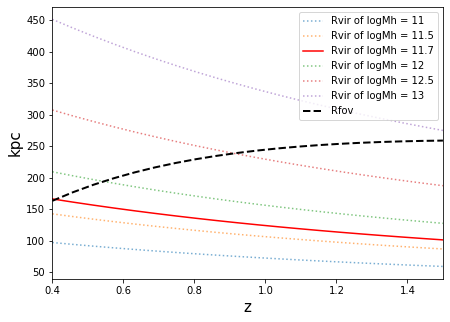

In [211]:
plt.figure(figsize = (7,5))
#plt.title("Rvir vs Rfov", size = 20)
plt.plot(zz, r11, label = "Rvir of logMh = 11", alpha = 0.6, linestyle = "dotted")
plt.plot(zz, r115, label = "Rvir of logMh = 11.5", alpha = 0.6, linestyle = "dotted")
plt.plot(zz, r117, label = "Rvir of logMh = 11.7", c = "r")
plt.plot(zz, r12, label = "Rvir of logMh = 12", alpha = 0.6, linestyle = "dotted")
plt.plot(zz, r125, label = "Rvir of logMh = 12.5", alpha = 0.6, linestyle = "dotted")
plt.plot(zz, r13, label = "Rvir of logMh = 13", alpha = 0.6, linestyle = "dotted")

plt.plot(zz, rr_fov, label = "Rfov", c = "black", linewidth = 2, linestyle = "--")
plt.legend()
plt.xlabel("z", size = 15)
plt.ylabel("kpc", size = 15)
plt.xlim((0.4, 1.5))

In [244]:
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
fsnr3 = R["snr_eff"]>=3
fincl30 = R["inclination"] >= 30 
fabs = R["bool_absorption"] == 1
fqso = R["is_QSO"] == 0
fclosest = R["is_closest"] == 1
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fstar = R["is_star"] == 0
flowa = R["alpha"] <= 30
fmida = (R["alpha"] >= 30) & (R["alpha"] <= 60)
fhigha = R["alpha"] >= 60
fisol = R["isolated_auto"] == 1
fm9 = R["sed_logMass"] >= 9
fconv = R["run_convergence_global"] >= 0.99
fbad = R["ID"].isin(bad_runs_ids)
fno_morpho = R["ID"].isin(no_morpho)
fnomass = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 1

In [245]:
Rforeground = R[fqso & fstar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fqso & fstar & fbehind & fzconf_1]
Rforeground_mass = R[fqso & fstar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fqso & fstar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_04_1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_9 = R[fqso & fstar & f100 & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
R100 = R[fqso & fstar & fzlow & fzhigh & fbehind & f100] 
R150 = R[fqso & fstar & fzlow & fzhigh & fbehind & f150]
R150_snr3 = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1]
R150_snr3_rot = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1 & frot]
R200 = R[fqso & fstar & fzlow & fzhigh & fbehind & f200]

isol = R[fqso & fstar & fisol & fbehind] #isolated galaxies
isol_abs = R[fqso & fstar & fisol & fabs & fbehind]
isol_noabs = R[fqso & fstar & fisol & ~fabs & fbehind]
isol_zconf = R[fqso & fstar & fisol & fzconf_1 & fbehind]
isol_zconf_abs = R[fqso & fstar & fisol & fzconf_1 & fabs & fbehind]
isol_zconf_noabs = R[fqso & fstar & fisol & fzconf_1 & ~fabs & fbehind]
isol_zselec = R[fqso & fstar & fisol & fzlow & fzhigh & fbehind] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & ~fnomass] 
isol_zselec_nomass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & fnomass]
isol_zconf_1 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fabs & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fabs & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fabs & fbehind]
isol_lowM_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & ~fabs & fbehind]
isol_9_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbehind] # idem with good convergence
isol_9_noconvergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fconv & fbehind] # idem with good convergence
isol_lowM_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fbehind]
isol_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind] # idem with good snr
isol_lowM_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fsnr3 & fbehind]
isol_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fbad & fbehind] # good runs
isol_notgood_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbad & fbehind]
isol_snr3_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind] # good runs
isol_snr3_notgood_runs = R[fqso & fstar& fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbad & fbehind]
isol_snr3_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fabs & fbehind] # good runs
isol_snr3_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & ~fabs & fbehind] # good runs
isol_incl_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind] # good runs
isol_incl_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fabs & fbehind] # good runs
isol_incl_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & ~fabs & fbehind] # good runs

#---- from visual inspection----
isol_visu = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho]
isol_visu_nok = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho]
isol_visu_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs]
isol_visu_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs]
isol_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot]
isol_visu_disp = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot]
isol_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs]
isol_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs]
isol_incl_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot]
isol_incl_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot]
isol_incl_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot]

isol_visu_low_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot]
isol_visu_high_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha]
isol_visu_mid_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida]
isol_visu_low_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa]


#----

isol_high_alpha = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot]
isol_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot]
isol_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot]
isol_mid_alpha = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot]
isol_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot]
isol_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot]
isol_low_alpha = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot]
isol_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot]
isol_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot]


closest = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind]
closest_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs]
closest_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs]
closest_9 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
closest_9_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9]
closest_9_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9]
closest_9_snr3 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3]
closest_9_snr3_good_runs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad]

closest_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & fincl30]

closest_high_alpha = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_mid_alpha = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_low_alpha = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]



print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good galpak runs and incl>30 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))

print("")
print("Number of isolated galaxies with morpho ok (visual) : ", len(isol_visu))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 : ", len(isol_incl_visu_rot))


print("")
print("** FOR THE PAPER: **")
print("** Volume limited sample (A)**")
print("Nb of galaxies in 0.4 - 1.5:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_0]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 :", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind]))
print("** Isolated galaxies **")
print(" (A) and isolated:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fisol]))
print("** closest galaxies **")
print(" (A) and closest:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fclosest]))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of isolated =  120
Number of isolated with abs =  43
Number of distinct absorptions associated with isolated  =  43
Number of isolated with zconf >= 2  112
Number of isolated at 0.4 < z < 1.5 =  100
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  93
and with mass =  93
or without mass =  0
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  93
Number of isolated with logM > 9 and multinest run =  88
Number of isolated with logM > 9 with abs =  42
Number of isolated with logM > 9 without abs =  51
Number of isolated with logM > 9 and good convergence =  92
Number of isolated with logM > 9 and good convergence and snr_eff > 3  =  64
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  63
Number of isolated with logM > 9 and good galpak runs  =  90
Number of isolated with logM > 9 and good galpak runs and incl>30 =  51
Number of closest galaxies

### build catalog

In [246]:
input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
#gt.build_catalog(isol_9, output_path, output_path, file_name = "isolated_catalog_2024_01_08")

## Completeness

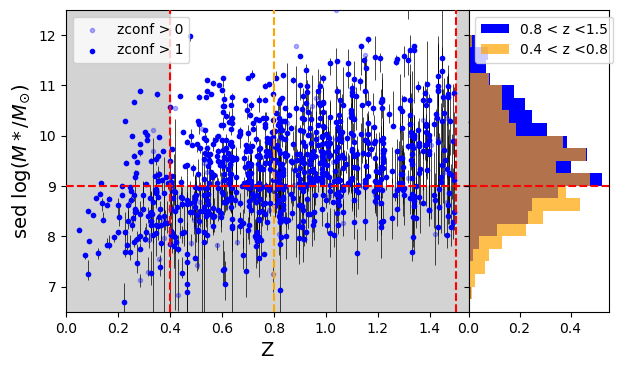

In [185]:
# Créer une figure et un axe principal pour le scatter plot
Mmax = 12.5
Mmin = 6.5
fig, ax = plt.subplots(figsize=(7, 4), dpi = 100)
ax.vlines(Rforeground_mass["Z"], Rforeground_mass["sed_logMass_l95"], Rforeground_mass["sed_logMass_u95"], \
          color = "black", linewidth = 0.5, zorder = 2)
ax.scatter(Rforeground_mass["Z"], Rforeground_mass["sed_logMass"],  marker='.', c = "blue", alpha = 0.3,\
                zorder = 3, label = "zconf > 0")
ax.scatter(Rforeground_zconf1_mass["Z"], Rforeground_zconf1_mass["sed_logMass"],  marker='.', c = "blue",\
           alpha = 1, zorder = 4, label = "zconf > 1")
ax.scatter(Rforeground_nomass["Z"], np.ones(len(Rforeground_nomass))*4.15,  marker='$\downarrow$', \
           c = "blue", alpha = 0.3, zorder = 3)
ax.scatter(Rforeground_zconf1_nomass["Z"], np.ones(len(Rforeground_zconf1_nomass))*4.15,  marker='$\downarrow$', \
           c = "blue", zorder = 3)
plt.ylim((Mmin, Mmax))
plt.xlim((0, 1.55))
plt.xlabel("Z", size = 14)
plt.ylabel("sed $\log(M*/M_{\odot}$)", size = 14)
plt.legend()
# Créer un axe pour l'histogramme à droite du scatter plot
plt.axvline(0.4, c = 'r', linestyle = "--", zorder = 4)
plt.axvline(1.5, c = 'r', linestyle = "--", zorder = 4)
plt.axvline(0.8, c = 'orange', linestyle = "--", zorder = 4)
plt.axhline(9, c = 'r', linestyle = "--", zorder = 4)
ax.axvspan(0, 0.4, color='lightgray', alpha=1, zorder = 1)
ax.axvspan(1.5, 2., color='lightgray', alpha=1, zorder = 1)
ax.axhspan(3, 9., color='lightgray', alpha=1,zorder = 1)


divider = make_axes_locatable(ax);
ax_hist = divider.append_axes("right", size=1.4, pad=0.)


# Plotter l'histogramme
binsize = 0.25

nbins = int((Mmax - Mmin)/binsize)
ax_hist.hist(R_08_15_zconf1["sed_logMass"], bins = nbins, range = (Mmin,Mmax), \
             orientation='horizontal', color='blue', label = "0.8 < z <1.5", density = True);
ax_hist.hist(R_04_08_zconf1["sed_logMass"], bins = nbins,  range = (Mmin,Mmax),\
             orientation='horizontal', color='orange', label = "0.4 < z <0.8", alpha = 0.7, density = True);
ax_hist.set_yticklabels([]);
plt.axhline(9, c = 'r', linestyle = "--", zorder = 2)
plt.ylim((Mmin, Mmax))
plt.legend()

## Galaxy properties

### Galpak runs

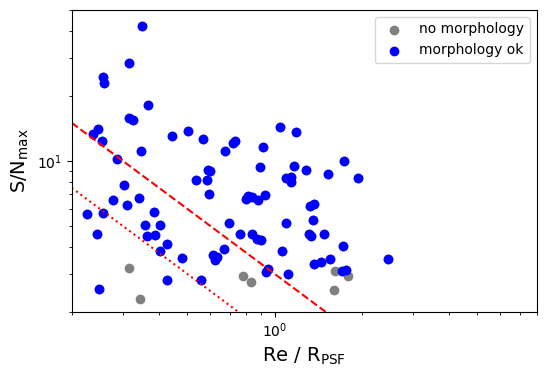

In [254]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray", \
            label = "no morphology")
#plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["radius"]*muse_sampling/isol_visu["psf_fwhm"], isol_visu["snr_max"], c = "blue", \
            label = "morphology ok")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--")
#label = "S/N$_{\mathrm{eff}} = 3$"
plt.plot(xx, yy1, c = "red", linestyle = "dotted")
#label = "S/N$_{\mathrm{eff}} = 1.5$"
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,8))
plt.ylim((2,50))


X = np.array(isol_visu_nok["radius"]*muse_sampling/isol_visu_nok["psf_fwhm"])
Y = np.array(isol_visu_nok["snr_max"])
txt = np.array(isol_visu_nok["ID"])

#for i in range(len(isol_visu_nok)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

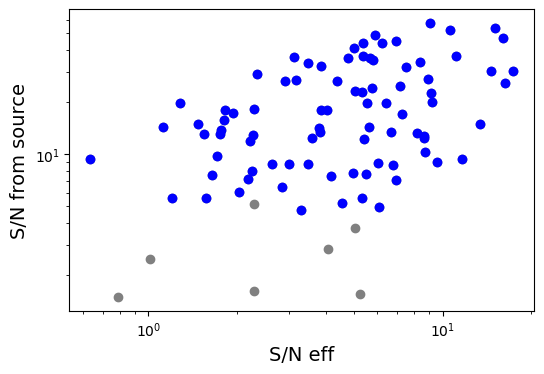

In [468]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["snr_eff"], isol_9["snr_from_src"], c = "gray",)
#plt.scatter(isol_snr3["snr_eff"], isol_snr3["snr_from_src"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["snr_eff"], isol_visu["snr_from_src"], c = "blue", \
            label = "visually ok for morpho")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["snr_eff"], isol_notgood_runs["snr_from_src"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
#plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
#plt.plot(xx, yy1, c = "pink", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 1.5$")
plt.xlabel("S/N eff", size = 14)
plt.ylabel("S/N from source", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.axhline()
#plt.legend()
#plt.xlim((0.2,8))
#plt.ylim((2,50))


X = np.array(isol_visu_nok["snr_eff"])
Y = np.array(isol_visu_nok["snr_from_src"])
txt = np.array(isol_visu_nok["ID"])

#for i in range(len(isol_visu_nok)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

In [263]:
isol_9["run_name"].unique()

array([nan, 'run_OII_multinest', 'run_OIII5007_multinest',
       'run_HBETA_multinest'], dtype=object)

In [264]:
len(isol_9[isol_9["run_name"] == "run_OIII5007_multinest"])

3

In [265]:
len(isol_9[isol_9["run_name"] == "run_HBETA_multinest"])

1

In [266]:
len(isol_9[isol_9["run_name"] == "nan"])

0

In [256]:
len(no_morpho)

8

(1, 100)

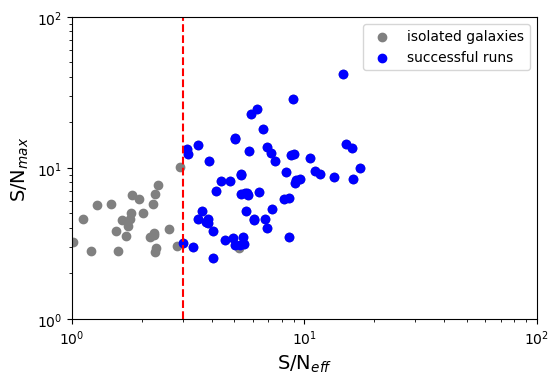

In [188]:
plt.figure(dpi = 100)
plt.scatter(isol_9["snr_eff"], isol_9["snr_max"], c = "gray", label = "isolated galaxies")
plt.scatter(isol_snr3_good_runs["snr_eff"], isol_snr3_good_runs["snr_max"], c = "blue", label = "successful runs")
plt.legend()
plt.xlabel("S/N$_{eff}$", size = 14)
plt.ylabel("S/N$_{max}$", size = 14)
plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlim((1,100))
plt.ylim((1,100))

### Inclination

Nb of galaxies in 150 kpc with snr>3, zconf>=2 and "good" runs:  180


Text(0.5, 0, 'inclination')

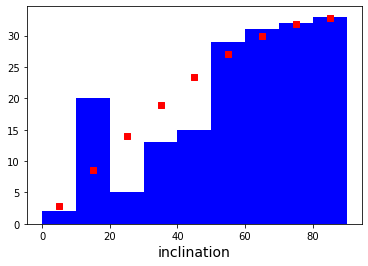

In [189]:
ii = np.linspace(5, 85, 9)
plt.figure();
print("Nb of galaxies in 150 kpc with snr>3, zconf>=2 and \"good\" runs: ", len(R150_snr3))
plt.hist(R150_snr3["inclination"], bins = 9, range = (0,90), color = "blue");
plt.scatter(ii, np.sin(ii*2*np.pi/360)*33, c = "r", zorder = 3, marker = "s")
plt.xlabel("inclination", size = 14)

Nb of isolated galaxies with morpho Ok 85


Text(0.5, 0, 'inclination')

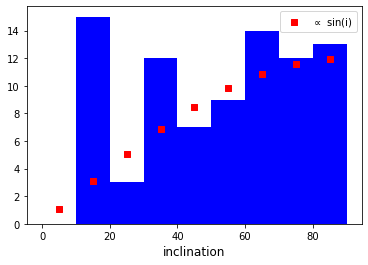

In [270]:
ii = np.linspace(5, 85, 9)
print("Nb of isolated galaxies with morpho Ok", len(isol_visu))
plt.hist(isol_visu["inclination"], bins = 9, range = (0,90), color = "blue");
plt.scatter(ii, np.sin(ii*2*np.pi/360)*12, c = "r", zorder = 3, marker = "s", label = "$\propto$ sin(i)")
plt.legend()
plt.xlabel("inclination", size = 12)

Nb of galaxies with morpho Ok and incl>30:  67


Text(0.5, 0, 'alpha')

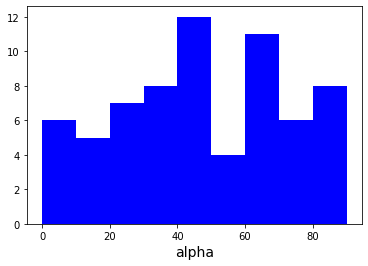

In [191]:
ii = np.linspace(5, 85, 9)
plt.figure();
print("Nb of galaxies with morpho Ok and incl>30: ", len(isol_incl_visu))
plt.hist(isol_incl_visu["alpha"], bins = 9, range = (0,90), color = "blue");
#plt.scatter(ii, np.sin(ii*2*np.pi/360)*33, c = "r", zorder = 3, marker = "s")
plt.xlabel("alpha", size = 14)

## W-b

### Isolated

Text(0, 0.5, '$W^{2796}_{r}$')

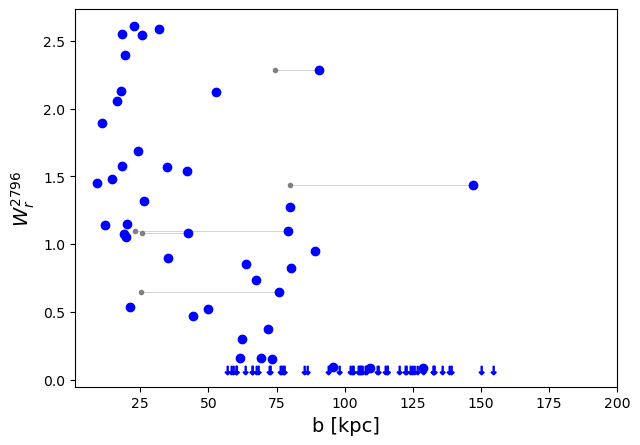

In [192]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'b',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
#plt.legend()

In [478]:
G5_abs["b_min_kpc"]

0      46.37
2       7.77
3      36.59
5       6.06
6      10.36
7     113.48
11     79.59
12     60.96
13     95.16
14     27.24
15     64.36
17     96.06
18     84.85
19     37.77
21     67.41
23     58.22
24    125.53
25    141.71
26     72.37
27     99.21
28     84.86
Name: b_min_kpc, dtype: float64

Nb of isolated galaxies with logM>9 : 93


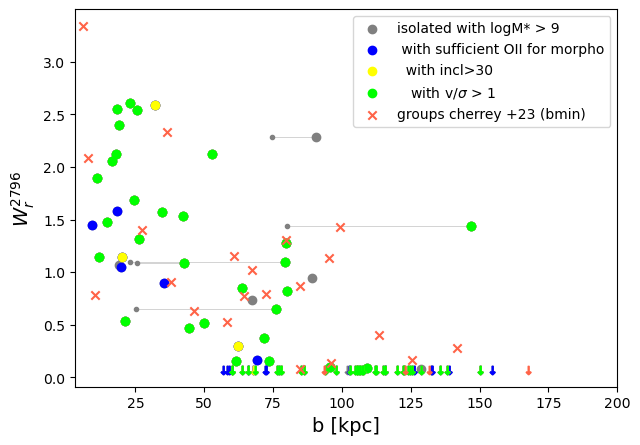

In [493]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'gray',\
                 zorder = 2, label = "isolated with logM* > 9")
plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = " with sufficient OII for morpho")
plt.scatter(isol_incl_visu_abs["B_KPC"], isol_incl_visu_abs["REW_2796"], c = 'yellow',\
                 zorder = 2, label = "  with incl>30")
plt.scatter(isol_incl_visu_rot_abs["B_KPC"], isol_incl_visu_rot_abs["REW_2796"], c = 'lime',\
                 zorder = 2, label = "   with v/$\sigma$ > 1")

plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "x", c = "tomato", zorder = 3, \
           label = "groups cherrey +23 (bmin)")

#plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], c = 'red',\
#                 label = "high alpha", zorder = 2)

#plt.scatter(isol_mid_alpha_abs["B_KPC"], isol_mid_alpha_abs["REW_2796"], c = 'lime',\
#                 label = "mid alpha", zorder = 2)

#plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = 'blue',\
#                 label = "low alpha", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "gray",\
             marker = "$\downarrow$")
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = 'blue',\
                 zorder = 2, marker = "$\downarrow$")
plt.scatter(isol_incl_visu_noabs["B_KPC"], isol_incl_visu_noabs["detection_limit_p75"], c = 'yellow',\
                 zorder = 2, marker = "$\downarrow$")
plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'lime',\
                 zorder = 2, marker = "$\downarrow$")

#plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], c = "red",\
#             marker = "$\downarrow$")

#plt.scatter(isol_mid_alpha_noabs["B_KPC"], isol_mid_alpha_noabs["detection_limit_p75"], c = "lime",\
#             marker = "$\downarrow$")

#plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], c = "blue",\
#             marker = "$\downarrow$")

plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["REW_2796"]+0.075, marker = "$\downarrow$", c = "tomato", zorder = 3)

#plt.colorbar(label = "N2000")
plt.xlim((3, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

In [269]:
len(isol_incl_visu_rot)

63

Nb of isolated galaxies with logM>9 : 93


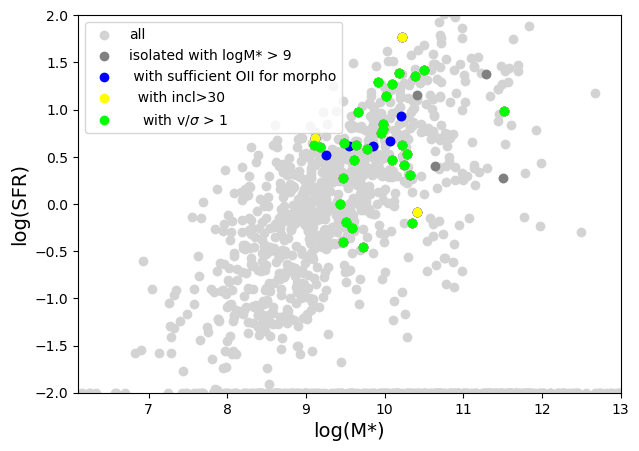

In [194]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6

plt.scatter(R["sed_logMass"], R["logSFR"], c = 'lightgray',\
                 zorder = 2, label = "all")
plt.scatter(isol_9_abs["sed_logMass"], isol_9_abs["logSFR"], c = 'gray',\
                 zorder = 2, label = "isolated with logM* > 9")
plt.scatter(isol_visu_abs["sed_logMass"], isol_visu_abs["logSFR"], c = 'blue',\
                 zorder = 2, label = " with sufficient OII for morpho")
plt.scatter(isol_incl_visu_abs["sed_logMass"], isol_incl_visu_abs["logSFR"], c = 'yellow',\
                 zorder = 2, label = "  with incl>30")
plt.scatter(isol_incl_visu_rot_abs["sed_logMass"], isol_incl_visu_rot_abs["logSFR"], c = 'lime',\
                 zorder = 2, label = "   with v/$\sigma$ > 1")

plt.ylim((-2, 2))
plt.xlim((6.1, 13))
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("log(M*)", size = 14)
plt.ylabel("log(SFR)", size = 14)
plt.legend()

Nb of isolated galaxies with logM>9 : 93


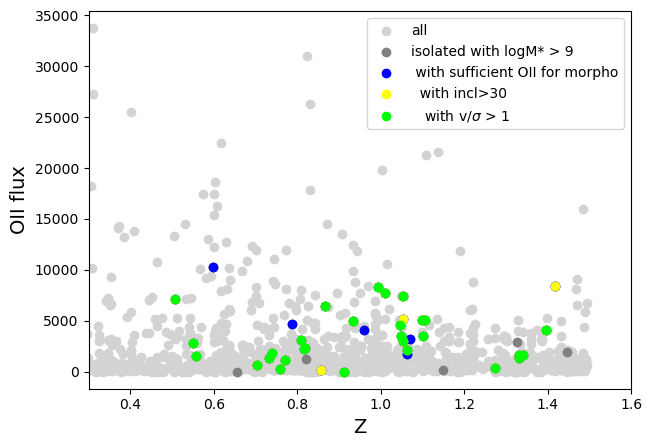

In [195]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6

plt.scatter(R["Z"], R["OII3729_FLUX"], c = 'lightgray',\
                 zorder = 2, label = "all")
plt.scatter(isol_9_abs["Z"], isol_9_abs["OII3729_FLUX"], c = 'gray',\
                 zorder = 2, label = "isolated with logM* > 9")
plt.scatter(isol_visu_abs["Z"], isol_visu_abs["OII3729_FLUX"], c = 'blue',\
                 zorder = 2, label = " with sufficient OII for morpho")
plt.scatter(isol_incl_visu_abs["Z"], isol_incl_visu_abs["OII3729_FLUX"], c = 'yellow',\
                 zorder = 2, label = "  with incl>30")
plt.scatter(isol_incl_visu_rot_abs["Z"], isol_incl_visu_rot_abs["OII3729_FLUX"], c = 'lime',\
                 zorder = 2, label = "   with v/$\sigma$ > 1")

#plt.ylim((-2, 2))
plt.xlim((0.3, 1.6))
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Z", size = 14)
plt.ylabel("OII flux", size = 14)
plt.legend()

Nb of isolated galaxies with logM>9 : 93


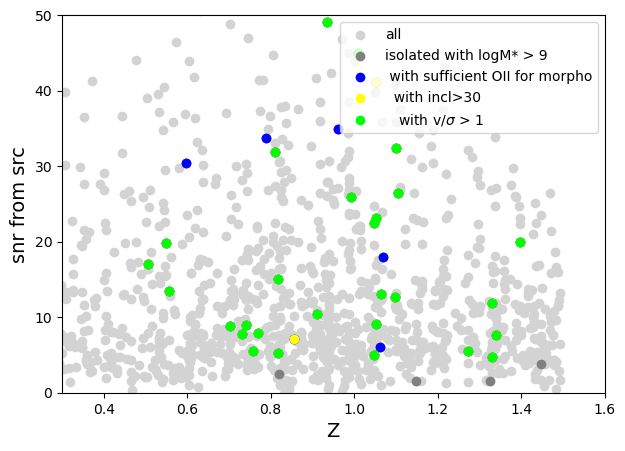

In [196]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6

plt.scatter(R["Z"], R["snr_from_src"], c = 'lightgray',\
                 zorder = 2, label = "all")
plt.scatter(isol_9_abs["Z"], isol_9_abs["snr_from_src"], c = 'gray',\
                 zorder = 2, label = "isolated with logM* > 9")
plt.scatter(isol_visu_abs["Z"], isol_visu_abs["snr_from_src"], c = 'blue',\
                 zorder = 2, label = " with sufficient OII for morpho")
plt.scatter(isol_incl_visu_abs["Z"], isol_incl_visu_abs["snr_from_src"], c = 'yellow',\
                 zorder = 2, label = "  with incl>30")
plt.scatter(isol_incl_visu_rot_abs["Z"], isol_incl_visu_rot_abs["snr_from_src"], c = 'lime',\
                 zorder = 2, label = "   with v/$\sigma$ > 1")

plt.ylim((0, 50))
plt.xlim((0.3, 1.6))
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Z", size = 14)
plt.ylabel("snr from src", size = 14)
plt.legend()

Nb of isolated galaxies with logM>9 : 93


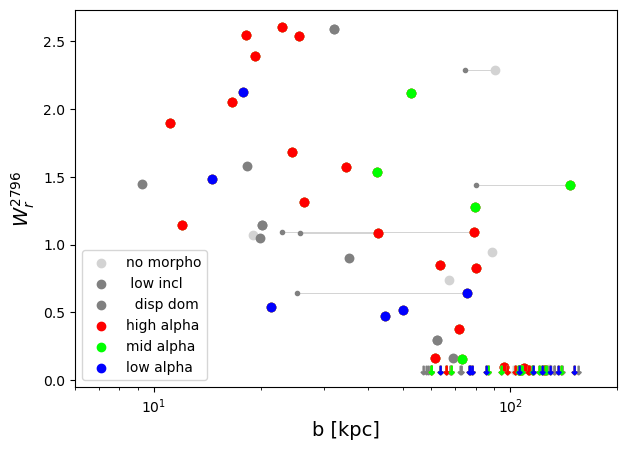

In [223]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'lightgray',\
                 zorder = 2, label = "no morpho")
plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = 'gray',\
                 zorder = 2, label = " low incl")
plt.scatter(isol_incl_visu_abs["B_KPC"], isol_incl_visu_abs["REW_2796"], c = 'grey',\
                 zorder = 2, label = "  disp dom")
plt.scatter(isol_incl_visu_rot_abs["B_KPC"], isol_incl_visu_rot_abs["REW_2796"], c = 'orange',\
                 zorder = 2)

plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], c = 'red',\
                 label = "high alpha", zorder = 2)

plt.scatter(isol_mid_alpha_abs["B_KPC"], isol_mid_alpha_abs["REW_2796"], c = 'lime',\
                 label = "mid alpha", zorder = 2)

plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = 'blue',\
                 label = "low alpha", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "lightgray",\
             marker = "$\downarrow$")
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = 'gray', \
                 zorder = 2, marker = "$\downarrow$")
plt.scatter(isol_incl_visu_noabs["B_KPC"], isol_incl_visu_noabs["detection_limit_p75"], c = 'grey',\
                 zorder = 2, marker = "$\downarrow$")
plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'orange',\
                 zorder = 2, marker = "$\downarrow$")


plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], c = "red",\
             marker = "$\downarrow$", zorder = 2)

plt.scatter(isol_mid_alpha_noabs["B_KPC"], isol_mid_alpha_noabs["detection_limit_p75"], c = "lime",\
             marker = "$\downarrow$", zorder = 2)

plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$", zorder = 2)

#plt.colorbar(label = "N2000")
plt.xlim((6, 200))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

Nb of isolated galaxies with logM>9 : 93


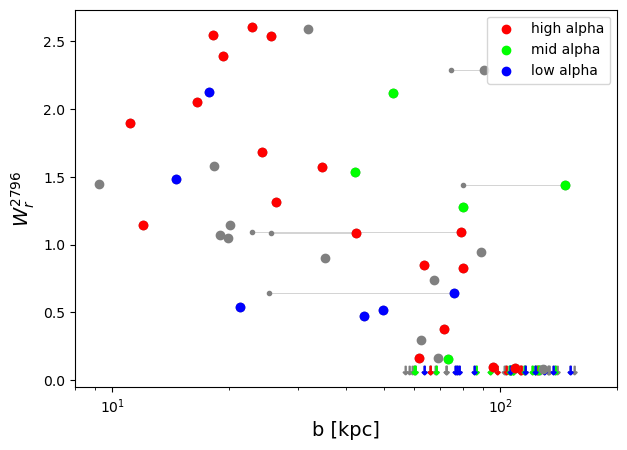

In [273]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'gray',\
                 zorder = 2)

plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], c = 'red',\
                 label = "high alpha", zorder = 2)

plt.scatter(isol_mid_alpha_abs["B_KPC"], isol_mid_alpha_abs["REW_2796"], c = 'lime',\
                 label = "mid alpha", zorder = 2)

plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = 'blue',\
                 label = "low alpha", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "gray",\
             marker = "$\downarrow$")

plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], c = "red",\
             marker = "$\downarrow$")

plt.scatter(isol_mid_alpha_noabs["B_KPC"], isol_mid_alpha_noabs["detection_limit_p75"], c = "lime",\
             marker = "$\downarrow$")

plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$")

#plt.colorbar(label = "N2000")
plt.xlim((8, 200))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

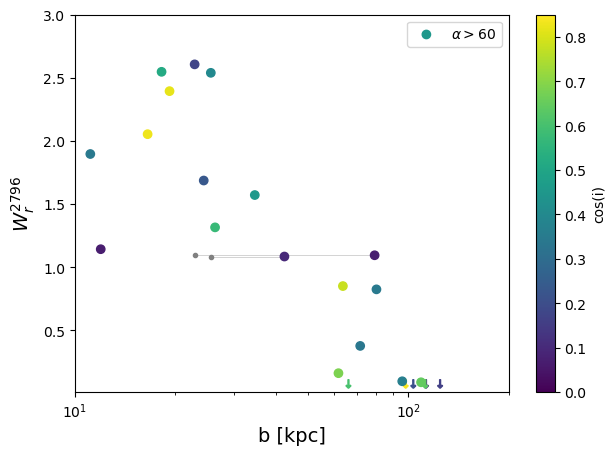

In [200]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_high_alpha_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], \
            c = np.cos(isol_high_alpha_abs["inclination"]*2*np.pi/360), vmin = 0, vmax = 0.85,\
            label = "$\\alpha > 60$", zorder = 2)
plt.colorbar(label = "cos(i)")

plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], \
            c = np.cos(isol_high_alpha_noabs["inclination"]*2*np.pi/360), vmin = 0, vmax = 0.85, \
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.ylim((0.01, 3))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

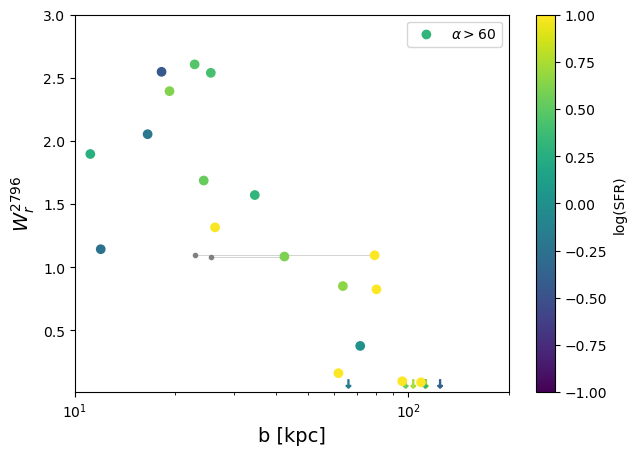

In [203]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_high_alpha_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], \
            c = isol_high_alpha_abs["logSFR"], vmin = -1, vmax = 1,\
            label = "$\\alpha > 60$", zorder = 2)
plt.colorbar(label = "log(SFR)")

plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], \
            c = isol_high_alpha_noabs["logSFR"], vmin = -1, vmax = 1, \
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.ylim((0.01, 3))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

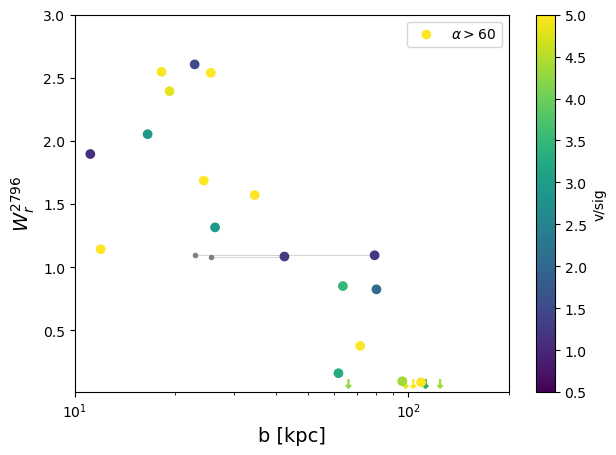

In [216]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_high_alpha_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], \
            c = isol_high_alpha_abs["v_sig"], vmin = 0.5, vmax = 5,\
            label = "$\\alpha > 60$", zorder = 2)
plt.colorbar(label = "v/sig")

plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], \
            c = isol_high_alpha_noabs["v_sig"], vmin = 0.5, vmax = 5, \
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.ylim((0.01, 3))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

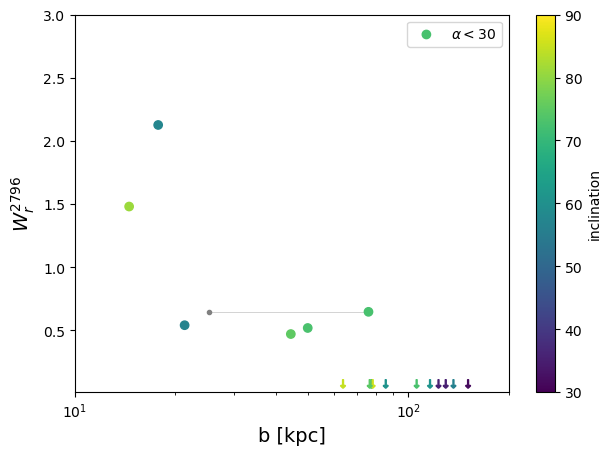

In [201]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_low_alpha_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = isol_low_alpha_abs["inclination"],\
                 vmin = 30, vmax = 90, label = "$\\alpha < 30$", zorder = 2)
plt.colorbar(label = "inclination")
plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], \
            c = isol_low_alpha_noabs["inclination"], vmin = 30, vmax = 90,\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.ylim((0.01, 3))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

### visual inspected morpho

Text(0, 0.5, '$W^{2796}_{r}$')

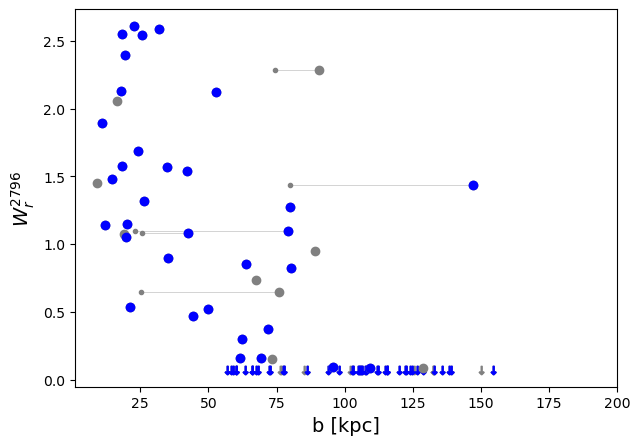

In [139]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'gray',\
                 label = "isolated logM*>9", zorder = 2)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "gray",\
             marker = "$\downarrow$")

plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = 'b',\
                 label = "isolated logM*>9", zorder = 2)
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
#plt.legend()

Text(0, 0.5, '$W^{2796}_{r}$')

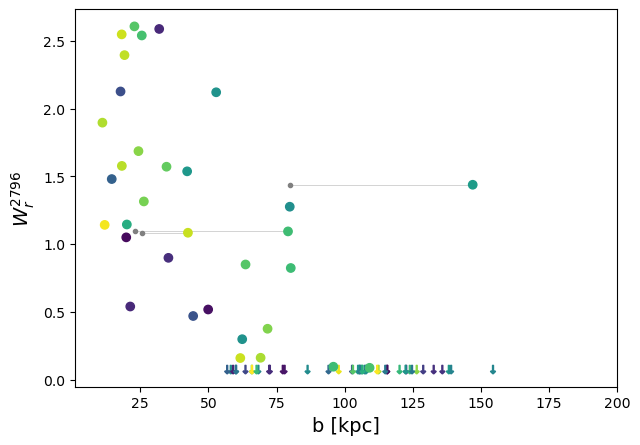

In [140]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    

plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = isol_visu_abs["alpha"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 90)
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = isol_visu_noabs["alpha"],\
             marker = "$\downarrow$", vmin = 0, vmax = 90)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
#plt.legend()

Text(0, 0.5, '$W^{2796}_{r}$')

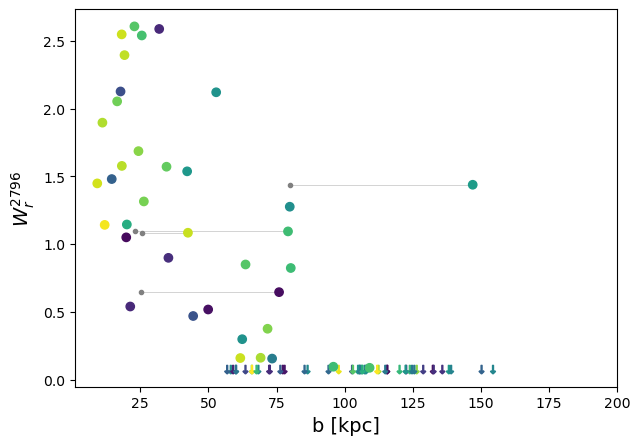

In [274]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    

plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = isol_visu_abs["alpha"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 90)
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = isol_visu_noabs["alpha"],\
             marker = "$\downarrow$", vmin = 0, vmax = 90)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
#plt.legend()

Text(0, 0.5, 'logSFR')

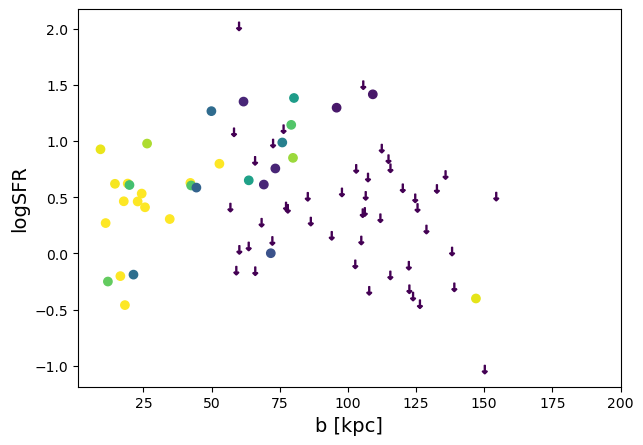

In [276]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["logSFR"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["logSFR"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("logSFR", size = 14)
#plt.legend()

Text(0, 0.5, 'log(M)')

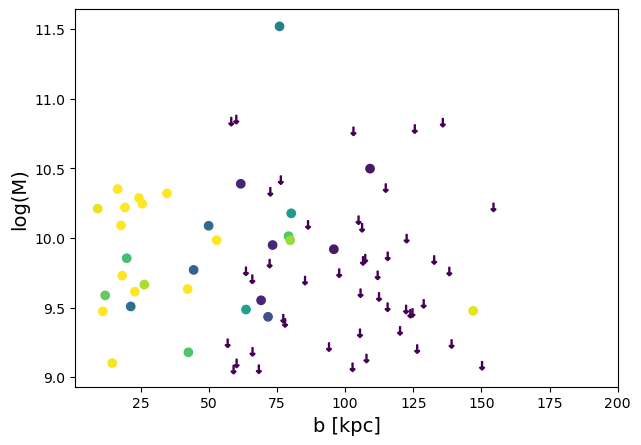

In [277]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["sed_logMass"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["sed_logMass"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(M)", size = 14)
#plt.legend()

Text(0, 0.5, 'inclination')

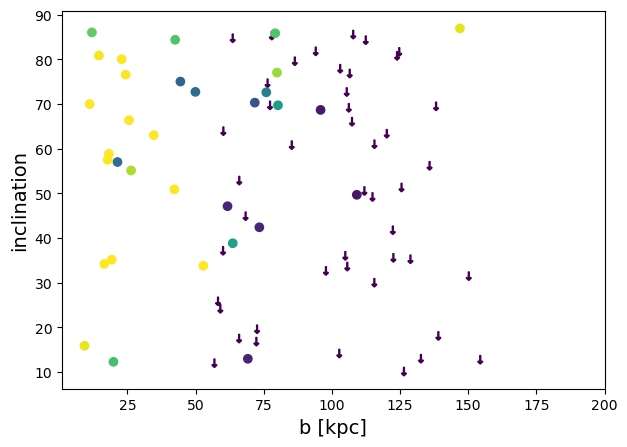

In [278]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["inclination"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["inclination"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("inclination", size = 14)
#plt.legend()

Text(0, 0.5, 'alpha')

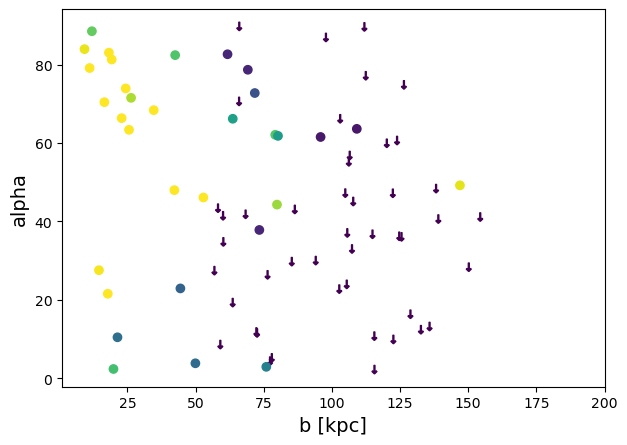

In [279]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["alpha"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["alpha"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("alpha", size = 14)
#plt.legend()

Text(0, 0.5, 'v/sig')

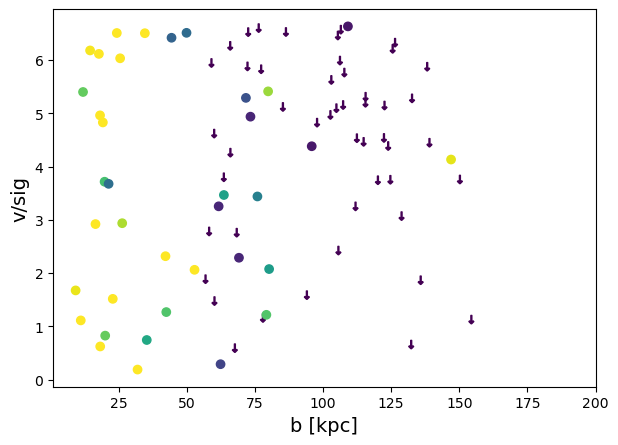

In [280]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_abs["B_KPC"], \
            (isol_visu_abs["v22"]+0.01)/isol_visu_abs["velocity_dispersion_2Rd"], \
            c = isol_visu_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_noabs["B_KPC"], \
            (isol_visu_noabs["v22"]+0.01)/isol_visu_noabs["velocity_dispersion_2Rd"], \
            c = isol_visu_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("v/sig", size = 14)
#plt.legend()

### Closests

In [ ]:
gt.build_catalog(closest_9, output_path, output_path, file_name = "closest_catalog_2024_01_10")

nan
11083 : no run nan <class 'float'>
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11097/run_OII_multinest/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11098/run_OII_3/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11099/run_OII_3/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11101/run_OII_3/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11106/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11117/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11121/run_OII_multinest/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11122/run_OII_3/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11125/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/a

/muse/MG2QSO/private/analysis/galpak_dr2/galpak_tools.py:2199: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(14, 14), dpi = 250)


run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0014p0912/J0014p0912_source-12110/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0014p0912/J0014p0912_source-12116/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0014p0912/J0014p0912_source-12119/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0014p0912/J0014p0912_source-12121/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0014p0912/J0014p0912_source-12123/run_OII_multinest/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0014p0912/J0014p0912_source-12127/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0014p0912/J0014p0912_source-12128/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0015m0751/J0015m0751_source-13063/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0015m0751/J0015m0751_source-13088/run_OII_multinest/
run_OII_multine

run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20052/run_OII_multinest/
nan
20055 : no run nan <class 'float'>
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20057/run_OII_3/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20060/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20064/run_OII_multinest/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20065/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20066/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20077/run_OII_mul

run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27076/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27094/run_OII_multinest/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27101/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27102/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J1358p1145/J1358p1145_source-28002/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J1358p1145/J1358p1145_source-28055/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J1358p1145/J1358p1145_source-28056/run_OII_multinest/
run_OII_3
/muse/MG2QSO/private/analysis/galpak_dr2/J1358p1145/J1358p1145_source-28064/run_OII_3/
run_OII_multinest
/muse/MG2QSO/private/analysis/galpak_dr2/J1358p1145/J1358p1145_source-28065/run_OII_multinest/
run_OII_multinest
/muse/MG2QSO/

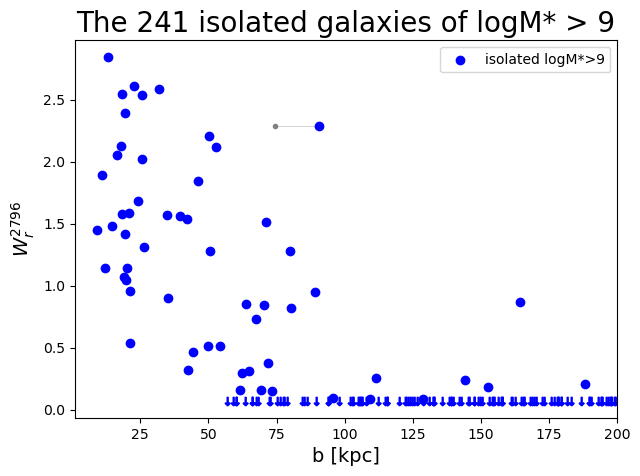

In [239]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(closest_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in closest_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(closest_9_abs["B_KPC"], closest_9_abs["REW_2796"], c = 'b',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(closest_9_noabs["B_KPC"], closest_9_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

The top right point having a neighbor at smaller impact param seems to be problematic: how can it be the closest galaxy?? In fact, it is indeed the closest in a +-500km/s window around itself. However if we take a +-500km/s window centered on the absorption there is another galaxy that is a bit closer...

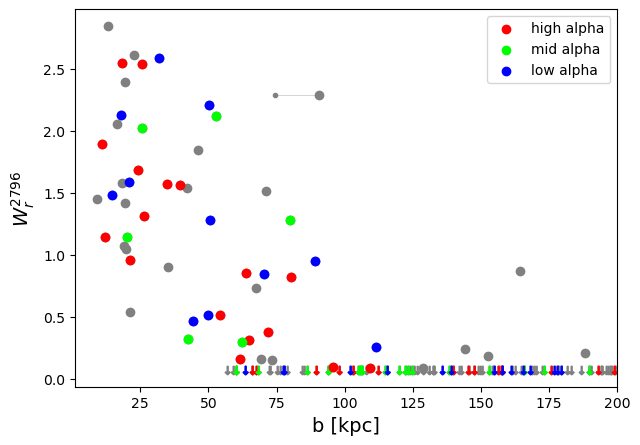

In [63]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in closest_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(closest_9_abs["B_KPC"], closest_9_abs["REW_2796"], c = 'gray',\
                 zorder = 2)

plt.scatter(closest_high_alpha_abs["B_KPC"], closest_high_alpha_abs["REW_2796"], c = 'red',\
                 label = "high alpha", zorder = 2)

plt.scatter(closest_mid_alpha_abs["B_KPC"], closest_mid_alpha_abs["REW_2796"], c = 'lime',\
                 label = "mid alpha", zorder = 2)

plt.scatter(closest_low_alpha_abs["B_KPC"], closest_low_alpha_abs["REW_2796"], c = 'blue',\
                 label = "low alpha", zorder = 2)

plt.scatter(closest_9_noabs["B_KPC"], closest_9_noabs["detection_limit_p75"], c = "gray",\
             marker = "$\downarrow$")

plt.scatter(closest_high_alpha_noabs["B_KPC"], closest_high_alpha_noabs["detection_limit_p75"], c = "red",\
             marker = "$\downarrow$")

plt.scatter(closest_mid_alpha_noabs["B_KPC"], closest_mid_alpha_noabs["detection_limit_p75"], c = "lime",\
             marker = "$\downarrow$")

plt.scatter(closest_low_alpha_noabs["B_KPC"], closest_low_alpha_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$")

#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

In [88]:
np.cos(30/360*2*np.pi)

0.8660254037844386

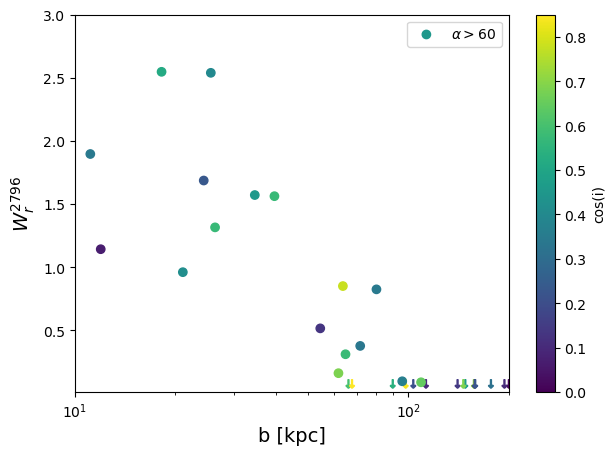

In [102]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in closest_high_alpha_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(closest_high_alpha_abs["B_KPC"], closest_high_alpha_abs["REW_2796"], \
            c = np.cos(closest_high_alpha_abs["inclination"]*2*np.pi/360), vmin = 0, vmax = 0.85,\
                 label = "$\\alpha > 60$", zorder = 2)
plt.colorbar(label = "cos(i)")
plt.scatter(closest_high_alpha_noabs["B_KPC"], closest_high_alpha_noabs["detection_limit_p75"],\
            c = np.cos(closest_high_alpha_noabs["inclination"]*2*np.pi/360), vmin = 0, vmax= 0.85,\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.ylim((0.01, 3))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

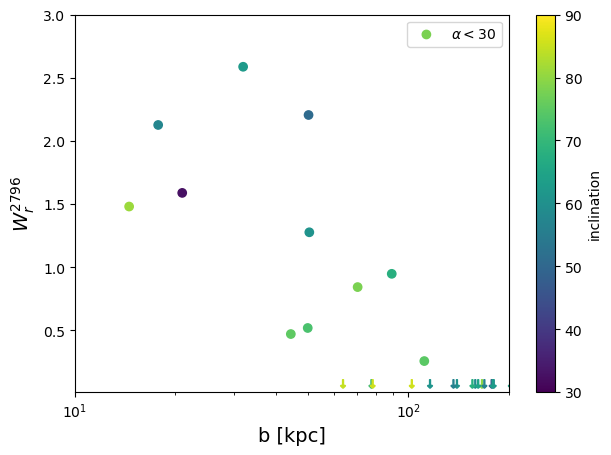

In [90]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in closest_low_alpha_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(closest_low_alpha_abs["B_KPC"], closest_low_alpha_abs["REW_2796"], \
            c = closest_low_alpha_abs["inclination"], vmin = 30, vmax = 90,\
                 label = "$\\alpha < 30$", zorder = 2)
plt.colorbar(label = "inclination")
plt.scatter(closest_low_alpha_noabs["B_KPC"], closest_low_alpha_noabs["detection_limit_p75"], \
            c = closest_low_alpha_noabs["inclination"], vmin = 30, vmax = 90,\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.ylim((0.01, 3))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

# Disk - halo decomposition

## Data preparation

In [175]:
R = pd.read_csv("results_decomp_3.csv")

bad_runs_ids = [11083, 12121, 23086, 23120, 26056, 26092, 29002, 29084, 28102, 30070, 30093, 31005]
no_morpho = [11083, 12103, 14127, 15003, 17068, 17072, 20077, 23086, 23120, 26056, \
             24038, 25070, 27094, 29002, 29084, 30070, 31005]
R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/R["sed_logMass"])
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-5)

R["orientation"] = 1 #an alternative method is to use a flag. 0 = accretion, 1 = middle, 2 = wind.
R.loc[R["alpha"] < 30, "orientation"] = 0
R.loc[R["alpha"] > 60, "orientation"] = 2

In [176]:
R = gt.isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 9)
R = gt.get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 0)

In [177]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

## Sample selection

In [178]:
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
fsnr3 = R["snr_eff"]>=3
fincl30 = R["inclination"] >= 30 
fabs = R["bool_absorption"] == 1
fqso = R["is_QSO"] == 0
fclosest = R["is_closest"] == 1
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fstar = R["is_star"] == 0
flowa = R["alpha"] <= 30
fmida = (R["alpha"] >= 30) & (R["alpha"] <= 60)
fhigha = R["alpha"] >= 60
fisol = R["isolated_auto"] == 1
fm9 = R["sed_logMass"] >= 9
fconv = R["run_convergence_global"] >= 0.99
fbad = R["ID"].isin(bad_runs_ids)
fno_morpho = R["ID"].isin(no_morpho)
fnomass = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 1

In [179]:
Rforeground = R[fqso & fstar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fqso & fstar & fbehind & fzconf_1]
Rforeground_mass = R[fqso & fstar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fqso & fstar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_04_1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_9 = R[fqso & fstar & f100 & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
R100 = R[fqso & fstar & fzlow & fzhigh & fbehind & f100] 
R150 = R[fqso & fstar & fzlow & fzhigh & fbehind & f150]
R150_snr3 = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1]
R200 = R[fqso & fstar & fzlow & fzhigh & fbehind & f200]

isol = R[fqso & fstar & fisol & fbehind] #isolated galaxies
isol_abs = R[fqso & fstar & fisol & fabs & fbehind]
isol_noabs = R[fqso & fstar & fisol & ~fabs & fbehind]
isol_zconf = R[fqso & fstar & fisol & fzconf_1 & fbehind]
isol_zconf_abs = R[fqso & fstar & fisol & fzconf_1 & fabs & fbehind]
isol_zconf_noabs = R[fqso & fstar & fisol & fzconf_1 & ~fabs & fbehind]
isol_zselec = R[fqso & fstar & fisol & fzlow & fzhigh & fbehind] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & ~fnomass] 
isol_zselec_nomass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & fnomass]
isol_zconf_1 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fabs & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fabs & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fabs & fbehind]
isol_lowM_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & ~fabs & fbehind]
isol_9_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbehind] # idem with good convergence
isol_9_noconvergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fconv & fbehind] # idem with good convergence
isol_lowM_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fbehind]
isol_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind] # idem with good snr
isol_snr3_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & fabs] # idem with good snr
isol_snr3_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fabs] # idem with good snr


isol_lowM_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fsnr3 & fbehind]
isol_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fbad & fbehind] # good runs
isol_notgood_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbad & fbehind]
isol_snr3_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind] # good runs
isol_snr3_notgood_runs = R[fqso & fstar& fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbad & fbehind]
isol_snr3_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fabs & fbehind] # good runs
isol_snr3_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & ~fabs & fbehind] # good runs
isol_snr3_good_runs_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot] # good runs
isol_snr3_good_runs_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & fabs] # good runs
isol_snr3_good_runs_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fabs] # good runs

isol_incl_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot] # good runs
isol_incl_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fabs & fbehind & frot] # good runs
isol_incl_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & ~fabs & fbehind & frot] # good runs


isol_high_alpha = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot]
isol_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot]
isol_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot]
isol_mid_alpha = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot]
isol_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot]
isol_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot]
isol_low_alpha = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot]
isol_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot]
isol_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot]


#---- from visual inspection----
isol_visu = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho]
isol_visu_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs]
isol_visu_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs]
isol_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot]
isol_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs]
isol_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs]
isol_incl_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot]
isol_incl_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot]
isol_incl_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot]

isol_visu_low_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot]
isol_visu_high_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha]
isol_visu_low_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa]


#----


closest = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind]
closest_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs]
closest_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs]
closest_9 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
closest_9_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9]
closest_9_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9]
closest_9_snr3 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3]
closest_9_snr3_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & fabs]
closest_9_snr3_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fabs]
closest_9_snr3_good_runs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot] # good runs
closest_9_snr3_good_runs_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & fabs] # good runs
closest_9_snr3_good_runs_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fabs] # good runs
closest_9_snr3_good_runs_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad]



closest_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & fincl30]

closest_high_alpha = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_mid_alpha = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_low_alpha = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]



print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated  = ", len(isol_snr3_good_runs_rot))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated with abs = ", len(isol_snr3_good_runs_rot_abs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated without abs= ", len(isol_snr3_good_runs_rot_noabs))
print("Number of isolated with logM > 9 and good galpak runs and incl>30 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))
print("")
print("** FOR THE PAPER: **")
print("** Volume limited sample (A)**")
print("Nb of galaxies in 0.4 - 1.5:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_0]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 :", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind]))
print("** Isolated galaxies **")
print(" (A) and isolated:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fisol]))
print("** closest galaxies **")
print(" (A) and closest:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fclosest]))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of isolated =  120
Number of isolated with abs =  43
Number of distinct absorptions associated with isolated  =  43
Number of isolated with zconf >= 2  112
Number of isolated at 0.4 < z < 1.5 =  100
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  93
and with mass =  93
or without mass =  0
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  93
Number of isolated with logM > 9 and multinest run =  0
Number of isolated with logM > 9 with abs =  42
Number of isolated with logM > 9 without abs =  51
Number of isolated with logM > 9 and good convergence =  90
Number of isolated with logM > 9 and snr_eff > 3  =  64
Number of isolated with logM > 9 and good galpak runs  =  83
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  58
Number of isolated with logM > 9 and good galpak runs, rot dominated  =  53
Number of isolated with logM > 9 and good ga

## Galaxy properties

(0.2, 10)

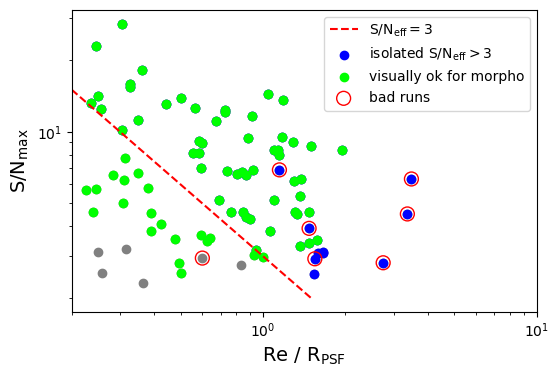

In [180]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray",)
plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["radius"]*muse_sampling/isol_visu["psf_fwhm"], isol_visu["snr_max"], c = "lime", \
            label = "visually ok for morpho")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,10))
#plt.ylim((1,100))

Text(0, 0.5, 'sed logM*')

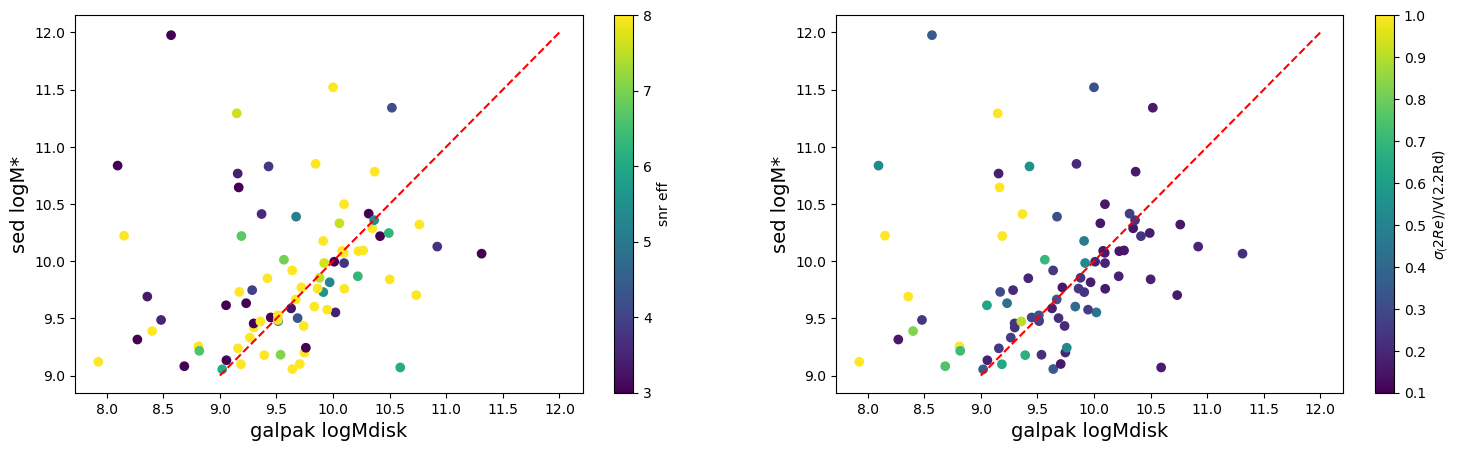

In [555]:
plt.figure(dpi = 100, figsize = (18, 5))
plt.subplot(121)
plt.scatter(isol_good_runs["log_Mdisk"], isol_good_runs["sed_logMass"], \
            c = isol_good_runs["snr_eff"], vmin = 3, vmax = 8, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.colorbar(label = "snr eff")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)
plt.subplot(122)
plt.scatter(isol_good_runs["log_Mdisk"], isol_good_runs["sed_logMass"], \
            c = isol_good_runs["velocity_dispersion_2Re"]/(isol_good_runs["v22"]+0.01), vmin = 0.1, vmax = 1, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.colorbar(label = "$\sigma_(2Re)$/V(2.2Rd)")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)

Text(0, 0.5, 'sed logM*')

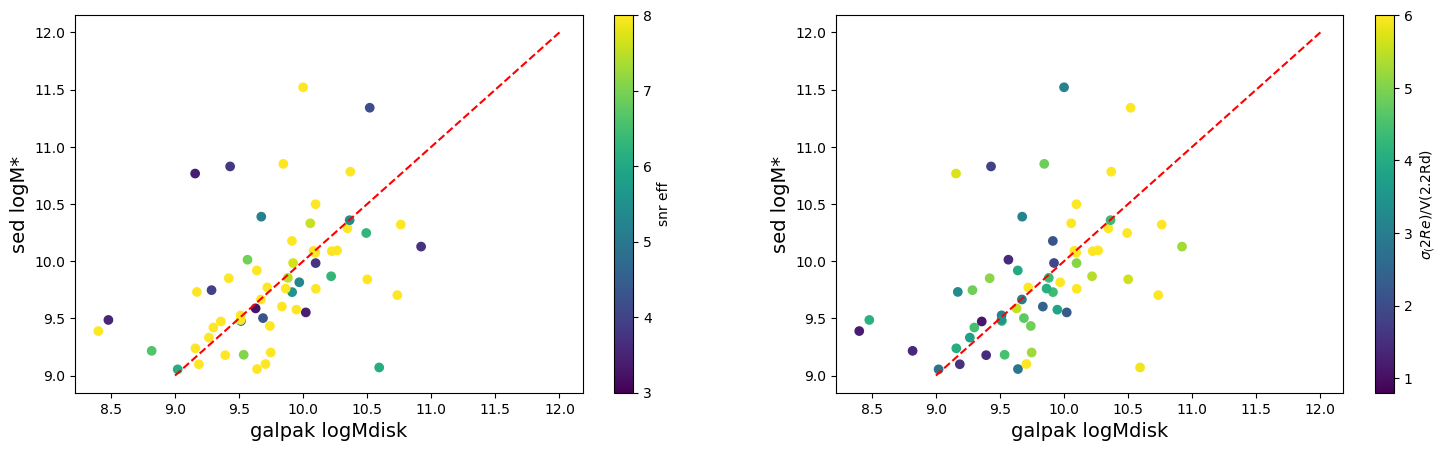

In [556]:
plt.figure(dpi = 100, figsize = (18, 5))
plt.subplot(121)
plt.scatter(isol_snr3_good_runs_rot["log_Mdisk"], isol_snr3_good_runs_rot["sed_logMass"], \
            c = isol_snr3_good_runs_rot["snr_eff"], vmin = 3, vmax = 8, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.colorbar(label = "snr eff")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)
plt.subplot(122)
plt.scatter(isol_snr3_good_runs_rot["log_Mdisk"], isol_snr3_good_runs_rot["sed_logMass"], \
            c = (isol_snr3_good_runs_rot["v22"]+0.01)/isol_snr3_good_runs_rot["velocity_dispersion_2Re"], \
            vmin = 0.8, vmax = 6, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.colorbar(label = "$\sigma_(2Re)$/V(2.2Rd)")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)

Text(0, 0.5, 'abs Dv')

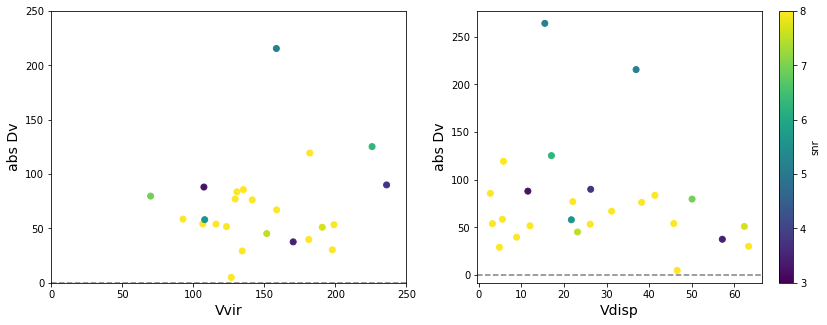

In [557]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.scatter(isol_snr3_good_runs_rot_abs["virial_velocity"], \
            isol_snr3_good_runs_rot_abs["vel_absorption_dist"]/1e3, \
            c = isol_snr3_good_runs_rot_abs["snr_eff"], vmin = 3, vmax = 8)
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vvir", size = 14)
plt.ylabel("abs Dv", size = 14)
plt.xlim((0,250))
plt.ylim(0,250)

plt.subplot(122)
plt.scatter(isol_snr3_good_runs_rot_abs["velocity_dispersion"], \
            isol_snr3_good_runs_rot_abs["vel_absorption_dist"]/1e3,\
            c = isol_snr3_good_runs_rot_abs["snr_eff"], vmin = 3, vmax = 8)
plt.colorbar(label = "snr")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vdisp", size = 14)
plt.ylabel("abs Dv", size = 14)

## W - b

### Isolated

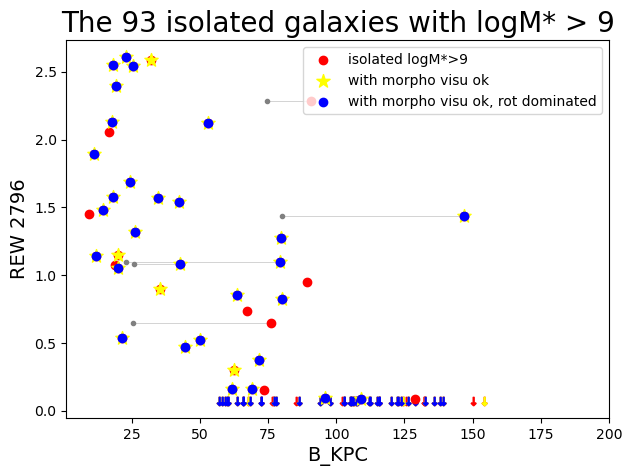

In [81]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies with logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)


plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = 'yellow', marker = "*",\
                 label = "with morpho visu ok", zorder = 3, s = 100)

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = 'b',\
                 label = "with morpho visu ok, rot dominated", zorder = 3)

#plt.scatter(g11083["B_KPC"], g11083["REW_2796"], marker = "s", s = 150, color = "black")

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")

plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = "yellow",\
             marker = "$\downarrow$")

plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

In [342]:
g11083 = isol_9_abs[isol_9_abs["ID"] == 11083]

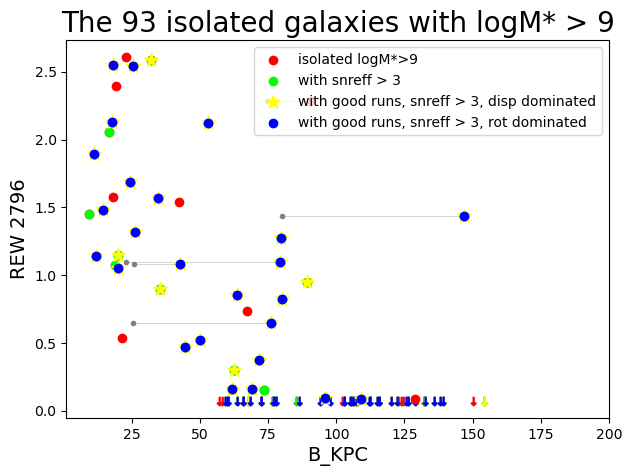

In [79]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies with logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_snr3_abs["B_KPC"], isol_snr3_abs["REW_2796"], c = 'lime', marker = "o",\
                 label = "with snreff > 3", zorder = 3)

plt.scatter(isol_snr3_good_runs_abs["B_KPC"], isol_snr3_good_runs_abs["REW_2796"], c = 'yellow', marker = "*",\
                 label = "with good runs, snreff > 3, disp dominated", zorder = 3, s = 100)

plt.scatter(isol_snr3_good_runs_rot_abs["B_KPC"], isol_snr3_good_runs_rot_abs["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

#plt.scatter(g11083["B_KPC"], g11083["REW_2796"], marker = "s", s = 150, color = "black")

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_noabs["B_KPC"], isol_snr3_noabs["detection_limit_p75"], c = "lime",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_good_runs_noabs["B_KPC"], isol_snr3_good_runs_noabs["detection_limit_p75"], c = "yellow",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_good_runs_rot_noabs["B_KPC"], isol_snr3_good_runs_rot_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

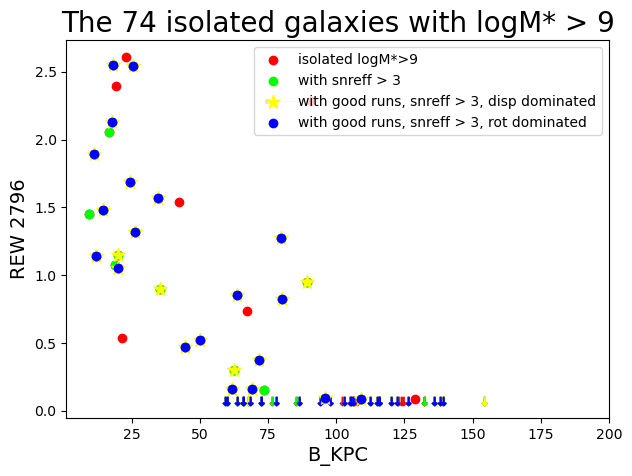

In [344]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies with logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_snr3_abs["B_KPC"], isol_snr3_abs["REW_2796"], c = 'lime', marker = "o",\
                 label = "with snreff > 3", zorder = 3)

plt.scatter(isol_snr3_good_runs_abs["B_KPC"], isol_snr3_good_runs_abs["REW_2796"], c = 'yellow', marker = "*",\
                 label = "with good runs, snreff > 3, disp dominated", zorder = 3, s = 100)

plt.scatter(isol_snr3_good_runs_rot_abs["B_KPC"], isol_snr3_good_runs_rot_abs["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

#plt.scatter(g11083["B_KPC"], g11083["REW_2796"], marker = "s", s = 150, color = "black")

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_noabs["B_KPC"], isol_snr3_noabs["detection_limit_p75"], c = "lime",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_good_runs_noabs["B_KPC"], isol_snr3_good_runs_noabs["detection_limit_p75"], c = "yellow",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_good_runs_rot_noabs["B_KPC"], isol_snr3_good_runs_rot_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

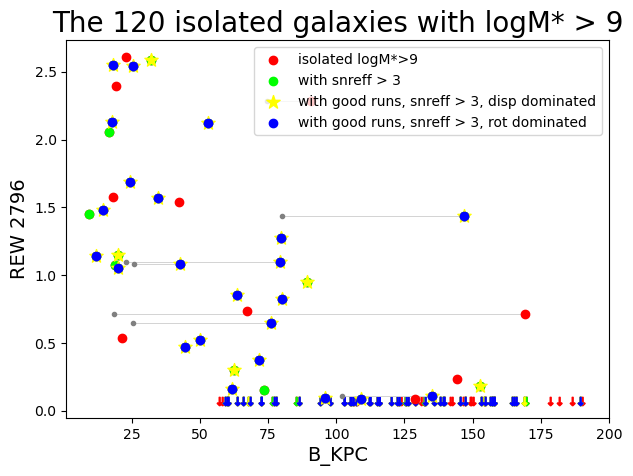

Text(0, 0.5, '$W^{2796}_{r}$')

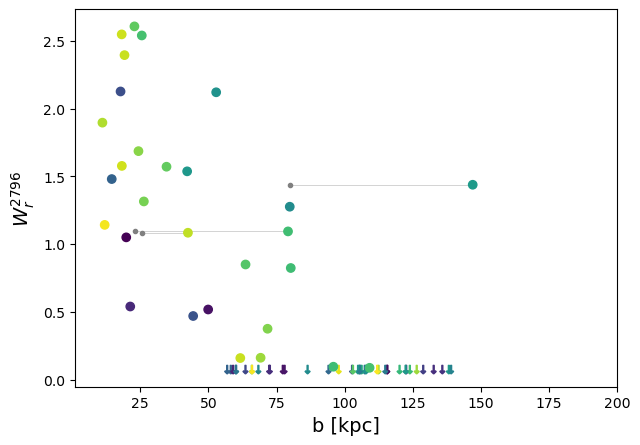

In [105]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = isol_visu_rot_abs["alpha"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 90)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["detection_limit_p75"], c = isol_visu_rot_noabs["alpha"],\
             marker = "$\downarrow$", vmin = 0, vmax = 90)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
#plt.legend()

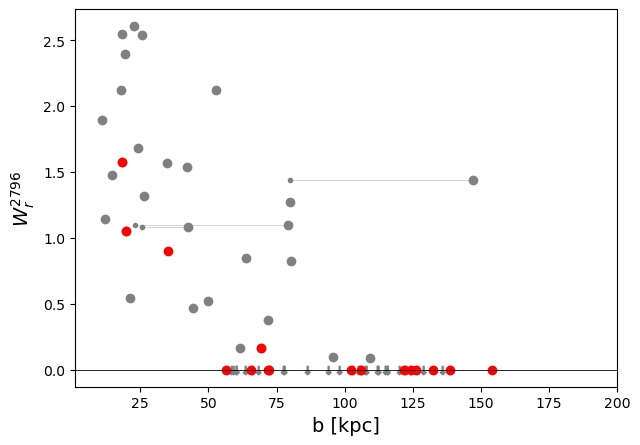

In [153]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = "gray",\
                 label = "isolated logM*>9", zorder = 2)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["REW_2796"], c = "gray",\
             marker = "$\downarrow$")
    
plt.scatter(isol_low_incl["B_KPC"], isol_low_incl["REW_2796"], c = "red",\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 90)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.axhline(0, c = "black", linewidth = 0.6)
#plt.legend()

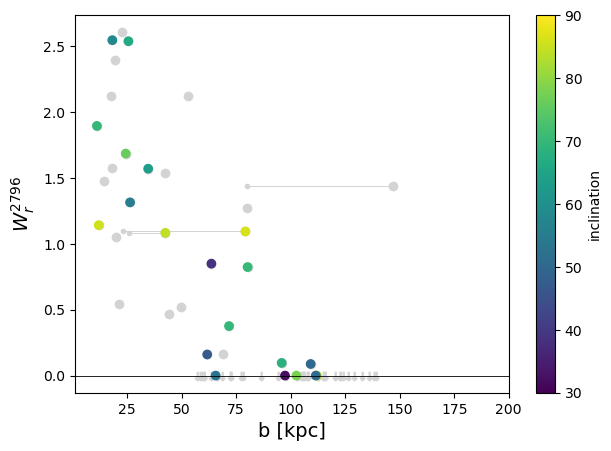

In [160]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "lightgray", zorder = 2)
    
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = "lightgray",\
                 label = "isolated logM*>9", zorder = 2)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["REW_2796"], c = "lightgray",\
             marker = "$\downarrow$")
    
plt.scatter(isol_high_alpha["B_KPC"], isol_high_alpha["REW_2796"], c = isol_high_alpha["inclination"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 30, vmax = 90)
plt.colorbar(label = "inclination")

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.axhline(0, c = "black", linewidth = 0.6)
#plt.legend()

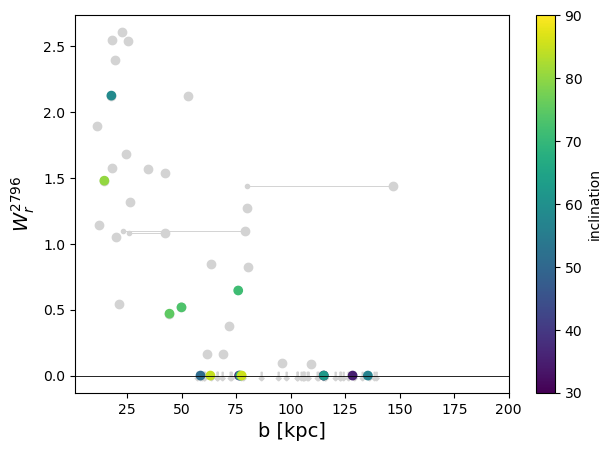

In [164]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "lightgray", zorder = 2)
    
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = "lightgray",\
                 label = "isolated logM*>9", zorder = 2)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["REW_2796"], c = "lightgray",\
             marker = "$\downarrow$")
    
plt.scatter(isol_low_alpha["B_KPC"], isol_low_alpha["REW_2796"], c = isol_low_alpha["inclination"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 30, vmax = 90)
plt.colorbar(label = "inclination")

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.axhline(0, c = "black", linewidth = 0.6)
#plt.legend()

Text(0, 0.5, 'logSFR')

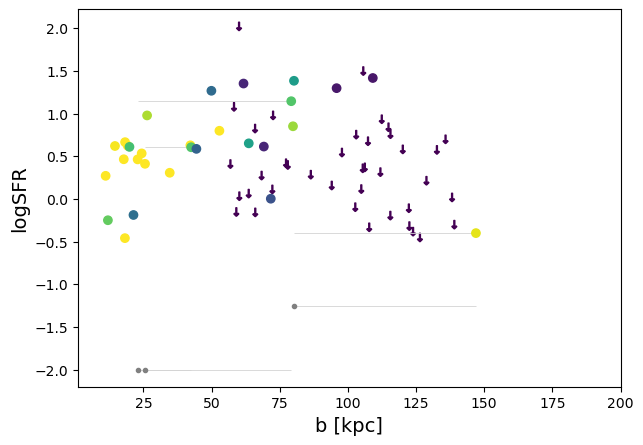

In [113]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["logSFR"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["logSFR"], marker = ".", c = "gray", zorder = 2)
    

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["logSFR"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["logSFR"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("logSFR", size = 14)
#plt.legend()

Text(0, 0.5, 'log(M)')

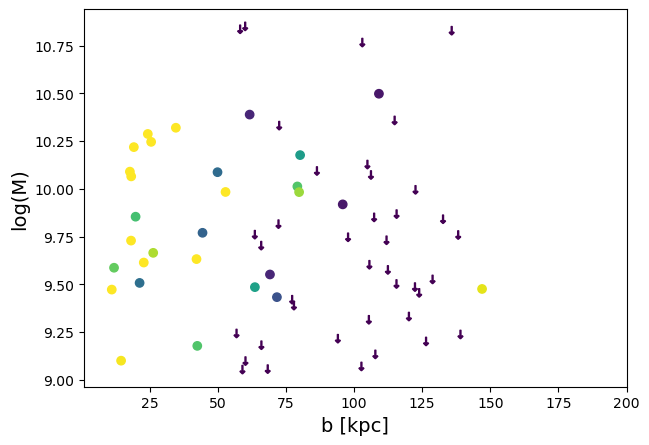

In [118]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["sed_logMass"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["sed_logMass"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(M)", size = 14)
#plt.legend()

Text(0, 0.5, 'inclination')

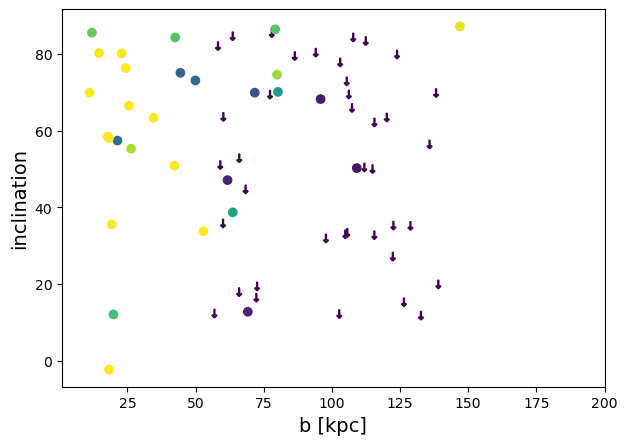

In [117]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["inclination"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["inclination"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("inclination", size = 14)
#plt.legend()

Text(0, 0.5, 'alpha')

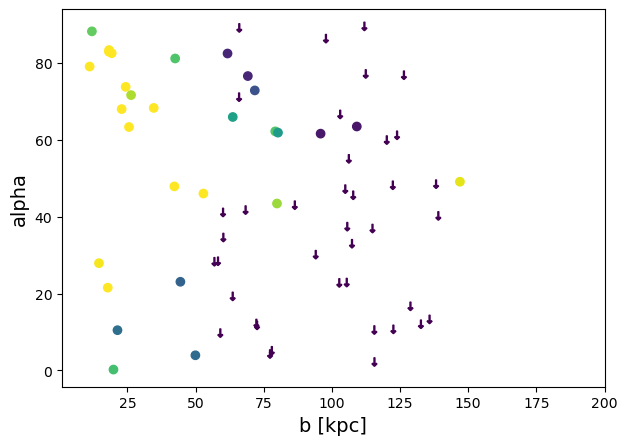

In [201]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["alpha"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["alpha"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("alpha", size = 14)
#plt.legend()

Text(0, 0.5, 'v/sig')

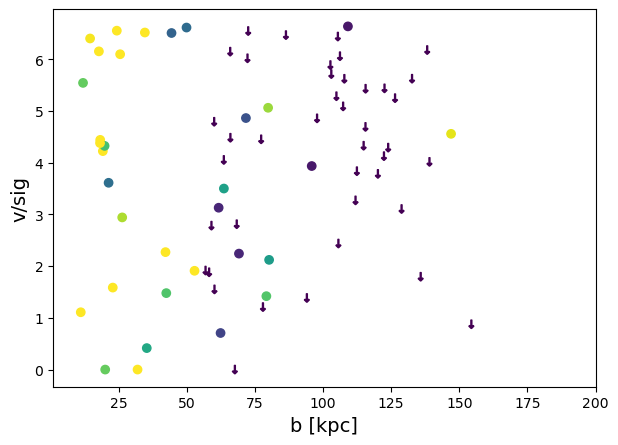

In [205]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_visu_abs["B_KPC"], \
            (isol_visu_abs["v22"]+0.01)/isol_visu_abs["velocity_dispersion_2Rd"], \
            c = isol_visu_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_noabs["B_KPC"], \
            (isol_visu_noabs["v22"]+0.01)/isol_visu_noabs["velocity_dispersion_2Rd"], \
            c = isol_visu_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("v/sig", size = 14)
#plt.legend()

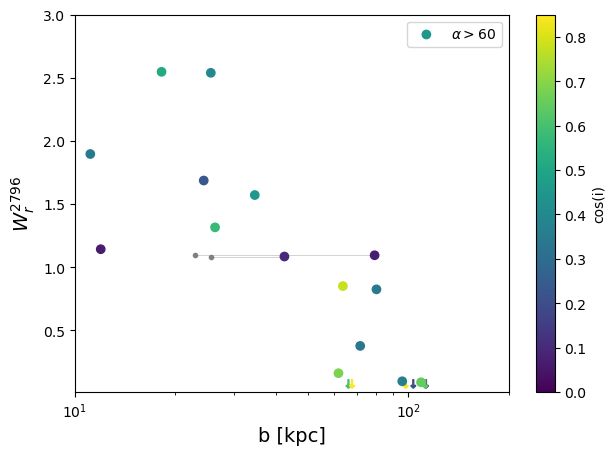

In [103]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], \
            c = np.cos(isol_high_alpha_abs["inclination"]*2*np.pi/360), vmin = 0, vmax = 0.85,\
            label = "$\\alpha > 60$", zorder = 2)
plt.colorbar(label = "cos(i)")

plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], \
            c = np.cos(isol_high_alpha_noabs["inclination"]*2*np.pi/360), vmin = 0, vmax = 0.85, \
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.ylim((0.01, 3))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

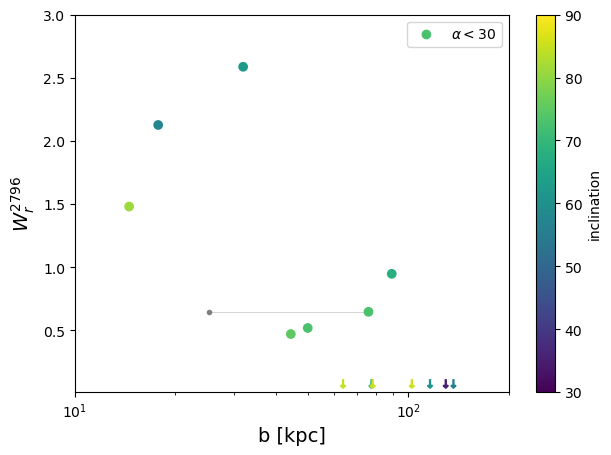

In [91]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_low_alpha_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = isol_low_alpha_abs["inclination"],\
                 vmin = 30, vmax = 90, label = "$\\alpha < 30$", zorder = 2)
plt.colorbar(label = "inclination")
plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], \
            c = isol_low_alpha_noabs["inclination"], vmin = 30, vmax = 90,\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.ylim((0.01, 3))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

Text(0, 0.5, '$W^{2796}_{r}$')

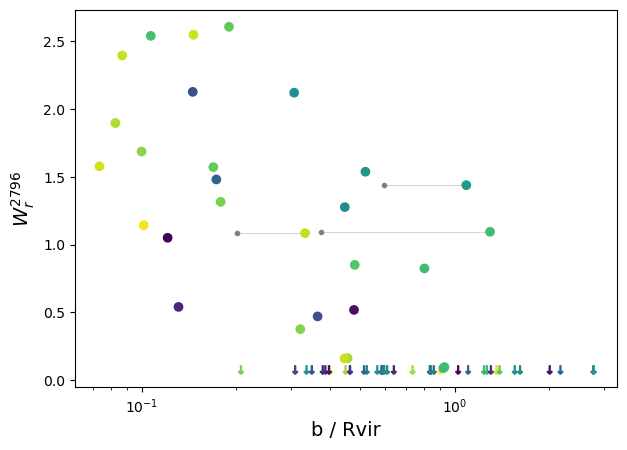

In [93]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_visu_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])/g["Rvir"]
    bmax = np.max(K["B_KPC"])/g["Rvir"]
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"]/g["Rvir"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    

plt.scatter(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"], isol_visu_rot_abs["REW_2796"],\
            c = isol_visu_rot_abs["alpha"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 90)
plt.scatter(isol_visu_rot_noabs["B_KPC"]/isol_visu_rot_noabs["Rvir"], isol_visu_rot_noabs["detection_limit_p75"],\
            c = isol_visu_rot_noabs["alpha"],\
             marker = "$\downarrow$", vmin = 0, vmax = 90)

#plt.xlim((1, 200))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b / Rvir", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
#plt.legend()

Text(0, 0.5, 'REW 2796')

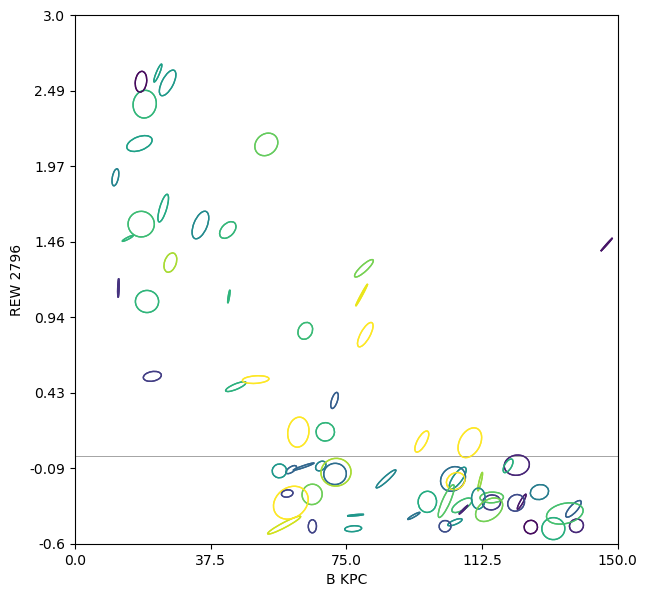

In [82]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0
xmax = 150
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.2

for i, g in isol_visu_rot.iterrows():
    xx = (g["B_KPC"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B KPC")
plt.ylabel("REW 2796")

Text(0, 0.5, 'REW 2796')

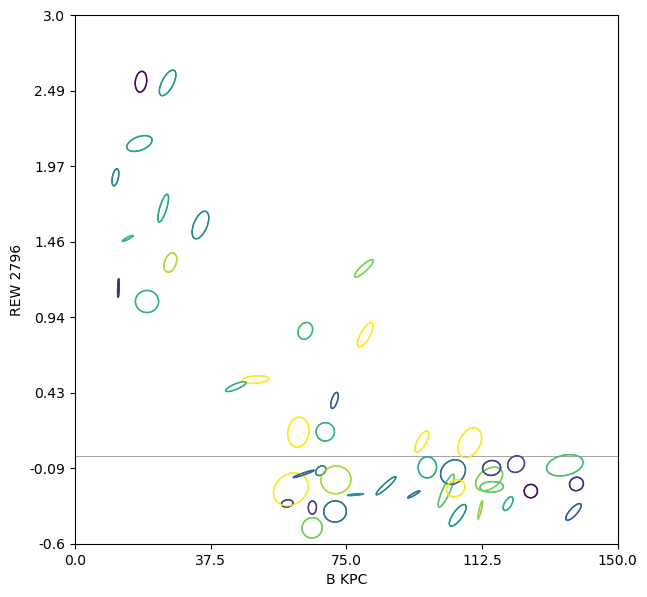

In [357]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0
xmax = 150
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.2

for i, g in isol_snr3_good_runs_rot.iterrows():
    xx = (g["B_KPC"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B KPC")
plt.ylabel("REW 2796")

Text(0, 0.5, 'REW 2796')

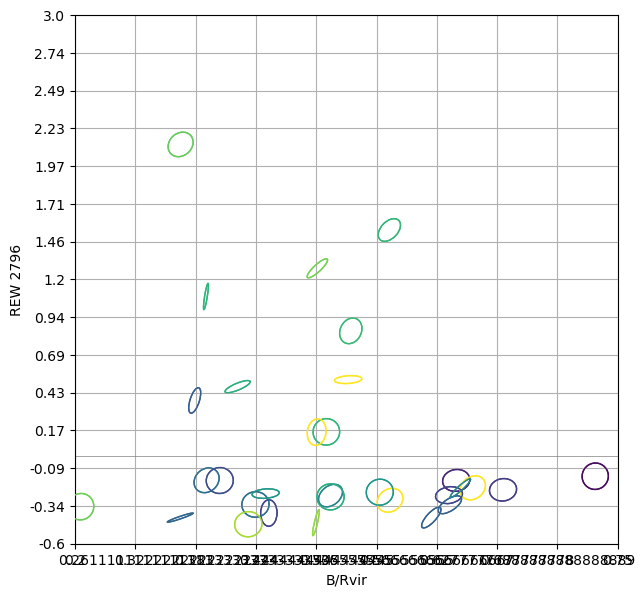

In [101]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0.2
xmax = 0.75
massmin = 9
massmax = 12
ss_min = 0.05
ss_max = 0.051
vmin = -0.5
vmax = 1.2

for i, g in isol_visu_rot.iterrows():
    xx = (g["B_KPC"]/g["Rvir"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1.0, 10)
xvalues = np.linspace(0.2, 0.75, 10)
ydata = np.linspace(0,1, 15)
yvalues = np.round(np.linspace(ymin, ymax, 15),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.grid()
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B/Rvir")
plt.ylabel("REW 2796")

Text(0, 0.5, 'REW 2796')

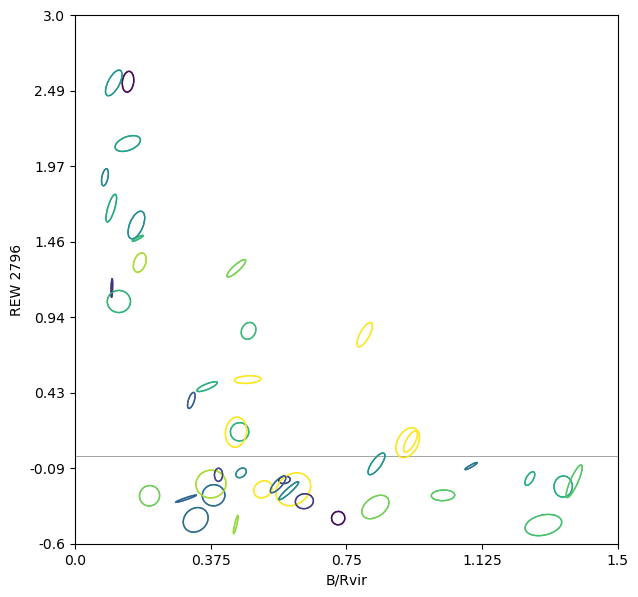

In [360]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0
xmax = 1.5
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.2

for i, g in isol_snr3_good_runs_rot.iterrows():
    xx = (g["B_KPC"]/g["Rvir"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B/Rvir")
plt.ylabel("REW 2796")

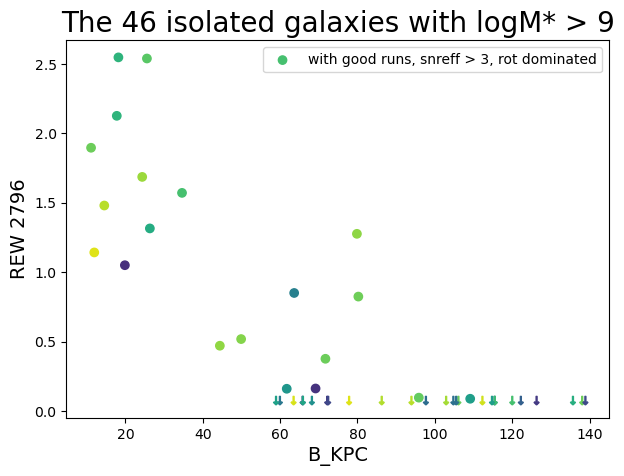

In [378]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_snr3_good_runs_rot)) + " isolated galaxies with logM* > 9", size = 20)

plt.scatter(isol_snr3_good_runs_rot_abs["B_KPC"],\
            isol_snr3_good_runs_rot_abs["REW_2796"], \
            c = isol_snr3_good_runs_rot_abs["inclination"], vmin = 0, vmax = 90,\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

plt.scatter(isol_snr3_good_runs_rot_noabs["B_KPC"],\
            isol_snr3_good_runs_rot_noabs["detection_limit_p75"],\
            c = isol_snr3_good_runs_rot_noabs["inclination"], vmin = 0, vmax = 90,\
             marker = "$\downarrow$")

#plt.xlim((0, 1.2))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

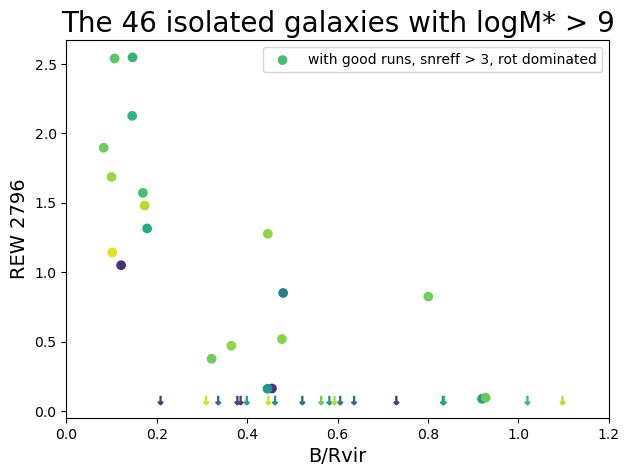

In [385]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_snr3_good_runs_rot)) + " isolated galaxies with logM* > 9", size = 20)

plt.scatter(isol_snr3_good_runs_rot_abs["B_KPC"]/isol_snr3_good_runs_rot_abs["Rvir"],\
            isol_snr3_good_runs_rot_abs["REW_2796"], \
            c = isol_snr3_good_runs_rot_abs["inclination"], vmin = 0, vmax = 90,\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

plt.scatter(isol_snr3_good_runs_rot_noabs["B_KPC"]/isol_snr3_good_runs_rot_noabs["Rvir"],\
            isol_snr3_good_runs_rot_noabs["detection_limit_p75"],\
            c = isol_snr3_good_runs_rot_noabs["inclination"], vmin = 0, vmax = 90,\
             marker = "$\downarrow$")

plt.xlim((0, 1.2))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B/Rvir", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

### Closests

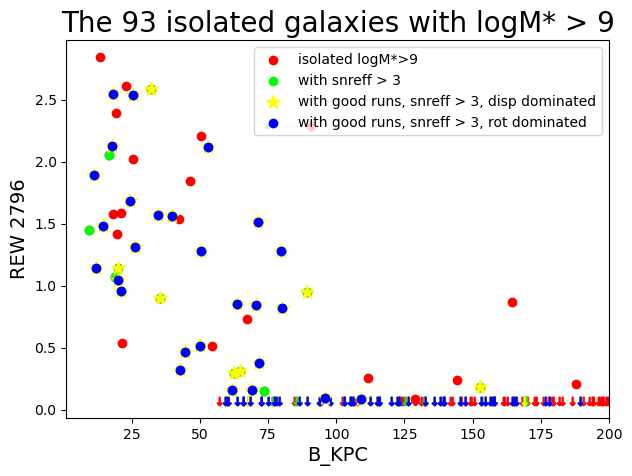

In [179]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies with logM* > 9", size = 20)

dv = 0.5e6
for i, g in closest_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(closest_9_abs["B_KPC"], closest_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(closest_9_snr3_abs["B_KPC"], closest_9_snr3_abs["REW_2796"], c = 'lime', marker = "o",\
                 label = "with snreff > 3", zorder = 3)

plt.scatter(closest_9_snr3_good_runs_abs["B_KPC"], closest_9_snr3_good_runs_abs["REW_2796"], c = 'yellow', marker = "*",\
                 label = "with good runs, snreff > 3, disp dominated", zorder = 3, s = 100)

plt.scatter(closest_9_snr3_good_runs_rot_abs["B_KPC"], closest_9_snr3_good_runs_rot_abs["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

#plt.scatter(g11083["B_KPC"], g11083["REW_2796"], marker = "s", s = 150, color = "black")

plt.scatter(closest_9_noabs["B_KPC"], closest_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")

plt.scatter(closest_9_snr3_noabs["B_KPC"], closest_9_snr3_noabs["detection_limit_p75"], c = "lime",\
             marker = "$\downarrow$")

plt.scatter(closest_9_snr3_good_runs_noabs["B_KPC"], closest_9_snr3_good_runs_noabs["detection_limit_p75"], c = "yellow",\
             marker = "$\downarrow$")

plt.scatter(closest_9_snr3_good_runs_rot_noabs["B_KPC"], closest_9_snr3_good_runs_rot_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

Text(0, 0.5, 'REW 2796')

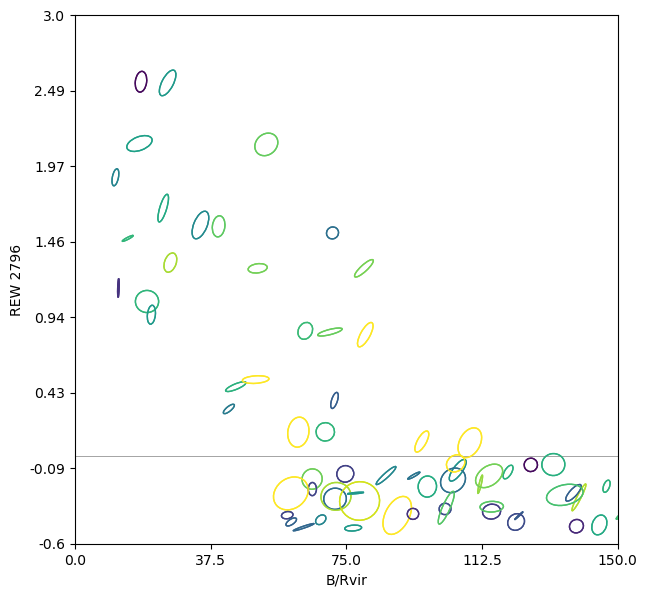

In [362]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0
xmax = 150
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.2

for i, g in closest_9_snr3_good_runs_rot.iterrows():
    xx = (g["B_KPC"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B/Rvir")
plt.ylabel("REW 2796")

Text(0, 0.5, 'REW 2796')

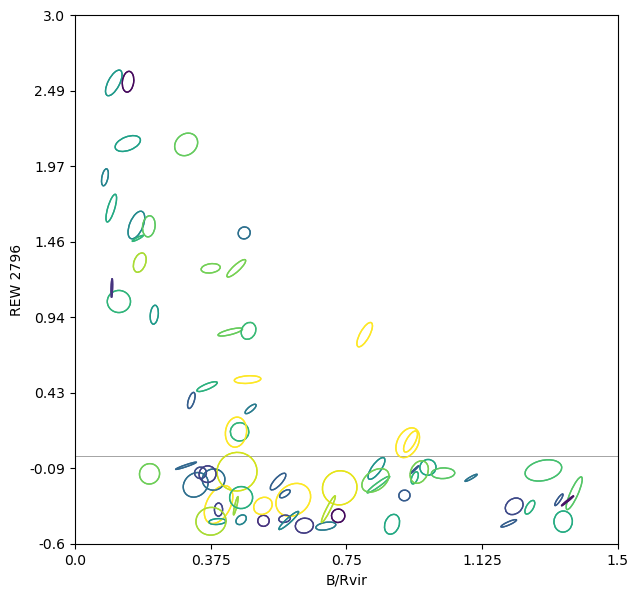

In [361]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0
xmax = 1.5
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.2

for i, g in closest_9_snr3_good_runs_rot.iterrows():
    xx = (g["B_KPC"]/g["Rvir"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B/Rvir")
plt.ylabel("REW 2796")

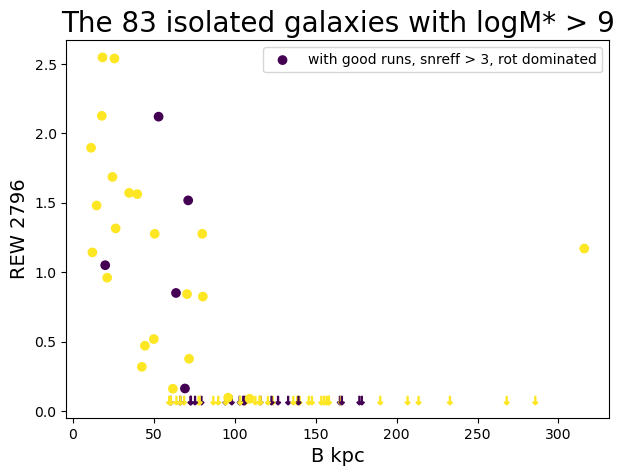

In [384]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(closest_9_snr3_good_runs_rot)) + " isolated galaxies with logM* > 9", size = 20)

plt.scatter(closest_9_snr3_good_runs_rot_abs["B_KPC"],\
            closest_9_snr3_good_runs_rot_abs["REW_2796"], \
            c = closest_9_snr3_good_runs_rot_abs["inclination"], vmin = 39, vmax = 40,\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

plt.scatter(closest_9_snr3_good_runs_rot_noabs["B_KPC"],\
            closest_9_snr3_good_runs_rot_noabs["detection_limit_p75"],\
            c = closest_9_snr3_good_runs_rot_noabs["inclination"], vmin = 39, vmax = 40,\
             marker = "$\downarrow$")

#plt.xlim((0, 1.2))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B kpc", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

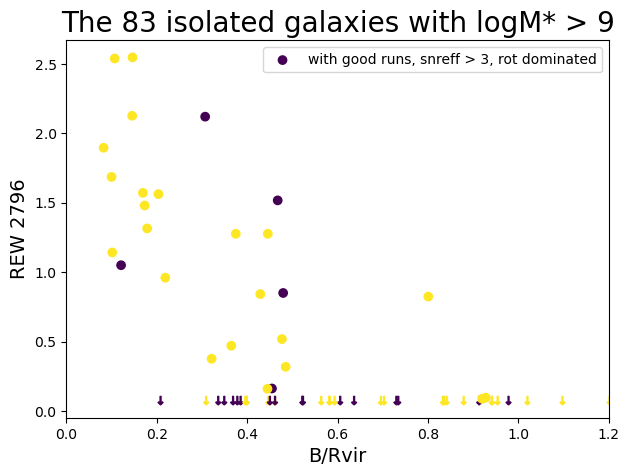

In [382]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(closest_9_snr3_good_runs_rot)) + " isolated galaxies with logM* > 9", size = 20)

plt.scatter(closest_9_snr3_good_runs_rot_abs["B_KPC"]/closest_9_snr3_good_runs_rot_abs["Rvir"],\
            closest_9_snr3_good_runs_rot_abs["REW_2796"], \
            c = closest_9_snr3_good_runs_rot_abs["inclination"], vmin = 39, vmax = 40,\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

plt.scatter(closest_9_snr3_good_runs_rot_noabs["B_KPC"]/closest_9_snr3_good_runs_rot_noabs["Rvir"],\
            closest_9_snr3_good_runs_rot_noabs["detection_limit_p75"],\
            c = closest_9_snr3_good_runs_rot_noabs["inclination"], vmin = 39, vmax = 40,\
             marker = "$\downarrow$")

plt.xlim((0, 1.2))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B/Rvir", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

**Low inclination have less absorption. One or two exceptions**

## Disp vs REW

Text(0, 0.5, 'W2796')

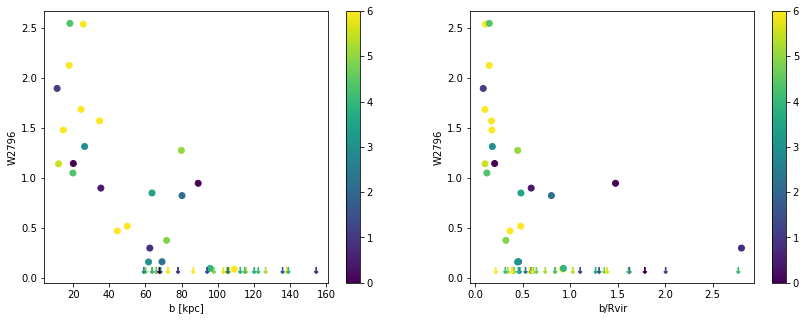

In [351]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.scatter(isol_snr3_good_runs_abs["B_KPC"],\
            isol_snr3_good_runs_abs["REW_2796"], \
            c = (isol_snr3_good_runs_abs["v22"]+0.01)/isol_snr3_good_runs_abs["velocity_dispersion_2Re"],\
           vmin = 0, vmax = 6)
plt.colorbar()
plt.scatter(isol_snr3_good_runs_noabs["B_KPC"],\
            isol_snr3_good_runs_noabs["detection_limit_p75"], \
            c = (isol_snr3_good_runs_noabs["v22"]+0.01)/isol_snr3_good_runs_noabs["velocity_dispersion_2Re"],\
            vmin = 0, vmax = 6, marker = "$\downarrow$")
plt.xlabel("b [kpc]")
plt.ylabel("W2796")

plt.subplot(122)
plt.scatter(isol_snr3_good_runs_abs["B_KPC"]/isol_snr3_good_runs_abs["Rvir"],\
            isol_snr3_good_runs_abs["REW_2796"], \
            c = (isol_snr3_good_runs_abs["v22"]+0.01)/isol_snr3_good_runs_abs["velocity_dispersion_2Re"],\
           vmin = 0, vmax = 6)
plt.colorbar()
plt.scatter(isol_snr3_good_runs_noabs["B_KPC"]/isol_snr3_good_runs_noabs["Rvir"],\
            isol_snr3_good_runs_noabs["detection_limit_p75"], \
            c = (isol_snr3_good_runs_noabs["v22"]+0.01)/isol_snr3_good_runs_noabs["velocity_dispersion_2Re"],\
            vmin = 0, vmax = 6, marker = "$\downarrow$")
#plt.xlim((0,3))
#plt.ylim((0,3))
plt.xlabel("b/Rvir")
plt.ylabel("W2796")
#plt.xscale("log")

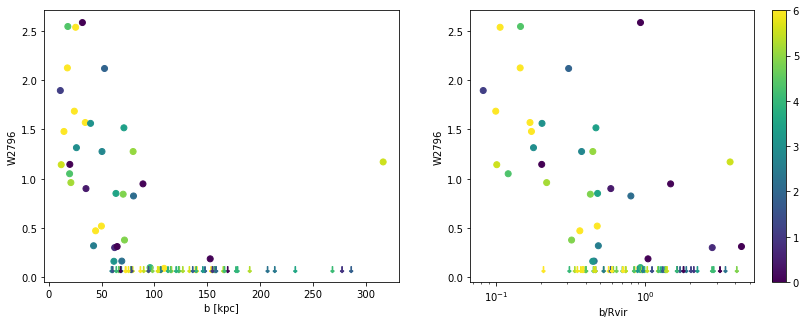

In [193]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.scatter(closest_9_snr3_good_runs_abs["B_KPC"],\
            closest_9_snr3_good_runs_abs["REW_2796"], \
            c = (closest_9_snr3_good_runs_abs["v22"]+0.01)/closest_9_snr3_good_runs_abs["velocity_dispersion_2Re"],\
           vmin = 0, vmax = 6)
#plt.colorbar()
plt.scatter(closest_9_snr3_good_runs_noabs["B_KPC"],\
            closest_9_snr3_good_runs_noabs["detection_limit_p75"], \
            c = (closest_9_snr3_good_runs_noabs["v22"]+0.01)/closest_9_snr3_good_runs_noabs["velocity_dispersion_2Re"],\
            vmin = 0, vmax = 6, marker = "$\downarrow$")
plt.xlabel("b [kpc]")
plt.ylabel("W2796")
#plt.xlim((30,100))

plt.subplot(122)
plt.scatter(closest_9_snr3_good_runs_abs["B_KPC"]/closest_9_snr3_good_runs_abs["Rvir"],\
            closest_9_snr3_good_runs_abs["REW_2796"], \
            c = (closest_9_snr3_good_runs_abs["v22"]+0.01)/closest_9_snr3_good_runs_abs["velocity_dispersion_2Re"],\
           vmin = 0, vmax = 6)
plt.colorbar()
plt.scatter(closest_9_snr3_good_runs_noabs["B_KPC"]/closest_9_snr3_good_runs_noabs["Rvir"],\
            closest_9_snr3_good_runs_noabs["detection_limit_p75"], \
            c = (closest_9_snr3_good_runs_noabs["v22"]+0.01)/closest_9_snr3_good_runs_noabs["velocity_dispersion_2Re"],\
            vmin = 0, vmax = 6, marker = "$\downarrow$")

#plt.ylim((0,3))
#plt.xlim((0.5,1))
plt.xlabel("b/Rvir")
plt.ylabel("W2796")
plt.xscale("log")

## Disp vs Dvabs

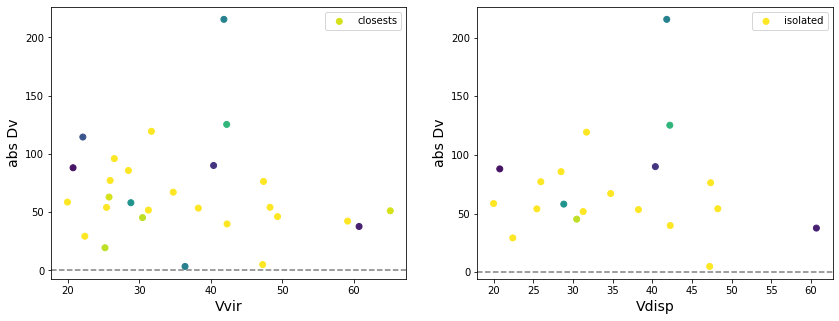

In [352]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.scatter(closest_9_snr3_good_runs_rot_abs["velocity_dispersion_2Re"], \
            closest_9_snr3_good_runs_rot_abs["vel_absorption_dist"]/1e3, \
            c = closest_9_snr3_good_runs_rot_abs["snr_eff"], vmin = 3, vmax = 8, label = "closests")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vvir", size = 14)
plt.ylabel("abs Dv", size = 14)
plt.legend()

plt.subplot(122)
plt.scatter(isol_snr3_good_runs_rot_abs["velocity_dispersion_2Re"], \
            isol_snr3_good_runs_rot_abs["vel_absorption_dist"]/1e3,\
            c = isol_snr3_good_runs_rot_abs["snr_eff"], vmin = 3, vmax = 8, label = "isolated")
#plt.colorbar(label = "snr")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vdisp", size = 14)
plt.ylabel("abs Dv", size = 14)
plt.legend()

In [173]:
psf = 0.6 # arcsec
pixel = 0.2 # arcsec
min_re = 0.8 # pixel
re_psf = min_re*pixel/psf
re_psf

0.2666666666666667

## Closest galaxies

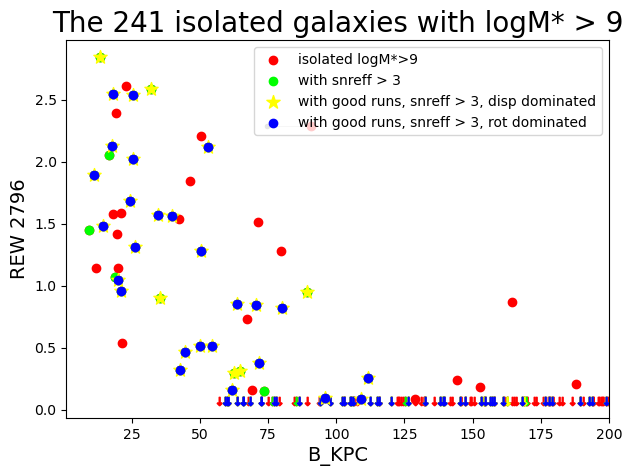

In [200]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(closest_9)) + " isolated galaxies with logM* > 9", size = 20)

dv = 0.5e6
for i, g in closest_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(closest_9_abs["B_KPC"], closest_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(closest_9_snr3_abs["B_KPC"], closest_9_snr3_abs["REW_2796"], c = 'lime', marker = "o",\
                 label = "with snreff > 3", zorder = 3)

plt.scatter(closest_9_snr3_good_runs_abs["B_KPC"], closest_9_snr3_good_runs_abs["REW_2796"], c = 'yellow', marker = "*",\
                 label = "with good runs, snreff > 3, disp dominated", zorder = 3, s = 100)

plt.scatter(closest_9_snr3_good_runs_rot_abs["B_KPC"], closest_9_snr3_good_runs_rot_abs["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

#plt.scatter(g11083["B_KPC"], g11083["REW_2796"], marker = "s", s = 150, color = "black")

plt.scatter(closest_9_noabs["B_KPC"], closest_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")

plt.scatter(closest_9_snr3_noabs["B_KPC"], closest_9_snr3_noabs["detection_limit_p75"], c = "lime",\
             marker = "$\downarrow$")

plt.scatter(closest_9_snr3_good_runs_noabs["B_KPC"], closest_9_snr3_good_runs_noabs["detection_limit_p75"], c = "yellow",\
             marker = "$\downarrow$")

plt.scatter(closest_9_snr3_good_runs_rot_noabs["B_KPC"], closest_9_snr3_good_runs_rot_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

(0.0, 150.0)

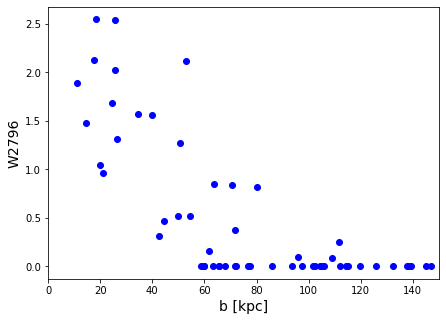

In [213]:
plt.figure(figsize = (7,5))
plt.scatter(closest_9_snr3_good_runs_rot["B_KPC"], closest_9_snr3_good_runs_rot["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("W2796", size = 14)
#plt.xscale("log")
plt.xlim((0,150))

(0.0, 1.5)

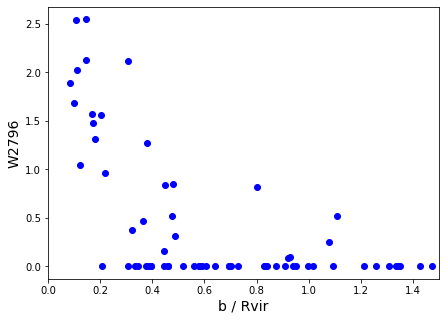

In [199]:
plt.figure(figsize = (7,5))
plt.scatter(closest_9_snr3_good_runs_rot["B_KPC"]/closest_9_snr3_good_runs_rot["Rvir"],\
            closest_9_snr3_good_runs_rot["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)
plt.xlabel("b / Rvir", size = 14)
plt.ylabel("W2796", size = 14)
#plt.xscale("log")
plt.xlim((0,1.5))

(0.0, 1.5)

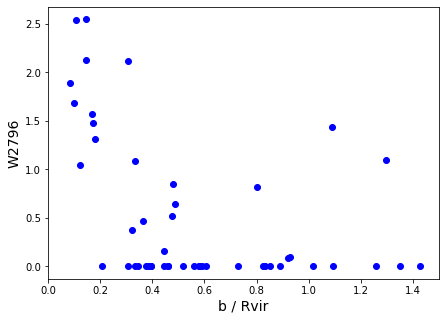

In [210]:
plt.figure(figsize = (7,5))
plt.scatter(isol_snr3_good_runs_rot["B_KPC"]/isol_snr3_good_runs_rot["Rvir"],\
            isol_snr3_good_runs_rot["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)
plt.xlabel("b / Rvir", size = 14)
plt.ylabel("W2796", size = 14)
#plt.xscale("log")
plt.xlim((0,1.5))

Text(0, 0.5, 'W2796')

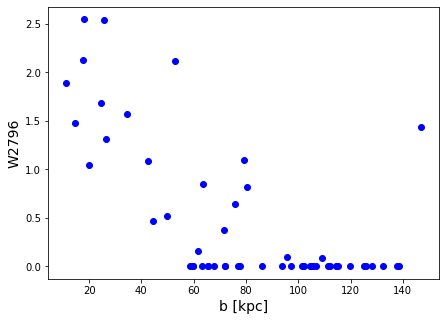

In [212]:
plt.figure(figsize = (7,5))
plt.scatter(isol_snr3_good_runs_rot["B_KPC"],\
            isol_snr3_good_runs_rot["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("W2796", size = 14)
#plt.xscale("log")
#plt.xlim((0,1.5))

Text(0, 0.5, 'v/sig')

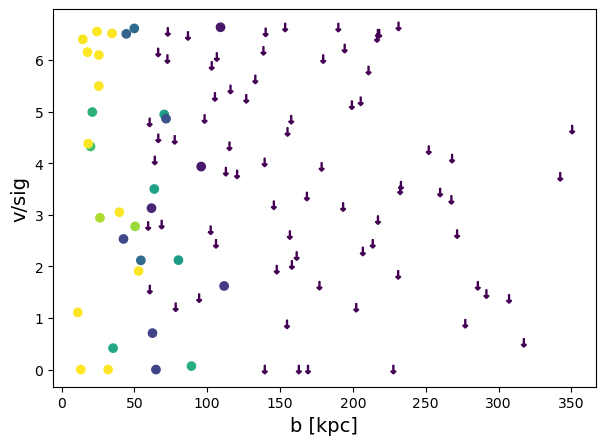

In [209]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(closest_9_snr3_good_runs_abs["B_KPC"], \
            (closest_9_snr3_good_runs_abs["v22"]+0.01)/closest_9_snr3_good_runs_abs["velocity_dispersion_2Rd"], \
            c = closest_9_snr3_good_runs_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(closest_9_snr3_good_runs_noabs["B_KPC"], \
            (closest_9_snr3_good_runs_noabs["v22"]+0.01)/closest_9_snr3_good_runs_noabs["velocity_dispersion_2Rd"], \
            c = closest_9_snr3_good_runs_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)

#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("v/sig", size = 14)
#plt.legend()

In [ ]:
k1 = closest_9_abs["B_KPC"]>75
k2 = closest_9_abs["REW_2796"]>2

cas = closest_9_abs[k1 & k2]
cas = cas.squeeze()

In [ ]:
z_abs = cas["z_absorption"]
dz = dv*(1+z_abs)/const.c.value 
k1 = np.abs(R_all["Z"] - z_abs) < dz
k2 = R_all["field_id"] == cas["field_id"]
k3 = R_all["B_KPC"] <= cas["B_KPC"]
K = R_all[k1 & k2 & k3]

In [ ]:
K[["ID", "ZCONF", "sed_logMass"]]

In [ ]:
f1 = np.abs(R["Z"] - cas["Z"])*const.c.value/(1+cas["Z"])<dv
f2 = R["field_id"] == cas["field_id"]
f3 = R["sed_logMass"] > 0
F = R[f1 & f2 & f3]
F

In [ ]:
if (cas["sed_logMass"] > 0) and (cas["is_QSO"] == 0) and \
(cas["is_star"] == 0 and (cas["ZCONF"]>= 0)):
    # we then compute the number of neighbours within B + b_sep kpc:
    f1 = np.abs(R["Z"] - cas["Z"])*const.c.value/(1+cas["Z"])<dv
    f2 = R["field_id"] == cas["field_id"]
    f3 = R["sed_logMass"] > 0
    F = R[f1 & f2 & f3]
    Bclosest = np.min(F["B_KPC"])

    # We don't consider galaxies in groups as primary:
    if (len(F) <= 4) and (cas["B_KPC"] == Bclosest):
        print("is closest")


## Behroozi relation

Text(0, 0.5, '$\\log(M*/M_{\\odot})$')

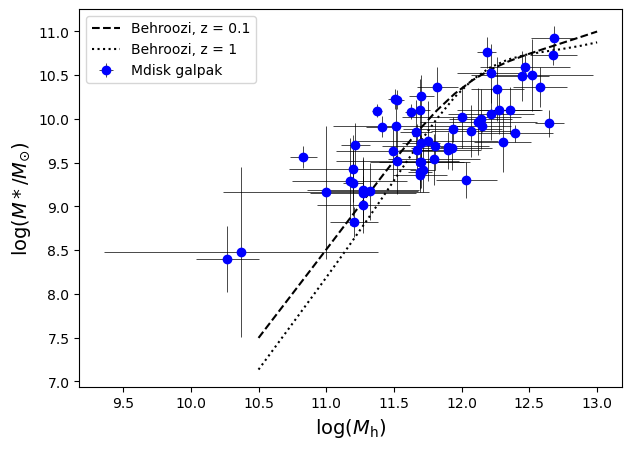

In [194]:
logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)

plt.figure(figsize = (7,5), dpi = 100)
plt.errorbar(np.array(isol_snr3_good_runs_rot["log_Mvir"]), np.array(isol_snr3_good_runs_rot["log_Mdisk"]),\
             xerr = np.array(isol_snr3_good_runs_rot["log_Mvir_err"]), \
             yerr = np.array(isol_snr3_good_runs_rot["log_Mdisk_err"]), \
             label = "Mdisk galpak", linestyle = "none", color = "blue", marker = "o", ecolor = "black", \
            linewidth = 0.5)
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")
plt.legend()
plt.xlabel("$\log(M_{\mathrm{h}})$", size = 14)
plt.ylabel("$\log(M*/M_{\odot})$", size = 14)


# Model

## log(W) = f(b_kpc)

### Isolated galaxies

In [281]:
xx = np.array(isol_visu_rot[["B_KPC"]])
xx = xx.T
yy = np.array(np.log10(isol_visu_rot["REW_2796"]+0.05))

In [283]:
def model_b(X, p0, k_b):
    W = p0 + X[0]*k_b
    return W


def log_likelihood_b(params):
    # unpack the current parameters:
    p0, k_b = params

    # compute for each x point, where it should lie in y
    y_model = model_b(xx, p0=p0, k_b = k_b)
    # compute likelihood
    loglike = -0.5 * (((y_model - yy))**2).sum()

    return loglike

def prior_transform_b(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -20 to +20
    params[0] = cube[0] * 40 - 20
    # b:
    params[1] = cube[1] * 10 - 5
    return params

In [284]:
parameters = ['p0', 'k_b']
sampler = ReactiveNestedSampler(parameters, log_likelihood_b, prior_transform_b)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]


DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-8208757.67, Lmax=-182.42


DEBUG:ultranest:iteration=80, ncalls=886, regioncalls=3440, ndraw=40, logz=-6427086.26, remainder_fraction=100.0000%, Lmin=-6423464.32, Lmax=-182.42


DEBUG:ultranest:iteration=160, ncalls=974, regioncalls=6960, ndraw=40, logz=-5242268.96, remainder_fraction=100.0000%, Lmin=-5218049.96, Lmax=-182.42


DEBUG:ultranest:iteration=179, ncalls=995, regioncalls=7800, ndraw=40, logz=-5014395.11, remainder_fraction=100.0000%, Lmin=-5000263.92, Lmax=-182.42


DEBUG:ultranest:iteration=240, ncalls=1065, regioncalls=10600, ndraw=40, logz=-4353811.07, remainder_fraction=100.0000%, Lmin=-4326141.62, Lmax=-182.42


DEBUG:ultranest:iteration=320, ncalls=1152, regioncalls=14080, ndraw=40, logz=-3598393.14, remainder_fraction=100.0000%, Lmin=-3589218.72, Lmax=-182.42


DEBUG:ultranest:iteration=358, ncalls=1197, regioncalls=15880, ndraw=40, logz=-3268674.48, remainder_fraction=100.0000%, Lmin=-3254643.13, Lmax=-182.42


DEBUG:ultranest:iteration=400, ncalls=1247, regioncalls=17880, ndraw=40, logz=-3015039.15, remainder_fraction=100.0000%, Lmin=-2995503.33, Lmax=-182.42


DEBUG:ultranest:iteration=480, ncalls=1334, regioncalls=21360, ndraw=40, logz=-2554863.34, remainder_fraction=100.0000%, Lmin=-2552801.05, Lmax=-182.42


DEBUG:ultranest:iteration=537, ncalls=1399, regioncalls=23960, ndraw=40, logz=-2195245.18, remainder_fraction=100.0000%, Lmin=-2194307.33, Lmax=-98.07


DEBUG:ultranest:iteration=560, ncalls=1428, regioncalls=25120, ndraw=40, logz=-2052898.23, remainder_fraction=100.0000%, Lmin=-2050205.44, Lmax=-98.07


DEBUG:ultranest:iteration=640, ncalls=1515, regioncalls=28600, ndraw=40, logz=-1697719.31, remainder_fraction=100.0000%, Lmin=-1691609.06, Lmax=-18.97


DEBUG:ultranest:iteration=720, ncalls=1610, regioncalls=32400, ndraw=40, logz=-1386453.96, remainder_fraction=100.0000%, Lmin=-1381353.24, Lmax=-18.97


DEBUG:ultranest:iteration=800, ncalls=1699, regioncalls=35960, ndraw=40, logz=-1135100.85, remainder_fraction=100.0000%, Lmin=-1134493.70, Lmax=-18.97


DEBUG:ultranest:iteration=880, ncalls=1799, regioncalls=39960, ndraw=40, logz=-916459.01, remainder_fraction=100.0000%, Lmin=-916132.25, Lmax=-18.97


DEBUG:ultranest:iteration=895, ncalls=1820, regioncalls=40800, ndraw=40, logz=-873194.11, remainder_fraction=100.0000%, Lmin=-870698.29, Lmax=-18.97


DEBUG:ultranest:iteration=960, ncalls=1894, regioncalls=43760, ndraw=40, logz=-744934.04, remainder_fraction=100.0000%, Lmin=-743867.89, Lmax=-18.97


DEBUG:ultranest:iteration=1040, ncalls=1988, regioncalls=47520, ndraw=40, logz=-619889.19, remainder_fraction=100.0000%, Lmin=-616269.28, Lmax=-18.97


DEBUG:ultranest:iteration=1120, ncalls=2078, regioncalls=51120, ndraw=40, logz=-503465.63, remainder_fraction=100.0000%, Lmin=-503332.03, Lmax=-18.97


DEBUG:ultranest:iteration=1200, ncalls=2179, regioncalls=55160, ndraw=40, logz=-416144.72, remainder_fraction=100.0000%, Lmin=-414641.60, Lmax=-18.97


DEBUG:ultranest:iteration=1253, ncalls=2242, regioncalls=57680, ndraw=40, logz=-351792.41, remainder_fraction=100.0000%, Lmin=-351711.23, Lmax=-18.97


DEBUG:ultranest:iteration=1280, ncalls=2271, regioncalls=58840, ndraw=40, logz=-329116.72, remainder_fraction=100.0000%, Lmin=-328989.46, Lmax=-18.97


DEBUG:ultranest:iteration=1360, ncalls=2365, regioncalls=62600, ndraw=40, logz=-270188.97, remainder_fraction=100.0000%, Lmin=-270101.78, Lmax=-18.97


DEBUG:ultranest:iteration=1432, ncalls=2449, regioncalls=65960, ndraw=40, logz=-224390.38, remainder_fraction=100.0000%, Lmin=-223981.26, Lmax=-18.97


DEBUG:ultranest:iteration=1440, ncalls=2459, regioncalls=66360, ndraw=40, logz=-222072.50, remainder_fraction=100.0000%, Lmin=-222001.52, Lmax=-18.97


DEBUG:ultranest:iteration=1520, ncalls=2549, regioncalls=69960, ndraw=40, logz=-188605.15, remainder_fraction=100.0000%, Lmin=-188596.34, Lmax=-18.97


DEBUG:ultranest:iteration=1600, ncalls=2643, regioncalls=73720, ndraw=40, logz=-160416.54, remainder_fraction=100.0000%, Lmin=-160254.30, Lmax=-18.97


DEBUG:ultranest:iteration=1676, ncalls=2732, regioncalls=77280, ndraw=40, logz=-133944.95, remainder_fraction=100.0000%, Lmin=-133260.90, Lmax=-18.97


DEBUG:ultranest:iteration=1680, ncalls=2738, regioncalls=77520, ndraw=40, logz=-132841.33, remainder_fraction=100.0000%, Lmin=-132674.12, Lmax=-18.97


DEBUG:ultranest:iteration=1760, ncalls=2826, regioncalls=81040, ndraw=40, logz=-106120.91, remainder_fraction=100.0000%, Lmin=-105963.70, Lmax=-18.97


DEBUG:ultranest:iteration=1790, ncalls=2867, regioncalls=82680, ndraw=40, logz=-99456.36, remainder_fraction=100.0000%, Lmin=-99249.92, Lmax=-18.97


DEBUG:ultranest:iteration=1840, ncalls=2930, regioncalls=85200, ndraw=40, logz=-88573.35, remainder_fraction=100.0000%, Lmin=-88534.38, Lmax=-18.97


DEBUG:ultranest:iteration=1920, ncalls=3025, regioncalls=89000, ndraw=40, logz=-71396.76, remainder_fraction=100.0000%, Lmin=-71383.18, Lmax=-18.97


DEBUG:ultranest:iteration=1969, ncalls=3088, regioncalls=91560, ndraw=40, logz=-63999.92, remainder_fraction=100.0000%, Lmin=-63930.21, Lmax=-10.10


DEBUG:ultranest:iteration=2000, ncalls=3128, regioncalls=93160, ndraw=40, logz=-60332.67, remainder_fraction=100.0000%, Lmin=-60309.72, Lmax=-10.10


DEBUG:ultranest:iteration=2080, ncalls=3214, regioncalls=96640, ndraw=40, logz=-49957.22, remainder_fraction=100.0000%, Lmin=-49843.62, Lmax=-10.10


DEBUG:ultranest:iteration=2148, ncalls=3295, regioncalls=100000, ndraw=40, logz=-42469.05, remainder_fraction=100.0000%, Lmin=-42417.19, Lmax=-10.10


DEBUG:ultranest:iteration=2160, ncalls=3307, regioncalls=100480, ndraw=40, logz=-41535.14, remainder_fraction=100.0000%, Lmin=-41337.00, Lmax=-10.10


DEBUG:ultranest:iteration=2240, ncalls=3398, regioncalls=104160, ndraw=40, logz=-34825.33, remainder_fraction=100.0000%, Lmin=-34616.48, Lmax=-10.10


DEBUG:ultranest:iteration=2320, ncalls=3498, regioncalls=108160, ndraw=40, logz=-29186.78, remainder_fraction=100.0000%, Lmin=-29135.36, Lmax=-10.10


DEBUG:ultranest:iteration=2327, ncalls=3506, regioncalls=108480, ndraw=40, logz=-28959.07, remainder_fraction=100.0000%, Lmin=-28929.58, Lmax=-10.10


DEBUG:ultranest:iteration=2400, ncalls=3588, regioncalls=111800, ndraw=40, logz=-23928.08, remainder_fraction=100.0000%, Lmin=-23900.43, Lmax=-10.10


DEBUG:ultranest:iteration=2480, ncalls=3685, regioncalls=115680, ndraw=40, logz=-20068.45, remainder_fraction=100.0000%, Lmin=-20054.40, Lmax=-10.10


DEBUG:ultranest:iteration=2506, ncalls=3717, regioncalls=116960, ndraw=40, logz=-18916.90, remainder_fraction=100.0000%, Lmin=-18879.98, Lmax=-10.10


DEBUG:ultranest:iteration=2560, ncalls=3779, regioncalls=119600, ndraw=40, logz=-16457.46, remainder_fraction=100.0000%, Lmin=-16374.49, Lmax=-10.10


DEBUG:ultranest:iteration=2640, ncalls=3870, regioncalls=123240, ndraw=40, logz=-13772.21, remainder_fraction=100.0000%, Lmin=-13621.95, Lmax=-10.10


DEBUG:ultranest:iteration=2685, ncalls=3931, regioncalls=125680, ndraw=40, logz=-12682.05, remainder_fraction=100.0000%, Lmin=-12669.35, Lmax=-10.10


DEBUG:ultranest:iteration=2720, ncalls=3968, regioncalls=127200, ndraw=40, logz=-11496.07, remainder_fraction=100.0000%, Lmin=-11470.37, Lmax=-10.10


DEBUG:ultranest:iteration=2800, ncalls=4069, regioncalls=131240, ndraw=40, logz=-9804.70, remainder_fraction=100.0000%, Lmin=-9720.59, Lmax=-10.10


DEBUG:ultranest:iteration=2864, ncalls=4142, regioncalls=134160, ndraw=40, logz=-8573.56, remainder_fraction=100.0000%, Lmin=-8561.19, Lmax=-10.10


DEBUG:ultranest:iteration=2880, ncalls=4158, regioncalls=134840, ndraw=40, logz=-8410.03, remainder_fraction=100.0000%, Lmin=-8391.98, Lmax=-10.10


DEBUG:ultranest:iteration=2960, ncalls=4251, regioncalls=138560, ndraw=40, logz=-7189.49, remainder_fraction=100.0000%, Lmin=-7158.75, Lmax=-10.10


DEBUG:ultranest:iteration=3040, ncalls=4346, regioncalls=142360, ndraw=40, logz=-6091.05, remainder_fraction=100.0000%, Lmin=-6039.69, Lmax=-10.10


DEBUG:ultranest:iteration=3043, ncalls=4350, regioncalls=142520, ndraw=40, logz=-6040.36, remainder_fraction=100.0000%, Lmin=-6026.22, Lmax=-10.10


DEBUG:ultranest:iteration=3120, ncalls=4435, regioncalls=145960, ndraw=40, logz=-5265.38, remainder_fraction=100.0000%, Lmin=-5193.48, Lmax=-10.10


DEBUG:ultranest:iteration=3200, ncalls=4524, regioncalls=149520, ndraw=40, logz=-4609.91, remainder_fraction=100.0000%, Lmin=-4596.71, Lmax=-10.10


DEBUG:ultranest:iteration=3280, ncalls=4617, regioncalls=153240, ndraw=40, logz=-4117.18, remainder_fraction=100.0000%, Lmin=-4101.69, Lmax=-10.10


DEBUG:ultranest:iteration=3360, ncalls=4711, regioncalls=157000, ndraw=40, logz=-3536.49, remainder_fraction=100.0000%, Lmin=-3521.80, Lmax=-10.10


DEBUG:ultranest:iteration=3401, ncalls=4765, regioncalls=159160, ndraw=40, logz=-3351.09, remainder_fraction=100.0000%, Lmin=-3338.05, Lmax=-10.10


DEBUG:ultranest:iteration=3440, ncalls=4807, regioncalls=161000, ndraw=40, logz=-3163.87, remainder_fraction=100.0000%, Lmin=-3148.61, Lmax=-10.10


DEBUG:ultranest:iteration=3520, ncalls=4902, regioncalls=164800, ndraw=40, logz=-2866.88, remainder_fraction=100.0000%, Lmin=-2851.83, Lmax=-10.10


DEBUG:ultranest:iteration=3580, ncalls=4987, regioncalls=168200, ndraw=40, logz=-2673.94, remainder_fraction=100.0000%, Lmin=-2657.51, Lmax=-10.10


DEBUG:ultranest:iteration=3600, ncalls=5011, regioncalls=169200, ndraw=40, logz=-2613.52, remainder_fraction=100.0000%, Lmin=-2602.47, Lmax=-10.10


DEBUG:ultranest:iteration=3680, ncalls=5115, regioncalls=173360, ndraw=40, logz=-2411.77, remainder_fraction=100.0000%, Lmin=-2399.41, Lmax=-10.10


DEBUG:ultranest:iteration=3759, ncalls=5214, regioncalls=177360, ndraw=40, logz=-2198.74, remainder_fraction=100.0000%, Lmin=-2186.32, Lmax=-10.10


DEBUG:ultranest:iteration=3760, ncalls=5215, regioncalls=177400, ndraw=40, logz=-2197.40, remainder_fraction=100.0000%, Lmin=-2184.42, Lmax=-10.10


DEBUG:ultranest:iteration=3840, ncalls=5307, regioncalls=181080, ndraw=40, logz=-1963.05, remainder_fraction=100.0000%, Lmin=-1951.30, Lmax=-10.10


DEBUG:ultranest:iteration=3920, ncalls=5418, regioncalls=185520, ndraw=40, logz=-1767.77, remainder_fraction=100.0000%, Lmin=-1753.38, Lmax=-10.10


DEBUG:ultranest:iteration=3938, ncalls=5440, regioncalls=186400, ndraw=40, logz=-1733.09, remainder_fraction=100.0000%, Lmin=-1719.35, Lmax=-10.10


DEBUG:ultranest:iteration=4000, ncalls=5513, regioncalls=189360, ndraw=40, logz=-1611.49, remainder_fraction=100.0000%, Lmin=-1600.06, Lmax=-10.10


DEBUG:ultranest:iteration=4080, ncalls=5612, regioncalls=193320, ndraw=40, logz=-1475.43, remainder_fraction=100.0000%, Lmin=-1463.25, Lmax=-10.10


DEBUG:ultranest:iteration=4117, ncalls=5653, regioncalls=194960, ndraw=40, logz=-1414.72, remainder_fraction=100.0000%, Lmin=-1402.62, Lmax=-10.10


DEBUG:ultranest:iteration=4160, ncalls=5696, regioncalls=196760, ndraw=40, logz=-1335.37, remainder_fraction=100.0000%, Lmin=-1323.72, Lmax=-10.10


DEBUG:ultranest:iteration=4240, ncalls=5792, regioncalls=200600, ndraw=40, logz=-1218.55, remainder_fraction=100.0000%, Lmin=-1206.68, Lmax=-10.10


DEBUG:ultranest:iteration=4320, ncalls=5886, regioncalls=204360, ndraw=40, logz=-1112.64, remainder_fraction=100.0000%, Lmin=-1100.44, Lmax=-10.10


DEBUG:ultranest:iteration=4400, ncalls=5996, regioncalls=208760, ndraw=40, logz=-1007.82, remainder_fraction=100.0000%, Lmin=-993.34, Lmax=-10.10


DEBUG:ultranest:iteration=4475, ncalls=6097, regioncalls=212840, ndraw=40, logz=-911.28, remainder_fraction=100.0000%, Lmin=-898.40, Lmax=-9.30


DEBUG:ultranest:iteration=4480, ncalls=6102, regioncalls=213040, ndraw=40, logz=-904.88, remainder_fraction=100.0000%, Lmin=-892.51, Lmax=-9.30


DEBUG:ultranest:iteration=4560, ncalls=6198, regioncalls=216880, ndraw=40, logz=-817.33, remainder_fraction=100.0000%, Lmin=-805.66, Lmax=-9.30


DEBUG:ultranest:iteration=4640, ncalls=6304, regioncalls=221120, ndraw=40, logz=-744.11, remainder_fraction=100.0000%, Lmin=-731.07, Lmax=-9.30


DEBUG:ultranest:iteration=4654, ncalls=6319, regioncalls=221720, ndraw=40, logz=-732.78, remainder_fraction=100.0000%, Lmin=-720.33, Lmax=-9.30


DEBUG:ultranest:iteration=4720, ncalls=6398, regioncalls=224920, ndraw=40, logz=-675.56, remainder_fraction=100.0000%, Lmin=-662.66, Lmax=-9.30


DEBUG:ultranest:iteration=4800, ncalls=6495, regioncalls=228800, ndraw=40, logz=-608.97, remainder_fraction=100.0000%, Lmin=-596.80, Lmax=-9.30


DEBUG:ultranest:iteration=4833, ncalls=6544, regioncalls=230800, ndraw=40, logz=-588.71, remainder_fraction=100.0000%, Lmin=-576.45, Lmax=-9.30


DEBUG:ultranest:iteration=4880, ncalls=6597, regioncalls=232960, ndraw=40, logz=-554.17, remainder_fraction=100.0000%, Lmin=-541.37, Lmax=-9.30


DEBUG:ultranest:iteration=4960, ncalls=6702, regioncalls=237160, ndraw=40, logz=-505.19, remainder_fraction=100.0000%, Lmin=-493.10, Lmax=-9.30


DEBUG:ultranest:iteration=5033, ncalls=6799, regioncalls=241040, ndraw=40, logz=-464.72, remainder_fraction=100.0000%, Lmin=-452.13, Lmax=-9.30


DEBUG:ultranest:iteration=5040, ncalls=6806, regioncalls=241320, ndraw=40, logz=-462.20, remainder_fraction=100.0000%, Lmin=-449.95, Lmax=-9.30


DEBUG:ultranest:iteration=5120, ncalls=6909, regioncalls=245440, ndraw=40, logz=-418.01, remainder_fraction=100.0000%, Lmin=-404.77, Lmax=-9.30


DEBUG:ultranest:iteration=5191, ncalls=7004, regioncalls=249280, ndraw=40, logz=-386.61, remainder_fraction=100.0000%, Lmin=-374.15, Lmax=-9.22


DEBUG:ultranest:iteration=5200, ncalls=7014, regioncalls=249720, ndraw=40, logz=-381.33, remainder_fraction=100.0000%, Lmin=-368.78, Lmax=-9.22


DEBUG:ultranest:iteration=5280, ncalls=7106, regioncalls=253400, ndraw=40, logz=-346.56, remainder_fraction=100.0000%, Lmin=-333.68, Lmax=-9.22


DEBUG:ultranest:iteration=5360, ncalls=7211, regioncalls=257600, ndraw=40, logz=-309.04, remainder_fraction=100.0000%, Lmin=-296.78, Lmax=-9.22


DEBUG:ultranest:iteration=5370, ncalls=7223, regioncalls=258120, ndraw=40, logz=-305.52, remainder_fraction=100.0000%, Lmin=-292.43, Lmax=-9.22


DEBUG:ultranest:iteration=5440, ncalls=7302, regioncalls=261360, ndraw=40, logz=-281.86, remainder_fraction=100.0000%, Lmin=-269.69, Lmax=-8.63


DEBUG:ultranest:iteration=5520, ncalls=7404, regioncalls=265440, ndraw=40, logz=-255.95, remainder_fraction=100.0000%, Lmin=-243.62, Lmax=-8.63


DEBUG:ultranest:iteration=5549, ncalls=7445, regioncalls=267160, ndraw=40, logz=-247.05, remainder_fraction=100.0000%, Lmin=-234.82, Lmax=-8.63


DEBUG:ultranest:iteration=5600, ncalls=7505, regioncalls=269560, ndraw=40, logz=-236.29, remainder_fraction=100.0000%, Lmin=-224.41, Lmax=-8.63


DEBUG:ultranest:iteration=5680, ncalls=7602, regioncalls=273440, ndraw=40, logz=-217.51, remainder_fraction=100.0000%, Lmin=-204.63, Lmax=-8.58


DEBUG:ultranest:iteration=5728, ncalls=7660, regioncalls=275800, ndraw=40, logz=-206.30, remainder_fraction=100.0000%, Lmin=-193.49, Lmax=-8.58


DEBUG:ultranest:iteration=5760, ncalls=7694, regioncalls=277160, ndraw=40, logz=-198.72, remainder_fraction=100.0000%, Lmin=-186.49, Lmax=-8.58


DEBUG:ultranest:iteration=5840, ncalls=7785, regioncalls=280800, ndraw=40, logz=-180.95, remainder_fraction=100.0000%, Lmin=-168.97, Lmax=-8.58


DEBUG:ultranest:iteration=5907, ncalls=7866, regioncalls=284080, ndraw=40, logz=-168.23, remainder_fraction=100.0000%, Lmin=-155.58, Lmax=-8.58


DEBUG:ultranest:iteration=5920, ncalls=7881, regioncalls=284680, ndraw=40, logz=-165.90, remainder_fraction=100.0000%, Lmin=-153.68, Lmax=-8.58


DEBUG:ultranest:iteration=6000, ncalls=7975, regioncalls=288440, ndraw=40, logz=-151.80, remainder_fraction=100.0000%, Lmin=-138.74, Lmax=-8.58


DEBUG:ultranest:iteration=6080, ncalls=8082, regioncalls=292720, ndraw=40, logz=-137.10, remainder_fraction=100.0000%, Lmin=-124.94, Lmax=-8.58


DEBUG:ultranest:iteration=6086, ncalls=8092, regioncalls=293160, ndraw=40, logz=-136.41, remainder_fraction=100.0000%, Lmin=-124.16, Lmax=-8.58


DEBUG:ultranest:iteration=6160, ncalls=8180, regioncalls=296720, ndraw=40, logz=-126.21, remainder_fraction=100.0000%, Lmin=-114.04, Lmax=-8.58


DEBUG:ultranest:iteration=6240, ncalls=8284, regioncalls=300880, ndraw=40, logz=-115.50, remainder_fraction=100.0000%, Lmin=-103.13, Lmax=-8.51


DEBUG:ultranest:iteration=6320, ncalls=8378, regioncalls=304640, ndraw=40, logz=-106.36, remainder_fraction=100.0000%, Lmin=-93.75, Lmax=-8.51


DEBUG:ultranest:iteration=6400, ncalls=8483, regioncalls=308840, ndraw=40, logz=-98.46, remainder_fraction=100.0000%, Lmin=-86.18, Lmax=-8.51


DEBUG:ultranest:iteration=6444, ncalls=8543, regioncalls=311280, ndraw=40, logz=-94.33, remainder_fraction=100.0000%, Lmin=-81.65, Lmax=-8.51


DEBUG:ultranest:iteration=6480, ncalls=8586, regioncalls=313000, ndraw=40, logz=-91.54, remainder_fraction=100.0000%, Lmin=-79.20, Lmax=-8.51


DEBUG:ultranest:iteration=6560, ncalls=8684, regioncalls=316920, ndraw=40, logz=-85.16, remainder_fraction=100.0000%, Lmin=-72.90, Lmax=-8.51


DEBUG:ultranest:iteration=6623, ncalls=8759, regioncalls=319960, ndraw=40, logz=-79.86, remainder_fraction=100.0000%, Lmin=-67.32, Lmax=-8.51


DEBUG:ultranest:iteration=6640, ncalls=8779, regioncalls=320800, ndraw=40, logz=-78.56, remainder_fraction=100.0000%, Lmin=-66.27, Lmax=-8.51


DEBUG:ultranest:iteration=6720, ncalls=8877, regioncalls=324720, ndraw=40, logz=-74.07, remainder_fraction=100.0000%, Lmin=-61.94, Lmax=-8.51


DEBUG:ultranest:iteration=6800, ncalls=8973, regioncalls=328560, ndraw=40, logz=-69.30, remainder_fraction=100.0000%, Lmin=-56.88, Lmax=-8.51


DEBUG:ultranest:iteration=6880, ncalls=9077, regioncalls=332720, ndraw=40, logz=-64.49, remainder_fraction=100.0000%, Lmin=-52.37, Lmax=-8.51


DEBUG:ultranest:iteration=6960, ncalls=9171, regioncalls=336480, ndraw=40, logz=-60.58, remainder_fraction=100.0000%, Lmin=-48.32, Lmax=-8.51


DEBUG:ultranest:iteration=6981, ncalls=9197, regioncalls=337560, ndraw=40, logz=-59.74, remainder_fraction=100.0000%, Lmin=-47.39, Lmax=-8.51


DEBUG:ultranest:iteration=7040, ncalls=9265, regioncalls=340400, ndraw=40, logz=-57.15, remainder_fraction=100.0000%, Lmin=-44.82, Lmax=-8.51


DEBUG:ultranest:iteration=7120, ncalls=9376, regioncalls=344840, ndraw=40, logz=-53.56, remainder_fraction=100.0000%, Lmin=-41.30, Lmax=-8.45


DEBUG:ultranest:iteration=7160, ncalls=9421, regioncalls=346680, ndraw=40, logz=-52.11, remainder_fraction=100.0000%, Lmin=-39.70, Lmax=-8.45


DEBUG:ultranest:iteration=7200, ncalls=9464, regioncalls=348400, ndraw=40, logz=-50.55, remainder_fraction=100.0000%, Lmin=-38.04, Lmax=-8.45


DEBUG:ultranest:iteration=7280, ncalls=9559, regioncalls=352200, ndraw=40, logz=-47.61, remainder_fraction=100.0000%, Lmin=-35.13, Lmax=-8.45


DEBUG:ultranest:iteration=7360, ncalls=9661, regioncalls=356280, ndraw=40, logz=-45.25, remainder_fraction=100.0000%, Lmin=-32.96, Lmax=-8.45


DEBUG:ultranest:iteration=7440, ncalls=9763, regioncalls=360360, ndraw=40, logz=-43.08, remainder_fraction=100.0000%, Lmin=-30.71, Lmax=-8.45


DEBUG:ultranest:iteration=7518, ncalls=9863, regioncalls=364400, ndraw=40, logz=-40.86, remainder_fraction=100.0000%, Lmin=-28.30, Lmax=-8.45


DEBUG:ultranest:iteration=7520, ncalls=9865, regioncalls=364480, ndraw=40, logz=-40.80, remainder_fraction=100.0000%, Lmin=-28.21, Lmax=-8.45


DEBUG:ultranest:iteration=7600, ncalls=9956, regioncalls=368120, ndraw=40, logz=-38.59, remainder_fraction=100.0000%, Lmin=-26.06, Lmax=-8.45


DEBUG:ultranest:iteration=7680, ncalls=10056, regioncalls=372120, ndraw=40, logz=-36.71, remainder_fraction=100.0000%, Lmin=-24.11, Lmax=-8.45


DEBUG:ultranest:iteration=7697, ncalls=10075, regioncalls=372920, ndraw=40, logz=-36.32, remainder_fraction=100.0000%, Lmin=-23.84, Lmax=-8.45


DEBUG:ultranest:iteration=7760, ncalls=10146, regioncalls=375760, ndraw=40, logz=-35.09, remainder_fraction=99.9999%, Lmin=-22.80, Lmax=-8.45


DEBUG:ultranest:iteration=7840, ncalls=10244, regioncalls=379680, ndraw=40, logz=-33.72, remainder_fraction=99.9998%, Lmin=-21.37, Lmax=-8.45


DEBUG:ultranest:iteration=7920, ncalls=10347, regioncalls=383800, ndraw=40, logz=-32.52, remainder_fraction=99.9993%, Lmin=-20.21, Lmax=-8.45


DEBUG:ultranest:iteration=8000, ncalls=10437, regioncalls=387400, ndraw=40, logz=-31.42, remainder_fraction=99.9978%, Lmin=-18.97, Lmax=-8.45


DEBUG:ultranest:iteration=8055, ncalls=10510, regioncalls=390520, ndraw=40, logz=-30.69, remainder_fraction=99.9953%, Lmin=-18.24, Lmax=-8.45


DEBUG:ultranest:iteration=8080, ncalls=10540, regioncalls=391720, ndraw=40, logz=-30.38, remainder_fraction=99.9935%, Lmin=-17.98, Lmax=-8.45


DEBUG:ultranest:iteration=8160, ncalls=10631, regioncalls=395360, ndraw=40, logz=-29.49, remainder_fraction=99.9845%, Lmin=-17.18, Lmax=-8.45


DEBUG:ultranest:iteration=8234, ncalls=10724, regioncalls=399120, ndraw=40, logz=-28.74, remainder_fraction=99.9677%, Lmin=-16.36, Lmax=-8.45


DEBUG:ultranest:iteration=8240, ncalls=10732, regioncalls=399440, ndraw=40, logz=-28.68, remainder_fraction=99.9655%, Lmin=-16.28, Lmax=-8.45


DEBUG:ultranest:iteration=8320, ncalls=10824, regioncalls=403120, ndraw=40, logz=-27.88, remainder_fraction=99.9224%, Lmin=-15.48, Lmax=-8.45


DEBUG:ultranest:iteration=8400, ncalls=10932, regioncalls=407440, ndraw=40, logz=-27.19, remainder_fraction=99.8428%, Lmin=-14.84, Lmax=-8.45


DEBUG:ultranest:iteration=8413, ncalls=10949, regioncalls=408160, ndraw=40, logz=-27.09, remainder_fraction=99.8250%, Lmin=-14.76, Lmax=-8.45


DEBUG:ultranest:iteration=8480, ncalls=11028, regioncalls=411320, ndraw=40, logz=-26.61, remainder_fraction=99.7150%, Lmin=-14.32, Lmax=-8.45


DEBUG:ultranest:iteration=8560, ncalls=11126, regioncalls=415240, ndraw=40, logz=-26.09, remainder_fraction=99.5146%, Lmin=-13.74, Lmax=-8.45


DEBUG:ultranest:iteration=8592, ncalls=11170, regioncalls=417040, ndraw=40, logz=-25.88, remainder_fraction=99.3989%, Lmin=-13.52, Lmax=-8.45


DEBUG:ultranest:iteration=8640, ncalls=11224, regioncalls=419240, ndraw=40, logz=-25.58, remainder_fraction=99.1989%, Lmin=-13.19, Lmax=-8.45


DEBUG:ultranest:iteration=8720, ncalls=11329, regioncalls=423440, ndraw=40, logz=-25.11, remainder_fraction=98.7235%, Lmin=-12.70, Lmax=-8.45


DEBUG:ultranest:iteration=8771, ncalls=11395, regioncalls=426120, ndraw=40, logz=-24.83, remainder_fraction=98.3084%, Lmin=-12.46, Lmax=-8.45


DEBUG:ultranest:iteration=8800, ncalls=11425, regioncalls=427320, ndraw=40, logz=-24.69, remainder_fraction=98.0090%, Lmin=-12.29, Lmax=-8.45


DEBUG:ultranest:iteration=8880, ncalls=11520, regioncalls=431120, ndraw=40, logz=-24.31, remainder_fraction=97.0428%, Lmin=-11.99, Lmax=-8.45


DEBUG:ultranest:iteration=8950, ncalls=11603, regioncalls=434480, ndraw=40, logz=-24.03, remainder_fraction=96.0762%, Lmin=-11.73, Lmax=-8.45


DEBUG:ultranest:iteration=8960, ncalls=11614, regioncalls=434920, ndraw=40, logz=-23.99, remainder_fraction=95.9321%, Lmin=-11.69, Lmax=-8.45


DEBUG:ultranest:iteration=9040, ncalls=11714, regioncalls=438920, ndraw=40, logz=-23.70, remainder_fraction=94.5533%, Lmin=-11.39, Lmax=-8.45


DEBUG:ultranest:iteration=9120, ncalls=11814, regioncalls=442920, ndraw=40, logz=-23.43, remainder_fraction=92.8735%, Lmin=-11.09, Lmax=-8.45


DEBUG:ultranest:iteration=9129, ncalls=11824, regioncalls=443360, ndraw=40, logz=-23.41, remainder_fraction=92.6589%, Lmin=-11.05, Lmax=-8.45


DEBUG:ultranest:iteration=9200, ncalls=11916, regioncalls=447080, ndraw=40, logz=-23.18, remainder_fraction=90.8723%, Lmin=-10.82, Lmax=-8.45


DEBUG:ultranest:iteration=9280, ncalls=12018, regioncalls=451160, ndraw=40, logz=-22.96, remainder_fraction=88.6576%, Lmin=-10.61, Lmax=-8.45


DEBUG:ultranest:iteration=9360, ncalls=12123, regioncalls=455360, ndraw=40, logz=-22.76, remainder_fraction=86.0749%, Lmin=-10.40, Lmax=-8.45


DEBUG:ultranest:iteration=9440, ncalls=12236, regioncalls=459880, ndraw=40, logz=-22.57, remainder_fraction=83.3437%, Lmin=-10.19, Lmax=-8.45


DEBUG:ultranest:iteration=9487, ncalls=12301, regioncalls=462640, ndraw=40, logz=-22.47, remainder_fraction=81.6088%, Lmin=-10.07, Lmax=-8.45


DEBUG:ultranest:iteration=9520, ncalls=12337, regioncalls=464080, ndraw=40, logz=-22.40, remainder_fraction=80.3334%, Lmin=-9.98, Lmax=-8.45


DEBUG:ultranest:iteration=9600, ncalls=12430, regioncalls=467800, ndraw=40, logz=-22.25, remainder_fraction=76.9290%, Lmin=-9.85, Lmax=-8.45


DEBUG:ultranest:iteration=9680, ncalls=12534, regioncalls=471960, ndraw=40, logz=-22.10, remainder_fraction=73.2486%, Lmin=-9.70, Lmax=-8.45


DEBUG:ultranest:iteration=9760, ncalls=12646, regioncalls=476440, ndraw=40, logz=-21.98, remainder_fraction=69.4913%, Lmin=-9.58, Lmax=-8.45


DEBUG:ultranest:iteration=9840, ncalls=12746, regioncalls=480440, ndraw=40, logz=-21.86, remainder_fraction=65.7336%, Lmin=-9.49, Lmax=-8.45


DEBUG:ultranest:iteration=9919, ncalls=12847, regioncalls=484480, ndraw=40, logz=-21.76, remainder_fraction=62.0583%, Lmin=-9.40, Lmax=-8.45


DEBUG:ultranest:iteration=9920, ncalls=12848, regioncalls=484520, ndraw=40, logz=-21.76, remainder_fraction=62.0194%, Lmin=-9.40, Lmax=-8.45


DEBUG:ultranest:iteration=10000, ncalls=12947, regioncalls=488480, ndraw=40, logz=-21.67, remainder_fraction=58.3821%, Lmin=-9.29, Lmax=-8.45


DEBUG:ultranest:iteration=10024, ncalls=12976, regioncalls=489720, ndraw=40, logz=-21.64, remainder_fraction=57.2657%, Lmin=-9.26, Lmax=-8.45


DEBUG:ultranest:iteration=10080, ncalls=13042, regioncalls=492360, ndraw=40, logz=-21.58, remainder_fraction=54.6814%, Lmin=-9.20, Lmax=-8.45


DEBUG:ultranest:iteration=10160, ncalls=13143, regioncalls=496400, ndraw=40, logz=-21.51, remainder_fraction=51.0988%, Lmin=-9.12, Lmax=-8.45


DEBUG:ultranest:iteration=10203, ncalls=13194, regioncalls=498480, ndraw=40, logz=-21.47, remainder_fraction=49.1435%, Lmin=-9.08, Lmax=-8.45


DEBUG:ultranest:iteration=10240, ncalls=13238, regioncalls=500320, ndraw=40, logz=-21.44, remainder_fraction=47.4776%, Lmin=-9.05, Lmax=-8.45


DEBUG:ultranest:iteration=10320, ncalls=13335, regioncalls=504200, ndraw=40, logz=-21.37, remainder_fraction=44.0636%, Lmin=-8.99, Lmax=-8.45


DEBUG:ultranest:iteration=10382, ncalls=13411, regioncalls=507280, ndraw=40, logz=-21.33, remainder_fraction=41.5296%, Lmin=-8.95, Lmax=-8.45


DEBUG:ultranest:iteration=10400, ncalls=13438, regioncalls=508360, ndraw=40, logz=-21.32, remainder_fraction=40.8273%, Lmin=-8.94, Lmax=-8.45


DEBUG:ultranest:iteration=10480, ncalls=13540, regioncalls=512440, ndraw=40, logz=-21.27, remainder_fraction=37.7590%, Lmin=-8.89, Lmax=-8.45


DEBUG:ultranest:iteration=10560, ncalls=13640, regioncalls=516440, ndraw=40, logz=-21.22, remainder_fraction=34.8401%, Lmin=-8.85, Lmax=-8.45


DEBUG:ultranest:iteration=10638, ncalls=13745, regioncalls=520640, ndraw=40, logz=-21.18, remainder_fraction=32.1707%, Lmin=-8.81, Lmax=-8.45


DEBUG:ultranest:iteration=10640, ncalls=13748, regioncalls=520760, ndraw=40, logz=-21.18, remainder_fraction=32.1104%, Lmin=-8.81, Lmax=-8.45


DEBUG:ultranest:iteration=10720, ncalls=13859, regioncalls=525200, ndraw=40, logz=-21.14, remainder_fraction=29.5469%, Lmin=-8.77, Lmax=-8.45


DEBUG:ultranest:iteration=10780, ncalls=13932, regioncalls=528120, ndraw=40, logz=-21.11, remainder_fraction=27.7298%, Lmin=-8.75, Lmax=-8.45


DEBUG:ultranest:iteration=10800, ncalls=13957, regioncalls=529120, ndraw=40, logz=-21.11, remainder_fraction=27.1453%, Lmin=-8.74, Lmax=-8.45


DEBUG:ultranest:iteration=10880, ncalls=14054, regioncalls=533000, ndraw=40, logz=-21.08, remainder_fraction=24.8761%, Lmin=-8.72, Lmax=-8.45


DEBUG:ultranest:iteration=10919, ncalls=14106, regioncalls=535120, ndraw=40, logz=-21.06, remainder_fraction=23.8472%, Lmin=-8.71, Lmax=-8.45


DEBUG:ultranest:iteration=10960, ncalls=14155, regioncalls=537080, ndraw=40, logz=-21.05, remainder_fraction=22.8167%, Lmin=-8.69, Lmax=-8.45


DEBUG:ultranest:iteration=11040, ncalls=14250, regioncalls=540880, ndraw=40, logz=-21.02, remainder_fraction=20.8717%, Lmin=-8.67, Lmax=-8.45


DEBUG:ultranest:iteration=11120, ncalls=14352, regioncalls=544960, ndraw=40, logz=-21.00, remainder_fraction=19.0913%, Lmin=-8.65, Lmax=-8.45


DEBUG:ultranest:iteration=11200, ncalls=14447, regioncalls=548760, ndraw=40, logz=-20.98, remainder_fraction=17.4243%, Lmin=-8.63, Lmax=-8.45


DEBUG:ultranest:iteration=11277, ncalls=14543, regioncalls=552640, ndraw=40, logz=-20.96, remainder_fraction=15.9615%, Lmin=-8.61, Lmax=-8.45


DEBUG:ultranest:iteration=11280, ncalls=14547, regioncalls=552800, ndraw=40, logz=-20.96, remainder_fraction=15.9040%, Lmin=-8.61, Lmax=-8.45


DEBUG:ultranest:iteration=11360, ncalls=14633, regioncalls=556240, ndraw=40, logz=-20.95, remainder_fraction=14.5033%, Lmin=-8.60, Lmax=-8.45


DEBUG:ultranest:iteration=11440, ncalls=14733, regioncalls=560240, ndraw=40, logz=-20.93, remainder_fraction=13.2180%, Lmin=-8.58, Lmax=-8.45


DEBUG:ultranest:iteration=11456, ncalls=14749, regioncalls=560920, ndraw=40, logz=-20.93, remainder_fraction=12.9716%, Lmin=-8.58, Lmax=-8.45


DEBUG:ultranest:iteration=11520, ncalls=14825, regioncalls=564000, ndraw=40, logz=-20.92, remainder_fraction=12.0361%, Lmin=-8.57, Lmax=-8.45


DEBUG:ultranest:iteration=11600, ncalls=14923, regioncalls=567920, ndraw=40, logz=-20.91, remainder_fraction=10.9537%, Lmin=-8.56, Lmax=-8.45


DEBUG:ultranest:iteration=11635, ncalls=14969, regioncalls=569800, ndraw=40, logz=-20.90, remainder_fraction=10.5112%, Lmin=-8.55, Lmax=-8.45


DEBUG:ultranest:iteration=11680, ncalls=15022, regioncalls=571920, ndraw=40, logz=-20.89, remainder_fraction=9.9598%, Lmin=-8.55, Lmax=-8.45


DEBUG:ultranest:iteration=11760, ncalls=15119, regioncalls=575800, ndraw=40, logz=-20.88, remainder_fraction=9.0586%, Lmin=-8.54, Lmax=-8.45


DEBUG:ultranest:iteration=11840, ncalls=15227, regioncalls=580120, ndraw=40, logz=-20.88, remainder_fraction=8.2339%, Lmin=-8.53, Lmax=-8.45


DEBUG:ultranest:iteration=11920, ncalls=15322, regioncalls=583920, ndraw=40, logz=-20.87, remainder_fraction=7.4805%, Lmin=-8.52, Lmax=-8.45


DEBUG:ultranest:iteration=11993, ncalls=15416, regioncalls=587720, ndraw=40, logz=-20.86, remainder_fraction=6.8503%, Lmin=-8.51, Lmax=-8.45


DEBUG:ultranest:iteration=12000, ncalls=15424, regioncalls=588040, ndraw=40, logz=-20.86, remainder_fraction=6.7927%, Lmin=-8.51, Lmax=-8.45


DEBUG:ultranest:iteration=12080, ncalls=15517, regioncalls=591800, ndraw=40, logz=-20.85, remainder_fraction=6.1661%, Lmin=-8.51, Lmax=-8.45


DEBUG:ultranest:iteration=12160, ncalls=15614, regioncalls=595680, ndraw=40, logz=-20.85, remainder_fraction=5.5961%, Lmin=-8.50, Lmax=-8.45


DEBUG:ultranest:iteration=12172, ncalls=15628, regioncalls=596320, ndraw=40, logz=-20.85, remainder_fraction=5.5152%, Lmin=-8.50, Lmax=-8.45


DEBUG:ultranest:iteration=12240, ncalls=15701, regioncalls=599240, ndraw=40, logz=-20.84, remainder_fraction=5.0761%, Lmin=-8.50, Lmax=-8.45


DEBUG:ultranest:iteration=12320, ncalls=15804, regioncalls=603360, ndraw=40, logz=-20.84, remainder_fraction=4.6042%, Lmin=-8.49, Lmax=-8.45


DEBUG:ultranest:iteration=12351, ncalls=15844, regioncalls=605000, ndraw=40, logz=-20.83, remainder_fraction=4.4328%, Lmin=-8.49, Lmax=-8.45


DEBUG:ultranest:iteration=12400, ncalls=15900, regioncalls=607240, ndraw=40, logz=-20.83, remainder_fraction=4.1749%, Lmin=-8.49, Lmax=-8.45


DEBUG:ultranest:iteration=12480, ncalls=15998, regioncalls=611160, ndraw=40, logz=-20.83, remainder_fraction=3.7862%, Lmin=-8.48, Lmax=-8.45


DEBUG:ultranest:iteration=12530, ncalls=16060, regioncalls=613680, ndraw=40, logz=-20.83, remainder_fraction=3.5613%, Lmin=-8.48, Lmax=-8.45


DEBUG:ultranest:iteration=12560, ncalls=16093, regioncalls=615200, ndraw=40, logz=-20.82, remainder_fraction=3.4324%, Lmin=-8.48, Lmax=-8.45


DEBUG:ultranest:iteration=12640, ncalls=16190, regioncalls=619080, ndraw=40, logz=-20.82, remainder_fraction=3.1111%, Lmin=-8.47, Lmax=-8.45


DEBUG:ultranest:iteration=12709, ncalls=16295, regioncalls=623320, ndraw=40, logz=-20.82, remainder_fraction=2.8576%, Lmin=-8.47, Lmax=-8.45


DEBUG:ultranest:iteration=12720, ncalls=16306, regioncalls=623760, ndraw=40, logz=-20.82, remainder_fraction=2.8190%, Lmin=-8.47, Lmax=-8.45


DEBUG:ultranest:iteration=12800, ncalls=16407, regioncalls=627800, ndraw=40, logz=-20.82, remainder_fraction=2.5541%, Lmin=-8.47, Lmax=-8.45


DEBUG:ultranest:iteration=12880, ncalls=16509, regioncalls=631880, ndraw=40, logz=-20.81, remainder_fraction=2.3134%, Lmin=-8.47, Lmax=-8.45


DEBUG:ultranest:iteration=12888, ncalls=16520, regioncalls=632360, ndraw=40, logz=-20.81, remainder_fraction=2.2907%, Lmin=-8.47, Lmax=-8.45


DEBUG:ultranest:iteration=12960, ncalls=16604, regioncalls=635760, ndraw=40, logz=-20.81, remainder_fraction=2.0953%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13040, ncalls=16713, regioncalls=640120, ndraw=40, logz=-20.81, remainder_fraction=1.8977%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13067, ncalls=16750, regioncalls=641640, ndraw=40, logz=-20.81, remainder_fraction=1.8354%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13120, ncalls=16815, regioncalls=644240, ndraw=40, logz=-20.81, remainder_fraction=1.7187%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13200, ncalls=16917, regioncalls=648320, ndraw=40, logz=-20.81, remainder_fraction=1.5563%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13246, ncalls=16979, regioncalls=650840, ndraw=40, logz=-20.80, remainder_fraction=1.4699%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13280, ncalls=17017, regioncalls=652360, ndraw=40, logz=-20.80, remainder_fraction=1.4091%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13360, ncalls=17115, regioncalls=656280, ndraw=40, logz=-20.80, remainder_fraction=1.2758%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13439, ncalls=17211, regioncalls=660120, ndraw=40, logz=-20.80, remainder_fraction=1.1564%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13440, ncalls=17212, regioncalls=660160, ndraw=40, logz=-20.80, remainder_fraction=1.1550%, Lmin=-8.46, Lmax=-8.45


DEBUG:ultranest:iteration=13520, ncalls=17310, regioncalls=664080, ndraw=40, logz=-20.80, remainder_fraction=1.0456%, Lmin=-8.45, Lmax=-8.45


[ultranest] Explored until L=-8  


INFO:ultranest:Explored until L=-8  


[ultranest] Likelihood function evaluations: 17357


INFO:ultranest:Likelihood function evaluations: 17357
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -20.77 +- 0.07512


INFO:ultranest:  logZ = -20.77 +- 0.07512


[ultranest] Effective samples strategy satisfied (ESS = 3167.4, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 3167.4, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.03 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.47+-0.03 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)


[ultranest]   logZ error budget: single: 0.12 bs:0.08 tail:0.01 total:0.08 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.12 bs:0.08 tail:0.01 total:0.08 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


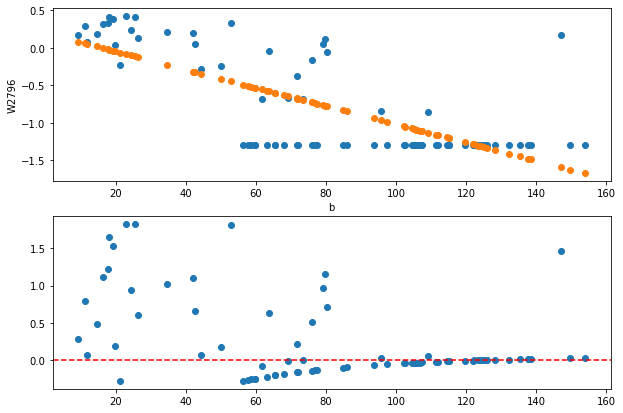

In [285]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('b')
plt.ylabel('W2796')
plt.scatter(xx[0], yy)
p0, k_b  = np.median(sampler.results['samples'][:1000], axis = 0)
yy_model = model_b(xx, p0=p0, k_b=k_b)
plt.scatter(xx[0], yy_model)
#plt.xscale("log")
#plt.yscale("log")
plt.subplot(212)
plt.scatter(xx[0], 10**yy - 10**yy_model)
plt.axhline(0, linestyle = "--", c = "r")

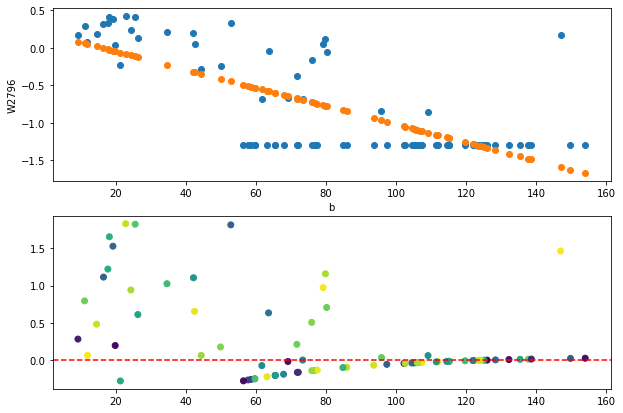

In [287]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('b')
plt.ylabel('W2796')
plt.scatter(xx[0], yy)
p0, k_b  = np.median(sampler.results['samples'][:1000], axis = 0)
yy_model = model_b(xx, p0=p0, k_b=k_b)
plt.scatter(xx[0], yy_model)
#plt.xscale("log")
#plt.yscale("log")
plt.subplot(212)
plt.scatter(xx[0], 10**yy - 10**yy_model, c = isol_visu_rot["inclination"])
plt.axhline(0, linestyle = "--", c = "r")

### Closest

In [525]:
sample = closest_9_snr3_good_runs_rot[closest_9_snr3_good_runs_rot["B_KPC"]<150]
xx = np.array(sample[["B_KPC"]])
xx = xx.T
yy = np.array(np.log10(sample["REW_2796"]+0.05))

In [222]:
parameters = ['p0', 'k_b']
sampler = ReactiveNestedSampler(parameters, log_likelihood_b, prior_transform_b)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]


DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-6502729.56, Lmax=-197.60


DEBUG:ultranest:iteration=80, ncalls=887, regioncalls=3480, ndraw=40, logz=-4936689.10, remainder_fraction=100.0000%, Lmin=-4925903.44, Lmax=-197.60


DEBUG:ultranest:iteration=160, ncalls=985, regioncalls=7400, ndraw=40, logz=-4092193.07, remainder_fraction=100.0000%, Lmin=-4085417.49, Lmax=-197.60


DEBUG:ultranest:iteration=240, ncalls=1087, regioncalls=11480, ndraw=40, logz=-3353275.04, remainder_fraction=100.0000%, Lmin=-3341966.52, Lmax=-197.60


DEBUG:ultranest:iteration=320, ncalls=1186, regioncalls=15440, ndraw=40, logz=-2635579.35, remainder_fraction=100.0000%, Lmin=-2635058.66, Lmax=-197.60


DEBUG:ultranest:iteration=358, ncalls=1232, regioncalls=17280, ndraw=40, logz=-2353872.11, remainder_fraction=100.0000%, Lmin=-2353449.45, Lmax=-197.60


DEBUG:ultranest:iteration=400, ncalls=1277, regioncalls=19080, ndraw=40, logz=-2116976.43, remainder_fraction=100.0000%, Lmin=-2115443.28, Lmax=-197.60


DEBUG:ultranest:iteration=480, ncalls=1371, regioncalls=22840, ndraw=40, logz=-1729071.26, remainder_fraction=100.0000%, Lmin=-1723224.12, Lmax=-197.60


DEBUG:ultranest:iteration=560, ncalls=1467, regioncalls=26680, ndraw=40, logz=-1375996.97, remainder_fraction=100.0000%, Lmin=-1375828.13, Lmax=-197.60


DEBUG:ultranest:iteration=640, ncalls=1554, regioncalls=30160, ndraw=40, logz=-1123079.53, remainder_fraction=100.0000%, Lmin=-1116162.02, Lmax=-197.60


DEBUG:ultranest:iteration=716, ncalls=1657, regioncalls=34280, ndraw=40, logz=-919407.28, remainder_fraction=100.0000%, Lmin=-917085.25, Lmax=-142.62


DEBUG:ultranest:iteration=720, ncalls=1661, regioncalls=34440, ndraw=40, logz=-912177.49, remainder_fraction=100.0000%, Lmin=-910487.33, Lmax=-142.62


DEBUG:ultranest:iteration=800, ncalls=1756, regioncalls=38240, ndraw=40, logz=-760454.50, remainder_fraction=100.0000%, Lmin=-756944.00, Lmax=-142.62


DEBUG:ultranest:iteration=880, ncalls=1844, regioncalls=41760, ndraw=40, logz=-631401.32, remainder_fraction=100.0000%, Lmin=-631021.16, Lmax=-142.62


DEBUG:ultranest:iteration=960, ncalls=1937, regioncalls=45480, ndraw=40, logz=-528406.93, remainder_fraction=100.0000%, Lmin=-527301.76, Lmax=-142.62


DEBUG:ultranest:iteration=1040, ncalls=2032, regioncalls=49280, ndraw=40, logz=-425260.54, remainder_fraction=100.0000%, Lmin=-425177.32, Lmax=-142.62


DEBUG:ultranest:iteration=1074, ncalls=2073, regioncalls=50920, ndraw=40, logz=-386776.33, remainder_fraction=100.0000%, Lmin=-386164.59, Lmax=-138.49


DEBUG:ultranest:iteration=1120, ncalls=2128, regioncalls=53120, ndraw=40, logz=-346153.33, remainder_fraction=100.0000%, Lmin=-346126.39, Lmax=-138.49


DEBUG:ultranest:iteration=1200, ncalls=2224, regioncalls=56960, ndraw=40, logz=-287807.54, remainder_fraction=100.0000%, Lmin=-286076.78, Lmax=-138.49


DEBUG:ultranest:iteration=1253, ncalls=2284, regioncalls=59360, ndraw=40, logz=-258070.67, remainder_fraction=100.0000%, Lmin=-257931.58, Lmax=-138.49


DEBUG:ultranest:iteration=1280, ncalls=2317, regioncalls=60680, ndraw=40, logz=-237285.47, remainder_fraction=100.0000%, Lmin=-235964.00, Lmax=-138.49


DEBUG:ultranest:iteration=1360, ncalls=2411, regioncalls=64440, ndraw=40, logz=-193252.17, remainder_fraction=100.0000%, Lmin=-192891.67, Lmax=-138.49


DEBUG:ultranest:iteration=1432, ncalls=2494, regioncalls=67760, ndraw=40, logz=-163435.93, remainder_fraction=100.0000%, Lmin=-162889.22, Lmax=-52.20


DEBUG:ultranest:iteration=1440, ncalls=2502, regioncalls=68080, ndraw=40, logz=-161497.29, remainder_fraction=100.0000%, Lmin=-160288.58, Lmax=-52.20


DEBUG:ultranest:iteration=1520, ncalls=2593, regioncalls=71720, ndraw=40, logz=-131850.00, remainder_fraction=100.0000%, Lmin=-131084.24, Lmax=-52.20


DEBUG:ultranest:iteration=1600, ncalls=2685, regioncalls=75400, ndraw=40, logz=-104462.77, remainder_fraction=100.0000%, Lmin=-102511.45, Lmax=-9.44


DEBUG:ultranest:iteration=1611, ncalls=2697, regioncalls=75880, ndraw=40, logz=-99779.12, remainder_fraction=100.0000%, Lmin=-99568.47, Lmax=-9.44


DEBUG:ultranest:iteration=1680, ncalls=2774, regioncalls=78960, ndraw=40, logz=-81860.30, remainder_fraction=100.0000%, Lmin=-81669.50, Lmax=-9.44


DEBUG:ultranest:iteration=1760, ncalls=2863, regioncalls=82520, ndraw=40, logz=-67931.65, remainder_fraction=100.0000%, Lmin=-67879.08, Lmax=-9.44


DEBUG:ultranest:iteration=1790, ncalls=2898, regioncalls=83960, ndraw=40, logz=-61950.91, remainder_fraction=100.0000%, Lmin=-61808.52, Lmax=-9.44


DEBUG:ultranest:iteration=1840, ncalls=2962, regioncalls=86560, ndraw=40, logz=-54222.06, remainder_fraction=100.0000%, Lmin=-53997.70, Lmax=-9.44


DEBUG:ultranest:iteration=1920, ncalls=3054, regioncalls=90240, ndraw=40, logz=-45673.06, remainder_fraction=100.0000%, Lmin=-45514.09, Lmax=-9.44


DEBUG:ultranest:iteration=1969, ncalls=3109, regioncalls=92480, ndraw=40, logz=-39574.77, remainder_fraction=100.0000%, Lmin=-39519.19, Lmax=-9.44


DEBUG:ultranest:iteration=2000, ncalls=3143, regioncalls=93880, ndraw=40, logz=-37091.30, remainder_fraction=100.0000%, Lmin=-36971.75, Lmax=-9.44


DEBUG:ultranest:iteration=2080, ncalls=3231, regioncalls=97400, ndraw=40, logz=-30200.51, remainder_fraction=100.0000%, Lmin=-30148.62, Lmax=-9.44


DEBUG:ultranest:iteration=2148, ncalls=3304, regioncalls=100320, ndraw=40, logz=-26412.48, remainder_fraction=100.0000%, Lmin=-26366.79, Lmax=-9.44


DEBUG:ultranest:iteration=2160, ncalls=3319, regioncalls=101040, ndraw=40, logz=-25125.24, remainder_fraction=100.0000%, Lmin=-24976.04, Lmax=-9.44


DEBUG:ultranest:iteration=2240, ncalls=3404, regioncalls=104440, ndraw=40, logz=-20931.30, remainder_fraction=100.0000%, Lmin=-20792.71, Lmax=-9.44


DEBUG:ultranest:iteration=2320, ncalls=3498, regioncalls=108200, ndraw=40, logz=-17858.67, remainder_fraction=100.0000%, Lmin=-17824.59, Lmax=-9.44


DEBUG:ultranest:iteration=2327, ncalls=3508, regioncalls=108600, ndraw=40, logz=-17501.26, remainder_fraction=100.0000%, Lmin=-17476.11, Lmax=-9.44


DEBUG:ultranest:iteration=2400, ncalls=3589, regioncalls=111920, ndraw=40, logz=-14739.03, remainder_fraction=100.0000%, Lmin=-14708.83, Lmax=-9.44


DEBUG:ultranest:iteration=2480, ncalls=3679, regioncalls=115520, ndraw=40, logz=-12214.02, remainder_fraction=100.0000%, Lmin=-12176.90, Lmax=-9.44


DEBUG:ultranest:iteration=2506, ncalls=3709, regioncalls=116720, ndraw=40, logz=-11613.84, remainder_fraction=100.0000%, Lmin=-11598.93, Lmax=-9.44


DEBUG:ultranest:iteration=2560, ncalls=3775, regioncalls=119400, ndraw=40, logz=-10552.01, remainder_fraction=100.0000%, Lmin=-10529.53, Lmax=-9.44


DEBUG:ultranest:iteration=2640, ncalls=3869, regioncalls=123160, ndraw=40, logz=-8753.61, remainder_fraction=100.0000%, Lmin=-8739.95, Lmax=-9.44


DEBUG:ultranest:iteration=2685, ncalls=3918, regioncalls=125120, ndraw=40, logz=-7947.10, remainder_fraction=100.0000%, Lmin=-7919.12, Lmax=-9.44


DEBUG:ultranest:iteration=2720, ncalls=3956, regioncalls=126680, ndraw=40, logz=-7332.28, remainder_fraction=100.0000%, Lmin=-7309.67, Lmax=-9.44


DEBUG:ultranest:iteration=2800, ncalls=4044, regioncalls=130200, ndraw=40, logz=-6150.64, remainder_fraction=100.0000%, Lmin=-6115.56, Lmax=-9.44


DEBUG:ultranest:iteration=2864, ncalls=4121, regioncalls=133280, ndraw=40, logz=-5368.33, remainder_fraction=100.0000%, Lmin=-5352.97, Lmax=-9.44


DEBUG:ultranest:iteration=2880, ncalls=4139, regioncalls=134040, ndraw=40, logz=-5200.42, remainder_fraction=100.0000%, Lmin=-5177.90, Lmax=-9.44


DEBUG:ultranest:iteration=2960, ncalls=4229, regioncalls=137640, ndraw=40, logz=-4256.87, remainder_fraction=100.0000%, Lmin=-4243.04, Lmax=-9.44


DEBUG:ultranest:iteration=3040, ncalls=4319, regioncalls=141240, ndraw=40, logz=-3710.26, remainder_fraction=100.0000%, Lmin=-3698.82, Lmax=-9.44


DEBUG:ultranest:iteration=3043, ncalls=4322, regioncalls=141360, ndraw=40, logz=-3669.96, remainder_fraction=100.0000%, Lmin=-3655.55, Lmax=-9.44


DEBUG:ultranest:iteration=3120, ncalls=4411, regioncalls=145080, ndraw=40, logz=-3233.07, remainder_fraction=100.0000%, Lmin=-3214.70, Lmax=-6.77


DEBUG:ultranest:iteration=3200, ncalls=4502, regioncalls=148720, ndraw=40, logz=-2857.52, remainder_fraction=100.0000%, Lmin=-2843.34, Lmax=-6.77


DEBUG:ultranest:iteration=3222, ncalls=4533, regioncalls=149960, ndraw=40, logz=-2734.40, remainder_fraction=100.0000%, Lmin=-2720.96, Lmax=-6.77


DEBUG:ultranest:iteration=3280, ncalls=4602, regioncalls=152760, ndraw=40, logz=-2494.60, remainder_fraction=100.0000%, Lmin=-2477.34, Lmax=-6.77


DEBUG:ultranest:iteration=3360, ncalls=4705, regioncalls=156880, ndraw=40, logz=-2260.25, remainder_fraction=100.0000%, Lmin=-2242.49, Lmax=-6.77


DEBUG:ultranest:iteration=3401, ncalls=4754, regioncalls=158880, ndraw=40, logz=-2164.77, remainder_fraction=100.0000%, Lmin=-2153.57, Lmax=-6.77


DEBUG:ultranest:iteration=3440, ncalls=4798, regioncalls=160720, ndraw=40, logz=-2087.40, remainder_fraction=100.0000%, Lmin=-2074.95, Lmax=-6.77


DEBUG:ultranest:iteration=3520, ncalls=4891, regioncalls=164440, ndraw=40, logz=-1903.13, remainder_fraction=100.0000%, Lmin=-1890.17, Lmax=-6.77


DEBUG:ultranest:iteration=3580, ncalls=4970, regioncalls=167640, ndraw=40, logz=-1774.89, remainder_fraction=100.0000%, Lmin=-1763.62, Lmax=-6.31


DEBUG:ultranest:iteration=3600, ncalls=4995, regioncalls=168720, ndraw=40, logz=-1730.34, remainder_fraction=100.0000%, Lmin=-1717.25, Lmax=-6.31


DEBUG:ultranest:iteration=3680, ncalls=5095, regioncalls=172720, ndraw=40, logz=-1550.23, remainder_fraction=100.0000%, Lmin=-1538.07, Lmax=-6.31


DEBUG:ultranest:iteration=3759, ncalls=5198, regioncalls=176880, ndraw=40, logz=-1420.10, remainder_fraction=100.0000%, Lmin=-1406.74, Lmax=-6.31


DEBUG:ultranest:iteration=3760, ncalls=5199, regioncalls=176920, ndraw=40, logz=-1417.99, remainder_fraction=100.0000%, Lmin=-1404.74, Lmax=-6.31


DEBUG:ultranest:iteration=3840, ncalls=5291, regioncalls=180640, ndraw=40, logz=-1302.46, remainder_fraction=100.0000%, Lmin=-1290.51, Lmax=-6.31


DEBUG:ultranest:iteration=3920, ncalls=5395, regioncalls=184800, ndraw=40, logz=-1188.72, remainder_fraction=100.0000%, Lmin=-1176.49, Lmax=-6.31


DEBUG:ultranest:iteration=3938, ncalls=5418, regioncalls=185720, ndraw=40, logz=-1160.06, remainder_fraction=100.0000%, Lmin=-1148.59, Lmax=-6.31


DEBUG:ultranest:iteration=4000, ncalls=5487, regioncalls=188520, ndraw=40, logz=-1069.84, remainder_fraction=100.0000%, Lmin=-1054.26, Lmax=-6.31


DEBUG:ultranest:iteration=4080, ncalls=5591, regioncalls=192680, ndraw=40, logz=-974.36, remainder_fraction=100.0000%, Lmin=-963.14, Lmax=-6.31


DEBUG:ultranest:iteration=4117, ncalls=5642, regioncalls=194760, ndraw=40, logz=-931.88, remainder_fraction=100.0000%, Lmin=-921.10, Lmax=-6.31


DEBUG:ultranest:iteration=4160, ncalls=5692, regioncalls=196760, ndraw=40, logz=-888.93, remainder_fraction=100.0000%, Lmin=-877.07, Lmax=-6.31


DEBUG:ultranest:iteration=4240, ncalls=5794, regioncalls=200840, ndraw=40, logz=-814.22, remainder_fraction=100.0000%, Lmin=-800.04, Lmax=-6.31


DEBUG:ultranest:iteration=4296, ncalls=5866, regioncalls=203760, ndraw=40, logz=-772.31, remainder_fraction=100.0000%, Lmin=-760.29, Lmax=-6.31


DEBUG:ultranest:iteration=4320, ncalls=5892, regioncalls=204800, ndraw=40, logz=-747.10, remainder_fraction=100.0000%, Lmin=-735.07, Lmax=-6.31


DEBUG:ultranest:iteration=4400, ncalls=5983, regioncalls=208440, ndraw=40, logz=-677.51, remainder_fraction=100.0000%, Lmin=-666.62, Lmax=-6.31


DEBUG:ultranest:iteration=4475, ncalls=6084, regioncalls=212520, ndraw=40, logz=-617.50, remainder_fraction=100.0000%, Lmin=-605.74, Lmax=-6.31


DEBUG:ultranest:iteration=4480, ncalls=6090, regioncalls=212760, ndraw=40, logz=-613.35, remainder_fraction=100.0000%, Lmin=-602.09, Lmax=-6.31


DEBUG:ultranest:iteration=4560, ncalls=6182, regioncalls=216440, ndraw=40, logz=-563.18, remainder_fraction=100.0000%, Lmin=-549.82, Lmax=-6.31


DEBUG:ultranest:iteration=4640, ncalls=6280, regioncalls=220360, ndraw=40, logz=-503.29, remainder_fraction=100.0000%, Lmin=-490.87, Lmax=-6.31


DEBUG:ultranest:iteration=4654, ncalls=6299, regioncalls=221120, ndraw=40, logz=-496.97, remainder_fraction=100.0000%, Lmin=-485.53, Lmax=-6.31


DEBUG:ultranest:iteration=4720, ncalls=6377, regioncalls=224280, ndraw=40, logz=-462.34, remainder_fraction=100.0000%, Lmin=-450.10, Lmax=-6.31


DEBUG:ultranest:iteration=4800, ncalls=6482, regioncalls=228480, ndraw=40, logz=-415.40, remainder_fraction=100.0000%, Lmin=-401.26, Lmax=-6.31


DEBUG:ultranest:iteration=4833, ncalls=6524, regioncalls=230160, ndraw=40, logz=-393.75, remainder_fraction=100.0000%, Lmin=-380.96, Lmax=-6.31


DEBUG:ultranest:iteration=4880, ncalls=6577, regioncalls=232400, ndraw=40, logz=-367.64, remainder_fraction=100.0000%, Lmin=-355.85, Lmax=-6.31


DEBUG:ultranest:iteration=4960, ncalls=6668, regioncalls=236040, ndraw=40, logz=-334.27, remainder_fraction=100.0000%, Lmin=-321.83, Lmax=-6.31


DEBUG:ultranest:iteration=5012, ncalls=6732, regioncalls=238640, ndraw=40, logz=-317.20, remainder_fraction=100.0000%, Lmin=-305.73, Lmax=-6.31


DEBUG:ultranest:iteration=5040, ncalls=6766, regioncalls=240000, ndraw=40, logz=-308.91, remainder_fraction=100.0000%, Lmin=-297.38, Lmax=-6.20


DEBUG:ultranest:iteration=5120, ncalls=6867, regioncalls=244040, ndraw=40, logz=-282.56, remainder_fraction=100.0000%, Lmin=-270.36, Lmax=-6.20


DEBUG:ultranest:iteration=5191, ncalls=6959, regioncalls=247760, ndraw=40, logz=-264.37, remainder_fraction=100.0000%, Lmin=-252.61, Lmax=-6.20


DEBUG:ultranest:iteration=5200, ncalls=6968, regioncalls=248120, ndraw=40, logz=-262.21, remainder_fraction=100.0000%, Lmin=-248.19, Lmax=-6.20


DEBUG:ultranest:iteration=5280, ncalls=7067, regioncalls=252080, ndraw=40, logz=-239.83, remainder_fraction=100.0000%, Lmin=-227.39, Lmax=-6.20


DEBUG:ultranest:iteration=5360, ncalls=7168, regioncalls=256120, ndraw=40, logz=-219.64, remainder_fraction=100.0000%, Lmin=-208.00, Lmax=-6.20


DEBUG:ultranest:iteration=5370, ncalls=7182, regioncalls=256800, ndraw=40, logz=-217.84, remainder_fraction=100.0000%, Lmin=-206.08, Lmax=-6.20


DEBUG:ultranest:iteration=5440, ncalls=7260, regioncalls=259920, ndraw=40, logz=-197.57, remainder_fraction=100.0000%, Lmin=-185.17, Lmax=-6.20


DEBUG:ultranest:iteration=5520, ncalls=7356, regioncalls=263760, ndraw=40, logz=-181.36, remainder_fraction=100.0000%, Lmin=-169.30, Lmax=-6.20


DEBUG:ultranest:iteration=5549, ncalls=7389, regioncalls=265120, ndraw=40, logz=-176.98, remainder_fraction=100.0000%, Lmin=-165.13, Lmax=-6.20


DEBUG:ultranest:iteration=5600, ncalls=7444, regioncalls=267320, ndraw=40, logz=-167.98, remainder_fraction=100.0000%, Lmin=-155.77, Lmax=-6.20


DEBUG:ultranest:iteration=5680, ncalls=7547, regioncalls=271440, ndraw=40, logz=-154.10, remainder_fraction=100.0000%, Lmin=-141.50, Lmax=-6.20


DEBUG:ultranest:iteration=5728, ncalls=7614, regioncalls=274160, ndraw=40, logz=-142.54, remainder_fraction=100.0000%, Lmin=-130.21, Lmax=-6.20


DEBUG:ultranest:iteration=5760, ncalls=7653, regioncalls=275800, ndraw=40, logz=-137.13, remainder_fraction=100.0000%, Lmin=-124.80, Lmax=-6.20


DEBUG:ultranest:iteration=5840, ncalls=7748, regioncalls=279600, ndraw=40, logz=-125.82, remainder_fraction=100.0000%, Lmin=-113.46, Lmax=-6.20


DEBUG:ultranest:iteration=5920, ncalls=7852, regioncalls=283760, ndraw=40, logz=-114.65, remainder_fraction=100.0000%, Lmin=-102.75, Lmax=-6.20


DEBUG:ultranest:iteration=6000, ncalls=7954, regioncalls=287840, ndraw=40, logz=-107.39, remainder_fraction=100.0000%, Lmin=-95.50, Lmax=-6.20


DEBUG:ultranest:iteration=6080, ncalls=8063, regioncalls=292200, ndraw=40, logz=-97.90, remainder_fraction=100.0000%, Lmin=-85.97, Lmax=-6.20


DEBUG:ultranest:iteration=6086, ncalls=8075, regioncalls=292720, ndraw=40, logz=-97.39, remainder_fraction=100.0000%, Lmin=-85.59, Lmax=-6.20


DEBUG:ultranest:iteration=6160, ncalls=8159, regioncalls=296080, ndraw=40, logz=-91.48, remainder_fraction=100.0000%, Lmin=-79.60, Lmax=-6.20


DEBUG:ultranest:iteration=6240, ncalls=8258, regioncalls=300040, ndraw=40, logz=-84.44, remainder_fraction=100.0000%, Lmin=-72.64, Lmax=-6.20


DEBUG:ultranest:iteration=6265, ncalls=8289, regioncalls=301400, ndraw=40, logz=-82.86, remainder_fraction=100.0000%, Lmin=-71.15, Lmax=-6.20


DEBUG:ultranest:iteration=6320, ncalls=8348, regioncalls=303960, ndraw=40, logz=-79.33, remainder_fraction=100.0000%, Lmin=-67.13, Lmax=-6.20


DEBUG:ultranest:iteration=6400, ncalls=8446, regioncalls=307880, ndraw=40, logz=-73.19, remainder_fraction=100.0000%, Lmin=-61.46, Lmax=-6.10


DEBUG:ultranest:iteration=6444, ncalls=8498, regioncalls=310000, ndraw=40, logz=-70.17, remainder_fraction=100.0000%, Lmin=-57.64, Lmax=-6.10


DEBUG:ultranest:iteration=6480, ncalls=8539, regioncalls=311640, ndraw=40, logz=-67.26, remainder_fraction=100.0000%, Lmin=-55.38, Lmax=-6.10


DEBUG:ultranest:iteration=6560, ncalls=8645, regioncalls=315880, ndraw=40, logz=-62.47, remainder_fraction=100.0000%, Lmin=-50.32, Lmax=-6.10


DEBUG:ultranest:iteration=6640, ncalls=8743, regioncalls=319800, ndraw=40, logz=-58.18, remainder_fraction=100.0000%, Lmin=-45.93, Lmax=-6.10


DEBUG:ultranest:iteration=6720, ncalls=8847, regioncalls=323960, ndraw=40, logz=-54.13, remainder_fraction=100.0000%, Lmin=-41.89, Lmax=-6.10


DEBUG:ultranest:iteration=6800, ncalls=8947, regioncalls=327960, ndraw=40, logz=-50.71, remainder_fraction=100.0000%, Lmin=-38.70, Lmax=-6.10


DEBUG:ultranest:iteration=6802, ncalls=8950, regioncalls=328120, ndraw=40, logz=-50.63, remainder_fraction=100.0000%, Lmin=-38.62, Lmax=-6.10


DEBUG:ultranest:iteration=6880, ncalls=9047, regioncalls=332000, ndraw=40, logz=-47.52, remainder_fraction=100.0000%, Lmin=-35.46, Lmax=-6.10


DEBUG:ultranest:iteration=6960, ncalls=9143, regioncalls=335840, ndraw=40, logz=-44.96, remainder_fraction=100.0000%, Lmin=-33.19, Lmax=-6.10


DEBUG:ultranest:iteration=7040, ncalls=9238, regioncalls=339640, ndraw=40, logz=-42.46, remainder_fraction=100.0000%, Lmin=-30.49, Lmax=-6.10


DEBUG:ultranest:iteration=7120, ncalls=9351, regioncalls=344160, ndraw=40, logz=-40.09, remainder_fraction=100.0000%, Lmin=-28.02, Lmax=-6.10


DEBUG:ultranest:iteration=7200, ncalls=9454, regioncalls=348280, ndraw=40, logz=-37.93, remainder_fraction=100.0000%, Lmin=-25.62, Lmax=-6.10


DEBUG:ultranest:iteration=7280, ncalls=9561, regioncalls=352560, ndraw=40, logz=-35.76, remainder_fraction=100.0000%, Lmin=-23.67, Lmax=-6.10


DEBUG:ultranest:iteration=7339, ncalls=9640, regioncalls=355800, ndraw=40, logz=-34.32, remainder_fraction=100.0000%, Lmin=-22.20, Lmax=-6.10


DEBUG:ultranest:iteration=7360, ncalls=9664, regioncalls=356760, ndraw=40, logz=-33.82, remainder_fraction=100.0000%, Lmin=-21.62, Lmax=-6.10


DEBUG:ultranest:iteration=7440, ncalls=9756, regioncalls=360440, ndraw=40, logz=-32.22, remainder_fraction=99.9999%, Lmin=-20.26, Lmax=-6.10


DEBUG:ultranest:iteration=7518, ncalls=9854, regioncalls=364400, ndraw=40, logz=-30.91, remainder_fraction=99.9997%, Lmin=-18.92, Lmax=-6.10


DEBUG:ultranest:iteration=7520, ncalls=9857, regioncalls=364520, ndraw=40, logz=-30.87, remainder_fraction=99.9997%, Lmin=-18.88, Lmax=-6.10


DEBUG:ultranest:iteration=7600, ncalls=9954, regioncalls=368400, ndraw=40, logz=-29.68, remainder_fraction=99.9992%, Lmin=-17.65, Lmax=-6.10


DEBUG:ultranest:iteration=7680, ncalls=10056, regioncalls=372480, ndraw=40, logz=-28.46, remainder_fraction=99.9972%, Lmin=-16.36, Lmax=-6.09


DEBUG:ultranest:iteration=7697, ncalls=10083, regioncalls=373600, ndraw=40, logz=-28.20, remainder_fraction=99.9963%, Lmin=-16.09, Lmax=-6.09


DEBUG:ultranest:iteration=7760, ncalls=10152, regioncalls=376400, ndraw=40, logz=-27.32, remainder_fraction=99.9911%, Lmin=-15.22, Lmax=-6.09


DEBUG:ultranest:iteration=7840, ncalls=10251, regioncalls=380360, ndraw=40, logz=-26.34, remainder_fraction=99.9769%, Lmin=-14.37, Lmax=-6.09


DEBUG:ultranest:iteration=7876, ncalls=10298, regioncalls=382280, ndraw=40, logz=-25.95, remainder_fraction=99.9661%, Lmin=-13.97, Lmax=-6.09


DEBUG:ultranest:iteration=7920, ncalls=10360, regioncalls=384760, ndraw=40, logz=-25.51, remainder_fraction=99.9466%, Lmin=-13.51, Lmax=-6.09


DEBUG:ultranest:iteration=8000, ncalls=10468, regioncalls=389080, ndraw=40, logz=-24.78, remainder_fraction=99.8898%, Lmin=-12.82, Lmax=-6.09


DEBUG:ultranest:iteration=8080, ncalls=10586, regioncalls=393800, ndraw=40, logz=-24.10, remainder_fraction=99.7802%, Lmin=-12.10, Lmax=-6.07


DEBUG:ultranest:iteration=8160, ncalls=10685, regioncalls=397760, ndraw=40, logz=-23.51, remainder_fraction=99.5955%, Lmin=-11.63, Lmax=-6.07


DEBUG:ultranest:iteration=8234, ncalls=10768, regioncalls=401320, ndraw=40, logz=-23.05, remainder_fraction=99.3663%, Lmin=-11.20, Lmax=-6.07


DEBUG:ultranest:iteration=8240, ncalls=10774, regioncalls=401560, ndraw=40, logz=-23.01, remainder_fraction=99.3459%, Lmin=-11.13, Lmax=-6.07


DEBUG:ultranest:iteration=8320, ncalls=10865, regioncalls=405200, ndraw=40, logz=-22.52, remainder_fraction=98.9104%, Lmin=-10.57, Lmax=-6.07


DEBUG:ultranest:iteration=8400, ncalls=10962, regioncalls=409080, ndraw=40, logz=-22.07, remainder_fraction=98.3107%, Lmin=-10.09, Lmax=-6.07


DEBUG:ultranest:iteration=8480, ncalls=11064, regioncalls=413160, ndraw=40, logz=-21.66, remainder_fraction=97.4930%, Lmin=-9.72, Lmax=-6.07


DEBUG:ultranest:iteration=8560, ncalls=11177, regioncalls=417680, ndraw=40, logz=-21.29, remainder_fraction=96.3680%, Lmin=-9.34, Lmax=-6.07


DEBUG:ultranest:iteration=8626, ncalls=11258, regioncalls=420920, ndraw=40, logz=-21.03, remainder_fraction=95.2987%, Lmin=-9.12, Lmax=-6.07


DEBUG:ultranest:iteration=8640, ncalls=11279, regioncalls=421760, ndraw=40, logz=-20.97, remainder_fraction=95.0225%, Lmin=-9.09, Lmax=-6.07


DEBUG:ultranest:iteration=8720, ncalls=11385, regioncalls=426000, ndraw=40, logz=-20.69, remainder_fraction=93.4517%, Lmin=-8.81, Lmax=-6.07


DEBUG:ultranest:iteration=8771, ncalls=11450, regioncalls=428680, ndraw=40, logz=-20.52, remainder_fraction=92.1655%, Lmin=-8.59, Lmax=-6.07


DEBUG:ultranest:iteration=8800, ncalls=11482, regioncalls=429960, ndraw=40, logz=-20.43, remainder_fraction=91.4761%, Lmin=-8.51, Lmax=-6.07


DEBUG:ultranest:iteration=8880, ncalls=11577, regioncalls=433800, ndraw=40, logz=-20.19, remainder_fraction=89.1463%, Lmin=-8.25, Lmax=-6.07


DEBUG:ultranest:iteration=8950, ncalls=11672, regioncalls=437760, ndraw=40, logz=-20.00, remainder_fraction=86.7837%, Lmin=-8.05, Lmax=-6.07


DEBUG:ultranest:iteration=8960, ncalls=11683, regioncalls=438200, ndraw=40, logz=-19.97, remainder_fraction=86.4367%, Lmin=-8.02, Lmax=-6.07


DEBUG:ultranest:iteration=9040, ncalls=11779, regioncalls=442040, ndraw=40, logz=-19.77, remainder_fraction=83.6486%, Lmin=-7.83, Lmax=-6.07


DEBUG:ultranest:iteration=9120, ncalls=11872, regioncalls=445760, ndraw=40, logz=-19.59, remainder_fraction=80.4658%, Lmin=-7.67, Lmax=-6.07


DEBUG:ultranest:iteration=9129, ncalls=11882, regioncalls=446200, ndraw=40, logz=-19.57, remainder_fraction=80.1557%, Lmin=-7.63, Lmax=-6.07


DEBUG:ultranest:iteration=9200, ncalls=11959, regioncalls=449320, ndraw=40, logz=-19.43, remainder_fraction=77.0698%, Lmin=-7.49, Lmax=-6.07


DEBUG:ultranest:iteration=9280, ncalls=12070, regioncalls=453760, ndraw=40, logz=-19.28, remainder_fraction=73.6093%, Lmin=-7.38, Lmax=-6.07


DEBUG:ultranest:iteration=9308, ncalls=12108, regioncalls=455320, ndraw=40, logz=-19.24, remainder_fraction=72.3213%, Lmin=-7.32, Lmax=-6.07


DEBUG:ultranest:iteration=9360, ncalls=12165, regioncalls=457600, ndraw=40, logz=-19.15, remainder_fraction=69.9120%, Lmin=-7.25, Lmax=-6.07


DEBUG:ultranest:iteration=9440, ncalls=12255, regioncalls=461200, ndraw=40, logz=-19.04, remainder_fraction=66.2897%, Lmin=-7.13, Lmax=-6.07


DEBUG:ultranest:iteration=9487, ncalls=12313, regioncalls=463560, ndraw=40, logz=-18.97, remainder_fraction=64.1060%, Lmin=-7.06, Lmax=-6.07


DEBUG:ultranest:iteration=9520, ncalls=12353, regioncalls=465160, ndraw=40, logz=-18.93, remainder_fraction=62.5757%, Lmin=-7.02, Lmax=-6.07


DEBUG:ultranest:iteration=9600, ncalls=12451, regioncalls=469080, ndraw=40, logz=-18.84, remainder_fraction=58.8882%, Lmin=-6.94, Lmax=-6.07


DEBUG:ultranest:iteration=9678, ncalls=12554, regioncalls=473200, ndraw=40, logz=-18.75, remainder_fraction=55.2965%, Lmin=-6.86, Lmax=-6.07


DEBUG:ultranest:iteration=9680, ncalls=12556, regioncalls=473280, ndraw=40, logz=-18.75, remainder_fraction=55.2071%, Lmin=-6.86, Lmax=-6.07


DEBUG:ultranest:iteration=9760, ncalls=12646, regioncalls=476880, ndraw=40, logz=-18.67, remainder_fraction=51.5953%, Lmin=-6.78, Lmax=-6.07


DEBUG:ultranest:iteration=9840, ncalls=12758, regioncalls=481360, ndraw=40, logz=-18.60, remainder_fraction=48.0170%, Lmin=-6.71, Lmax=-6.07


DEBUG:ultranest:iteration=9845, ncalls=12764, regioncalls=481640, ndraw=40, logz=-18.60, remainder_fraction=47.7810%, Lmin=-6.71, Lmax=-6.07


DEBUG:ultranest:iteration=9920, ncalls=12846, regioncalls=484920, ndraw=40, logz=-18.54, remainder_fraction=44.5854%, Lmin=-6.65, Lmax=-6.07


DEBUG:ultranest:iteration=10000, ncalls=12950, regioncalls=489080, ndraw=40, logz=-18.48, remainder_fraction=41.2604%, Lmin=-6.60, Lmax=-6.07


DEBUG:ultranest:iteration=10024, ncalls=12977, regioncalls=490200, ndraw=40, logz=-18.47, remainder_fraction=40.2830%, Lmin=-6.58, Lmax=-6.07


DEBUG:ultranest:iteration=10080, ncalls=13043, regioncalls=493040, ndraw=40, logz=-18.43, remainder_fraction=38.1989%, Lmin=-6.55, Lmax=-6.07


DEBUG:ultranest:iteration=10160, ncalls=13137, regioncalls=496800, ndraw=40, logz=-18.39, remainder_fraction=35.3329%, Lmin=-6.52, Lmax=-6.07


DEBUG:ultranest:iteration=10203, ncalls=13196, regioncalls=499200, ndraw=40, logz=-18.36, remainder_fraction=33.8480%, Lmin=-6.49, Lmax=-6.07


DEBUG:ultranest:iteration=10240, ncalls=13237, regioncalls=500840, ndraw=40, logz=-18.34, remainder_fraction=32.6124%, Lmin=-6.47, Lmax=-6.07


DEBUG:ultranest:iteration=10320, ncalls=13340, regioncalls=504960, ndraw=40, logz=-18.31, remainder_fraction=30.0112%, Lmin=-6.44, Lmax=-6.07


DEBUG:ultranest:iteration=10382, ncalls=13416, regioncalls=508040, ndraw=40, logz=-18.28, remainder_fraction=28.1213%, Lmin=-6.41, Lmax=-6.07


DEBUG:ultranest:iteration=10400, ncalls=13441, regioncalls=509040, ndraw=40, logz=-18.27, remainder_fraction=27.5985%, Lmin=-6.41, Lmax=-6.07


DEBUG:ultranest:iteration=10480, ncalls=13534, regioncalls=512760, ndraw=40, logz=-18.24, remainder_fraction=25.3730%, Lmin=-6.37, Lmax=-6.07


DEBUG:ultranest:iteration=10560, ncalls=13637, regioncalls=516880, ndraw=40, logz=-18.21, remainder_fraction=23.2847%, Lmin=-6.35, Lmax=-6.07


DEBUG:ultranest:iteration=10561, ncalls=13638, regioncalls=516960, ndraw=40, logz=-18.21, remainder_fraction=23.2583%, Lmin=-6.35, Lmax=-6.07


DEBUG:ultranest:iteration=10640, ncalls=13727, regioncalls=520520, ndraw=40, logz=-18.19, remainder_fraction=21.3332%, Lmin=-6.32, Lmax=-6.07


DEBUG:ultranest:iteration=10720, ncalls=13828, regioncalls=524560, ndraw=40, logz=-18.17, remainder_fraction=19.5363%, Lmin=-6.30, Lmax=-6.07


DEBUG:ultranest:iteration=10798, ncalls=13932, regioncalls=528720, ndraw=40, logz=-18.15, remainder_fraction=17.9156%, Lmin=-6.27, Lmax=-6.07


DEBUG:ultranest:iteration=10800, ncalls=13934, regioncalls=528800, ndraw=40, logz=-18.15, remainder_fraction=17.8761%, Lmin=-6.27, Lmax=-6.07


DEBUG:ultranest:iteration=10880, ncalls=14028, regioncalls=532560, ndraw=40, logz=-18.13, remainder_fraction=16.3217%, Lmin=-6.25, Lmax=-6.07


DEBUG:ultranest:iteration=10919, ncalls=14076, regioncalls=534520, ndraw=40, logz=-18.12, remainder_fraction=15.6114%, Lmin=-6.24, Lmax=-6.07


DEBUG:ultranest:iteration=10960, ncalls=14118, regioncalls=536200, ndraw=40, logz=-18.11, remainder_fraction=14.8967%, Lmin=-6.24, Lmax=-6.07


DEBUG:ultranest:iteration=11040, ncalls=14211, regioncalls=539920, ndraw=40, logz=-18.09, remainder_fraction=13.5818%, Lmin=-6.22, Lmax=-6.07


DEBUG:ultranest:iteration=11098, ncalls=14281, regioncalls=542760, ndraw=40, logz=-18.08, remainder_fraction=12.6988%, Lmin=-6.21, Lmax=-6.07


DEBUG:ultranest:iteration=11120, ncalls=14304, regioncalls=543760, ndraw=40, logz=-18.08, remainder_fraction=12.3784%, Lmin=-6.21, Lmax=-6.07


DEBUG:ultranest:iteration=11200, ncalls=14403, regioncalls=547760, ndraw=40, logz=-18.07, remainder_fraction=11.2774%, Lmin=-6.19, Lmax=-6.07


DEBUG:ultranest:iteration=11277, ncalls=14497, regioncalls=551560, ndraw=40, logz=-18.06, remainder_fraction=10.3031%, Lmin=-6.18, Lmax=-6.07


DEBUG:ultranest:iteration=11280, ncalls=14500, regioncalls=551680, ndraw=40, logz=-18.06, remainder_fraction=10.2672%, Lmin=-6.18, Lmax=-6.07


DEBUG:ultranest:iteration=11360, ncalls=14598, regioncalls=555680, ndraw=40, logz=-18.05, remainder_fraction=9.3373%, Lmin=-6.17, Lmax=-6.07


DEBUG:ultranest:iteration=11440, ncalls=14697, regioncalls=559640, ndraw=40, logz=-18.04, remainder_fraction=8.4912%, Lmin=-6.16, Lmax=-6.07


DEBUG:ultranest:iteration=11516, ncalls=14803, regioncalls=563880, ndraw=40, logz=-18.03, remainder_fraction=7.7526%, Lmin=-6.15, Lmax=-6.07


DEBUG:ultranest:iteration=11520, ncalls=14807, regioncalls=564040, ndraw=40, logz=-18.03, remainder_fraction=7.7151%, Lmin=-6.15, Lmax=-6.07


DEBUG:ultranest:iteration=11600, ncalls=14907, regioncalls=568040, ndraw=40, logz=-18.02, remainder_fraction=7.0085%, Lmin=-6.15, Lmax=-6.07


DEBUG:ultranest:iteration=11635, ncalls=14952, regioncalls=569880, ndraw=40, logz=-18.02, remainder_fraction=6.7197%, Lmin=-6.14, Lmax=-6.07


DEBUG:ultranest:iteration=11680, ncalls=15003, regioncalls=572000, ndraw=40, logz=-18.01, remainder_fraction=6.3664%, Lmin=-6.14, Lmax=-6.07


DEBUG:ultranest:iteration=11760, ncalls=15091, regioncalls=575520, ndraw=40, logz=-18.01, remainder_fraction=5.7798%, Lmin=-6.13, Lmax=-6.07


DEBUG:ultranest:iteration=11838, ncalls=15191, regioncalls=579520, ndraw=40, logz=-18.00, remainder_fraction=5.2578%, Lmin=-6.13, Lmax=-6.07


DEBUG:ultranest:iteration=11840, ncalls=15193, regioncalls=579600, ndraw=40, logz=-18.00, remainder_fraction=5.2450%, Lmin=-6.13, Lmax=-6.07


DEBUG:ultranest:iteration=11920, ncalls=15292, regioncalls=583560, ndraw=40, logz=-18.00, remainder_fraction=4.7591%, Lmin=-6.12, Lmax=-6.07


DEBUG:ultranest:iteration=11998, ncalls=15391, regioncalls=587520, ndraw=40, logz=-17.99, remainder_fraction=4.3272%, Lmin=-6.12, Lmax=-6.07


DEBUG:ultranest:iteration=12000, ncalls=15393, regioncalls=587600, ndraw=40, logz=-17.99, remainder_fraction=4.3168%, Lmin=-6.12, Lmax=-6.07


DEBUG:ultranest:iteration=12080, ncalls=15494, regioncalls=591640, ndraw=40, logz=-17.99, remainder_fraction=3.9147%, Lmin=-6.11, Lmax=-6.07


DEBUG:ultranest:iteration=12160, ncalls=15602, regioncalls=595960, ndraw=40, logz=-17.98, remainder_fraction=3.5496%, Lmin=-6.11, Lmax=-6.07


DEBUG:ultranest:iteration=12172, ncalls=15615, regioncalls=596520, ndraw=40, logz=-17.98, remainder_fraction=3.4979%, Lmin=-6.11, Lmax=-6.07


DEBUG:ultranest:iteration=12240, ncalls=15696, regioncalls=599760, ndraw=40, logz=-17.98, remainder_fraction=3.2180%, Lmin=-6.10, Lmax=-6.07


DEBUG:ultranest:iteration=12320, ncalls=15791, regioncalls=603560, ndraw=40, logz=-17.98, remainder_fraction=2.9171%, Lmin=-6.10, Lmax=-6.07


DEBUG:ultranest:iteration=12351, ncalls=15832, regioncalls=605240, ndraw=40, logz=-17.98, remainder_fraction=2.8080%, Lmin=-6.10, Lmax=-6.07


DEBUG:ultranest:iteration=12400, ncalls=15888, regioncalls=607480, ndraw=40, logz=-17.98, remainder_fraction=2.6436%, Lmin=-6.10, Lmax=-6.07


DEBUG:ultranest:iteration=12480, ncalls=15992, regioncalls=611640, ndraw=40, logz=-17.97, remainder_fraction=2.3953%, Lmin=-6.09, Lmax=-6.07


DEBUG:ultranest:iteration=12530, ncalls=16059, regioncalls=614360, ndraw=40, logz=-17.97, remainder_fraction=2.2521%, Lmin=-6.09, Lmax=-6.07


DEBUG:ultranest:iteration=12560, ncalls=16094, regioncalls=615880, ndraw=40, logz=-17.97, remainder_fraction=2.1704%, Lmin=-6.09, Lmax=-6.07


DEBUG:ultranest:iteration=12640, ncalls=16189, regioncalls=619680, ndraw=40, logz=-17.97, remainder_fraction=1.9661%, Lmin=-6.09, Lmax=-6.07


DEBUG:ultranest:iteration=12709, ncalls=16277, regioncalls=623240, ndraw=40, logz=-17.97, remainder_fraction=1.8051%, Lmin=-6.09, Lmax=-6.07


DEBUG:ultranest:iteration=12720, ncalls=16289, regioncalls=623720, ndraw=40, logz=-17.97, remainder_fraction=1.7807%, Lmin=-6.09, Lmax=-6.07


DEBUG:ultranest:iteration=12800, ncalls=16386, regioncalls=627600, ndraw=40, logz=-17.97, remainder_fraction=1.6127%, Lmin=-6.08, Lmax=-6.07


DEBUG:ultranest:iteration=12880, ncalls=16489, regioncalls=631720, ndraw=40, logz=-17.96, remainder_fraction=1.4605%, Lmin=-6.08, Lmax=-6.07


DEBUG:ultranest:iteration=12888, ncalls=16498, regioncalls=632120, ndraw=40, logz=-17.96, remainder_fraction=1.4460%, Lmin=-6.08, Lmax=-6.07


DEBUG:ultranest:iteration=12960, ncalls=16588, regioncalls=635760, ndraw=40, logz=-17.96, remainder_fraction=1.3226%, Lmin=-6.08, Lmax=-6.07


DEBUG:ultranest:iteration=13040, ncalls=16690, regioncalls=639840, ndraw=40, logz=-17.96, remainder_fraction=1.1976%, Lmin=-6.08, Lmax=-6.07


DEBUG:ultranest:iteration=13067, ncalls=16725, regioncalls=641280, ndraw=40, logz=-17.96, remainder_fraction=1.1581%, Lmin=-6.08, Lmax=-6.07


DEBUG:ultranest:iteration=13120, ncalls=16793, regioncalls=644080, ndraw=40, logz=-17.96, remainder_fraction=1.0843%, Lmin=-6.08, Lmax=-6.07


[ultranest] Explored until L=-6  


INFO:ultranest:Explored until L=-6  


[ultranest] Likelihood function evaluations: 16877


INFO:ultranest:Likelihood function evaluations: 16877
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -17.96 +- 0.1005


INFO:ultranest:  logZ = -17.96 +- 0.1005


[ultranest] Effective samples strategy satisfied (ESS = 3151.1, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 3151.1, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)


[ultranest]   logZ error budget: single: 0.12 bs:0.10 tail:0.01 total:0.10 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.12 bs:0.10 tail:0.01 total:0.10 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


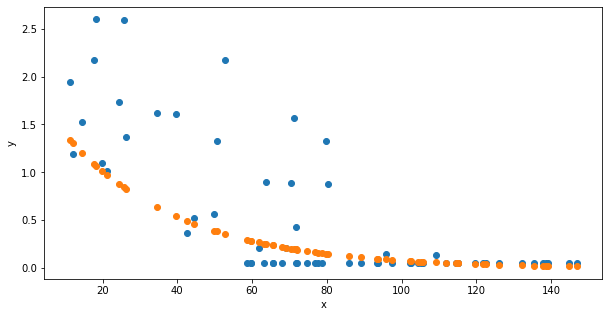

In [223]:
plt.figure(figsize = (10,5))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xx[0], 10**yy)

# go through the solutions
p0, k_b  = np.median(sampler.results['samples'][:1000], axis = 0)
plt.scatter(xx[0], 10**model_b(xx, p0=p0, k_b=k_b))
#plt.xscale("log")
#plt.yscale("log")

## log(W) = f(b_kpc, logM*)

### Isolated

In [230]:
xx = np.array(isol_snr3_good_runs_rot[["B_KPC", "sed_logMass"]])
xx = xx.T
yy = np.array(np.log10(isol_snr3_good_runs_rot["REW_2796"]+0.05))

In [231]:
def model_bM(X, p0, k_b, k_M):
    W = p0 + X[0]*k_b + X[1]*k_M
    return W


def log_likelihood_bM(params):
    # unpack the current parameters:
    p0, k_b, k_M = params

    # compute for each x point, where it should lie in y
    y_model = model_bM(xx, p0=p0, k_b = k_b, k_M = k_M)
    # compute likelihood
    loglike = -0.5 * (((y_model - yy))**2).sum()

    return loglike

def prior_transform_bM(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -20 to +20
    params[0] = cube[0] * 40 - 20
    # b:
    params[1] = cube[1] * 10 - 5
    params[2] = cube[2] * 10 - 5

    return params

In [232]:
parameters = ['p0', 'k_b', 'k_M']
sampler = ReactiveNestedSampler(parameters, log_likelihood_bM, prior_transform_bM)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=3+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]


DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-6702979.48, Lmax=-121.02


DEBUG:ultranest:iteration=80, ncalls=882, regioncalls=3280, ndraw=40, logz=-4532237.60, remainder_fraction=100.0000%, Lmin=-4522047.34, Lmax=-121.02


DEBUG:ultranest:iteration=160, ncalls=983, regioncalls=7320, ndraw=40, logz=-3687681.92, remainder_fraction=100.0000%, Lmin=-3683081.55, Lmax=-121.02


DEBUG:ultranest:iteration=179, ncalls=1003, regioncalls=8120, ndraw=40, logz=-3489210.93, remainder_fraction=100.0000%, Lmin=-3486082.34, Lmax=-121.02


DEBUG:ultranest:iteration=240, ncalls=1086, regioncalls=11440, ndraw=40, logz=-3023135.42, remainder_fraction=100.0000%, Lmin=-3015792.80, Lmax=-121.02


DEBUG:ultranest:iteration=320, ncalls=1198, regioncalls=15920, ndraw=40, logz=-2431180.05, remainder_fraction=100.0000%, Lmin=-2422453.72, Lmax=-121.02


DEBUG:ultranest:iteration=358, ncalls=1254, regioncalls=18160, ndraw=40, logz=-2159335.72, remainder_fraction=100.0000%, Lmin=-2153945.90, Lmax=-121.02


DEBUG:ultranest:iteration=400, ncalls=1308, regioncalls=20320, ndraw=40, logz=-1906990.74, remainder_fraction=100.0000%, Lmin=-1904389.27, Lmax=-121.02


DEBUG:ultranest:iteration=480, ncalls=1420, regioncalls=24800, ndraw=40, logz=-1553812.74, remainder_fraction=100.0000%, Lmin=-1550479.99, Lmax=-121.02


DEBUG:ultranest:iteration=558, ncalls=1526, regioncalls=29040, ndraw=40, logz=-1285287.01, remainder_fraction=100.0000%, Lmin=-1285223.86, Lmax=-121.02


DEBUG:ultranest:iteration=560, ncalls=1530, regioncalls=29200, ndraw=40, logz=-1280924.43, remainder_fraction=100.0000%, Lmin=-1275080.57, Lmax=-121.02


DEBUG:ultranest:iteration=640, ncalls=1654, regioncalls=34160, ndraw=40, logz=-1002021.03, remainder_fraction=100.0000%, Lmin=-1001207.38, Lmax=-121.02


DEBUG:ultranest:iteration=716, ncalls=1761, regioncalls=38440, ndraw=40, logz=-838733.29, remainder_fraction=100.0000%, Lmin=-838330.44, Lmax=-121.02


DEBUG:ultranest:iteration=720, ncalls=1766, regioncalls=38640, ndraw=40, logz=-823323.10, remainder_fraction=100.0000%, Lmin=-816653.78, Lmax=-121.02


DEBUG:ultranest:iteration=800, ncalls=1879, regioncalls=43160, ndraw=40, logz=-684469.44, remainder_fraction=100.0000%, Lmin=-683302.33, Lmax=-121.02


DEBUG:ultranest:iteration=880, ncalls=2000, regioncalls=48000, ndraw=40, logz=-564176.60, remainder_fraction=100.0000%, Lmin=-563954.09, Lmax=-121.02


DEBUG:ultranest:iteration=895, ncalls=2020, regioncalls=48800, ndraw=40, logz=-544628.02, remainder_fraction=100.0000%, Lmin=-543361.23, Lmax=-121.02


DEBUG:ultranest:iteration=960, ncalls=2106, regioncalls=52240, ndraw=40, logz=-478448.54, remainder_fraction=100.0000%, Lmin=-477917.91, Lmax=-121.02


DEBUG:ultranest:iteration=1040, ncalls=2210, regioncalls=56400, ndraw=40, logz=-392521.78, remainder_fraction=100.0000%, Lmin=-391556.97, Lmax=-121.02


DEBUG:ultranest:iteration=1074, ncalls=2264, regioncalls=58560, ndraw=40, logz=-364166.40, remainder_fraction=100.0000%, Lmin=-363593.30, Lmax=-121.02


DEBUG:ultranest:iteration=1120, ncalls=2320, regioncalls=60800, ndraw=40, logz=-331070.15, remainder_fraction=100.0000%, Lmin=-330940.13, Lmax=-121.02


DEBUG:ultranest:iteration=1200, ncalls=2429, regioncalls=65160, ndraw=40, logz=-278825.22, remainder_fraction=100.0000%, Lmin=-277641.37, Lmax=-121.02


DEBUG:ultranest:iteration=1274, ncalls=2526, regioncalls=69040, ndraw=40, logz=-225753.03, remainder_fraction=100.0000%, Lmin=-225742.60, Lmax=-121.02


DEBUG:ultranest:iteration=1280, ncalls=2535, regioncalls=69400, ndraw=40, logz=-224364.50, remainder_fraction=100.0000%, Lmin=-223988.62, Lmax=-121.02


DEBUG:ultranest:iteration=1360, ncalls=2648, regioncalls=73920, ndraw=40, logz=-189807.35, remainder_fraction=100.0000%, Lmin=-189749.53, Lmax=-121.02


DEBUG:ultranest:iteration=1432, ncalls=2750, regioncalls=78000, ndraw=40, logz=-161950.87, remainder_fraction=100.0000%, Lmin=-161901.36, Lmax=-121.02


DEBUG:ultranest:iteration=1440, ncalls=2761, regioncalls=78440, ndraw=40, logz=-160849.94, remainder_fraction=100.0000%, Lmin=-160702.33, Lmax=-121.02


DEBUG:ultranest:iteration=1520, ncalls=2870, regioncalls=82800, ndraw=40, logz=-133629.48, remainder_fraction=100.0000%, Lmin=-133439.98, Lmax=-121.02


DEBUG:ultranest:iteration=1600, ncalls=2971, regioncalls=86840, ndraw=40, logz=-112367.03, remainder_fraction=100.0000%, Lmin=-112172.21, Lmax=-65.94


DEBUG:ultranest:iteration=1611, ncalls=2993, regioncalls=87720, ndraw=40, logz=-109007.09, remainder_fraction=100.0000%, Lmin=-108975.31, Lmax=-65.94


DEBUG:ultranest:iteration=1680, ncalls=3088, regioncalls=91520, ndraw=40, logz=-92235.06, remainder_fraction=100.0000%, Lmin=-91846.30, Lmax=-65.94


DEBUG:ultranest:iteration=1760, ncalls=3209, regioncalls=96360, ndraw=40, logz=-75801.14, remainder_fraction=100.0000%, Lmin=-75679.80, Lmax=-65.94


DEBUG:ultranest:iteration=1790, ncalls=3262, regioncalls=98480, ndraw=40, logz=-69803.62, remainder_fraction=100.0000%, Lmin=-69660.02, Lmax=-65.94


DEBUG:ultranest:iteration=1840, ncalls=3342, regioncalls=101680, ndraw=40, logz=-60743.36, remainder_fraction=100.0000%, Lmin=-60394.24, Lmax=-65.94


DEBUG:ultranest:iteration=1920, ncalls=3467, regioncalls=106680, ndraw=40, logz=-50330.92, remainder_fraction=100.0000%, Lmin=-50247.81, Lmax=-65.94


DEBUG:ultranest:iteration=1969, ncalls=3526, regioncalls=109040, ndraw=40, logz=-44991.32, remainder_fraction=100.0000%, Lmin=-44846.08, Lmax=-65.94


DEBUG:ultranest:iteration=2000, ncalls=3572, regioncalls=110880, ndraw=40, logz=-41241.93, remainder_fraction=100.0000%, Lmin=-41218.45, Lmax=-65.94


DEBUG:ultranest:iteration=2080, ncalls=3681, regioncalls=115280, ndraw=40, logz=-34531.08, remainder_fraction=100.0000%, Lmin=-34509.10, Lmax=-65.94


DEBUG:ultranest:iteration=2148, ncalls=3776, regioncalls=119080, ndraw=40, logz=-30198.54, remainder_fraction=100.0000%, Lmin=-30174.15, Lmax=-65.94


DEBUG:ultranest:iteration=2160, ncalls=3796, regioncalls=119880, ndraw=40, logz=-29177.98, remainder_fraction=100.0000%, Lmin=-29038.10, Lmax=-65.94


DEBUG:ultranest:iteration=2240, ncalls=3908, regioncalls=124360, ndraw=40, logz=-25107.86, remainder_fraction=100.0000%, Lmin=-25035.82, Lmax=-65.94


DEBUG:ultranest:iteration=2320, ncalls=4021, regioncalls=128920, ndraw=40, logz=-21247.77, remainder_fraction=100.0000%, Lmin=-21172.45, Lmax=-65.94


DEBUG:ultranest:iteration=2398, ncalls=4136, regioncalls=133520, ndraw=40, logz=-18571.73, remainder_fraction=100.0000%, Lmin=-18531.56, Lmax=-56.61


DEBUG:ultranest:iteration=2400, ncalls=4138, regioncalls=133600, ndraw=40, logz=-18537.16, remainder_fraction=100.0000%, Lmin=-18524.73, Lmax=-56.61


DEBUG:ultranest:iteration=2480, ncalls=4263, regioncalls=138600, ndraw=40, logz=-16224.30, remainder_fraction=100.0000%, Lmin=-16192.03, Lmax=-56.61


DEBUG:ultranest:iteration=2506, ncalls=4308, regioncalls=140400, ndraw=40, logz=-15588.64, remainder_fraction=100.0000%, Lmin=-15558.69, Lmax=-56.61


DEBUG:ultranest:iteration=2560, ncalls=4377, regioncalls=143240, ndraw=40, logz=-14458.88, remainder_fraction=100.0000%, Lmin=-14417.57, Lmax=-55.07


DEBUG:ultranest:iteration=2640, ncalls=4489, regioncalls=147720, ndraw=40, logz=-12700.86, remainder_fraction=100.0000%, Lmin=-12685.76, Lmax=-55.07


DEBUG:ultranest:iteration=2685, ncalls=4548, regioncalls=150080, ndraw=40, logz=-11937.31, remainder_fraction=100.0000%, Lmin=-11925.38, Lmax=-55.07


DEBUG:ultranest:iteration=2720, ncalls=4603, regioncalls=152520, ndraw=40, logz=-11303.53, remainder_fraction=100.0000%, Lmin=-11279.38, Lmax=-55.07


DEBUG:ultranest:iteration=2800, ncalls=4717, regioncalls=157080, ndraw=40, logz=-10178.18, remainder_fraction=100.0000%, Lmin=-10155.27, Lmax=-45.30


DEBUG:ultranest:iteration=2864, ncalls=4812, regioncalls=160880, ndraw=40, logz=-9438.28, remainder_fraction=100.0000%, Lmin=-9423.13, Lmax=-45.30


DEBUG:ultranest:iteration=2880, ncalls=4834, regioncalls=161800, ndraw=40, logz=-9252.46, remainder_fraction=100.0000%, Lmin=-9237.08, Lmax=-45.30


DEBUG:ultranest:iteration=2960, ncalls=4948, regioncalls=166360, ndraw=40, logz=-8183.95, remainder_fraction=100.0000%, Lmin=-8167.82, Lmax=-45.30


DEBUG:ultranest:iteration=3040, ncalls=5067, regioncalls=171120, ndraw=40, logz=-7333.79, remainder_fraction=100.0000%, Lmin=-7321.82, Lmax=-45.30


DEBUG:ultranest:iteration=3043, ncalls=5071, regioncalls=171280, ndraw=40, logz=-7328.26, remainder_fraction=100.0000%, Lmin=-7312.03, Lmax=-45.30


DEBUG:ultranest:iteration=3120, ncalls=5170, regioncalls=175440, ndraw=40, logz=-6620.08, remainder_fraction=100.0000%, Lmin=-6605.93, Lmax=-18.67


DEBUG:ultranest:iteration=3200, ncalls=5296, regioncalls=180480, ndraw=40, logz=-5859.59, remainder_fraction=100.0000%, Lmin=-5848.55, Lmax=-18.67


DEBUG:ultranest:iteration=3222, ncalls=5335, regioncalls=182120, ndraw=40, logz=-5678.80, remainder_fraction=100.0000%, Lmin=-5666.02, Lmax=-18.67


DEBUG:ultranest:iteration=3280, ncalls=5420, regioncalls=185720, ndraw=40, logz=-5396.17, remainder_fraction=100.0000%, Lmin=-5377.85, Lmax=-18.67


DEBUG:ultranest:iteration=3360, ncalls=5532, regioncalls=190200, ndraw=40, logz=-4889.49, remainder_fraction=100.0000%, Lmin=-4877.92, Lmax=-18.67


DEBUG:ultranest:iteration=3432, ncalls=5653, regioncalls=195040, ndraw=40, logz=-4453.32, remainder_fraction=100.0000%, Lmin=-4434.70, Lmax=-18.67


DEBUG:ultranest:iteration=3440, ncalls=5668, regioncalls=195640, ndraw=40, logz=-4411.56, remainder_fraction=100.0000%, Lmin=-4400.69, Lmax=-18.67


DEBUG:ultranest:iteration=3520, ncalls=5798, regioncalls=200840, ndraw=40, logz=-4031.93, remainder_fraction=100.0000%, Lmin=-4019.44, Lmax=-18.67


DEBUG:ultranest:iteration=3580, ncalls=5898, regioncalls=204880, ndraw=40, logz=-3803.84, remainder_fraction=100.0000%, Lmin=-3790.28, Lmax=-18.67


DEBUG:ultranest:iteration=3600, ncalls=5925, regioncalls=206080, ndraw=40, logz=-3720.27, remainder_fraction=100.0000%, Lmin=-3703.98, Lmax=-18.67


DEBUG:ultranest:iteration=3680, ncalls=6060, regioncalls=211480, ndraw=40, logz=-3337.99, remainder_fraction=100.0000%, Lmin=-3323.96, Lmax=-18.67


DEBUG:ultranest:iteration=3759, ncalls=6199, regioncalls=217080, ndraw=40, logz=-3009.09, remainder_fraction=100.0000%, Lmin=-2997.58, Lmax=-18.67


DEBUG:ultranest:iteration=3760, ncalls=6200, regioncalls=217120, ndraw=40, logz=-3008.33, remainder_fraction=100.0000%, Lmin=-2996.66, Lmax=-18.67


DEBUG:ultranest:iteration=3840, ncalls=6339, regioncalls=222680, ndraw=40, logz=-2746.05, remainder_fraction=100.0000%, Lmin=-2729.27, Lmax=-17.06


DEBUG:ultranest:iteration=3920, ncalls=6464, regioncalls=227680, ndraw=40, logz=-2493.79, remainder_fraction=100.0000%, Lmin=-2480.56, Lmax=-17.06


DEBUG:ultranest:iteration=3938, ncalls=6493, regioncalls=228880, ndraw=40, logz=-2432.11, remainder_fraction=100.0000%, Lmin=-2419.75, Lmax=-17.06


DEBUG:ultranest:iteration=4000, ncalls=6594, regioncalls=233040, ndraw=40, logz=-2275.31, remainder_fraction=100.0000%, Lmin=-2261.57, Lmax=-17.06


DEBUG:ultranest:iteration=4080, ncalls=6724, regioncalls=238240, ndraw=40, logz=-2101.38, remainder_fraction=100.0000%, Lmin=-2087.70, Lmax=-17.06


DEBUG:ultranest:iteration=4117, ncalls=6792, regioncalls=241000, ndraw=40, logz=-1975.18, remainder_fraction=100.0000%, Lmin=-1962.00, Lmax=-17.06


DEBUG:ultranest:iteration=4160, ncalls=6853, regioncalls=243440, ndraw=40, logz=-1862.21, remainder_fraction=100.0000%, Lmin=-1847.76, Lmax=-17.06


DEBUG:ultranest:iteration=4240, ncalls=6981, regioncalls=248560, ndraw=40, logz=-1638.59, remainder_fraction=100.0000%, Lmin=-1620.99, Lmax=-17.06


DEBUG:ultranest:iteration=4296, ncalls=7081, regioncalls=252560, ndraw=40, logz=-1542.92, remainder_fraction=100.0000%, Lmin=-1528.70, Lmax=-17.06


DEBUG:ultranest:iteration=4320, ncalls=7120, regioncalls=254160, ndraw=40, logz=-1500.37, remainder_fraction=100.0000%, Lmin=-1486.52, Lmax=-11.91


DEBUG:ultranest:iteration=4400, ncalls=7258, regioncalls=259680, ndraw=40, logz=-1356.76, remainder_fraction=100.0000%, Lmin=-1344.97, Lmax=-11.91


DEBUG:ultranest:iteration=4475, ncalls=7395, regioncalls=265200, ndraw=40, logz=-1255.57, remainder_fraction=100.0000%, Lmin=-1242.82, Lmax=-11.91


DEBUG:ultranest:iteration=4480, ncalls=7403, regioncalls=265520, ndraw=40, logz=-1248.68, remainder_fraction=100.0000%, Lmin=-1236.30, Lmax=-11.91


DEBUG:ultranest:iteration=4560, ncalls=7516, regioncalls=270040, ndraw=40, logz=-1127.97, remainder_fraction=100.0000%, Lmin=-1115.42, Lmax=-11.91


DEBUG:ultranest:iteration=4640, ncalls=7636, regioncalls=274840, ndraw=40, logz=-1017.31, remainder_fraction=100.0000%, Lmin=-1004.99, Lmax=-11.91


DEBUG:ultranest:iteration=4654, ncalls=7657, regioncalls=275760, ndraw=40, logz=-988.48, remainder_fraction=100.0000%, Lmin=-975.50, Lmax=-11.91


DEBUG:ultranest:iteration=4720, ncalls=7754, regioncalls=279640, ndraw=40, logz=-923.40, remainder_fraction=100.0000%, Lmin=-909.43, Lmax=-11.91


DEBUG:ultranest:iteration=4800, ncalls=7866, regioncalls=284120, ndraw=40, logz=-828.67, remainder_fraction=100.0000%, Lmin=-816.09, Lmax=-7.33


DEBUG:ultranest:iteration=4833, ncalls=7921, regioncalls=286360, ndraw=40, logz=-799.72, remainder_fraction=100.0000%, Lmin=-787.34, Lmax=-7.33


DEBUG:ultranest:iteration=4880, ncalls=7992, regioncalls=289200, ndraw=40, logz=-755.63, remainder_fraction=100.0000%, Lmin=-742.57, Lmax=-7.33


DEBUG:ultranest:iteration=4960, ncalls=8116, regioncalls=294160, ndraw=40, logz=-686.87, remainder_fraction=100.0000%, Lmin=-672.90, Lmax=-7.33


DEBUG:ultranest:iteration=5012, ncalls=8198, regioncalls=297480, ndraw=40, logz=-637.22, remainder_fraction=100.0000%, Lmin=-624.49, Lmax=-7.33


DEBUG:ultranest:iteration=5040, ncalls=8237, regioncalls=299080, ndraw=40, logz=-622.79, remainder_fraction=100.0000%, Lmin=-610.01, Lmax=-7.33


DEBUG:ultranest:iteration=5120, ncalls=8355, regioncalls=303800, ndraw=40, logz=-574.79, remainder_fraction=100.0000%, Lmin=-562.58, Lmax=-7.33


DEBUG:ultranest:iteration=5192, ncalls=8474, regioncalls=308560, ndraw=40, logz=-533.36, remainder_fraction=100.0000%, Lmin=-520.51, Lmax=-7.33


DEBUG:ultranest:iteration=5200, ncalls=8485, regioncalls=309000, ndraw=40, logz=-530.48, remainder_fraction=100.0000%, Lmin=-517.53, Lmax=-7.33


DEBUG:ultranest:iteration=5280, ncalls=8604, regioncalls=313760, ndraw=40, logz=-476.26, remainder_fraction=100.0000%, Lmin=-462.78, Lmax=-7.33


DEBUG:ultranest:iteration=5360, ncalls=8745, regioncalls=319400, ndraw=40, logz=-428.70, remainder_fraction=100.0000%, Lmin=-416.30, Lmax=-7.33


DEBUG:ultranest:iteration=5370, ncalls=8760, regioncalls=320040, ndraw=40, logz=-422.63, remainder_fraction=100.0000%, Lmin=-409.80, Lmax=-7.33


DEBUG:ultranest:iteration=5440, ncalls=8884, regioncalls=325000, ndraw=40, logz=-390.90, remainder_fraction=100.0000%, Lmin=-378.18, Lmax=-7.33


DEBUG:ultranest:iteration=5520, ncalls=9025, regioncalls=330640, ndraw=40, logz=-351.97, remainder_fraction=100.0000%, Lmin=-338.68, Lmax=-7.33


DEBUG:ultranest:iteration=5549, ncalls=9074, regioncalls=332640, ndraw=40, logz=-339.46, remainder_fraction=100.0000%, Lmin=-326.07, Lmax=-7.33


DEBUG:ultranest:iteration=5600, ncalls=9153, regioncalls=335800, ndraw=40, logz=-318.16, remainder_fraction=100.0000%, Lmin=-305.50, Lmax=-7.33


DEBUG:ultranest:iteration=5680, ncalls=9289, regioncalls=341240, ndraw=40, logz=-291.30, remainder_fraction=100.0000%, Lmin=-279.08, Lmax=-7.33


DEBUG:ultranest:iteration=5754, ncalls=9413, regioncalls=346200, ndraw=40, logz=-271.42, remainder_fraction=100.0000%, Lmin=-257.34, Lmax=-7.33


DEBUG:ultranest:iteration=5760, ncalls=9422, regioncalls=346560, ndraw=40, logz=-268.01, remainder_fraction=100.0000%, Lmin=-254.54, Lmax=-7.33


DEBUG:ultranest:iteration=5840, ncalls=9566, regioncalls=352320, ndraw=40, logz=-241.60, remainder_fraction=100.0000%, Lmin=-228.91, Lmax=-7.33


DEBUG:ultranest:iteration=5913, ncalls=9693, regioncalls=357400, ndraw=40, logz=-222.97, remainder_fraction=100.0000%, Lmin=-210.54, Lmax=-7.33


DEBUG:ultranest:iteration=5920, ncalls=9704, regioncalls=357840, ndraw=40, logz=-221.77, remainder_fraction=100.0000%, Lmin=-209.20, Lmax=-7.33


DEBUG:ultranest:iteration=6000, ncalls=9869, regioncalls=364440, ndraw=40, logz=-203.65, remainder_fraction=100.0000%, Lmin=-190.82, Lmax=-7.33


DEBUG:ultranest:iteration=6080, ncalls=10038, regioncalls=371200, ndraw=40, logz=-186.20, remainder_fraction=100.0000%, Lmin=-173.17, Lmax=-7.33


DEBUG:ultranest:iteration=6086, ncalls=10052, regioncalls=371800, ndraw=40, logz=-184.49, remainder_fraction=100.0000%, Lmin=-171.03, Lmax=-7.33


DEBUG:ultranest:iteration=6160, ncalls=10175, regioncalls=376720, ndraw=40, logz=-171.90, remainder_fraction=100.0000%, Lmin=-159.50, Lmax=-7.33


DEBUG:ultranest:iteration=6240, ncalls=10305, regioncalls=381920, ndraw=40, logz=-158.31, remainder_fraction=100.0000%, Lmin=-145.62, Lmax=-7.33


DEBUG:ultranest:iteration=6265, ncalls=10348, regioncalls=383680, ndraw=40, logz=-153.90, remainder_fraction=100.0000%, Lmin=-141.36, Lmax=-7.33


DEBUG:ultranest:iteration=6320, ncalls=10431, regioncalls=387000, ndraw=40, logz=-146.49, remainder_fraction=100.0000%, Lmin=-133.28, Lmax=-7.33


DEBUG:ultranest:iteration=6400, ncalls=10541, regioncalls=391400, ndraw=40, logz=-133.22, remainder_fraction=100.0000%, Lmin=-120.73, Lmax=-7.33


DEBUG:ultranest:iteration=6444, ncalls=10631, regioncalls=395040, ndraw=40, logz=-127.89, remainder_fraction=100.0000%, Lmin=-115.14, Lmax=-7.33


DEBUG:ultranest:iteration=6480, ncalls=10674, regioncalls=396800, ndraw=40, logz=-123.82, remainder_fraction=100.0000%, Lmin=-111.24, Lmax=-7.33


DEBUG:ultranest:iteration=6560, ncalls=10785, regioncalls=401240, ndraw=40, logz=-114.18, remainder_fraction=100.0000%, Lmin=-101.69, Lmax=-7.33


DEBUG:ultranest:iteration=6623, ncalls=10879, regioncalls=405040, ndraw=40, logz=-108.15, remainder_fraction=100.0000%, Lmin=-95.49, Lmax=-7.33


DEBUG:ultranest:iteration=6640, ncalls=10900, regioncalls=405880, ndraw=40, logz=-105.96, remainder_fraction=100.0000%, Lmin=-92.83, Lmax=-7.33


DEBUG:ultranest:iteration=6720, ncalls=11001, regioncalls=409920, ndraw=40, logz=-98.09, remainder_fraction=100.0000%, Lmin=-85.71, Lmax=-7.33


DEBUG:ultranest:iteration=6800, ncalls=11131, regioncalls=415120, ndraw=40, logz=-91.96, remainder_fraction=100.0000%, Lmin=-79.09, Lmax=-7.33


DEBUG:ultranest:iteration=6802, ncalls=11136, regioncalls=415400, ndraw=40, logz=-91.77, remainder_fraction=100.0000%, Lmin=-78.96, Lmax=-7.33


DEBUG:ultranest:iteration=6880, ncalls=11239, regioncalls=419560, ndraw=40, logz=-86.68, remainder_fraction=100.0000%, Lmin=-74.16, Lmax=-7.33


DEBUG:ultranest:iteration=6960, ncalls=11371, regioncalls=424840, ndraw=40, logz=-81.71, remainder_fraction=100.0000%, Lmin=-69.34, Lmax=-7.33


DEBUG:ultranest:iteration=6981, ncalls=11407, regioncalls=426320, ndraw=40, logz=-80.69, remainder_fraction=100.0000%, Lmin=-68.15, Lmax=-7.33


DEBUG:ultranest:iteration=7040, ncalls=11495, regioncalls=429840, ndraw=40, logz=-77.66, remainder_fraction=100.0000%, Lmin=-65.24, Lmax=-7.33


DEBUG:ultranest:iteration=7120, ncalls=11604, regioncalls=434200, ndraw=40, logz=-74.07, remainder_fraction=100.0000%, Lmin=-61.70, Lmax=-7.33


DEBUG:ultranest:iteration=7160, ncalls=11670, regioncalls=436920, ndraw=40, logz=-71.66, remainder_fraction=100.0000%, Lmin=-58.86, Lmax=-7.33


DEBUG:ultranest:iteration=7200, ncalls=11723, regioncalls=439040, ndraw=40, logz=-69.58, remainder_fraction=100.0000%, Lmin=-56.95, Lmax=-7.33


DEBUG:ultranest:iteration=7280, ncalls=11841, regioncalls=443760, ndraw=40, logz=-65.78, remainder_fraction=100.0000%, Lmin=-53.00, Lmax=-7.33


DEBUG:ultranest:iteration=7339, ncalls=11932, regioncalls=447440, ndraw=40, logz=-63.30, remainder_fraction=100.0000%, Lmin=-50.63, Lmax=-7.33


DEBUG:ultranest:iteration=7360, ncalls=11961, regioncalls=448600, ndraw=40, logz=-62.37, remainder_fraction=100.0000%, Lmin=-49.52, Lmax=-7.33


DEBUG:ultranest:iteration=7440, ncalls=12068, regioncalls=452880, ndraw=40, logz=-59.61, remainder_fraction=100.0000%, Lmin=-47.23, Lmax=-7.33


DEBUG:ultranest:iteration=7518, ncalls=12202, regioncalls=458280, ndraw=40, logz=-57.35, remainder_fraction=100.0000%, Lmin=-44.78, Lmax=-7.33


DEBUG:ultranest:iteration=7520, ncalls=12204, regioncalls=458360, ndraw=40, logz=-57.29, remainder_fraction=100.0000%, Lmin=-44.64, Lmax=-7.33


DEBUG:ultranest:iteration=7600, ncalls=12319, regioncalls=462960, ndraw=40, logz=-54.92, remainder_fraction=100.0000%, Lmin=-42.24, Lmax=-7.33


DEBUG:ultranest:iteration=7680, ncalls=12436, regioncalls=467640, ndraw=40, logz=-52.56, remainder_fraction=100.0000%, Lmin=-39.73, Lmax=-7.33


DEBUG:ultranest:iteration=7697, ncalls=12463, regioncalls=468800, ndraw=40, logz=-52.07, remainder_fraction=100.0000%, Lmin=-39.38, Lmax=-7.33


DEBUG:ultranest:iteration=7760, ncalls=12537, regioncalls=471760, ndraw=40, logz=-50.32, remainder_fraction=100.0000%, Lmin=-37.39, Lmax=-7.33


DEBUG:ultranest:iteration=7840, ncalls=12658, regioncalls=476600, ndraw=40, logz=-48.15, remainder_fraction=100.0000%, Lmin=-35.48, Lmax=-7.28


DEBUG:ultranest:iteration=7876, ncalls=12722, regioncalls=479240, ndraw=40, logz=-47.18, remainder_fraction=100.0000%, Lmin=-34.23, Lmax=-7.28


DEBUG:ultranest:iteration=7920, ncalls=12790, regioncalls=482000, ndraw=40, logz=-46.09, remainder_fraction=100.0000%, Lmin=-33.31, Lmax=-7.28


DEBUG:ultranest:iteration=8000, ncalls=12916, regioncalls=487040, ndraw=40, logz=-44.38, remainder_fraction=100.0000%, Lmin=-31.38, Lmax=-7.28


DEBUG:ultranest:iteration=8055, ncalls=12999, regioncalls=490400, ndraw=40, logz=-43.18, remainder_fraction=100.0000%, Lmin=-30.26, Lmax=-7.28


DEBUG:ultranest:iteration=8080, ncalls=13031, regioncalls=491680, ndraw=40, logz=-42.67, remainder_fraction=100.0000%, Lmin=-29.84, Lmax=-7.28


DEBUG:ultranest:iteration=8160, ncalls=13139, regioncalls=496000, ndraw=40, logz=-41.22, remainder_fraction=100.0000%, Lmin=-28.31, Lmax=-7.23


DEBUG:ultranest:iteration=8234, ncalls=13240, regioncalls=500120, ndraw=40, logz=-39.94, remainder_fraction=100.0000%, Lmin=-27.16, Lmax=-7.23


DEBUG:ultranest:iteration=8240, ncalls=13250, regioncalls=500520, ndraw=40, logz=-39.85, remainder_fraction=100.0000%, Lmin=-27.04, Lmax=-7.23


DEBUG:ultranest:iteration=8320, ncalls=13363, regioncalls=505040, ndraw=40, logz=-38.64, remainder_fraction=100.0000%, Lmin=-25.78, Lmax=-7.23


DEBUG:ultranest:iteration=8400, ncalls=13488, regioncalls=510040, ndraw=40, logz=-37.50, remainder_fraction=100.0000%, Lmin=-24.54, Lmax=-7.23


DEBUG:ultranest:iteration=8413, ncalls=13507, regioncalls=510880, ndraw=40, logz=-37.31, remainder_fraction=100.0000%, Lmin=-24.38, Lmax=-7.23


DEBUG:ultranest:iteration=8480, ncalls=13589, regioncalls=514160, ndraw=40, logz=-36.48, remainder_fraction=100.0000%, Lmin=-23.61, Lmax=-7.23


DEBUG:ultranest:iteration=8560, ncalls=13706, regioncalls=518840, ndraw=40, logz=-35.49, remainder_fraction=99.9999%, Lmin=-22.50, Lmax=-7.23


DEBUG:ultranest:iteration=8592, ncalls=13747, regioncalls=520520, ndraw=40, logz=-35.11, remainder_fraction=99.9999%, Lmin=-22.16, Lmax=-7.23


DEBUG:ultranest:iteration=8640, ncalls=13812, regioncalls=523120, ndraw=40, logz=-34.59, remainder_fraction=99.9998%, Lmin=-21.65, Lmax=-7.23


DEBUG:ultranest:iteration=8720, ncalls=13919, regioncalls=527400, ndraw=40, logz=-33.75, remainder_fraction=99.9994%, Lmin=-20.71, Lmax=-7.23


DEBUG:ultranest:iteration=8771, ncalls=13993, regioncalls=530440, ndraw=40, logz=-33.21, remainder_fraction=99.9991%, Lmin=-20.09, Lmax=-7.17


DEBUG:ultranest:iteration=8800, ncalls=14032, regioncalls=532000, ndraw=40, logz=-32.91, remainder_fraction=99.9987%, Lmin=-19.83, Lmax=-7.17


DEBUG:ultranest:iteration=8880, ncalls=14134, regioncalls=536080, ndraw=40, logz=-32.12, remainder_fraction=99.9971%, Lmin=-18.95, Lmax=-7.17


DEBUG:ultranest:iteration=8950, ncalls=14235, regioncalls=540240, ndraw=40, logz=-31.42, remainder_fraction=99.9948%, Lmin=-18.16, Lmax=-7.17


DEBUG:ultranest:iteration=8960, ncalls=14250, regioncalls=540840, ndraw=40, logz=-31.33, remainder_fraction=99.9942%, Lmin=-18.09, Lmax=-7.17


DEBUG:ultranest:iteration=9040, ncalls=14357, regioncalls=545120, ndraw=40, logz=-30.62, remainder_fraction=99.9883%, Lmin=-17.43, Lmax=-7.17


DEBUG:ultranest:iteration=9120, ncalls=14460, regioncalls=549240, ndraw=40, logz=-29.99, remainder_fraction=99.9781%, Lmin=-16.78, Lmax=-7.16


DEBUG:ultranest:iteration=9195, ncalls=14582, regioncalls=554120, ndraw=40, logz=-29.44, remainder_fraction=99.9611%, Lmin=-16.22, Lmax=-7.16


DEBUG:ultranest:iteration=9200, ncalls=14589, regioncalls=554400, ndraw=40, logz=-29.41, remainder_fraction=99.9598%, Lmin=-16.19, Lmax=-7.16


DEBUG:ultranest:iteration=9280, ncalls=14730, regioncalls=560040, ndraw=40, logz=-28.87, remainder_fraction=99.9320%, Lmin=-15.63, Lmax=-7.16


DEBUG:ultranest:iteration=9308, ncalls=14784, regioncalls=562240, ndraw=40, logz=-28.69, remainder_fraction=99.9198%, Lmin=-15.39, Lmax=-7.16


DEBUG:ultranest:iteration=9360, ncalls=14851, regioncalls=565040, ndraw=40, logz=-28.36, remainder_fraction=99.8867%, Lmin=-15.02, Lmax=-7.16


DEBUG:ultranest:iteration=9440, ncalls=14958, regioncalls=569320, ndraw=40, logz=-27.88, remainder_fraction=99.8160%, Lmin=-14.58, Lmax=-7.16


DEBUG:ultranest:iteration=9497, ncalls=15031, regioncalls=572240, ndraw=40, logz=-27.57, remainder_fraction=99.7460%, Lmin=-14.26, Lmax=-7.16


DEBUG:ultranest:iteration=9520, ncalls=15065, regioncalls=573600, ndraw=40, logz=-27.45, remainder_fraction=99.7122%, Lmin=-14.13, Lmax=-7.16


DEBUG:ultranest:iteration=9600, ncalls=15178, regioncalls=578120, ndraw=40, logz=-27.05, remainder_fraction=99.5621%, Lmin=-13.68, Lmax=-7.16


DEBUG:ultranest:iteration=9666, ncalls=15299, regioncalls=583000, ndraw=40, logz=-26.72, remainder_fraction=99.4003%, Lmin=-13.28, Lmax=-7.03


DEBUG:ultranest:iteration=9680, ncalls=15322, regioncalls=584120, ndraw=40, logz=-26.66, remainder_fraction=99.3523%, Lmin=-13.23, Lmax=-7.03


DEBUG:ultranest:iteration=9760, ncalls=15426, regioncalls=588320, ndraw=40, logz=-26.28, remainder_fraction=99.0907%, Lmin=-12.79, Lmax=-6.99


DEBUG:ultranest:iteration=9840, ncalls=15542, regioncalls=592960, ndraw=40, logz=-25.94, remainder_fraction=98.7187%, Lmin=-12.47, Lmax=-6.99


DEBUG:ultranest:iteration=9845, ncalls=15554, regioncalls=593520, ndraw=40, logz=-25.92, remainder_fraction=98.6976%, Lmin=-12.45, Lmax=-6.99


DEBUG:ultranest:iteration=9920, ncalls=15662, regioncalls=597840, ndraw=40, logz=-25.63, remainder_fraction=98.2760%, Lmin=-12.16, Lmax=-6.99


DEBUG:ultranest:iteration=10000, ncalls=15777, regioncalls=602440, ndraw=40, logz=-25.35, remainder_fraction=97.6660%, Lmin=-11.83, Lmax=-6.99


DEBUG:ultranest:iteration=10024, ncalls=15816, regioncalls=604080, ndraw=40, logz=-25.26, remainder_fraction=97.5036%, Lmin=-11.74, Lmax=-6.99


DEBUG:ultranest:iteration=10080, ncalls=15887, regioncalls=606920, ndraw=40, logz=-25.08, remainder_fraction=96.9640%, Lmin=-11.49, Lmax=-6.99


DEBUG:ultranest:iteration=10160, ncalls=16002, regioncalls=611520, ndraw=40, logz=-24.82, remainder_fraction=96.1169%, Lmin=-11.24, Lmax=-6.99


DEBUG:ultranest:iteration=10233, ncalls=16136, regioncalls=616880, ndraw=40, logz=-24.61, remainder_fraction=95.1310%, Lmin=-10.99, Lmax=-6.99


DEBUG:ultranest:iteration=10240, ncalls=16151, regioncalls=617480, ndraw=40, logz=-24.59, remainder_fraction=95.0171%, Lmin=-10.97, Lmax=-6.99


DEBUG:ultranest:iteration=10320, ncalls=16294, regioncalls=623200, ndraw=40, logz=-24.37, remainder_fraction=93.9295%, Lmin=-10.67, Lmax=-6.99


DEBUG:ultranest:iteration=10382, ncalls=16420, regioncalls=628280, ndraw=40, logz=-24.20, remainder_fraction=92.8459%, Lmin=-10.48, Lmax=-6.99


DEBUG:ultranest:iteration=10400, ncalls=16451, regioncalls=629520, ndraw=40, logz=-24.15, remainder_fraction=92.5109%, Lmin=-10.43, Lmax=-6.99


DEBUG:ultranest:iteration=10480, ncalls=16574, regioncalls=634440, ndraw=40, logz=-23.95, remainder_fraction=90.8335%, Lmin=-10.19, Lmax=-6.99


DEBUG:ultranest:iteration=10560, ncalls=16681, regioncalls=638720, ndraw=40, logz=-23.77, remainder_fraction=88.8580%, Lmin=-9.98, Lmax=-6.99


DEBUG:ultranest:iteration=10561, ncalls=16682, regioncalls=638800, ndraw=40, logz=-23.77, remainder_fraction=88.8310%, Lmin=-9.97, Lmax=-6.99


DEBUG:ultranest:iteration=10640, ncalls=16775, regioncalls=642520, ndraw=40, logz=-23.59, remainder_fraction=86.8925%, Lmin=-9.79, Lmax=-6.99


DEBUG:ultranest:iteration=10720, ncalls=16881, regioncalls=646760, ndraw=40, logz=-23.44, remainder_fraction=84.5265%, Lmin=-9.62, Lmax=-6.99


DEBUG:ultranest:iteration=10740, ncalls=16909, regioncalls=647920, ndraw=40, logz=-23.40, remainder_fraction=83.9060%, Lmin=-9.57, Lmax=-6.99


DEBUG:ultranest:iteration=10800, ncalls=16991, regioncalls=651200, ndraw=40, logz=-23.29, remainder_fraction=82.1405%, Lmin=-9.43, Lmax=-6.99


DEBUG:ultranest:iteration=10880, ncalls=17124, regioncalls=656520, ndraw=40, logz=-23.15, remainder_fraction=79.5738%, Lmin=-9.26, Lmax=-6.99


DEBUG:ultranest:iteration=10919, ncalls=17188, regioncalls=659120, ndraw=40, logz=-23.09, remainder_fraction=78.2399%, Lmin=-9.19, Lmax=-6.99


DEBUG:ultranest:iteration=10960, ncalls=17235, regioncalls=661160, ndraw=40, logz=-23.02, remainder_fraction=76.7872%, Lmin=-9.09, Lmax=-6.99


DEBUG:ultranest:iteration=11040, ncalls=17338, regioncalls=665280, ndraw=40, logz=-22.90, remainder_fraction=73.8165%, Lmin=-8.95, Lmax=-6.99


DEBUG:ultranest:iteration=11098, ncalls=17421, regioncalls=668640, ndraw=40, logz=-22.82, remainder_fraction=71.8125%, Lmin=-8.85, Lmax=-6.99


DEBUG:ultranest:iteration=11120, ncalls=17447, regioncalls=669760, ndraw=40, logz=-22.79, remainder_fraction=70.9592%, Lmin=-8.83, Lmax=-6.99


DEBUG:ultranest:iteration=11200, ncalls=17558, regioncalls=674240, ndraw=40, logz=-22.69, remainder_fraction=67.8883%, Lmin=-8.73, Lmax=-6.99


DEBUG:ultranest:iteration=11277, ncalls=17681, regioncalls=679160, ndraw=40, logz=-22.60, remainder_fraction=64.7963%, Lmin=-8.62, Lmax=-6.99


DEBUG:ultranest:iteration=11280, ncalls=17686, regioncalls=679360, ndraw=40, logz=-22.60, remainder_fraction=64.6942%, Lmin=-8.62, Lmax=-6.99


DEBUG:ultranest:iteration=11360, ncalls=17838, regioncalls=685440, ndraw=40, logz=-22.51, remainder_fraction=61.5836%, Lmin=-8.51, Lmax=-6.99


DEBUG:ultranest:iteration=11440, ncalls=17991, regioncalls=691560, ndraw=40, logz=-22.43, remainder_fraction=58.5913%, Lmin=-8.42, Lmax=-6.99


DEBUG:ultranest:iteration=11456, ncalls=18019, regioncalls=692720, ndraw=40, logz=-22.42, remainder_fraction=57.9208%, Lmin=-8.41, Lmax=-6.99


DEBUG:ultranest:iteration=11520, ncalls=18098, regioncalls=695920, ndraw=40, logz=-22.36, remainder_fraction=55.5772%, Lmin=-8.34, Lmax=-6.99


DEBUG:ultranest:iteration=11600, ncalls=18221, regioncalls=700840, ndraw=40, logz=-22.30, remainder_fraction=52.4800%, Lmin=-8.27, Lmax=-6.99


DEBUG:ultranest:iteration=11635, ncalls=18275, regioncalls=703120, ndraw=40, logz=-22.27, remainder_fraction=51.2411%, Lmin=-8.24, Lmax=-6.99


DEBUG:ultranest:iteration=11680, ncalls=18335, regioncalls=705520, ndraw=40, logz=-22.24, remainder_fraction=49.5810%, Lmin=-8.19, Lmax=-6.99


DEBUG:ultranest:iteration=11760, ncalls=18452, regioncalls=710200, ndraw=40, logz=-22.18, remainder_fraction=46.6574%, Lmin=-8.12, Lmax=-6.99


DEBUG:ultranest:iteration=11814, ncalls=18540, regioncalls=713760, ndraw=40, logz=-22.15, remainder_fraction=44.7207%, Lmin=-8.06, Lmax=-6.99


DEBUG:ultranest:iteration=11840, ncalls=18574, regioncalls=715120, ndraw=40, logz=-22.13, remainder_fraction=43.8019%, Lmin=-8.04, Lmax=-6.99


DEBUG:ultranest:iteration=11920, ncalls=18692, regioncalls=719840, ndraw=40, logz=-22.08, remainder_fraction=40.9957%, Lmin=-7.97, Lmax=-6.99


DEBUG:ultranest:iteration=11993, ncalls=18820, regioncalls=725000, ndraw=40, logz=-22.04, remainder_fraction=38.4498%, Lmin=-7.92, Lmax=-6.99


DEBUG:ultranest:iteration=12000, ncalls=18829, regioncalls=725360, ndraw=40, logz=-22.04, remainder_fraction=38.2084%, Lmin=-7.91, Lmax=-6.99


DEBUG:ultranest:iteration=12080, ncalls=18929, regioncalls=729360, ndraw=40, logz=-22.00, remainder_fraction=35.7208%, Lmin=-7.86, Lmax=-6.99


DEBUG:ultranest:iteration=12160, ncalls=19049, regioncalls=734160, ndraw=40, logz=-21.96, remainder_fraction=33.2269%, Lmin=-7.81, Lmax=-6.99


DEBUG:ultranest:iteration=12230, ncalls=19148, regioncalls=738120, ndraw=40, logz=-21.93, remainder_fraction=31.1720%, Lmin=-7.76, Lmax=-6.99


DEBUG:ultranest:iteration=12240, ncalls=19162, regioncalls=738680, ndraw=40, logz=-21.93, remainder_fraction=30.8920%, Lmin=-7.75, Lmax=-6.99


DEBUG:ultranest:iteration=12320, ncalls=19308, regioncalls=744520, ndraw=40, logz=-21.90, remainder_fraction=28.7350%, Lmin=-7.71, Lmax=-6.99


DEBUG:ultranest:iteration=12351, ncalls=19355, regioncalls=746440, ndraw=40, logz=-21.89, remainder_fraction=27.9323%, Lmin=-7.69, Lmax=-6.99


DEBUG:ultranest:iteration=12400, ncalls=19417, regioncalls=748920, ndraw=40, logz=-21.87, remainder_fraction=26.6790%, Lmin=-7.66, Lmax=-6.99


DEBUG:ultranest:iteration=12480, ncalls=19521, regioncalls=753080, ndraw=40, logz=-21.84, remainder_fraction=24.6692%, Lmin=-7.62, Lmax=-6.99


DEBUG:ultranest:iteration=12550, ncalls=19622, regioncalls=757120, ndraw=40, logz=-21.82, remainder_fraction=23.0565%, Lmin=-7.59, Lmax=-6.99


DEBUG:ultranest:iteration=12560, ncalls=19637, regioncalls=757720, ndraw=40, logz=-21.82, remainder_fraction=22.8507%, Lmin=-7.58, Lmax=-6.99


DEBUG:ultranest:iteration=12640, ncalls=19775, regioncalls=763240, ndraw=40, logz=-21.80, remainder_fraction=21.0863%, Lmin=-7.54, Lmax=-6.99


DEBUG:ultranest:iteration=12709, ncalls=19875, regioncalls=767280, ndraw=40, logz=-21.78, remainder_fraction=19.6881%, Lmin=-7.51, Lmax=-6.99


DEBUG:ultranest:iteration=12720, ncalls=19895, regioncalls=768160, ndraw=40, logz=-21.78, remainder_fraction=19.4699%, Lmin=-7.50, Lmax=-6.99


DEBUG:ultranest:iteration=12800, ncalls=20005, regioncalls=772600, ndraw=40, logz=-21.76, remainder_fraction=17.9567%, Lmin=-7.47, Lmax=-6.99


DEBUG:ultranest:iteration=12880, ncalls=20139, regioncalls=777960, ndraw=40, logz=-21.74, remainder_fraction=16.5710%, Lmin=-7.44, Lmax=-6.99


DEBUG:ultranest:iteration=12947, ncalls=20252, regioncalls=782480, ndraw=40, logz=-21.73, remainder_fraction=15.4602%, Lmin=-7.42, Lmax=-6.99


DEBUG:ultranest:iteration=12960, ncalls=20270, regioncalls=783200, ndraw=40, logz=-21.72, remainder_fraction=15.2413%, Lmin=-7.42, Lmax=-6.99


DEBUG:ultranest:iteration=13040, ncalls=20436, regioncalls=789840, ndraw=40, logz=-21.71, remainder_fraction=14.0213%, Lmin=-7.39, Lmax=-6.99


DEBUG:ultranest:iteration=13067, ncalls=20500, regioncalls=792520, ndraw=40, logz=-21.71, remainder_fraction=13.6238%, Lmin=-7.38, Lmax=-6.99


DEBUG:ultranest:iteration=13120, ncalls=20573, regioncalls=795440, ndraw=40, logz=-21.70, remainder_fraction=12.8935%, Lmin=-7.36, Lmax=-6.99


DEBUG:ultranest:iteration=13200, ncalls=20699, regioncalls=800480, ndraw=40, logz=-21.68, remainder_fraction=11.8332%, Lmin=-7.34, Lmax=-6.99


DEBUG:ultranest:iteration=13246, ncalls=20761, regioncalls=803000, ndraw=40, logz=-21.68, remainder_fraction=11.2674%, Lmin=-7.33, Lmax=-6.99


DEBUG:ultranest:iteration=13280, ncalls=20806, regioncalls=804800, ndraw=40, logz=-21.67, remainder_fraction=10.8693%, Lmin=-7.32, Lmax=-6.99


DEBUG:ultranest:iteration=13360, ncalls=20916, regioncalls=809200, ndraw=40, logz=-21.66, remainder_fraction=9.9531%, Lmin=-7.29, Lmax=-6.99


DEBUG:ultranest:iteration=13425, ncalls=21020, regioncalls=813400, ndraw=40, logz=-21.66, remainder_fraction=9.2595%, Lmin=-7.28, Lmax=-6.99


DEBUG:ultranest:iteration=13440, ncalls=21038, regioncalls=814120, ndraw=40, logz=-21.65, remainder_fraction=9.1050%, Lmin=-7.27, Lmax=-6.99


DEBUG:ultranest:iteration=13520, ncalls=21155, regioncalls=818800, ndraw=40, logz=-21.65, remainder_fraction=8.3268%, Lmin=-7.25, Lmax=-6.99


DEBUG:ultranest:iteration=13600, ncalls=21275, regioncalls=823600, ndraw=40, logz=-21.64, remainder_fraction=7.6137%, Lmin=-7.24, Lmax=-6.99


DEBUG:ultranest:iteration=13604, ncalls=21279, regioncalls=823800, ndraw=40, logz=-21.64, remainder_fraction=7.5811%, Lmin=-7.24, Lmax=-6.99


DEBUG:ultranest:iteration=13680, ncalls=21372, regioncalls=827520, ndraw=40, logz=-21.63, remainder_fraction=6.9615%, Lmin=-7.22, Lmax=-6.99


DEBUG:ultranest:iteration=13760, ncalls=21482, regioncalls=831920, ndraw=40, logz=-21.62, remainder_fraction=6.3451%, Lmin=-7.20, Lmax=-6.99


DEBUG:ultranest:iteration=13783, ncalls=21515, regioncalls=833280, ndraw=40, logz=-21.62, remainder_fraction=6.1807%, Lmin=-7.20, Lmax=-6.99


DEBUG:ultranest:iteration=13840, ncalls=21587, regioncalls=836200, ndraw=40, logz=-21.62, remainder_fraction=5.7881%, Lmin=-7.19, Lmax=-6.99


DEBUG:ultranest:iteration=13920, ncalls=21697, regioncalls=840600, ndraw=40, logz=-21.61, remainder_fraction=5.2773%, Lmin=-7.18, Lmax=-6.99


DEBUG:ultranest:iteration=13962, ncalls=21753, regioncalls=842880, ndraw=40, logz=-21.61, remainder_fraction=5.0293%, Lmin=-7.17, Lmax=-6.99


DEBUG:ultranest:iteration=14000, ncalls=21798, regioncalls=844720, ndraw=40, logz=-21.61, remainder_fraction=4.8099%, Lmin=-7.17, Lmax=-6.99


DEBUG:ultranest:iteration=14080, ncalls=21909, regioncalls=849160, ndraw=40, logz=-21.60, remainder_fraction=4.3804%, Lmin=-7.15, Lmax=-6.99


DEBUG:ultranest:iteration=14149, ncalls=22004, regioncalls=852960, ndraw=40, logz=-21.60, remainder_fraction=4.0370%, Lmin=-7.15, Lmax=-6.99


DEBUG:ultranest:iteration=14160, ncalls=22024, regioncalls=853760, ndraw=40, logz=-21.60, remainder_fraction=3.9851%, Lmin=-7.15, Lmax=-6.99


DEBUG:ultranest:iteration=14240, ncalls=22137, regioncalls=858280, ndraw=40, logz=-21.60, remainder_fraction=3.6283%, Lmin=-7.14, Lmax=-6.99


DEBUG:ultranest:iteration=14320, ncalls=22282, regioncalls=864120, ndraw=40, logz=-21.59, remainder_fraction=3.3019%, Lmin=-7.13, Lmax=-6.99


DEBUG:ultranest:iteration=14400, ncalls=22382, regioncalls=868120, ndraw=40, logz=-21.59, remainder_fraction=3.0044%, Lmin=-7.12, Lmax=-6.99


DEBUG:ultranest:iteration=14480, ncalls=22495, regioncalls=872640, ndraw=40, logz=-21.59, remainder_fraction=2.7310%, Lmin=-7.11, Lmax=-6.99


DEBUG:ultranest:iteration=14499, ncalls=22526, regioncalls=873920, ndraw=40, logz=-21.59, remainder_fraction=2.6699%, Lmin=-7.11, Lmax=-6.99


DEBUG:ultranest:iteration=14560, ncalls=22604, regioncalls=877040, ndraw=40, logz=-21.58, remainder_fraction=2.4831%, Lmin=-7.10, Lmax=-6.99


DEBUG:ultranest:iteration=14640, ncalls=22722, regioncalls=881760, ndraw=40, logz=-21.58, remainder_fraction=2.2575%, Lmin=-7.09, Lmax=-6.99


DEBUG:ultranest:iteration=14678, ncalls=22782, regioncalls=884240, ndraw=40, logz=-21.58, remainder_fraction=2.1567%, Lmin=-7.09, Lmax=-6.99


DEBUG:ultranest:iteration=14720, ncalls=22840, regioncalls=886560, ndraw=40, logz=-21.58, remainder_fraction=2.0503%, Lmin=-7.09, Lmax=-6.99


DEBUG:ultranest:iteration=14800, ncalls=22957, regioncalls=891240, ndraw=40, logz=-21.58, remainder_fraction=1.8628%, Lmin=-7.08, Lmax=-6.99


DEBUG:ultranest:iteration=14857, ncalls=23069, regioncalls=895760, ndraw=40, logz=-21.58, remainder_fraction=1.7388%, Lmin=-7.07, Lmax=-6.99


DEBUG:ultranest:iteration=14880, ncalls=23099, regioncalls=896960, ndraw=40, logz=-21.58, remainder_fraction=1.6915%, Lmin=-7.07, Lmax=-6.99


DEBUG:ultranest:iteration=14960, ncalls=23206, regioncalls=901240, ndraw=40, logz=-21.57, remainder_fraction=1.5352%, Lmin=-7.07, Lmax=-6.99


DEBUG:ultranest:iteration=15036, ncalls=23333, regioncalls=906320, ndraw=40, logz=-21.57, remainder_fraction=1.4000%, Lmin=-7.06, Lmax=-6.99


DEBUG:ultranest:iteration=15040, ncalls=23340, regioncalls=906600, ndraw=40, logz=-21.57, remainder_fraction=1.3932%, Lmin=-7.06, Lmax=-6.99


DEBUG:ultranest:iteration=15120, ncalls=23470, regioncalls=911800, ndraw=40, logz=-21.57, remainder_fraction=1.2644%, Lmin=-7.06, Lmax=-6.99


DEBUG:ultranest:iteration=15200, ncalls=23610, regioncalls=917400, ndraw=40, logz=-21.57, remainder_fraction=1.1473%, Lmin=-7.05, Lmax=-6.99


DEBUG:ultranest:iteration=15215, ncalls=23635, regioncalls=918440, ndraw=40, logz=-21.57, remainder_fraction=1.1265%, Lmin=-7.05, Lmax=-6.99


DEBUG:ultranest:iteration=15280, ncalls=23713, regioncalls=921560, ndraw=40, logz=-21.57, remainder_fraction=1.0406%, Lmin=-7.05, Lmax=-6.99


[ultranest] Explored until L=-7  


INFO:ultranest:Explored until L=-7  


[ultranest] Likelihood function evaluations: 23755


INFO:ultranest:Likelihood function evaluations: 23755
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -21.6 +- 0.08112


INFO:ultranest:  logZ = -21.6 +- 0.08112


[ultranest] Effective samples strategy satisfied (ESS = 3739.0, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 3739.0, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)


[ultranest]   logZ error budget: single: 0.13 bs:0.08 tail:0.01 total:0.08 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.13 bs:0.08 tail:0.01 total:0.08 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


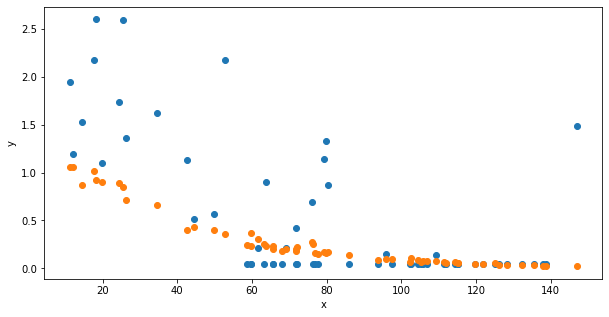

In [235]:
plt.figure(figsize = (10,5))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xx[0], 10**yy)

# go through the solutions
p0, k_b, k_M  = np.median(sampler.results['samples'][:1000], axis = 0)
plt.scatter(xx[0], 10**model_bM(xx, p0=p0, k_b=k_b, k_M = k_M))
#plt.xscale("log")
#plt.yscale("log")

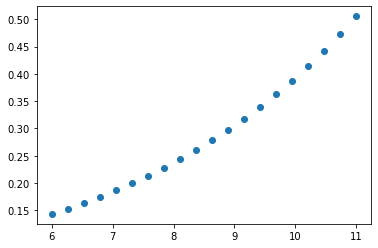

In [237]:
mm = np.linspace(6,11,20)
bb = 50
p0, k_b, k_M  = np.median(sampler.results['samples'][:1000], axis = 0)
plt.scatter(mm,  10**(p0 + bb*k_b + mm*k_M))

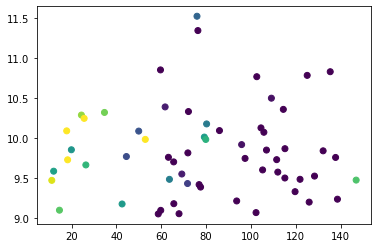

In [240]:
plt.scatter(isol_snr3_good_runs_rot["B_KPC"], isol_snr3_good_runs_rot["sed_logMass"], \
            c = isol_snr3_good_runs_rot["REW_2796"], vmin = 0, vmax = 2)

## log(W) = f(b, M, z, sfr, alpha, incl)

### Isolated

In [288]:
xx = np.array(isol_visu_rot[["B_KPC", "Rvir", "Z", "logSFR", "alpha", "inclination"]])
xx = xx.T
yy = np.array(np.log10(isol_visu_rot["REW_2796"]+0.05))

In [330]:
def model_all(X, p0, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination):
    W = p0 + X[0]*k_b + X[1]*k_M + X[2]*k_z + X[3]*k_sfr + X[4]*k_alpha + X[5]*k_inclination
    return W


def log_likelihood_all(params):
    # unpack the current parameters:
    p0, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination = params

    # compute for each x point, where it should lie in y
    y_model = model_all(xx, p0, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
    # compute likelihood
    #print("yy: ", 10**yy)
    #print("yy model: ", y_model, 10**y_model)
    #if np.median(y_model)>10:
        #print("aa")
    #    loglike = -0.5 * (((y_model - yy))**2).sum()
    #else:
        #print("oo")
    loglike = -0.5 * (((10**y_model - 10**yy))**2).sum()

    return loglike

def prior_transform_all(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -20 to +20
    params[0] = cube[0] * 2 - 1
    # b:
    params[1] = cube[1] * 0.2 - 0.1
    params[2] = cube[2] * 0.2 - 0.1
    params[3] = cube[3] * 0.4 - 0.2
    params[4] = cube[4] * 0.4 - 0.2
    params[5] = cube[5] * 0.2 - 0.1
    return params

In [331]:
parameters = ['p0', 'k_b', 'k_M', 'k_z', 'k_sfr', 'k_alpha', 'k_inclination']
sampler = ReactiveNestedSampler(parameters, log_likelihood_all, prior_transform_all)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=7+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]


DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-9217008472366832491052483570120674819737228627780959172989702082843980361070399656953583915943200285388197260427481076767529284562646772842962456287322729362984304829404086398045473813304585119279642388201472.00, Lmax=-34.43


DEBUG:ultranest:iteration=80, ncalls=884, regioncalls=3360, ndraw=40, logz=-762929995205194067185742832804188945505538265233266978254536040831021634233263982173828049850660747735018959586490563139204136138532408759075607165124631558886145392640.00, remainder_fraction=100.0000%, Lmin=-708890752227531981858103072179582590965611081024122223546899918783176679404748226997211158468240409596943057449416335605150568538432022030774992810492751170276985667584.00, Lmax=-34.43


DEBUG:ultranest:iteration=160, ncalls=979, regioncalls=7160, ndraw=40, logz=-18128148172591967552420232106574973822437888184935566018734685636050087565182304141177853997299649367261234573740432983085206553964466285999792702649008128.00, remainder_fraction=100.0000%, Lmin=-9547646144523140915578743788195965046403468842521179704728742980769823746986713034900916167306030423978708269747220340327381679127420963336208092655255552.00, Lmax=-34.43


DEBUG:ultranest:iteration=179, ncalls=999, regioncalls=7960, ndraw=40, logz=-135695624311239987569458626633566686334048796031636138620408293167744324653545312328665087553489149532733923598783158503332871929056257068669984361676800.00, remainder_fraction=100.0000%, Lmin=-88822860691645940460758140202283517911860084166719776085287358817997254590698273028901090037470506711495606093595361865952508120419395397966831380594688.00, Lmax=-34.43


DEBUG:ultranest:iteration=240, ncalls=1073, regioncalls=10920, ndraw=40, logz=-2359030800623040364942078783177841685549713751531194651281564351399370867346307435907972699211597641568463333058140773588779830365456798056448.00, remainder_fraction=100.0000%, Lmin=-1503336692279654326729834921624111543876600001098943735788700636512129335162618083994697246517088882381673453371471948164877596347641192513536.00, Lmax=-34.43


DEBUG:ultranest:iteration=320, ncalls=1179, regioncalls=15160, ndraw=40, logz=-8287253569074080635775767244092844585640198596941905765734120867312025276258948894823762924385282453806425443196813380432452124672.00, remainder_fraction=100.0000%, Lmin=-6320812143569277029661627946434960873195984559518541140481165280705227983918104831048392508587088792038361643254887883991681073152.00, Lmax=-34.43


DEBUG:ultranest:iteration=358, ncalls=1241, regioncalls=17640, ndraw=40, logz=-51751669798074081091990363159952922525808561281430542188625433156483515064423603405036807757661523361167231818287822789410816.00, remainder_fraction=100.0000%, Lmin=-37743988041144901762433769428086925459408326698623887753395558752803979343076986821205965542370496727093123641690836476887040.00, Lmax=-34.43


DEBUG:ultranest:iteration=400, ncalls=1300, regioncalls=20000, ndraw=40, logz=-136915875047545013596651118967353152330970634074144339789927120642770701417990097824305755943901697134796682779168866304.00, remainder_fraction=100.0000%, Lmin=-73053124595471096245895486510810209748805468650195554160465142030578195332289665104985416236989302114809134197334081536.00, Lmax=-34.43


DEBUG:ultranest:iteration=480, ncalls=1421, regioncalls=24840, ndraw=40, logz=-5732797768196168015081745977566095268036701505252953117162167519527515227559079180559424201716378775570087936.00, remainder_fraction=100.0000%, Lmin=-4212529397288458214908054844536437958092421021127184266903114490169288930629008265291352860974624945555374080.00, Lmax=-34.43


DEBUG:ultranest:iteration=537, ncalls=1511, regioncalls=28440, ndraw=40, logz=-4121305741883465838832877564720534646702613594847564748412506275044106262207547469537785098052567040000.00, remainder_fraction=100.0000%, Lmin=-2701202526720711822180004598604253350267915635452338219501347479675559488352508664533853196149149663232.00, Lmax=-34.43


DEBUG:ultranest:iteration=560, ncalls=1540, regioncalls=29600, ndraw=40, logz=-13107164912482019011005222363367047163883385190973966835900632152292313064518020616205454613059469312.00, remainder_fraction=100.0000%, Lmin=-12666113816422981732953802449428041616870642198390954057675463799702666346616264966400163568888578048.00, Lmax=-34.43


DEBUG:ultranest:iteration=640, ncalls=1661, regioncalls=34440, ndraw=40, logz=-1014786984313216988088254432787800550473906456205925527944574846435089539388076601823528484864.00, remainder_fraction=100.0000%, Lmin=-838666756377045426062782898351211587275166710663615555831329721503020545424941657969496424448.00, Lmax=-34.43


DEBUG:ultranest:iteration=716, ncalls=1793, regioncalls=39720, ndraw=40, logz=-342525385190095517194246038055679262081024818020300896928540893990826537158533000986624.00, remainder_fraction=100.0000%, Lmin=-305834504992611701771657948345593666517918212434538638776533747155464023395137780449280.00, Lmax=-34.43


DEBUG:ultranest:iteration=720, ncalls=1801, regioncalls=40040, ndraw=40, logz=-104004272706140973570402195157658098109864150400389803454295814470489866844718510374912.00, remainder_fraction=100.0000%, Lmin=-70805648059150539285487053600205247493572928243359556269368468989792168199990257123328.00, Lmax=-34.43


DEBUG:ultranest:iteration=800, ncalls=1941, regioncalls=45640, ndraw=40, logz=-654657928790353411951953005407603913804015060686945106936662924758179320346705920.00, remainder_fraction=100.0000%, Lmin=-536829982524679492102519456673627702148086068857347363136693597833361153377435648.00, Lmax=-34.43


DEBUG:ultranest:iteration=880, ncalls=2082, regioncalls=51280, ndraw=40, logz=-52535235084096085457346816261838946899090840546856001204268142580396457984.00, remainder_fraction=100.0000%, Lmin=-45462664320808773845383764297724789349888774371593550010025892311298211840.00, Lmax=-34.43


DEBUG:ultranest:iteration=895, ncalls=2111, regioncalls=52440, ndraw=40, logz=-12550393873450033953409630230642036246281345515436564184531070344113422336.00, remainder_fraction=100.0000%, Lmin=-8359849798666067898041855010588871772769224519989145523974207582981062656.00, Lmax=-34.43


DEBUG:ultranest:iteration=960, ncalls=2214, regioncalls=56560, ndraw=40, logz=-4918089860929225917343995791564462651106892362881306675250515853443072.00, remainder_fraction=100.0000%, Lmin=-4663873904815816085744232593947567358129259459478860510307945243738112.00, Lmax=-33.95


DEBUG:ultranest:iteration=1040, ncalls=2340, regioncalls=61600, ndraw=40, logz=-38712139060715858411949400870305526473929390944096221140954906624.00, remainder_fraction=100.0000%, Lmin=-30476181083690400881974069690899488663991899514591985332608040960.00, Lmax=-32.30


DEBUG:ultranest:iteration=1074, ncalls=2412, regioncalls=64480, ndraw=40, logz=-461765163112024608815480684846728519264396232764159076151066624.00, remainder_fraction=100.0000%, Lmin=-458828692085335801938819079663736780641935675399444038256951296.00, Lmax=-32.30


DEBUG:ultranest:iteration=1120, ncalls=2484, regioncalls=67360, ndraw=40, logz=-45487316139788892134468279882130875984298606272866884255744.00, remainder_fraction=100.0000%, Lmin=-37896551976064573368807909420907642836231311513351857635328.00, Lmax=-32.30


DEBUG:ultranest:iteration=1200, ncalls=2611, regioncalls=72440, ndraw=40, logz=-489992752029678050779889298273833996520647181310361600.00, remainder_fraction=100.0000%, Lmin=-431439306319322885700746769870683258507871274737336320.00, Lmax=-32.30


DEBUG:ultranest:iteration=1253, ncalls=2723, regioncalls=76920, ndraw=40, logz=-623852387926532009089662143482172118347545751584768.00, remainder_fraction=100.0000%, Lmin=-429546720817096859644129142267825460913982247272448.00, Lmax=-32.30


DEBUG:ultranest:iteration=1280, ncalls=2778, regioncalls=79120, ndraw=40, logz=-24050085169477169078860629927950574889611265310720.00, remainder_fraction=100.0000%, Lmin=-18622509937970379507286280196424077857682289065984.00, Lmax=-32.30


DEBUG:ultranest:iteration=1360, ncalls=2937, regioncalls=85480, ndraw=40, logz=-2757157575373293630848805079374658813909008384.00, remainder_fraction=100.0000%, Lmin=-2735201716668111319870670296041195444295958528.00, Lmax=-32.30


DEBUG:ultranest:iteration=1432, ncalls=3083, regioncalls=91320, ndraw=40, logz=-864696351383734351022800318998521514557440.00, remainder_fraction=100.0000%, Lmin=-741184087649536253100055229978782520573952.00, Lmax=-32.30


DEBUG:ultranest:iteration=1440, ncalls=3098, regioncalls=91920, ndraw=40, logz=-463943657487141990494995601182921878142976.00, remainder_fraction=100.0000%, Lmin=-404858488121858798670700219950291579043840.00, Lmax=-32.30


DEBUG:ultranest:iteration=1520, ncalls=3256, regioncalls=98240, ndraw=40, logz=-453926715226117269799457409213032038400.00, remainder_fraction=100.0000%, Lmin=-382956421256889224907542733008905699328.00, Lmax=-32.30


DEBUG:ultranest:iteration=1600, ncalls=3412, regioncalls=104480, ndraw=40, logz=-770274819501386204313734416512843776.00, remainder_fraction=100.0000%, Lmin=-749780581590183904469506060105809920.00, Lmax=-32.30


DEBUG:ultranest:iteration=1645, ncalls=3521, regioncalls=108840, ndraw=40, logz=-14357717408459118117286988646187008.00, remainder_fraction=100.0000%, Lmin=-12905421586339872778908707441344512.00, Lmax=-32.16


DEBUG:ultranest:iteration=1680, ncalls=3594, regioncalls=111760, ndraw=40, logz=-1897599482900934030854668786073600.00, remainder_fraction=100.0000%, Lmin=-1858617415631920714402728272461824.00, Lmax=-32.16


DEBUG:ultranest:iteration=1760, ncalls=3756, regioncalls=118240, ndraw=40, logz=-1673476518740603810486226518016.00, remainder_fraction=100.0000%, Lmin=-1641889176543196844774901415936.00, Lmax=-32.16


DEBUG:ultranest:iteration=1790, ncalls=3833, regioncalls=121320, ndraw=40, logz=-208355352249230910830600519680.00, remainder_fraction=100.0000%, Lmin=-204110319979532769194160422912.00, Lmax=-32.16


DEBUG:ultranest:iteration=1840, ncalls=3911, regioncalls=124440, ndraw=40, logz=-3879293330860258790471630848.00, remainder_fraction=100.0000%, Lmin=-3831208918185539754763747328.00, Lmax=-32.16


DEBUG:ultranest:iteration=1920, ncalls=4073, regioncalls=130920, ndraw=40, logz=-36422839311991835092582400.00, remainder_fraction=100.0000%, Lmin=-32113077149844508057272320.00, Lmax=-32.16


DEBUG:ultranest:iteration=1969, ncalls=4176, regioncalls=135040, ndraw=40, logz=-1182830664661190622314496.00, remainder_fraction=100.0000%, Lmin=-911702294902287475146752.00, Lmax=-32.16


DEBUG:ultranest:iteration=2000, ncalls=4232, regioncalls=137280, ndraw=40, logz=-135032321560904831336448.00, remainder_fraction=100.0000%, Lmin=-124564829693522468667392.00, Lmax=-32.16


DEBUG:ultranest:iteration=2080, ncalls=4360, regioncalls=142400, ndraw=40, logz=-3221397930888572960768.00, remainder_fraction=100.0000%, Lmin=-3127998282641478516736.00, Lmax=-32.16


DEBUG:ultranest:iteration=2148, ncalls=4498, regioncalls=147920, ndraw=40, logz=-38630828563377053696.00, remainder_fraction=100.0000%, Lmin=-38291631069656178688.00, Lmax=-32.16


DEBUG:ultranest:iteration=2160, ncalls=4531, regioncalls=149240, ndraw=40, logz=-25420678650021818368.00, remainder_fraction=100.0000%, Lmin=-25381069470067056640.00, Lmax=-32.16


DEBUG:ultranest:iteration=2240, ncalls=4725, regioncalls=157000, ndraw=40, logz=-285587970322820160.00, remainder_fraction=100.0000%, Lmin=-285004797805982368.00, Lmax=-32.16


DEBUG:ultranest:iteration=2320, ncalls=4918, regioncalls=164960, ndraw=40, logz=-10363146306221626.00, remainder_fraction=100.0000%, Lmin=-10297204106877306.00, Lmax=-32.16


DEBUG:ultranest:iteration=2327, ncalls=4929, regioncalls=165400, ndraw=40, logz=-8341132945867261.00, remainder_fraction=100.0000%, Lmin=-8255436297528592.00, Lmax=-32.16


DEBUG:ultranest:iteration=2400, ncalls=5073, regioncalls=171600, ndraw=40, logz=-381775066805061.50, remainder_fraction=100.0000%, Lmin=-376483765539337.94, Lmax=-32.16


DEBUG:ultranest:iteration=2480, ncalls=5234, regioncalls=178160, ndraw=40, logz=-22708916026788.07, remainder_fraction=100.0000%, Lmin=-21474812450332.13, Lmax=-32.16


DEBUG:ultranest:iteration=2506, ncalls=5290, regioncalls=180400, ndraw=40, logz=-13432064023146.23, remainder_fraction=100.0000%, Lmin=-12989255784868.60, Lmax=-32.16


DEBUG:ultranest:iteration=2560, ncalls=5389, regioncalls=184600, ndraw=40, logz=-1335445225322.85, remainder_fraction=100.0000%, Lmin=-1292802176351.59, Lmax=-28.39


DEBUG:ultranest:iteration=2640, ncalls=5591, regioncalls=192880, ndraw=40, logz=-75339752817.01, remainder_fraction=100.0000%, Lmin=-72670461276.35, Lmax=-28.39


DEBUG:ultranest:iteration=2685, ncalls=5702, regioncalls=197600, ndraw=40, logz=-17680224981.97, remainder_fraction=100.0000%, Lmin=-17163789586.87, Lmax=-28.09


DEBUG:ultranest:iteration=2720, ncalls=5793, regioncalls=201480, ndraw=40, logz=-5581508897.91, remainder_fraction=100.0000%, Lmin=-5084304003.92, Lmax=-28.09


DEBUG:ultranest:iteration=2800, ncalls=5984, regioncalls=209480, ndraw=40, logz=-612913432.20, remainder_fraction=100.0000%, Lmin=-610516342.26, Lmax=-28.09


DEBUG:ultranest:iteration=2864, ncalls=6144, regioncalls=216600, ndraw=40, logz=-106365417.17, remainder_fraction=100.0000%, Lmin=-105968500.10, Lmax=-28.09


DEBUG:ultranest:iteration=2880, ncalls=6182, regioncalls=218160, ndraw=40, logz=-85462294.37, remainder_fraction=100.0000%, Lmin=-82081477.74, Lmax=-28.09


DEBUG:ultranest:iteration=2960, ncalls=6389, regioncalls=226960, ndraw=40, logz=-12347435.12, remainder_fraction=100.0000%, Lmin=-11685071.12, Lmax=-28.09


DEBUG:ultranest:iteration=3040, ncalls=6579, regioncalls=236200, ndraw=40, logz=-1211809.22, remainder_fraction=100.0000%, Lmin=-1191311.14, Lmax=-28.09


DEBUG:ultranest:iteration=3043, ncalls=6582, regioncalls=236320, ndraw=40, logz=-1140386.31, remainder_fraction=100.0000%, Lmin=-1049110.80, Lmax=-28.09


DEBUG:ultranest:iteration=3119, ncalls=6749, regioncalls=244240, ndraw=40, logz=-157281.46, remainder_fraction=100.0000%, Lmin=-155209.04, Lmax=-28.09


DEBUG:ultranest:iteration=3120, ncalls=6755, regioncalls=244520, ndraw=40, logz=-155219.62, remainder_fraction=100.0000%, Lmin=-155135.53, Lmax=-28.09


DEBUG:ultranest:iteration=3200, ncalls=6939, regioncalls=252200, ndraw=40, logz=-16719.04, remainder_fraction=100.0000%, Lmin=-16482.96, Lmax=-28.09


DEBUG:ultranest:iteration=3242, ncalls=7018, regioncalls=255760, ndraw=40, logz=-6727.59, remainder_fraction=100.0000%, Lmin=-6266.52, Lmax=-28.09


DEBUG:ultranest:iteration=3280, ncalls=7145, regioncalls=261560, ndraw=40, logz=-2607.27, remainder_fraction=100.0000%, Lmin=-2404.75, Lmax=-28.09


DEBUG:ultranest:iteration=3353, ncalls=7368, regioncalls=272280, ndraw=40, logz=-472.53, remainder_fraction=100.0000%, Lmin=-456.53, Lmax=-28.09


DEBUG:ultranest:iteration=3360, ncalls=7395, regioncalls=273480, ndraw=40, logz=-425.51, remainder_fraction=100.0000%, Lmin=-383.61, Lmax=-28.09


DEBUG:ultranest:iteration=3401, ncalls=7521, regioncalls=280040, ndraw=40, logz=-149.38, remainder_fraction=100.0000%, Lmin=-138.70, Lmax=-28.09


DEBUG:ultranest:iteration=3440, ncalls=7629, regioncalls=285200, ndraw=40, logz=-88.20, remainder_fraction=100.0000%, Lmin=-76.64, Lmax=-27.47


DEBUG:ultranest:iteration=3517, ncalls=7834, regioncalls=295200, ndraw=40, logz=-49.80, remainder_fraction=99.9995%, Lmin=-40.42, Lmax=-27.47


DEBUG:ultranest:iteration=3520, ncalls=7840, regioncalls=295440, ndraw=40, logz=-49.30, remainder_fraction=99.9992%, Lmin=-40.07, Lmax=-27.47


DEBUG:ultranest:iteration=3580, ncalls=8017, regioncalls=304080, ndraw=40, logz=-44.38, remainder_fraction=99.8781%, Lmin=-36.21, Lmax=-27.47


DEBUG:ultranest:iteration=3600, ncalls=8102, regioncalls=308680, ndraw=40, logz=-43.62, remainder_fraction=99.7324%, Lmin=-35.84, Lmax=-27.47


DEBUG:ultranest:iteration=3673, ncalls=8325, regioncalls=319000, ndraw=40, logz=-42.34, remainder_fraction=98.9928%, Lmin=-35.70, Lmax=-27.47


DEBUG:ultranest:iteration=3680, ncalls=8354, regioncalls=320720, ndraw=40, logz=-42.28, remainder_fraction=98.9162%, Lmin=-35.70, Lmax=-27.47


DEBUG:ultranest:iteration=3750, ncalls=8586, regioncalls=332400, ndraw=40, logz=-41.80, remainder_fraction=98.2037%, Lmin=-35.70, Lmax=-27.47


DEBUG:ultranest:iteration=3759, ncalls=8618, regioncalls=333680, ndraw=40, logz=-41.76, remainder_fraction=98.1029%, Lmin=-35.70, Lmax=-27.47


DEBUG:ultranest:iteration=3760, ncalls=8622, regioncalls=333880, ndraw=40, logz=-41.75, remainder_fraction=98.0915%, Lmin=-35.70, Lmax=-27.47


DEBUG:ultranest:iteration=3818, ncalls=8816, regioncalls=344920, ndraw=40, logz=-41.51, remainder_fraction=98.2867%, Lmin=-35.70, Lmax=-27.22


DEBUG:ultranest:iteration=3840, ncalls=8894, regioncalls=348920, ndraw=40, logz=-41.44, remainder_fraction=98.1103%, Lmin=-35.70, Lmax=-27.22


DEBUG:ultranest:iteration=3904, ncalls=9126, regioncalls=360880, ndraw=40, logz=-41.26, remainder_fraction=97.5994%, Lmin=-35.70, Lmax=-27.22


DEBUG:ultranest:iteration=3920, ncalls=9183, regioncalls=363320, ndraw=40, logz=-41.22, remainder_fraction=97.4639%, Lmin=-35.70, Lmax=-27.22


DEBUG:ultranest:iteration=3938, ncalls=9234, regioncalls=365520, ndraw=40, logz=-41.18, remainder_fraction=98.2899%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=3993, ncalls=9443, regioncalls=377200, ndraw=40, logz=-41.07, remainder_fraction=97.9716%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4000, ncalls=9469, regioncalls=379840, ndraw=40, logz=-41.06, remainder_fraction=97.9312%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4063, ncalls=9689, regioncalls=392920, ndraw=40, logz=-40.96, remainder_fraction=97.8480%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4080, ncalls=9757, regioncalls=397920, ndraw=40, logz=-40.93, remainder_fraction=97.7505%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4117, ncalls=9896, regioncalls=407240, ndraw=40, logz=-40.88, remainder_fraction=97.5478%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4158, ncalls=10096, regioncalls=420520, ndraw=40, logz=-40.83, remainder_fraction=97.2998%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4160, ncalls=10105, regioncalls=421320, ndraw=40, logz=-40.83, remainder_fraction=97.2873%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4200, ncalls=10301, regioncalls=435600, ndraw=40, logz=-40.78, remainder_fraction=97.0339%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4240, ncalls=10507, regioncalls=448720, ndraw=40, logz=-40.74, remainder_fraction=96.8193%, Lmin=-35.70, Lmax=-26.51


DEBUG:ultranest:iteration=4288, ncalls=10727, regioncalls=462440, ndraw=40, logz=-40.70, remainder_fraction=98.7118%, Lmin=-35.70, Lmax=-24.77


DEBUG:ultranest:iteration=4311, ncalls=10840, regioncalls=470200, ndraw=40, logz=-40.68, remainder_fraction=98.6524%, Lmin=-35.70, Lmax=-24.77


DEBUG:ultranest:iteration=4320, ncalls=10877, regioncalls=472440, ndraw=40, logz=-40.67, remainder_fraction=98.6279%, Lmin=-35.70, Lmax=-24.77


DEBUG:ultranest:iteration=4363, ncalls=11118, regioncalls=487880, ndraw=40, logz=-40.64, remainder_fraction=98.5087%, Lmin=-35.69, Lmax=-24.77


DEBUG:ultranest:iteration=4394, ncalls=11372, regioncalls=504440, ndraw=40, logz=-40.62, remainder_fraction=99.2122%, Lmin=-35.69, Lmax=-24.29


DEBUG:ultranest:iteration=4400, ncalls=11452, regioncalls=509680, ndraw=40, logz=-40.61, remainder_fraction=99.2030%, Lmin=-35.69, Lmax=-24.29


DEBUG:ultranest:iteration=4436, ncalls=11701, regioncalls=526080, ndraw=40, logz=-40.59, remainder_fraction=99.1518%, Lmin=-35.69, Lmax=-24.29


DEBUG:ultranest:iteration=4471, ncalls=11970, regioncalls=543640, ndraw=40, logz=-40.56, remainder_fraction=99.0996%, Lmin=-35.68, Lmax=-24.29


DEBUG:ultranest:iteration=4480, ncalls=12020, regioncalls=546800, ndraw=40, logz=-40.56, remainder_fraction=99.0846%, Lmin=-35.68, Lmax=-24.29


DEBUG:ultranest:iteration=4512, ncalls=12256, regioncalls=562640, ndraw=40, logz=-40.54, remainder_fraction=99.0308%, Lmin=-35.67, Lmax=-24.29


DEBUG:ultranest:iteration=4548, ncalls=12475, regioncalls=577960, ndraw=40, logz=-40.52, remainder_fraction=98.9679%, Lmin=-35.66, Lmax=-24.29


DEBUG:ultranest:iteration=4560, ncalls=12553, regioncalls=582840, ndraw=40, logz=-40.51, remainder_fraction=98.9463%, Lmin=-35.66, Lmax=-24.29


DEBUG:ultranest:iteration=4596, ncalls=12793, regioncalls=599040, ndraw=40, logz=-40.49, remainder_fraction=98.8782%, Lmin=-35.64, Lmax=-24.29


DEBUG:ultranest:iteration=4627, ncalls=13031, regioncalls=615120, ndraw=40, logz=-40.48, remainder_fraction=98.8213%, Lmin=-35.62, Lmax=-24.29


DEBUG:ultranest:iteration=4640, ncalls=13189, regioncalls=625600, ndraw=40, logz=-40.47, remainder_fraction=98.7985%, Lmin=-35.62, Lmax=-24.29


DEBUG:ultranest:iteration=4657, ncalls=13336, regioncalls=634720, ndraw=40, logz=-40.46, remainder_fraction=99.9241%, Lmin=-35.61, Lmax=-20.84


DEBUG:ultranest:iteration=4685, ncalls=13577, regioncalls=650640, ndraw=40, logz=-40.45, remainder_fraction=99.9204%, Lmin=-35.60, Lmax=-20.84


DEBUG:ultranest:iteration=4706, ncalls=13815, regioncalls=667440, ndraw=40, logz=-40.44, remainder_fraction=99.9175%, Lmin=-35.58, Lmax=-20.84


DEBUG:ultranest:iteration=4720, ncalls=13959, regioncalls=677120, ndraw=40, logz=-40.44, remainder_fraction=99.9155%, Lmin=-35.57, Lmax=-20.84


DEBUG:ultranest:iteration=4755, ncalls=14213, regioncalls=693760, ndraw=40, logz=-40.42, remainder_fraction=99.9104%, Lmin=-35.54, Lmax=-20.84


DEBUG:ultranest:iteration=4783, ncalls=14473, regioncalls=711040, ndraw=40, logz=-40.41, remainder_fraction=99.9062%, Lmin=-35.52, Lmax=-20.84


DEBUG:ultranest:iteration=4800, ncalls=14643, regioncalls=722280, ndraw=40, logz=-40.40, remainder_fraction=99.9035%, Lmin=-35.50, Lmax=-20.84


DEBUG:ultranest:iteration=4824, ncalls=14910, regioncalls=740960, ndraw=40, logz=-40.39, remainder_fraction=99.8996%, Lmin=-35.47, Lmax=-20.84


DEBUG:ultranest:iteration=4838, ncalls=15037, regioncalls=750040, ndraw=40, logz=-40.39, remainder_fraction=99.8972%, Lmin=-35.45, Lmax=-20.84


DEBUG:ultranest:iteration=4859, ncalls=15272, regioncalls=766840, ndraw=40, logz=-40.38, remainder_fraction=99.8936%, Lmin=-35.44, Lmax=-20.84


DEBUG:ultranest:iteration=4880, ncalls=15556, regioncalls=784920, ndraw=40, logz=-40.37, remainder_fraction=99.8906%, Lmin=-35.41, Lmax=-20.84


DEBUG:ultranest:iteration=4901, ncalls=15844, regioncalls=803640, ndraw=40, logz=-40.36, remainder_fraction=99.8868%, Lmin=-35.39, Lmax=-20.84


DEBUG:ultranest:iteration=4927, ncalls=16112, regioncalls=821920, ndraw=40, logz=-40.35, remainder_fraction=99.8818%, Lmin=-35.35, Lmax=-20.84


DEBUG:ultranest:iteration=4948, ncalls=16348, regioncalls=839920, ndraw=40, logz=-40.34, remainder_fraction=99.8777%, Lmin=-35.32, Lmax=-20.84


DEBUG:ultranest:iteration=4960, ncalls=16494, regioncalls=849960, ndraw=40, logz=-40.34, remainder_fraction=99.8753%, Lmin=-35.29, Lmax=-20.84


DEBUG:ultranest:iteration=4979, ncalls=16791, regioncalls=868280, ndraw=40, logz=-40.33, remainder_fraction=99.8713%, Lmin=-35.27, Lmax=-20.84


DEBUG:ultranest:iteration=5000, ncalls=17068, regioncalls=887520, ndraw=40, logz=-40.32, remainder_fraction=99.8668%, Lmin=-35.24, Lmax=-20.84


DEBUG:ultranest:iteration=5015, ncalls=17286, regioncalls=901840, ndraw=40, logz=-40.32, remainder_fraction=99.8658%, Lmin=-35.22, Lmax=-20.84


DEBUG:ultranest:iteration=5038, ncalls=17544, regioncalls=918520, ndraw=40, logz=-40.31, remainder_fraction=99.8607%, Lmin=-35.18, Lmax=-20.84


DEBUG:ultranest:iteration=5040, ncalls=17628, regioncalls=924080, ndraw=40, logz=-40.31, remainder_fraction=99.8602%, Lmin=-35.18, Lmax=-20.84


DEBUG:ultranest:iteration=5056, ncalls=17872, regioncalls=942120, ndraw=40, logz=-40.30, remainder_fraction=99.8565%, Lmin=-35.16, Lmax=-20.84


DEBUG:ultranest:iteration=5074, ncalls=18190, regioncalls=964440, ndraw=40, logz=-40.29, remainder_fraction=99.8523%, Lmin=-35.11, Lmax=-20.84


DEBUG:ultranest:iteration=5093, ncalls=18506, regioncalls=984680, ndraw=40, logz=-40.29, remainder_fraction=99.8906%, Lmin=-35.07, Lmax=-20.84


DEBUG:ultranest:iteration=5111, ncalls=18753, regioncalls=1002320, ndraw=40, logz=-40.28, remainder_fraction=99.8873%, Lmin=-35.04, Lmax=-20.84


DEBUG:ultranest:iteration=5120, ncalls=18997, regioncalls=1019360, ndraw=40, logz=-40.27, remainder_fraction=99.8856%, Lmin=-35.01, Lmax=-20.84


DEBUG:ultranest:iteration=5137, ncalls=19323, regioncalls=1041640, ndraw=40, logz=-40.27, remainder_fraction=99.8824%, Lmin=-34.97, Lmax=-20.84


DEBUG:ultranest:iteration=5154, ncalls=19607, regioncalls=1060880, ndraw=40, logz=-40.26, remainder_fraction=99.8790%, Lmin=-34.94, Lmax=-20.84


DEBUG:ultranest:iteration=5178, ncalls=19905, regioncalls=1079200, ndraw=40, logz=-40.25, remainder_fraction=99.8745%, Lmin=-34.89, Lmax=-20.84


DEBUG:ultranest:iteration=5191, ncalls=20052, regioncalls=1089400, ndraw=40, logz=-40.25, remainder_fraction=99.8718%, Lmin=-34.85, Lmax=-20.84


DEBUG:ultranest:iteration=5200, ncalls=20112, regioncalls=1094160, ndraw=40, logz=-40.24, remainder_fraction=99.8699%, Lmin=-34.82, Lmax=-20.84


DEBUG:ultranest:iteration=5219, ncalls=20392, regioncalls=1112480, ndraw=40, logz=-40.23, remainder_fraction=99.8657%, Lmin=-34.78, Lmax=-20.84


DEBUG:ultranest:iteration=5237, ncalls=20656, regioncalls=1131520, ndraw=40, logz=-40.23, remainder_fraction=99.8651%, Lmin=-34.73, Lmax=-20.84


DEBUG:ultranest:iteration=5261, ncalls=20924, regioncalls=1149680, ndraw=40, logz=-40.22, remainder_fraction=99.8595%, Lmin=-34.68, Lmax=-20.84


DEBUG:ultranest:iteration=5280, ncalls=21166, regioncalls=1166240, ndraw=40, logz=-40.21, remainder_fraction=99.8549%, Lmin=-34.65, Lmax=-20.84


DEBUG:ultranest:iteration=5309, ncalls=21427, regioncalls=1183760, ndraw=40, logz=-40.19, remainder_fraction=99.8477%, Lmin=-34.60, Lmax=-20.84


DEBUG:ultranest:iteration=5327, ncalls=21703, regioncalls=1204360, ndraw=40, logz=-40.19, remainder_fraction=99.9578%, Lmin=-34.57, Lmax=-19.39


DEBUG:ultranest:iteration=5345, ncalls=21953, regioncalls=1222400, ndraw=40, logz=-40.18, remainder_fraction=99.9565%, Lmin=-34.54, Lmax=-19.39


DEBUG:ultranest:iteration=5360, ncalls=22137, regioncalls=1235280, ndraw=40, logz=-40.17, remainder_fraction=99.9553%, Lmin=-34.52, Lmax=-19.39


DEBUG:ultranest:iteration=5370, ncalls=22279, regioncalls=1245360, ndraw=40, logz=-40.17, remainder_fraction=99.9546%, Lmin=-34.51, Lmax=-19.39


DEBUG:ultranest:iteration=5378, ncalls=22444, regioncalls=1261040, ndraw=40, logz=-40.16, remainder_fraction=99.9668%, Lmin=-34.49, Lmax=-19.39


DEBUG:ultranest:iteration=5394, ncalls=22611, regioncalls=1278800, ndraw=40, logz=-40.16, remainder_fraction=99.9680%, Lmin=-34.45, Lmax=-19.39


DEBUG:ultranest:iteration=5416, ncalls=22790, regioncalls=1296000, ndraw=40, logz=-40.15, remainder_fraction=99.9668%, Lmin=-34.40, Lmax=-19.39


DEBUG:ultranest:iteration=5427, ncalls=22954, regioncalls=1313520, ndraw=40, logz=-40.14, remainder_fraction=99.9662%, Lmin=-34.37, Lmax=-19.39


DEBUG:ultranest:iteration=5440, ncalls=23099, regioncalls=1328640, ndraw=40, logz=-40.14, remainder_fraction=99.9654%, Lmin=-34.35, Lmax=-19.39


DEBUG:ultranest:iteration=5451, ncalls=23265, regioncalls=1345200, ndraw=40, logz=-40.13, remainder_fraction=99.9648%, Lmin=-34.34, Lmax=-19.39


DEBUG:ultranest:iteration=5463, ncalls=23459, regioncalls=1365920, ndraw=40, logz=-40.13, remainder_fraction=99.9640%, Lmin=-34.31, Lmax=-19.39


DEBUG:ultranest:iteration=5473, ncalls=23631, regioncalls=1386080, ndraw=40, logz=-40.12, remainder_fraction=99.9634%, Lmin=-34.30, Lmax=-19.39


DEBUG:ultranest:iteration=5486, ncalls=23813, regioncalls=1405520, ndraw=40, logz=-40.12, remainder_fraction=99.9626%, Lmin=-34.29, Lmax=-19.39


DEBUG:ultranest:iteration=5495, ncalls=23993, regioncalls=1424200, ndraw=40, logz=-40.11, remainder_fraction=99.9620%, Lmin=-34.27, Lmax=-19.39


DEBUG:ultranest:iteration=5506, ncalls=24154, regioncalls=1440560, ndraw=40, logz=-40.11, remainder_fraction=99.9613%, Lmin=-34.25, Lmax=-19.39


DEBUG:ultranest:iteration=5519, ncalls=24328, regioncalls=1459840, ndraw=40, logz=-40.10, remainder_fraction=99.9605%, Lmin=-34.20, Lmax=-19.39


DEBUG:ultranest:iteration=5520, ncalls=24335, regioncalls=1460440, ndraw=40, logz=-40.10, remainder_fraction=99.9604%, Lmin=-34.20, Lmax=-19.39


DEBUG:ultranest:iteration=5527, ncalls=24503, regioncalls=1478440, ndraw=40, logz=-40.10, remainder_fraction=99.9599%, Lmin=-34.19, Lmax=-19.39


DEBUG:ultranest:iteration=5539, ncalls=24672, regioncalls=1496240, ndraw=40, logz=-40.09, remainder_fraction=99.9591%, Lmin=-34.18, Lmax=-19.39


DEBUG:ultranest:iteration=5547, ncalls=24843, regioncalls=1514960, ndraw=40, logz=-40.09, remainder_fraction=99.9585%, Lmin=-34.16, Lmax=-19.39
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([799,   1]))


DEBUG:ultranest:iteration=5551, ncalls=24941, regioncalls=1526040, ndraw=40, logz=-40.09, remainder_fraction=99.9583%, Lmin=-34.14, Lmax=-19.39


DEBUG:ultranest:iteration=5568, ncalls=25108, regioncalls=1545040, ndraw=40, logz=-40.08, remainder_fraction=99.9570%, Lmin=-34.11, Lmax=-19.39


DEBUG:ultranest:iteration=5580, ncalls=25311, regioncalls=1567320, ndraw=40, logz=-40.07, remainder_fraction=99.9561%, Lmin=-34.09, Lmax=-19.39


DEBUG:ultranest:iteration=5594, ncalls=25535, regioncalls=1589960, ndraw=40, logz=-40.07, remainder_fraction=99.9551%, Lmin=-34.06, Lmax=-19.39


DEBUG:ultranest:iteration=5600, ncalls=25645, regioncalls=1601920, ndraw=40, logz=-40.06, remainder_fraction=99.9546%, Lmin=-34.04, Lmax=-19.39


DEBUG:ultranest:iteration=5608, ncalls=25845, regioncalls=1624320, ndraw=40, logz=-40.06, remainder_fraction=99.9540%, Lmin=-34.04, Lmax=-19.39


DEBUG:ultranest:iteration=5619, ncalls=26010, regioncalls=1642920, ndraw=40, logz=-40.05, remainder_fraction=99.9537%, Lmin=-34.01, Lmax=-19.39


DEBUG:ultranest:iteration=5629, ncalls=26163, regioncalls=1659520, ndraw=40, logz=-40.05, remainder_fraction=99.9529%, Lmin=-33.99, Lmax=-19.39


DEBUG:ultranest:iteration=5639, ncalls=26344, regioncalls=1679680, ndraw=40, logz=-40.05, remainder_fraction=99.9521%, Lmin=-33.97, Lmax=-19.39


DEBUG:ultranest:iteration=5649, ncalls=26519, regioncalls=1698280, ndraw=40, logz=-40.04, remainder_fraction=99.9512%, Lmin=-33.95, Lmax=-19.39


DEBUG:ultranest:iteration=5656, ncalls=26686, regioncalls=1718240, ndraw=40, logz=-40.04, remainder_fraction=99.9506%, Lmin=-33.94, Lmax=-19.39


DEBUG:ultranest:iteration=5668, ncalls=26853, regioncalls=1736240, ndraw=40, logz=-40.03, remainder_fraction=99.9496%, Lmin=-33.92, Lmax=-19.39


DEBUG:ultranest:iteration=5679, ncalls=27018, regioncalls=1753240, ndraw=40, logz=-40.03, remainder_fraction=99.9487%, Lmin=-33.90, Lmax=-19.39


DEBUG:ultranest:iteration=5680, ncalls=27024, regioncalls=1754040, ndraw=40, logz=-40.03, remainder_fraction=99.9486%, Lmin=-33.89, Lmax=-19.39


DEBUG:ultranest:iteration=5692, ncalls=27200, regioncalls=1776080, ndraw=40, logz=-40.02, remainder_fraction=99.9475%, Lmin=-33.88, Lmax=-19.39


DEBUG:ultranest:iteration=5698, ncalls=27370, regioncalls=1794040, ndraw=40, logz=-40.02, remainder_fraction=99.9469%, Lmin=-33.86, Lmax=-19.39


DEBUG:ultranest:iteration=5708, ncalls=27584, regioncalls=1818440, ndraw=40, logz=-40.01, remainder_fraction=99.9460%, Lmin=-33.84, Lmax=-19.39


DEBUG:ultranest:iteration=5718, ncalls=27746, regioncalls=1836000, ndraw=40, logz=-40.01, remainder_fraction=99.9451%, Lmin=-33.82, Lmax=-19.39


DEBUG:ultranest:iteration=5727, ncalls=27928, regioncalls=1853760, ndraw=40, logz=-40.00, remainder_fraction=99.9442%, Lmin=-33.80, Lmax=-19.39


DEBUG:ultranest:iteration=5728, ncalls=27963, regioncalls=1858840, ndraw=40, logz=-40.00, remainder_fraction=99.9441%, Lmin=-33.80, Lmax=-19.39


DEBUG:ultranest:iteration=5735, ncalls=28109, regioncalls=1879400, ndraw=40, logz=-40.00, remainder_fraction=99.9572%, Lmin=-33.79, Lmax=-19.39


DEBUG:ultranest:iteration=5743, ncalls=28230, regioncalls=1897680, ndraw=40, logz=-40.00, remainder_fraction=99.9566%, Lmin=-33.77, Lmax=-19.39


DEBUG:ultranest:iteration=5752, ncalls=28367, regioncalls=1916240, ndraw=40, logz=-39.99, remainder_fraction=99.9560%, Lmin=-33.76, Lmax=-19.39


DEBUG:ultranest:iteration=5760, ncalls=28480, regioncalls=1930480, ndraw=40, logz=-39.99, remainder_fraction=99.9554%, Lmin=-33.75, Lmax=-19.39


DEBUG:ultranest:iteration=5771, ncalls=28600, regioncalls=1948160, ndraw=40, logz=-39.98, remainder_fraction=99.9549%, Lmin=-33.73, Lmax=-19.39


DEBUG:ultranest:iteration=5775, ncalls=28735, regioncalls=1966760, ndraw=40, logz=-39.98, remainder_fraction=99.9546%, Lmin=-33.73, Lmax=-19.39


DEBUG:ultranest:iteration=5784, ncalls=28869, regioncalls=1986320, ndraw=40, logz=-39.98, remainder_fraction=99.9539%, Lmin=-33.72, Lmax=-19.39


DEBUG:ultranest:iteration=5794, ncalls=28998, regioncalls=2004360, ndraw=40, logz=-39.97, remainder_fraction=99.9531%, Lmin=-33.71, Lmax=-19.39


DEBUG:ultranest:iteration=5806, ncalls=29158, regioncalls=2025760, ndraw=40, logz=-39.97, remainder_fraction=99.9521%, Lmin=-33.68, Lmax=-19.39


DEBUG:ultranest:iteration=5817, ncalls=29318, regioncalls=2048160, ndraw=40, logz=-39.96, remainder_fraction=99.9544%, Lmin=-33.67, Lmax=-19.39


DEBUG:ultranest:iteration=5825, ncalls=29464, regioncalls=2068680, ndraw=40, logz=-39.96, remainder_fraction=99.9538%, Lmin=-33.65, Lmax=-19.39


DEBUG:ultranest:iteration=5833, ncalls=29622, regioncalls=2092000, ndraw=40, logz=-39.95, remainder_fraction=99.9532%, Lmin=-33.64, Lmax=-19.39


DEBUG:ultranest:iteration=5837, ncalls=29760, regioncalls=2111880, ndraw=40, logz=-39.95, remainder_fraction=99.9529%, Lmin=-33.64, Lmax=-19.39


DEBUG:ultranest:iteration=5840, ncalls=29812, regioncalls=2119560, ndraw=40, logz=-39.95, remainder_fraction=99.9526%, Lmin=-33.62, Lmax=-19.39


DEBUG:ultranest:iteration=5851, ncalls=29962, regioncalls=2143760, ndraw=40, logz=-39.94, remainder_fraction=99.9618%, Lmin=-33.60, Lmax=-19.39


DEBUG:ultranest:iteration=5858, ncalls=30072, regioncalls=2160920, ndraw=40, logz=-39.94, remainder_fraction=99.9614%, Lmin=-33.59, Lmax=-19.39


DEBUG:ultranest:iteration=5867, ncalls=30195, regioncalls=2178160, ndraw=40, logz=-39.94, remainder_fraction=99.9608%, Lmin=-33.58, Lmax=-19.39


DEBUG:ultranest:iteration=5873, ncalls=30313, regioncalls=2196520, ndraw=40, logz=-39.93, remainder_fraction=99.9604%, Lmin=-33.56, Lmax=-19.39


DEBUG:ultranest:iteration=5883, ncalls=30444, regioncalls=2214360, ndraw=40, logz=-39.93, remainder_fraction=99.9597%, Lmin=-33.55, Lmax=-19.39


DEBUG:ultranest:iteration=5891, ncalls=30592, regioncalls=2235440, ndraw=40, logz=-39.93, remainder_fraction=99.9592%, Lmin=-33.54, Lmax=-19.39


DEBUG:ultranest:iteration=5897, ncalls=30761, regioncalls=2259400, ndraw=40, logz=-39.92, remainder_fraction=99.9588%, Lmin=-33.53, Lmax=-19.39


DEBUG:ultranest:iteration=5904, ncalls=30970, regioncalls=2289040, ndraw=40, logz=-39.92, remainder_fraction=99.9583%, Lmin=-33.52, Lmax=-19.39


DEBUG:ultranest:iteration=5908, ncalls=31033, regioncalls=2297720, ndraw=40, logz=-39.92, remainder_fraction=99.9580%, Lmin=-33.51, Lmax=-19.39


DEBUG:ultranest:iteration=5911, ncalls=31158, regioncalls=2320000, ndraw=40, logz=-39.92, remainder_fraction=99.9577%, Lmin=-33.51, Lmax=-19.39


DEBUG:ultranest:iteration=5918, ncalls=31281, regioncalls=2340640, ndraw=40, logz=-39.91, remainder_fraction=99.9572%, Lmin=-33.50, Lmax=-19.39


DEBUG:ultranest:iteration=5920, ncalls=31313, regioncalls=2345760, ndraw=40, logz=-39.91, remainder_fraction=99.9571%, Lmin=-33.49, Lmax=-19.39


DEBUG:ultranest:iteration=5927, ncalls=31444, regioncalls=2362280, ndraw=40, logz=-39.91, remainder_fraction=99.9566%, Lmin=-33.48, Lmax=-19.39


DEBUG:ultranest:iteration=5931, ncalls=31583, regioncalls=2382400, ndraw=40, logz=-39.91, remainder_fraction=99.9563%, Lmin=-33.47, Lmax=-19.39


DEBUG:ultranest:iteration=5935, ncalls=31697, regioncalls=2401840, ndraw=40, logz=-39.91, remainder_fraction=99.9560%, Lmin=-33.47, Lmax=-19.39


DEBUG:ultranest:iteration=5942, ncalls=31838, regioncalls=2421160, ndraw=40, logz=-39.90, remainder_fraction=99.9554%, Lmin=-33.45, Lmax=-19.39


DEBUG:ultranest:iteration=5953, ncalls=32000, regioncalls=2441520, ndraw=40, logz=-39.90, remainder_fraction=99.9546%, Lmin=-33.41, Lmax=-19.39


DEBUG:ultranest:iteration=5964, ncalls=32112, regioncalls=2459440, ndraw=40, logz=-39.89, remainder_fraction=99.9537%, Lmin=-33.39, Lmax=-19.39


DEBUG:ultranest:iteration=5968, ncalls=32263, regioncalls=2481280, ndraw=40, logz=-39.89, remainder_fraction=99.9534%, Lmin=-33.38, Lmax=-19.39


DEBUG:ultranest:iteration=5974, ncalls=32428, regioncalls=2507800, ndraw=40, logz=-39.89, remainder_fraction=99.9529%, Lmin=-33.37, Lmax=-19.39


DEBUG:ultranest:iteration=5978, ncalls=32564, regioncalls=2527280, ndraw=40, logz=-39.88, remainder_fraction=99.9526%, Lmin=-33.37, Lmax=-19.39


DEBUG:ultranest:iteration=5985, ncalls=32685, regioncalls=2545720, ndraw=40, logz=-39.88, remainder_fraction=99.9520%, Lmin=-33.35, Lmax=-19.39


DEBUG:ultranest:iteration=5988, ncalls=32815, regioncalls=2566320, ndraw=40, logz=-39.88, remainder_fraction=99.9518%, Lmin=-33.35, Lmax=-19.39


DEBUG:ultranest:iteration=5991, ncalls=32918, regioncalls=2584400, ndraw=40, logz=-39.88, remainder_fraction=99.9515%, Lmin=-33.34, Lmax=-19.39


DEBUG:ultranest:iteration=5995, ncalls=33064, regioncalls=2605880, ndraw=40, logz=-39.88, remainder_fraction=99.9512%, Lmin=-33.34, Lmax=-19.39


DEBUG:ultranest:iteration=6000, ncalls=33130, regioncalls=2616360, ndraw=40, logz=-39.87, remainder_fraction=99.9508%, Lmin=-33.33, Lmax=-19.39


DEBUG:ultranest:iteration=6007, ncalls=33299, regioncalls=2641880, ndraw=40, logz=-39.87, remainder_fraction=99.9502%, Lmin=-33.32, Lmax=-19.39


DEBUG:ultranest:iteration=6012, ncalls=33434, regioncalls=2662600, ndraw=40, logz=-39.87, remainder_fraction=99.9497%, Lmin=-33.31, Lmax=-19.39


DEBUG:ultranest:iteration=6015, ncalls=33589, regioncalls=2687720, ndraw=40, logz=-39.87, remainder_fraction=99.9495%, Lmin=-33.31, Lmax=-19.39


DEBUG:ultranest:iteration=6019, ncalls=33741, regioncalls=2707920, ndraw=40, logz=-39.87, remainder_fraction=99.9491%, Lmin=-33.30, Lmax=-19.39


DEBUG:ultranest:iteration=6024, ncalls=33880, regioncalls=2727840, ndraw=40, logz=-39.86, remainder_fraction=99.9488%, Lmin=-33.30, Lmax=-19.39


DEBUG:ultranest:iteration=6028, ncalls=33995, regioncalls=2745960, ndraw=40, logz=-39.86, remainder_fraction=99.9484%, Lmin=-33.29, Lmax=-19.39


DEBUG:ultranest:iteration=6033, ncalls=34124, regioncalls=2764680, ndraw=40, logz=-39.86, remainder_fraction=99.9480%, Lmin=-33.28, Lmax=-19.39


DEBUG:ultranest:iteration=6040, ncalls=34276, regioncalls=2787240, ndraw=40, logz=-39.86, remainder_fraction=99.9474%, Lmin=-33.27, Lmax=-19.39


DEBUG:ultranest:iteration=6048, ncalls=34440, regioncalls=2812000, ndraw=40, logz=-39.85, remainder_fraction=99.9467%, Lmin=-33.26, Lmax=-19.39


DEBUG:ultranest:iteration=6055, ncalls=34568, regioncalls=2830880, ndraw=40, logz=-39.85, remainder_fraction=99.9474%, Lmin=-33.25, Lmax=-19.39


DEBUG:ultranest:iteration=6057, ncalls=34695, regioncalls=2850200, ndraw=40, logz=-39.85, remainder_fraction=99.9472%, Lmin=-33.25, Lmax=-19.39


DEBUG:ultranest:iteration=6061, ncalls=34826, regioncalls=2871360, ndraw=40, logz=-39.85, remainder_fraction=99.9468%, Lmin=-33.24, Lmax=-19.39


DEBUG:ultranest:iteration=6071, ncalls=34948, regioncalls=2888800, ndraw=40, logz=-39.84, remainder_fraction=99.9465%, Lmin=-33.23, Lmax=-19.39


DEBUG:ultranest:iteration=6076, ncalls=35121, regioncalls=2917280, ndraw=40, logz=-39.84, remainder_fraction=99.9465%, Lmin=-33.22, Lmax=-19.39


DEBUG:ultranest:iteration=6080, ncalls=35268, regioncalls=2939760, ndraw=40, logz=-39.84, remainder_fraction=99.9461%, Lmin=-33.21, Lmax=-19.39


DEBUG:ultranest:iteration=6083, ncalls=35389, regioncalls=2959880, ndraw=40, logz=-39.83, remainder_fraction=99.9458%, Lmin=-33.21, Lmax=-19.39
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([799,   1]))


DEBUG:ultranest:iteration=6087, ncalls=35484, regioncalls=2973200, ndraw=40, logz=-39.83, remainder_fraction=99.9455%, Lmin=-33.20, Lmax=-19.39


DEBUG:ultranest:iteration=6092, ncalls=35625, regioncalls=2991440, ndraw=40, logz=-39.83, remainder_fraction=99.9450%, Lmin=-33.18, Lmax=-19.39


DEBUG:ultranest:iteration=6097, ncalls=35805, regioncalls=3016680, ndraw=40, logz=-39.83, remainder_fraction=99.9447%, Lmin=-33.17, Lmax=-19.39


DEBUG:ultranest:iteration=6101, ncalls=35916, regioncalls=3037800, ndraw=40, logz=-39.83, remainder_fraction=99.9444%, Lmin=-33.16, Lmax=-19.39


DEBUG:ultranest:iteration=6108, ncalls=36048, regioncalls=3057760, ndraw=40, logz=-39.82, remainder_fraction=99.9437%, Lmin=-33.15, Lmax=-19.39


DEBUG:ultranest:iteration=6113, ncalls=36224, regioncalls=3084400, ndraw=40, logz=-39.82, remainder_fraction=99.9454%, Lmin=-33.14, Lmax=-19.39


DEBUG:ultranest:iteration=6118, ncalls=36354, regioncalls=3105760, ndraw=40, logz=-39.82, remainder_fraction=99.9449%, Lmin=-33.13, Lmax=-19.39


DEBUG:ultranest:iteration=6120, ncalls=36474, regioncalls=3125400, ndraw=40, logz=-39.82, remainder_fraction=99.9448%, Lmin=-33.13, Lmax=-19.39


DEBUG:ultranest:iteration=6123, ncalls=36657, regioncalls=3151840, ndraw=40, logz=-39.82, remainder_fraction=99.9445%, Lmin=-33.12, Lmax=-19.39


DEBUG:ultranest:iteration=6130, ncalls=36785, regioncalls=3173600, ndraw=40, logz=-39.81, remainder_fraction=99.9438%, Lmin=-33.12, Lmax=-19.39


DEBUG:ultranest:iteration=6141, ncalls=36901, regioncalls=3192720, ndraw=40, logz=-39.81, remainder_fraction=99.9481%, Lmin=-33.10, Lmax=-19.39


DEBUG:ultranest:iteration=6148, ncalls=37100, regioncalls=3223240, ndraw=40, logz=-39.80, remainder_fraction=99.9475%, Lmin=-33.08, Lmax=-19.39


DEBUG:ultranest:iteration=6155, ncalls=37255, regioncalls=3245200, ndraw=40, logz=-39.80, remainder_fraction=99.9468%, Lmin=-33.07, Lmax=-19.39


DEBUG:ultranest:iteration=6160, ncalls=37404, regioncalls=3267480, ndraw=40, logz=-39.80, remainder_fraction=99.9464%, Lmin=-33.07, Lmax=-19.39


DEBUG:ultranest:iteration=6166, ncalls=37524, regioncalls=3285880, ndraw=40, logz=-39.80, remainder_fraction=99.9460%, Lmin=-33.06, Lmax=-19.39


DEBUG:ultranest:iteration=6172, ncalls=37650, regioncalls=3305080, ndraw=40, logz=-39.79, remainder_fraction=99.9454%, Lmin=-33.05, Lmax=-19.39


DEBUG:ultranest:iteration=6178, ncalls=37810, regioncalls=3330560, ndraw=40, logz=-39.79, remainder_fraction=99.9448%, Lmin=-33.02, Lmax=-19.39


DEBUG:ultranest:iteration=6187, ncalls=37965, regioncalls=3353240, ndraw=40, logz=-39.79, remainder_fraction=99.9440%, Lmin=-33.02, Lmax=-19.39


DEBUG:ultranest:iteration=6191, ncalls=38109, regioncalls=3375720, ndraw=40, logz=-39.78, remainder_fraction=99.9436%, Lmin=-33.01, Lmax=-19.39


DEBUG:ultranest:iteration=6202, ncalls=38233, regioncalls=3392960, ndraw=40, logz=-39.78, remainder_fraction=99.9425%, Lmin=-33.00, Lmax=-19.39


DEBUG:ultranest:iteration=6205, ncalls=38384, regioncalls=3417080, ndraw=40, logz=-39.78, remainder_fraction=99.9422%, Lmin=-32.99, Lmax=-19.39


DEBUG:ultranest:iteration=6210, ncalls=38547, regioncalls=3441840, ndraw=40, logz=-39.77, remainder_fraction=99.9417%, Lmin=-32.99, Lmax=-19.39


DEBUG:ultranest:iteration=6218, ncalls=38669, regioncalls=3461520, ndraw=40, logz=-39.77, remainder_fraction=99.9409%, Lmin=-32.98, Lmax=-19.39


DEBUG:ultranest:iteration=6223, ncalls=38807, regioncalls=3482520, ndraw=40, logz=-39.77, remainder_fraction=99.9404%, Lmin=-32.98, Lmax=-19.39


DEBUG:ultranest:iteration=6229, ncalls=38954, regioncalls=3504200, ndraw=40, logz=-39.77, remainder_fraction=99.9399%, Lmin=-32.96, Lmax=-19.39


DEBUG:ultranest:iteration=6234, ncalls=39073, regioncalls=3524480, ndraw=40, logz=-39.76, remainder_fraction=99.9394%, Lmin=-32.95, Lmax=-19.39


DEBUG:ultranest:iteration=6237, ncalls=39201, regioncalls=3545200, ndraw=40, logz=-39.76, remainder_fraction=99.9390%, Lmin=-32.95, Lmax=-19.39


DEBUG:ultranest:iteration=6240, ncalls=39257, regioncalls=3555520, ndraw=40, logz=-39.76, remainder_fraction=99.9387%, Lmin=-32.94, Lmax=-19.39


DEBUG:ultranest:iteration=6244, ncalls=39391, regioncalls=3577480, ndraw=40, logz=-39.76, remainder_fraction=99.9383%, Lmin=-32.93, Lmax=-19.39


DEBUG:ultranest:iteration=6249, ncalls=39521, regioncalls=3597400, ndraw=40, logz=-39.76, remainder_fraction=99.9378%, Lmin=-32.92, Lmax=-19.39


DEBUG:ultranest:iteration=6253, ncalls=39697, regioncalls=3627080, ndraw=40, logz=-39.75, remainder_fraction=99.9373%, Lmin=-32.92, Lmax=-19.39


DEBUG:ultranest:iteration=6260, ncalls=39891, regioncalls=3654520, ndraw=40, logz=-39.75, remainder_fraction=99.9366%, Lmin=-32.90, Lmax=-19.39


DEBUG:ultranest:iteration=6265, ncalls=40011, regioncalls=3671720, ndraw=40, logz=-39.75, remainder_fraction=99.9360%, Lmin=-32.89, Lmax=-19.39


DEBUG:ultranest:iteration=6267, ncalls=40134, regioncalls=3691600, ndraw=40, logz=-39.75, remainder_fraction=99.9358%, Lmin=-32.89, Lmax=-19.39


DEBUG:ultranest:iteration=6273, ncalls=40230, regioncalls=3708480, ndraw=40, logz=-39.74, remainder_fraction=99.9352%, Lmin=-32.88, Lmax=-19.39


DEBUG:ultranest:iteration=6280, ncalls=40424, regioncalls=3734080, ndraw=40, logz=-39.74, remainder_fraction=99.9344%, Lmin=-32.87, Lmax=-19.39


DEBUG:ultranest:iteration=6284, ncalls=40558, regioncalls=3754680, ndraw=40, logz=-39.74, remainder_fraction=99.9340%, Lmin=-32.86, Lmax=-19.39


DEBUG:ultranest:iteration=6288, ncalls=40759, regioncalls=3784040, ndraw=40, logz=-39.74, remainder_fraction=99.9404%, Lmin=-32.86, Lmax=-19.39


DEBUG:ultranest:iteration=6293, ncalls=40895, regioncalls=3803160, ndraw=40, logz=-39.74, remainder_fraction=99.9399%, Lmin=-32.85, Lmax=-19.39


DEBUG:ultranest:iteration=6299, ncalls=41052, regioncalls=3825760, ndraw=40, logz=-39.73, remainder_fraction=99.9393%, Lmin=-32.84, Lmax=-19.39


DEBUG:ultranest:iteration=6308, ncalls=41167, regioncalls=3842680, ndraw=40, logz=-39.73, remainder_fraction=99.9383%, Lmin=-32.83, Lmax=-19.39


DEBUG:ultranest:iteration=6316, ncalls=41280, regioncalls=3859720, ndraw=40, logz=-39.72, remainder_fraction=99.9375%, Lmin=-32.82, Lmax=-19.39


DEBUG:ultranest:iteration=6320, ncalls=41445, regioncalls=3887280, ndraw=40, logz=-39.72, remainder_fraction=99.9370%, Lmin=-32.81, Lmax=-19.39


DEBUG:ultranest:iteration=6324, ncalls=41576, regioncalls=3907400, ndraw=40, logz=-39.72, remainder_fraction=99.9999%, Lmin=-32.80, Lmax=-11.41


DEBUG:ultranest:iteration=6331, ncalls=41720, regioncalls=3930040, ndraw=40, logz=-39.72, remainder_fraction=99.9999%, Lmin=-32.80, Lmax=-11.41


DEBUG:ultranest:iteration=6337, ncalls=41877, regioncalls=3954840, ndraw=40, logz=-39.72, remainder_fraction=99.9999%, Lmin=-32.79, Lmax=-11.41


DEBUG:ultranest:iteration=6342, ncalls=41999, regioncalls=3974280, ndraw=40, logz=-39.71, remainder_fraction=99.9999%, Lmin=-32.78, Lmax=-11.41


DEBUG:ultranest:iteration=6346, ncalls=42140, regioncalls=3996120, ndraw=40, logz=-39.71, remainder_fraction=99.9999%, Lmin=-32.78, Lmax=-11.41


DEBUG:ultranest:iteration=6352, ncalls=42256, regioncalls=4016200, ndraw=40, logz=-39.71, remainder_fraction=99.9999%, Lmin=-32.76, Lmax=-11.41


DEBUG:ultranest:iteration=6359, ncalls=42418, regioncalls=4038240, ndraw=40, logz=-39.70, remainder_fraction=99.9999%, Lmin=-32.76, Lmax=-11.41


DEBUG:ultranest:iteration=6365, ncalls=42532, regioncalls=4057480, ndraw=40, logz=-39.70, remainder_fraction=99.9999%, Lmin=-32.75, Lmax=-11.41


DEBUG:ultranest:iteration=6372, ncalls=42642, regioncalls=4076040, ndraw=40, logz=-39.70, remainder_fraction=99.9999%, Lmin=-32.73, Lmax=-11.41


DEBUG:ultranest:iteration=6378, ncalls=42807, regioncalls=4102720, ndraw=40, logz=-39.70, remainder_fraction=99.9999%, Lmin=-32.72, Lmax=-11.41


DEBUG:ultranest:iteration=6380, ncalls=42910, regioncalls=4120360, ndraw=40, logz=-39.70, remainder_fraction=99.9999%, Lmin=-32.72, Lmax=-11.41


DEBUG:ultranest:iteration=6383, ncalls=43111, regioncalls=4151200, ndraw=40, logz=-39.69, remainder_fraction=99.9999%, Lmin=-32.72, Lmax=-11.41


DEBUG:ultranest:iteration=6388, ncalls=43252, regioncalls=4172880, ndraw=40, logz=-39.69, remainder_fraction=99.9999%, Lmin=-32.71, Lmax=-11.41


DEBUG:ultranest:iteration=6393, ncalls=43401, regioncalls=4198600, ndraw=40, logz=-39.69, remainder_fraction=99.9999%, Lmin=-32.70, Lmax=-11.41


DEBUG:ultranest:iteration=6398, ncalls=43521, regioncalls=4218280, ndraw=40, logz=-39.69, remainder_fraction=99.9999%, Lmin=-32.70, Lmax=-11.41


DEBUG:ultranest:iteration=6400, ncalls=43549, regioncalls=4223960, ndraw=40, logz=-39.69, remainder_fraction=99.9999%, Lmin=-32.69, Lmax=-11.41


DEBUG:ultranest:iteration=6408, ncalls=43659, regioncalls=4241560, ndraw=40, logz=-39.68, remainder_fraction=99.9999%, Lmin=-32.68, Lmax=-11.41


DEBUG:ultranest:iteration=6415, ncalls=43834, regioncalls=4269840, ndraw=40, logz=-39.68, remainder_fraction=99.9999%, Lmin=-32.67, Lmax=-11.41


DEBUG:ultranest:iteration=6420, ncalls=43993, regioncalls=4296680, ndraw=40, logz=-39.68, remainder_fraction=99.9999%, Lmin=-32.65, Lmax=-11.41


DEBUG:ultranest:iteration=6424, ncalls=44136, regioncalls=4317600, ndraw=40, logz=-39.68, remainder_fraction=99.9999%, Lmin=-32.65, Lmax=-11.41


DEBUG:ultranest:iteration=6431, ncalls=44252, regioncalls=4334920, ndraw=40, logz=-39.67, remainder_fraction=99.9999%, Lmin=-32.64, Lmax=-11.41


DEBUG:ultranest:iteration=6437, ncalls=44383, regioncalls=4356920, ndraw=40, logz=-39.67, remainder_fraction=99.9999%, Lmin=-32.63, Lmax=-11.41


DEBUG:ultranest:iteration=6442, ncalls=44490, regioncalls=4375160, ndraw=40, logz=-39.67, remainder_fraction=99.9999%, Lmin=-32.62, Lmax=-11.41


DEBUG:ultranest:iteration=6444, ncalls=44575, regioncalls=4388480, ndraw=40, logz=-39.67, remainder_fraction=99.9999%, Lmin=-32.62, Lmax=-11.41


DEBUG:ultranest:iteration=6449, ncalls=44743, regioncalls=4419400, ndraw=40, logz=-39.66, remainder_fraction=99.9999%, Lmin=-32.61, Lmax=-11.41


DEBUG:ultranest:iteration=6453, ncalls=44868, regioncalls=4443920, ndraw=40, logz=-39.66, remainder_fraction=99.9999%, Lmin=-32.61, Lmax=-11.41


DEBUG:ultranest:iteration=6459, ncalls=45010, regioncalls=4463960, ndraw=40, logz=-39.66, remainder_fraction=99.9999%, Lmin=-32.60, Lmax=-11.41


DEBUG:ultranest:iteration=6460, ncalls=45125, regioncalls=4486120, ndraw=40, logz=-39.66, remainder_fraction=99.9999%, Lmin=-32.60, Lmax=-11.41


DEBUG:ultranest:iteration=6464, ncalls=45239, regioncalls=4506160, ndraw=40, logz=-39.66, remainder_fraction=99.9999%, Lmin=-32.60, Lmax=-11.41


DEBUG:ultranest:iteration=6469, ncalls=45363, regioncalls=4527040, ndraw=40, logz=-39.65, remainder_fraction=99.9999%, Lmin=-32.58, Lmax=-11.41


DEBUG:ultranest:iteration=6473, ncalls=45488, regioncalls=4548440, ndraw=40, logz=-39.65, remainder_fraction=99.9999%, Lmin=-32.58, Lmax=-11.41


DEBUG:ultranest:iteration=6480, ncalls=45578, regioncalls=4563480, ndraw=40, logz=-39.65, remainder_fraction=99.9999%, Lmin=-32.57, Lmax=-11.41


DEBUG:ultranest:iteration=6487, ncalls=45716, regioncalls=4582080, ndraw=40, logz=-39.65, remainder_fraction=99.9999%, Lmin=-32.56, Lmax=-11.41


DEBUG:ultranest:iteration=6491, ncalls=45873, regioncalls=4608000, ndraw=40, logz=-39.64, remainder_fraction=99.9999%, Lmin=-32.55, Lmax=-11.41


DEBUG:ultranest:iteration=6498, ncalls=45997, regioncalls=4628120, ndraw=40, logz=-39.64, remainder_fraction=99.9999%, Lmin=-32.54, Lmax=-11.41


DEBUG:ultranest:iteration=6502, ncalls=46130, regioncalls=4648600, ndraw=40, logz=-39.64, remainder_fraction=99.9999%, Lmin=-32.53, Lmax=-11.41


DEBUG:ultranest:iteration=6508, ncalls=46220, regioncalls=4666680, ndraw=40, logz=-39.64, remainder_fraction=99.9999%, Lmin=-32.51, Lmax=-11.41


DEBUG:ultranest:iteration=6514, ncalls=46328, regioncalls=4685480, ndraw=40, logz=-39.63, remainder_fraction=99.9998%, Lmin=-32.50, Lmax=-11.41


DEBUG:ultranest:iteration=6518, ncalls=46432, regioncalls=4706000, ndraw=40, logz=-39.63, remainder_fraction=99.9998%, Lmin=-32.49, Lmax=-11.41


DEBUG:ultranest:iteration=6523, ncalls=46592, regioncalls=4728360, ndraw=40, logz=-39.63, remainder_fraction=99.9998%, Lmin=-32.48, Lmax=-11.41


DEBUG:ultranest:iteration=6528, ncalls=46712, regioncalls=4749120, ndraw=40, logz=-39.63, remainder_fraction=99.9998%, Lmin=-32.48, Lmax=-11.41


DEBUG:ultranest:iteration=6533, ncalls=46883, regioncalls=4770680, ndraw=40, logz=-39.63, remainder_fraction=99.9998%, Lmin=-32.47, Lmax=-11.41


DEBUG:ultranest:iteration=6540, ncalls=47020, regioncalls=4791080, ndraw=40, logz=-39.62, remainder_fraction=99.9998%, Lmin=-32.46, Lmax=-11.41


DEBUG:ultranest:iteration=6545, ncalls=47139, regioncalls=4810800, ndraw=40, logz=-39.62, remainder_fraction=99.9998%, Lmin=-32.45, Lmax=-11.41


DEBUG:ultranest:iteration=6548, ncalls=47260, regioncalls=4828760, ndraw=40, logz=-39.62, remainder_fraction=99.9998%, Lmin=-32.44, Lmax=-11.41


DEBUG:ultranest:iteration=6552, ncalls=47369, regioncalls=4847480, ndraw=40, logz=-39.62, remainder_fraction=99.9998%, Lmin=-32.43, Lmax=-11.41


DEBUG:ultranest:iteration=6558, ncalls=47488, regioncalls=4867520, ndraw=40, logz=-39.61, remainder_fraction=99.9998%, Lmin=-32.42, Lmax=-11.41


DEBUG:ultranest:iteration=6560, ncalls=47523, regioncalls=4873480, ndraw=40, logz=-39.61, remainder_fraction=99.9998%, Lmin=-32.42, Lmax=-11.41


DEBUG:ultranest:iteration=6562, ncalls=47637, regioncalls=4895720, ndraw=40, logz=-39.61, remainder_fraction=99.9998%, Lmin=-32.41, Lmax=-11.41


DEBUG:ultranest:iteration=6565, ncalls=47776, regioncalls=4916000, ndraw=40, logz=-39.61, remainder_fraction=99.9998%, Lmin=-32.41, Lmax=-11.41


DEBUG:ultranest:iteration=6571, ncalls=47912, regioncalls=4943280, ndraw=40, logz=-39.61, remainder_fraction=99.9998%, Lmin=-32.40, Lmax=-11.41


DEBUG:ultranest:iteration=6577, ncalls=48070, regioncalls=4970040, ndraw=40, logz=-39.61, remainder_fraction=99.9998%, Lmin=-32.39, Lmax=-11.41


DEBUG:ultranest:iteration=6581, ncalls=48234, regioncalls=4997880, ndraw=40, logz=-39.60, remainder_fraction=99.9998%, Lmin=-32.38, Lmax=-11.41


DEBUG:ultranest:iteration=6584, ncalls=48379, regioncalls=5022880, ndraw=40, logz=-39.60, remainder_fraction=99.9998%, Lmin=-32.37, Lmax=-11.41


DEBUG:ultranest:iteration=6585, ncalls=48519, regioncalls=5047760, ndraw=40, logz=-39.60, remainder_fraction=99.9998%, Lmin=-32.37, Lmax=-11.41


DEBUG:ultranest:iteration=6588, ncalls=48694, regioncalls=5077960, ndraw=40, logz=-39.60, remainder_fraction=99.9998%, Lmin=-32.36, Lmax=-11.41


DEBUG:ultranest:iteration=6591, ncalls=48800, regioncalls=5096440, ndraw=40, logz=-39.60, remainder_fraction=99.9998%, Lmin=-32.36, Lmax=-11.41


DEBUG:ultranest:iteration=6595, ncalls=48924, regioncalls=5115440, ndraw=40, logz=-39.60, remainder_fraction=99.9998%, Lmin=-32.35, Lmax=-11.41


DEBUG:ultranest:iteration=6596, ncalls=49035, regioncalls=5134680, ndraw=40, logz=-39.60, remainder_fraction=99.9998%, Lmin=-32.35, Lmax=-11.41


DEBUG:ultranest:iteration=6602, ncalls=49176, regioncalls=5160640, ndraw=40, logz=-39.59, remainder_fraction=99.9998%, Lmin=-32.34, Lmax=-11.41


DEBUG:ultranest:iteration=6606, ncalls=49296, regioncalls=5179640, ndraw=40, logz=-39.59, remainder_fraction=99.9998%, Lmin=-32.33, Lmax=-11.41


DEBUG:ultranest:iteration=6612, ncalls=49432, regioncalls=5204480, ndraw=40, logz=-39.59, remainder_fraction=99.9998%, Lmin=-32.32, Lmax=-11.41


DEBUG:ultranest:iteration=6616, ncalls=49542, regioncalls=5225680, ndraw=40, logz=-39.59, remainder_fraction=99.9998%, Lmin=-32.31, Lmax=-11.41


DEBUG:ultranest:iteration=6620, ncalls=49677, regioncalls=5251880, ndraw=40, logz=-39.59, remainder_fraction=99.9998%, Lmin=-32.30, Lmax=-11.41


DEBUG:ultranest:iteration=6623, ncalls=49740, regioncalls=5261200, ndraw=40, logz=-39.58, remainder_fraction=99.9998%, Lmin=-32.30, Lmax=-11.41


DEBUG:ultranest:iteration=6632, ncalls=49904, regioncalls=5280680, ndraw=40, logz=-39.58, remainder_fraction=99.9998%, Lmin=-32.29, Lmax=-11.41


DEBUG:ultranest:iteration=6640, ncalls=50044, regioncalls=5300320, ndraw=40, logz=-39.58, remainder_fraction=99.9998%, Lmin=-32.27, Lmax=-11.41


DEBUG:ultranest:iteration=6646, ncalls=50260, regioncalls=5327600, ndraw=40, logz=-39.57, remainder_fraction=99.9998%, Lmin=-32.26, Lmax=-11.41


DEBUG:ultranest:iteration=6650, ncalls=50434, regioncalls=5348720, ndraw=40, logz=-39.57, remainder_fraction=99.9998%, Lmin=-32.25, Lmax=-11.41


DEBUG:ultranest:iteration=6654, ncalls=50619, regioncalls=5371440, ndraw=40, logz=-39.57, remainder_fraction=99.9998%, Lmin=-32.25, Lmax=-11.41


DEBUG:ultranest:iteration=6657, ncalls=50751, regioncalls=5389120, ndraw=40, logz=-39.57, remainder_fraction=99.9998%, Lmin=-32.25, Lmax=-11.41


DEBUG:ultranest:iteration=6668, ncalls=50924, regioncalls=5410720, ndraw=40, logz=-39.56, remainder_fraction=99.9998%, Lmin=-32.22, Lmax=-11.41


DEBUG:ultranest:iteration=6675, ncalls=51077, regioncalls=5431400, ndraw=40, logz=-39.56, remainder_fraction=99.9998%, Lmin=-32.21, Lmax=-11.41


DEBUG:ultranest:iteration=6682, ncalls=51233, regioncalls=5450880, ndraw=40, logz=-39.56, remainder_fraction=99.9998%, Lmin=-32.19, Lmax=-11.41


DEBUG:ultranest:iteration=6691, ncalls=51388, regioncalls=5469600, ndraw=40, logz=-39.55, remainder_fraction=99.9998%, Lmin=-32.18, Lmax=-11.41


DEBUG:ultranest:iteration=6699, ncalls=51593, regioncalls=5495040, ndraw=40, logz=-39.55, remainder_fraction=99.9998%, Lmin=-32.17, Lmax=-11.41


DEBUG:ultranest:iteration=6707, ncalls=51717, regioncalls=5512400, ndraw=40, logz=-39.55, remainder_fraction=99.9998%, Lmin=-32.15, Lmax=-11.41


DEBUG:ultranest:iteration=6712, ncalls=51877, regioncalls=5532960, ndraw=40, logz=-39.54, remainder_fraction=99.9998%, Lmin=-32.14, Lmax=-11.41


DEBUG:ultranest:iteration=6718, ncalls=52017, regioncalls=5551400, ndraw=40, logz=-39.54, remainder_fraction=99.9998%, Lmin=-32.13, Lmax=-11.41


DEBUG:ultranest:iteration=6720, ncalls=52082, regioncalls=5559040, ndraw=40, logz=-39.54, remainder_fraction=99.9998%, Lmin=-32.12, Lmax=-11.41


DEBUG:ultranest:iteration=6722, ncalls=52224, regioncalls=5579440, ndraw=40, logz=-39.54, remainder_fraction=99.9998%, Lmin=-32.12, Lmax=-11.41


DEBUG:ultranest:iteration=6728, ncalls=52379, regioncalls=5598560, ndraw=40, logz=-39.54, remainder_fraction=99.9998%, Lmin=-32.11, Lmax=-11.41


DEBUG:ultranest:iteration=6738, ncalls=52569, regioncalls=5620920, ndraw=40, logz=-39.53, remainder_fraction=99.9998%, Lmin=-32.10, Lmax=-11.41


DEBUG:ultranest:iteration=6743, ncalls=52745, regioncalls=5641640, ndraw=40, logz=-39.53, remainder_fraction=99.9998%, Lmin=-32.09, Lmax=-11.41


DEBUG:ultranest:iteration=6747, ncalls=52893, regioncalls=5662160, ndraw=40, logz=-39.53, remainder_fraction=99.9998%, Lmin=-32.09, Lmax=-11.41


DEBUG:ultranest:iteration=6753, ncalls=53034, regioncalls=5678760, ndraw=40, logz=-39.52, remainder_fraction=99.9998%, Lmin=-32.07, Lmax=-11.41


DEBUG:ultranest:iteration=6761, ncalls=53184, regioncalls=5696720, ndraw=40, logz=-39.52, remainder_fraction=99.9998%, Lmin=-32.05, Lmax=-11.41


DEBUG:ultranest:iteration=6767, ncalls=53366, regioncalls=5719360, ndraw=40, logz=-39.52, remainder_fraction=99.9998%, Lmin=-32.04, Lmax=-11.41


DEBUG:ultranest:iteration=6781, ncalls=53485, regioncalls=5736400, ndraw=40, logz=-39.51, remainder_fraction=99.9998%, Lmin=-32.01, Lmax=-11.41


DEBUG:ultranest:iteration=6785, ncalls=53658, regioncalls=5755840, ndraw=40, logz=-39.51, remainder_fraction=99.9998%, Lmin=-32.00, Lmax=-11.41


DEBUG:ultranest:iteration=6790, ncalls=53856, regioncalls=5780240, ndraw=40, logz=-39.51, remainder_fraction=99.9998%, Lmin=-31.99, Lmax=-11.41


DEBUG:ultranest:iteration=6795, ncalls=53981, regioncalls=5797600, ndraw=40, logz=-39.50, remainder_fraction=99.9998%, Lmin=-31.97, Lmax=-11.41


DEBUG:ultranest:iteration=6800, ncalls=54094, regioncalls=5812440, ndraw=40, logz=-39.50, remainder_fraction=99.9998%, Lmin=-31.97, Lmax=-11.41


DEBUG:ultranest:iteration=6802, ncalls=54120, regioncalls=5815760, ndraw=40, logz=-39.50, remainder_fraction=99.9998%, Lmin=-31.97, Lmax=-11.41


DEBUG:ultranest:iteration=6805, ncalls=54274, regioncalls=5836280, ndraw=40, logz=-39.50, remainder_fraction=99.9998%, Lmin=-31.96, Lmax=-11.41


DEBUG:ultranest:iteration=6812, ncalls=54457, regioncalls=5858480, ndraw=40, logz=-39.50, remainder_fraction=99.9998%, Lmin=-31.94, Lmax=-11.41


DEBUG:ultranest:iteration=6817, ncalls=54719, regioncalls=5895920, ndraw=40, logz=-39.49, remainder_fraction=99.9997%, Lmin=-31.93, Lmax=-11.41


DEBUG:ultranest:iteration=6829, ncalls=54874, regioncalls=5915480, ndraw=40, logz=-39.49, remainder_fraction=99.9997%, Lmin=-31.92, Lmax=-11.41


DEBUG:ultranest:iteration=6837, ncalls=55017, regioncalls=5932520, ndraw=40, logz=-39.48, remainder_fraction=99.9997%, Lmin=-31.90, Lmax=-11.41


DEBUG:ultranest:iteration=6842, ncalls=55187, regioncalls=5954760, ndraw=40, logz=-39.48, remainder_fraction=99.9997%, Lmin=-31.89, Lmax=-11.41


DEBUG:ultranest:iteration=6848, ncalls=55305, regioncalls=5972440, ndraw=40, logz=-39.48, remainder_fraction=99.9997%, Lmin=-31.88, Lmax=-11.41


DEBUG:ultranest:iteration=6854, ncalls=55436, regioncalls=5990000, ndraw=40, logz=-39.48, remainder_fraction=99.9997%, Lmin=-31.87, Lmax=-11.41


DEBUG:ultranest:iteration=6860, ncalls=55572, regioncalls=6007920, ndraw=40, logz=-39.47, remainder_fraction=99.9997%, Lmin=-31.85, Lmax=-11.41


DEBUG:ultranest:iteration=6863, ncalls=55732, regioncalls=6031520, ndraw=40, logz=-39.47, remainder_fraction=99.9997%, Lmin=-31.85, Lmax=-11.41


DEBUG:ultranest:iteration=6871, ncalls=55875, regioncalls=6051440, ndraw=40, logz=-39.47, remainder_fraction=99.9997%, Lmin=-31.83, Lmax=-11.41


DEBUG:ultranest:iteration=6875, ncalls=56003, regioncalls=6070360, ndraw=40, logz=-39.47, remainder_fraction=99.9997%, Lmin=-31.82, Lmax=-11.41


DEBUG:ultranest:iteration=6880, ncalls=56084, regioncalls=6083080, ndraw=40, logz=-39.46, remainder_fraction=99.9997%, Lmin=-31.81, Lmax=-11.41


DEBUG:ultranest:iteration=6889, ncalls=56226, regioncalls=6100760, ndraw=40, logz=-39.46, remainder_fraction=99.9997%, Lmin=-31.79, Lmax=-11.41


DEBUG:ultranest:iteration=6896, ncalls=56340, regioncalls=6118360, ndraw=40, logz=-39.46, remainder_fraction=99.9998%, Lmin=-31.77, Lmax=-11.41


DEBUG:ultranest:iteration=6907, ncalls=56514, regioncalls=6141720, ndraw=40, logz=-39.45, remainder_fraction=99.9998%, Lmin=-31.75, Lmax=-11.41


DEBUG:ultranest:iteration=6917, ncalls=56658, regioncalls=6164160, ndraw=40, logz=-39.45, remainder_fraction=99.9998%, Lmin=-31.73, Lmax=-11.41


DEBUG:ultranest:iteration=6921, ncalls=56807, regioncalls=6187560, ndraw=40, logz=-39.44, remainder_fraction=99.9998%, Lmin=-31.72, Lmax=-11.41


DEBUG:ultranest:iteration=6928, ncalls=56952, regioncalls=6208320, ndraw=40, logz=-39.44, remainder_fraction=99.9998%, Lmin=-31.71, Lmax=-11.41


DEBUG:ultranest:iteration=6934, ncalls=57094, regioncalls=6229360, ndraw=40, logz=-39.44, remainder_fraction=99.9998%, Lmin=-31.70, Lmax=-11.41


DEBUG:ultranest:iteration=6938, ncalls=57212, regioncalls=6248120, ndraw=40, logz=-39.44, remainder_fraction=99.9998%, Lmin=-31.70, Lmax=-11.41


DEBUG:ultranest:iteration=6943, ncalls=57350, regioncalls=6269080, ndraw=40, logz=-39.43, remainder_fraction=99.9998%, Lmin=-31.69, Lmax=-11.41


DEBUG:ultranest:iteration=6951, ncalls=57488, regioncalls=6288400, ndraw=40, logz=-39.43, remainder_fraction=99.9998%, Lmin=-31.66, Lmax=-11.41


DEBUG:ultranest:iteration=6956, ncalls=57604, regioncalls=6304800, ndraw=40, logz=-39.43, remainder_fraction=99.9998%, Lmin=-31.66, Lmax=-11.41


DEBUG:ultranest:iteration=6959, ncalls=57734, regioncalls=6322400, ndraw=40, logz=-39.42, remainder_fraction=99.9998%, Lmin=-31.66, Lmax=-11.41


DEBUG:ultranest:iteration=6960, ncalls=57746, regioncalls=6323960, ndraw=40, logz=-39.42, remainder_fraction=99.9998%, Lmin=-31.66, Lmax=-11.41


DEBUG:ultranest:iteration=6966, ncalls=57948, regioncalls=6352400, ndraw=40, logz=-39.42, remainder_fraction=99.9998%, Lmin=-31.64, Lmax=-11.41


DEBUG:ultranest:iteration=6974, ncalls=58119, regioncalls=6372360, ndraw=40, logz=-39.42, remainder_fraction=99.9998%, Lmin=-31.63, Lmax=-11.41


DEBUG:ultranest:iteration=6978, ncalls=58314, regioncalls=6400120, ndraw=40, logz=-39.42, remainder_fraction=99.9998%, Lmin=-31.63, Lmax=-11.41


DEBUG:ultranest:iteration=6981, ncalls=58449, regioncalls=6421040, ndraw=40, logz=-39.41, remainder_fraction=99.9998%, Lmin=-31.61, Lmax=-11.41


DEBUG:ultranest:iteration=6986, ncalls=58575, regioncalls=6438560, ndraw=40, logz=-39.41, remainder_fraction=99.9998%, Lmin=-31.60, Lmax=-11.41


DEBUG:ultranest:iteration=6990, ncalls=58691, regioncalls=6455880, ndraw=40, logz=-39.41, remainder_fraction=99.9998%, Lmin=-31.59, Lmax=-11.41


DEBUG:ultranest:iteration=6996, ncalls=58862, regioncalls=6483680, ndraw=40, logz=-39.41, remainder_fraction=99.9998%, Lmin=-31.58, Lmax=-11.41


DEBUG:ultranest:iteration=7001, ncalls=58977, regioncalls=6500840, ndraw=40, logz=-39.40, remainder_fraction=99.9998%, Lmin=-31.58, Lmax=-11.41


DEBUG:ultranest:iteration=7007, ncalls=59115, regioncalls=6520360, ndraw=40, logz=-39.40, remainder_fraction=99.9998%, Lmin=-31.57, Lmax=-11.41


DEBUG:ultranest:iteration=7012, ncalls=59303, regioncalls=6546800, ndraw=40, logz=-39.40, remainder_fraction=99.9998%, Lmin=-31.56, Lmax=-11.41


DEBUG:ultranest:iteration=7015, ncalls=59448, regioncalls=6569960, ndraw=40, logz=-39.40, remainder_fraction=99.9998%, Lmin=-31.55, Lmax=-11.41


DEBUG:ultranest:iteration=7021, ncalls=59669, regioncalls=6602440, ndraw=40, logz=-39.39, remainder_fraction=99.9998%, Lmin=-31.53, Lmax=-11.41


DEBUG:ultranest:iteration=7025, ncalls=59787, regioncalls=6623080, ndraw=40, logz=-39.39, remainder_fraction=99.9998%, Lmin=-31.53, Lmax=-11.41


DEBUG:ultranest:iteration=7032, ncalls=59917, regioncalls=6645600, ndraw=40, logz=-39.39, remainder_fraction=99.9998%, Lmin=-31.51, Lmax=-11.41


DEBUG:ultranest:iteration=7035, ncalls=60026, regioncalls=6664160, ndraw=40, logz=-39.39, remainder_fraction=99.9998%, Lmin=-31.51, Lmax=-11.41


DEBUG:ultranest:iteration=7037, ncalls=60177, regioncalls=6688360, ndraw=40, logz=-39.39, remainder_fraction=99.9998%, Lmin=-31.51, Lmax=-11.41


DEBUG:ultranest:iteration=7040, ncalls=60288, regioncalls=6704520, ndraw=40, logz=-39.38, remainder_fraction=99.9998%, Lmin=-31.50, Lmax=-11.41


DEBUG:ultranest:iteration=7042, ncalls=60409, regioncalls=6723360, ndraw=40, logz=-39.38, remainder_fraction=99.9998%, Lmin=-31.50, Lmax=-11.41


DEBUG:ultranest:iteration=7044, ncalls=60529, regioncalls=6741320, ndraw=40, logz=-39.38, remainder_fraction=99.9998%, Lmin=-31.49, Lmax=-11.41


DEBUG:ultranest:iteration=7046, ncalls=60717, regioncalls=6775720, ndraw=40, logz=-39.38, remainder_fraction=99.9998%, Lmin=-31.49, Lmax=-11.41


DEBUG:ultranest:iteration=7050, ncalls=60857, regioncalls=6795840, ndraw=40, logz=-39.38, remainder_fraction=99.9998%, Lmin=-31.48, Lmax=-11.41


DEBUG:ultranest:iteration=7054, ncalls=60985, regioncalls=6813920, ndraw=40, logz=-39.38, remainder_fraction=99.9998%, Lmin=-31.48, Lmax=-11.41


DEBUG:ultranest:iteration=7058, ncalls=61111, regioncalls=6834400, ndraw=40, logz=-39.38, remainder_fraction=99.9997%, Lmin=-31.48, Lmax=-11.41


DEBUG:ultranest:iteration=7061, ncalls=61238, regioncalls=6852600, ndraw=40, logz=-39.37, remainder_fraction=99.9997%, Lmin=-31.47, Lmax=-11.41


DEBUG:ultranest:iteration=7067, ncalls=61368, regioncalls=6869720, ndraw=40, logz=-39.37, remainder_fraction=99.9997%, Lmin=-31.46, Lmax=-11.41


DEBUG:ultranest:iteration=7072, ncalls=61490, regioncalls=6887760, ndraw=40, logz=-39.37, remainder_fraction=99.9997%, Lmin=-31.45, Lmax=-11.41


DEBUG:ultranest:iteration=7079, ncalls=61617, regioncalls=6908040, ndraw=40, logz=-39.37, remainder_fraction=99.9997%, Lmin=-31.43, Lmax=-11.41


DEBUG:ultranest:iteration=7086, ncalls=61763, regioncalls=6930000, ndraw=40, logz=-39.36, remainder_fraction=99.9997%, Lmin=-31.41, Lmax=-11.41


DEBUG:ultranest:iteration=7089, ncalls=61877, regioncalls=6948480, ndraw=40, logz=-39.36, remainder_fraction=99.9997%, Lmin=-31.40, Lmax=-11.41


DEBUG:ultranest:iteration=7093, ncalls=62085, regioncalls=6980240, ndraw=40, logz=-39.36, remainder_fraction=99.9997%, Lmin=-31.40, Lmax=-11.41


DEBUG:ultranest:iteration=7097, ncalls=62204, regioncalls=6998760, ndraw=40, logz=-39.36, remainder_fraction=99.9997%, Lmin=-31.39, Lmax=-11.41


DEBUG:ultranest:iteration=7101, ncalls=62343, regioncalls=7020240, ndraw=40, logz=-39.35, remainder_fraction=99.9997%, Lmin=-31.38, Lmax=-11.41


DEBUG:ultranest:iteration=7108, ncalls=62460, regioncalls=7039840, ndraw=40, logz=-39.35, remainder_fraction=99.9997%, Lmin=-31.37, Lmax=-11.41


DEBUG:ultranest:iteration=7111, ncalls=62582, regioncalls=7059920, ndraw=40, logz=-39.35, remainder_fraction=99.9997%, Lmin=-31.36, Lmax=-11.41


DEBUG:ultranest:iteration=7114, ncalls=62708, regioncalls=7076640, ndraw=40, logz=-39.35, remainder_fraction=99.9997%, Lmin=-31.35, Lmax=-11.41


DEBUG:ultranest:iteration=7120, ncalls=62865, regioncalls=7104640, ndraw=40, logz=-39.34, remainder_fraction=99.9997%, Lmin=-31.35, Lmax=-11.41


DEBUG:ultranest:iteration=7124, ncalls=62998, regioncalls=7129520, ndraw=40, logz=-39.34, remainder_fraction=99.9997%, Lmin=-31.34, Lmax=-11.41


DEBUG:ultranest:iteration=7127, ncalls=63139, regioncalls=7152920, ndraw=40, logz=-39.34, remainder_fraction=99.9997%, Lmin=-31.33, Lmax=-11.41


DEBUG:ultranest:iteration=7129, ncalls=63251, regioncalls=7171280, ndraw=40, logz=-39.34, remainder_fraction=99.9997%, Lmin=-31.33, Lmax=-11.41


DEBUG:ultranest:iteration=7131, ncalls=63358, regioncalls=7190080, ndraw=40, logz=-39.34, remainder_fraction=99.9997%, Lmin=-31.32, Lmax=-11.41


DEBUG:ultranest:iteration=7133, ncalls=63479, regioncalls=7208440, ndraw=40, logz=-39.34, remainder_fraction=99.9997%, Lmin=-31.32, Lmax=-11.41


DEBUG:ultranest:iteration=7137, ncalls=63596, regioncalls=7228640, ndraw=40, logz=-39.34, remainder_fraction=99.9997%, Lmin=-31.31, Lmax=-11.41


DEBUG:ultranest:iteration=7140, ncalls=63716, regioncalls=7247680, ndraw=40, logz=-39.33, remainder_fraction=99.9997%, Lmin=-31.31, Lmax=-11.41


DEBUG:ultranest:iteration=7145, ncalls=63852, regioncalls=7269600, ndraw=40, logz=-39.33, remainder_fraction=99.9997%, Lmin=-31.30, Lmax=-11.41


DEBUG:ultranest:iteration=7149, ncalls=63987, regioncalls=7289560, ndraw=40, logz=-39.33, remainder_fraction=99.9997%, Lmin=-31.29, Lmax=-11.41


DEBUG:ultranest:iteration=7155, ncalls=64181, regioncalls=7320000, ndraw=40, logz=-39.33, remainder_fraction=99.9997%, Lmin=-31.27, Lmax=-11.41


DEBUG:ultranest:iteration=7159, ncalls=64297, regioncalls=7338160, ndraw=40, logz=-39.32, remainder_fraction=99.9997%, Lmin=-31.26, Lmax=-11.41


DEBUG:ultranest:iteration=7160, ncalls=64371, regioncalls=7349840, ndraw=40, logz=-39.32, remainder_fraction=99.9997%, Lmin=-31.26, Lmax=-11.41


DEBUG:ultranest:iteration=7164, ncalls=64516, regioncalls=7375280, ndraw=40, logz=-39.32, remainder_fraction=99.9997%, Lmin=-31.26, Lmax=-11.41


DEBUG:ultranest:iteration=7166, ncalls=64660, regioncalls=7397720, ndraw=40, logz=-39.32, remainder_fraction=99.9997%, Lmin=-31.25, Lmax=-11.41


DEBUG:ultranest:iteration=7174, ncalls=64761, regioncalls=7414680, ndraw=40, logz=-39.32, remainder_fraction=99.9997%, Lmin=-31.24, Lmax=-11.41


DEBUG:ultranest:iteration=7181, ncalls=64880, regioncalls=7432720, ndraw=40, logz=-39.31, remainder_fraction=99.9997%, Lmin=-31.22, Lmax=-11.41


DEBUG:ultranest:iteration=7183, ncalls=65023, regioncalls=7457360, ndraw=40, logz=-39.31, remainder_fraction=99.9997%, Lmin=-31.22, Lmax=-11.41


DEBUG:ultranest:iteration=7188, ncalls=65128, regioncalls=7474040, ndraw=40, logz=-39.31, remainder_fraction=99.9997%, Lmin=-31.20, Lmax=-11.41


DEBUG:ultranest:iteration=7190, ncalls=65291, regioncalls=7502880, ndraw=40, logz=-39.31, remainder_fraction=99.9997%, Lmin=-31.20, Lmax=-11.41


DEBUG:ultranest:iteration=7194, ncalls=65397, regioncalls=7522760, ndraw=40, logz=-39.31, remainder_fraction=99.9997%, Lmin=-31.20, Lmax=-11.41


DEBUG:ultranest:iteration=7197, ncalls=65561, regioncalls=7553880, ndraw=40, logz=-39.31, remainder_fraction=99.9997%, Lmin=-31.20, Lmax=-11.41


DEBUG:ultranest:iteration=7200, ncalls=65638, regioncalls=7567280, ndraw=40, logz=-39.30, remainder_fraction=99.9997%, Lmin=-31.19, Lmax=-11.41


DEBUG:ultranest:iteration=7207, ncalls=65862, regioncalls=7601400, ndraw=40, logz=-39.30, remainder_fraction=99.9997%, Lmin=-31.18, Lmax=-11.41


DEBUG:ultranest:iteration=7208, ncalls=65978, regioncalls=7622360, ndraw=40, logz=-39.30, remainder_fraction=99.9997%, Lmin=-31.18, Lmax=-11.41


DEBUG:ultranest:iteration=7212, ncalls=66086, regioncalls=7639800, ndraw=40, logz=-39.30, remainder_fraction=99.9997%, Lmin=-31.18, Lmax=-11.41


DEBUG:ultranest:iteration=7214, ncalls=66192, regioncalls=7659040, ndraw=40, logz=-39.30, remainder_fraction=99.9997%, Lmin=-31.18, Lmax=-11.41


DEBUG:ultranest:iteration=7220, ncalls=66354, regioncalls=7682880, ndraw=40, logz=-39.29, remainder_fraction=99.9997%, Lmin=-31.16, Lmax=-11.41


DEBUG:ultranest:iteration=7225, ncalls=66454, regioncalls=7701200, ndraw=40, logz=-39.29, remainder_fraction=99.9997%, Lmin=-31.15, Lmax=-11.41


DEBUG:ultranest:iteration=7229, ncalls=66592, regioncalls=7722080, ndraw=40, logz=-39.29, remainder_fraction=99.9997%, Lmin=-31.14, Lmax=-11.41


DEBUG:ultranest:iteration=7230, ncalls=66699, regioncalls=7740720, ndraw=40, logz=-39.29, remainder_fraction=99.9997%, Lmin=-31.14, Lmax=-11.41


DEBUG:ultranest:iteration=7235, ncalls=66849, regioncalls=7766680, ndraw=40, logz=-39.29, remainder_fraction=99.9997%, Lmin=-31.13, Lmax=-11.41


DEBUG:ultranest:iteration=7236, ncalls=67053, regioncalls=7797520, ndraw=40, logz=-39.29, remainder_fraction=99.9997%, Lmin=-31.13, Lmax=-11.41


DEBUG:ultranest:iteration=7242, ncalls=67220, regioncalls=7822960, ndraw=40, logz=-39.28, remainder_fraction=99.9997%, Lmin=-31.12, Lmax=-11.41


DEBUG:ultranest:iteration=7248, ncalls=67342, regioncalls=7841680, ndraw=40, logz=-39.28, remainder_fraction=99.9997%, Lmin=-31.11, Lmax=-11.41


DEBUG:ultranest:iteration=7254, ncalls=67486, regioncalls=7863320, ndraw=40, logz=-39.28, remainder_fraction=99.9996%, Lmin=-31.10, Lmax=-11.41


DEBUG:ultranest:iteration=7259, ncalls=67587, regioncalls=7882080, ndraw=40, logz=-39.27, remainder_fraction=99.9996%, Lmin=-31.09, Lmax=-11.41


DEBUG:ultranest:iteration=7262, ncalls=67707, regioncalls=7906240, ndraw=40, logz=-39.27, remainder_fraction=99.9996%, Lmin=-31.09, Lmax=-11.41


DEBUG:ultranest:iteration=7269, ncalls=67870, regioncalls=7931600, ndraw=40, logz=-39.27, remainder_fraction=99.9996%, Lmin=-31.07, Lmax=-11.41


DEBUG:ultranest:iteration=7274, ncalls=67970, regioncalls=7949160, ndraw=40, logz=-39.27, remainder_fraction=99.9996%, Lmin=-31.07, Lmax=-11.41


DEBUG:ultranest:iteration=7276, ncalls=68134, regioncalls=7974320, ndraw=40, logz=-39.26, remainder_fraction=99.9996%, Lmin=-31.07, Lmax=-11.41


DEBUG:ultranest:iteration=7277, ncalls=68255, regioncalls=7996560, ndraw=40, logz=-39.26, remainder_fraction=99.9996%, Lmin=-31.07, Lmax=-11.41


DEBUG:ultranest:iteration=7279, ncalls=68484, regioncalls=8032720, ndraw=40, logz=-39.26, remainder_fraction=99.9996%, Lmin=-31.07, Lmax=-11.41


DEBUG:ultranest:iteration=7280, ncalls=68506, regioncalls=8035560, ndraw=40, logz=-39.26, remainder_fraction=99.9996%, Lmin=-31.06, Lmax=-11.41


DEBUG:ultranest:iteration=7285, ncalls=68634, regioncalls=8056080, ndraw=40, logz=-39.26, remainder_fraction=99.9996%, Lmin=-31.06, Lmax=-11.41


DEBUG:ultranest:iteration=7289, ncalls=68756, regioncalls=8077320, ndraw=40, logz=-39.26, remainder_fraction=99.9996%, Lmin=-31.05, Lmax=-11.41


DEBUG:ultranest:iteration=7292, ncalls=68929, regioncalls=8103760, ndraw=40, logz=-39.26, remainder_fraction=99.9996%, Lmin=-31.05, Lmax=-11.41


DEBUG:ultranest:iteration=7296, ncalls=69038, regioncalls=8122360, ndraw=40, logz=-39.25, remainder_fraction=99.9996%, Lmin=-31.04, Lmax=-11.41


DEBUG:ultranest:iteration=7300, ncalls=69172, regioncalls=8142640, ndraw=40, logz=-39.25, remainder_fraction=99.9996%, Lmin=-31.03, Lmax=-11.41


DEBUG:ultranest:iteration=7303, ncalls=69273, regioncalls=8159720, ndraw=40, logz=-39.25, remainder_fraction=99.9996%, Lmin=-31.03, Lmax=-11.41


DEBUG:ultranest:iteration=7307, ncalls=69384, regioncalls=8178040, ndraw=40, logz=-39.25, remainder_fraction=99.9996%, Lmin=-31.02, Lmax=-11.41


DEBUG:ultranest:iteration=7311, ncalls=69511, regioncalls=8197560, ndraw=40, logz=-39.25, remainder_fraction=99.9996%, Lmin=-31.02, Lmax=-11.41


DEBUG:ultranest:iteration=7315, ncalls=69640, regioncalls=8219920, ndraw=40, logz=-39.25, remainder_fraction=99.9996%, Lmin=-31.00, Lmax=-11.41


DEBUG:ultranest:iteration=7316, ncalls=69745, regioncalls=8239440, ndraw=40, logz=-39.24, remainder_fraction=99.9996%, Lmin=-31.00, Lmax=-11.41


DEBUG:ultranest:iteration=7319, ncalls=69987, regioncalls=8282520, ndraw=40, logz=-39.24, remainder_fraction=99.9996%, Lmin=-31.00, Lmax=-11.41


DEBUG:ultranest:iteration=7322, ncalls=70130, regioncalls=8304720, ndraw=40, logz=-39.24, remainder_fraction=99.9996%, Lmin=-30.99, Lmax=-11.41


DEBUG:ultranest:iteration=7326, ncalls=70262, regioncalls=8326080, ndraw=40, logz=-39.24, remainder_fraction=99.9996%, Lmin=-30.99, Lmax=-11.41


DEBUG:ultranest:iteration=7328, ncalls=70387, regioncalls=8348920, ndraw=40, logz=-39.24, remainder_fraction=99.9996%, Lmin=-30.98, Lmax=-11.41


DEBUG:ultranest:iteration=7332, ncalls=70507, regioncalls=8367680, ndraw=40, logz=-39.24, remainder_fraction=99.9996%, Lmin=-30.98, Lmax=-11.41


DEBUG:ultranest:iteration=7336, ncalls=70642, regioncalls=8388440, ndraw=40, logz=-39.23, remainder_fraction=99.9996%, Lmin=-30.97, Lmax=-11.41


DEBUG:ultranest:iteration=7339, ncalls=70704, regioncalls=8399160, ndraw=40, logz=-39.23, remainder_fraction=99.9996%, Lmin=-30.96, Lmax=-11.41


DEBUG:ultranest:iteration=7344, ncalls=70788, regioncalls=8415360, ndraw=40, logz=-39.23, remainder_fraction=99.9996%, Lmin=-30.95, Lmax=-11.41


DEBUG:ultranest:iteration=7348, ncalls=70942, regioncalls=8440760, ndraw=40, logz=-39.23, remainder_fraction=99.9996%, Lmin=-30.95, Lmax=-11.41


DEBUG:ultranest:iteration=7351, ncalls=71106, regioncalls=8467720, ndraw=40, logz=-39.23, remainder_fraction=99.9996%, Lmin=-30.94, Lmax=-11.41


DEBUG:ultranest:iteration=7354, ncalls=71259, regioncalls=8488880, ndraw=40, logz=-39.23, remainder_fraction=99.9996%, Lmin=-30.93, Lmax=-11.41


DEBUG:ultranest:iteration=7357, ncalls=71356, regioncalls=8507320, ndraw=40, logz=-39.22, remainder_fraction=99.9996%, Lmin=-30.92, Lmax=-11.41


DEBUG:ultranest:iteration=7358, ncalls=71466, regioncalls=8525840, ndraw=40, logz=-39.22, remainder_fraction=99.9996%, Lmin=-30.92, Lmax=-11.41


DEBUG:ultranest:iteration=7360, ncalls=71476, regioncalls=8527880, ndraw=40, logz=-39.22, remainder_fraction=99.9996%, Lmin=-30.91, Lmax=-11.41


DEBUG:ultranest:iteration=7362, ncalls=71593, regioncalls=8550160, ndraw=40, logz=-39.22, remainder_fraction=99.9996%, Lmin=-30.91, Lmax=-11.41


DEBUG:ultranest:iteration=7365, ncalls=71718, regioncalls=8572160, ndraw=40, logz=-39.22, remainder_fraction=99.9996%, Lmin=-30.90, Lmax=-11.41


DEBUG:ultranest:iteration=7366, ncalls=71913, regioncalls=8604480, ndraw=40, logz=-39.22, remainder_fraction=99.9996%, Lmin=-30.90, Lmax=-11.41


DEBUG:ultranest:iteration=7367, ncalls=72109, regioncalls=8637600, ndraw=40, logz=-39.22, remainder_fraction=99.9996%, Lmin=-30.90, Lmax=-11.41


DEBUG:ultranest:iteration=7373, ncalls=72261, regioncalls=8664320, ndraw=40, logz=-39.22, remainder_fraction=99.9996%, Lmin=-30.89, Lmax=-11.41


DEBUG:ultranest:iteration=7375, ncalls=72450, regioncalls=8697160, ndraw=40, logz=-39.21, remainder_fraction=99.9996%, Lmin=-30.89, Lmax=-11.41


DEBUG:ultranest:iteration=7381, ncalls=72564, regioncalls=8717520, ndraw=40, logz=-39.21, remainder_fraction=99.9996%, Lmin=-30.88, Lmax=-11.41


DEBUG:ultranest:iteration=7383, ncalls=72698, regioncalls=8741280, ndraw=40, logz=-39.21, remainder_fraction=99.9996%, Lmin=-30.87, Lmax=-11.41


DEBUG:ultranest:iteration=7388, ncalls=72856, regioncalls=8767600, ndraw=40, logz=-39.21, remainder_fraction=99.9996%, Lmin=-30.87, Lmax=-11.41


DEBUG:ultranest:iteration=7392, ncalls=72960, regioncalls=8786000, ndraw=40, logz=-39.21, remainder_fraction=99.9996%, Lmin=-30.86, Lmax=-11.41


DEBUG:ultranest:iteration=7396, ncalls=73084, regioncalls=8805240, ndraw=40, logz=-39.20, remainder_fraction=99.9995%, Lmin=-30.84, Lmax=-11.41


DEBUG:ultranest:iteration=7397, ncalls=73197, regioncalls=8827080, ndraw=40, logz=-39.20, remainder_fraction=99.9995%, Lmin=-30.84, Lmax=-11.41


DEBUG:ultranest:iteration=7401, ncalls=73332, regioncalls=8853720, ndraw=40, logz=-39.20, remainder_fraction=99.9995%, Lmin=-30.84, Lmax=-11.41


DEBUG:ultranest:iteration=7406, ncalls=73449, regioncalls=8875680, ndraw=40, logz=-39.20, remainder_fraction=99.9995%, Lmin=-30.83, Lmax=-11.41


DEBUG:ultranest:iteration=7412, ncalls=73629, regioncalls=8906240, ndraw=40, logz=-39.20, remainder_fraction=99.9995%, Lmin=-30.82, Lmax=-11.41


DEBUG:ultranest:iteration=7416, ncalls=73761, regioncalls=8929960, ndraw=40, logz=-39.19, remainder_fraction=99.9995%, Lmin=-30.81, Lmax=-11.41


DEBUG:ultranest:iteration=7420, ncalls=73952, regioncalls=8966160, ndraw=40, logz=-39.19, remainder_fraction=99.9995%, Lmin=-30.81, Lmax=-11.41


DEBUG:ultranest:iteration=7425, ncalls=74072, regioncalls=8987360, ndraw=40, logz=-39.19, remainder_fraction=99.9995%, Lmin=-30.80, Lmax=-11.41


DEBUG:ultranest:iteration=7428, ncalls=74168, regioncalls=9004160, ndraw=40, logz=-39.19, remainder_fraction=99.9995%, Lmin=-30.80, Lmax=-11.41


DEBUG:ultranest:iteration=7430, ncalls=74274, regioncalls=9022800, ndraw=40, logz=-39.19, remainder_fraction=99.9995%, Lmin=-30.79, Lmax=-11.41


DEBUG:ultranest:iteration=7434, ncalls=74430, regioncalls=9048400, ndraw=40, logz=-39.18, remainder_fraction=99.9995%, Lmin=-30.78, Lmax=-11.41


DEBUG:ultranest:iteration=7440, ncalls=74569, regioncalls=9070560, ndraw=40, logz=-39.18, remainder_fraction=99.9995%, Lmin=-30.77, Lmax=-11.41


DEBUG:ultranest:iteration=7444, ncalls=74688, regioncalls=9090880, ndraw=40, logz=-39.18, remainder_fraction=99.9995%, Lmin=-30.76, Lmax=-11.41


DEBUG:ultranest:iteration=7447, ncalls=74838, regioncalls=9118320, ndraw=40, logz=-39.18, remainder_fraction=99.9995%, Lmin=-30.75, Lmax=-11.41


DEBUG:ultranest:iteration=7449, ncalls=74963, regioncalls=9140320, ndraw=40, logz=-39.18, remainder_fraction=99.9995%, Lmin=-30.75, Lmax=-11.41


DEBUG:ultranest:iteration=7450, ncalls=75076, regioncalls=9157760, ndraw=40, logz=-39.18, remainder_fraction=99.9995%, Lmin=-30.75, Lmax=-11.41


DEBUG:ultranest:iteration=7453, ncalls=75174, regioncalls=9175880, ndraw=40, logz=-39.17, remainder_fraction=99.9995%, Lmin=-30.74, Lmax=-11.41


DEBUG:ultranest:iteration=7458, ncalls=75343, regioncalls=9206240, ndraw=40, logz=-39.17, remainder_fraction=99.9995%, Lmin=-30.73, Lmax=-11.41


DEBUG:ultranest:iteration=7462, ncalls=75488, regioncalls=9228600, ndraw=40, logz=-39.17, remainder_fraction=99.9995%, Lmin=-30.72, Lmax=-11.41


DEBUG:ultranest:iteration=7463, ncalls=75600, regioncalls=9248440, ndraw=40, logz=-39.17, remainder_fraction=99.9995%, Lmin=-30.72, Lmax=-11.41


DEBUG:ultranest:iteration=7468, ncalls=75734, regioncalls=9270280, ndraw=40, logz=-39.17, remainder_fraction=99.9995%, Lmin=-30.71, Lmax=-11.41


DEBUG:ultranest:iteration=7469, ncalls=75951, regioncalls=9311600, ndraw=40, logz=-39.17, remainder_fraction=99.9995%, Lmin=-30.71, Lmax=-11.41


DEBUG:ultranest:iteration=7471, ncalls=76058, regioncalls=9331520, ndraw=40, logz=-39.17, remainder_fraction=99.9995%, Lmin=-30.71, Lmax=-11.41


DEBUG:ultranest:iteration=7472, ncalls=76172, regioncalls=9351120, ndraw=40, logz=-39.16, remainder_fraction=99.9995%, Lmin=-30.71, Lmax=-11.41


DEBUG:ultranest:iteration=7476, ncalls=76395, regioncalls=9384240, ndraw=40, logz=-39.16, remainder_fraction=99.9995%, Lmin=-30.70, Lmax=-11.41


DEBUG:ultranest:iteration=7481, ncalls=76517, regioncalls=9404840, ndraw=40, logz=-39.16, remainder_fraction=99.9995%, Lmin=-30.69, Lmax=-11.41


DEBUG:ultranest:iteration=7485, ncalls=76627, regioncalls=9422480, ndraw=40, logz=-39.16, remainder_fraction=99.9995%, Lmin=-30.69, Lmax=-11.41


DEBUG:ultranest:iteration=7487, ncalls=76813, regioncalls=9456720, ndraw=40, logz=-39.16, remainder_fraction=99.9995%, Lmin=-30.68, Lmax=-11.41


DEBUG:ultranest:iteration=7493, ncalls=76924, regioncalls=9476560, ndraw=40, logz=-39.15, remainder_fraction=99.9995%, Lmin=-30.67, Lmax=-11.41


DEBUG:ultranest:iteration=7495, ncalls=77113, regioncalls=9511520, ndraw=40, logz=-39.15, remainder_fraction=99.9995%, Lmin=-30.67, Lmax=-11.41


DEBUG:ultranest:iteration=7498, ncalls=77205, regioncalls=9530240, ndraw=40, logz=-39.15, remainder_fraction=99.9995%, Lmin=-30.67, Lmax=-11.41


DEBUG:ultranest:iteration=7499, ncalls=77371, regioncalls=9560160, ndraw=40, logz=-39.15, remainder_fraction=99.9995%, Lmin=-30.67, Lmax=-11.41


DEBUG:ultranest:iteration=7502, ncalls=77539, regioncalls=9587840, ndraw=40, logz=-39.15, remainder_fraction=99.9995%, Lmin=-30.66, Lmax=-11.41


DEBUG:ultranest:iteration=7506, ncalls=77678, regioncalls=9607720, ndraw=40, logz=-39.15, remainder_fraction=99.9995%, Lmin=-30.66, Lmax=-11.41


DEBUG:ultranest:iteration=7507, ncalls=77780, regioncalls=9626440, ndraw=40, logz=-39.15, remainder_fraction=99.9995%, Lmin=-30.66, Lmax=-11.41


DEBUG:ultranest:iteration=7509, ncalls=77966, regioncalls=9654480, ndraw=40, logz=-39.15, remainder_fraction=99.9995%, Lmin=-30.65, Lmax=-11.41


DEBUG:ultranest:iteration=7512, ncalls=78086, regioncalls=9676040, ndraw=40, logz=-39.14, remainder_fraction=99.9994%, Lmin=-30.65, Lmax=-11.41


DEBUG:ultranest:iteration=7514, ncalls=78358, regioncalls=9724680, ndraw=40, logz=-39.14, remainder_fraction=99.9994%, Lmin=-30.65, Lmax=-11.41


DEBUG:ultranest:iteration=7518, ncalls=78451, regioncalls=9739360, ndraw=40, logz=-39.14, remainder_fraction=99.9994%, Lmin=-30.64, Lmax=-11.41


DEBUG:ultranest:iteration=7520, ncalls=78487, regioncalls=9741600, ndraw=40, logz=-39.14, remainder_fraction=99.9994%, Lmin=-30.64, Lmax=-11.41


DEBUG:ultranest:iteration=7529, ncalls=78737, regioncalls=9759800, ndraw=40, logz=-39.14, remainder_fraction=99.9994%, Lmin=-30.62, Lmax=-11.41


DEBUG:ultranest:iteration=7540, ncalls=79048, regioncalls=9779960, ndraw=40, logz=-39.13, remainder_fraction=99.9994%, Lmin=-30.59, Lmax=-11.41


DEBUG:ultranest:iteration=7546, ncalls=79391, regioncalls=9801640, ndraw=40, logz=-39.13, remainder_fraction=99.9994%, Lmin=-30.58, Lmax=-11.41


DEBUG:ultranest:iteration=7560, ncalls=79783, regioncalls=9826400, ndraw=40, logz=-39.12, remainder_fraction=99.9994%, Lmin=-30.56, Lmax=-11.41


DEBUG:ultranest:iteration=7570, ncalls=80072, regioncalls=9845680, ndraw=40, logz=-39.11, remainder_fraction=99.9994%, Lmin=-30.54, Lmax=-11.41


DEBUG:ultranest:iteration=7574, ncalls=80375, regioncalls=9868400, ndraw=40, logz=-39.11, remainder_fraction=99.9994%, Lmin=-30.54, Lmax=-11.41


DEBUG:ultranest:iteration=7579, ncalls=80697, regioncalls=9890920, ndraw=40, logz=-39.11, remainder_fraction=99.9994%, Lmin=-30.53, Lmax=-11.41


DEBUG:ultranest:iteration=7589, ncalls=81010, regioncalls=9910800, ndraw=40, logz=-39.10, remainder_fraction=99.9994%, Lmin=-30.50, Lmax=-11.41


DEBUG:ultranest:iteration=7600, ncalls=81323, regioncalls=9930400, ndraw=40, logz=-39.10, remainder_fraction=99.9994%, Lmin=-30.48, Lmax=-11.41


DEBUG:ultranest:iteration=7611, ncalls=81615, regioncalls=9950080, ndraw=40, logz=-39.09, remainder_fraction=99.9994%, Lmin=-30.46, Lmax=-11.41


DEBUG:ultranest:iteration=7622, ncalls=81920, regioncalls=9969840, ndraw=40, logz=-39.09, remainder_fraction=99.9994%, Lmin=-30.44, Lmax=-11.41


DEBUG:ultranest:iteration=7634, ncalls=82213, regioncalls=9989400, ndraw=40, logz=-39.08, remainder_fraction=99.9994%, Lmin=-30.41, Lmax=-11.41


DEBUG:ultranest:iteration=7644, ncalls=82510, regioncalls=10008840, ndraw=40, logz=-39.08, remainder_fraction=99.9994%, Lmin=-30.39, Lmax=-11.41


DEBUG:ultranest:iteration=7657, ncalls=82764, regioncalls=10026840, ndraw=40, logz=-39.07, remainder_fraction=99.9994%, Lmin=-30.37, Lmax=-11.41


DEBUG:ultranest:iteration=7670, ncalls=83077, regioncalls=10048760, ndraw=40, logz=-39.06, remainder_fraction=99.9994%, Lmin=-30.35, Lmax=-11.41


DEBUG:ultranest:iteration=7679, ncalls=83358, regioncalls=10068200, ndraw=40, logz=-39.06, remainder_fraction=99.9993%, Lmin=-30.34, Lmax=-11.41


DEBUG:ultranest:iteration=7680, ncalls=83442, regioncalls=10075520, ndraw=40, logz=-39.06, remainder_fraction=99.9993%, Lmin=-30.34, Lmax=-11.41


DEBUG:ultranest:iteration=7694, ncalls=83861, regioncalls=10103680, ndraw=40, logz=-39.05, remainder_fraction=99.9993%, Lmin=-30.31, Lmax=-11.41


DEBUG:ultranest:iteration=7697, ncalls=83972, regioncalls=10112320, ndraw=40, logz=-39.05, remainder_fraction=99.9993%, Lmin=-30.31, Lmax=-11.41


DEBUG:ultranest:iteration=7707, ncalls=84217, regioncalls=10130520, ndraw=40, logz=-39.04, remainder_fraction=99.9993%, Lmin=-30.29, Lmax=-11.41


DEBUG:ultranest:iteration=7719, ncalls=84560, regioncalls=10151400, ndraw=40, logz=-39.04, remainder_fraction=99.9993%, Lmin=-30.27, Lmax=-11.41


DEBUG:ultranest:iteration=7732, ncalls=84842, regioncalls=10170760, ndraw=40, logz=-39.03, remainder_fraction=99.9993%, Lmin=-30.24, Lmax=-11.41


DEBUG:ultranest:iteration=7745, ncalls=85137, regioncalls=10190520, ndraw=40, logz=-39.02, remainder_fraction=99.9993%, Lmin=-30.21, Lmax=-11.41


DEBUG:ultranest:iteration=7755, ncalls=85543, regioncalls=10218920, ndraw=40, logz=-39.02, remainder_fraction=99.9992%, Lmin=-30.19, Lmax=-11.41


DEBUG:ultranest:iteration=7760, ncalls=85688, regioncalls=10228640, ndraw=40, logz=-39.02, remainder_fraction=99.9992%, Lmin=-30.19, Lmax=-11.41


DEBUG:ultranest:iteration=7770, ncalls=86013, regioncalls=10248720, ndraw=40, logz=-39.01, remainder_fraction=99.9992%, Lmin=-30.17, Lmax=-11.41


DEBUG:ultranest:iteration=7778, ncalls=86309, regioncalls=10269200, ndraw=40, logz=-39.01, remainder_fraction=99.9992%, Lmin=-30.15, Lmax=-11.41


DEBUG:ultranest:iteration=7784, ncalls=86631, regioncalls=10291480, ndraw=40, logz=-39.00, remainder_fraction=99.9992%, Lmin=-30.14, Lmax=-11.41


DEBUG:ultranest:iteration=7790, ncalls=86926, regioncalls=10312240, ndraw=40, logz=-39.00, remainder_fraction=99.9992%, Lmin=-30.12, Lmax=-11.41


DEBUG:ultranest:iteration=7802, ncalls=87180, regioncalls=10331520, ndraw=40, logz=-38.99, remainder_fraction=99.9992%, Lmin=-30.08, Lmax=-11.41


DEBUG:ultranest:iteration=7810, ncalls=87532, regioncalls=10353320, ndraw=40, logz=-38.99, remainder_fraction=99.9992%, Lmin=-30.08, Lmax=-11.41


DEBUG:ultranest:iteration=7819, ncalls=87936, regioncalls=10380120, ndraw=40, logz=-38.98, remainder_fraction=99.9992%, Lmin=-30.05, Lmax=-11.41


DEBUG:ultranest:iteration=7825, ncalls=88230, regioncalls=10400480, ndraw=40, logz=-38.98, remainder_fraction=99.9992%, Lmin=-30.04, Lmax=-11.41


DEBUG:ultranest:iteration=7834, ncalls=88533, regioncalls=10421480, ndraw=40, logz=-38.98, remainder_fraction=99.9991%, Lmin=-30.03, Lmax=-11.41


DEBUG:ultranest:iteration=7840, ncalls=88762, regioncalls=10438080, ndraw=40, logz=-38.97, remainder_fraction=99.9991%, Lmin=-30.01, Lmax=-11.41


DEBUG:ultranest:iteration=7848, ncalls=89094, regioncalls=10460800, ndraw=40, logz=-38.97, remainder_fraction=99.9991%, Lmin=-29.99, Lmax=-11.41


DEBUG:ultranest:iteration=7859, ncalls=89372, regioncalls=10480000, ndraw=40, logz=-38.96, remainder_fraction=99.9991%, Lmin=-29.96, Lmax=-11.41


DEBUG:ultranest:iteration=7869, ncalls=89712, regioncalls=10504280, ndraw=40, logz=-38.96, remainder_fraction=99.9991%, Lmin=-29.94, Lmax=-11.41


DEBUG:ultranest:iteration=7876, ncalls=89957, regioncalls=10522440, ndraw=40, logz=-38.95, remainder_fraction=99.9991%, Lmin=-29.91, Lmax=-11.41


DEBUG:ultranest:iteration=7890, ncalls=90231, regioncalls=10538200, ndraw=40, logz=-38.95, remainder_fraction=99.9991%, Lmin=-29.88, Lmax=-11.41


DEBUG:ultranest:iteration=7908, ncalls=90580, regioncalls=10556120, ndraw=40, logz=-38.94, remainder_fraction=99.9990%, Lmin=-29.84, Lmax=-11.41


DEBUG:ultranest:iteration=7920, ncalls=90906, regioncalls=10573680, ndraw=40, logz=-38.93, remainder_fraction=99.9990%, Lmin=-29.81, Lmax=-11.41


DEBUG:ultranest:iteration=7940, ncalls=91279, regioncalls=10593800, ndraw=40, logz=-38.92, remainder_fraction=99.9990%, Lmin=-29.77, Lmax=-11.41


DEBUG:ultranest:iteration=7958, ncalls=91603, regioncalls=10610560, ndraw=40, logz=-38.91, remainder_fraction=99.9990%, Lmin=-29.74, Lmax=-11.41


DEBUG:ultranest:iteration=7978, ncalls=91932, regioncalls=10627960, ndraw=40, logz=-38.90, remainder_fraction=99.9989%, Lmin=-29.69, Lmax=-11.41


DEBUG:ultranest:iteration=7990, ncalls=92273, regioncalls=10645920, ndraw=40, logz=-38.89, remainder_fraction=99.9989%, Lmin=-29.67, Lmax=-11.41


DEBUG:ultranest:iteration=8000, ncalls=92418, regioncalls=10652880, ndraw=40, logz=-38.88, remainder_fraction=99.9989%, Lmin=-29.64, Lmax=-11.41


DEBUG:ultranest:iteration=8009, ncalls=92722, regioncalls=10670720, ndraw=40, logz=-38.88, remainder_fraction=99.9989%, Lmin=-29.61, Lmax=-11.41


DEBUG:ultranest:iteration=8020, ncalls=93077, regioncalls=10689080, ndraw=40, logz=-38.87, remainder_fraction=99.9989%, Lmin=-29.59, Lmax=-11.41


DEBUG:ultranest:iteration=8032, ncalls=93368, regioncalls=10705920, ndraw=40, logz=-38.86, remainder_fraction=99.9988%, Lmin=-29.55, Lmax=-11.41


DEBUG:ultranest:iteration=8048, ncalls=93706, regioncalls=10723720, ndraw=40, logz=-38.85, remainder_fraction=99.9988%, Lmin=-29.53, Lmax=-11.41


DEBUG:ultranest:iteration=8056, ncalls=93865, regioncalls=10732480, ndraw=40, logz=-38.85, remainder_fraction=99.9988%, Lmin=-29.52, Lmax=-11.41


DEBUG:ultranest:iteration=8068, ncalls=94180, regioncalls=10749520, ndraw=40, logz=-38.84, remainder_fraction=99.9988%, Lmin=-29.50, Lmax=-11.41


DEBUG:ultranest:iteration=8080, ncalls=94445, regioncalls=10766920, ndraw=40, logz=-38.84, remainder_fraction=99.9988%, Lmin=-29.47, Lmax=-11.41


DEBUG:ultranest:iteration=8090, ncalls=94737, regioncalls=10784640, ndraw=40, logz=-38.83, remainder_fraction=99.9987%, Lmin=-29.45, Lmax=-11.41


DEBUG:ultranest:iteration=8097, ncalls=95065, regioncalls=10803880, ndraw=40, logz=-38.83, remainder_fraction=99.9987%, Lmin=-29.44, Lmax=-11.41


DEBUG:ultranest:iteration=8110, ncalls=95383, regioncalls=10821520, ndraw=40, logz=-38.82, remainder_fraction=99.9987%, Lmin=-29.42, Lmax=-11.41


DEBUG:ultranest:iteration=8127, ncalls=95675, regioncalls=10839080, ndraw=40, logz=-38.81, remainder_fraction=99.9987%, Lmin=-29.39, Lmax=-11.41


DEBUG:ultranest:iteration=8144, ncalls=96078, regioncalls=10860680, ndraw=40, logz=-38.80, remainder_fraction=99.9986%, Lmin=-29.36, Lmax=-11.41


DEBUG:ultranest:iteration=8154, ncalls=96450, regioncalls=10882960, ndraw=40, logz=-38.79, remainder_fraction=99.9986%, Lmin=-29.34, Lmax=-11.41


DEBUG:ultranest:iteration=8160, ncalls=96499, regioncalls=10885520, ndraw=40, logz=-38.79, remainder_fraction=99.9987%, Lmin=-29.31, Lmax=-11.41


DEBUG:ultranest:iteration=8176, ncalls=96755, regioncalls=10902160, ndraw=40, logz=-38.78, remainder_fraction=99.9987%, Lmin=-29.26, Lmax=-11.41


DEBUG:ultranest:iteration=8186, ncalls=97078, regioncalls=10921400, ndraw=40, logz=-38.77, remainder_fraction=99.9986%, Lmin=-29.23, Lmax=-11.41


DEBUG:ultranest:iteration=8201, ncalls=97402, regioncalls=10939480, ndraw=40, logz=-38.76, remainder_fraction=99.9986%, Lmin=-29.18, Lmax=-11.41


DEBUG:ultranest:iteration=8212, ncalls=97723, regioncalls=10958480, ndraw=40, logz=-38.75, remainder_fraction=99.9986%, Lmin=-29.13, Lmax=-11.41


DEBUG:ultranest:iteration=8222, ncalls=98063, regioncalls=10978280, ndraw=40, logz=-38.75, remainder_fraction=99.9985%, Lmin=-29.12, Lmax=-11.41


DEBUG:ultranest:iteration=8232, ncalls=98354, regioncalls=10998440, ndraw=40, logz=-38.74, remainder_fraction=99.9985%, Lmin=-29.06, Lmax=-11.41
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([799,   1]))


DEBUG:ultranest:iteration=8236, ncalls=98467, regioncalls=11005120, ndraw=40, logz=-38.74, remainder_fraction=99.9985%, Lmin=-29.06, Lmax=-11.41


DEBUG:ultranest:iteration=8240, ncalls=98538, regioncalls=11009680, ndraw=40, logz=-38.74, remainder_fraction=99.9985%, Lmin=-29.06, Lmax=-11.41


DEBUG:ultranest:iteration=8252, ncalls=98899, regioncalls=11029840, ndraw=40, logz=-38.73, remainder_fraction=99.9984%, Lmin=-29.03, Lmax=-11.41


DEBUG:ultranest:iteration=8269, ncalls=99175, regioncalls=11048200, ndraw=40, logz=-38.72, remainder_fraction=99.9984%, Lmin=-28.97, Lmax=-11.41


DEBUG:ultranest:iteration=8280, ncalls=99460, regioncalls=11066640, ndraw=40, logz=-38.71, remainder_fraction=99.9984%, Lmin=-28.93, Lmax=-11.41


DEBUG:ultranest:iteration=8293, ncalls=99733, regioncalls=11083800, ndraw=40, logz=-38.70, remainder_fraction=99.9983%, Lmin=-28.88, Lmax=-11.41


DEBUG:ultranest:iteration=8303, ncalls=99996, regioncalls=11101400, ndraw=40, logz=-38.69, remainder_fraction=99.9983%, Lmin=-28.82, Lmax=-11.41


DEBUG:ultranest:iteration=8317, ncalls=100317, regioncalls=11120800, ndraw=40, logz=-38.68, remainder_fraction=99.9982%, Lmin=-28.76, Lmax=-11.41


DEBUG:ultranest:iteration=8320, ncalls=100484, regioncalls=11132840, ndraw=40, logz=-38.68, remainder_fraction=99.9982%, Lmin=-28.76, Lmax=-11.41


DEBUG:ultranest:iteration=8328, ncalls=100790, regioncalls=11151000, ndraw=40, logz=-38.67, remainder_fraction=99.9982%, Lmin=-28.73, Lmax=-11.41


DEBUG:ultranest:iteration=8334, ncalls=101081, regioncalls=11168920, ndraw=40, logz=-38.67, remainder_fraction=99.9982%, Lmin=-28.71, Lmax=-11.41


DEBUG:ultranest:iteration=8344, ncalls=101379, regioncalls=11187440, ndraw=40, logz=-38.66, remainder_fraction=99.9982%, Lmin=-28.67, Lmax=-11.41


DEBUG:ultranest:iteration=8356, ncalls=101620, regioncalls=11204360, ndraw=40, logz=-38.65, remainder_fraction=99.9981%, Lmin=-28.63, Lmax=-11.41


DEBUG:ultranest:iteration=8368, ncalls=101879, regioncalls=11223240, ndraw=40, logz=-38.64, remainder_fraction=99.9981%, Lmin=-28.59, Lmax=-11.41


DEBUG:ultranest:iteration=8378, ncalls=102127, regioncalls=11241160, ndraw=40, logz=-38.63, remainder_fraction=99.9980%, Lmin=-28.54, Lmax=-11.41


DEBUG:ultranest:iteration=8393, ncalls=102424, regioncalls=11259880, ndraw=40, logz=-38.62, remainder_fraction=99.9980%, Lmin=-28.50, Lmax=-11.41


DEBUG:ultranest:iteration=8400, ncalls=102611, regioncalls=11273360, ndraw=40, logz=-38.61, remainder_fraction=99.9979%, Lmin=-28.46, Lmax=-11.41


DEBUG:ultranest:iteration=8404, ncalls=102856, regioncalls=11292040, ndraw=40, logz=-38.61, remainder_fraction=99.9979%, Lmin=-28.45, Lmax=-11.41


DEBUG:ultranest:iteration=8411, ncalls=103087, regioncalls=11308760, ndraw=40, logz=-38.60, remainder_fraction=99.9979%, Lmin=-28.42, Lmax=-11.41


DEBUG:ultranest:iteration=8413, ncalls=103251, regioncalls=11319960, ndraw=40, logz=-38.60, remainder_fraction=99.9979%, Lmin=-28.42, Lmax=-11.41


DEBUG:ultranest:iteration=8423, ncalls=103505, regioncalls=11336640, ndraw=40, logz=-38.59, remainder_fraction=99.9978%, Lmin=-28.37, Lmax=-11.41


DEBUG:ultranest:iteration=8432, ncalls=103875, regioncalls=11363120, ndraw=40, logz=-38.58, remainder_fraction=99.9978%, Lmin=-28.33, Lmax=-11.41


DEBUG:ultranest:iteration=8439, ncalls=104190, regioncalls=11383720, ndraw=40, logz=-38.58, remainder_fraction=99.9978%, Lmin=-28.30, Lmax=-11.41


DEBUG:ultranest:iteration=8450, ncalls=104520, regioncalls=11404000, ndraw=40, logz=-38.57, remainder_fraction=99.9977%, Lmin=-28.27, Lmax=-11.41


DEBUG:ultranest:iteration=8460, ncalls=104818, regioncalls=11423840, ndraw=40, logz=-38.56, remainder_fraction=99.9977%, Lmin=-28.25, Lmax=-11.41


DEBUG:ultranest:iteration=8468, ncalls=105127, regioncalls=11446120, ndraw=40, logz=-38.55, remainder_fraction=99.9976%, Lmin=-28.21, Lmax=-11.41


DEBUG:ultranest:iteration=8474, ncalls=105377, regioncalls=11466200, ndraw=40, logz=-38.54, remainder_fraction=99.9976%, Lmin=-28.17, Lmax=-11.41


DEBUG:ultranest:iteration=8480, ncalls=105675, regioncalls=11487560, ndraw=40, logz=-38.54, remainder_fraction=99.9976%, Lmin=-28.15, Lmax=-11.41


DEBUG:ultranest:iteration=8494, ncalls=105948, regioncalls=11504760, ndraw=40, logz=-38.52, remainder_fraction=99.9976%, Lmin=-28.09, Lmax=-11.41


DEBUG:ultranest:iteration=8503, ncalls=106219, regioncalls=11523600, ndraw=40, logz=-38.51, remainder_fraction=99.9975%, Lmin=-28.04, Lmax=-11.41


DEBUG:ultranest:iteration=8516, ncalls=106434, regioncalls=11540080, ndraw=40, logz=-38.50, remainder_fraction=99.9974%, Lmin=-27.98, Lmax=-11.41


DEBUG:ultranest:iteration=8527, ncalls=106732, regioncalls=11561880, ndraw=40, logz=-38.49, remainder_fraction=99.9974%, Lmin=-27.94, Lmax=-11.41


DEBUG:ultranest:iteration=8542, ncalls=106969, regioncalls=11578800, ndraw=40, logz=-38.47, remainder_fraction=99.9973%, Lmin=-27.90, Lmax=-11.41


DEBUG:ultranest:iteration=8551, ncalls=107245, regioncalls=11600760, ndraw=40, logz=-38.46, remainder_fraction=99.9972%, Lmin=-27.86, Lmax=-11.41


DEBUG:ultranest:iteration=8559, ncalls=107499, regioncalls=11618680, ndraw=40, logz=-38.45, remainder_fraction=99.9972%, Lmin=-27.84, Lmax=-11.41


DEBUG:ultranest:iteration=8560, ncalls=107557, regioncalls=11622600, ndraw=40, logz=-38.45, remainder_fraction=99.9972%, Lmin=-27.84, Lmax=-11.41


DEBUG:ultranest:iteration=8565, ncalls=107876, regioncalls=11644560, ndraw=40, logz=-38.45, remainder_fraction=99.9972%, Lmin=-27.82, Lmax=-11.41


DEBUG:ultranest:iteration=8576, ncalls=108111, regioncalls=11662080, ndraw=40, logz=-38.43, remainder_fraction=99.9971%, Lmin=-27.77, Lmax=-11.41


DEBUG:ultranest:iteration=8582, ncalls=108349, regioncalls=11680240, ndraw=40, logz=-38.42, remainder_fraction=99.9971%, Lmin=-27.72, Lmax=-11.41


DEBUG:ultranest:iteration=8590, ncalls=108611, regioncalls=11699320, ndraw=40, logz=-38.42, remainder_fraction=99.9971%, Lmin=-27.70, Lmax=-11.41


DEBUG:ultranest:iteration=8592, ncalls=108670, regioncalls=11704120, ndraw=40, logz=-38.41, remainder_fraction=99.9971%, Lmin=-27.69, Lmax=-11.41


DEBUG:ultranest:iteration=8622, ncalls=108988, regioncalls=11718640, ndraw=40, logz=-38.38, remainder_fraction=99.9968%, Lmin=-27.60, Lmax=-11.41


DEBUG:ultranest:iteration=8640, ncalls=109217, regioncalls=11729600, ndraw=40, logz=-38.35, remainder_fraction=99.9967%, Lmin=-27.49, Lmax=-11.41


DEBUG:ultranest:iteration=8665, ncalls=109586, regioncalls=11747360, ndraw=40, logz=-38.32, remainder_fraction=99.9965%, Lmin=-27.40, Lmax=-11.41


DEBUG:ultranest:iteration=8690, ncalls=109954, regioncalls=11764720, ndraw=40, logz=-38.28, remainder_fraction=99.9963%, Lmin=-27.31, Lmax=-11.41


DEBUG:ultranest:iteration=8711, ncalls=110288, regioncalls=11780920, ndraw=40, logz=-38.25, remainder_fraction=99.9989%, Lmin=-27.21, Lmax=-9.55


DEBUG:ultranest:iteration=8720, ncalls=110346, regioncalls=11783720, ndraw=40, logz=-38.24, remainder_fraction=99.9989%, Lmin=-27.19, Lmax=-9.55


DEBUG:ultranest:iteration=8743, ncalls=110635, regioncalls=11799280, ndraw=40, logz=-38.21, remainder_fraction=99.9989%, Lmin=-27.09, Lmax=-9.55


DEBUG:ultranest:iteration=8770, ncalls=110974, regioncalls=11816160, ndraw=40, logz=-38.17, remainder_fraction=99.9988%, Lmin=-26.98, Lmax=-9.55


DEBUG:ultranest:iteration=8784, ncalls=111192, regioncalls=11826040, ndraw=40, logz=-38.14, remainder_fraction=99.9988%, Lmin=-26.92, Lmax=-9.55


DEBUG:ultranest:iteration=8800, ncalls=111410, regioncalls=11836560, ndraw=40, logz=-38.12, remainder_fraction=99.9987%, Lmin=-26.86, Lmax=-9.55


DEBUG:ultranest:iteration=8826, ncalls=111747, regioncalls=11853560, ndraw=40, logz=-38.08, remainder_fraction=99.9986%, Lmin=-26.77, Lmax=-9.55


DEBUG:ultranest:iteration=8848, ncalls=112123, regioncalls=11871440, ndraw=40, logz=-38.04, remainder_fraction=99.9985%, Lmin=-26.67, Lmax=-9.55


DEBUG:ultranest:iteration=8869, ncalls=112467, regioncalls=11889560, ndraw=40, logz=-38.00, remainder_fraction=99.9984%, Lmin=-26.57, Lmax=-9.55


DEBUG:ultranest:iteration=8880, ncalls=112674, regioncalls=11899920, ndraw=40, logz=-37.98, remainder_fraction=99.9984%, Lmin=-26.52, Lmax=-9.55


DEBUG:ultranest:iteration=8908, ncalls=113039, regioncalls=11917160, ndraw=40, logz=-37.93, remainder_fraction=99.9982%, Lmin=-26.40, Lmax=-9.55


DEBUG:ultranest:iteration=8925, ncalls=113389, regioncalls=11935200, ndraw=40, logz=-37.90, remainder_fraction=99.9981%, Lmin=-26.33, Lmax=-9.55


DEBUG:ultranest:iteration=8948, ncalls=113727, regioncalls=11952240, ndraw=40, logz=-37.86, remainder_fraction=99.9980%, Lmin=-26.27, Lmax=-9.55


DEBUG:ultranest:iteration=8956, ncalls=113915, regioncalls=11961320, ndraw=40, logz=-37.84, remainder_fraction=99.9980%, Lmin=-26.23, Lmax=-9.55


DEBUG:ultranest:iteration=8960, ncalls=113960, regioncalls=11963320, ndraw=40, logz=-37.83, remainder_fraction=99.9979%, Lmin=-26.21, Lmax=-9.55


DEBUG:ultranest:iteration=8985, ncalls=114275, regioncalls=11979320, ndraw=40, logz=-37.78, remainder_fraction=99.9978%, Lmin=-26.04, Lmax=-9.55


DEBUG:ultranest:iteration=9014, ncalls=114579, regioncalls=11996280, ndraw=40, logz=-37.72, remainder_fraction=99.9975%, Lmin=-25.91, Lmax=-9.55


DEBUG:ultranest:iteration=9040, ncalls=114813, regioncalls=12009000, ndraw=40, logz=-37.67, remainder_fraction=99.9979%, Lmin=-25.81, Lmax=-9.55


DEBUG:ultranest:iteration=9060, ncalls=115095, regioncalls=12026320, ndraw=40, logz=-37.62, remainder_fraction=99.9977%, Lmin=-25.75, Lmax=-9.55


DEBUG:ultranest:iteration=9078, ncalls=115381, regioncalls=12042560, ndraw=40, logz=-37.58, remainder_fraction=99.9976%, Lmin=-25.68, Lmax=-9.55


DEBUG:ultranest:iteration=9101, ncalls=115693, regioncalls=12059640, ndraw=40, logz=-37.53, remainder_fraction=99.9974%, Lmin=-25.57, Lmax=-9.55


DEBUG:ultranest:iteration=9120, ncalls=115924, regioncalls=12072160, ndraw=40, logz=-37.49, remainder_fraction=99.9972%, Lmin=-25.47, Lmax=-9.55


DEBUG:ultranest:iteration=9129, ncalls=115990, regioncalls=12075480, ndraw=40, logz=-37.47, remainder_fraction=99.9971%, Lmin=-25.41, Lmax=-9.55


DEBUG:ultranest:iteration=9164, ncalls=116357, regioncalls=12090600, ndraw=40, logz=-37.39, remainder_fraction=99.9967%, Lmin=-25.26, Lmax=-9.55


DEBUG:ultranest:iteration=9200, ncalls=116628, regioncalls=12102400, ndraw=40, logz=-37.30, remainder_fraction=99.9975%, Lmin=-25.08, Lmax=-9.55


DEBUG:ultranest:iteration=9238, ncalls=116952, regioncalls=12117440, ndraw=40, logz=-37.20, remainder_fraction=99.9974%, Lmin=-24.92, Lmax=-9.55


DEBUG:ultranest:iteration=9280, ncalls=117305, regioncalls=12133120, ndraw=40, logz=-37.09, remainder_fraction=99.9969%, Lmin=-24.75, Lmax=-9.55


DEBUG:ultranest:iteration=9308, ncalls=117576, regioncalls=12146200, ndraw=40, logz=-37.02, remainder_fraction=99.9966%, Lmin=-24.67, Lmax=-9.55


DEBUG:ultranest:iteration=9335, ncalls=117894, regioncalls=12160800, ndraw=40, logz=-36.95, remainder_fraction=99.9962%, Lmin=-24.60, Lmax=-9.55


DEBUG:ultranest:iteration=9360, ncalls=118178, regioncalls=12174040, ndraw=40, logz=-36.89, remainder_fraction=99.9959%, Lmin=-24.52, Lmax=-9.55


DEBUG:ultranest:iteration=9394, ncalls=118552, regioncalls=12190600, ndraw=40, logz=-36.80, remainder_fraction=99.9953%, Lmin=-24.40, Lmax=-9.55


DEBUG:ultranest:iteration=9431, ncalls=118930, regioncalls=12206960, ndraw=40, logz=-36.72, remainder_fraction=99.9947%, Lmin=-24.25, Lmax=-9.55


DEBUG:ultranest:iteration=9440, ncalls=119026, regioncalls=12212080, ndraw=40, logz=-36.69, remainder_fraction=99.9946%, Lmin=-24.18, Lmax=-9.55


DEBUG:ultranest:iteration=9466, ncalls=119443, regioncalls=12230200, ndraw=40, logz=-36.63, remainder_fraction=99.9940%, Lmin=-24.08, Lmax=-9.55


DEBUG:ultranest:iteration=9487, ncalls=119713, regioncalls=12242440, ndraw=40, logz=-36.57, remainder_fraction=99.9935%, Lmin=-23.95, Lmax=-9.55


DEBUG:ultranest:iteration=9516, ncalls=120103, regioncalls=12259280, ndraw=40, logz=-36.49, remainder_fraction=99.9927%, Lmin=-23.82, Lmax=-9.55


DEBUG:ultranest:iteration=9520, ncalls=120167, regioncalls=12262720, ndraw=40, logz=-36.48, remainder_fraction=99.9926%, Lmin=-23.79, Lmax=-9.55


DEBUG:ultranest:iteration=9552, ncalls=120517, regioncalls=12280280, ndraw=40, logz=-36.39, remainder_fraction=99.9917%, Lmin=-23.62, Lmax=-9.55


DEBUG:ultranest:iteration=9577, ncalls=120863, regioncalls=12296320, ndraw=40, logz=-36.32, remainder_fraction=99.9908%, Lmin=-23.52, Lmax=-9.55


DEBUG:ultranest:iteration=9600, ncalls=121159, regioncalls=12310520, ndraw=40, logz=-36.25, remainder_fraction=99.9899%, Lmin=-23.41, Lmax=-9.55


DEBUG:ultranest:iteration=9631, ncalls=121542, regioncalls=12327480, ndraw=40, logz=-36.16, remainder_fraction=99.9885%, Lmin=-23.29, Lmax=-9.55


DEBUG:ultranest:iteration=9665, ncalls=121923, regioncalls=12344600, ndraw=40, logz=-36.07, remainder_fraction=99.9876%, Lmin=-23.16, Lmax=-9.55


DEBUG:ultranest:iteration=9666, ncalls=121927, regioncalls=12344800, ndraw=40, logz=-36.06, remainder_fraction=99.9875%, Lmin=-23.15, Lmax=-9.55


DEBUG:ultranest:iteration=9680, ncalls=122022, regioncalls=12348760, ndraw=40, logz=-36.02, remainder_fraction=99.9885%, Lmin=-23.08, Lmax=-9.55


DEBUG:ultranest:iteration=9720, ncalls=122334, regioncalls=12361960, ndraw=40, logz=-35.91, remainder_fraction=99.9864%, Lmin=-22.92, Lmax=-9.55


DEBUG:ultranest:iteration=9757, ncalls=122727, regioncalls=12378120, ndraw=40, logz=-35.80, remainder_fraction=99.9875%, Lmin=-22.76, Lmax=-9.55


DEBUG:ultranest:iteration=9760, ncalls=122750, regioncalls=12379040, ndraw=40, logz=-35.79, remainder_fraction=99.9873%, Lmin=-22.73, Lmax=-9.55


DEBUG:ultranest:iteration=9796, ncalls=123144, regioncalls=12395240, ndraw=40, logz=-35.68, remainder_fraction=99.9853%, Lmin=-22.59, Lmax=-9.55


DEBUG:ultranest:iteration=9826, ncalls=123549, regioncalls=12412320, ndraw=40, logz=-35.60, remainder_fraction=99.9842%, Lmin=-22.47, Lmax=-9.55


DEBUG:ultranest:iteration=9840, ncalls=123662, regioncalls=12416880, ndraw=40, logz=-35.56, remainder_fraction=99.9833%, Lmin=-22.41, Lmax=-9.55


DEBUG:ultranest:iteration=9845, ncalls=123694, regioncalls=12418280, ndraw=40, logz=-35.54, remainder_fraction=99.9829%, Lmin=-22.40, Lmax=-9.55


DEBUG:ultranest:iteration=9880, ncalls=124052, regioncalls=12432600, ndraw=40, logz=-35.44, remainder_fraction=99.9803%, Lmin=-22.27, Lmax=-9.55


DEBUG:ultranest:iteration=9920, ncalls=124360, regioncalls=12444920, ndraw=40, logz=-35.33, remainder_fraction=99.9768%, Lmin=-22.11, Lmax=-9.55


DEBUG:ultranest:iteration=9966, ncalls=124740, regioncalls=12460120, ndraw=40, logz=-35.20, remainder_fraction=99.9827%, Lmin=-21.93, Lmax=-8.39


DEBUG:ultranest:iteration=10000, ncalls=125028, regioncalls=12471640, ndraw=40, logz=-35.10, remainder_fraction=99.9802%, Lmin=-21.83, Lmax=-8.39


DEBUG:ultranest:iteration=10024, ncalls=125169, regioncalls=12477360, ndraw=40, logz=-35.04, remainder_fraction=99.9784%, Lmin=-21.72, Lmax=-8.39


DEBUG:ultranest:iteration=10065, ncalls=125513, regioncalls=12491120, ndraw=40, logz=-34.93, remainder_fraction=99.9748%, Lmin=-21.62, Lmax=-8.39


DEBUG:ultranest:iteration=10080, ncalls=125666, regioncalls=12497240, ndraw=40, logz=-34.89, remainder_fraction=99.9748%, Lmin=-21.56, Lmax=-8.39


DEBUG:ultranest:iteration=10134, ncalls=126009, regioncalls=12510960, ndraw=40, logz=-34.75, remainder_fraction=99.9704%, Lmin=-21.36, Lmax=-8.39


DEBUG:ultranest:iteration=10160, ncalls=126225, regioncalls=12519600, ndraw=40, logz=-34.68, remainder_fraction=99.9677%, Lmin=-21.25, Lmax=-8.39


DEBUG:ultranest:iteration=10203, ncalls=126510, regioncalls=12531200, ndraw=40, logz=-34.57, remainder_fraction=99.9623%, Lmin=-21.09, Lmax=-8.39


DEBUG:ultranest:iteration=10240, ncalls=126757, regioncalls=12541200, ndraw=40, logz=-34.48, remainder_fraction=99.9569%, Lmin=-20.93, Lmax=-8.39


DEBUG:ultranest:iteration=10295, ncalls=127082, regioncalls=12554200, ndraw=40, logz=-34.33, remainder_fraction=99.9485%, Lmin=-20.74, Lmax=-8.39


DEBUG:ultranest:iteration=10320, ncalls=127237, regioncalls=12560400, ndraw=40, logz=-34.27, remainder_fraction=99.9438%, Lmin=-20.62, Lmax=-8.39


DEBUG:ultranest:iteration=10365, ncalls=127637, regioncalls=12576400, ndraw=40, logz=-34.15, remainder_fraction=99.9339%, Lmin=-20.46, Lmax=-8.39


DEBUG:ultranest:iteration=10382, ncalls=127762, regioncalls=12581520, ndraw=40, logz=-34.11, remainder_fraction=99.9303%, Lmin=-20.42, Lmax=-8.39


DEBUG:ultranest:iteration=10400, ncalls=127878, regioncalls=12586160, ndraw=40, logz=-34.06, remainder_fraction=99.9264%, Lmin=-20.33, Lmax=-8.39


DEBUG:ultranest:iteration=10441, ncalls=128236, regioncalls=12600480, ndraw=40, logz=-33.95, remainder_fraction=99.9179%, Lmin=-20.20, Lmax=-8.39


DEBUG:ultranest:iteration=10479, ncalls=128636, regioncalls=12616480, ndraw=40, logz=-33.86, remainder_fraction=99.9060%, Lmin=-20.06, Lmax=-8.39


DEBUG:ultranest:iteration=10480, ncalls=128668, regioncalls=12617760, ndraw=40, logz=-33.86, remainder_fraction=99.9057%, Lmin=-20.06, Lmax=-8.39


DEBUG:ultranest:iteration=10528, ncalls=129017, regioncalls=12631720, ndraw=40, logz=-33.73, remainder_fraction=99.8906%, Lmin=-19.87, Lmax=-8.39


DEBUG:ultranest:iteration=10560, ncalls=129313, regioncalls=12643560, ndraw=40, logz=-33.65, remainder_fraction=99.8784%, Lmin=-19.73, Lmax=-8.39


DEBUG:ultranest:iteration=10561, ncalls=129333, regioncalls=12644480, ndraw=40, logz=-33.65, remainder_fraction=99.8779%, Lmin=-19.73, Lmax=-8.39


DEBUG:ultranest:iteration=10602, ncalls=129682, regioncalls=12658440, ndraw=40, logz=-33.55, remainder_fraction=99.8586%, Lmin=-19.60, Lmax=-8.39


DEBUG:ultranest:iteration=10640, ncalls=129930, regioncalls=12668360, ndraw=40, logz=-33.45, remainder_fraction=99.8391%, Lmin=-19.47, Lmax=-8.39


DEBUG:ultranest:iteration=10690, ncalls=130287, regioncalls=12682640, ndraw=40, logz=-33.33, remainder_fraction=99.8121%, Lmin=-19.30, Lmax=-8.39


DEBUG:ultranest:iteration=10720, ncalls=130533, regioncalls=12692480, ndraw=40, logz=-33.26, remainder_fraction=99.7928%, Lmin=-19.19, Lmax=-8.39


DEBUG:ultranest:iteration=10740, ncalls=130675, regioncalls=12698200, ndraw=40, logz=-33.21, remainder_fraction=99.8087%, Lmin=-19.13, Lmax=-8.39


DEBUG:ultranest:iteration=10788, ncalls=130980, regioncalls=12710400, ndraw=40, logz=-33.10, remainder_fraction=99.7852%, Lmin=-19.01, Lmax=-8.39


DEBUG:ultranest:iteration=10800, ncalls=131081, regioncalls=12714440, ndraw=40, logz=-33.07, remainder_fraction=99.7761%, Lmin=-18.97, Lmax=-8.39


DEBUG:ultranest:iteration=10851, ncalls=131429, regioncalls=12728360, ndraw=40, logz=-32.96, remainder_fraction=99.7501%, Lmin=-18.80, Lmax=-8.39


DEBUG:ultranest:iteration=10880, ncalls=131664, regioncalls=12737760, ndraw=40, logz=-32.89, remainder_fraction=99.7260%, Lmin=-18.73, Lmax=-8.39


DEBUG:ultranest:iteration=10919, ncalls=132028, regioncalls=12752320, ndraw=40, logz=-32.81, remainder_fraction=99.6916%, Lmin=-18.58, Lmax=-8.39


DEBUG:ultranest:iteration=10959, ncalls=132368, regioncalls=12765920, ndraw=40, logz=-32.72, remainder_fraction=99.6644%, Lmin=-18.44, Lmax=-8.39


DEBUG:ultranest:iteration=10960, ncalls=132372, regioncalls=12766080, ndraw=40, logz=-32.71, remainder_fraction=99.6632%, Lmin=-18.43, Lmax=-8.39


DEBUG:ultranest:iteration=11002, ncalls=132753, regioncalls=12781320, ndraw=40, logz=-32.62, remainder_fraction=99.6291%, Lmin=-18.30, Lmax=-8.39


DEBUG:ultranest:iteration=11040, ncalls=133083, regioncalls=12794520, ndraw=40, logz=-32.54, remainder_fraction=99.5840%, Lmin=-18.15, Lmax=-8.39


DEBUG:ultranest:iteration=11077, ncalls=133479, regioncalls=12810360, ndraw=40, logz=-32.45, remainder_fraction=99.5368%, Lmin=-18.06, Lmax=-8.39


DEBUG:ultranest:iteration=11098, ncalls=133667, regioncalls=12817880, ndraw=40, logz=-32.41, remainder_fraction=99.5240%, Lmin=-17.98, Lmax=-8.39


DEBUG:ultranest:iteration=11120, ncalls=133889, regioncalls=12826760, ndraw=40, logz=-32.36, remainder_fraction=99.4927%, Lmin=-17.94, Lmax=-8.39


DEBUG:ultranest:iteration=11161, ncalls=134251, regioncalls=12841400, ndraw=40, logz=-32.28, remainder_fraction=99.4278%, Lmin=-17.81, Lmax=-8.39


DEBUG:ultranest:iteration=11190, ncalls=134673, regioncalls=12858480, ndraw=40, logz=-32.21, remainder_fraction=99.3931%, Lmin=-17.71, Lmax=-8.39


DEBUG:ultranest:iteration=11200, ncalls=134813, regioncalls=12864080, ndraw=40, logz=-32.19, remainder_fraction=99.3820%, Lmin=-17.67, Lmax=-8.39


DEBUG:ultranest:iteration=11236, ncalls=135224, regioncalls=12880640, ndraw=40, logz=-32.12, remainder_fraction=99.3176%, Lmin=-17.54, Lmax=-8.39


DEBUG:ultranest:iteration=11267, ncalls=135640, regioncalls=12897480, ndraw=40, logz=-32.05, remainder_fraction=99.2564%, Lmin=-17.45, Lmax=-8.39


DEBUG:ultranest:iteration=11280, ncalls=135750, regioncalls=12901880, ndraw=40, logz=-32.02, remainder_fraction=99.2285%, Lmin=-17.43, Lmax=-8.39


DEBUG:ultranest:iteration=11316, ncalls=136122, regioncalls=12916760, ndraw=40, logz=-31.95, remainder_fraction=99.1512%, Lmin=-17.34, Lmax=-8.39


DEBUG:ultranest:iteration=11349, ncalls=136537, regioncalls=12933360, ndraw=40, logz=-31.89, remainder_fraction=99.0749%, Lmin=-17.25, Lmax=-8.39


DEBUG:ultranest:iteration=11360, ncalls=136691, regioncalls=12939520, ndraw=40, logz=-31.86, remainder_fraction=99.0433%, Lmin=-17.21, Lmax=-8.39


DEBUG:ultranest:iteration=11390, ncalls=137131, regioncalls=12957120, ndraw=40, logz=-31.81, remainder_fraction=98.9620%, Lmin=-17.11, Lmax=-8.39


DEBUG:ultranest:iteration=11414, ncalls=137508, regioncalls=12972640, ndraw=40, logz=-31.76, remainder_fraction=99.0601%, Lmin=-17.06, Lmax=-8.31


DEBUG:ultranest:iteration=11440, ncalls=137877, regioncalls=12987440, ndraw=40, logz=-31.71, remainder_fraction=98.9896%, Lmin=-16.95, Lmax=-8.31


DEBUG:ultranest:iteration=11461, ncalls=138062, regioncalls=12994920, ndraw=40, logz=-31.67, remainder_fraction=98.9428%, Lmin=-16.91, Lmax=-8.31


DEBUG:ultranest:iteration=11491, ncalls=138434, regioncalls=13009920, ndraw=40, logz=-31.61, remainder_fraction=98.8498%, Lmin=-16.83, Lmax=-8.31


DEBUG:ultranest:iteration=11520, ncalls=138833, regioncalls=13025920, ndraw=40, logz=-31.56, remainder_fraction=98.8415%, Lmin=-16.74, Lmax=-8.31


DEBUG:ultranest:iteration=11551, ncalls=139226, regioncalls=13042280, ndraw=40, logz=-31.50, remainder_fraction=98.7661%, Lmin=-16.66, Lmax=-8.31


DEBUG:ultranest:iteration=11582, ncalls=139651, regioncalls=13059280, ndraw=40, logz=-31.44, remainder_fraction=98.6831%, Lmin=-16.57, Lmax=-8.31


DEBUG:ultranest:iteration=11600, ncalls=139891, regioncalls=13068880, ndraw=40, logz=-31.41, remainder_fraction=98.6422%, Lmin=-16.53, Lmax=-8.31


DEBUG:ultranest:iteration=11623, ncalls=140317, regioncalls=13086240, ndraw=40, logz=-31.37, remainder_fraction=98.5492%, Lmin=-16.48, Lmax=-8.31


DEBUG:ultranest:iteration=11638, ncalls=140523, regioncalls=13094680, ndraw=40, logz=-31.34, remainder_fraction=98.4840%, Lmin=-16.45, Lmax=-8.31


DEBUG:ultranest:iteration=11659, ncalls=140935, regioncalls=13111440, ndraw=40, logz=-31.30, remainder_fraction=98.4098%, Lmin=-16.40, Lmax=-8.31


DEBUG:ultranest:iteration=11680, ncalls=141220, regioncalls=13123000, ndraw=40, logz=-31.27, remainder_fraction=98.3657%, Lmin=-16.34, Lmax=-8.31


DEBUG:ultranest:iteration=11713, ncalls=141640, regioncalls=13139920, ndraw=40, logz=-31.21, remainder_fraction=98.2646%, Lmin=-16.23, Lmax=-8.31


DEBUG:ultranest:iteration=11742, ncalls=142068, regioncalls=13157040, ndraw=40, logz=-31.16, remainder_fraction=98.1375%, Lmin=-16.15, Lmax=-8.31


DEBUG:ultranest:iteration=11760, ncalls=142325, regioncalls=13167520, ndraw=40, logz=-31.13, remainder_fraction=98.0471%, Lmin=-16.11, Lmax=-8.31


DEBUG:ultranest:iteration=11782, ncalls=142777, regioncalls=13186240, ndraw=40, logz=-31.09, remainder_fraction=97.9783%, Lmin=-16.06, Lmax=-8.31


DEBUG:ultranest:iteration=11814, ncalls=143094, regioncalls=13199040, ndraw=40, logz=-31.04, remainder_fraction=97.8449%, Lmin=-15.96, Lmax=-8.31


DEBUG:ultranest:iteration=11840, ncalls=143320, regioncalls=13208280, ndraw=40, logz=-30.99, remainder_fraction=97.7278%, Lmin=-15.89, Lmax=-8.31


DEBUG:ultranest:iteration=11888, ncalls=143668, regioncalls=13222280, ndraw=40, logz=-30.91, remainder_fraction=97.4581%, Lmin=-15.75, Lmax=-8.31


DEBUG:ultranest:iteration=11920, ncalls=143869, regioncalls=13230320, ndraw=40, logz=-30.86, remainder_fraction=97.3842%, Lmin=-15.64, Lmax=-8.31


DEBUG:ultranest:iteration=11963, ncalls=144238, regioncalls=13245080, ndraw=40, logz=-30.78, remainder_fraction=97.2130%, Lmin=-15.51, Lmax=-8.31


DEBUG:ultranest:iteration=11993, ncalls=144546, regioncalls=13257440, ndraw=40, logz=-30.73, remainder_fraction=97.0793%, Lmin=-15.45, Lmax=-8.31


DEBUG:ultranest:iteration=12000, ncalls=144572, regioncalls=13258520, ndraw=40, logz=-30.72, remainder_fraction=97.0290%, Lmin=-15.44, Lmax=-8.31


DEBUG:ultranest:iteration=12034, ncalls=144788, regioncalls=13267680, ndraw=40, logz=-30.66, remainder_fraction=96.7862%, Lmin=-15.33, Lmax=-8.31


DEBUG:ultranest:iteration=12078, ncalls=145073, regioncalls=13279400, ndraw=40, logz=-30.59, remainder_fraction=96.5158%, Lmin=-15.21, Lmax=-8.31


DEBUG:ultranest:iteration=12080, ncalls=145088, regioncalls=13280000, ndraw=40, logz=-30.59, remainder_fraction=96.4963%, Lmin=-15.20, Lmax=-8.31


DEBUG:ultranest:iteration=12136, ncalls=145379, regioncalls=13291640, ndraw=40, logz=-30.49, remainder_fraction=96.3106%, Lmin=-15.05, Lmax=-8.31


DEBUG:ultranest:iteration=12160, ncalls=145537, regioncalls=13297960, ndraw=40, logz=-30.45, remainder_fraction=96.1396%, Lmin=-14.97, Lmax=-8.31


DEBUG:ultranest:iteration=12179, ncalls=145722, regioncalls=13305360, ndraw=40, logz=-30.42, remainder_fraction=96.0784%, Lmin=-14.91, Lmax=-8.31


DEBUG:ultranest:iteration=12225, ncalls=146012, regioncalls=13316960, ndraw=40, logz=-30.35, remainder_fraction=95.6782%, Lmin=-14.79, Lmax=-8.31


DEBUG:ultranest:iteration=12240, ncalls=146151, regioncalls=13322520, ndraw=40, logz=-30.32, remainder_fraction=95.5411%, Lmin=-14.76, Lmax=-8.31


DEBUG:ultranest:iteration=12277, ncalls=146464, regioncalls=13335320, ndraw=40, logz=-30.26, remainder_fraction=95.1849%, Lmin=-14.67, Lmax=-8.31


DEBUG:ultranest:iteration=12320, ncalls=146742, regioncalls=13346440, ndraw=40, logz=-30.19, remainder_fraction=94.7776%, Lmin=-14.54, Lmax=-8.31


DEBUG:ultranest:iteration=12351, ncalls=147022, regioncalls=13357680, ndraw=40, logz=-30.14, remainder_fraction=94.4605%, Lmin=-14.47, Lmax=-8.31


DEBUG:ultranest:iteration=12396, ncalls=147311, regioncalls=13369320, ndraw=40, logz=-30.07, remainder_fraction=94.1130%, Lmin=-14.37, Lmax=-8.31


DEBUG:ultranest:iteration=12400, ncalls=147336, regioncalls=13370400, ndraw=40, logz=-30.07, remainder_fraction=94.0595%, Lmin=-14.35, Lmax=-8.31


DEBUG:ultranest:iteration=12431, ncalls=147542, regioncalls=13379120, ndraw=40, logz=-30.02, remainder_fraction=93.9247%, Lmin=-14.27, Lmax=-8.31


DEBUG:ultranest:iteration=12464, ncalls=147793, regioncalls=13389680, ndraw=40, logz=-29.97, remainder_fraction=93.6601%, Lmin=-14.20, Lmax=-8.31


DEBUG:ultranest:iteration=12480, ncalls=147904, regioncalls=13394120, ndraw=40, logz=-29.95, remainder_fraction=93.5500%, Lmin=-14.15, Lmax=-8.31


DEBUG:ultranest:iteration=12527, ncalls=148236, regioncalls=13407400, ndraw=40, logz=-29.87, remainder_fraction=93.5144%, Lmin=-14.04, Lmax=-8.31


DEBUG:ultranest:iteration=12551, ncalls=148398, regioncalls=13413880, ndraw=40, logz=-29.84, remainder_fraction=93.2125%, Lmin=-13.99, Lmax=-8.31


DEBUG:ultranest:iteration=12560, ncalls=148497, regioncalls=13417840, ndraw=40, logz=-29.83, remainder_fraction=93.2953%, Lmin=-13.98, Lmax=-8.31


DEBUG:ultranest:iteration=12605, ncalls=148798, regioncalls=13430000, ndraw=40, logz=-29.76, remainder_fraction=92.7170%, Lmin=-13.88, Lmax=-8.31


DEBUG:ultranest:iteration=12640, ncalls=149039, regioncalls=13440320, ndraw=40, logz=-29.71, remainder_fraction=92.1967%, Lmin=-13.81, Lmax=-8.31


DEBUG:ultranest:iteration=12674, ncalls=149367, regioncalls=13453880, ndraw=40, logz=-29.67, remainder_fraction=91.6955%, Lmin=-13.74, Lmax=-8.31


DEBUG:ultranest:iteration=12709, ncalls=149655, regioncalls=13465640, ndraw=40, logz=-29.62, remainder_fraction=91.3255%, Lmin=-13.65, Lmax=-8.31


DEBUG:ultranest:iteration=12720, ncalls=149752, regioncalls=13469520, ndraw=40, logz=-29.60, remainder_fraction=91.4116%, Lmin=-13.63, Lmax=-8.31


DEBUG:ultranest:iteration=12764, ncalls=150075, regioncalls=13482440, ndraw=40, logz=-29.55, remainder_fraction=91.2972%, Lmin=-13.55, Lmax=-8.31


DEBUG:ultranest:iteration=12800, ncalls=150447, regioncalls=13497320, ndraw=40, logz=-29.50, remainder_fraction=90.9005%, Lmin=-13.46, Lmax=-8.31


DEBUG:ultranest:iteration=12851, ncalls=150785, regioncalls=13510840, ndraw=40, logz=-29.43, remainder_fraction=90.3810%, Lmin=-13.37, Lmax=-8.31


DEBUG:ultranest:iteration=12880, ncalls=150942, regioncalls=13517120, ndraw=40, logz=-29.40, remainder_fraction=90.2450%, Lmin=-13.32, Lmax=-7.99


DEBUG:ultranest:iteration=12888, ncalls=151005, regioncalls=13519680, ndraw=40, logz=-29.39, remainder_fraction=90.3845%, Lmin=-13.31, Lmax=-7.99


DEBUG:ultranest:iteration=12938, ncalls=151301, regioncalls=13531560, ndraw=40, logz=-29.33, remainder_fraction=89.8203%, Lmin=-13.19, Lmax=-7.99


DEBUG:ultranest:iteration=12960, ncalls=151400, regioncalls=13535520, ndraw=40, logz=-29.30, remainder_fraction=89.4704%, Lmin=-13.14, Lmax=-7.99


DEBUG:ultranest:iteration=13008, ncalls=151754, regioncalls=13549680, ndraw=40, logz=-29.25, remainder_fraction=88.7296%, Lmin=-13.03, Lmax=-7.99


DEBUG:ultranest:iteration=13040, ncalls=152017, regioncalls=13560200, ndraw=40, logz=-29.21, remainder_fraction=88.3075%, Lmin=-12.97, Lmax=-7.99


DEBUG:ultranest:iteration=13067, ncalls=152190, regioncalls=13567240, ndraw=40, logz=-29.18, remainder_fraction=87.9023%, Lmin=-12.91, Lmax=-7.99


DEBUG:ultranest:iteration=13112, ncalls=152474, regioncalls=13578600, ndraw=40, logz=-29.12, remainder_fraction=87.3830%, Lmin=-12.80, Lmax=-7.99


DEBUG:ultranest:iteration=13120, ncalls=152519, regioncalls=13580400, ndraw=40, logz=-29.11, remainder_fraction=87.2337%, Lmin=-12.80, Lmax=-7.99


DEBUG:ultranest:iteration=13175, ncalls=152804, regioncalls=13591800, ndraw=40, logz=-29.05, remainder_fraction=86.6135%, Lmin=-12.69, Lmax=-7.99


DEBUG:ultranest:iteration=13200, ncalls=152975, regioncalls=13598640, ndraw=40, logz=-29.02, remainder_fraction=86.6404%, Lmin=-12.63, Lmax=-7.75


DEBUG:ultranest:iteration=13242, ncalls=153322, regioncalls=13612520, ndraw=40, logz=-28.98, remainder_fraction=85.7769%, Lmin=-12.55, Lmax=-7.75


DEBUG:ultranest:iteration=13246, ncalls=153333, regioncalls=13613000, ndraw=40, logz=-28.97, remainder_fraction=85.6721%, Lmin=-12.54, Lmax=-7.75


DEBUG:ultranest:iteration=13280, ncalls=153548, regioncalls=13621600, ndraw=40, logz=-28.93, remainder_fraction=85.0143%, Lmin=-12.48, Lmax=-7.75


DEBUG:ultranest:iteration=13328, ncalls=153868, regioncalls=13634400, ndraw=40, logz=-28.88, remainder_fraction=84.1362%, Lmin=-12.39, Lmax=-7.75


DEBUG:ultranest:iteration=13360, ncalls=154072, regioncalls=13642560, ndraw=40, logz=-28.85, remainder_fraction=83.5120%, Lmin=-12.34, Lmax=-7.75


DEBUG:ultranest:iteration=13419, ncalls=154353, regioncalls=13653800, ndraw=40, logz=-28.79, remainder_fraction=82.5895%, Lmin=-12.24, Lmax=-7.75


DEBUG:ultranest:iteration=13425, ncalls=154391, regioncalls=13655360, ndraw=40, logz=-28.78, remainder_fraction=82.4394%, Lmin=-12.23, Lmax=-7.75


DEBUG:ultranest:iteration=13440, ncalls=154470, regioncalls=13658520, ndraw=40, logz=-28.77, remainder_fraction=82.1565%, Lmin=-12.22, Lmax=-7.75


DEBUG:ultranest:iteration=13485, ncalls=154800, regioncalls=13671720, ndraw=40, logz=-28.72, remainder_fraction=81.3023%, Lmin=-12.12, Lmax=-7.75


DEBUG:ultranest:iteration=13520, ncalls=155038, regioncalls=13681240, ndraw=40, logz=-28.69, remainder_fraction=80.6865%, Lmin=-12.05, Lmax=-7.75


DEBUG:ultranest:iteration=13579, ncalls=155323, regioncalls=13692640, ndraw=40, logz=-28.63, remainder_fraction=79.4989%, Lmin=-11.94, Lmax=-7.75


DEBUG:ultranest:iteration=13600, ncalls=155488, regioncalls=13699240, ndraw=40, logz=-28.61, remainder_fraction=79.1203%, Lmin=-11.91, Lmax=-7.75


DEBUG:ultranest:iteration=13604, ncalls=155508, regioncalls=13700120, ndraw=40, logz=-28.61, remainder_fraction=79.0006%, Lmin=-11.90, Lmax=-7.75


DEBUG:ultranest:iteration=13656, ncalls=155758, regioncalls=13710120, ndraw=40, logz=-28.56, remainder_fraction=77.7558%, Lmin=-11.79, Lmax=-7.75


DEBUG:ultranest:iteration=13680, ncalls=155894, regioncalls=13715560, ndraw=40, logz=-28.54, remainder_fraction=77.2426%, Lmin=-11.75, Lmax=-7.75


DEBUG:ultranest:iteration=13737, ncalls=156200, regioncalls=13727800, ndraw=40, logz=-28.49, remainder_fraction=75.6368%, Lmin=-11.66, Lmax=-7.75


DEBUG:ultranest:iteration=13760, ncalls=156295, regioncalls=13731600, ndraw=40, logz=-28.47, remainder_fraction=75.1688%, Lmin=-11.62, Lmax=-7.75


DEBUG:ultranest:iteration=13783, ncalls=156456, regioncalls=13738120, ndraw=40, logz=-28.45, remainder_fraction=74.5997%, Lmin=-11.56, Lmax=-7.75


DEBUG:ultranest:iteration=13837, ncalls=156701, regioncalls=13747920, ndraw=40, logz=-28.40, remainder_fraction=73.3670%, Lmin=-11.50, Lmax=-7.75


DEBUG:ultranest:iteration=13840, ncalls=156711, regioncalls=13748320, ndraw=40, logz=-28.40, remainder_fraction=73.2918%, Lmin=-11.49, Lmax=-7.75


DEBUG:ultranest:iteration=13894, ncalls=157002, regioncalls=13759960, ndraw=40, logz=-28.35, remainder_fraction=71.7548%, Lmin=-11.42, Lmax=-7.75


DEBUG:ultranest:iteration=13920, ncalls=157121, regioncalls=13764720, ndraw=40, logz=-28.33, remainder_fraction=70.9329%, Lmin=-11.39, Lmax=-7.75


DEBUG:ultranest:iteration=13962, ncalls=157420, regioncalls=13776720, ndraw=40, logz=-28.30, remainder_fraction=69.9503%, Lmin=-11.32, Lmax=-7.75


DEBUG:ultranest:iteration=14000, ncalls=157589, regioncalls=13783480, ndraw=40, logz=-28.27, remainder_fraction=68.9591%, Lmin=-11.27, Lmax=-7.75


DEBUG:ultranest:iteration=14055, ncalls=157868, regioncalls=13794640, ndraw=40, logz=-28.23, remainder_fraction=67.6847%, Lmin=-11.21, Lmax=-7.75


DEBUG:ultranest:iteration=14080, ncalls=157989, regioncalls=13799480, ndraw=40, logz=-28.21, remainder_fraction=67.1621%, Lmin=-11.17, Lmax=-7.75


DEBUG:ultranest:iteration=14133, ncalls=158285, regioncalls=13811320, ndraw=40, logz=-28.18, remainder_fraction=66.0419%, Lmin=-11.09, Lmax=-7.75


DEBUG:ultranest:iteration=14141, ncalls=158344, regioncalls=13813840, ndraw=40, logz=-28.17, remainder_fraction=65.8195%, Lmin=-11.07, Lmax=-7.75


DEBUG:ultranest:iteration=14160, ncalls=158499, regioncalls=13820080, ndraw=40, logz=-28.16, remainder_fraction=65.1792%, Lmin=-11.05, Lmax=-7.75


DEBUG:ultranest:iteration=14207, ncalls=158793, regioncalls=13831840, ndraw=40, logz=-28.12, remainder_fraction=63.8617%, Lmin=-10.97, Lmax=-7.75


DEBUG:ultranest:iteration=14240, ncalls=158948, regioncalls=13838040, ndraw=40, logz=-28.10, remainder_fraction=63.0479%, Lmin=-10.92, Lmax=-7.75


DEBUG:ultranest:iteration=14284, ncalls=159285, regioncalls=13851520, ndraw=40, logz=-28.07, remainder_fraction=62.2598%, Lmin=-10.85, Lmax=-7.75


DEBUG:ultranest:iteration=14320, ncalls=159517, regioncalls=13860880, ndraw=40, logz=-28.05, remainder_fraction=61.3521%, Lmin=-10.81, Lmax=-7.70


DEBUG:ultranest:iteration=14375, ncalls=159739, regioncalls=13869760, ndraw=40, logz=-28.01, remainder_fraction=60.1421%, Lmin=-10.74, Lmax=-7.70


DEBUG:ultranest:iteration=14400, ncalls=159867, regioncalls=13874880, ndraw=40, logz=-28.00, remainder_fraction=59.3546%, Lmin=-10.71, Lmax=-7.70


DEBUG:ultranest:iteration=14453, ncalls=160146, regioncalls=13886040, ndraw=40, logz=-27.97, remainder_fraction=58.0054%, Lmin=-10.65, Lmax=-7.70


DEBUG:ultranest:iteration=14480, ncalls=160295, regioncalls=13892000, ndraw=40, logz=-27.95, remainder_fraction=57.4573%, Lmin=-10.61, Lmax=-7.70


DEBUG:ultranest:iteration=14509, ncalls=160422, regioncalls=13897080, ndraw=40, logz=-27.93, remainder_fraction=56.5397%, Lmin=-10.57, Lmax=-7.70


DEBUG:ultranest:iteration=14558, ncalls=160687, regioncalls=13907680, ndraw=40, logz=-27.91, remainder_fraction=55.4710%, Lmin=-10.52, Lmax=-7.70


DEBUG:ultranest:iteration=14560, ncalls=160692, regioncalls=13907880, ndraw=40, logz=-27.90, remainder_fraction=55.3915%, Lmin=-10.51, Lmax=-7.70


DEBUG:ultranest:iteration=14611, ncalls=160992, regioncalls=13919880, ndraw=40, logz=-27.88, remainder_fraction=54.2359%, Lmin=-10.45, Lmax=-7.70


DEBUG:ultranest:iteration=14640, ncalls=161147, regioncalls=13926080, ndraw=40, logz=-27.86, remainder_fraction=53.6381%, Lmin=-10.41, Lmax=-7.70


DEBUG:ultranest:iteration=14678, ncalls=161330, regioncalls=13933440, ndraw=40, logz=-27.84, remainder_fraction=52.6931%, Lmin=-10.37, Lmax=-7.57


DEBUG:ultranest:iteration=14720, ncalls=161550, regioncalls=13942360, ndraw=40, logz=-27.82, remainder_fraction=51.6522%, Lmin=-10.33, Lmax=-7.57


DEBUG:ultranest:iteration=14775, ncalls=161828, regioncalls=13953480, ndraw=40, logz=-27.79, remainder_fraction=50.1216%, Lmin=-10.26, Lmax=-7.57


DEBUG:ultranest:iteration=14800, ncalls=161929, regioncalls=13957520, ndraw=40, logz=-27.78, remainder_fraction=49.5378%, Lmin=-10.23, Lmax=-7.57


DEBUG:ultranest:iteration=14853, ncalls=162224, regioncalls=13969320, ndraw=40, logz=-27.76, remainder_fraction=48.0140%, Lmin=-10.16, Lmax=-7.57


DEBUG:ultranest:iteration=14857, ncalls=162243, regioncalls=13970200, ndraw=40, logz=-27.75, remainder_fraction=47.8843%, Lmin=-10.15, Lmax=-7.57


DEBUG:ultranest:iteration=14880, ncalls=162336, regioncalls=13974080, ndraw=40, logz=-27.74, remainder_fraction=47.5545%, Lmin=-10.13, Lmax=-7.57


DEBUG:ultranest:iteration=14940, ncalls=162573, regioncalls=13983560, ndraw=40, logz=-27.71, remainder_fraction=45.8283%, Lmin=-10.06, Lmax=-7.57


DEBUG:ultranest:iteration=14960, ncalls=162657, regioncalls=13986920, ndraw=40, logz=-27.71, remainder_fraction=45.3791%, Lmin=-10.03, Lmax=-7.54


DEBUG:ultranest:iteration=15016, ncalls=162947, regioncalls=13998520, ndraw=40, logz=-27.68, remainder_fraction=43.6635%, Lmin=-9.96, Lmax=-7.54


DEBUG:ultranest:iteration=15040, ncalls=163043, regioncalls=14002360, ndraw=40, logz=-27.67, remainder_fraction=42.9762%, Lmin=-9.93, Lmax=-7.54


DEBUG:ultranest:iteration=15085, ncalls=163350, regioncalls=14014640, ndraw=40, logz=-27.65, remainder_fraction=41.8460%, Lmin=-9.88, Lmax=-7.54


DEBUG:ultranest:iteration=15120, ncalls=163552, regioncalls=14022720, ndraw=40, logz=-27.64, remainder_fraction=40.8439%, Lmin=-9.85, Lmax=-7.54


DEBUG:ultranest:iteration=15172, ncalls=163856, regioncalls=14034880, ndraw=40, logz=-27.62, remainder_fraction=39.6986%, Lmin=-9.80, Lmax=-7.54


DEBUG:ultranest:iteration=15200, ncalls=164082, regioncalls=14043920, ndraw=40, logz=-27.60, remainder_fraction=38.8895%, Lmin=-9.77, Lmax=-7.54


DEBUG:ultranest:iteration=15215, ncalls=164146, regioncalls=14046520, ndraw=40, logz=-27.60, remainder_fraction=38.4661%, Lmin=-9.76, Lmax=-7.54


DEBUG:ultranest:iteration=15252, ncalls=164345, regioncalls=14054800, ndraw=40, logz=-27.58, remainder_fraction=37.5538%, Lmin=-9.72, Lmax=-7.54


DEBUG:ultranest:iteration=15280, ncalls=164485, regioncalls=14060400, ndraw=40, logz=-27.57, remainder_fraction=36.8330%, Lmin=-9.69, Lmax=-7.54


DEBUG:ultranest:iteration=15334, ncalls=164782, regioncalls=14072280, ndraw=40, logz=-27.55, remainder_fraction=35.4430%, Lmin=-9.63, Lmax=-7.54


DEBUG:ultranest:iteration=15360, ncalls=164910, regioncalls=14077400, ndraw=40, logz=-27.55, remainder_fraction=34.7325%, Lmin=-9.61, Lmax=-7.54


DEBUG:ultranest:iteration=15394, ncalls=165077, regioncalls=14084120, ndraw=40, logz=-27.53, remainder_fraction=34.0464%, Lmin=-9.58, Lmax=-7.54


DEBUG:ultranest:iteration=15427, ncalls=165262, regioncalls=14091640, ndraw=40, logz=-27.52, remainder_fraction=33.2702%, Lmin=-9.54, Lmax=-7.54


DEBUG:ultranest:iteration=15440, ncalls=165353, regioncalls=14095280, ndraw=40, logz=-27.52, remainder_fraction=33.0621%, Lmin=-9.53, Lmax=-7.54


DEBUG:ultranest:iteration=15496, ncalls=165609, regioncalls=14105520, ndraw=40, logz=-27.50, remainder_fraction=31.8903%, Lmin=-9.49, Lmax=-7.54


DEBUG:ultranest:iteration=15520, ncalls=165733, regioncalls=14110480, ndraw=40, logz=-27.49, remainder_fraction=31.3487%, Lmin=-9.47, Lmax=-7.54


DEBUG:ultranest:iteration=15573, ncalls=166009, regioncalls=14121520, ndraw=40, logz=-27.48, remainder_fraction=30.1241%, Lmin=-9.42, Lmax=-7.54


DEBUG:ultranest:iteration=15600, ncalls=166151, regioncalls=14127200, ndraw=40, logz=-27.47, remainder_fraction=29.6121%, Lmin=-9.41, Lmax=-7.54


DEBUG:ultranest:iteration=15648, ncalls=166428, regioncalls=14138280, ndraw=40, logz=-27.45, remainder_fraction=28.5377%, Lmin=-9.37, Lmax=-7.54


DEBUG:ultranest:iteration=15680, ncalls=166643, regioncalls=14146880, ndraw=40, logz=-27.44, remainder_fraction=27.8928%, Lmin=-9.35, Lmax=-7.54


DEBUG:ultranest:iteration=15728, ncalls=166940, regioncalls=14158760, ndraw=40, logz=-27.43, remainder_fraction=26.9452%, Lmin=-9.31, Lmax=-7.54


DEBUG:ultranest:iteration=15752, ncalls=167134, regioncalls=14166560, ndraw=40, logz=-27.42, remainder_fraction=26.4651%, Lmin=-9.29, Lmax=-7.54


DEBUG:ultranest:iteration=15760, ncalls=167171, regioncalls=14168200, ndraw=40, logz=-27.42, remainder_fraction=26.2874%, Lmin=-9.29, Lmax=-7.54


DEBUG:ultranest:iteration=15811, ncalls=167426, regioncalls=14178400, ndraw=40, logz=-27.41, remainder_fraction=25.3724%, Lmin=-9.25, Lmax=-7.54


DEBUG:ultranest:iteration=15840, ncalls=167561, regioncalls=14183800, ndraw=40, logz=-27.40, remainder_fraction=24.8588%, Lmin=-9.22, Lmax=-7.54


DEBUG:ultranest:iteration=15899, ncalls=167814, regioncalls=14193920, ndraw=40, logz=-27.39, remainder_fraction=23.6228%, Lmin=-9.18, Lmax=-7.54


DEBUG:ultranest:iteration=15920, ncalls=167925, regioncalls=14198360, ndraw=40, logz=-27.38, remainder_fraction=23.2317%, Lmin=-9.16, Lmax=-7.54


DEBUG:ultranest:iteration=15931, ncalls=167979, regioncalls=14200640, ndraw=40, logz=-27.38, remainder_fraction=23.0634%, Lmin=-9.16, Lmax=-7.54


DEBUG:ultranest:iteration=15985, ncalls=168219, regioncalls=14210240, ndraw=40, logz=-27.37, remainder_fraction=22.1503%, Lmin=-9.11, Lmax=-7.46


DEBUG:ultranest:iteration=16000, ncalls=168305, regioncalls=14213680, ndraw=40, logz=-27.36, remainder_fraction=21.8975%, Lmin=-9.10, Lmax=-7.46


DEBUG:ultranest:iteration=16058, ncalls=168565, regioncalls=14224080, ndraw=40, logz=-27.35, remainder_fraction=20.8664%, Lmin=-9.07, Lmax=-7.46


DEBUG:ultranest:iteration=16080, ncalls=168679, regioncalls=14228640, ndraw=40, logz=-27.35, remainder_fraction=20.4922%, Lmin=-9.05, Lmax=-7.46


DEBUG:ultranest:iteration=16110, ncalls=168850, regioncalls=14235680, ndraw=40, logz=-27.34, remainder_fraction=19.9405%, Lmin=-9.04, Lmax=-7.46


DEBUG:ultranest:iteration=16160, ncalls=169088, regioncalls=14245240, ndraw=40, logz=-27.33, remainder_fraction=19.1529%, Lmin=-9.01, Lmax=-7.46


DEBUG:ultranest:iteration=16208, ncalls=169384, regioncalls=14257080, ndraw=40, logz=-27.32, remainder_fraction=18.4631%, Lmin=-8.98, Lmax=-7.46


DEBUG:ultranest:iteration=16240, ncalls=169590, regioncalls=14265320, ndraw=40, logz=-27.32, remainder_fraction=17.9714%, Lmin=-8.96, Lmax=-7.46


DEBUG:ultranest:iteration=16289, ncalls=169847, regioncalls=14275640, ndraw=40, logz=-27.31, remainder_fraction=17.1967%, Lmin=-8.93, Lmax=-7.46


DEBUG:ultranest:iteration=16320, ncalls=169963, regioncalls=14280440, ndraw=40, logz=-27.30, remainder_fraction=16.8387%, Lmin=-8.91, Lmax=-7.40


DEBUG:ultranest:iteration=16382, ncalls=170208, regioncalls=14290240, ndraw=40, logz=-27.29, remainder_fraction=16.0173%, Lmin=-8.88, Lmax=-7.40


DEBUG:ultranest:iteration=16400, ncalls=170287, regioncalls=14293400, ndraw=40, logz=-27.29, remainder_fraction=15.7538%, Lmin=-8.87, Lmax=-7.40


DEBUG:ultranest:iteration=16459, ncalls=170561, regioncalls=14304360, ndraw=40, logz=-27.28, remainder_fraction=15.0021%, Lmin=-8.84, Lmax=-7.40


DEBUG:ultranest:iteration=16480, ncalls=170691, regioncalls=14309560, ndraw=40, logz=-27.28, remainder_fraction=14.7323%, Lmin=-8.83, Lmax=-7.40


DEBUG:ultranest:iteration=16528, ncalls=170990, regioncalls=14321520, ndraw=40, logz=-27.27, remainder_fraction=14.1421%, Lmin=-8.79, Lmax=-7.40


DEBUG:ultranest:iteration=16560, ncalls=171163, regioncalls=14328440, ndraw=40, logz=-27.27, remainder_fraction=13.7732%, Lmin=-8.77, Lmax=-7.40


DEBUG:ultranest:iteration=16608, ncalls=171498, regioncalls=14341840, ndraw=40, logz=-27.26, remainder_fraction=13.2030%, Lmin=-8.75, Lmax=-7.40


DEBUG:ultranest:iteration=16640, ncalls=171718, regioncalls=14350640, ndraw=40, logz=-27.26, remainder_fraction=12.8026%, Lmin=-8.74, Lmax=-7.40


DEBUG:ultranest:iteration=16647, ncalls=171761, regioncalls=14352480, ndraw=40, logz=-27.26, remainder_fraction=12.7258%, Lmin=-8.73, Lmax=-7.40


DEBUG:ultranest:iteration=16686, ncalls=171958, regioncalls=14360840, ndraw=40, logz=-27.25, remainder_fraction=12.2825%, Lmin=-8.71, Lmax=-7.40


DEBUG:ultranest:iteration=16720, ncalls=172119, regioncalls=14367280, ndraw=40, logz=-27.25, remainder_fraction=11.9497%, Lmin=-8.69, Lmax=-7.40


DEBUG:ultranest:iteration=16770, ncalls=172419, regioncalls=14379280, ndraw=40, logz=-27.24, remainder_fraction=11.4139%, Lmin=-8.67, Lmax=-7.40


DEBUG:ultranest:iteration=16800, ncalls=172549, regioncalls=14384480, ndraw=40, logz=-27.24, remainder_fraction=11.1332%, Lmin=-8.65, Lmax=-7.40


DEBUG:ultranest:iteration=16826, ncalls=172713, regioncalls=14391040, ndraw=40, logz=-27.23, remainder_fraction=10.8798%, Lmin=-8.64, Lmax=-7.40


DEBUG:ultranest:iteration=16872, ncalls=172982, regioncalls=14401800, ndraw=40, logz=-27.23, remainder_fraction=10.4524%, Lmin=-8.62, Lmax=-7.40


DEBUG:ultranest:iteration=16880, ncalls=173041, regioncalls=14404160, ndraw=40, logz=-27.23, remainder_fraction=10.3894%, Lmin=-8.62, Lmax=-7.40


DEBUG:ultranest:iteration=16926, ncalls=173359, regioncalls=14416880, ndraw=40, logz=-27.22, remainder_fraction=9.9865%, Lmin=-8.60, Lmax=-7.40


DEBUG:ultranest:iteration=16960, ncalls=173542, regioncalls=14424200, ndraw=40, logz=-27.22, remainder_fraction=9.7205%, Lmin=-8.58, Lmax=-7.24


DEBUG:ultranest:iteration=17005, ncalls=173773, regioncalls=14433440, ndraw=40, logz=-27.22, remainder_fraction=9.3331%, Lmin=-8.56, Lmax=-7.24


DEBUG:ultranest:iteration=17040, ncalls=173956, regioncalls=14440760, ndraw=40, logz=-27.21, remainder_fraction=9.0362%, Lmin=-8.54, Lmax=-7.24


DEBUG:ultranest:iteration=17089, ncalls=174253, regioncalls=14452640, ndraw=40, logz=-27.21, remainder_fraction=8.6677%, Lmin=-8.52, Lmax=-7.24


DEBUG:ultranest:iteration=17120, ncalls=174430, regioncalls=14459720, ndraw=40, logz=-27.21, remainder_fraction=8.4027%, Lmin=-8.51, Lmax=-7.24


DEBUG:ultranest:iteration=17166, ncalls=174755, regioncalls=14472720, ndraw=40, logz=-27.20, remainder_fraction=8.0449%, Lmin=-8.49, Lmax=-7.24


DEBUG:ultranest:iteration=17184, ncalls=174918, regioncalls=14479280, ndraw=40, logz=-27.20, remainder_fraction=7.9226%, Lmin=-8.48, Lmax=-7.24


DEBUG:ultranest:iteration=17200, ncalls=175031, regioncalls=14483800, ndraw=40, logz=-27.20, remainder_fraction=7.7978%, Lmin=-8.47, Lmax=-7.24


DEBUG:ultranest:iteration=17249, ncalls=175328, regioncalls=14495680, ndraw=40, logz=-27.20, remainder_fraction=7.4316%, Lmin=-8.45, Lmax=-7.24


DEBUG:ultranest:iteration=17280, ncalls=175526, regioncalls=14503600, ndraw=40, logz=-27.19, remainder_fraction=7.1977%, Lmin=-8.44, Lmax=-7.24


DEBUG:ultranest:iteration=17325, ncalls=175861, regioncalls=14517000, ndraw=40, logz=-27.19, remainder_fraction=6.9032%, Lmin=-8.42, Lmax=-7.24


DEBUG:ultranest:iteration=17360, ncalls=176177, regioncalls=14529640, ndraw=40, logz=-27.19, remainder_fraction=6.6648%, Lmin=-8.40, Lmax=-7.24


DEBUG:ultranest:iteration=17381, ncalls=176319, regioncalls=14535320, ndraw=40, logz=-27.19, remainder_fraction=6.5339%, Lmin=-8.39, Lmax=-7.24


DEBUG:ultranest:iteration=17425, ncalls=176633, regioncalls=14547880, ndraw=40, logz=-27.18, remainder_fraction=6.2996%, Lmin=-8.38, Lmax=-7.24


DEBUG:ultranest:iteration=17440, ncalls=176771, regioncalls=14553400, ndraw=40, logz=-27.18, remainder_fraction=6.2054%, Lmin=-8.37, Lmax=-7.24


DEBUG:ultranest:iteration=17479, ncalls=177136, regioncalls=14568000, ndraw=40, logz=-27.18, remainder_fraction=5.9888%, Lmin=-8.36, Lmax=-7.24


DEBUG:ultranest:iteration=17518, ncalls=177506, regioncalls=14582800, ndraw=40, logz=-27.18, remainder_fraction=5.7831%, Lmin=-8.34, Lmax=-7.24


DEBUG:ultranest:iteration=17520, ncalls=177514, regioncalls=14583120, ndraw=40, logz=-27.18, remainder_fraction=5.7745%, Lmin=-8.34, Lmax=-7.24


DEBUG:ultranest:iteration=17542, ncalls=177690, regioncalls=14590200, ndraw=40, logz=-27.18, remainder_fraction=5.6683%, Lmin=-8.33, Lmax=-7.24


DEBUG:ultranest:iteration=17600, ncalls=177912, regioncalls=14599120, ndraw=40, logz=-27.17, remainder_fraction=5.3499%, Lmin=-8.30, Lmax=-7.24


DEBUG:ultranest:iteration=17663, ncalls=178198, regioncalls=14610560, ndraw=40, logz=-27.17, remainder_fraction=5.0378%, Lmin=-8.28, Lmax=-7.24


DEBUG:ultranest:iteration=17680, ncalls=178297, regioncalls=14614520, ndraw=40, logz=-27.17, remainder_fraction=4.9567%, Lmin=-8.27, Lmax=-7.24


DEBUG:ultranest:iteration=17721, ncalls=178495, regioncalls=14622480, ndraw=40, logz=-27.17, remainder_fraction=4.7585%, Lmin=-8.25, Lmax=-7.24


DEBUG:ultranest:iteration=17760, ncalls=178724, regioncalls=14631640, ndraw=40, logz=-27.17, remainder_fraction=4.5754%, Lmin=-8.24, Lmax=-7.24


DEBUG:ultranest:iteration=17809, ncalls=179036, regioncalls=14644120, ndraw=40, logz=-27.16, remainder_fraction=4.3523%, Lmin=-8.22, Lmax=-7.24


DEBUG:ultranest:iteration=17840, ncalls=179210, regioncalls=14651080, ndraw=40, logz=-27.16, remainder_fraction=4.2140%, Lmin=-8.21, Lmax=-7.24


DEBUG:ultranest:iteration=17882, ncalls=179568, regioncalls=14665400, ndraw=40, logz=-27.16, remainder_fraction=4.0484%, Lmin=-8.19, Lmax=-7.24


DEBUG:ultranest:iteration=17900, ncalls=179692, regioncalls=14670520, ndraw=40, logz=-27.16, remainder_fraction=3.9765%, Lmin=-8.19, Lmax=-7.24


DEBUG:ultranest:iteration=17920, ncalls=179804, regioncalls=14675040, ndraw=40, logz=-27.16, remainder_fraction=3.8991%, Lmin=-8.18, Lmax=-7.24


DEBUG:ultranest:iteration=17972, ncalls=180089, regioncalls=14686440, ndraw=40, logz=-27.16, remainder_fraction=3.6910%, Lmin=-8.17, Lmax=-7.24


DEBUG:ultranest:iteration=18000, ncalls=180247, regioncalls=14692760, ndraw=40, logz=-27.16, remainder_fraction=3.5873%, Lmin=-8.16, Lmax=-7.24


DEBUG:ultranest:iteration=18049, ncalls=180561, regioncalls=14705320, ndraw=40, logz=-27.15, remainder_fraction=3.4074%, Lmin=-8.14, Lmax=-7.24


DEBUG:ultranest:iteration=18079, ncalls=180752, regioncalls=14713000, ndraw=40, logz=-27.15, remainder_fraction=3.3015%, Lmin=-8.13, Lmax=-7.24


DEBUG:ultranest:iteration=18080, ncalls=180753, regioncalls=14713040, ndraw=40, logz=-27.15, remainder_fraction=3.2979%, Lmin=-8.13, Lmax=-7.24


DEBUG:ultranest:iteration=18128, ncalls=181004, regioncalls=14723200, ndraw=40, logz=-27.15, remainder_fraction=3.1510%, Lmin=-8.12, Lmax=-7.24


DEBUG:ultranest:iteration=18160, ncalls=181170, regioncalls=14729840, ndraw=40, logz=-27.15, remainder_fraction=3.0516%, Lmin=-8.11, Lmax=-7.24


DEBUG:ultranest:iteration=18209, ncalls=181474, regioncalls=14742000, ndraw=40, logz=-27.15, remainder_fraction=2.9131%, Lmin=-8.10, Lmax=-7.24


DEBUG:ultranest:iteration=18240, ncalls=181639, regioncalls=14748600, ndraw=40, logz=-27.15, remainder_fraction=2.8174%, Lmin=-8.09, Lmax=-7.24


DEBUG:ultranest:iteration=18258, ncalls=181747, regioncalls=14752960, ndraw=40, logz=-27.15, remainder_fraction=2.7711%, Lmin=-8.08, Lmax=-7.24


DEBUG:ultranest:iteration=18301, ncalls=182001, regioncalls=14763240, ndraw=40, logz=-27.15, remainder_fraction=2.6505%, Lmin=-8.07, Lmax=-7.24


DEBUG:ultranest:iteration=18320, ncalls=182105, regioncalls=14767400, ndraw=40, logz=-27.14, remainder_fraction=2.5999%, Lmin=-8.06, Lmax=-7.24


DEBUG:ultranest:iteration=18376, ncalls=182379, regioncalls=14778360, ndraw=40, logz=-27.14, remainder_fraction=2.4545%, Lmin=-8.05, Lmax=-7.24


DEBUG:ultranest:iteration=18400, ncalls=182529, regioncalls=14784360, ndraw=40, logz=-27.14, remainder_fraction=2.3951%, Lmin=-8.04, Lmax=-7.24


DEBUG:ultranest:iteration=18437, ncalls=182735, regioncalls=14792600, ndraw=40, logz=-27.14, remainder_fraction=2.3039%, Lmin=-8.03, Lmax=-7.24


DEBUG:ultranest:iteration=18480, ncalls=182964, regioncalls=14801760, ndraw=40, logz=-27.14, remainder_fraction=2.2028%, Lmin=-8.02, Lmax=-7.24


DEBUG:ultranest:iteration=18533, ncalls=183257, regioncalls=14813480, ndraw=40, logz=-27.14, remainder_fraction=2.0817%, Lmin=-8.00, Lmax=-7.24


DEBUG:ultranest:iteration=18560, ncalls=183407, regioncalls=14819480, ndraw=40, logz=-27.14, remainder_fraction=2.0238%, Lmin=-8.00, Lmax=-7.24


DEBUG:ultranest:iteration=18612, ncalls=183715, regioncalls=14831800, ndraw=40, logz=-27.14, remainder_fraction=1.9132%, Lmin=-7.98, Lmax=-7.24


DEBUG:ultranest:iteration=18616, ncalls=183745, regioncalls=14833040, ndraw=40, logz=-27.14, remainder_fraction=1.9047%, Lmin=-7.98, Lmax=-7.24


DEBUG:ultranest:iteration=18640, ncalls=183834, regioncalls=14836600, ndraw=40, logz=-27.14, remainder_fraction=1.8560%, Lmin=-7.98, Lmax=-7.24


DEBUG:ultranest:iteration=18699, ncalls=184069, regioncalls=14846000, ndraw=40, logz=-27.14, remainder_fraction=1.7498%, Lmin=-7.96, Lmax=-7.24


DEBUG:ultranest:iteration=18720, ncalls=184195, regioncalls=14851040, ndraw=40, logz=-27.14, remainder_fraction=1.7115%, Lmin=-7.96, Lmax=-7.24


DEBUG:ultranest:iteration=18770, ncalls=184532, regioncalls=14864520, ndraw=40, logz=-27.13, remainder_fraction=1.6227%, Lmin=-7.95, Lmax=-7.24


DEBUG:ultranest:iteration=18795, ncalls=184685, regioncalls=14870720, ndraw=40, logz=-27.13, remainder_fraction=1.5809%, Lmin=-7.94, Lmax=-7.24


DEBUG:ultranest:iteration=18800, ncalls=184704, regioncalls=14871520, ndraw=40, logz=-27.13, remainder_fraction=1.5728%, Lmin=-7.94, Lmax=-7.24


DEBUG:ultranest:iteration=18854, ncalls=184959, regioncalls=14881720, ndraw=40, logz=-27.13, remainder_fraction=1.4842%, Lmin=-7.92, Lmax=-7.24


DEBUG:ultranest:iteration=18880, ncalls=185072, regioncalls=14886240, ndraw=40, logz=-27.13, remainder_fraction=1.4468%, Lmin=-7.92, Lmax=-7.24


DEBUG:ultranest:iteration=18939, ncalls=185347, regioncalls=14897240, ndraw=40, logz=-27.13, remainder_fraction=1.3599%, Lmin=-7.90, Lmax=-7.24


DEBUG:ultranest:iteration=18960, ncalls=185466, regioncalls=14902000, ndraw=40, logz=-27.13, remainder_fraction=1.3300%, Lmin=-7.90, Lmax=-7.24


DEBUG:ultranest:iteration=18974, ncalls=185553, regioncalls=14905600, ndraw=40, logz=-27.13, remainder_fraction=1.3101%, Lmin=-7.89, Lmax=-7.24


DEBUG:ultranest:iteration=19020, ncalls=185850, regioncalls=14917480, ndraw=40, logz=-27.13, remainder_fraction=1.2486%, Lmin=-7.88, Lmax=-7.24


DEBUG:ultranest:iteration=19040, ncalls=186005, regioncalls=14923680, ndraw=40, logz=-27.13, remainder_fraction=1.2220%, Lmin=-7.88, Lmax=-7.24


DEBUG:ultranest:iteration=19089, ncalls=186312, regioncalls=14935960, ndraw=40, logz=-27.13, remainder_fraction=1.1610%, Lmin=-7.87, Lmax=-7.24


DEBUG:ultranest:iteration=19120, ncalls=186584, regioncalls=14946840, ndraw=40, logz=-27.13, remainder_fraction=1.1232%, Lmin=-7.86, Lmax=-7.24


DEBUG:ultranest:iteration=19153, ncalls=186804, regioncalls=14955840, ndraw=40, logz=-27.13, remainder_fraction=1.0842%, Lmin=-7.86, Lmax=-7.24


DEBUG:ultranest:iteration=19200, ncalls=187001, regioncalls=14963760, ndraw=40, logz=-27.13, remainder_fraction=1.0318%, Lmin=-7.84, Lmax=-7.24


[ultranest] Explored until L=-7  


INFO:ultranest:Explored until L=-7  


[ultranest] Likelihood function evaluations: 187151


INFO:ultranest:Likelihood function evaluations: 187151
/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -27.11 +- 0.09418


INFO:ultranest:  logZ = -27.11 +- 0.09418


[ultranest] Effective samples strategy satisfied (ESS = 5563.1, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 5563.1, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)


[ultranest]   logZ error budget: single: 0.14 bs:0.09 tail:0.01 total:0.09 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.14 bs:0.09 tail:0.01 total:0.09 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


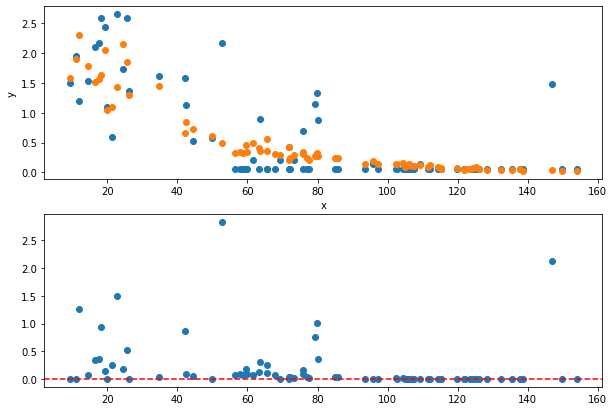

In [332]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xx[0], 10**yy)
p0, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination  = np.median(sampler.results['samples'][:1000], axis = 0)
yy_model = model_all(xx, p0, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
plt.scatter(xx[0], 10**yy_model)
#plt.xscale("log")
#plt.yscale("log")
plt.subplot(212)
#plt.scatter(xx[0], 10**yy - 10**yy_model)
plt.scatter(xx[0], (10**yy - 10**yy_model)**2)
plt.axhline(0, linestyle = "--", c = "r")

#### Sub sample fit

In [435]:
xx = np.array(isol_visu_high_alpha[["B_KPC"]])
xx = xx.T
yy = np.array(np.log10(isol_visu_high_alpha["REW_2796"]+0.05))

In [436]:
def model_b(X, p0, k_b):
    W = p0 + X[0]*k_b
    return W


def log_likelihood_b(params):
    # unpack the current parameters:
    p0, k_b = params

    # compute for each x point, where it should lie in y
    y_model = model_b(xx, p0=p0, k_b = k_b)
    # compute likelihood
    loglike = -0.5 * (((10**y_model - 10**yy))**2).sum()

    return loglike

def prior_transform_b(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -20 to +20
    params[0] = cube[0] * 2 - 1
    # b:
    params[1] = cube[1] * 0.2 - 0.1
    return params

In [437]:
parameters = ['p0', 'k_b']
sampler = ReactiveNestedSampler(parameters, log_likelihood_b, prior_transform_b)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]


DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-43758846564073042721374208.00, Lmax=-2.66


DEBUG:ultranest:iteration=80, ncalls=885, regioncalls=3400, ndraw=40, logz=-9103558505726997504.00, remainder_fraction=100.0000%, Lmin=-8901662571198729216.00, Lmax=-2.66


DEBUG:ultranest:iteration=160, ncalls=973, regioncalls=6920, ndraw=40, logz=-559213906289192.62, remainder_fraction=100.0000%, Lmin=-549501460051060.88, Lmax=-2.66


DEBUG:ultranest:iteration=179, ncalls=992, regioncalls=7680, ndraw=40, logz=-113382129408856.11, remainder_fraction=100.0000%, Lmin=-97639592006364.03, Lmax=-2.66


DEBUG:ultranest:iteration=240, ncalls=1058, regioncalls=10320, ndraw=40, logz=-94550036777.63, remainder_fraction=100.0000%, Lmin=-81126903094.46, Lmax=-2.66


DEBUG:ultranest:iteration=320, ncalls=1146, regioncalls=13840, ndraw=40, logz=-72780125.07, remainder_fraction=100.0000%, Lmin=-71136020.82, Lmax=-2.66


DEBUG:ultranest:iteration=358, ncalls=1191, regioncalls=15640, ndraw=40, logz=-3840468.41, remainder_fraction=100.0000%, Lmin=-3550661.83, Lmax=-2.66


DEBUG:ultranest:iteration=400, ncalls=1236, regioncalls=17440, ndraw=40, logz=-77150.49, remainder_fraction=100.0000%, Lmin=-72765.39, Lmax=-2.66


DEBUG:ultranest:iteration=480, ncalls=1327, regioncalls=21080, ndraw=40, logz=-203.09, remainder_fraction=100.0000%, Lmin=-186.69, Lmax=-2.66


DEBUG:ultranest:iteration=537, ncalls=1387, regioncalls=23480, ndraw=40, logz=-28.52, remainder_fraction=100.0000%, Lmin=-23.95, Lmax=-2.66


DEBUG:ultranest:iteration=560, ncalls=1412, regioncalls=24480, ndraw=40, logz=-27.64, remainder_fraction=100.0000%, Lmin=-23.91, Lmax=-2.66


DEBUG:ultranest:iteration=640, ncalls=1506, regioncalls=28240, ndraw=40, logz=-26.50, remainder_fraction=100.0000%, Lmin=-23.76, Lmax=-2.66


DEBUG:ultranest:iteration=716, ncalls=1595, regioncalls=31800, ndraw=40, logz=-25.97, remainder_fraction=100.0000%, Lmin=-23.54, Lmax=-2.66


DEBUG:ultranest:iteration=720, ncalls=1599, regioncalls=31960, ndraw=40, logz=-25.95, remainder_fraction=100.0000%, Lmin=-23.53, Lmax=-2.66


DEBUG:ultranest:iteration=800, ncalls=1691, regioncalls=35640, ndraw=40, logz=-25.54, remainder_fraction=100.0000%, Lmin=-23.24, Lmax=-2.66


DEBUG:ultranest:iteration=880, ncalls=1777, regioncalls=39080, ndraw=40, logz=-25.20, remainder_fraction=100.0000%, Lmin=-22.93, Lmax=-2.66


DEBUG:ultranest:iteration=895, ncalls=1793, regioncalls=39720, ndraw=40, logz=-25.14, remainder_fraction=100.0000%, Lmin=-22.86, Lmax=-2.66


DEBUG:ultranest:iteration=960, ncalls=1865, regioncalls=42600, ndraw=40, logz=-24.88, remainder_fraction=100.0000%, Lmin=-22.53, Lmax=-2.66


DEBUG:ultranest:iteration=1040, ncalls=1963, regioncalls=46520, ndraw=40, logz=-24.56, remainder_fraction=100.0000%, Lmin=-22.09, Lmax=-2.66


DEBUG:ultranest:iteration=1074, ncalls=2002, regioncalls=48080, ndraw=40, logz=-24.43, remainder_fraction=100.0000%, Lmin=-21.89, Lmax=-2.66


DEBUG:ultranest:iteration=1120, ncalls=2055, regioncalls=50200, ndraw=40, logz=-24.23, remainder_fraction=100.0000%, Lmin=-21.60, Lmax=-2.66


DEBUG:ultranest:iteration=1200, ncalls=2151, regioncalls=54040, ndraw=40, logz=-23.88, remainder_fraction=100.0000%, Lmin=-21.05, Lmax=-2.66


DEBUG:ultranest:iteration=1280, ncalls=2245, regioncalls=57800, ndraw=40, logz=-23.49, remainder_fraction=100.0000%, Lmin=-20.47, Lmax=-2.66


DEBUG:ultranest:iteration=1360, ncalls=2345, regioncalls=61800, ndraw=40, logz=-23.09, remainder_fraction=100.0000%, Lmin=-19.96, Lmax=-2.66


DEBUG:ultranest:iteration=1432, ncalls=2443, regioncalls=65720, ndraw=40, logz=-22.70, remainder_fraction=99.9999%, Lmin=-19.40, Lmax=-2.66


DEBUG:ultranest:iteration=1440, ncalls=2451, regioncalls=66040, ndraw=40, logz=-22.66, remainder_fraction=99.9999%, Lmin=-19.33, Lmax=-2.66


DEBUG:ultranest:iteration=1520, ncalls=2553, regioncalls=70120, ndraw=40, logz=-22.19, remainder_fraction=99.9999%, Lmin=-18.73, Lmax=-2.66


DEBUG:ultranest:iteration=1600, ncalls=2656, regioncalls=74240, ndraw=40, logz=-21.67, remainder_fraction=99.9999%, Lmin=-17.99, Lmax=-2.66


DEBUG:ultranest:iteration=1611, ncalls=2671, regioncalls=74840, ndraw=40, logz=-21.60, remainder_fraction=99.9999%, Lmin=-17.93, Lmax=-2.63


DEBUG:ultranest:iteration=1680, ncalls=2751, regioncalls=78040, ndraw=40, logz=-21.14, remainder_fraction=99.9998%, Lmin=-17.34, Lmax=-2.63


DEBUG:ultranest:iteration=1760, ncalls=2849, regioncalls=81960, ndraw=40, logz=-20.57, remainder_fraction=99.9996%, Lmin=-16.59, Lmax=-2.63


DEBUG:ultranest:iteration=1840, ncalls=2958, regioncalls=86320, ndraw=40, logz=-19.95, remainder_fraction=99.9993%, Lmin=-15.82, Lmax=-2.63


DEBUG:ultranest:iteration=1920, ncalls=3064, regioncalls=90560, ndraw=40, logz=-19.25, remainder_fraction=99.9985%, Lmin=-14.88, Lmax=-2.63


DEBUG:ultranest:iteration=1969, ncalls=3125, regioncalls=93000, ndraw=40, logz=-18.80, remainder_fraction=99.9977%, Lmin=-14.30, Lmax=-2.63


DEBUG:ultranest:iteration=2000, ncalls=3163, regioncalls=94520, ndraw=40, logz=-18.50, remainder_fraction=99.9969%, Lmin=-13.94, Lmax=-2.63


DEBUG:ultranest:iteration=2080, ncalls=3263, regioncalls=98600, ndraw=40, logz=-17.75, remainder_fraction=99.9934%, Lmin=-13.14, Lmax=-2.63


DEBUG:ultranest:iteration=2148, ncalls=3354, regioncalls=102240, ndraw=40, logz=-17.14, remainder_fraction=99.9880%, Lmin=-12.49, Lmax=-2.63


DEBUG:ultranest:iteration=2160, ncalls=3366, regioncalls=102760, ndraw=40, logz=-17.04, remainder_fraction=99.9868%, Lmin=-12.39, Lmax=-2.63


DEBUG:ultranest:iteration=2240, ncalls=3461, regioncalls=106560, ndraw=40, logz=-16.38, remainder_fraction=99.9742%, Lmin=-11.73, Lmax=-2.63


DEBUG:ultranest:iteration=2320, ncalls=3562, regioncalls=110600, ndraw=40, logz=-15.78, remainder_fraction=99.9561%, Lmin=-11.12, Lmax=-2.63


DEBUG:ultranest:iteration=2400, ncalls=3662, regioncalls=114600, ndraw=40, logz=-15.20, remainder_fraction=99.9196%, Lmin=-10.43, Lmax=-2.63


DEBUG:ultranest:iteration=2480, ncalls=3764, regioncalls=118680, ndraw=40, logz=-14.66, remainder_fraction=99.8626%, Lmin=-9.95, Lmax=-2.63


DEBUG:ultranest:iteration=2506, ncalls=3800, regioncalls=120120, ndraw=40, logz=-14.50, remainder_fraction=99.8356%, Lmin=-9.80, Lmax=-2.63


DEBUG:ultranest:iteration=2560, ncalls=3868, regioncalls=122920, ndraw=40, logz=-14.19, remainder_fraction=99.7744%, Lmin=-9.51, Lmax=-2.63


DEBUG:ultranest:iteration=2640, ncalls=3969, regioncalls=126960, ndraw=40, logz=-13.76, remainder_fraction=99.6435%, Lmin=-9.01, Lmax=-2.63


DEBUG:ultranest:iteration=2685, ncalls=4034, regioncalls=129560, ndraw=40, logz=-13.54, remainder_fraction=99.5574%, Lmin=-8.82, Lmax=-2.63


DEBUG:ultranest:iteration=2720, ncalls=4077, regioncalls=131400, ndraw=40, logz=-13.37, remainder_fraction=99.4692%, Lmin=-8.63, Lmax=-2.63


DEBUG:ultranest:iteration=2800, ncalls=4170, regioncalls=135120, ndraw=40, logz=-12.99, remainder_fraction=99.2263%, Lmin=-8.14, Lmax=-2.63


DEBUG:ultranest:iteration=2864, ncalls=4255, regioncalls=138520, ndraw=40, logz=-12.69, remainder_fraction=98.9928%, Lmin=-7.82, Lmax=-2.63


DEBUG:ultranest:iteration=2880, ncalls=4277, regioncalls=139440, ndraw=40, logz=-12.62, remainder_fraction=98.9168%, Lmin=-7.74, Lmax=-2.63


DEBUG:ultranest:iteration=2960, ncalls=4377, regioncalls=143440, ndraw=40, logz=-12.28, remainder_fraction=98.4679%, Lmin=-7.41, Lmax=-2.63


DEBUG:ultranest:iteration=3040, ncalls=4477, regioncalls=147440, ndraw=40, logz=-11.96, remainder_fraction=97.8972%, Lmin=-7.00, Lmax=-2.63


DEBUG:ultranest:iteration=3043, ncalls=4481, regioncalls=147600, ndraw=40, logz=-11.95, remainder_fraction=97.8738%, Lmin=-6.99, Lmax=-2.63


DEBUG:ultranest:iteration=3120, ncalls=4583, regioncalls=151720, ndraw=40, logz=-11.65, remainder_fraction=97.1779%, Lmin=-6.61, Lmax=-2.63


DEBUG:ultranest:iteration=3200, ncalls=4683, regioncalls=155720, ndraw=40, logz=-11.35, remainder_fraction=96.1946%, Lmin=-6.30, Lmax=-2.63


DEBUG:ultranest:iteration=3222, ncalls=4714, regioncalls=156960, ndraw=40, logz=-11.27, remainder_fraction=95.8747%, Lmin=-6.21, Lmax=-2.63


DEBUG:ultranest:iteration=3280, ncalls=4784, regioncalls=159800, ndraw=40, logz=-11.07, remainder_fraction=94.9180%, Lmin=-6.02, Lmax=-2.63


DEBUG:ultranest:iteration=3360, ncalls=4883, regioncalls=163760, ndraw=40, logz=-10.82, remainder_fraction=93.5554%, Lmin=-5.75, Lmax=-2.63


DEBUG:ultranest:iteration=3438, ncalls=4993, regioncalls=168160, ndraw=40, logz=-10.60, remainder_fraction=91.8788%, Lmin=-5.49, Lmax=-2.63


DEBUG:ultranest:iteration=3440, ncalls=4995, regioncalls=168240, ndraw=40, logz=-10.59, remainder_fraction=91.8254%, Lmin=-5.48, Lmax=-2.63


DEBUG:ultranest:iteration=3520, ncalls=5100, regioncalls=172440, ndraw=40, logz=-10.38, remainder_fraction=89.8129%, Lmin=-5.25, Lmax=-2.63


DEBUG:ultranest:iteration=3580, ncalls=5178, regioncalls=175560, ndraw=40, logz=-10.23, remainder_fraction=88.0910%, Lmin=-5.09, Lmax=-2.63


DEBUG:ultranest:iteration=3600, ncalls=5199, regioncalls=176440, ndraw=40, logz=-10.18, remainder_fraction=87.5618%, Lmin=-5.06, Lmax=-2.63


DEBUG:ultranest:iteration=3680, ncalls=5303, regioncalls=180600, ndraw=40, logz=-10.00, remainder_fraction=85.0808%, Lmin=-4.85, Lmax=-2.63


DEBUG:ultranest:iteration=3760, ncalls=5402, regioncalls=184560, ndraw=40, logz=-9.84, remainder_fraction=82.5515%, Lmin=-4.70, Lmax=-2.63


DEBUG:ultranest:iteration=3840, ncalls=5513, regioncalls=189000, ndraw=40, logz=-9.69, remainder_fraction=79.8970%, Lmin=-4.55, Lmax=-2.63


DEBUG:ultranest:iteration=3920, ncalls=5611, regioncalls=192920, ndraw=40, logz=-9.56, remainder_fraction=77.0023%, Lmin=-4.42, Lmax=-2.63


DEBUG:ultranest:iteration=3997, ncalls=5711, regioncalls=196920, ndraw=40, logz=-9.44, remainder_fraction=74.2103%, Lmin=-4.28, Lmax=-2.63


DEBUG:ultranest:iteration=4000, ncalls=5714, regioncalls=197040, ndraw=40, logz=-9.44, remainder_fraction=74.1131%, Lmin=-4.27, Lmax=-2.63


DEBUG:ultranest:iteration=4080, ncalls=5829, regioncalls=201640, ndraw=40, logz=-9.32, remainder_fraction=71.0576%, Lmin=-4.14, Lmax=-2.63


DEBUG:ultranest:iteration=4117, ncalls=5885, regioncalls=203960, ndraw=40, logz=-9.27, remainder_fraction=69.6447%, Lmin=-4.05, Lmax=-2.63


DEBUG:ultranest:iteration=4160, ncalls=5935, regioncalls=205960, ndraw=40, logz=-9.22, remainder_fraction=67.7560%, Lmin=-3.98, Lmax=-2.63


DEBUG:ultranest:iteration=4240, ncalls=6037, regioncalls=210040, ndraw=40, logz=-9.12, remainder_fraction=64.3683%, Lmin=-3.88, Lmax=-2.63


DEBUG:ultranest:iteration=4296, ncalls=6103, regioncalls=212720, ndraw=40, logz=-9.05, remainder_fraction=61.9742%, Lmin=-3.80, Lmax=-2.63


DEBUG:ultranest:iteration=4320, ncalls=6130, regioncalls=213800, ndraw=40, logz=-9.03, remainder_fraction=60.9870%, Lmin=-3.78, Lmax=-2.63


DEBUG:ultranest:iteration=4400, ncalls=6233, regioncalls=217920, ndraw=40, logz=-8.94, remainder_fraction=57.6281%, Lmin=-3.66, Lmax=-2.63


DEBUG:ultranest:iteration=4475, ncalls=6327, regioncalls=221720, ndraw=40, logz=-8.87, remainder_fraction=54.5484%, Lmin=-3.59, Lmax=-2.63


DEBUG:ultranest:iteration=4480, ncalls=6333, regioncalls=222000, ndraw=40, logz=-8.87, remainder_fraction=54.3512%, Lmin=-3.59, Lmax=-2.63


DEBUG:ultranest:iteration=4560, ncalls=6429, regioncalls=225840, ndraw=40, logz=-8.80, remainder_fraction=51.0275%, Lmin=-3.50, Lmax=-2.63


DEBUG:ultranest:iteration=4640, ncalls=6522, regioncalls=229560, ndraw=40, logz=-8.73, remainder_fraction=47.9614%, Lmin=-3.43, Lmax=-2.63


DEBUG:ultranest:iteration=4654, ncalls=6538, regioncalls=230240, ndraw=40, logz=-8.72, remainder_fraction=47.4195%, Lmin=-3.42, Lmax=-2.63


DEBUG:ultranest:iteration=4720, ncalls=6620, regioncalls=233560, ndraw=40, logz=-8.68, remainder_fraction=44.8032%, Lmin=-3.35, Lmax=-2.63


DEBUG:ultranest:iteration=4800, ncalls=6722, regioncalls=237640, ndraw=40, logz=-8.62, remainder_fraction=41.8081%, Lmin=-3.28, Lmax=-2.63


DEBUG:ultranest:iteration=4833, ncalls=6764, regioncalls=239400, ndraw=40, logz=-8.60, remainder_fraction=40.5512%, Lmin=-3.26, Lmax=-2.63


DEBUG:ultranest:iteration=4880, ncalls=6818, regioncalls=241640, ndraw=40, logz=-8.57, remainder_fraction=38.8681%, Lmin=-3.23, Lmax=-2.63


DEBUG:ultranest:iteration=4960, ncalls=6928, regioncalls=246040, ndraw=40, logz=-8.53, remainder_fraction=36.0406%, Lmin=-3.18, Lmax=-2.63


DEBUG:ultranest:iteration=5012, ncalls=6997, regioncalls=248840, ndraw=40, logz=-8.50, remainder_fraction=34.2732%, Lmin=-3.14, Lmax=-2.63


DEBUG:ultranest:iteration=5040, ncalls=7032, regioncalls=250240, ndraw=40, logz=-8.49, remainder_fraction=33.4110%, Lmin=-3.13, Lmax=-2.63


DEBUG:ultranest:iteration=5120, ncalls=7126, regioncalls=254000, ndraw=40, logz=-8.45, remainder_fraction=30.8874%, Lmin=-3.09, Lmax=-2.63


DEBUG:ultranest:iteration=5191, ncalls=7225, regioncalls=258000, ndraw=40, logz=-8.42, remainder_fraction=28.7771%, Lmin=-3.05, Lmax=-2.63


DEBUG:ultranest:iteration=5200, ncalls=7236, regioncalls=258440, ndraw=40, logz=-8.42, remainder_fraction=28.5199%, Lmin=-3.04, Lmax=-2.63


DEBUG:ultranest:iteration=5280, ncalls=7332, regioncalls=262280, ndraw=40, logz=-8.39, remainder_fraction=26.2612%, Lmin=-3.01, Lmax=-2.63


DEBUG:ultranest:iteration=5360, ncalls=7444, regioncalls=266760, ndraw=40, logz=-8.36, remainder_fraction=24.1555%, Lmin=-2.97, Lmax=-2.63


DEBUG:ultranest:iteration=5370, ncalls=7456, regioncalls=267280, ndraw=40, logz=-8.35, remainder_fraction=23.9168%, Lmin=-2.96, Lmax=-2.63


DEBUG:ultranest:iteration=5440, ncalls=7542, regioncalls=270760, ndraw=40, logz=-8.33, remainder_fraction=22.2113%, Lmin=-2.94, Lmax=-2.63


DEBUG:ultranest:iteration=5520, ncalls=7643, regioncalls=274800, ndraw=40, logz=-8.31, remainder_fraction=20.3749%, Lmin=-2.91, Lmax=-2.63


DEBUG:ultranest:iteration=5549, ncalls=7682, regioncalls=276480, ndraw=40, logz=-8.30, remainder_fraction=19.7544%, Lmin=-2.90, Lmax=-2.63


DEBUG:ultranest:iteration=5600, ncalls=7744, regioncalls=278960, ndraw=40, logz=-8.29, remainder_fraction=18.6866%, Lmin=-2.89, Lmax=-2.63


DEBUG:ultranest:iteration=5680, ncalls=7839, regioncalls=282760, ndraw=40, logz=-8.27, remainder_fraction=17.1224%, Lmin=-2.86, Lmax=-2.63


DEBUG:ultranest:iteration=5728, ncalls=7897, regioncalls=285120, ndraw=40, logz=-8.26, remainder_fraction=16.2320%, Lmin=-2.85, Lmax=-2.63


DEBUG:ultranest:iteration=5760, ncalls=7936, regioncalls=286680, ndraw=40, logz=-8.25, remainder_fraction=15.6527%, Lmin=-2.84, Lmax=-2.63


DEBUG:ultranest:iteration=5840, ncalls=8024, regioncalls=290200, ndraw=40, logz=-8.23, remainder_fraction=14.2947%, Lmin=-2.82, Lmax=-2.63


DEBUG:ultranest:iteration=5920, ncalls=8136, regioncalls=294680, ndraw=40, logz=-8.22, remainder_fraction=13.0530%, Lmin=-2.81, Lmax=-2.63


DEBUG:ultranest:iteration=6000, ncalls=8240, regioncalls=298840, ndraw=40, logz=-8.21, remainder_fraction=11.9070%, Lmin=-2.79, Lmax=-2.63


DEBUG:ultranest:iteration=6080, ncalls=8345, regioncalls=303040, ndraw=40, logz=-8.19, remainder_fraction=10.8466%, Lmin=-2.77, Lmax=-2.63


DEBUG:ultranest:iteration=6086, ncalls=8353, regioncalls=303400, ndraw=40, logz=-8.19, remainder_fraction=10.7701%, Lmin=-2.77, Lmax=-2.63


DEBUG:ultranest:iteration=6160, ncalls=8443, regioncalls=307000, ndraw=40, logz=-8.18, remainder_fraction=9.8827%, Lmin=-2.76, Lmax=-2.63


DEBUG:ultranest:iteration=6240, ncalls=8542, regioncalls=310960, ndraw=40, logz=-8.17, remainder_fraction=9.0007%, Lmin=-2.75, Lmax=-2.63


DEBUG:ultranest:iteration=6320, ncalls=8646, regioncalls=315120, ndraw=40, logz=-8.17, remainder_fraction=8.1902%, Lmin=-2.74, Lmax=-2.63


DEBUG:ultranest:iteration=6400, ncalls=8748, regioncalls=319200, ndraw=40, logz=-8.16, remainder_fraction=7.4482%, Lmin=-2.73, Lmax=-2.63


DEBUG:ultranest:iteration=6444, ncalls=8803, regioncalls=321440, ndraw=40, logz=-8.15, remainder_fraction=7.0693%, Lmin=-2.72, Lmax=-2.63


DEBUG:ultranest:iteration=6480, ncalls=8842, regioncalls=323000, ndraw=40, logz=-8.15, remainder_fraction=6.7737%, Lmin=-2.72, Lmax=-2.63


DEBUG:ultranest:iteration=6560, ncalls=8937, regioncalls=326800, ndraw=40, logz=-8.14, remainder_fraction=6.1538%, Lmin=-2.71, Lmax=-2.63


DEBUG:ultranest:iteration=6623, ncalls=9023, regioncalls=330280, ndraw=40, logz=-8.14, remainder_fraction=5.7050%, Lmin=-2.70, Lmax=-2.63


DEBUG:ultranest:iteration=6640, ncalls=9042, regioncalls=331040, ndraw=40, logz=-8.14, remainder_fraction=5.5894%, Lmin=-2.70, Lmax=-2.63


DEBUG:ultranest:iteration=6720, ncalls=9138, regioncalls=334880, ndraw=40, logz=-8.13, remainder_fraction=5.0741%, Lmin=-2.70, Lmax=-2.63


DEBUG:ultranest:iteration=6800, ncalls=9246, regioncalls=339200, ndraw=40, logz=-8.13, remainder_fraction=4.6054%, Lmin=-2.69, Lmax=-2.63


DEBUG:ultranest:iteration=6802, ncalls=9248, regioncalls=339320, ndraw=40, logz=-8.13, remainder_fraction=4.5943%, Lmin=-2.69, Lmax=-2.63


DEBUG:ultranest:iteration=6880, ncalls=9344, regioncalls=343160, ndraw=40, logz=-8.12, remainder_fraction=4.1789%, Lmin=-2.68, Lmax=-2.63


DEBUG:ultranest:iteration=6960, ncalls=9435, regioncalls=346800, ndraw=40, logz=-8.12, remainder_fraction=3.7902%, Lmin=-2.68, Lmax=-2.63


DEBUG:ultranest:iteration=7040, ncalls=9529, regioncalls=350560, ndraw=40, logz=-8.11, remainder_fraction=3.4377%, Lmin=-2.67, Lmax=-2.63


DEBUG:ultranest:iteration=7120, ncalls=9634, regioncalls=354760, ndraw=40, logz=-8.11, remainder_fraction=3.1180%, Lmin=-2.67, Lmax=-2.63


DEBUG:ultranest:iteration=7160, ncalls=9688, regioncalls=357000, ndraw=40, logz=-8.11, remainder_fraction=2.9688%, Lmin=-2.67, Lmax=-2.63


DEBUG:ultranest:iteration=7200, ncalls=9731, regioncalls=358760, ndraw=40, logz=-8.11, remainder_fraction=2.8268%, Lmin=-2.66, Lmax=-2.63


DEBUG:ultranest:iteration=7280, ncalls=9834, regioncalls=362880, ndraw=40, logz=-8.11, remainder_fraction=2.5625%, Lmin=-2.66, Lmax=-2.63


DEBUG:ultranest:iteration=7339, ncalls=9916, regioncalls=366200, ndraw=40, logz=-8.10, remainder_fraction=2.3834%, Lmin=-2.66, Lmax=-2.63


DEBUG:ultranest:iteration=7360, ncalls=9939, regioncalls=367120, ndraw=40, logz=-8.10, remainder_fraction=2.3226%, Lmin=-2.66, Lmax=-2.63


DEBUG:ultranest:iteration=7440, ncalls=10035, regioncalls=370960, ndraw=40, logz=-8.10, remainder_fraction=2.1047%, Lmin=-2.65, Lmax=-2.63


DEBUG:ultranest:iteration=7520, ncalls=10140, regioncalls=375160, ndraw=40, logz=-8.10, remainder_fraction=1.9068%, Lmin=-2.65, Lmax=-2.63


DEBUG:ultranest:iteration=7600, ncalls=10254, regioncalls=379720, ndraw=40, logz=-8.10, remainder_fraction=1.7271%, Lmin=-2.65, Lmax=-2.63


DEBUG:ultranest:iteration=7680, ncalls=10355, regioncalls=383760, ndraw=40, logz=-8.10, remainder_fraction=1.5641%, Lmin=-2.65, Lmax=-2.63


DEBUG:ultranest:iteration=7697, ncalls=10378, regioncalls=384800, ndraw=40, logz=-8.10, remainder_fraction=1.5315%, Lmin=-2.65, Lmax=-2.63


DEBUG:ultranest:iteration=7760, ncalls=10447, regioncalls=387560, ndraw=40, logz=-8.09, remainder_fraction=1.4166%, Lmin=-2.65, Lmax=-2.63


DEBUG:ultranest:iteration=7840, ncalls=10546, regioncalls=391520, ndraw=40, logz=-8.09, remainder_fraction=1.2828%, Lmin=-2.64, Lmax=-2.63


DEBUG:ultranest:iteration=7920, ncalls=10647, regioncalls=395560, ndraw=40, logz=-8.09, remainder_fraction=1.1617%, Lmin=-2.64, Lmax=-2.63


DEBUG:ultranest:iteration=8000, ncalls=10750, regioncalls=399680, ndraw=40, logz=-8.09, remainder_fraction=1.0519%, Lmin=-2.64, Lmax=-2.63


[ultranest] Explored until L=-3  


INFO:ultranest:Explored until L=-3  


[ultranest] Likelihood function evaluations: 10799


INFO:ultranest:Likelihood function evaluations: 10799
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -8.075 +- 0.06156


INFO:ultranest:  logZ = -8.075 +- 0.06156


[ultranest] Effective samples strategy satisfied (ESS = 3473.6, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 3473.6, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)


[ultranest]   logZ error budget: single: 0.07 bs:0.06 tail:0.01 total:0.06 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.07 bs:0.06 tail:0.01 total:0.06 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


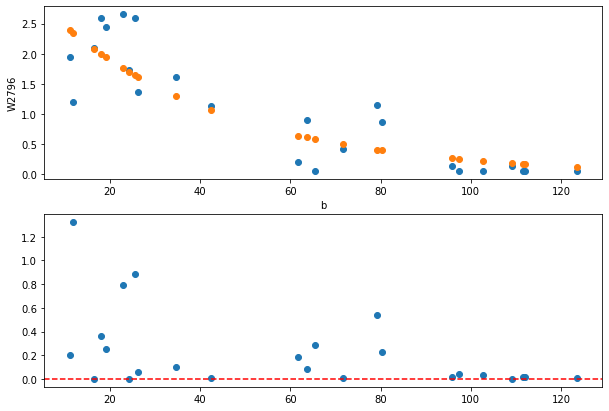

In [438]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('b')
plt.ylabel('W2796')
plt.scatter(xx[0], 10**yy)
p0, k_b  = np.median(sampler.results['samples'][:1000], axis = 0)
yy_model_higha = model_b(xx, p0=p0, k_b=k_b)
xx_higha = xx[0]
plt.scatter(xx[0], 10**yy_model_higha)
#plt.xscale("log")
#plt.yscale("log")
plt.subplot(212)
plt.scatter(xx[0], (10**yy - 10**yy_model_higha)**2)
plt.axhline(0, linestyle = "--", c = "r")

In [449]:
xx = np.array(isol_visu_low_alpha[["B_KPC"]])
xx = xx.T
yy = np.array(np.log10(isol_visu_low_alpha["REW_2796"]+0.05))

In [450]:
def model_b(X, p0, k_b):
    W = p0 + X[0]*k_b
    return W


def log_likelihood_b(params):
    # unpack the current parameters:
    p0, k_b = params

    # compute for each x point, where it should lie in y
    y_model = model_b(xx, p0=p0, k_b = k_b)
    # compute likelihood
    loglike = -np.sum(((10**y_model - 10**yy))**2)

    return loglike

def prior_transform_b(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -20 to +20
    params[0] = cube[0] * 2 - 1
    # b:
    params[1] = cube[1] * 0.2 - 0.1
    return params

In [451]:
parameters = ['p0', 'k_b']
sampler = ReactiveNestedSampler(parameters, log_likelihood_b, prior_transform_b)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=40)

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=40
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]


DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-43014126330757519575380907786240.00, Lmax=-1.47


DEBUG:ultranest:iteration=80, ncalls=881, regioncalls=3240, ndraw=40, logz=-13154553708534006617735168.00, remainder_fraction=100.0000%, Lmin=-11535987302720356543889408.00, Lmax=-1.47


DEBUG:ultranest:iteration=160, ncalls=968, regioncalls=6720, ndraw=40, logz=-25794388526823129088.00, remainder_fraction=100.0000%, Lmin=-20420090450612387840.00, Lmax=-1.47


DEBUG:ultranest:iteration=240, ncalls=1058, regioncalls=10320, ndraw=40, logz=-465996691328266.56, remainder_fraction=100.0000%, Lmin=-337687432226935.31, Lmax=-1.43


DEBUG:ultranest:iteration=320, ncalls=1143, regioncalls=13720, ndraw=40, logz=-157876558874.11, remainder_fraction=100.0000%, Lmin=-120647815580.67, Lmax=-1.43


DEBUG:ultranest:iteration=400, ncalls=1230, regioncalls=17200, ndraw=40, logz=-14021601.40, remainder_fraction=100.0000%, Lmin=-13751601.62, Lmax=-1.42


DEBUG:ultranest:iteration=480, ncalls=1321, regioncalls=20840, ndraw=40, logz=-15905.72, remainder_fraction=100.0000%, Lmin=-14632.63, Lmax=-1.40


DEBUG:ultranest:iteration=537, ncalls=1386, regioncalls=23440, ndraw=40, logz=-170.71, remainder_fraction=100.0000%, Lmin=-158.55, Lmax=-1.40


DEBUG:ultranest:iteration=560, ncalls=1412, regioncalls=24480, ndraw=40, logz=-53.48, remainder_fraction=100.0000%, Lmin=-43.52, Lmax=-1.40


DEBUG:ultranest:iteration=640, ncalls=1502, regioncalls=28080, ndraw=40, logz=-12.34, remainder_fraction=99.9391%, Lmin=-8.46, Lmax=-1.40


DEBUG:ultranest:iteration=716, ncalls=1586, regioncalls=31440, ndraw=40, logz=-11.22, remainder_fraction=99.8153%, Lmin=-8.37, Lmax=-1.40


DEBUG:ultranest:iteration=720, ncalls=1592, regioncalls=31680, ndraw=40, logz=-11.19, remainder_fraction=99.8079%, Lmin=-8.37, Lmax=-1.40


DEBUG:ultranest:iteration=800, ncalls=1686, regioncalls=35440, ndraw=40, logz=-10.67, remainder_fraction=99.6792%, Lmin=-8.26, Lmax=-1.40


DEBUG:ultranest:iteration=880, ncalls=1780, regioncalls=39200, ndraw=40, logz=-10.32, remainder_fraction=99.5519%, Lmin=-8.13, Lmax=-1.40


DEBUG:ultranest:iteration=895, ncalls=1797, regioncalls=39880, ndraw=40, logz=-10.26, remainder_fraction=99.5349%, Lmin=-8.09, Lmax=-1.40


DEBUG:ultranest:iteration=960, ncalls=1873, regioncalls=42920, ndraw=40, logz=-10.05, remainder_fraction=99.3990%, Lmin=-7.95, Lmax=-1.40


DEBUG:ultranest:iteration=1040, ncalls=1969, regioncalls=46760, ndraw=40, logz=-9.81, remainder_fraction=99.2393%, Lmin=-7.71, Lmax=-1.40


DEBUG:ultranest:iteration=1074, ncalls=2007, regioncalls=48280, ndraw=40, logz=-9.72, remainder_fraction=99.1566%, Lmin=-7.61, Lmax=-1.40


DEBUG:ultranest:iteration=1120, ncalls=2057, regioncalls=50280, ndraw=40, logz=-9.60, remainder_fraction=99.0518%, Lmin=-7.47, Lmax=-1.40


DEBUG:ultranest:iteration=1200, ncalls=2159, regioncalls=54360, ndraw=40, logz=-9.40, remainder_fraction=98.8542%, Lmin=-7.22, Lmax=-1.39


DEBUG:ultranest:iteration=1253, ncalls=2223, regioncalls=56920, ndraw=40, logz=-9.27, remainder_fraction=98.6960%, Lmin=-7.08, Lmax=-1.39


DEBUG:ultranest:iteration=1280, ncalls=2254, regioncalls=58160, ndraw=40, logz=-9.21, remainder_fraction=98.6065%, Lmin=-7.01, Lmax=-1.39


DEBUG:ultranest:iteration=1360, ncalls=2346, regioncalls=61840, ndraw=40, logz=-9.03, remainder_fraction=98.2864%, Lmin=-6.75, Lmax=-1.39


DEBUG:ultranest:iteration=1432, ncalls=2427, regioncalls=65080, ndraw=40, logz=-8.87, remainder_fraction=97.9591%, Lmin=-6.54, Lmax=-1.39


DEBUG:ultranest:iteration=1440, ncalls=2436, regioncalls=65440, ndraw=40, logz=-8.86, remainder_fraction=97.9230%, Lmin=-6.52, Lmax=-1.39


DEBUG:ultranest:iteration=1520, ncalls=2545, regioncalls=69800, ndraw=40, logz=-8.69, remainder_fraction=97.5525%, Lmin=-6.23, Lmax=-1.39


DEBUG:ultranest:iteration=1600, ncalls=2644, regioncalls=73760, ndraw=40, logz=-8.51, remainder_fraction=97.0783%, Lmin=-5.96, Lmax=-1.39


DEBUG:ultranest:iteration=1611, ncalls=2658, regioncalls=74320, ndraw=40, logz=-8.49, remainder_fraction=96.9952%, Lmin=-5.93, Lmax=-1.39


DEBUG:ultranest:iteration=1680, ncalls=2743, regioncalls=77720, ndraw=40, logz=-8.34, remainder_fraction=96.4921%, Lmin=-5.65, Lmax=-1.39


DEBUG:ultranest:iteration=1760, ncalls=2844, regioncalls=81760, ndraw=40, logz=-8.16, remainder_fraction=95.7411%, Lmin=-5.32, Lmax=-1.39


DEBUG:ultranest:iteration=1790, ncalls=2882, regioncalls=83280, ndraw=40, logz=-8.09, remainder_fraction=95.4369%, Lmin=-5.25, Lmax=-1.39


DEBUG:ultranest:iteration=1840, ncalls=2945, regioncalls=85840, ndraw=40, logz=-7.97, remainder_fraction=94.9117%, Lmin=-5.06, Lmax=-1.39


DEBUG:ultranest:iteration=1920, ncalls=3038, regioncalls=89560, ndraw=40, logz=-7.79, remainder_fraction=93.9141%, Lmin=-4.74, Lmax=-1.39


DEBUG:ultranest:iteration=2000, ncalls=3139, regioncalls=93600, ndraw=40, logz=-7.60, remainder_fraction=92.7136%, Lmin=-4.47, Lmax=-1.39


DEBUG:ultranest:iteration=2080, ncalls=3238, regioncalls=97560, ndraw=40, logz=-7.41, remainder_fraction=91.2052%, Lmin=-4.22, Lmax=-1.39


DEBUG:ultranest:iteration=2148, ncalls=3323, regioncalls=100960, ndraw=40, logz=-7.26, remainder_fraction=89.7658%, Lmin=-3.97, Lmax=-1.39


DEBUG:ultranest:iteration=2160, ncalls=3335, regioncalls=101440, ndraw=40, logz=-7.23, remainder_fraction=89.4846%, Lmin=-3.91, Lmax=-1.39


DEBUG:ultranest:iteration=2240, ncalls=3433, regioncalls=105480, ndraw=40, logz=-7.05, remainder_fraction=87.3932%, Lmin=-3.68, Lmax=-1.39


DEBUG:ultranest:iteration=2320, ncalls=3532, regioncalls=109440, ndraw=40, logz=-6.88, remainder_fraction=84.8111%, Lmin=-3.45, Lmax=-1.39


DEBUG:ultranest:iteration=2327, ncalls=3540, regioncalls=109760, ndraw=40, logz=-6.86, remainder_fraction=84.5685%, Lmin=-3.43, Lmax=-1.39


DEBUG:ultranest:iteration=2400, ncalls=3630, regioncalls=113400, ndraw=40, logz=-6.71, remainder_fraction=82.1224%, Lmin=-3.24, Lmax=-1.39


DEBUG:ultranest:iteration=2480, ncalls=3730, regioncalls=117400, ndraw=40, logz=-6.56, remainder_fraction=79.2765%, Lmin=-3.05, Lmax=-1.39


DEBUG:ultranest:iteration=2506, ncalls=3762, regioncalls=118680, ndraw=40, logz=-6.51, remainder_fraction=78.2970%, Lmin=-2.99, Lmax=-1.39


DEBUG:ultranest:iteration=2560, ncalls=3826, regioncalls=121360, ndraw=40, logz=-6.41, remainder_fraction=76.0779%, Lmin=-2.89, Lmax=-1.39


DEBUG:ultranest:iteration=2640, ncalls=3921, regioncalls=125160, ndraw=40, logz=-6.28, remainder_fraction=72.7790%, Lmin=-2.75, Lmax=-1.39


DEBUG:ultranest:iteration=2685, ncalls=3975, regioncalls=127320, ndraw=40, logz=-6.21, remainder_fraction=70.8040%, Lmin=-2.66, Lmax=-1.39


DEBUG:ultranest:iteration=2720, ncalls=4017, regioncalls=129040, ndraw=40, logz=-6.16, remainder_fraction=69.2920%, Lmin=-2.59, Lmax=-1.39


DEBUG:ultranest:iteration=2800, ncalls=4112, regioncalls=132840, ndraw=40, logz=-6.04, remainder_fraction=65.7549%, Lmin=-2.47, Lmax=-1.39


DEBUG:ultranest:iteration=2880, ncalls=4205, regioncalls=136560, ndraw=40, logz=-5.94, remainder_fraction=62.0015%, Lmin=-2.36, Lmax=-1.39


DEBUG:ultranest:iteration=2960, ncalls=4304, regioncalls=140520, ndraw=40, logz=-5.85, remainder_fraction=58.2014%, Lmin=-2.27, Lmax=-1.39


DEBUG:ultranest:iteration=3040, ncalls=4404, regioncalls=144520, ndraw=40, logz=-5.76, remainder_fraction=54.4547%, Lmin=-2.18, Lmax=-1.39


DEBUG:ultranest:iteration=3043, ncalls=4407, regioncalls=144640, ndraw=40, logz=-5.76, remainder_fraction=54.3043%, Lmin=-2.18, Lmax=-1.39


DEBUG:ultranest:iteration=3120, ncalls=4497, regioncalls=148400, ndraw=40, logz=-5.69, remainder_fraction=50.7688%, Lmin=-2.10, Lmax=-1.39


DEBUG:ultranest:iteration=3200, ncalls=4596, regioncalls=152360, ndraw=40, logz=-5.62, remainder_fraction=47.1649%, Lmin=-2.02, Lmax=-1.39


DEBUG:ultranest:iteration=3222, ncalls=4621, regioncalls=153360, ndraw=40, logz=-5.60, remainder_fraction=46.2172%, Lmin=-2.00, Lmax=-1.39


DEBUG:ultranest:iteration=3280, ncalls=4693, regioncalls=156280, ndraw=40, logz=-5.55, remainder_fraction=43.7411%, Lmin=-1.96, Lmax=-1.39


DEBUG:ultranest:iteration=3360, ncalls=4794, regioncalls=160320, ndraw=40, logz=-5.50, remainder_fraction=40.5119%, Lmin=-1.92, Lmax=-1.39


DEBUG:ultranest:iteration=3401, ncalls=4847, regioncalls=162440, ndraw=40, logz=-5.47, remainder_fraction=38.8550%, Lmin=-1.91, Lmax=-1.39


DEBUG:ultranest:iteration=3440, ncalls=4901, regioncalls=164640, ndraw=40, logz=-5.45, remainder_fraction=37.3534%, Lmin=-1.89, Lmax=-1.39


DEBUG:ultranest:iteration=3520, ncalls=5006, regioncalls=168840, ndraw=40, logz=-5.40, remainder_fraction=34.4889%, Lmin=-1.86, Lmax=-1.39


DEBUG:ultranest:iteration=3580, ncalls=5093, regioncalls=172320, ndraw=40, logz=-5.37, remainder_fraction=32.4704%, Lmin=-1.83, Lmax=-1.39


DEBUG:ultranest:iteration=3600, ncalls=5118, regioncalls=173360, ndraw=40, logz=-5.36, remainder_fraction=31.8184%, Lmin=-1.83, Lmax=-1.39


DEBUG:ultranest:iteration=3680, ncalls=5219, regioncalls=177400, ndraw=40, logz=-5.33, remainder_fraction=29.2742%, Lmin=-1.80, Lmax=-1.39


DEBUG:ultranest:iteration=3759, ncalls=5312, regioncalls=181120, ndraw=40, logz=-5.29, remainder_fraction=26.9555%, Lmin=-1.77, Lmax=-1.39


DEBUG:ultranest:iteration=3760, ncalls=5313, regioncalls=181200, ndraw=40, logz=-5.29, remainder_fraction=26.9240%, Lmin=-1.77, Lmax=-1.39


DEBUG:ultranest:iteration=3840, ncalls=5420, regioncalls=185480, ndraw=40, logz=-5.26, remainder_fraction=24.7443%, Lmin=-1.74, Lmax=-1.39


DEBUG:ultranest:iteration=3920, ncalls=5530, regioncalls=189880, ndraw=40, logz=-5.24, remainder_fraction=22.7379%, Lmin=-1.72, Lmax=-1.39


DEBUG:ultranest:iteration=3938, ncalls=5551, regioncalls=190720, ndraw=40, logz=-5.23, remainder_fraction=22.3119%, Lmin=-1.71, Lmax=-1.39


DEBUG:ultranest:iteration=4000, ncalls=5624, regioncalls=193680, ndraw=40, logz=-5.21, remainder_fraction=20.8905%, Lmin=-1.69, Lmax=-1.39


DEBUG:ultranest:iteration=4080, ncalls=5733, regioncalls=198040, ndraw=40, logz=-5.19, remainder_fraction=19.1279%, Lmin=-1.66, Lmax=-1.39


DEBUG:ultranest:iteration=4117, ncalls=5785, regioncalls=200200, ndraw=40, logz=-5.18, remainder_fraction=18.3752%, Lmin=-1.65, Lmax=-1.39


DEBUG:ultranest:iteration=4160, ncalls=5841, regioncalls=202440, ndraw=40, logz=-5.17, remainder_fraction=17.5232%, Lmin=-1.64, Lmax=-1.39


DEBUG:ultranest:iteration=4240, ncalls=5939, regioncalls=206360, ndraw=40, logz=-5.15, remainder_fraction=16.0347%, Lmin=-1.62, Lmax=-1.39


DEBUG:ultranest:iteration=4296, ncalls=6014, regioncalls=209440, ndraw=40, logz=-5.14, remainder_fraction=15.0687%, Lmin=-1.61, Lmax=-1.39


DEBUG:ultranest:iteration=4320, ncalls=6043, regioncalls=210600, ndraw=40, logz=-5.14, remainder_fraction=14.6689%, Lmin=-1.61, Lmax=-1.39


DEBUG:ultranest:iteration=4400, ncalls=6148, regioncalls=214800, ndraw=40, logz=-5.12, remainder_fraction=13.4028%, Lmin=-1.59, Lmax=-1.39


DEBUG:ultranest:iteration=4475, ncalls=6260, regioncalls=219280, ndraw=40, logz=-5.11, remainder_fraction=12.3109%, Lmin=-1.57, Lmax=-1.39


DEBUG:ultranest:iteration=4480, ncalls=6265, regioncalls=219560, ndraw=40, logz=-5.11, remainder_fraction=12.2421%, Lmin=-1.57, Lmax=-1.39


DEBUG:ultranest:iteration=4560, ncalls=6370, regioncalls=223760, ndraw=40, logz=-5.10, remainder_fraction=11.1703%, Lmin=-1.55, Lmax=-1.39


DEBUG:ultranest:iteration=4640, ncalls=6483, regioncalls=228280, ndraw=40, logz=-5.09, remainder_fraction=10.1844%, Lmin=-1.53, Lmax=-1.39


DEBUG:ultranest:iteration=4654, ncalls=6498, regioncalls=228880, ndraw=40, logz=-5.08, remainder_fraction=10.0220%, Lmin=-1.53, Lmax=-1.39


DEBUG:ultranest:iteration=4720, ncalls=6574, regioncalls=231960, ndraw=40, logz=-5.08, remainder_fraction=9.2836%, Lmin=-1.52, Lmax=-1.39


DEBUG:ultranest:iteration=4800, ncalls=6672, regioncalls=235880, ndraw=40, logz=-5.07, remainder_fraction=8.4532%, Lmin=-1.51, Lmax=-1.39


DEBUG:ultranest:iteration=4833, ncalls=6707, regioncalls=237320, ndraw=40, logz=-5.06, remainder_fraction=8.1317%, Lmin=-1.50, Lmax=-1.39


DEBUG:ultranest:iteration=4880, ncalls=6769, regioncalls=239800, ndraw=40, logz=-5.06, remainder_fraction=7.6944%, Lmin=-1.50, Lmax=-1.39


DEBUG:ultranest:iteration=4960, ncalls=6886, regioncalls=244480, ndraw=40, logz=-5.05, remainder_fraction=6.9944%, Lmin=-1.49, Lmax=-1.39


DEBUG:ultranest:iteration=5040, ncalls=6993, regioncalls=248760, ndraw=40, logz=-5.04, remainder_fraction=6.3539%, Lmin=-1.48, Lmax=-1.39


DEBUG:ultranest:iteration=5120, ncalls=7102, regioncalls=253120, ndraw=40, logz=-5.04, remainder_fraction=5.7745%, Lmin=-1.47, Lmax=-1.39


DEBUG:ultranest:iteration=5191, ncalls=7205, regioncalls=257240, ndraw=40, logz=-5.03, remainder_fraction=5.2991%, Lmin=-1.46, Lmax=-1.39


DEBUG:ultranest:iteration=5200, ncalls=7215, regioncalls=257680, ndraw=40, logz=-5.03, remainder_fraction=5.2424%, Lmin=-1.46, Lmax=-1.39


DEBUG:ultranest:iteration=5280, ncalls=7313, regioncalls=261640, ndraw=40, logz=-5.03, remainder_fraction=4.7599%, Lmin=-1.46, Lmax=-1.39


DEBUG:ultranest:iteration=5360, ncalls=7418, regioncalls=265840, ndraw=40, logz=-5.02, remainder_fraction=4.3226%, Lmin=-1.45, Lmax=-1.39


DEBUG:ultranest:iteration=5370, ncalls=7430, regioncalls=266360, ndraw=40, logz=-5.02, remainder_fraction=4.2707%, Lmin=-1.45, Lmax=-1.39


DEBUG:ultranest:iteration=5440, ncalls=7512, regioncalls=269720, ndraw=40, logz=-5.02, remainder_fraction=3.9229%, Lmin=-1.45, Lmax=-1.39


DEBUG:ultranest:iteration=5520, ncalls=7605, regioncalls=273440, ndraw=40, logz=-5.02, remainder_fraction=3.5600%, Lmin=-1.44, Lmax=-1.39


DEBUG:ultranest:iteration=5549, ncalls=7641, regioncalls=274960, ndraw=40, logz=-5.01, remainder_fraction=3.4357%, Lmin=-1.44, Lmax=-1.39


DEBUG:ultranest:iteration=5600, ncalls=7710, regioncalls=277720, ndraw=40, logz=-5.01, remainder_fraction=3.2285%, Lmin=-1.44, Lmax=-1.39


DEBUG:ultranest:iteration=5680, ncalls=7807, regioncalls=281600, ndraw=40, logz=-5.01, remainder_fraction=2.9281%, Lmin=-1.43, Lmax=-1.39


DEBUG:ultranest:iteration=5728, ncalls=7872, regioncalls=284240, ndraw=40, logz=-5.01, remainder_fraction=2.7612%, Lmin=-1.43, Lmax=-1.39


DEBUG:ultranest:iteration=5760, ncalls=7908, regioncalls=285680, ndraw=40, logz=-5.01, remainder_fraction=2.6552%, Lmin=-1.43, Lmax=-1.39


DEBUG:ultranest:iteration=5840, ncalls=8015, regioncalls=289960, ndraw=40, logz=-5.00, remainder_fraction=2.4071%, Lmin=-1.42, Lmax=-1.39


DEBUG:ultranest:iteration=5907, ncalls=8101, regioncalls=293440, ndraw=40, logz=-5.00, remainder_fraction=2.2171%, Lmin=-1.42, Lmax=-1.39


DEBUG:ultranest:iteration=5920, ncalls=8117, regioncalls=294080, ndraw=40, logz=-5.00, remainder_fraction=2.1820%, Lmin=-1.42, Lmax=-1.39


DEBUG:ultranest:iteration=6000, ncalls=8207, regioncalls=297680, ndraw=40, logz=-5.00, remainder_fraction=1.9770%, Lmin=-1.42, Lmax=-1.39


DEBUG:ultranest:iteration=6080, ncalls=8305, regioncalls=301600, ndraw=40, logz=-5.00, remainder_fraction=1.7916%, Lmin=-1.41, Lmax=-1.39


DEBUG:ultranest:iteration=6086, ncalls=8311, regioncalls=301880, ndraw=40, logz=-5.00, remainder_fraction=1.7784%, Lmin=-1.41, Lmax=-1.39


DEBUG:ultranest:iteration=6160, ncalls=8396, regioncalls=305280, ndraw=40, logz=-5.00, remainder_fraction=1.6233%, Lmin=-1.41, Lmax=-1.39


DEBUG:ultranest:iteration=6240, ncalls=8497, regioncalls=309320, ndraw=40, logz=-4.99, remainder_fraction=1.4707%, Lmin=-1.41, Lmax=-1.39


DEBUG:ultranest:iteration=6265, ncalls=8529, regioncalls=310640, ndraw=40, logz=-4.99, remainder_fraction=1.4260%, Lmin=-1.41, Lmax=-1.39


DEBUG:ultranest:iteration=6320, ncalls=8596, regioncalls=313320, ndraw=40, logz=-4.99, remainder_fraction=1.3323%, Lmin=-1.41, Lmax=-1.39


DEBUG:ultranest:iteration=6400, ncalls=8699, regioncalls=317440, ndraw=40, logz=-4.99, remainder_fraction=1.2067%, Lmin=-1.41, Lmax=-1.39


DEBUG:ultranest:iteration=6444, ncalls=8755, regioncalls=319720, ndraw=40, logz=-4.99, remainder_fraction=1.1428%, Lmin=-1.40, Lmax=-1.39


DEBUG:ultranest:iteration=6480, ncalls=8798, regioncalls=321440, ndraw=40, logz=-4.99, remainder_fraction=1.0929%, Lmin=-1.40, Lmax=-1.39


[ultranest] Explored until L=-1  


INFO:ultranest:Explored until L=-1  


[ultranest] Likelihood function evaluations: 8880


INFO:ultranest:Likelihood function evaluations: 8880
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -4.985 +- 0.04176


INFO:ultranest:  logZ = -4.985 +- 0.04176


[ultranest] Effective samples strategy satisfied (ESS = 3289.7, need >40)


INFO:ultranest:Effective samples strategy satisfied (ESS = 3289.7, need >40)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)


[ultranest]   logZ error budget: single: 0.06 bs:0.04 tail:0.01 total:0.04 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.06 bs:0.04 tail:0.01 total:0.04 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


In [464]:
result.get('maximum_likelihood')

{'logl': -1.3865780052210108,
 'point': [0.4713792724421042, -0.017164004410871875],
 'point_untransformed': [0.7356896362210521, 0.41417997794564065]}

1.3865780052210108


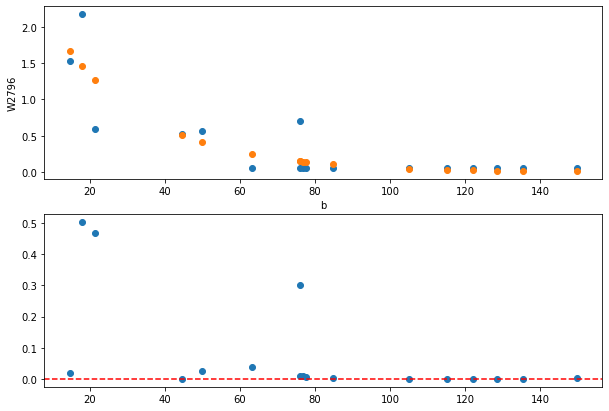

In [466]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('b')
plt.ylabel('W2796')
plt.scatter(xx[0], 10**yy)
p0, k_b  = np.median(sampler.results['samples'][:500], axis = 0)
yy_model_lowa = model_b(xx, p0=0.4713792724421042, k_b=-0.017164004410871875)
xx_lowa = xx[0]
plt.scatter(xx[0], 10**yy_model_lowa)
#plt.xscale("log")
#plt.yscale("log")
plt.subplot(212)
plt.scatter(xx[0], (10**yy - 10**yy_model_lowa)**2)
print(np.sum((10**yy - 10**yy_model_lowa)**2))
plt.axhline(0, linestyle = "--", c = "r")

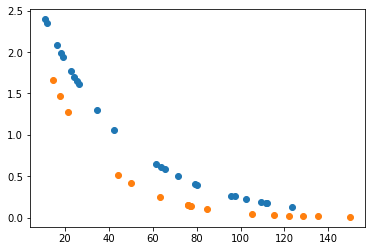

In [467]:
plt.scatter(xx_higha, 10**yy_model_higha)
plt.scatter(xx_lowa, 10**yy_model_lowa)
#plt.xscale("log")
#plt.yscale("log")
#plt.ylim(0.01, 5)

### Closest

In [300]:
sample = closest_9_snr3_good_runs_rot[closest_9_snr3_good_runs_rot["B_KPC"]<150]
xx = np.array(sample[["B_KPC", "sed_logMass", "Z", "logSFR", "alpha", "inclination"]])
xx = xx.T
yy = np.array(np.log10(sample["REW_2796"]+0.05))

In [301]:
parameters = ['p0', 'k_b', 'k_M', 'k_z', 'k_sfr', 'k_alpha', 'k_inclination']
sampler = ReactiveNestedSampler(parameters, log_likelihood_all, prior_transform_all)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=7+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]


DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-14377188.59, Lmax=-4300.38


DEBUG:ultranest:iteration=73, ncalls=878, regioncalls=3120, ndraw=40, logz=-7687207.07, remainder_fraction=100.0000%, Lmin=-7679701.39, Lmax=-4300.38


DEBUG:ultranest:iteration=80, ncalls=885, regioncalls=3400, ndraw=40, logz=-7467185.30, remainder_fraction=100.0000%, Lmin=-7448734.81, Lmax=-4300.38


DEBUG:ultranest:iteration=160, ncalls=983, regioncalls=7320, ndraw=40, logz=-5059902.89, remainder_fraction=100.0000%, Lmin=-5035893.39, Lmax=-4300.38


DEBUG:ultranest:iteration=179, ncalls=1004, regioncalls=8160, ndraw=40, logz=-4687937.47, remainder_fraction=100.0000%, Lmin=-4678593.10, Lmax=-4300.38


DEBUG:ultranest:iteration=240, ncalls=1092, regioncalls=11680, ndraw=40, logz=-4025751.14, remainder_fraction=100.0000%, Lmin=-4006933.94, Lmax=-4300.38


DEBUG:ultranest:iteration=320, ncalls=1219, regioncalls=16760, ndraw=40, logz=-3177898.90, remainder_fraction=100.0000%, Lmin=-3158614.12, Lmax=-4300.38


DEBUG:ultranest:iteration=358, ncalls=1288, regioncalls=19520, ndraw=40, logz=-2890227.28, remainder_fraction=100.0000%, Lmin=-2874165.98, Lmax=-4300.38


DEBUG:ultranest:iteration=400, ncalls=1344, regioncalls=21760, ndraw=40, logz=-2657985.16, remainder_fraction=100.0000%, Lmin=-2654475.07, Lmax=-4300.38


DEBUG:ultranest:iteration=480, ncalls=1461, regioncalls=26440, ndraw=40, logz=-2247389.84, remainder_fraction=100.0000%, Lmin=-2243431.72, Lmax=-4300.38


DEBUG:ultranest:iteration=537, ncalls=1561, regioncalls=30440, ndraw=40, logz=-2004629.75, remainder_fraction=100.0000%, Lmin=-1996810.21, Lmax=-4300.38


DEBUG:ultranest:iteration=560, ncalls=1600, regioncalls=32000, ndraw=40, logz=-1922537.22, remainder_fraction=100.0000%, Lmin=-1915349.45, Lmax=-4300.38


DEBUG:ultranest:iteration=640, ncalls=1756, regioncalls=38240, ndraw=40, logz=-1605137.49, remainder_fraction=100.0000%, Lmin=-1604973.47, Lmax=-4300.38


DEBUG:ultranest:iteration=716, ncalls=1899, regioncalls=43960, ndraw=40, logz=-1384334.00, remainder_fraction=100.0000%, Lmin=-1383254.37, Lmax=-4300.38


DEBUG:ultranest:iteration=720, ncalls=1904, regioncalls=44160, ndraw=40, logz=-1374380.76, remainder_fraction=100.0000%, Lmin=-1372368.70, Lmax=-4300.38


DEBUG:ultranest:iteration=800, ncalls=2054, regioncalls=50160, ndraw=40, logz=-1208299.98, remainder_fraction=100.0000%, Lmin=-1206438.64, Lmax=-4300.38


DEBUG:ultranest:iteration=880, ncalls=2214, regioncalls=56560, ndraw=40, logz=-1078748.63, remainder_fraction=100.0000%, Lmin=-1077890.87, Lmax=-4300.38


DEBUG:ultranest:iteration=925, ncalls=2314, regioncalls=60560, ndraw=40, logz=-1009145.32, remainder_fraction=100.0000%, Lmin=-1006960.82, Lmax=-4300.38


DEBUG:ultranest:iteration=960, ncalls=2391, regioncalls=63640, ndraw=40, logz=-975142.84, remainder_fraction=100.0000%, Lmin=-973901.87, Lmax=-4300.38


DEBUG:ultranest:iteration=1040, ncalls=2570, regioncalls=70800, ndraw=40, logz=-873163.74, remainder_fraction=100.0000%, Lmin=-873047.98, Lmax=-4300.38


DEBUG:ultranest:iteration=1074, ncalls=2654, regioncalls=74160, ndraw=40, logz=-837789.16, remainder_fraction=100.0000%, Lmin=-835221.86, Lmax=-4300.38


DEBUG:ultranest:iteration=1120, ncalls=2748, regioncalls=77920, ndraw=40, logz=-789593.48, remainder_fraction=100.0000%, Lmin=-789578.47, Lmax=-4300.38


DEBUG:ultranest:iteration=1200, ncalls=2917, regioncalls=84680, ndraw=40, logz=-722339.48, remainder_fraction=100.0000%, Lmin=-721684.99, Lmax=-4300.38


DEBUG:ultranest:iteration=1253, ncalls=3032, regioncalls=89280, ndraw=40, logz=-683807.01, remainder_fraction=100.0000%, Lmin=-683194.72, Lmax=-4300.38


DEBUG:ultranest:iteration=1280, ncalls=3104, regioncalls=92160, ndraw=40, logz=-665432.51, remainder_fraction=100.0000%, Lmin=-664328.74, Lmax=-4300.38


DEBUG:ultranest:iteration=1360, ncalls=3313, regioncalls=100520, ndraw=40, logz=-596918.32, remainder_fraction=100.0000%, Lmin=-594884.21, Lmax=-4300.38


DEBUG:ultranest:iteration=1432, ncalls=3516, regioncalls=108640, ndraw=40, logz=-549497.36, remainder_fraction=100.0000%, Lmin=-549428.33, Lmax=-4300.38


DEBUG:ultranest:iteration=1440, ncalls=3538, regioncalls=109520, ndraw=40, logz=-545978.67, remainder_fraction=100.0000%, Lmin=-545806.05, Lmax=-4300.38


DEBUG:ultranest:iteration=1520, ncalls=3754, regioncalls=118160, ndraw=40, logz=-497319.86, remainder_fraction=100.0000%, Lmin=-497276.95, Lmax=-4300.38


DEBUG:ultranest:iteration=1600, ncalls=3965, regioncalls=126600, ndraw=40, logz=-458847.14, remainder_fraction=100.0000%, Lmin=-458365.90, Lmax=-4300.38


DEBUG:ultranest:iteration=1642, ncalls=4098, regioncalls=131920, ndraw=40, logz=-435915.32, remainder_fraction=100.0000%, Lmin=-434880.42, Lmax=-4300.38


DEBUG:ultranest:iteration=1680, ncalls=4207, regioncalls=136280, ndraw=40, logz=-421135.08, remainder_fraction=100.0000%, Lmin=-420589.52, Lmax=-4300.38


DEBUG:ultranest:iteration=1760, ncalls=4421, regioncalls=144840, ndraw=40, logz=-381264.89, remainder_fraction=100.0000%, Lmin=-381023.56, Lmax=-4300.38


DEBUG:ultranest:iteration=1790, ncalls=4538, regioncalls=149520, ndraw=40, logz=-366888.47, remainder_fraction=100.0000%, Lmin=-366649.03, Lmax=-4300.38


DEBUG:ultranest:iteration=1840, ncalls=4657, regioncalls=154280, ndraw=40, logz=-347220.95, remainder_fraction=100.0000%, Lmin=-345812.50, Lmax=-4300.38


DEBUG:ultranest:iteration=1920, ncalls=4878, regioncalls=163120, ndraw=40, logz=-307861.07, remainder_fraction=100.0000%, Lmin=-307649.56, Lmax=-4300.38


DEBUG:ultranest:iteration=1969, ncalls=5044, regioncalls=169760, ndraw=40, logz=-287658.84, remainder_fraction=100.0000%, Lmin=-287567.74, Lmax=-4300.38


DEBUG:ultranest:iteration=2000, ncalls=5125, regioncalls=173000, ndraw=40, logz=-274282.28, remainder_fraction=100.0000%, Lmin=-273955.43, Lmax=-4300.38


DEBUG:ultranest:iteration=2080, ncalls=5370, regioncalls=182800, ndraw=40, logz=-246129.37, remainder_fraction=100.0000%, Lmin=-245998.31, Lmax=-4300.38


DEBUG:ultranest:iteration=2148, ncalls=5628, regioncalls=193120, ndraw=40, logz=-225590.64, remainder_fraction=100.0000%, Lmin=-225090.44, Lmax=-4300.38


DEBUG:ultranest:iteration=2160, ncalls=5658, regioncalls=194320, ndraw=40, logz=-222962.27, remainder_fraction=100.0000%, Lmin=-222803.32, Lmax=-4300.38


DEBUG:ultranest:iteration=2240, ncalls=5925, regioncalls=205000, ndraw=40, logz=-203794.98, remainder_fraction=100.0000%, Lmin=-203743.69, Lmax=-4300.38


DEBUG:ultranest:iteration=2320, ncalls=6180, regioncalls=215200, ndraw=40, logz=-187440.01, remainder_fraction=100.0000%, Lmin=-187132.90, Lmax=-4300.38


DEBUG:ultranest:iteration=2327, ncalls=6200, regioncalls=216000, ndraw=40, logz=-185731.58, remainder_fraction=100.0000%, Lmin=-185602.58, Lmax=-4300.38


DEBUG:ultranest:iteration=2400, ncalls=6399, regioncalls=223960, ndraw=40, logz=-171809.07, remainder_fraction=100.0000%, Lmin=-171726.64, Lmax=-1736.98


DEBUG:ultranest:iteration=2480, ncalls=6648, regioncalls=234040, ndraw=40, logz=-157935.14, remainder_fraction=100.0000%, Lmin=-157763.80, Lmax=-1736.98


DEBUG:ultranest:iteration=2506, ncalls=6719, regioncalls=236880, ndraw=40, logz=-152412.25, remainder_fraction=100.0000%, Lmin=-152233.82, Lmax=-1736.98


DEBUG:ultranest:iteration=2560, ncalls=6871, regioncalls=242960, ndraw=40, logz=-143664.16, remainder_fraction=100.0000%, Lmin=-143610.71, Lmax=-1736.98


DEBUG:ultranest:iteration=2640, ncalls=7085, regioncalls=251680, ndraw=40, logz=-132356.35, remainder_fraction=100.0000%, Lmin=-132334.85, Lmax=-1736.98


DEBUG:ultranest:iteration=2685, ncalls=7240, regioncalls=257880, ndraw=40, logz=-125723.79, remainder_fraction=100.0000%, Lmin=-125648.40, Lmax=-1736.98


DEBUG:ultranest:iteration=2720, ncalls=7328, regioncalls=261680, ndraw=40, logz=-120296.22, remainder_fraction=100.0000%, Lmin=-120279.95, Lmax=-1736.98


DEBUG:ultranest:iteration=2796, ncalls=7559, regioncalls=270920, ndraw=40, logz=-109496.69, remainder_fraction=100.0000%, Lmin=-109454.63, Lmax=-1736.98


DEBUG:ultranest:iteration=2800, ncalls=7568, regioncalls=271280, ndraw=40, logz=-109129.46, remainder_fraction=100.0000%, Lmin=-109118.32, Lmax=-1736.98


DEBUG:ultranest:iteration=2864, ncalls=7811, regioncalls=281000, ndraw=40, logz=-103405.39, remainder_fraction=100.0000%, Lmin=-103393.33, Lmax=-1736.98


DEBUG:ultranest:iteration=2880, ncalls=7844, regioncalls=282320, ndraw=40, logz=-101675.18, remainder_fraction=100.0000%, Lmin=-101567.77, Lmax=-1736.98


DEBUG:ultranest:iteration=2954, ncalls=8085, regioncalls=291960, ndraw=40, logz=-94503.31, remainder_fraction=100.0000%, Lmin=-94485.95, Lmax=-1736.98


DEBUG:ultranest:iteration=2960, ncalls=8101, regioncalls=292600, ndraw=40, logz=-94237.73, remainder_fraction=100.0000%, Lmin=-94224.38, Lmax=-1736.98


DEBUG:ultranest:iteration=3033, ncalls=8378, regioncalls=304040, ndraw=40, logz=-88948.00, remainder_fraction=100.0000%, Lmin=-88901.04, Lmax=-1736.98


DEBUG:ultranest:iteration=3040, ncalls=8413, regioncalls=305440, ndraw=40, logz=-88057.20, remainder_fraction=100.0000%, Lmin=-88028.84, Lmax=-1736.98


DEBUG:ultranest:iteration=3043, ncalls=8427, regioncalls=306000, ndraw=40, logz=-87956.97, remainder_fraction=100.0000%, Lmin=-87902.13, Lmax=-1736.98


DEBUG:ultranest:iteration=3114, ncalls=8671, regioncalls=316280, ndraw=40, logz=-82615.65, remainder_fraction=100.0000%, Lmin=-82582.25, Lmax=-1736.98


DEBUG:ultranest:iteration=3120, ncalls=8687, regioncalls=316920, ndraw=40, logz=-82085.91, remainder_fraction=100.0000%, Lmin=-82074.53, Lmax=-1736.98


DEBUG:ultranest:iteration=3196, ncalls=8960, regioncalls=327840, ndraw=40, logz=-75497.26, remainder_fraction=100.0000%, Lmin=-75446.04, Lmax=-1736.98


DEBUG:ultranest:iteration=3200, ncalls=8977, regioncalls=328520, ndraw=40, logz=-75296.85, remainder_fraction=100.0000%, Lmin=-75282.60, Lmax=-1736.98


DEBUG:ultranest:iteration=3222, ncalls=9051, regioncalls=331640, ndraw=40, logz=-73723.97, remainder_fraction=100.0000%, Lmin=-73693.42, Lmax=-1736.98


DEBUG:ultranest:iteration=3280, ncalls=9206, regioncalls=337840, ndraw=40, logz=-70074.80, remainder_fraction=100.0000%, Lmin=-69902.04, Lmax=-1736.98


DEBUG:ultranest:iteration=3360, ncalls=9388, regioncalls=345120, ndraw=40, logz=-65263.94, remainder_fraction=100.0000%, Lmin=-65216.34, Lmax=-1736.98


DEBUG:ultranest:iteration=3402, ncalls=9511, regioncalls=350040, ndraw=40, logz=-62284.91, remainder_fraction=100.0000%, Lmin=-62246.81, Lmax=-1736.98


DEBUG:ultranest:iteration=3440, ncalls=9652, regioncalls=355680, ndraw=40, logz=-59744.42, remainder_fraction=100.0000%, Lmin=-59685.66, Lmax=-1736.98


DEBUG:ultranest:iteration=3520, ncalls=9880, regioncalls=364800, ndraw=40, logz=-56002.43, remainder_fraction=100.0000%, Lmin=-55952.36, Lmax=-1736.98


DEBUG:ultranest:iteration=3580, ncalls=10110, regioncalls=374000, ndraw=40, logz=-52356.60, remainder_fraction=100.0000%, Lmin=-52322.65, Lmax=-1736.98


DEBUG:ultranest:iteration=3600, ncalls=10179, regioncalls=376760, ndraw=40, logz=-51391.06, remainder_fraction=100.0000%, Lmin=-51250.50, Lmax=-1736.98


DEBUG:ultranest:iteration=3673, ncalls=10447, regioncalls=387480, ndraw=40, logz=-47462.13, remainder_fraction=100.0000%, Lmin=-47424.24, Lmax=-1736.98


DEBUG:ultranest:iteration=3680, ncalls=10475, regioncalls=388600, ndraw=40, logz=-47261.84, remainder_fraction=100.0000%, Lmin=-47234.52, Lmax=-1736.98


DEBUG:ultranest:iteration=3757, ncalls=10742, regioncalls=399280, ndraw=40, logz=-43891.91, remainder_fraction=100.0000%, Lmin=-43801.80, Lmax=-1444.98


DEBUG:ultranest:iteration=3759, ncalls=10750, regioncalls=399800, ndraw=40, logz=-43780.47, remainder_fraction=100.0000%, Lmin=-43746.40, Lmax=-1444.98


DEBUG:ultranest:iteration=3760, ncalls=10751, regioncalls=399840, ndraw=40, logz=-43757.79, remainder_fraction=100.0000%, Lmin=-43730.75, Lmax=-1444.98


DEBUG:ultranest:iteration=3836, ncalls=10987, regioncalls=409360, ndraw=40, logz=-41191.62, remainder_fraction=100.0000%, Lmin=-41166.08, Lmax=-1444.98


DEBUG:ultranest:iteration=3840, ncalls=11002, regioncalls=409960, ndraw=40, logz=-41118.10, remainder_fraction=100.0000%, Lmin=-41104.93, Lmax=-1444.98


DEBUG:ultranest:iteration=3916, ncalls=11267, regioncalls=420560, ndraw=40, logz=-37917.90, remainder_fraction=100.0000%, Lmin=-37897.44, Lmax=-1444.98


DEBUG:ultranest:iteration=3920, ncalls=11279, regioncalls=421040, ndraw=40, logz=-37785.01, remainder_fraction=100.0000%, Lmin=-37682.94, Lmax=-1444.98


DEBUG:ultranest:iteration=3958, ncalls=11432, regioncalls=427160, ndraw=40, logz=-36287.76, remainder_fraction=100.0000%, Lmin=-36228.77, Lmax=-1444.98


DEBUG:ultranest:iteration=4000, ncalls=11563, regioncalls=432400, ndraw=40, logz=-35042.86, remainder_fraction=100.0000%, Lmin=-35028.04, Lmax=-1444.98


DEBUG:ultranest:iteration=4076, ncalls=11830, regioncalls=443080, ndraw=40, logz=-33021.60, remainder_fraction=100.0000%, Lmin=-32901.08, Lmax=-1444.98


DEBUG:ultranest:iteration=4080, ncalls=11845, regioncalls=443680, ndraw=40, logz=-32830.88, remainder_fraction=100.0000%, Lmin=-32741.92, Lmax=-1444.98


DEBUG:ultranest:iteration=4117, ncalls=11985, regioncalls=449320, ndraw=40, logz=-31859.77, remainder_fraction=100.0000%, Lmin=-31833.22, Lmax=-1444.98


DEBUG:ultranest:iteration=4160, ncalls=12093, regioncalls=453640, ndraw=40, logz=-30160.46, remainder_fraction=100.0000%, Lmin=-30148.06, Lmax=-1444.98


DEBUG:ultranest:iteration=4237, ncalls=12340, regioncalls=463520, ndraw=40, logz=-28363.72, remainder_fraction=100.0000%, Lmin=-28342.39, Lmax=-1444.98


DEBUG:ultranest:iteration=4240, ncalls=12353, regioncalls=464040, ndraw=40, logz=-28334.21, remainder_fraction=100.0000%, Lmin=-28315.26, Lmax=-1444.98


DEBUG:ultranest:iteration=4296, ncalls=12552, regioncalls=472080, ndraw=40, logz=-27233.19, remainder_fraction=100.0000%, Lmin=-27221.07, Lmax=-1444.98


DEBUG:ultranest:iteration=4320, ncalls=12636, regioncalls=475440, ndraw=40, logz=-26722.11, remainder_fraction=100.0000%, Lmin=-26682.41, Lmax=-1444.98


DEBUG:ultranest:iteration=4397, ncalls=12867, regioncalls=484680, ndraw=40, logz=-25004.60, remainder_fraction=100.0000%, Lmin=-24984.75, Lmax=-1444.98


DEBUG:ultranest:iteration=4400, ncalls=12879, regioncalls=485160, ndraw=40, logz=-24931.85, remainder_fraction=100.0000%, Lmin=-24901.11, Lmax=-1444.98


DEBUG:ultranest:iteration=4475, ncalls=13112, regioncalls=494480, ndraw=40, logz=-23550.06, remainder_fraction=100.0000%, Lmin=-23507.36, Lmax=-930.23


DEBUG:ultranest:iteration=4480, ncalls=13128, regioncalls=495120, ndraw=40, logz=-23487.15, remainder_fraction=100.0000%, Lmin=-23463.13, Lmax=-930.23


DEBUG:ultranest:iteration=4554, ncalls=13376, regioncalls=505040, ndraw=40, logz=-22366.10, remainder_fraction=100.0000%, Lmin=-22340.41, Lmax=-930.23


DEBUG:ultranest:iteration=4560, ncalls=13396, regioncalls=505840, ndraw=40, logz=-22305.89, remainder_fraction=100.0000%, Lmin=-22287.43, Lmax=-930.23


DEBUG:ultranest:iteration=4635, ncalls=13663, regioncalls=516520, ndraw=40, logz=-20986.22, remainder_fraction=100.0000%, Lmin=-20950.56, Lmax=-930.23


DEBUG:ultranest:iteration=4640, ncalls=13711, regioncalls=518440, ndraw=40, logz=-20935.40, remainder_fraction=100.0000%, Lmin=-20889.75, Lmax=-930.23


DEBUG:ultranest:iteration=4654, ncalls=13743, regioncalls=519760, ndraw=40, logz=-20686.67, remainder_fraction=100.0000%, Lmin=-20652.43, Lmax=-930.23


DEBUG:ultranest:iteration=4720, ncalls=13915, regioncalls=526720, ndraw=40, logz=-19578.12, remainder_fraction=100.0000%, Lmin=-19541.10, Lmax=-930.23


DEBUG:ultranest:iteration=4796, ncalls=14165, regioncalls=536720, ndraw=40, logz=-18449.78, remainder_fraction=100.0000%, Lmin=-18410.02, Lmax=-930.23


DEBUG:ultranest:iteration=4800, ncalls=14199, regioncalls=538080, ndraw=40, logz=-18339.56, remainder_fraction=100.0000%, Lmin=-18298.95, Lmax=-930.23


DEBUG:ultranest:iteration=4833, ncalls=14329, regioncalls=543320, ndraw=40, logz=-17844.82, remainder_fraction=100.0000%, Lmin=-17822.17, Lmax=-930.23


DEBUG:ultranest:iteration=4880, ncalls=14458, regioncalls=548480, ndraw=40, logz=-17331.27, remainder_fraction=100.0000%, Lmin=-17317.11, Lmax=-930.23


DEBUG:ultranest:iteration=4950, ncalls=14721, regioncalls=559000, ndraw=40, logz=-16571.24, remainder_fraction=100.0000%, Lmin=-16544.13, Lmax=-930.23


DEBUG:ultranest:iteration=4960, ncalls=14752, regioncalls=560240, ndraw=40, logz=-16479.25, remainder_fraction=100.0000%, Lmin=-16421.03, Lmax=-930.23


DEBUG:ultranest:iteration=5012, ncalls=14944, regioncalls=568000, ndraw=40, logz=-15909.26, remainder_fraction=100.0000%, Lmin=-15878.64, Lmax=-930.23


DEBUG:ultranest:iteration=5040, ncalls=15051, regioncalls=572360, ndraw=40, logz=-15623.21, remainder_fraction=100.0000%, Lmin=-15607.30, Lmax=-930.23


DEBUG:ultranest:iteration=5107, ncalls=15330, regioncalls=583520, ndraw=40, logz=-14774.38, remainder_fraction=100.0000%, Lmin=-14759.84, Lmax=-930.23


DEBUG:ultranest:iteration=5120, ncalls=15372, regioncalls=585200, ndraw=40, logz=-14650.69, remainder_fraction=100.0000%, Lmin=-14627.54, Lmax=-872.09


DEBUG:ultranest:iteration=5191, ncalls=15648, regioncalls=596240, ndraw=40, logz=-13944.48, remainder_fraction=100.0000%, Lmin=-13928.74, Lmax=-872.09


DEBUG:ultranest:iteration=5200, ncalls=15705, regioncalls=598520, ndraw=40, logz=-13886.83, remainder_fraction=100.0000%, Lmin=-13869.31, Lmax=-872.09


DEBUG:ultranest:iteration=5262, ncalls=16003, regioncalls=610440, ndraw=40, logz=-13257.58, remainder_fraction=100.0000%, Lmin=-13242.04, Lmax=-872.09


DEBUG:ultranest:iteration=5280, ncalls=16095, regioncalls=614120, ndraw=40, logz=-13080.39, remainder_fraction=100.0000%, Lmin=-13065.81, Lmax=-872.09


DEBUG:ultranest:iteration=5346, ncalls=16393, regioncalls=626040, ndraw=40, logz=-12352.10, remainder_fraction=100.0000%, Lmin=-12332.25, Lmax=-872.09


DEBUG:ultranest:iteration=5360, ncalls=16471, regioncalls=629160, ndraw=40, logz=-12262.96, remainder_fraction=100.0000%, Lmin=-12248.75, Lmax=-872.09


DEBUG:ultranest:iteration=5370, ncalls=16515, regioncalls=631000, ndraw=40, logz=-12232.35, remainder_fraction=100.0000%, Lmin=-12217.19, Lmax=-872.09


DEBUG:ultranest:iteration=5440, ncalls=16771, regioncalls=641240, ndraw=40, logz=-11702.81, remainder_fraction=100.0000%, Lmin=-11687.77, Lmax=-872.09


DEBUG:ultranest:iteration=5514, ncalls=17053, regioncalls=652520, ndraw=40, logz=-11116.41, remainder_fraction=100.0000%, Lmin=-11095.49, Lmax=-872.09


DEBUG:ultranest:iteration=5520, ncalls=17079, regioncalls=653560, ndraw=40, logz=-11065.89, remainder_fraction=100.0000%, Lmin=-11047.29, Lmax=-872.09


DEBUG:ultranest:iteration=5549, ncalls=17192, regioncalls=658160, ndraw=40, logz=-10861.35, remainder_fraction=100.0000%, Lmin=-10844.55, Lmax=-872.09


DEBUG:ultranest:iteration=5600, ncalls=17349, regioncalls=664440, ndraw=40, logz=-10543.61, remainder_fraction=100.0000%, Lmin=-10526.38, Lmax=-872.09


DEBUG:ultranest:iteration=5680, ncalls=17584, regioncalls=673840, ndraw=40, logz=-10000.89, remainder_fraction=100.0000%, Lmin=-9959.75, Lmax=-872.09


DEBUG:ultranest:iteration=5728, ncalls=17747, regioncalls=680360, ndraw=40, logz=-9698.80, remainder_fraction=100.0000%, Lmin=-9684.37, Lmax=-872.09


DEBUG:ultranest:iteration=5760, ncalls=17854, regioncalls=684640, ndraw=40, logz=-9441.12, remainder_fraction=100.0000%, Lmin=-9420.68, Lmax=-872.09


DEBUG:ultranest:iteration=5833, ncalls=18145, regioncalls=696280, ndraw=40, logz=-8983.03, remainder_fraction=100.0000%, Lmin=-8943.08, Lmax=-872.09


DEBUG:ultranest:iteration=5840, ncalls=18173, regioncalls=697400, ndraw=40, logz=-8932.88, remainder_fraction=100.0000%, Lmin=-8912.56, Lmax=-872.09


DEBUG:ultranest:iteration=5904, ncalls=18502, regioncalls=710560, ndraw=40, logz=-8609.26, remainder_fraction=100.0000%, Lmin=-8594.74, Lmax=-794.18


DEBUG:ultranest:iteration=5907, ncalls=18521, regioncalls=711480, ndraw=40, logz=-8599.96, remainder_fraction=100.0000%, Lmin=-8575.11, Lmax=-794.18


DEBUG:ultranest:iteration=5920, ncalls=18574, regioncalls=713600, ndraw=40, logz=-8451.47, remainder_fraction=100.0000%, Lmin=-8436.56, Lmax=-794.18


DEBUG:ultranest:iteration=5990, ncalls=18847, regioncalls=724520, ndraw=40, logz=-8073.64, remainder_fraction=100.0000%, Lmin=-8058.60, Lmax=-794.18


DEBUG:ultranest:iteration=6000, ncalls=18886, regioncalls=726080, ndraw=40, logz=-8024.21, remainder_fraction=100.0000%, Lmin=-8004.32, Lmax=-794.18


DEBUG:ultranest:iteration=6071, ncalls=19185, regioncalls=738040, ndraw=40, logz=-7701.64, remainder_fraction=100.0000%, Lmin=-7686.46, Lmax=-794.18


DEBUG:ultranest:iteration=6080, ncalls=19231, regioncalls=739880, ndraw=40, logz=-7659.98, remainder_fraction=100.0000%, Lmin=-7637.45, Lmax=-794.18


DEBUG:ultranest:iteration=6086, ncalls=19251, regioncalls=740760, ndraw=40, logz=-7623.96, remainder_fraction=100.0000%, Lmin=-7606.03, Lmax=-794.18


DEBUG:ultranest:iteration=6157, ncalls=19478, regioncalls=749840, ndraw=40, logz=-7272.68, remainder_fraction=100.0000%, Lmin=-7257.97, Lmax=-794.18


DEBUG:ultranest:iteration=6160, ncalls=19486, regioncalls=750160, ndraw=40, logz=-7264.55, remainder_fraction=100.0000%, Lmin=-7245.71, Lmax=-794.18


DEBUG:ultranest:iteration=6227, ncalls=19753, regioncalls=760840, ndraw=40, logz=-6963.01, remainder_fraction=100.0000%, Lmin=-6936.47, Lmax=-794.18


DEBUG:ultranest:iteration=6240, ncalls=19808, regioncalls=763040, ndraw=40, logz=-6897.51, remainder_fraction=100.0000%, Lmin=-6880.90, Lmax=-794.18


DEBUG:ultranest:iteration=6265, ncalls=19920, regioncalls=767520, ndraw=40, logz=-6792.29, remainder_fraction=100.0000%, Lmin=-6767.20, Lmax=-794.18


DEBUG:ultranest:iteration=6320, ncalls=20095, regioncalls=774680, ndraw=40, logz=-6608.56, remainder_fraction=100.0000%, Lmin=-6592.21, Lmax=-794.18


DEBUG:ultranest:iteration=6394, ncalls=20328, regioncalls=784000, ndraw=40, logz=-6283.03, remainder_fraction=100.0000%, Lmin=-6267.45, Lmax=-794.18


DEBUG:ultranest:iteration=6400, ncalls=20355, regioncalls=785080, ndraw=40, logz=-6261.18, remainder_fraction=100.0000%, Lmin=-6245.55, Lmax=-794.18


DEBUG:ultranest:iteration=6444, ncalls=20543, regioncalls=792600, ndraw=40, logz=-6094.10, remainder_fraction=100.0000%, Lmin=-6078.13, Lmax=-266.34


DEBUG:ultranest:iteration=6480, ncalls=20661, regioncalls=797320, ndraw=40, logz=-5951.47, remainder_fraction=100.0000%, Lmin=-5936.61, Lmax=-266.34


DEBUG:ultranest:iteration=6551, ncalls=20897, regioncalls=806760, ndraw=40, logz=-5692.64, remainder_fraction=100.0000%, Lmin=-5675.12, Lmax=-266.34


DEBUG:ultranest:iteration=6560, ncalls=20957, regioncalls=809160, ndraw=40, logz=-5664.57, remainder_fraction=100.0000%, Lmin=-5647.51, Lmax=-266.34


DEBUG:ultranest:iteration=6619, ncalls=21271, regioncalls=821720, ndraw=40, logz=-5460.61, remainder_fraction=100.0000%, Lmin=-5442.17, Lmax=-266.34


DEBUG:ultranest:iteration=6640, ncalls=21375, regioncalls=825880, ndraw=40, logz=-5399.69, remainder_fraction=100.0000%, Lmin=-5381.40, Lmax=-266.34


DEBUG:ultranest:iteration=6705, ncalls=21641, regioncalls=836520, ndraw=40, logz=-5179.19, remainder_fraction=100.0000%, Lmin=-5152.53, Lmax=-266.34


DEBUG:ultranest:iteration=6720, ncalls=21708, regioncalls=839200, ndraw=40, logz=-5118.64, remainder_fraction=100.0000%, Lmin=-5102.07, Lmax=-266.34


DEBUG:ultranest:iteration=6775, ncalls=22030, regioncalls=852080, ndraw=40, logz=-4969.29, remainder_fraction=100.0000%, Lmin=-4949.72, Lmax=-126.22


DEBUG:ultranest:iteration=6800, ncalls=22138, regioncalls=856400, ndraw=40, logz=-4913.92, remainder_fraction=100.0000%, Lmin=-4897.95, Lmax=-126.22


DEBUG:ultranest:iteration=6802, ncalls=22140, regioncalls=856560, ndraw=40, logz=-4904.98, remainder_fraction=100.0000%, Lmin=-4888.25, Lmax=-126.22


DEBUG:ultranest:iteration=6870, ncalls=22410, regioncalls=867360, ndraw=40, logz=-4664.37, remainder_fraction=100.0000%, Lmin=-4648.75, Lmax=-126.22


DEBUG:ultranest:iteration=6880, ncalls=22427, regioncalls=868040, ndraw=40, logz=-4642.75, remainder_fraction=100.0000%, Lmin=-4626.23, Lmax=-126.22


DEBUG:ultranest:iteration=6952, ncalls=22683, regioncalls=878280, ndraw=40, logz=-4473.09, remainder_fraction=100.0000%, Lmin=-4456.49, Lmax=-126.22


DEBUG:ultranest:iteration=6960, ncalls=22729, regioncalls=880120, ndraw=40, logz=-4452.91, remainder_fraction=100.0000%, Lmin=-4436.74, Lmax=-126.22


DEBUG:ultranest:iteration=6991, ncalls=22893, regioncalls=886680, ndraw=40, logz=-4371.31, remainder_fraction=100.0000%, Lmin=-4355.48, Lmax=-126.22


DEBUG:ultranest:iteration=7040, ncalls=23120, regioncalls=895760, ndraw=40, logz=-4228.12, remainder_fraction=100.0000%, Lmin=-4211.73, Lmax=-126.22


DEBUG:ultranest:iteration=7106, ncalls=23424, regioncalls=907920, ndraw=40, logz=-4045.13, remainder_fraction=100.0000%, Lmin=-4029.33, Lmax=-126.22


DEBUG:ultranest:iteration=7120, ncalls=23497, regioncalls=910840, ndraw=40, logz=-4014.30, remainder_fraction=100.0000%, Lmin=-3997.68, Lmax=-126.22


DEBUG:ultranest:iteration=7160, ncalls=23722, regioncalls=920040, ndraw=40, logz=-3931.11, remainder_fraction=100.0000%, Lmin=-3915.39, Lmax=-126.22


DEBUG:ultranest:iteration=7200, ncalls=23855, regioncalls=925360, ndraw=40, logz=-3856.93, remainder_fraction=100.0000%, Lmin=-3840.45, Lmax=-126.22


DEBUG:ultranest:iteration=7268, ncalls=24147, regioncalls=937040, ndraw=40, logz=-3701.50, remainder_fraction=100.0000%, Lmin=-3683.55, Lmax=-126.22


DEBUG:ultranest:iteration=7280, ncalls=24190, regioncalls=938760, ndraw=40, logz=-3687.30, remainder_fraction=100.0000%, Lmin=-3671.71, Lmax=-125.63


DEBUG:ultranest:iteration=7339, ncalls=24419, regioncalls=948000, ndraw=40, logz=-3555.57, remainder_fraction=100.0000%, Lmin=-3533.56, Lmax=-125.63


DEBUG:ultranest:iteration=7360, ncalls=24476, regioncalls=950280, ndraw=40, logz=-3496.02, remainder_fraction=100.0000%, Lmin=-3476.41, Lmax=-125.63


DEBUG:ultranest:iteration=7426, ncalls=24731, regioncalls=960480, ndraw=40, logz=-3342.93, remainder_fraction=100.0000%, Lmin=-3324.93, Lmax=-94.57


DEBUG:ultranest:iteration=7440, ncalls=24788, regioncalls=962760, ndraw=40, logz=-3315.22, remainder_fraction=100.0000%, Lmin=-3299.16, Lmax=-94.57


DEBUG:ultranest:iteration=7504, ncalls=25072, regioncalls=974120, ndraw=40, logz=-3185.30, remainder_fraction=100.0000%, Lmin=-3166.43, Lmax=-94.57


DEBUG:ultranest:iteration=7520, ncalls=25163, regioncalls=977760, ndraw=40, logz=-3154.69, remainder_fraction=100.0000%, Lmin=-3135.61, Lmax=-94.57


DEBUG:ultranest:iteration=7577, ncalls=25462, regioncalls=989720, ndraw=40, logz=-3060.26, remainder_fraction=100.0000%, Lmin=-3044.05, Lmax=-94.57


DEBUG:ultranest:iteration=7600, ncalls=25569, regioncalls=994000, ndraw=40, logz=-3025.10, remainder_fraction=100.0000%, Lmin=-3006.11, Lmax=-94.57


DEBUG:ultranest:iteration=7662, ncalls=25863, regioncalls=1005760, ndraw=40, logz=-2926.74, remainder_fraction=100.0000%, Lmin=-2910.53, Lmax=-94.57


DEBUG:ultranest:iteration=7680, ncalls=25976, regioncalls=1010280, ndraw=40, logz=-2901.65, remainder_fraction=100.0000%, Lmin=-2880.88, Lmax=-94.57


DEBUG:ultranest:iteration=7711, ncalls=26131, regioncalls=1016480, ndraw=40, logz=-2857.91, remainder_fraction=100.0000%, Lmin=-2840.83, Lmax=-94.57


DEBUG:ultranest:iteration=7760, ncalls=26349, regioncalls=1025200, ndraw=40, logz=-2770.24, remainder_fraction=100.0000%, Lmin=-2753.12, Lmax=-94.57


DEBUG:ultranest:iteration=7824, ncalls=26639, regioncalls=1036800, ndraw=40, logz=-2680.89, remainder_fraction=100.0000%, Lmin=-2663.73, Lmax=-94.57


DEBUG:ultranest:iteration=7840, ncalls=26732, regioncalls=1040520, ndraw=40, logz=-2660.39, remainder_fraction=100.0000%, Lmin=-2644.24, Lmax=-94.57


DEBUG:ultranest:iteration=7876, ncalls=26944, regioncalls=1049120, ndraw=40, logz=-2603.04, remainder_fraction=100.0000%, Lmin=-2586.04, Lmax=-94.57


DEBUG:ultranest:iteration=7920, ncalls=27055, regioncalls=1053560, ndraw=40, logz=-2555.75, remainder_fraction=100.0000%, Lmin=-2538.46, Lmax=-94.57


DEBUG:ultranest:iteration=7989, ncalls=27322, regioncalls=1064240, ndraw=40, logz=-2450.55, remainder_fraction=100.0000%, Lmin=-2433.36, Lmax=-94.57


DEBUG:ultranest:iteration=8000, ncalls=27354, regioncalls=1065520, ndraw=40, logz=-2439.39, remainder_fraction=100.0000%, Lmin=-2421.95, Lmax=-94.57


DEBUG:ultranest:iteration=8055, ncalls=27514, regioncalls=1072120, ndraw=40, logz=-2339.34, remainder_fraction=100.0000%, Lmin=-2321.54, Lmax=-94.57


DEBUG:ultranest:iteration=8080, ncalls=27601, regioncalls=1075600, ndraw=40, logz=-2306.98, remainder_fraction=100.0000%, Lmin=-2289.88, Lmax=-94.57


DEBUG:ultranest:iteration=8155, ncalls=27840, regioncalls=1085160, ndraw=40, logz=-2220.29, remainder_fraction=100.0000%, Lmin=-2202.88, Lmax=-94.57


DEBUG:ultranest:iteration=8160, ncalls=27868, regioncalls=1086280, ndraw=40, logz=-2215.51, remainder_fraction=100.0000%, Lmin=-2199.05, Lmax=-94.57


DEBUG:ultranest:iteration=8234, ncalls=28114, regioncalls=1096280, ndraw=40, logz=-2121.52, remainder_fraction=100.0000%, Lmin=-2102.54, Lmax=-94.57


DEBUG:ultranest:iteration=8240, ncalls=28125, regioncalls=1096720, ndraw=40, logz=-2105.95, remainder_fraction=100.0000%, Lmin=-2089.00, Lmax=-94.57


DEBUG:ultranest:iteration=8311, ncalls=28361, regioncalls=1106160, ndraw=40, logz=-2021.95, remainder_fraction=100.0000%, Lmin=-2004.69, Lmax=-94.57


DEBUG:ultranest:iteration=8320, ncalls=28379, regioncalls=1106880, ndraw=40, logz=-2014.65, remainder_fraction=100.0000%, Lmin=-1997.14, Lmax=-94.57


DEBUG:ultranest:iteration=8394, ncalls=28631, regioncalls=1116960, ndraw=40, logz=-1920.24, remainder_fraction=100.0000%, Lmin=-1896.42, Lmax=-94.57


DEBUG:ultranest:iteration=8400, ncalls=28656, regioncalls=1117960, ndraw=40, logz=-1908.30, remainder_fraction=100.0000%, Lmin=-1888.22, Lmax=-94.57
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([799,   1]))


DEBUG:ultranest:iteration=8432, ncalls=28808, regioncalls=1124040, ndraw=40, logz=-1882.45, remainder_fraction=100.0000%, Lmin=-1865.64, Lmax=-94.57


DEBUG:ultranest:iteration=8480, ncalls=29021, regioncalls=1132560, ndraw=40, logz=-1817.12, remainder_fraction=100.0000%, Lmin=-1798.27, Lmax=-94.57


DEBUG:ultranest:iteration=8543, ncalls=29344, regioncalls=1145480, ndraw=40, logz=-1759.96, remainder_fraction=100.0000%, Lmin=-1739.50, Lmax=-94.57


DEBUG:ultranest:iteration=8560, ncalls=29420, regioncalls=1148520, ndraw=40, logz=-1744.38, remainder_fraction=100.0000%, Lmin=-1727.01, Lmax=-94.57


DEBUG:ultranest:iteration=8592, ncalls=29570, regioncalls=1154560, ndraw=40, logz=-1709.34, remainder_fraction=100.0000%, Lmin=-1692.02, Lmax=-94.57


DEBUG:ultranest:iteration=8640, ncalls=29764, regioncalls=1162320, ndraw=40, logz=-1656.26, remainder_fraction=100.0000%, Lmin=-1639.30, Lmax=-94.57


DEBUG:ultranest:iteration=8706, ncalls=30068, regioncalls=1174480, ndraw=40, logz=-1595.27, remainder_fraction=100.0000%, Lmin=-1577.90, Lmax=-94.57


DEBUG:ultranest:iteration=8720, ncalls=30121, regioncalls=1176600, ndraw=40, logz=-1584.00, remainder_fraction=100.0000%, Lmin=-1566.80, Lmax=-94.57


DEBUG:ultranest:iteration=8771, ncalls=30336, regioncalls=1185280, ndraw=40, logz=-1535.85, remainder_fraction=100.0000%, Lmin=-1518.27, Lmax=-94.57


DEBUG:ultranest:iteration=8800, ncalls=30462, regioncalls=1190400, ndraw=40, logz=-1513.44, remainder_fraction=100.0000%, Lmin=-1496.37, Lmax=-94.57


DEBUG:ultranest:iteration=8864, ncalls=30740, regioncalls=1201520, ndraw=40, logz=-1458.12, remainder_fraction=100.0000%, Lmin=-1438.82, Lmax=-94.57


DEBUG:ultranest:iteration=8880, ncalls=30835, regioncalls=1205320, ndraw=40, logz=-1444.80, remainder_fraction=100.0000%, Lmin=-1427.24, Lmax=-94.57


DEBUG:ultranest:iteration=8941, ncalls=31142, regioncalls=1217600, ndraw=40, logz=-1391.77, remainder_fraction=100.0000%, Lmin=-1374.10, Lmax=-84.09


DEBUG:ultranest:iteration=8960, ncalls=31224, regioncalls=1220880, ndraw=40, logz=-1380.57, remainder_fraction=100.0000%, Lmin=-1361.47, Lmax=-84.09


DEBUG:ultranest:iteration=9014, ncalls=31536, regioncalls=1233360, ndraw=40, logz=-1339.81, remainder_fraction=100.0000%, Lmin=-1322.79, Lmax=-84.09


DEBUG:ultranest:iteration=9040, ncalls=31706, regioncalls=1240160, ndraw=40, logz=-1322.33, remainder_fraction=100.0000%, Lmin=-1303.00, Lmax=-84.09


DEBUG:ultranest:iteration=9101, ncalls=32011, regioncalls=1252360, ndraw=40, logz=-1275.21, remainder_fraction=100.0000%, Lmin=-1258.06, Lmax=-84.09


DEBUG:ultranest:iteration=9120, ncalls=32093, regioncalls=1255640, ndraw=40, logz=-1262.48, remainder_fraction=100.0000%, Lmin=-1245.19, Lmax=-84.09


DEBUG:ultranest:iteration=9151, ncalls=32255, regioncalls=1262120, ndraw=40, logz=-1236.09, remainder_fraction=100.0000%, Lmin=-1217.41, Lmax=-84.09


DEBUG:ultranest:iteration=9200, ncalls=32515, regioncalls=1272520, ndraw=40, logz=-1201.31, remainder_fraction=100.0000%, Lmin=-1183.86, Lmax=-84.09


DEBUG:ultranest:iteration=9253, ncalls=32862, regioncalls=1286400, ndraw=40, logz=-1168.02, remainder_fraction=100.0000%, Lmin=-1150.81, Lmax=-84.09


DEBUG:ultranest:iteration=9280, ncalls=33002, regioncalls=1292000, ndraw=40, logz=-1150.86, remainder_fraction=100.0000%, Lmin=-1133.70, Lmax=-84.09


DEBUG:ultranest:iteration=9308, ncalls=33170, regioncalls=1299000, ndraw=40, logz=-1132.24, remainder_fraction=100.0000%, Lmin=-1113.57, Lmax=-84.09


DEBUG:ultranest:iteration=9360, ncalls=33391, regioncalls=1307840, ndraw=40, logz=-1096.30, remainder_fraction=100.0000%, Lmin=-1077.65, Lmax=-84.09


DEBUG:ultranest:iteration=9430, ncalls=33669, regioncalls=1318960, ndraw=40, logz=-1053.13, remainder_fraction=100.0000%, Lmin=-1035.04, Lmax=-84.09


DEBUG:ultranest:iteration=9440, ncalls=33720, regioncalls=1321000, ndraw=40, logz=-1046.81, remainder_fraction=100.0000%, Lmin=-1026.90, Lmax=-84.09


DEBUG:ultranest:iteration=9487, ncalls=33922, regioncalls=1329120, ndraw=40, logz=-1019.69, remainder_fraction=100.0000%, Lmin=-1002.45, Lmax=-79.68


DEBUG:ultranest:iteration=9520, ncalls=34057, regioncalls=1334520, ndraw=40, logz=-1006.72, remainder_fraction=100.0000%, Lmin=-989.20, Lmax=-79.68


DEBUG:ultranest:iteration=9590, ncalls=34330, regioncalls=1345440, ndraw=40, logz=-963.56, remainder_fraction=100.0000%, Lmin=-944.97, Lmax=-79.68


DEBUG:ultranest:iteration=9600, ncalls=34380, regioncalls=1347440, ndraw=40, logz=-957.09, remainder_fraction=100.0000%, Lmin=-939.44, Lmax=-79.68


DEBUG:ultranest:iteration=9666, ncalls=34658, regioncalls=1358560, ndraw=40, logz=-924.94, remainder_fraction=100.0000%, Lmin=-907.33, Lmax=-79.68


DEBUG:ultranest:iteration=9680, ncalls=34739, regioncalls=1361800, ndraw=40, logz=-921.16, remainder_fraction=100.0000%, Lmin=-902.97, Lmax=-79.68


DEBUG:ultranest:iteration=9748, ncalls=35010, regioncalls=1372640, ndraw=40, logz=-886.94, remainder_fraction=100.0000%, Lmin=-868.59, Lmax=-79.68


DEBUG:ultranest:iteration=9760, ncalls=35070, regioncalls=1375040, ndraw=40, logz=-879.55, remainder_fraction=100.0000%, Lmin=-861.22, Lmax=-79.68


DEBUG:ultranest:iteration=9830, ncalls=35365, regioncalls=1386840, ndraw=40, logz=-854.02, remainder_fraction=100.0000%, Lmin=-836.08, Lmax=-78.95


DEBUG:ultranest:iteration=9840, ncalls=35441, regioncalls=1389880, ndraw=40, logz=-850.76, remainder_fraction=100.0000%, Lmin=-832.42, Lmax=-78.95


DEBUG:ultranest:iteration=9845, ncalls=35464, regioncalls=1390840, ndraw=40, logz=-848.94, remainder_fraction=100.0000%, Lmin=-830.89, Lmax=-78.95


DEBUG:ultranest:iteration=9913, ncalls=35716, regioncalls=1400920, ndraw=40, logz=-817.02, remainder_fraction=100.0000%, Lmin=-798.45, Lmax=-78.95


DEBUG:ultranest:iteration=9920, ncalls=35746, regioncalls=1402120, ndraw=40, logz=-813.86, remainder_fraction=100.0000%, Lmin=-795.87, Lmax=-78.95


DEBUG:ultranest:iteration=9984, ncalls=36048, regioncalls=1414200, ndraw=40, logz=-785.63, remainder_fraction=100.0000%, Lmin=-765.88, Lmax=-78.95


DEBUG:ultranest:iteration=10000, ncalls=36121, regioncalls=1417120, ndraw=40, logz=-777.52, remainder_fraction=100.0000%, Lmin=-757.98, Lmax=-78.95


DEBUG:ultranest:iteration=10031, ncalls=36287, regioncalls=1423760, ndraw=40, logz=-763.87, remainder_fraction=100.0000%, Lmin=-745.85, Lmax=-67.53


DEBUG:ultranest:iteration=10080, ncalls=36512, regioncalls=1432760, ndraw=40, logz=-743.94, remainder_fraction=100.0000%, Lmin=-724.88, Lmax=-67.53


DEBUG:ultranest:iteration=10148, ncalls=36801, regioncalls=1444320, ndraw=40, logz=-720.93, remainder_fraction=100.0000%, Lmin=-702.69, Lmax=-67.53


DEBUG:ultranest:iteration=10160, ncalls=36878, regioncalls=1447400, ndraw=40, logz=-717.10, remainder_fraction=100.0000%, Lmin=-698.17, Lmax=-67.53


DEBUG:ultranest:iteration=10203, ncalls=37144, regioncalls=1458080, ndraw=40, logz=-702.29, remainder_fraction=100.0000%, Lmin=-682.91, Lmax=-67.53


DEBUG:ultranest:iteration=10240, ncalls=37290, regioncalls=1463920, ndraw=40, logz=-688.95, remainder_fraction=100.0000%, Lmin=-670.03, Lmax=-67.53


DEBUG:ultranest:iteration=10315, ncalls=37542, regioncalls=1474000, ndraw=40, logz=-661.55, remainder_fraction=100.0000%, Lmin=-643.64, Lmax=-44.05


DEBUG:ultranest:iteration=10320, ncalls=37557, regioncalls=1474600, ndraw=40, logz=-660.22, remainder_fraction=100.0000%, Lmin=-641.83, Lmax=-44.05


DEBUG:ultranest:iteration=10382, ncalls=37860, regioncalls=1487080, ndraw=40, logz=-636.99, remainder_fraction=100.0000%, Lmin=-618.04, Lmax=-44.05


DEBUG:ultranest:iteration=10400, ncalls=37924, regioncalls=1490040, ndraw=40, logz=-630.76, remainder_fraction=100.0000%, Lmin=-612.24, Lmax=-44.05


DEBUG:ultranest:iteration=10474, ncalls=38155, regioncalls=1499280, ndraw=40, logz=-606.48, remainder_fraction=100.0000%, Lmin=-587.94, Lmax=-44.05


DEBUG:ultranest:iteration=10480, ncalls=38185, regioncalls=1500480, ndraw=40, logz=-605.06, remainder_fraction=100.0000%, Lmin=-586.46, Lmax=-44.05


DEBUG:ultranest:iteration=10553, ncalls=38426, regioncalls=1510120, ndraw=40, logz=-581.74, remainder_fraction=100.0000%, Lmin=-562.22, Lmax=-44.05


DEBUG:ultranest:iteration=10560, ncalls=38451, regioncalls=1511120, ndraw=40, logz=-579.30, remainder_fraction=100.0000%, Lmin=-560.56, Lmax=-44.05


DEBUG:ultranest:iteration=10561, ncalls=38454, regioncalls=1511280, ndraw=40, logz=-579.02, remainder_fraction=100.0000%, Lmin=-560.50, Lmax=-44.05


DEBUG:ultranest:iteration=10627, ncalls=38711, regioncalls=1521640, ndraw=40, logz=-561.34, remainder_fraction=100.0000%, Lmin=-542.75, Lmax=-44.05


DEBUG:ultranest:iteration=10640, ncalls=38768, regioncalls=1523920, ndraw=40, logz=-558.08, remainder_fraction=100.0000%, Lmin=-537.82, Lmax=-44.05


DEBUG:ultranest:iteration=10712, ncalls=39028, regioncalls=1534320, ndraw=40, logz=-534.90, remainder_fraction=100.0000%, Lmin=-516.12, Lmax=-44.05


DEBUG:ultranest:iteration=10720, ncalls=39069, regioncalls=1535960, ndraw=40, logz=-532.22, remainder_fraction=100.0000%, Lmin=-513.12, Lmax=-44.05


DEBUG:ultranest:iteration=10754, ncalls=39218, regioncalls=1541920, ndraw=40, logz=-521.00, remainder_fraction=100.0000%, Lmin=-501.59, Lmax=-44.05


DEBUG:ultranest:iteration=10800, ncalls=39406, regioncalls=1549440, ndraw=40, logz=-508.36, remainder_fraction=100.0000%, Lmin=-489.04, Lmax=-44.05


DEBUG:ultranest:iteration=10863, ncalls=39724, regioncalls=1562160, ndraw=40, logz=-493.39, remainder_fraction=100.0000%, Lmin=-474.12, Lmax=-44.05


DEBUG:ultranest:iteration=10880, ncalls=39797, regioncalls=1565080, ndraw=40, logz=-489.39, remainder_fraction=100.0000%, Lmin=-469.99, Lmax=-44.05


DEBUG:ultranest:iteration=10919, ncalls=39996, regioncalls=1573120, ndraw=40, logz=-478.84, remainder_fraction=100.0000%, Lmin=-459.74, Lmax=-44.05


DEBUG:ultranest:iteration=10960, ncalls=40124, regioncalls=1578240, ndraw=40, logz=-469.66, remainder_fraction=100.0000%, Lmin=-450.94, Lmax=-44.05


DEBUG:ultranest:iteration=11034, ncalls=40398, regioncalls=1589200, ndraw=40, logz=-451.19, remainder_fraction=100.0000%, Lmin=-432.12, Lmax=-44.05


DEBUG:ultranest:iteration=11040, ncalls=40431, regioncalls=1590520, ndraw=40, logz=-449.74, remainder_fraction=100.0000%, Lmin=-430.35, Lmax=-44.05


DEBUG:ultranest:iteration=11098, ncalls=40644, regioncalls=1599040, ndraw=40, logz=-436.23, remainder_fraction=100.0000%, Lmin=-416.44, Lmax=-44.05


DEBUG:ultranest:iteration=11120, ncalls=40726, regioncalls=1602320, ndraw=40, logz=-430.23, remainder_fraction=100.0000%, Lmin=-411.03, Lmax=-44.05


DEBUG:ultranest:iteration=11188, ncalls=41018, regioncalls=1614000, ndraw=40, logz=-418.38, remainder_fraction=100.0000%, Lmin=-399.37, Lmax=-41.48


DEBUG:ultranest:iteration=11200, ncalls=41095, regioncalls=1617080, ndraw=40, logz=-416.60, remainder_fraction=100.0000%, Lmin=-397.90, Lmax=-41.48


DEBUG:ultranest:iteration=11264, ncalls=41424, regioncalls=1630240, ndraw=40, logz=-403.83, remainder_fraction=100.0000%, Lmin=-384.60, Lmax=-41.48


DEBUG:ultranest:iteration=11277, ncalls=41523, regioncalls=1634240, ndraw=40, logz=-401.26, remainder_fraction=100.0000%, Lmin=-382.09, Lmax=-41.48


DEBUG:ultranest:iteration=11280, ncalls=41544, regioncalls=1635080, ndraw=40, logz=-400.78, remainder_fraction=100.0000%, Lmin=-382.02, Lmax=-41.48


DEBUG:ultranest:iteration=11350, ncalls=41775, regioncalls=1644320, ndraw=40, logz=-389.03, remainder_fraction=100.0000%, Lmin=-369.40, Lmax=-41.48


DEBUG:ultranest:iteration=11360, ncalls=41802, regioncalls=1645400, ndraw=40, logz=-386.28, remainder_fraction=100.0000%, Lmin=-366.46, Lmax=-41.48


DEBUG:ultranest:iteration=11431, ncalls=42056, regioncalls=1655560, ndraw=40, logz=-372.62, remainder_fraction=100.0000%, Lmin=-353.24, Lmax=-41.48


DEBUG:ultranest:iteration=11440, ncalls=42090, regioncalls=1656920, ndraw=40, logz=-371.15, remainder_fraction=100.0000%, Lmin=-351.53, Lmax=-41.48


DEBUG:ultranest:iteration=11474, ncalls=42231, regioncalls=1662560, ndraw=40, logz=-364.45, remainder_fraction=100.0000%, Lmin=-344.99, Lmax=-41.48


DEBUG:ultranest:iteration=11520, ncalls=42475, regioncalls=1672320, ndraw=40, logz=-356.61, remainder_fraction=100.0000%, Lmin=-337.38, Lmax=-41.48


DEBUG:ultranest:iteration=11584, ncalls=42772, regioncalls=1684200, ndraw=40, logz=-345.88, remainder_fraction=100.0000%, Lmin=-326.68, Lmax=-41.48


DEBUG:ultranest:iteration=11600, ncalls=42833, regioncalls=1686640, ndraw=40, logz=-344.05, remainder_fraction=100.0000%, Lmin=-325.10, Lmax=-41.48


DEBUG:ultranest:iteration=11635, ncalls=42986, regioncalls=1692800, ndraw=40, logz=-336.31, remainder_fraction=100.0000%, Lmin=-316.64, Lmax=-37.86


DEBUG:ultranest:iteration=11680, ncalls=43234, regioncalls=1702760, ndraw=40, logz=-330.23, remainder_fraction=100.0000%, Lmin=-310.99, Lmax=-37.86


DEBUG:ultranest:iteration=11746, ncalls=43494, regioncalls=1713160, ndraw=40, logz=-322.40, remainder_fraction=100.0000%, Lmin=-302.88, Lmax=-37.86


DEBUG:ultranest:iteration=11760, ncalls=43573, regioncalls=1716320, ndraw=40, logz=-320.55, remainder_fraction=100.0000%, Lmin=-301.24, Lmax=-37.86


DEBUG:ultranest:iteration=11814, ncalls=43830, regioncalls=1726600, ndraw=40, logz=-312.67, remainder_fraction=100.0000%, Lmin=-293.50, Lmax=-37.86


DEBUG:ultranest:iteration=11840, ncalls=43957, regioncalls=1731680, ndraw=40, logz=-309.75, remainder_fraction=100.0000%, Lmin=-290.77, Lmax=-37.86


DEBUG:ultranest:iteration=11902, ncalls=44258, regioncalls=1743720, ndraw=40, logz=-300.49, remainder_fraction=100.0000%, Lmin=-280.47, Lmax=-33.64


DEBUG:ultranest:iteration=11920, ncalls=44338, regioncalls=1746920, ndraw=40, logz=-298.34, remainder_fraction=100.0000%, Lmin=-278.99, Lmax=-33.64


DEBUG:ultranest:iteration=11980, ncalls=44654, regioncalls=1759560, ndraw=40, logz=-291.82, remainder_fraction=100.0000%, Lmin=-272.26, Lmax=-33.64


DEBUG:ultranest:iteration=11993, ncalls=44745, regioncalls=1763400, ndraw=40, logz=-290.18, remainder_fraction=100.0000%, Lmin=-270.29, Lmax=-33.64


DEBUG:ultranest:iteration=12000, ncalls=44770, regioncalls=1764400, ndraw=40, logz=-289.29, remainder_fraction=100.0000%, Lmin=-269.94, Lmax=-33.64


DEBUG:ultranest:iteration=12075, ncalls=45013, regioncalls=1774120, ndraw=40, logz=-280.15, remainder_fraction=100.0000%, Lmin=-259.98, Lmax=-33.64


DEBUG:ultranest:iteration=12080, ncalls=45027, regioncalls=1774680, ndraw=40, logz=-279.43, remainder_fraction=100.0000%, Lmin=-259.66, Lmax=-33.64


DEBUG:ultranest:iteration=12157, ncalls=45286, regioncalls=1785040, ndraw=40, logz=-271.06, remainder_fraction=100.0000%, Lmin=-251.31, Lmax=-33.64


DEBUG:ultranest:iteration=12160, ncalls=45302, regioncalls=1785680, ndraw=40, logz=-270.71, remainder_fraction=100.0000%, Lmin=-250.84, Lmax=-33.64


DEBUG:ultranest:iteration=12172, ncalls=45342, regioncalls=1787320, ndraw=40, logz=-269.02, remainder_fraction=100.0000%, Lmin=-248.71, Lmax=-33.64


DEBUG:ultranest:iteration=12238, ncalls=45583, regioncalls=1797080, ndraw=40, logz=-260.67, remainder_fraction=100.0000%, Lmin=-241.00, Lmax=-33.64


DEBUG:ultranest:iteration=12240, ncalls=45596, regioncalls=1797600, ndraw=40, logz=-260.47, remainder_fraction=100.0000%, Lmin=-240.63, Lmax=-33.64


DEBUG:ultranest:iteration=12316, ncalls=45860, regioncalls=1808160, ndraw=40, logz=-253.97, remainder_fraction=100.0000%, Lmin=-234.17, Lmax=-29.20


DEBUG:ultranest:iteration=12320, ncalls=45867, regioncalls=1808440, ndraw=40, logz=-253.55, remainder_fraction=100.0000%, Lmin=-233.55, Lmax=-29.20


DEBUG:ultranest:iteration=12351, ncalls=45953, regioncalls=1811920, ndraw=40, logz=-249.76, remainder_fraction=100.0000%, Lmin=-229.86, Lmax=-19.24


DEBUG:ultranest:iteration=12400, ncalls=46111, regioncalls=1818560, ndraw=40, logz=-245.16, remainder_fraction=100.0000%, Lmin=-225.22, Lmax=-19.24


DEBUG:ultranest:iteration=12474, ncalls=46369, regioncalls=1828880, ndraw=40, logz=-238.04, remainder_fraction=100.0000%, Lmin=-217.97, Lmax=-19.24


DEBUG:ultranest:iteration=12480, ncalls=46394, regioncalls=1829880, ndraw=40, logz=-237.48, remainder_fraction=100.0000%, Lmin=-217.54, Lmax=-19.24


DEBUG:ultranest:iteration=12530, ncalls=46571, regioncalls=1837000, ndraw=40, logz=-233.32, remainder_fraction=100.0000%, Lmin=-213.32, Lmax=-19.24


DEBUG:ultranest:iteration=12560, ncalls=46664, regioncalls=1840720, ndraw=40, logz=-231.10, remainder_fraction=100.0000%, Lmin=-211.28, Lmax=-19.24


DEBUG:ultranest:iteration=12626, ncalls=46925, regioncalls=1851160, ndraw=40, logz=-224.58, remainder_fraction=100.0000%, Lmin=-204.35, Lmax=-19.24


DEBUG:ultranest:iteration=12640, ncalls=46974, regioncalls=1853120, ndraw=40, logz=-222.86, remainder_fraction=100.0000%, Lmin=-202.40, Lmax=-19.24


DEBUG:ultranest:iteration=12701, ncalls=47271, regioncalls=1865000, ndraw=40, logz=-216.60, remainder_fraction=100.0000%, Lmin=-196.39, Lmax=-19.24


DEBUG:ultranest:iteration=12720, ncalls=47346, regioncalls=1868000, ndraw=40, logz=-214.72, remainder_fraction=100.0000%, Lmin=-194.59, Lmax=-19.24


DEBUG:ultranest:iteration=12789, ncalls=47596, regioncalls=1878000, ndraw=40, logz=-208.78, remainder_fraction=100.0000%, Lmin=-188.61, Lmax=-19.24


DEBUG:ultranest:iteration=12800, ncalls=47647, regioncalls=1880040, ndraw=40, logz=-208.01, remainder_fraction=100.0000%, Lmin=-187.94, Lmax=-19.24


DEBUG:ultranest:iteration=12866, ncalls=47930, regioncalls=1891360, ndraw=40, logz=-203.27, remainder_fraction=100.0000%, Lmin=-183.44, Lmax=-19.24


DEBUG:ultranest:iteration=12880, ncalls=48008, regioncalls=1894480, ndraw=40, logz=-202.41, remainder_fraction=100.0000%, Lmin=-182.23, Lmax=-19.24


DEBUG:ultranest:iteration=12888, ncalls=48031, regioncalls=1895480, ndraw=40, logz=-201.87, remainder_fraction=100.0000%, Lmin=-181.55, Lmax=-19.24


DEBUG:ultranest:iteration=12955, ncalls=48252, regioncalls=1904400, ndraw=40, logz=-195.08, remainder_fraction=100.0000%, Lmin=-174.71, Lmax=-19.24


DEBUG:ultranest:iteration=12960, ncalls=48272, regioncalls=1905200, ndraw=40, logz=-194.73, remainder_fraction=100.0000%, Lmin=-174.52, Lmax=-19.24


DEBUG:ultranest:iteration=13023, ncalls=48569, regioncalls=1917080, ndraw=40, logz=-190.29, remainder_fraction=100.0000%, Lmin=-169.99, Lmax=-19.24


DEBUG:ultranest:iteration=13040, ncalls=48618, regioncalls=1919040, ndraw=40, logz=-189.21, remainder_fraction=100.0000%, Lmin=-169.06, Lmax=-19.24


DEBUG:ultranest:iteration=13067, ncalls=48741, regioncalls=1924080, ndraw=40, logz=-187.13, remainder_fraction=100.0000%, Lmin=-166.35, Lmax=-19.24


DEBUG:ultranest:iteration=13120, ncalls=48882, regioncalls=1929720, ndraw=40, logz=-183.52, remainder_fraction=100.0000%, Lmin=-163.47, Lmax=-19.24


DEBUG:ultranest:iteration=13191, ncalls=49143, regioncalls=1940160, ndraw=40, logz=-178.92, remainder_fraction=100.0000%, Lmin=-158.26, Lmax=-19.24


DEBUG:ultranest:iteration=13200, ncalls=49181, regioncalls=1941680, ndraw=40, logz=-178.26, remainder_fraction=100.0000%, Lmin=-157.76, Lmax=-19.24


DEBUG:ultranest:iteration=13246, ncalls=49403, regioncalls=1950640, ndraw=40, logz=-175.05, remainder_fraction=100.0000%, Lmin=-154.36, Lmax=-19.24


DEBUG:ultranest:iteration=13280, ncalls=49548, regioncalls=1956440, ndraw=40, logz=-172.66, remainder_fraction=100.0000%, Lmin=-152.14, Lmax=-19.24


DEBUG:ultranest:iteration=13344, ncalls=49831, regioncalls=1967760, ndraw=40, logz=-169.00, remainder_fraction=100.0000%, Lmin=-148.57, Lmax=-19.24


DEBUG:ultranest:iteration=13360, ncalls=49936, regioncalls=1971960, ndraw=40, logz=-168.01, remainder_fraction=100.0000%, Lmin=-147.21, Lmax=-19.24


DEBUG:ultranest:iteration=13423, ncalls=50242, regioncalls=1984200, ndraw=40, logz=-164.34, remainder_fraction=100.0000%, Lmin=-144.02, Lmax=-19.24


DEBUG:ultranest:iteration=13425, ncalls=50252, regioncalls=1984640, ndraw=40, logz=-164.25, remainder_fraction=100.0000%, Lmin=-143.94, Lmax=-19.24


DEBUG:ultranest:iteration=13440, ncalls=50302, regioncalls=1986640, ndraw=40, logz=-163.64, remainder_fraction=100.0000%, Lmin=-143.42, Lmax=-19.24


DEBUG:ultranest:iteration=13511, ncalls=50534, regioncalls=1995920, ndraw=40, logz=-160.04, remainder_fraction=100.0000%, Lmin=-139.44, Lmax=-19.24


DEBUG:ultranest:iteration=13520, ncalls=50575, regioncalls=1997560, ndraw=40, logz=-159.53, remainder_fraction=100.0000%, Lmin=-138.73, Lmax=-19.24


DEBUG:ultranest:iteration=13590, ncalls=50834, regioncalls=2007920, ndraw=40, logz=-155.48, remainder_fraction=100.0000%, Lmin=-134.31, Lmax=-19.24


DEBUG:ultranest:iteration=13600, ncalls=50890, regioncalls=2010160, ndraw=40, logz=-154.73, remainder_fraction=100.0000%, Lmin=-133.46, Lmax=-19.24


DEBUG:ultranest:iteration=13635, ncalls=51012, regioncalls=2015040, ndraw=40, logz=-152.63, remainder_fraction=100.0000%, Lmin=-131.69, Lmax=-19.24


DEBUG:ultranest:iteration=13680, ncalls=51178, regioncalls=2021680, ndraw=40, logz=-149.88, remainder_fraction=100.0000%, Lmin=-128.96, Lmax=-19.24


DEBUG:ultranest:iteration=13747, ncalls=51485, regioncalls=2033960, ndraw=40, logz=-146.32, remainder_fraction=100.0000%, Lmin=-125.36, Lmax=-19.24


DEBUG:ultranest:iteration=13760, ncalls=51545, regioncalls=2036360, ndraw=40, logz=-145.62, remainder_fraction=100.0000%, Lmin=-124.66, Lmax=-19.24


DEBUG:ultranest:iteration=13783, ncalls=51658, regioncalls=2041000, ndraw=40, logz=-144.57, remainder_fraction=100.0000%, Lmin=-123.87, Lmax=-19.24


DEBUG:ultranest:iteration=13840, ncalls=51897, regioncalls=2050560, ndraw=40, logz=-142.44, remainder_fraction=100.0000%, Lmin=-121.85, Lmax=-19.24


DEBUG:ultranest:iteration=13909, ncalls=52133, regioncalls=2060000, ndraw=40, logz=-139.53, remainder_fraction=100.0000%, Lmin=-118.50, Lmax=-19.24


DEBUG:ultranest:iteration=13920, ncalls=52177, regioncalls=2061760, ndraw=40, logz=-139.01, remainder_fraction=100.0000%, Lmin=-117.99, Lmax=-19.24


DEBUG:ultranest:iteration=13962, ncalls=52378, regioncalls=2069800, ndraw=40, logz=-136.97, remainder_fraction=100.0000%, Lmin=-115.72, Lmax=-19.24


DEBUG:ultranest:iteration=14000, ncalls=52553, regioncalls=2076800, ndraw=40, logz=-135.09, remainder_fraction=100.0000%, Lmin=-114.24, Lmax=-19.24


DEBUG:ultranest:iteration=14057, ncalls=52852, regioncalls=2088760, ndraw=40, logz=-133.14, remainder_fraction=100.0000%, Lmin=-112.37, Lmax=-17.69


DEBUG:ultranest:iteration=14080, ncalls=52975, regioncalls=2093680, ndraw=40, logz=-132.40, remainder_fraction=100.0000%, Lmin=-111.47, Lmax=-17.69


DEBUG:ultranest:iteration=14134, ncalls=53285, regioncalls=2106080, ndraw=40, logz=-130.27, remainder_fraction=100.0000%, Lmin=-108.89, Lmax=-17.69


DEBUG:ultranest:iteration=14141, ncalls=53327, regioncalls=2107920, ndraw=40, logz=-129.92, remainder_fraction=100.0000%, Lmin=-108.56, Lmax=-17.69


DEBUG:ultranest:iteration=14160, ncalls=53423, regioncalls=2111880, ndraw=40, logz=-129.07, remainder_fraction=100.0000%, Lmin=-107.64, Lmax=-17.69


DEBUG:ultranest:iteration=14216, ncalls=53725, regioncalls=2123960, ndraw=40, logz=-126.44, remainder_fraction=100.0000%, Lmin=-105.14, Lmax=-17.69


DEBUG:ultranest:iteration=14240, ncalls=53834, regioncalls=2128320, ndraw=40, logz=-125.51, remainder_fraction=100.0000%, Lmin=-104.27, Lmax=-17.69


DEBUG:ultranest:iteration=14305, ncalls=54093, regioncalls=2138680, ndraw=40, logz=-122.88, remainder_fraction=100.0000%, Lmin=-101.26, Lmax=-17.69


DEBUG:ultranest:iteration=14320, ncalls=54172, regioncalls=2141880, ndraw=40, logz=-122.19, remainder_fraction=100.0000%, Lmin=-100.69, Lmax=-17.69


DEBUG:ultranest:iteration=14386, ncalls=54368, regioncalls=2150040, ndraw=40, logz=-120.00, remainder_fraction=100.0000%, Lmin=-98.74, Lmax=-17.69


DEBUG:ultranest:iteration=14400, ncalls=54405, regioncalls=2151520, ndraw=40, logz=-119.56, remainder_fraction=100.0000%, Lmin=-98.29, Lmax=-17.69


DEBUG:ultranest:iteration=14472, ncalls=54670, regioncalls=2162120, ndraw=40, logz=-116.83, remainder_fraction=100.0000%, Lmin=-95.32, Lmax=-17.69


DEBUG:ultranest:iteration=14480, ncalls=54689, regioncalls=2162880, ndraw=40, logz=-116.52, remainder_fraction=100.0000%, Lmin=-94.95, Lmax=-17.69


DEBUG:ultranest:iteration=14499, ncalls=54769, regioncalls=2166160, ndraw=40, logz=-115.78, remainder_fraction=100.0000%, Lmin=-94.24, Lmax=-17.69


DEBUG:ultranest:iteration=14560, ncalls=55002, regioncalls=2175480, ndraw=40, logz=-113.76, remainder_fraction=100.0000%, Lmin=-92.42, Lmax=-17.69


DEBUG:ultranest:iteration=14626, ncalls=55275, regioncalls=2186400, ndraw=40, logz=-111.73, remainder_fraction=100.0000%, Lmin=-90.03, Lmax=-17.69


DEBUG:ultranest:iteration=14640, ncalls=55328, regioncalls=2188520, ndraw=40, logz=-111.18, remainder_fraction=100.0000%, Lmin=-89.29, Lmax=-17.69


DEBUG:ultranest:iteration=14678, ncalls=55512, regioncalls=2195920, ndraw=40, logz=-109.51, remainder_fraction=100.0000%, Lmin=-87.71, Lmax=-17.69


DEBUG:ultranest:iteration=14720, ncalls=55648, regioncalls=2201360, ndraw=40, logz=-108.07, remainder_fraction=100.0000%, Lmin=-86.49, Lmax=-17.69


DEBUG:ultranest:iteration=14795, ncalls=55871, regioncalls=2210280, ndraw=40, logz=-105.71, remainder_fraction=100.0000%, Lmin=-83.98, Lmax=-17.69


DEBUG:ultranest:iteration=14800, ncalls=55910, regioncalls=2211840, ndraw=40, logz=-105.55, remainder_fraction=100.0000%, Lmin=-83.85, Lmax=-17.69


DEBUG:ultranest:iteration=14857, ncalls=56125, regioncalls=2220480, ndraw=40, logz=-103.81, remainder_fraction=100.0000%, Lmin=-82.05, Lmax=-17.69


DEBUG:ultranest:iteration=14880, ncalls=56192, regioncalls=2223160, ndraw=40, logz=-103.13, remainder_fraction=100.0000%, Lmin=-81.42, Lmax=-17.69


DEBUG:ultranest:iteration=14954, ncalls=56414, regioncalls=2232040, ndraw=40, logz=-100.97, remainder_fraction=100.0000%, Lmin=-79.30, Lmax=-12.18


DEBUG:ultranest:iteration=14960, ncalls=56438, regioncalls=2233000, ndraw=40, logz=-100.83, remainder_fraction=100.0000%, Lmin=-79.01, Lmax=-12.18


DEBUG:ultranest:iteration=15029, ncalls=56705, regioncalls=2243680, ndraw=40, logz=-98.89, remainder_fraction=100.0000%, Lmin=-76.92, Lmax=-12.18


DEBUG:ultranest:iteration=15036, ncalls=56731, regioncalls=2244760, ndraw=40, logz=-98.68, remainder_fraction=100.0000%, Lmin=-76.71, Lmax=-12.18


DEBUG:ultranest:iteration=15040, ncalls=56749, regioncalls=2245520, ndraw=40, logz=-98.57, remainder_fraction=100.0000%, Lmin=-76.68, Lmax=-12.18


DEBUG:ultranest:iteration=15102, ncalls=57000, regioncalls=2255560, ndraw=40, logz=-96.68, remainder_fraction=100.0000%, Lmin=-74.62, Lmax=-12.18


DEBUG:ultranest:iteration=15120, ncalls=57065, regioncalls=2258160, ndraw=40, logz=-96.18, remainder_fraction=100.0000%, Lmin=-74.18, Lmax=-12.18


DEBUG:ultranest:iteration=15184, ncalls=57339, regioncalls=2269120, ndraw=40, logz=-94.62, remainder_fraction=100.0000%, Lmin=-72.68, Lmax=-12.18


DEBUG:ultranest:iteration=15200, ncalls=57408, regioncalls=2271880, ndraw=40, logz=-94.27, remainder_fraction=100.0000%, Lmin=-72.50, Lmax=-12.18


DEBUG:ultranest:iteration=15215, ncalls=57453, regioncalls=2273760, ndraw=40, logz=-93.91, remainder_fraction=100.0000%, Lmin=-71.97, Lmax=-12.18


DEBUG:ultranest:iteration=15280, ncalls=57640, regioncalls=2281280, ndraw=40, logz=-92.48, remainder_fraction=100.0000%, Lmin=-70.55, Lmax=-12.18


DEBUG:ultranest:iteration=15352, ncalls=57880, regioncalls=2290880, ndraw=40, logz=-90.85, remainder_fraction=100.0000%, Lmin=-68.69, Lmax=-12.18


DEBUG:ultranest:iteration=15360, ncalls=57915, regioncalls=2292280, ndraw=40, logz=-90.65, remainder_fraction=100.0000%, Lmin=-68.45, Lmax=-12.18


DEBUG:ultranest:iteration=15394, ncalls=58052, regioncalls=2297880, ndraw=40, logz=-89.78, remainder_fraction=100.0000%, Lmin=-67.52, Lmax=-12.18


DEBUG:ultranest:iteration=15440, ncalls=58244, regioncalls=2305560, ndraw=40, logz=-88.67, remainder_fraction=100.0000%, Lmin=-66.45, Lmax=-12.18


DEBUG:ultranest:iteration=15509, ncalls=58501, regioncalls=2315840, ndraw=40, logz=-87.10, remainder_fraction=100.0000%, Lmin=-64.88, Lmax=-12.18


DEBUG:ultranest:iteration=15520, ncalls=58549, regioncalls=2317760, ndraw=40, logz=-86.84, remainder_fraction=100.0000%, Lmin=-64.38, Lmax=-12.18


DEBUG:ultranest:iteration=15573, ncalls=58797, regioncalls=2327680, ndraw=40, logz=-85.64, remainder_fraction=100.0000%, Lmin=-63.21, Lmax=-12.18


DEBUG:ultranest:iteration=15600, ncalls=58926, regioncalls=2332840, ndraw=40, logz=-85.04, remainder_fraction=100.0000%, Lmin=-62.76, Lmax=-12.18


DEBUG:ultranest:iteration=15662, ncalls=59213, regioncalls=2344320, ndraw=40, logz=-83.82, remainder_fraction=100.0000%, Lmin=-61.48, Lmax=-12.18


DEBUG:ultranest:iteration=15680, ncalls=59297, regioncalls=2347680, ndraw=40, logz=-83.46, remainder_fraction=100.0000%, Lmin=-60.97, Lmax=-12.18


DEBUG:ultranest:iteration=15747, ncalls=59577, regioncalls=2358880, ndraw=40, logz=-82.02, remainder_fraction=100.0000%, Lmin=-59.58, Lmax=-12.18


DEBUG:ultranest:iteration=15752, ncalls=59600, regioncalls=2359840, ndraw=40, logz=-81.92, remainder_fraction=100.0000%, Lmin=-59.47, Lmax=-12.18


DEBUG:ultranest:iteration=15760, ncalls=59630, regioncalls=2361040, ndraw=40, logz=-81.77, remainder_fraction=100.0000%, Lmin=-59.35, Lmax=-12.18


DEBUG:ultranest:iteration=15833, ncalls=59830, regioncalls=2369040, ndraw=40, logz=-80.39, remainder_fraction=100.0000%, Lmin=-57.72, Lmax=-12.18


DEBUG:ultranest:iteration=15840, ncalls=59872, regioncalls=2370720, ndraw=40, logz=-80.24, remainder_fraction=100.0000%, Lmin=-57.54, Lmax=-12.18


DEBUG:ultranest:iteration=15910, ncalls=60126, regioncalls=2380880, ndraw=40, logz=-78.70, remainder_fraction=100.0000%, Lmin=-56.01, Lmax=-12.18


DEBUG:ultranest:iteration=15920, ncalls=60166, regioncalls=2382480, ndraw=40, logz=-78.49, remainder_fraction=100.0000%, Lmin=-55.76, Lmax=-12.18


DEBUG:ultranest:iteration=15931, ncalls=60202, regioncalls=2383960, ndraw=40, logz=-78.27, remainder_fraction=100.0000%, Lmin=-55.45, Lmax=-12.18


DEBUG:ultranest:iteration=15998, ncalls=60413, regioncalls=2392600, ndraw=40, logz=-76.93, remainder_fraction=100.0000%, Lmin=-54.17, Lmax=-12.18


DEBUG:ultranest:iteration=16000, ncalls=60419, regioncalls=2392840, ndraw=40, logz=-76.89, remainder_fraction=100.0000%, Lmin=-54.10, Lmax=-12.18


DEBUG:ultranest:iteration=16072, ncalls=60656, regioncalls=2402320, ndraw=40, logz=-75.60, remainder_fraction=100.0000%, Lmin=-52.69, Lmax=-10.08


DEBUG:ultranest:iteration=16080, ncalls=60698, regioncalls=2404000, ndraw=40, logz=-75.44, remainder_fraction=100.0000%, Lmin=-52.56, Lmax=-10.08


DEBUG:ultranest:iteration=16116, ncalls=60818, regioncalls=2408800, ndraw=40, logz=-74.76, remainder_fraction=100.0000%, Lmin=-51.94, Lmax=-10.08


DEBUG:ultranest:iteration=16160, ncalls=60979, regioncalls=2415240, ndraw=40, logz=-74.03, remainder_fraction=100.0000%, Lmin=-51.23, Lmax=-10.08


DEBUG:ultranest:iteration=16225, ncalls=61248, regioncalls=2426000, ndraw=40, logz=-73.10, remainder_fraction=100.0000%, Lmin=-50.41, Lmax=-10.08


DEBUG:ultranest:iteration=16240, ncalls=61308, regioncalls=2428400, ndraw=40, logz=-72.89, remainder_fraction=100.0000%, Lmin=-50.15, Lmax=-10.08


DEBUG:ultranest:iteration=16289, ncalls=61491, regioncalls=2435920, ndraw=40, logz=-72.19, remainder_fraction=100.0000%, Lmin=-49.35, Lmax=-10.08


DEBUG:ultranest:iteration=16320, ncalls=61590, regioncalls=2439920, ndraw=40, logz=-71.70, remainder_fraction=100.0000%, Lmin=-48.77, Lmax=-10.08


DEBUG:ultranest:iteration=16386, ncalls=61835, regioncalls=2449720, ndraw=40, logz=-70.76, remainder_fraction=100.0000%, Lmin=-47.78, Lmax=-10.08


DEBUG:ultranest:iteration=16400, ncalls=61896, regioncalls=2452160, ndraw=40, logz=-70.55, remainder_fraction=100.0000%, Lmin=-47.58, Lmax=-10.08


DEBUG:ultranest:iteration=16466, ncalls=62179, regioncalls=2463480, ndraw=40, logz=-69.51, remainder_fraction=100.0000%, Lmin=-46.46, Lmax=-10.08


DEBUG:ultranest:iteration=16468, ncalls=62186, regioncalls=2463800, ndraw=40, logz=-69.48, remainder_fraction=100.0000%, Lmin=-46.39, Lmax=-10.08


DEBUG:ultranest:iteration=16480, ncalls=62209, regioncalls=2464720, ndraw=40, logz=-69.29, remainder_fraction=100.0000%, Lmin=-46.20, Lmax=-10.08


DEBUG:ultranest:iteration=16545, ncalls=62466, regioncalls=2475000, ndraw=40, logz=-68.39, remainder_fraction=100.0000%, Lmin=-45.31, Lmax=-10.08


DEBUG:ultranest:iteration=16560, ncalls=62528, regioncalls=2477480, ndraw=40, logz=-68.19, remainder_fraction=100.0000%, Lmin=-45.18, Lmax=-10.08


DEBUG:ultranest:iteration=16630, ncalls=62786, regioncalls=2487800, ndraw=40, logz=-67.21, remainder_fraction=100.0000%, Lmin=-43.94, Lmax=-10.08


DEBUG:ultranest:iteration=16640, ncalls=62824, regioncalls=2489320, ndraw=40, logz=-67.06, remainder_fraction=100.0000%, Lmin=-43.78, Lmax=-10.08


DEBUG:ultranest:iteration=16647, ncalls=62859, regioncalls=2490760, ndraw=40, logz=-66.96, remainder_fraction=100.0000%, Lmin=-43.72, Lmax=-10.08


DEBUG:ultranest:iteration=16708, ncalls=63099, regioncalls=2500360, ndraw=40, logz=-66.13, remainder_fraction=100.0000%, Lmin=-42.79, Lmax=-10.08


DEBUG:ultranest:iteration=16720, ncalls=63160, regioncalls=2502800, ndraw=40, logz=-65.96, remainder_fraction=100.0000%, Lmin=-42.63, Lmax=-10.08


DEBUG:ultranest:iteration=16785, ncalls=63419, regioncalls=2513160, ndraw=40, logz=-65.11, remainder_fraction=100.0000%, Lmin=-41.78, Lmax=-8.20


DEBUG:ultranest:iteration=16800, ncalls=63503, regioncalls=2516520, ndraw=40, logz=-64.92, remainder_fraction=100.0000%, Lmin=-41.62, Lmax=-8.20


DEBUG:ultranest:iteration=16833, ncalls=63641, regioncalls=2522040, ndraw=40, logz=-64.51, remainder_fraction=100.0000%, Lmin=-41.18, Lmax=-8.20


DEBUG:ultranest:iteration=16880, ncalls=63827, regioncalls=2529480, ndraw=40, logz=-63.95, remainder_fraction=100.0000%, Lmin=-40.55, Lmax=-8.20


DEBUG:ultranest:iteration=16941, ncalls=64110, regioncalls=2540800, ndraw=40, logz=-63.17, remainder_fraction=100.0000%, Lmin=-39.69, Lmax=-8.20


DEBUG:ultranest:iteration=16960, ncalls=64216, regioncalls=2545040, ndraw=40, logz=-62.93, remainder_fraction=100.0000%, Lmin=-39.45, Lmax=-8.20


DEBUG:ultranest:iteration=17005, ncalls=64472, regioncalls=2555320, ndraw=40, logz=-62.41, remainder_fraction=100.0000%, Lmin=-38.99, Lmax=-8.20


DEBUG:ultranest:iteration=17040, ncalls=64564, regioncalls=2559000, ndraw=40, logz=-62.06, remainder_fraction=100.0000%, Lmin=-38.69, Lmax=-8.20


DEBUG:ultranest:iteration=17113, ncalls=64786, regioncalls=2567880, ndraw=40, logz=-61.32, remainder_fraction=100.0000%, Lmin=-37.73, Lmax=-8.20


DEBUG:ultranest:iteration=17120, ncalls=64806, regioncalls=2568680, ndraw=40, logz=-61.24, remainder_fraction=100.0000%, Lmin=-37.65, Lmax=-8.20


DEBUG:ultranest:iteration=17184, ncalls=65091, regioncalls=2580080, ndraw=40, logz=-60.55, remainder_fraction=100.0000%, Lmin=-36.92, Lmax=-8.20


DEBUG:ultranest:iteration=17200, ncalls=65151, regioncalls=2582480, ndraw=40, logz=-60.39, remainder_fraction=100.0000%, Lmin=-36.82, Lmax=-8.20


DEBUG:ultranest:iteration=17272, ncalls=65374, regioncalls=2591400, ndraw=40, logz=-59.63, remainder_fraction=100.0000%, Lmin=-35.85, Lmax=-8.20


DEBUG:ultranest:iteration=17280, ncalls=65422, regioncalls=2593320, ndraw=40, logz=-59.54, remainder_fraction=100.0000%, Lmin=-35.78, Lmax=-8.20


DEBUG:ultranest:iteration=17347, ncalls=65696, regioncalls=2604280, ndraw=40, logz=-58.81, remainder_fraction=100.0000%, Lmin=-34.99, Lmax=-8.20


DEBUG:ultranest:iteration=17360, ncalls=65730, regioncalls=2605640, ndraw=40, logz=-58.67, remainder_fraction=100.0000%, Lmin=-34.81, Lmax=-8.20


DEBUG:ultranest:iteration=17363, ncalls=65753, regioncalls=2606600, ndraw=40, logz=-58.64, remainder_fraction=100.0000%, Lmin=-34.77, Lmax=-8.20


DEBUG:ultranest:iteration=17430, ncalls=65967, regioncalls=2615200, ndraw=40, logz=-57.92, remainder_fraction=100.0000%, Lmin=-33.99, Lmax=-8.20


DEBUG:ultranest:iteration=17440, ncalls=65998, regioncalls=2616440, ndraw=40, logz=-57.82, remainder_fraction=100.0000%, Lmin=-33.92, Lmax=-8.20


DEBUG:ultranest:iteration=17514, ncalls=66213, regioncalls=2625040, ndraw=40, logz=-57.13, remainder_fraction=100.0000%, Lmin=-33.27, Lmax=-8.20


DEBUG:ultranest:iteration=17520, ncalls=66240, regioncalls=2626120, ndraw=40, logz=-57.07, remainder_fraction=100.0000%, Lmin=-33.24, Lmax=-8.20


DEBUG:ultranest:iteration=17558, ncalls=66337, regioncalls=2630000, ndraw=40, logz=-56.75, remainder_fraction=100.0000%, Lmin=-32.86, Lmax=-8.20


DEBUG:ultranest:iteration=17600, ncalls=66532, regioncalls=2637800, ndraw=40, logz=-56.39, remainder_fraction=100.0000%, Lmin=-32.49, Lmax=-8.20


DEBUG:ultranest:iteration=17667, ncalls=66792, regioncalls=2648200, ndraw=40, logz=-55.83, remainder_fraction=100.0000%, Lmin=-31.82, Lmax=-8.20


DEBUG:ultranest:iteration=17680, ncalls=66862, regioncalls=2651000, ndraw=40, logz=-55.72, remainder_fraction=100.0000%, Lmin=-31.67, Lmax=-8.20


DEBUG:ultranest:iteration=17721, ncalls=67026, regioncalls=2657600, ndraw=40, logz=-55.37, remainder_fraction=100.0000%, Lmin=-31.31, Lmax=-8.20


DEBUG:ultranest:iteration=17760, ncalls=67174, regioncalls=2663680, ndraw=40, logz=-55.05, remainder_fraction=100.0000%, Lmin=-30.97, Lmax=-8.20


DEBUG:ultranest:iteration=17830, ncalls=67426, regioncalls=2673760, ndraw=40, logz=-54.47, remainder_fraction=100.0000%, Lmin=-30.25, Lmax=-8.20


DEBUG:ultranest:iteration=17840, ncalls=67463, regioncalls=2675240, ndraw=40, logz=-54.38, remainder_fraction=100.0000%, Lmin=-30.15, Lmax=-8.20


DEBUG:ultranest:iteration=17900, ncalls=67677, regioncalls=2683800, ndraw=40, logz=-53.89, remainder_fraction=100.0000%, Lmin=-29.64, Lmax=-8.20


DEBUG:ultranest:iteration=17920, ncalls=67769, regioncalls=2687480, ndraw=40, logz=-53.73, remainder_fraction=100.0000%, Lmin=-29.48, Lmax=-8.20


DEBUG:ultranest:iteration=17986, ncalls=68026, regioncalls=2697760, ndraw=40, logz=-53.22, remainder_fraction=100.0000%, Lmin=-28.94, Lmax=-8.20


DEBUG:ultranest:iteration=18000, ncalls=68076, regioncalls=2699760, ndraw=40, logz=-53.11, remainder_fraction=100.0000%, Lmin=-28.86, Lmax=-8.20


DEBUG:ultranest:iteration=18065, ncalls=68370, regioncalls=2711520, ndraw=40, logz=-52.61, remainder_fraction=100.0000%, Lmin=-28.19, Lmax=-8.20


DEBUG:ultranest:iteration=18079, ncalls=68431, regioncalls=2714000, ndraw=40, logz=-52.50, remainder_fraction=100.0000%, Lmin=-28.08, Lmax=-8.20


DEBUG:ultranest:iteration=18080, ncalls=68437, regioncalls=2714240, ndraw=40, logz=-52.49, remainder_fraction=100.0000%, Lmin=-28.07, Lmax=-8.20


DEBUG:ultranest:iteration=18135, ncalls=68740, regioncalls=2726360, ndraw=40, logz=-52.10, remainder_fraction=100.0000%, Lmin=-27.74, Lmax=-8.20


DEBUG:ultranest:iteration=18160, ncalls=68937, regioncalls=2734240, ndraw=40, logz=-51.93, remainder_fraction=100.0000%, Lmin=-27.58, Lmax=-8.20


DEBUG:ultranest:iteration=18220, ncalls=69235, regioncalls=2746160, ndraw=40, logz=-51.54, remainder_fraction=100.0000%, Lmin=-27.09, Lmax=-8.20


DEBUG:ultranest:iteration=18240, ncalls=69355, regioncalls=2750960, ndraw=40, logz=-51.40, remainder_fraction=100.0000%, Lmin=-26.89, Lmax=-8.20


DEBUG:ultranest:iteration=18258, ncalls=69452, regioncalls=2754880, ndraw=40, logz=-51.28, remainder_fraction=100.0000%, Lmin=-26.72, Lmax=-8.20


DEBUG:ultranest:iteration=18315, ncalls=69671, regioncalls=2763840, ndraw=40, logz=-50.87, remainder_fraction=100.0000%, Lmin=-26.26, Lmax=-8.20


DEBUG:ultranest:iteration=18320, ncalls=69707, regioncalls=2765280, ndraw=40, logz=-50.84, remainder_fraction=100.0000%, Lmin=-26.22, Lmax=-8.20


DEBUG:ultranest:iteration=18389, ncalls=69967, regioncalls=2775680, ndraw=40, logz=-50.37, remainder_fraction=99.9999%, Lmin=-25.75, Lmax=-8.20


DEBUG:ultranest:iteration=18400, ncalls=69996, regioncalls=2776840, ndraw=40, logz=-50.30, remainder_fraction=99.9999%, Lmin=-25.66, Lmax=-8.20


DEBUG:ultranest:iteration=18437, ncalls=70167, regioncalls=2783840, ndraw=40, logz=-50.06, remainder_fraction=99.9999%, Lmin=-25.38, Lmax=-8.20


DEBUG:ultranest:iteration=18480, ncalls=70336, regioncalls=2790680, ndraw=40, logz=-49.79, remainder_fraction=99.9998%, Lmin=-25.09, Lmax=-8.20


DEBUG:ultranest:iteration=18543, ncalls=70596, regioncalls=2801080, ndraw=40, logz=-49.41, remainder_fraction=99.9998%, Lmin=-24.65, Lmax=-8.20


DEBUG:ultranest:iteration=18560, ncalls=70650, regioncalls=2803240, ndraw=40, logz=-49.31, remainder_fraction=99.9997%, Lmin=-24.59, Lmax=-8.20


DEBUG:ultranest:iteration=18616, ncalls=70941, regioncalls=2814960, ndraw=40, logz=-49.01, remainder_fraction=99.9996%, Lmin=-24.33, Lmax=-8.20


DEBUG:ultranest:iteration=18640, ncalls=71046, regioncalls=2819280, ndraw=40, logz=-48.89, remainder_fraction=99.9996%, Lmin=-24.20, Lmax=-8.20


DEBUG:ultranest:iteration=18703, ncalls=71296, regioncalls=2829280, ndraw=40, logz=-48.58, remainder_fraction=99.9994%, Lmin=-23.85, Lmax=-8.20


DEBUG:ultranest:iteration=18720, ncalls=71337, regioncalls=2830920, ndraw=40, logz=-48.50, remainder_fraction=99.9993%, Lmin=-23.72, Lmax=-8.20


DEBUG:ultranest:iteration=18783, ncalls=71588, regioncalls=2840960, ndraw=40, logz=-48.18, remainder_fraction=99.9992%, Lmin=-23.31, Lmax=-8.20


DEBUG:ultranest:iteration=18800, ncalls=71647, regioncalls=2843320, ndraw=40, logz=-48.10, remainder_fraction=99.9991%, Lmin=-23.19, Lmax=-8.20


DEBUG:ultranest:iteration=18858, ncalls=71919, regioncalls=2854200, ndraw=40, logz=-47.80, remainder_fraction=99.9987%, Lmin=-22.77, Lmax=-8.20


DEBUG:ultranest:iteration=18880, ncalls=71994, regioncalls=2857200, ndraw=40, logz=-47.68, remainder_fraction=99.9985%, Lmin=-22.61, Lmax=-8.20


DEBUG:ultranest:iteration=18941, ncalls=72275, regioncalls=2868440, ndraw=40, logz=-47.35, remainder_fraction=99.9979%, Lmin=-22.26, Lmax=-8.20


DEBUG:ultranest:iteration=18960, ncalls=72371, regioncalls=2872280, ndraw=40, logz=-47.26, remainder_fraction=99.9976%, Lmin=-22.16, Lmax=-8.20


DEBUG:ultranest:iteration=18974, ncalls=72415, regioncalls=2874080, ndraw=40, logz=-47.19, remainder_fraction=99.9974%, Lmin=-22.05, Lmax=-8.20


DEBUG:ultranest:iteration=19037, ncalls=72663, regioncalls=2884000, ndraw=40, logz=-46.85, remainder_fraction=99.9962%, Lmin=-21.60, Lmax=-8.20


DEBUG:ultranest:iteration=19040, ncalls=72679, regioncalls=2884640, ndraw=40, logz=-46.83, remainder_fraction=99.9961%, Lmin=-21.58, Lmax=-8.20


DEBUG:ultranest:iteration=19102, ncalls=72965, regioncalls=2896080, ndraw=40, logz=-46.50, remainder_fraction=99.9945%, Lmin=-21.21, Lmax=-8.20


DEBUG:ultranest:iteration=19120, ncalls=73029, regioncalls=2898640, ndraw=40, logz=-46.41, remainder_fraction=99.9939%, Lmin=-21.05, Lmax=-8.20


DEBUG:ultranest:iteration=19153, ncalls=73167, regioncalls=2904200, ndraw=40, logz=-46.24, remainder_fraction=99.9925%, Lmin=-20.87, Lmax=-8.20


DEBUG:ultranest:iteration=19200, ncalls=73327, regioncalls=2910800, ndraw=40, logz=-46.00, remainder_fraction=99.9900%, Lmin=-20.59, Lmax=-8.20


DEBUG:ultranest:iteration=19267, ncalls=73571, regioncalls=2920560, ndraw=40, logz=-45.66, remainder_fraction=99.9855%, Lmin=-20.22, Lmax=-8.20


DEBUG:ultranest:iteration=19280, ncalls=73633, regioncalls=2923040, ndraw=40, logz=-45.60, remainder_fraction=99.9843%, Lmin=-20.15, Lmax=-8.20


DEBUG:ultranest:iteration=19332, ncalls=73914, regioncalls=2934280, ndraw=40, logz=-45.35, remainder_fraction=99.9796%, Lmin=-19.90, Lmax=-8.20


DEBUG:ultranest:iteration=19360, ncalls=74057, regioncalls=2940000, ndraw=40, logz=-45.23, remainder_fraction=99.9770%, Lmin=-19.77, Lmax=-8.20


DEBUG:ultranest:iteration=19423, ncalls=74315, regioncalls=2950320, ndraw=40, logz=-44.96, remainder_fraction=99.9695%, Lmin=-19.48, Lmax=-8.20


DEBUG:ultranest:iteration=19440, ncalls=74391, regioncalls=2953360, ndraw=40, logz=-44.89, remainder_fraction=99.9671%, Lmin=-19.42, Lmax=-8.20


DEBUG:ultranest:iteration=19491, ncalls=74719, regioncalls=2966480, ndraw=40, logz=-44.69, remainder_fraction=99.9694%, Lmin=-19.15, Lmax=-6.92


DEBUG:ultranest:iteration=19511, ncalls=74823, regioncalls=2970720, ndraw=40, logz=-44.61, remainder_fraction=99.9664%, Lmin=-19.06, Lmax=-6.92


DEBUG:ultranest:iteration=19520, ncalls=74841, regioncalls=2971480, ndraw=40, logz=-44.57, remainder_fraction=99.9648%, Lmin=-19.00, Lmax=-6.92


DEBUG:ultranest:iteration=19590, ncalls=75074, regioncalls=2980800, ndraw=40, logz=-44.29, remainder_fraction=99.9522%, Lmin=-18.62, Lmax=-6.92


DEBUG:ultranest:iteration=19600, ncalls=75125, regioncalls=2982840, ndraw=40, logz=-44.25, remainder_fraction=99.9511%, Lmin=-18.58, Lmax=-6.92


DEBUG:ultranest:iteration=19668, ncalls=75387, regioncalls=2993320, ndraw=40, logz=-43.99, remainder_fraction=99.9313%, Lmin=-18.29, Lmax=-6.92


DEBUG:ultranest:iteration=19680, ncalls=75431, regioncalls=2995080, ndraw=40, logz=-43.95, remainder_fraction=99.9381%, Lmin=-18.24, Lmax=-6.92


DEBUG:ultranest:iteration=19690, ncalls=75470, regioncalls=2996680, ndraw=40, logz=-43.91, remainder_fraction=99.9360%, Lmin=-18.20, Lmax=-6.92


DEBUG:ultranest:iteration=19747, ncalls=75752, regioncalls=3007960, ndraw=40, logz=-43.70, remainder_fraction=99.9201%, Lmin=-17.95, Lmax=-6.92


DEBUG:ultranest:iteration=19760, ncalls=75818, regioncalls=3010600, ndraw=40, logz=-43.65, remainder_fraction=99.9149%, Lmin=-17.88, Lmax=-6.92


DEBUG:ultranest:iteration=19820, ncalls=76123, regioncalls=3022800, ndraw=40, logz=-43.43, remainder_fraction=99.8884%, Lmin=-17.54, Lmax=-6.92


DEBUG:ultranest:iteration=19840, ncalls=76241, regioncalls=3027520, ndraw=40, logz=-43.35, remainder_fraction=99.8770%, Lmin=-17.45, Lmax=-6.92


DEBUG:ultranest:iteration=19869, ncalls=76353, regioncalls=3032040, ndraw=40, logz=-43.24, remainder_fraction=99.8701%, Lmin=-17.33, Lmax=-6.92


DEBUG:ultranest:iteration=19919, ncalls=76557, regioncalls=3040200, ndraw=40, logz=-43.06, remainder_fraction=99.8408%, Lmin=-17.11, Lmax=-6.92


DEBUG:ultranest:iteration=19920, ncalls=76559, regioncalls=3040280, ndraw=40, logz=-43.06, remainder_fraction=99.8401%, Lmin=-17.11, Lmax=-6.92


DEBUG:ultranest:iteration=19987, ncalls=76799, regioncalls=3049880, ndraw=40, logz=-42.82, remainder_fraction=99.7954%, Lmin=-16.81, Lmax=-6.92


DEBUG:ultranest:iteration=20000, ncalls=76843, regioncalls=3051640, ndraw=40, logz=-42.78, remainder_fraction=99.7829%, Lmin=-16.74, Lmax=-6.92


DEBUG:ultranest:iteration=20048, ncalls=76981, regioncalls=3057320, ndraw=40, logz=-42.61, remainder_fraction=99.7351%, Lmin=-16.56, Lmax=-6.92


DEBUG:ultranest:iteration=20080, ncalls=77083, regioncalls=3061400, ndraw=40, logz=-42.50, remainder_fraction=99.7027%, Lmin=-16.46, Lmax=-6.92


DEBUG:ultranest:iteration=20138, ncalls=77353, regioncalls=3072200, ndraw=40, logz=-42.32, remainder_fraction=99.6258%, Lmin=-16.25, Lmax=-6.92


DEBUG:ultranest:iteration=20160, ncalls=77430, regioncalls=3075280, ndraw=40, logz=-42.25, remainder_fraction=99.5922%, Lmin=-16.18, Lmax=-6.92


DEBUG:ultranest:iteration=20227, ncalls=77639, regioncalls=3083640, ndraw=40, logz=-42.06, remainder_fraction=99.5173%, Lmin=-15.97, Lmax=-6.92


DEBUG:ultranest:iteration=20240, ncalls=77691, regioncalls=3085720, ndraw=40, logz=-42.03, remainder_fraction=99.5158%, Lmin=-15.93, Lmax=-6.92


DEBUG:ultranest:iteration=20302, ncalls=77942, regioncalls=3095760, ndraw=40, logz=-41.86, remainder_fraction=99.4073%, Lmin=-15.70, Lmax=-6.92


DEBUG:ultranest:iteration=20320, ncalls=77996, regioncalls=3097920, ndraw=40, logz=-41.81, remainder_fraction=99.4059%, Lmin=-15.62, Lmax=-6.92


DEBUG:ultranest:iteration=20377, ncalls=78288, regioncalls=3109600, ndraw=40, logz=-41.65, remainder_fraction=99.2861%, Lmin=-15.41, Lmax=-6.92


DEBUG:ultranest:iteration=20400, ncalls=78388, regioncalls=3113600, ndraw=40, logz=-41.59, remainder_fraction=99.2546%, Lmin=-15.32, Lmax=-6.92


DEBUG:ultranest:iteration=20406, ncalls=78408, regioncalls=3114440, ndraw=40, logz=-41.57, remainder_fraction=99.2377%, Lmin=-15.31, Lmax=-6.92


DEBUG:ultranest:iteration=20477, ncalls=78591, regioncalls=3121800, ndraw=40, logz=-41.38, remainder_fraction=99.0622%, Lmin=-15.01, Lmax=-6.92


DEBUG:ultranest:iteration=20480, ncalls=78600, regioncalls=3122160, ndraw=40, logz=-41.37, remainder_fraction=99.0514%, Lmin=-15.00, Lmax=-6.92


DEBUG:ultranest:iteration=20553, ncalls=78830, regioncalls=3131360, ndraw=40, logz=-41.17, remainder_fraction=98.9018%, Lmin=-14.70, Lmax=-6.92


DEBUG:ultranest:iteration=20560, ncalls=78845, regioncalls=3131960, ndraw=40, logz=-41.15, remainder_fraction=98.8814%, Lmin=-14.69, Lmax=-6.92


DEBUG:ultranest:iteration=20585, ncalls=78930, regioncalls=3135400, ndraw=40, logz=-41.09, remainder_fraction=98.8166%, Lmin=-14.61, Lmax=-6.92


DEBUG:ultranest:iteration=20640, ncalls=79101, regioncalls=3142400, ndraw=40, logz=-40.94, remainder_fraction=98.5792%, Lmin=-14.43, Lmax=-6.92


DEBUG:ultranest:iteration=20713, ncalls=79327, regioncalls=3151440, ndraw=40, logz=-40.76, remainder_fraction=98.2979%, Lmin=-14.19, Lmax=-6.92


DEBUG:ultranest:iteration=20720, ncalls=79342, regioncalls=3152040, ndraw=40, logz=-40.74, remainder_fraction=98.2569%, Lmin=-14.15, Lmax=-6.92


DEBUG:ultranest:iteration=20764, ncalls=79511, regioncalls=3158840, ndraw=40, logz=-40.64, remainder_fraction=98.0995%, Lmin=-14.02, Lmax=-6.92


DEBUG:ultranest:iteration=20800, ncalls=79657, regioncalls=3164680, ndraw=40, logz=-40.55, remainder_fraction=97.9157%, Lmin=-13.91, Lmax=-6.92


DEBUG:ultranest:iteration=20866, ncalls=79925, regioncalls=3175400, ndraw=40, logz=-40.40, remainder_fraction=97.6216%, Lmin=-13.69, Lmax=-6.92


DEBUG:ultranest:iteration=20880, ncalls=79989, regioncalls=3177960, ndraw=40, logz=-40.36, remainder_fraction=97.5394%, Lmin=-13.64, Lmax=-6.92


DEBUG:ultranest:iteration=20937, ncalls=80272, regioncalls=3189280, ndraw=40, logz=-40.23, remainder_fraction=97.3109%, Lmin=-13.47, Lmax=-6.92


DEBUG:ultranest:iteration=20943, ncalls=80296, regioncalls=3190360, ndraw=40, logz=-40.22, remainder_fraction=97.2598%, Lmin=-13.47, Lmax=-6.92


DEBUG:ultranest:iteration=20960, ncalls=80341, regioncalls=3192240, ndraw=40, logz=-40.18, remainder_fraction=97.1323%, Lmin=-13.43, Lmax=-6.92


DEBUG:ultranest:iteration=21028, ncalls=80583, regioncalls=3201920, ndraw=40, logz=-40.04, remainder_fraction=96.7175%, Lmin=-13.26, Lmax=-6.92


DEBUG:ultranest:iteration=21040, ncalls=80629, regioncalls=3203760, ndraw=40, logz=-40.02, remainder_fraction=96.6866%, Lmin=-13.24, Lmax=-6.92


DEBUG:ultranest:iteration=21112, ncalls=80875, regioncalls=3213600, ndraw=40, logz=-39.87, remainder_fraction=96.2185%, Lmin=-13.04, Lmax=-6.92


DEBUG:ultranest:iteration=21120, ncalls=80912, regioncalls=3215080, ndraw=40, logz=-39.86, remainder_fraction=96.1368%, Lmin=-13.03, Lmax=-6.92


DEBUG:ultranest:iteration=21122, ncalls=80918, regioncalls=3215360, ndraw=40, logz=-39.85, remainder_fraction=96.1617%, Lmin=-13.03, Lmax=-6.92


DEBUG:ultranest:iteration=21182, ncalls=81175, regioncalls=3225720, ndraw=40, logz=-39.74, remainder_fraction=95.7403%, Lmin=-12.89, Lmax=-6.92


DEBUG:ultranest:iteration=21200, ncalls=81234, regioncalls=3228080, ndraw=40, logz=-39.71, remainder_fraction=95.5506%, Lmin=-12.83, Lmax=-6.92


DEBUG:ultranest:iteration=21269, ncalls=81488, regioncalls=3238240, ndraw=40, logz=-39.58, remainder_fraction=94.9668%, Lmin=-12.63, Lmax=-6.92


DEBUG:ultranest:iteration=21280, ncalls=81550, regioncalls=3240720, ndraw=40, logz=-39.56, remainder_fraction=94.9135%, Lmin=-12.60, Lmax=-6.92


DEBUG:ultranest:iteration=21301, ncalls=81658, regioncalls=3245080, ndraw=40, logz=-39.53, remainder_fraction=94.7412%, Lmin=-12.55, Lmax=-6.92


DEBUG:ultranest:iteration=21360, ncalls=81840, regioncalls=3252360, ndraw=40, logz=-39.42, remainder_fraction=94.1294%, Lmin=-12.38, Lmax=-6.92


DEBUG:ultranest:iteration=21424, ncalls=82122, regioncalls=3263640, ndraw=40, logz=-39.31, remainder_fraction=93.7608%, Lmin=-12.21, Lmax=-6.86


DEBUG:ultranest:iteration=21440, ncalls=82184, regioncalls=3266120, ndraw=40, logz=-39.28, remainder_fraction=93.5763%, Lmin=-12.18, Lmax=-6.86


DEBUG:ultranest:iteration=21480, ncalls=82370, regioncalls=3273720, ndraw=40, logz=-39.22, remainder_fraction=93.0914%, Lmin=-12.09, Lmax=-6.86


DEBUG:ultranest:iteration=21520, ncalls=82490, regioncalls=3278720, ndraw=40, logz=-39.15, remainder_fraction=92.7145%, Lmin=-12.00, Lmax=-6.86


DEBUG:ultranest:iteration=21591, ncalls=82742, regioncalls=3288800, ndraw=40, logz=-39.04, remainder_fraction=91.9925%, Lmin=-11.82, Lmax=-6.86


DEBUG:ultranest:iteration=21600, ncalls=82773, regioncalls=3290040, ndraw=40, logz=-39.03, remainder_fraction=92.0520%, Lmin=-11.81, Lmax=-6.53


DEBUG:ultranest:iteration=21659, ncalls=82988, regioncalls=3298720, ndraw=40, logz=-38.93, remainder_fraction=91.3720%, Lmin=-11.66, Lmax=-6.53


DEBUG:ultranest:iteration=21680, ncalls=83056, regioncalls=3301520, ndraw=40, logz=-38.90, remainder_fraction=91.0599%, Lmin=-11.62, Lmax=-6.53


DEBUG:ultranest:iteration=21751, ncalls=83260, regioncalls=3309680, ndraw=40, logz=-38.80, remainder_fraction=90.1059%, Lmin=-11.44, Lmax=-6.53


DEBUG:ultranest:iteration=21760, ncalls=83282, regioncalls=3310560, ndraw=40, logz=-38.78, remainder_fraction=90.0035%, Lmin=-11.42, Lmax=-6.53


DEBUG:ultranest:iteration=21826, ncalls=83513, regioncalls=3319800, ndraw=40, logz=-38.69, remainder_fraction=88.9918%, Lmin=-11.27, Lmax=-6.43


DEBUG:ultranest:iteration=21838, ncalls=83572, regioncalls=3322200, ndraw=40, logz=-38.67, remainder_fraction=88.9517%, Lmin=-11.25, Lmax=-6.43


DEBUG:ultranest:iteration=21840, ncalls=83574, regioncalls=3322280, ndraw=40, logz=-38.67, remainder_fraction=88.9044%, Lmin=-11.24, Lmax=-6.43


DEBUG:ultranest:iteration=21895, ncalls=83744, regioncalls=3329640, ndraw=40, logz=-38.59, remainder_fraction=87.9089%, Lmin=-11.13, Lmax=-6.43


DEBUG:ultranest:iteration=21920, ncalls=83812, regioncalls=3332360, ndraw=40, logz=-38.56, remainder_fraction=87.4364%, Lmin=-11.07, Lmax=-6.43


DEBUG:ultranest:iteration=21987, ncalls=84022, regioncalls=3340760, ndraw=40, logz=-38.47, remainder_fraction=86.2380%, Lmin=-10.95, Lmax=-6.43


DEBUG:ultranest:iteration=22000, ncalls=84062, regioncalls=3342360, ndraw=40, logz=-38.45, remainder_fraction=86.0011%, Lmin=-10.93, Lmax=-6.43


DEBUG:ultranest:iteration=22017, ncalls=84128, regioncalls=3345080, ndraw=40, logz=-38.43, remainder_fraction=85.6634%, Lmin=-10.89, Lmax=-6.43


DEBUG:ultranest:iteration=22076, ncalls=84313, regioncalls=3352560, ndraw=40, logz=-38.36, remainder_fraction=84.3653%, Lmin=-10.78, Lmax=-6.43


DEBUG:ultranest:iteration=22080, ncalls=84335, regioncalls=3353440, ndraw=40, logz=-38.35, remainder_fraction=84.2896%, Lmin=-10.77, Lmax=-6.43


DEBUG:ultranest:iteration=22147, ncalls=84571, regioncalls=3362880, ndraw=40, logz=-38.27, remainder_fraction=82.7241%, Lmin=-10.65, Lmax=-6.43


DEBUG:ultranest:iteration=22160, ncalls=84618, regioncalls=3364760, ndraw=40, logz=-38.26, remainder_fraction=82.4358%, Lmin=-10.63, Lmax=-6.43


DEBUG:ultranest:iteration=22196, ncalls=84762, regioncalls=3370560, ndraw=40, logz=-38.21, remainder_fraction=81.3903%, Lmin=-10.56, Lmax=-6.43


DEBUG:ultranest:iteration=22240, ncalls=84910, regioncalls=3376640, ndraw=40, logz=-38.16, remainder_fraction=80.7531%, Lmin=-10.48, Lmax=-6.43


DEBUG:ultranest:iteration=22310, ncalls=85122, regioncalls=3385120, ndraw=40, logz=-38.09, remainder_fraction=79.2449%, Lmin=-10.34, Lmax=-6.43


DEBUG:ultranest:iteration=22320, ncalls=85139, regioncalls=3385800, ndraw=40, logz=-38.08, remainder_fraction=79.0025%, Lmin=-10.33, Lmax=-6.43


DEBUG:ultranest:iteration=22375, ncalls=85342, regioncalls=3394000, ndraw=40, logz=-38.02, remainder_fraction=77.8390%, Lmin=-10.22, Lmax=-6.43


DEBUG:ultranest:iteration=22400, ncalls=85420, regioncalls=3397120, ndraw=40, logz=-37.99, remainder_fraction=77.1995%, Lmin=-10.18, Lmax=-6.43


DEBUG:ultranest:iteration=22469, ncalls=85628, regioncalls=3405440, ndraw=40, logz=-37.92, remainder_fraction=75.6835%, Lmin=-10.08, Lmax=-6.43


DEBUG:ultranest:iteration=22480, ncalls=85654, regioncalls=3406480, ndraw=40, logz=-37.91, remainder_fraction=75.5169%, Lmin=-10.07, Lmax=-6.43


DEBUG:ultranest:iteration=22553, ncalls=85869, regioncalls=3415080, ndraw=40, logz=-37.84, remainder_fraction=73.7069%, Lmin=-9.94, Lmax=-6.43


DEBUG:ultranest:iteration=22554, ncalls=85870, regioncalls=3415200, ndraw=40, logz=-37.84, remainder_fraction=73.7142%, Lmin=-9.94, Lmax=-6.43


DEBUG:ultranest:iteration=22560, ncalls=85881, regioncalls=3415880, ndraw=40, logz=-37.84, remainder_fraction=73.5192%, Lmin=-9.92, Lmax=-6.43


DEBUG:ultranest:iteration=22615, ncalls=86108, regioncalls=3425200, ndraw=40, logz=-37.78, remainder_fraction=72.6650%, Lmin=-9.84, Lmax=-5.88


DEBUG:ultranest:iteration=22640, ncalls=86236, regioncalls=3430320, ndraw=40, logz=-37.76, remainder_fraction=72.0415%, Lmin=-9.80, Lmax=-5.88


DEBUG:ultranest:iteration=22704, ncalls=86488, regioncalls=3440400, ndraw=40, logz=-37.71, remainder_fraction=71.1301%, Lmin=-9.70, Lmax=-5.83


DEBUG:ultranest:iteration=22720, ncalls=86538, regioncalls=3442400, ndraw=40, logz=-37.69, remainder_fraction=70.6518%, Lmin=-9.68, Lmax=-5.83


DEBUG:ultranest:iteration=22752, ncalls=86666, regioncalls=3447520, ndraw=40, logz=-37.67, remainder_fraction=69.6487%, Lmin=-9.63, Lmax=-5.83


DEBUG:ultranest:iteration=22800, ncalls=86825, regioncalls=3453880, ndraw=40, logz=-37.63, remainder_fraction=68.3277%, Lmin=-9.58, Lmax=-5.83


DEBUG:ultranest:iteration=22863, ncalls=87104, regioncalls=3465040, ndraw=40, logz=-37.58, remainder_fraction=66.7420%, Lmin=-9.49, Lmax=-5.83


DEBUG:ultranest:iteration=22880, ncalls=87167, regioncalls=3467560, ndraw=40, logz=-37.56, remainder_fraction=66.5651%, Lmin=-9.46, Lmax=-5.83


DEBUG:ultranest:iteration=22912, ncalls=87343, regioncalls=3474680, ndraw=40, logz=-37.54, remainder_fraction=65.6378%, Lmin=-9.41, Lmax=-5.83


DEBUG:ultranest:iteration=22960, ncalls=87504, regioncalls=3481120, ndraw=40, logz=-37.50, remainder_fraction=64.2091%, Lmin=-9.34, Lmax=-5.83


DEBUG:ultranest:iteration=23024, ncalls=87738, regioncalls=3490480, ndraw=40, logz=-37.46, remainder_fraction=62.6623%, Lmin=-9.27, Lmax=-5.83


DEBUG:ultranest:iteration=23040, ncalls=87792, regioncalls=3492640, ndraw=40, logz=-37.45, remainder_fraction=62.2007%, Lmin=-9.25, Lmax=-5.83


DEBUG:ultranest:iteration=23091, ncalls=88000, regioncalls=3501080, ndraw=40, logz=-37.41, remainder_fraction=60.7408%, Lmin=-9.19, Lmax=-5.83


DEBUG:ultranest:iteration=23120, ncalls=88079, regioncalls=3504360, ndraw=40, logz=-37.39, remainder_fraction=59.9245%, Lmin=-9.15, Lmax=-5.83


DEBUG:ultranest:iteration=23188, ncalls=88281, regioncalls=3512440, ndraw=40, logz=-37.35, remainder_fraction=58.3004%, Lmin=-9.05, Lmax=-5.83


DEBUG:ultranest:iteration=23200, ncalls=88321, regioncalls=3514040, ndraw=40, logz=-37.34, remainder_fraction=57.9497%, Lmin=-9.03, Lmax=-5.83


DEBUG:ultranest:iteration=23270, ncalls=88535, regioncalls=3522640, ndraw=40, logz=-37.30, remainder_fraction=56.5086%, Lmin=-8.94, Lmax=-5.83


DEBUG:ultranest:iteration=23280, ncalls=88560, regioncalls=3523840, ndraw=40, logz=-37.29, remainder_fraction=56.2794%, Lmin=-8.91, Lmax=-5.83


DEBUG:ultranest:iteration=23340, ncalls=88801, regioncalls=3533480, ndraw=40, logz=-37.26, remainder_fraction=54.7896%, Lmin=-8.84, Lmax=-5.83


DEBUG:ultranest:iteration=23360, ncalls=88885, regioncalls=3536840, ndraw=40, logz=-37.25, remainder_fraction=54.0261%, Lmin=-8.81, Lmax=-5.83


DEBUG:ultranest:iteration=23430, ncalls=89104, regioncalls=3545600, ndraw=40, logz=-37.21, remainder_fraction=51.9855%, Lmin=-8.72, Lmax=-5.83


DEBUG:ultranest:iteration=23440, ncalls=89138, regioncalls=3546960, ndraw=40, logz=-37.20, remainder_fraction=51.7870%, Lmin=-8.72, Lmax=-5.83


DEBUG:ultranest:iteration=23449, ncalls=89176, regioncalls=3548520, ndraw=40, logz=-37.20, remainder_fraction=51.5461%, Lmin=-8.71, Lmax=-5.83


DEBUG:ultranest:iteration=23519, ncalls=89367, regioncalls=3556240, ndraw=40, logz=-37.16, remainder_fraction=50.0159%, Lmin=-8.63, Lmax=-5.83


DEBUG:ultranest:iteration=23520, ncalls=89368, regioncalls=3556280, ndraw=40, logz=-37.16, remainder_fraction=49.9747%, Lmin=-8.63, Lmax=-5.83


DEBUG:ultranest:iteration=23592, ncalls=89584, regioncalls=3564920, ndraw=40, logz=-37.12, remainder_fraction=48.0561%, Lmin=-8.53, Lmax=-5.83


DEBUG:ultranest:iteration=23600, ncalls=89611, regioncalls=3566000, ndraw=40, logz=-37.12, remainder_fraction=47.9528%, Lmin=-8.52, Lmax=-5.83


DEBUG:ultranest:iteration=23628, ncalls=89731, regioncalls=3570840, ndraw=40, logz=-37.10, remainder_fraction=47.1443%, Lmin=-8.49, Lmax=-5.83


DEBUG:ultranest:iteration=23680, ncalls=89939, regioncalls=3579240, ndraw=40, logz=-37.08, remainder_fraction=45.8883%, Lmin=-8.43, Lmax=-5.83


DEBUG:ultranest:iteration=23742, ncalls=90181, regioncalls=3588920, ndraw=40, logz=-37.05, remainder_fraction=44.5686%, Lmin=-8.36, Lmax=-5.83


DEBUG:ultranest:iteration=23760, ncalls=90270, regioncalls=3592480, ndraw=40, logz=-37.04, remainder_fraction=44.0691%, Lmin=-8.34, Lmax=-5.83


DEBUG:ultranest:iteration=23807, ncalls=90467, regioncalls=3600400, ndraw=40, logz=-37.02, remainder_fraction=43.1358%, Lmin=-8.29, Lmax=-5.83


DEBUG:ultranest:iteration=23840, ncalls=90586, regioncalls=3605240, ndraw=40, logz=-37.00, remainder_fraction=42.3093%, Lmin=-8.26, Lmax=-5.83


DEBUG:ultranest:iteration=23907, ncalls=90802, regioncalls=3613880, ndraw=40, logz=-36.98, remainder_fraction=40.4623%, Lmin=-8.20, Lmax=-5.83


DEBUG:ultranest:iteration=23920, ncalls=90843, regioncalls=3615520, ndraw=40, logz=-36.97, remainder_fraction=40.0733%, Lmin=-8.18, Lmax=-5.83


DEBUG:ultranest:iteration=23984, ncalls=91088, regioncalls=3625320, ndraw=40, logz=-36.94, remainder_fraction=38.9052%, Lmin=-8.13, Lmax=-5.83


DEBUG:ultranest:iteration=23986, ncalls=91091, regioncalls=3625480, ndraw=40, logz=-36.94, remainder_fraction=38.8557%, Lmin=-8.12, Lmax=-5.83


DEBUG:ultranest:iteration=24000, ncalls=91129, regioncalls=3627120, ndraw=40, logz=-36.94, remainder_fraction=38.4777%, Lmin=-8.12, Lmax=-5.83


DEBUG:ultranest:iteration=24063, ncalls=91330, regioncalls=3635160, ndraw=40, logz=-36.91, remainder_fraction=37.1072%, Lmin=-8.07, Lmax=-5.83


DEBUG:ultranest:iteration=24080, ncalls=91396, regioncalls=3637800, ndraw=40, logz=-36.91, remainder_fraction=36.7149%, Lmin=-8.05, Lmax=-5.83


DEBUG:ultranest:iteration=24142, ncalls=91627, regioncalls=3647040, ndraw=40, logz=-36.89, remainder_fraction=35.2507%, Lmin=-7.99, Lmax=-5.83


DEBUG:ultranest:iteration=24160, ncalls=91693, regioncalls=3649680, ndraw=40, logz=-36.88, remainder_fraction=34.7794%, Lmin=-7.98, Lmax=-5.83


DEBUG:ultranest:iteration=24191, ncalls=91803, regioncalls=3654080, ndraw=40, logz=-36.87, remainder_fraction=34.0925%, Lmin=-7.95, Lmax=-5.82


DEBUG:ultranest:iteration=24240, ncalls=92019, regioncalls=3662720, ndraw=40, logz=-36.85, remainder_fraction=32.9167%, Lmin=-7.91, Lmax=-5.82


DEBUG:ultranest:iteration=24306, ncalls=92245, regioncalls=3671760, ndraw=40, logz=-36.83, remainder_fraction=31.5070%, Lmin=-7.85, Lmax=-5.82


DEBUG:ultranest:iteration=24320, ncalls=92316, regioncalls=3674600, ndraw=40, logz=-36.83, remainder_fraction=31.1969%, Lmin=-7.84, Lmax=-5.82


DEBUG:ultranest:iteration=24346, ncalls=92455, regioncalls=3680160, ndraw=40, logz=-36.82, remainder_fraction=30.6072%, Lmin=-7.82, Lmax=-5.82


DEBUG:ultranest:iteration=24400, ncalls=92687, regioncalls=3689440, ndraw=40, logz=-36.80, remainder_fraction=29.3905%, Lmin=-7.76, Lmax=-5.82


DEBUG:ultranest:iteration=24457, ncalls=92965, regioncalls=3700560, ndraw=40, logz=-36.79, remainder_fraction=28.2809%, Lmin=-7.73, Lmax=-5.82


DEBUG:ultranest:iteration=24480, ncalls=93050, regioncalls=3703960, ndraw=40, logz=-36.78, remainder_fraction=27.8786%, Lmin=-7.71, Lmax=-5.82


DEBUG:ultranest:iteration=24523, ncalls=93277, regioncalls=3713080, ndraw=40, logz=-36.77, remainder_fraction=27.0031%, Lmin=-7.66, Lmax=-5.82


DEBUG:ultranest:iteration=24560, ncalls=93398, regioncalls=3718160, ndraw=40, logz=-36.76, remainder_fraction=26.4295%, Lmin=-7.63, Lmax=-5.82


DEBUG:ultranest:iteration=24625, ncalls=93632, regioncalls=3727520, ndraw=40, logz=-36.74, remainder_fraction=25.1781%, Lmin=-7.58, Lmax=-5.82


DEBUG:ultranest:iteration=24640, ncalls=93677, regioncalls=3729320, ndraw=40, logz=-36.74, remainder_fraction=24.8962%, Lmin=-7.57, Lmax=-5.82


DEBUG:ultranest:iteration=24702, ncalls=93918, regioncalls=3739000, ndraw=40, logz=-36.73, remainder_fraction=23.8572%, Lmin=-7.53, Lmax=-5.82


DEBUG:ultranest:iteration=24720, ncalls=93970, regioncalls=3741160, ndraw=40, logz=-36.72, remainder_fraction=23.5393%, Lmin=-7.51, Lmax=-5.82


DEBUG:ultranest:iteration=24789, ncalls=94173, regioncalls=3749280, ndraw=40, logz=-36.71, remainder_fraction=22.2833%, Lmin=-7.46, Lmax=-5.82


DEBUG:ultranest:iteration=24800, ncalls=94218, regioncalls=3751080, ndraw=40, logz=-36.70, remainder_fraction=22.0911%, Lmin=-7.45, Lmax=-5.82


DEBUG:ultranest:iteration=24871, ncalls=94427, regioncalls=3759440, ndraw=40, logz=-36.69, remainder_fraction=20.9429%, Lmin=-7.39, Lmax=-5.82


DEBUG:ultranest:iteration=24880, ncalls=94453, regioncalls=3760480, ndraw=40, logz=-36.69, remainder_fraction=20.8041%, Lmin=-7.39, Lmax=-5.82


DEBUG:ultranest:iteration=24881, ncalls=94454, regioncalls=3760600, ndraw=40, logz=-36.69, remainder_fraction=20.7806%, Lmin=-7.39, Lmax=-5.82


DEBUG:ultranest:iteration=24943, ncalls=94636, regioncalls=3768040, ndraw=40, logz=-36.67, remainder_fraction=19.8424%, Lmin=-7.35, Lmax=-5.82


DEBUG:ultranest:iteration=24960, ncalls=94678, regioncalls=3769720, ndraw=40, logz=-36.67, remainder_fraction=19.5984%, Lmin=-7.34, Lmax=-5.82


DEBUG:ultranest:iteration=25023, ncalls=94928, regioncalls=3779720, ndraw=40, logz=-36.66, remainder_fraction=18.7143%, Lmin=-7.30, Lmax=-5.82


DEBUG:ultranest:iteration=25040, ncalls=95002, regioncalls=3782680, ndraw=40, logz=-36.66, remainder_fraction=18.5792%, Lmin=-7.29, Lmax=-5.82


DEBUG:ultranest:iteration=25063, ncalls=95089, regioncalls=3786160, ndraw=40, logz=-36.65, remainder_fraction=18.2033%, Lmin=-7.28, Lmax=-5.82


DEBUG:ultranest:iteration=25118, ncalls=95350, regioncalls=3796600, ndraw=40, logz=-36.64, remainder_fraction=17.4605%, Lmin=-7.25, Lmax=-5.82


DEBUG:ultranest:iteration=25120, ncalls=95356, regioncalls=3796840, ndraw=40, logz=-36.64, remainder_fraction=17.4335%, Lmin=-7.25, Lmax=-5.82


DEBUG:ultranest:iteration=25178, ncalls=95630, regioncalls=3807800, ndraw=40, logz=-36.63, remainder_fraction=16.7369%, Lmin=-7.21, Lmax=-5.82


DEBUG:ultranest:iteration=25200, ncalls=95729, regioncalls=3811760, ndraw=40, logz=-36.63, remainder_fraction=16.4411%, Lmin=-7.20, Lmax=-5.82


DEBUG:ultranest:iteration=25239, ncalls=95917, regioncalls=3819320, ndraw=40, logz=-36.62, remainder_fraction=15.9002%, Lmin=-7.17, Lmax=-5.82


DEBUG:ultranest:iteration=25280, ncalls=96038, regioncalls=3824200, ndraw=40, logz=-36.62, remainder_fraction=15.3696%, Lmin=-7.13, Lmax=-5.82


DEBUG:ultranest:iteration=25347, ncalls=96256, regioncalls=3832920, ndraw=40, logz=-36.61, remainder_fraction=14.5672%, Lmin=-7.09, Lmax=-5.82


DEBUG:ultranest:iteration=25360, ncalls=96316, regioncalls=3835320, ndraw=40, logz=-36.61, remainder_fraction=14.3858%, Lmin=-7.09, Lmax=-5.82


DEBUG:ultranest:iteration=25418, ncalls=96482, regioncalls=3842040, ndraw=40, logz=-36.60, remainder_fraction=13.6699%, Lmin=-7.05, Lmax=-5.82


DEBUG:ultranest:iteration=25440, ncalls=96522, regioncalls=3843680, ndraw=40, logz=-36.59, remainder_fraction=13.4339%, Lmin=-7.04, Lmax=-5.82


DEBUG:ultranest:iteration=25505, ncalls=96722, regioncalls=3851680, ndraw=40, logz=-36.59, remainder_fraction=12.6793%, Lmin=-7.01, Lmax=-5.64


DEBUG:ultranest:iteration=25520, ncalls=96755, regioncalls=3853000, ndraw=40, logz=-36.58, remainder_fraction=12.4988%, Lmin=-7.00, Lmax=-5.64


DEBUG:ultranest:iteration=25587, ncalls=96966, regioncalls=3861440, ndraw=40, logz=-36.58, remainder_fraction=11.8407%, Lmin=-6.97, Lmax=-5.64


DEBUG:ultranest:iteration=25597, ncalls=96993, regioncalls=3862600, ndraw=40, logz=-36.57, remainder_fraction=11.7293%, Lmin=-6.96, Lmax=-5.64


DEBUG:ultranest:iteration=25600, ncalls=96999, regioncalls=3862840, ndraw=40, logz=-36.57, remainder_fraction=11.6963%, Lmin=-6.96, Lmax=-5.64


DEBUG:ultranest:iteration=25666, ncalls=97157, regioncalls=3869440, ndraw=40, logz=-36.57, remainder_fraction=11.0295%, Lmin=-6.93, Lmax=-5.64


DEBUG:ultranest:iteration=25680, ncalls=97194, regioncalls=3870920, ndraw=40, logz=-36.57, remainder_fraction=10.9290%, Lmin=-6.92, Lmax=-5.64


DEBUG:ultranest:iteration=25751, ncalls=97374, regioncalls=3878120, ndraw=40, logz=-36.56, remainder_fraction=10.2783%, Lmin=-6.88, Lmax=-5.64


DEBUG:ultranest:iteration=25760, ncalls=97397, regioncalls=3879040, ndraw=40, logz=-36.56, remainder_fraction=10.1954%, Lmin=-6.88, Lmax=-5.64


DEBUG:ultranest:iteration=25776, ncalls=97467, regioncalls=3882000, ndraw=40, logz=-36.56, remainder_fraction=10.0350%, Lmin=-6.87, Lmax=-5.64


DEBUG:ultranest:iteration=25840, ncalls=97622, regioncalls=3888200, ndraw=40, logz=-36.55, remainder_fraction=9.4683%, Lmin=-6.84, Lmax=-5.64


DEBUG:ultranest:iteration=25916, ncalls=97803, regioncalls=3895440, ndraw=40, logz=-36.54, remainder_fraction=8.8365%, Lmin=-6.80, Lmax=-5.64


DEBUG:ultranest:iteration=25920, ncalls=97814, regioncalls=3895880, ndraw=40, logz=-36.54, remainder_fraction=8.8006%, Lmin=-6.80, Lmax=-5.64


DEBUG:ultranest:iteration=25955, ncalls=97909, regioncalls=3899760, ndraw=40, logz=-36.54, remainder_fraction=8.5135%, Lmin=-6.79, Lmax=-5.64


DEBUG:ultranest:iteration=26000, ncalls=98004, regioncalls=3903560, ndraw=40, logz=-36.54, remainder_fraction=8.1866%, Lmin=-6.77, Lmax=-5.64


DEBUG:ultranest:iteration=26070, ncalls=98189, regioncalls=3910960, ndraw=40, logz=-36.53, remainder_fraction=7.6758%, Lmin=-6.74, Lmax=-5.64


DEBUG:ultranest:iteration=26080, ncalls=98226, regioncalls=3912440, ndraw=40, logz=-36.53, remainder_fraction=7.6031%, Lmin=-6.73, Lmax=-5.64


DEBUG:ultranest:iteration=26134, ncalls=98362, regioncalls=3917880, ndraw=40, logz=-36.53, remainder_fraction=7.2359%, Lmin=-6.71, Lmax=-5.64


DEBUG:ultranest:iteration=26160, ncalls=98440, regioncalls=3921000, ndraw=40, logz=-36.52, remainder_fraction=7.0375%, Lmin=-6.70, Lmax=-5.64


DEBUG:ultranest:iteration=26218, ncalls=98675, regioncalls=3930400, ndraw=40, logz=-36.52, remainder_fraction=6.6740%, Lmin=-6.67, Lmax=-5.64


DEBUG:ultranest:iteration=26240, ncalls=98758, regioncalls=3933720, ndraw=40, logz=-36.52, remainder_fraction=6.5261%, Lmin=-6.66, Lmax=-5.64


DEBUG:ultranest:iteration=26305, ncalls=98989, regioncalls=3942960, ndraw=40, logz=-36.51, remainder_fraction=6.1269%, Lmin=-6.63, Lmax=-5.64


DEBUG:ultranest:iteration=26313, ncalls=99028, regioncalls=3944840, ndraw=40, logz=-36.51, remainder_fraction=6.0776%, Lmin=-6.63, Lmax=-5.64


DEBUG:ultranest:iteration=26320, ncalls=99046, regioncalls=3945560, ndraw=40, logz=-36.51, remainder_fraction=6.0310%, Lmin=-6.63, Lmax=-5.64


DEBUG:ultranest:iteration=26385, ncalls=99245, regioncalls=3953520, ndraw=40, logz=-36.51, remainder_fraction=5.6767%, Lmin=-6.60, Lmax=-5.64


DEBUG:ultranest:iteration=26400, ncalls=99282, regioncalls=3955000, ndraw=40, logz=-36.51, remainder_fraction=5.5940%, Lmin=-6.60, Lmax=-5.64


DEBUG:ultranest:iteration=26469, ncalls=99482, regioncalls=3963000, ndraw=40, logz=-36.50, remainder_fraction=5.2376%, Lmin=-6.57, Lmax=-5.64


DEBUG:ultranest:iteration=26480, ncalls=99513, regioncalls=3964240, ndraw=40, logz=-36.50, remainder_fraction=5.1807%, Lmin=-6.57, Lmax=-5.64


DEBUG:ultranest:iteration=26492, ncalls=99549, regioncalls=3965720, ndraw=40, logz=-36.50, remainder_fraction=5.1212%, Lmin=-6.56, Lmax=-5.64


DEBUG:ultranest:iteration=26560, ncalls=99707, regioncalls=3972160, ndraw=40, logz=-36.50, remainder_fraction=4.7917%, Lmin=-6.54, Lmax=-5.64


DEBUG:ultranest:iteration=26634, ncalls=99892, regioncalls=3979560, ndraw=40, logz=-36.50, remainder_fraction=4.4513%, Lmin=-6.51, Lmax=-5.64


DEBUG:ultranest:iteration=26640, ncalls=99911, regioncalls=3980320, ndraw=40, logz=-36.50, remainder_fraction=4.4232%, Lmin=-6.51, Lmax=-5.64


DEBUG:ultranest:iteration=26671, ncalls=100006, regioncalls=3984160, ndraw=40, logz=-36.49, remainder_fraction=4.2886%, Lmin=-6.50, Lmax=-5.64


DEBUG:ultranest:iteration=26720, ncalls=100148, regioncalls=3989840, ndraw=40, logz=-36.49, remainder_fraction=4.0798%, Lmin=-6.48, Lmax=-5.64


DEBUG:ultranest:iteration=26792, ncalls=100335, regioncalls=3997320, ndraw=40, logz=-36.49, remainder_fraction=3.7917%, Lmin=-6.45, Lmax=-5.64


DEBUG:ultranest:iteration=26800, ncalls=100355, regioncalls=3998120, ndraw=40, logz=-36.49, remainder_fraction=3.7599%, Lmin=-6.45, Lmax=-5.64


DEBUG:ultranest:iteration=26850, ncalls=100499, regioncalls=4004080, ndraw=40, logz=-36.49, remainder_fraction=3.5729%, Lmin=-6.44, Lmax=-5.64


DEBUG:ultranest:iteration=26880, ncalls=100564, regioncalls=4006760, ndraw=40, logz=-36.49, remainder_fraction=3.4631%, Lmin=-6.43, Lmax=-5.64


DEBUG:ultranest:iteration=26954, ncalls=100735, regioncalls=4013600, ndraw=40, logz=-36.48, remainder_fraction=3.2151%, Lmin=-6.40, Lmax=-5.64


DEBUG:ultranest:iteration=26960, ncalls=100752, regioncalls=4014280, ndraw=40, logz=-36.48, remainder_fraction=3.1961%, Lmin=-6.40, Lmax=-5.64


DEBUG:ultranest:iteration=27029, ncalls=100916, regioncalls=4021000, ndraw=40, logz=-36.48, remainder_fraction=2.9776%, Lmin=-6.37, Lmax=-5.64


DEBUG:ultranest:iteration=27040, ncalls=100935, regioncalls=4021760, ndraw=40, logz=-36.48, remainder_fraction=2.9414%, Lmin=-6.37, Lmax=-5.64


DEBUG:ultranest:iteration=27108, ncalls=101107, regioncalls=4028640, ndraw=40, logz=-36.48, remainder_fraction=2.7444%, Lmin=-6.35, Lmax=-5.64


DEBUG:ultranest:iteration=27120, ncalls=101141, regioncalls=4030000, ndraw=40, logz=-36.48, remainder_fraction=2.7104%, Lmin=-6.35, Lmax=-5.64


DEBUG:ultranest:iteration=27193, ncalls=101333, regioncalls=4037680, ndraw=40, logz=-36.48, remainder_fraction=2.5149%, Lmin=-6.33, Lmax=-5.64


DEBUG:ultranest:iteration=27200, ncalls=101353, regioncalls=4038480, ndraw=40, logz=-36.48, remainder_fraction=2.4957%, Lmin=-6.33, Lmax=-5.64


DEBUG:ultranest:iteration=27208, ncalls=101369, regioncalls=4039160, ndraw=40, logz=-36.48, remainder_fraction=2.4756%, Lmin=-6.33, Lmax=-5.64


DEBUG:ultranest:iteration=27279, ncalls=101519, regioncalls=4045160, ndraw=40, logz=-36.47, remainder_fraction=2.3005%, Lmin=-6.30, Lmax=-5.64


DEBUG:ultranest:iteration=27280, ncalls=101528, regioncalls=4045520, ndraw=40, logz=-36.47, remainder_fraction=2.2984%, Lmin=-6.30, Lmax=-5.64


DEBUG:ultranest:iteration=27350, ncalls=101726, regioncalls=4053440, ndraw=40, logz=-36.47, remainder_fraction=2.1388%, Lmin=-6.28, Lmax=-5.63


DEBUG:ultranest:iteration=27360, ncalls=101757, regioncalls=4054680, ndraw=40, logz=-36.47, remainder_fraction=2.1155%, Lmin=-6.28, Lmax=-5.63


DEBUG:ultranest:iteration=27395, ncalls=101857, regioncalls=4058680, ndraw=40, logz=-36.47, remainder_fraction=2.0416%, Lmin=-6.27, Lmax=-5.63


DEBUG:ultranest:iteration=27440, ncalls=102017, regioncalls=4065080, ndraw=40, logz=-36.47, remainder_fraction=1.9463%, Lmin=-6.26, Lmax=-5.63


DEBUG:ultranest:iteration=27512, ncalls=102207, regioncalls=4072680, ndraw=40, logz=-36.47, remainder_fraction=1.8086%, Lmin=-6.25, Lmax=-5.63


DEBUG:ultranest:iteration=27520, ncalls=102241, regioncalls=4074040, ndraw=40, logz=-36.47, remainder_fraction=1.7942%, Lmin=-6.24, Lmax=-5.63


DEBUG:ultranest:iteration=27566, ncalls=102359, regioncalls=4078800, ndraw=40, logz=-36.47, remainder_fraction=1.7069%, Lmin=-6.23, Lmax=-5.63


DEBUG:ultranest:iteration=27600, ncalls=102441, regioncalls=4082080, ndraw=40, logz=-36.47, remainder_fraction=1.6465%, Lmin=-6.22, Lmax=-5.63


DEBUG:ultranest:iteration=27667, ncalls=102647, regioncalls=4090320, ndraw=40, logz=-36.47, remainder_fraction=1.5328%, Lmin=-6.21, Lmax=-5.63


DEBUG:ultranest:iteration=27680, ncalls=102675, regioncalls=4091440, ndraw=40, logz=-36.47, remainder_fraction=1.5116%, Lmin=-6.20, Lmax=-5.63


DEBUG:ultranest:iteration=27745, ncalls=102847, regioncalls=4098360, ndraw=40, logz=-36.46, remainder_fraction=1.4130%, Lmin=-6.18, Lmax=-5.63


DEBUG:ultranest:iteration=27760, ncalls=102871, regioncalls=4099320, ndraw=40, logz=-36.46, remainder_fraction=1.3909%, Lmin=-6.18, Lmax=-5.63


DEBUG:ultranest:iteration=27832, ncalls=103048, regioncalls=4106400, ndraw=40, logz=-36.46, remainder_fraction=1.2883%, Lmin=-6.16, Lmax=-5.63


DEBUG:ultranest:iteration=27840, ncalls=103067, regioncalls=4107160, ndraw=40, logz=-36.46, remainder_fraction=1.2777%, Lmin=-6.16, Lmax=-5.63


DEBUG:ultranest:iteration=27912, ncalls=103272, regioncalls=4115360, ndraw=40, logz=-36.46, remainder_fraction=1.1803%, Lmin=-6.14, Lmax=-5.63


DEBUG:ultranest:iteration=27920, ncalls=103288, regioncalls=4116000, ndraw=40, logz=-36.46, remainder_fraction=1.1703%, Lmin=-6.14, Lmax=-5.63


DEBUG:ultranest:iteration=27957, ncalls=103376, regioncalls=4119520, ndraw=40, logz=-36.46, remainder_fraction=1.1253%, Lmin=-6.13, Lmax=-5.63


DEBUG:ultranest:iteration=28000, ncalls=103495, regioncalls=4124280, ndraw=40, logz=-36.46, remainder_fraction=1.0763%, Lmin=-6.12, Lmax=-5.63


[ultranest] Explored until L=-6  


INFO:ultranest:Explored until L=-6  


[ultranest] Likelihood function evaluations: 103710


INFO:ultranest:Likelihood function evaluations: 103710
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -36.41 +- 0.1492


INFO:ultranest:  logZ = -36.41 +- 0.1492


[ultranest] Effective samples strategy satisfied (ESS = 5432.3, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 5432.3, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.01 total:0.15 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.15 tail:0.01 total:0.15 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


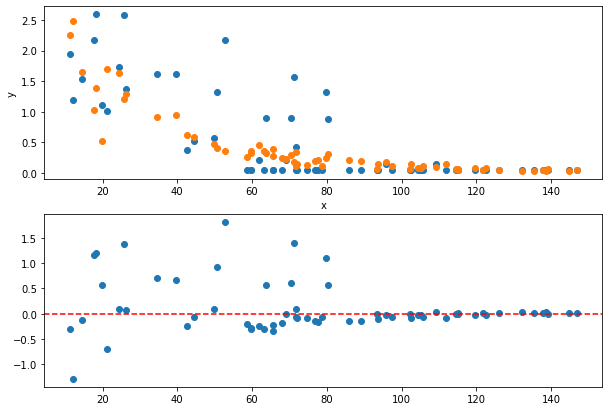

In [303]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xx[0], 10**yy)
p0, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination  = np.median(sampler.results['samples'][:1000], axis = 0)
yy_model = model_all(xx, p0, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
plt.scatter(xx[0], 10**yy_model)
#plt.xscale("log")
#plt.yscale("log")
plt.subplot(212)
plt.scatter(xx[0], 10**yy - 10**yy_model)
plt.axhline(0, linestyle = "--", c = "r")

## W = f(b, M, z, sfr, alpha, incl)

In [428]:
xx = np.array(isol_snr3_good_runs_rot[["B_KPC", "Rvir", "Z", "logSFR", "alpha", "inclination"]])
xx = xx.T
yy = np.array(isol_snr3_good_runs_rot["REW_2796"])

In [431]:
def model(X, p0, a, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination):
    #W = p0 + X[0]*k_b + X[1]*k_M + X[2]*k_z + X[3]*k_sfr + X[4]*k_alpha + X[5]*k_inclination
    W = p0*(X[0]/a)**(k_b)
    return W


def log_likelihood(params):
    # unpack the current parameters:
    p0, a, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination = params

    # compute for each x point, where it should lie in y
    y_model = model(xx, p0, a, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
    # compute likelihood
    loglike = -0.5 * (((y_model - yy))**2).sum()

    return loglike

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -20 to +20
    params[0] = cube[0] * 40 - 20
    params[1] = cube[1] * 50+0.5
    params[2] = cube[2] * 10 - 5
    params[3] = cube[3] * 10 - 5
    params[4] = cube[4] * 10 - 5
    params[5] = cube[5] * 10 - 5
    params[6] = cube[6] * 10 - 5
    return params

In [432]:
parameters = ['p0', 'a', 'k_b', 'k_M', 'k_z', 'k_sfr', 'k_alpha', 'k_inclination']
sampler = ReactiveNestedSampler(parameters, log_likelihood, prior_transform)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=8+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]


DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-59966422553842426052608.00, Lmax=-5.74


DEBUG:ultranest:iteration=80, ncalls=885, regioncalls=3400, ndraw=40, logz=-785283902.53, remainder_fraction=100.0000%, Lmin=-773987121.83, Lmax=-5.74


DEBUG:ultranest:iteration=160, ncalls=972, regioncalls=6880, ndraw=40, logz=-16517270.75, remainder_fraction=100.0000%, Lmin=-16189975.77, Lmax=-5.74


DEBUG:ultranest:iteration=179, ncalls=992, regioncalls=7680, ndraw=40, logz=-8359188.90, remainder_fraction=100.0000%, Lmin=-8304679.16, Lmax=-5.74


DEBUG:ultranest:iteration=240, ncalls=1073, regioncalls=10920, ndraw=40, logz=-1511614.13, remainder_fraction=100.0000%, Lmin=-1429189.00, Lmax=-5.74


DEBUG:ultranest:iteration=320, ncalls=1187, regioncalls=15480, ndraw=40, logz=-365269.94, remainder_fraction=100.0000%, Lmin=-364013.41, Lmax=-5.74


DEBUG:ultranest:iteration=358, ncalls=1255, regioncalls=18200, ndraw=40, logz=-222479.84, remainder_fraction=100.0000%, Lmin=-221763.16, Lmax=-5.74


DEBUG:ultranest:iteration=400, ncalls=1328, regioncalls=21120, ndraw=40, logz=-121751.90, remainder_fraction=100.0000%, Lmin=-121537.25, Lmax=-5.74


DEBUG:ultranest:iteration=480, ncalls=1465, regioncalls=26600, ndraw=40, logz=-52504.08, remainder_fraction=100.0000%, Lmin=-51811.71, Lmax=-5.74


DEBUG:ultranest:iteration=537, ncalls=1556, regioncalls=30240, ndraw=40, logz=-27806.13, remainder_fraction=100.0000%, Lmin=-27729.29, Lmax=-5.74


DEBUG:ultranest:iteration=560, ncalls=1602, regioncalls=32080, ndraw=40, logz=-23790.95, remainder_fraction=100.0000%, Lmin=-23715.79, Lmax=-5.74


DEBUG:ultranest:iteration=640, ncalls=1752, regioncalls=38080, ndraw=40, logz=-11593.51, remainder_fraction=100.0000%, Lmin=-11578.56, Lmax=-5.74


DEBUG:ultranest:iteration=716, ncalls=1889, regioncalls=43560, ndraw=40, logz=-7604.08, remainder_fraction=100.0000%, Lmin=-7577.86, Lmax=-5.74


DEBUG:ultranest:iteration=720, ncalls=1895, regioncalls=43800, ndraw=40, logz=-7436.78, remainder_fraction=100.0000%, Lmin=-7412.52, Lmax=-5.74


DEBUG:ultranest:iteration=793, ncalls=2049, regioncalls=49960, ndraw=40, logz=-5399.59, remainder_fraction=100.0000%, Lmin=-5333.52, Lmax=-5.74


DEBUG:ultranest:iteration=800, ncalls=2061, regioncalls=50440, ndraw=40, logz=-5174.22, remainder_fraction=100.0000%, Lmin=-5137.49, Lmax=-5.74


DEBUG:ultranest:iteration=880, ncalls=2261, regioncalls=58440, ndraw=40, logz=-3589.47, remainder_fraction=100.0000%, Lmin=-3572.27, Lmax=-5.74


DEBUG:ultranest:iteration=911, ncalls=2353, regioncalls=62120, ndraw=40, logz=-3147.63, remainder_fraction=100.0000%, Lmin=-3090.26, Lmax=-5.74


DEBUG:ultranest:iteration=960, ncalls=2500, regioncalls=68000, ndraw=40, logz=-2446.38, remainder_fraction=100.0000%, Lmin=-2425.99, Lmax=-5.74


DEBUG:ultranest:iteration=1040, ncalls=2700, regioncalls=76000, ndraw=40, logz=-1695.00, remainder_fraction=100.0000%, Lmin=-1686.88, Lmax=-5.68


DEBUG:ultranest:iteration=1074, ncalls=2816, regioncalls=80640, ndraw=40, logz=-1386.48, remainder_fraction=100.0000%, Lmin=-1370.52, Lmax=-5.68


DEBUG:ultranest:iteration=1120, ncalls=2973, regioncalls=86920, ndraw=40, logz=-1132.88, remainder_fraction=100.0000%, Lmin=-1113.66, Lmax=-5.68


DEBUG:ultranest:iteration=1196, ncalls=3209, regioncalls=96360, ndraw=40, logz=-808.82, remainder_fraction=100.0000%, Lmin=-799.20, Lmax=-5.68


DEBUG:ultranest:iteration=1200, ncalls=3216, regioncalls=96640, ndraw=40, logz=-798.53, remainder_fraction=100.0000%, Lmin=-783.28, Lmax=-5.68


DEBUG:ultranest:iteration=1253, ncalls=3384, regioncalls=103360, ndraw=40, logz=-618.97, remainder_fraction=100.0000%, Lmin=-609.41, Lmax=-5.68


DEBUG:ultranest:iteration=1280, ncalls=3550, regioncalls=110000, ndraw=40, logz=-531.03, remainder_fraction=100.0000%, Lmin=-519.67, Lmax=-5.68


DEBUG:ultranest:iteration=1340, ncalls=3843, regioncalls=121720, ndraw=40, logz=-401.24, remainder_fraction=100.0000%, Lmin=-393.16, Lmax=-5.68


DEBUG:ultranest:iteration=1360, ncalls=3939, regioncalls=125560, ndraw=40, logz=-367.53, remainder_fraction=100.0000%, Lmin=-354.93, Lmax=-5.68


DEBUG:ultranest:iteration=1424, ncalls=4286, regioncalls=139440, ndraw=40, logz=-272.63, remainder_fraction=100.0000%, Lmin=-262.20, Lmax=-5.68


DEBUG:ultranest:iteration=1440, ncalls=4352, regioncalls=142080, ndraw=40, logz=-256.92, remainder_fraction=100.0000%, Lmin=-248.19, Lmax=-5.68


DEBUG:ultranest:iteration=1492, ncalls=4589, regioncalls=151560, ndraw=40, logz=-203.21, remainder_fraction=100.0000%, Lmin=-194.18, Lmax=-5.68


DEBUG:ultranest:iteration=1520, ncalls=4740, regioncalls=157600, ndraw=40, logz=-182.61, remainder_fraction=100.0000%, Lmin=-172.95, Lmax=-5.68


DEBUG:ultranest:iteration=1584, ncalls=5088, regioncalls=171520, ndraw=40, logz=-141.85, remainder_fraction=100.0000%, Lmin=-133.66, Lmax=-5.68


DEBUG:ultranest:iteration=1600, ncalls=5213, regioncalls=176520, ndraw=40, logz=-136.27, remainder_fraction=100.0000%, Lmin=-128.96, Lmax=-5.68


DEBUG:ultranest:iteration=1611, ncalls=5327, regioncalls=181080, ndraw=40, logz=-130.58, remainder_fraction=100.0000%, Lmin=-120.98, Lmax=-5.68


DEBUG:ultranest:iteration=1656, ncalls=5621, regioncalls=192840, ndraw=40, logz=-106.64, remainder_fraction=100.0000%, Lmin=-99.23, Lmax=-5.68


DEBUG:ultranest:iteration=1680, ncalls=5812, regioncalls=200480, ndraw=40, logz=-97.54, remainder_fraction=100.0000%, Lmin=-89.75, Lmax=-5.59


DEBUG:ultranest:iteration=1745, ncalls=6132, regioncalls=213280, ndraw=40, logz=-76.43, remainder_fraction=100.0000%, Lmin=-68.32, Lmax=-5.59


DEBUG:ultranest:iteration=1760, ncalls=6265, regioncalls=218600, ndraw=40, logz=-72.81, remainder_fraction=100.0000%, Lmin=-65.75, Lmax=-5.59


DEBUG:ultranest:iteration=1790, ncalls=6469, regioncalls=226760, ndraw=40, logz=-64.43, remainder_fraction=100.0000%, Lmin=-56.01, Lmax=-5.59


DEBUG:ultranest:iteration=1836, ncalls=6765, regioncalls=238600, ndraw=40, logz=-54.19, remainder_fraction=100.0000%, Lmin=-46.62, Lmax=-5.59


DEBUG:ultranest:iteration=1840, ncalls=6797, regioncalls=239880, ndraw=40, logz=-53.39, remainder_fraction=100.0000%, Lmin=-45.66, Lmax=-5.59


DEBUG:ultranest:iteration=1888, ncalls=7214, regioncalls=256560, ndraw=40, logz=-46.30, remainder_fraction=100.0000%, Lmin=-38.93, Lmax=-5.59


DEBUG:ultranest:iteration=1920, ncalls=7461, regioncalls=266440, ndraw=40, logz=-42.43, remainder_fraction=100.0000%, Lmin=-35.45, Lmax=-5.59


DEBUG:ultranest:iteration=1969, ncalls=7777, regioncalls=279080, ndraw=40, logz=-36.95, remainder_fraction=100.0000%, Lmin=-30.38, Lmax=-5.59


DEBUG:ultranest:iteration=2000, ncalls=7973, regioncalls=286920, ndraw=40, logz=-34.02, remainder_fraction=100.0000%, Lmin=-27.08, Lmax=-5.59


DEBUG:ultranest:iteration=2052, ncalls=8310, regioncalls=300400, ndraw=40, logz=-30.51, remainder_fraction=100.0000%, Lmin=-24.06, Lmax=-5.59


DEBUG:ultranest:iteration=2080, ncalls=8584, regioncalls=311360, ndraw=40, logz=-29.01, remainder_fraction=100.0000%, Lmin=-22.69, Lmax=-5.59


DEBUG:ultranest:iteration=2117, ncalls=9048, regioncalls=329920, ndraw=40, logz=-27.37, remainder_fraction=100.0000%, Lmin=-21.41, Lmax=-5.52


DEBUG:ultranest:iteration=2148, ncalls=9329, regioncalls=341160, ndraw=40, logz=-26.35, remainder_fraction=100.0000%, Lmin=-20.38, Lmax=-5.52


DEBUG:ultranest:iteration=2160, ncalls=9393, regioncalls=343720, ndraw=40, logz=-25.99, remainder_fraction=99.9999%, Lmin=-20.17, Lmax=-5.52


DEBUG:ultranest:iteration=2196, ncalls=9765, regioncalls=358600, ndraw=40, logz=-25.06, remainder_fraction=99.9998%, Lmin=-19.38, Lmax=-5.52


DEBUG:ultranest:iteration=2236, ncalls=10186, regioncalls=375440, ndraw=40, logz=-24.24, remainder_fraction=99.9996%, Lmin=-18.79, Lmax=-5.52


DEBUG:ultranest:iteration=2240, ncalls=10210, regioncalls=376400, ndraw=40, logz=-24.17, remainder_fraction=99.9995%, Lmin=-18.73, Lmax=-5.52


DEBUG:ultranest:iteration=2284, ncalls=10622, regioncalls=392880, ndraw=40, logz=-23.53, remainder_fraction=99.9992%, Lmin=-18.36, Lmax=-5.52


DEBUG:ultranest:iteration=2320, ncalls=11014, regioncalls=408560, ndraw=40, logz=-23.13, remainder_fraction=99.9988%, Lmin=-18.23, Lmax=-5.52


DEBUG:ultranest:iteration=2332, ncalls=11170, regioncalls=414800, ndraw=40, logz=-23.03, remainder_fraction=99.9987%, Lmin=-18.22, Lmax=-5.28


DEBUG:ultranest:iteration=2360, ncalls=11572, regioncalls=430880, ndraw=40, logz=-22.82, remainder_fraction=99.9985%, Lmin=-18.21, Lmax=-5.28


DEBUG:ultranest:iteration=2396, ncalls=12036, regioncalls=449440, ndraw=40, logz=-22.61, remainder_fraction=99.9981%, Lmin=-18.20, Lmax=-5.28


DEBUG:ultranest:iteration=2400, ncalls=12062, regioncalls=450480, ndraw=40, logz=-22.59, remainder_fraction=99.9980%, Lmin=-18.20, Lmax=-5.28


DEBUG:ultranest:iteration=2430, ncalls=12557, regioncalls=470280, ndraw=40, logz=-22.45, remainder_fraction=99.9977%, Lmin=-18.15, Lmax=-5.28


DEBUG:ultranest:iteration=2459, ncalls=13042, regioncalls=489680, ndraw=40, logz=-22.33, remainder_fraction=99.9974%, Lmin=-18.08, Lmax=-5.28


DEBUG:ultranest:iteration=2480, ncalls=13369, regioncalls=502760, ndraw=40, logz=-22.25, remainder_fraction=99.9971%, Lmin=-18.01, Lmax=-5.28


DEBUG:ultranest:iteration=2506, ncalls=13752, regioncalls=518080, ndraw=40, logz=-22.15, remainder_fraction=99.9967%, Lmin=-17.89, Lmax=-5.28


DEBUG:ultranest:iteration=2529, ncalls=14152, regioncalls=534080, ndraw=40, logz=-22.06, remainder_fraction=99.9966%, Lmin=-17.82, Lmax=-5.24


DEBUG:ultranest:iteration=2560, ncalls=14616, regioncalls=552640, ndraw=40, logz=-21.94, remainder_fraction=99.9963%, Lmin=-17.60, Lmax=-5.24


DEBUG:ultranest:iteration=2596, ncalls=15060, regioncalls=570400, ndraw=40, logz=-21.80, remainder_fraction=99.9956%, Lmin=-17.36, Lmax=-5.24


DEBUG:ultranest:iteration=2628, ncalls=15520, regioncalls=588800, ndraw=40, logz=-21.66, remainder_fraction=99.9950%, Lmin=-17.07, Lmax=-5.24


DEBUG:ultranest:iteration=2640, ncalls=15685, regioncalls=595400, ndraw=40, logz=-21.60, remainder_fraction=99.9946%, Lmin=-16.99, Lmax=-5.24


DEBUG:ultranest:iteration=2671, ncalls=16157, regioncalls=614280, ndraw=40, logz=-21.45, remainder_fraction=99.9936%, Lmin=-16.70, Lmax=-5.24


DEBUG:ultranest:iteration=2685, ncalls=16292, regioncalls=619680, ndraw=40, logz=-21.38, remainder_fraction=99.9931%, Lmin=-16.59, Lmax=-5.24


DEBUG:ultranest:iteration=2705, ncalls=16657, regioncalls=634280, ndraw=40, logz=-21.28, remainder_fraction=99.9925%, Lmin=-16.47, Lmax=-5.24


DEBUG:ultranest:iteration=2720, ncalls=16947, regioncalls=645880, ndraw=40, logz=-21.20, remainder_fraction=99.9919%, Lmin=-16.36, Lmax=-5.24


DEBUG:ultranest:iteration=2748, ncalls=17404, regioncalls=664160, ndraw=40, logz=-21.04, remainder_fraction=99.9907%, Lmin=-16.08, Lmax=-5.24


DEBUG:ultranest:iteration=2774, ncalls=17872, regioncalls=682880, ndraw=40, logz=-20.89, remainder_fraction=99.9895%, Lmin=-15.83, Lmax=-5.24


DEBUG:ultranest:iteration=2797, ncalls=18326, regioncalls=701040, ndraw=40, logz=-20.75, remainder_fraction=99.9879%, Lmin=-15.65, Lmax=-5.24


DEBUG:ultranest:iteration=2800, ncalls=18409, regioncalls=704360, ndraw=40, logz=-20.73, remainder_fraction=99.9876%, Lmin=-15.59, Lmax=-5.24


DEBUG:ultranest:iteration=2826, ncalls=18894, regioncalls=723760, ndraw=40, logz=-20.55, remainder_fraction=99.9849%, Lmin=-15.33, Lmax=-5.24


DEBUG:ultranest:iteration=2852, ncalls=19329, regioncalls=741160, ndraw=40, logz=-20.37, remainder_fraction=99.9818%, Lmin=-15.06, Lmax=-5.24


DEBUG:ultranest:iteration=2864, ncalls=19637, regioncalls=753480, ndraw=40, logz=-20.28, remainder_fraction=99.9807%, Lmin=-14.93, Lmax=-5.24


DEBUG:ultranest:iteration=2880, ncalls=19997, regioncalls=767880, ndraw=40, logz=-20.17, remainder_fraction=99.9780%, Lmin=-14.82, Lmax=-5.24


DEBUG:ultranest:iteration=2905, ncalls=20464, regioncalls=786560, ndraw=40, logz=-19.99, remainder_fraction=99.9743%, Lmin=-14.64, Lmax=-5.24


DEBUG:ultranest:iteration=2931, ncalls=20937, regioncalls=805480, ndraw=40, logz=-19.81, remainder_fraction=99.9687%, Lmin=-14.44, Lmax=-5.24


DEBUG:ultranest:iteration=2955, ncalls=21383, regioncalls=823320, ndraw=40, logz=-19.65, remainder_fraction=99.9645%, Lmin=-14.33, Lmax=-5.24


DEBUG:ultranest:iteration=2960, ncalls=21496, regioncalls=827840, ndraw=40, logz=-19.62, remainder_fraction=99.9632%, Lmin=-14.30, Lmax=-5.24


DEBUG:ultranest:iteration=2980, ncalls=21956, regioncalls=846240, ndraw=40, logz=-19.49, remainder_fraction=99.9574%, Lmin=-14.14, Lmax=-5.24


DEBUG:ultranest:iteration=3000, ncalls=22428, regioncalls=865120, ndraw=40, logz=-19.37, remainder_fraction=99.9525%, Lmin=-14.01, Lmax=-5.24


DEBUG:ultranest:iteration=3018, ncalls=22893, regioncalls=883720, ndraw=40, logz=-19.26, remainder_fraction=99.9469%, Lmin=-13.95, Lmax=-5.24


DEBUG:ultranest:iteration=3031, ncalls=23392, regioncalls=903680, ndraw=40, logz=-19.18, remainder_fraction=99.9420%, Lmin=-13.88, Lmax=-5.24


DEBUG:ultranest:iteration=3040, ncalls=23568, regioncalls=910720, ndraw=40, logz=-19.13, remainder_fraction=99.9391%, Lmin=-13.84, Lmax=-5.24


DEBUG:ultranest:iteration=3043, ncalls=23701, regioncalls=916040, ndraw=40, logz=-19.12, remainder_fraction=99.9380%, Lmin=-13.83, Lmax=-5.24


DEBUG:ultranest:iteration=3069, ncalls=24145, regioncalls=933800, ndraw=40, logz=-18.97, remainder_fraction=99.9287%, Lmin=-13.65, Lmax=-5.24


DEBUG:ultranest:iteration=3092, ncalls=24704, regioncalls=956160, ndraw=40, logz=-18.84, remainder_fraction=99.9181%, Lmin=-13.50, Lmax=-5.24


DEBUG:ultranest:iteration=3118, ncalls=25274, regioncalls=978960, ndraw=40, logz=-18.70, remainder_fraction=99.9066%, Lmin=-13.35, Lmax=-5.24


DEBUG:ultranest:iteration=3120, ncalls=25325, regioncalls=981000, ndraw=40, logz=-18.69, remainder_fraction=99.9054%, Lmin=-13.34, Lmax=-5.24


DEBUG:ultranest:iteration=3144, ncalls=25878, regioncalls=1003120, ndraw=40, logz=-18.56, remainder_fraction=99.8921%, Lmin=-13.23, Lmax=-5.24


DEBUG:ultranest:iteration=3169, ncalls=26468, regioncalls=1026720, ndraw=40, logz=-18.44, remainder_fraction=99.8781%, Lmin=-13.09, Lmax=-5.24


DEBUG:ultranest:iteration=3199, ncalls=27006, regioncalls=1048240, ndraw=40, logz=-18.29, remainder_fraction=99.8654%, Lmin=-12.92, Lmax=-5.24


DEBUG:ultranest:iteration=3200, ncalls=27009, regioncalls=1048360, ndraw=40, logz=-18.28, remainder_fraction=99.8662%, Lmin=-12.92, Lmax=-5.24


DEBUG:ultranest:iteration=3222, ncalls=27571, regioncalls=1070840, ndraw=40, logz=-18.18, remainder_fraction=99.8479%, Lmin=-12.77, Lmax=-5.24


DEBUG:ultranest:iteration=3247, ncalls=27983, regioncalls=1087320, ndraw=40, logz=-18.06, remainder_fraction=99.8310%, Lmin=-12.66, Lmax=-5.24


DEBUG:ultranest:iteration=3274, ncalls=28515, regioncalls=1108600, ndraw=40, logz=-17.93, remainder_fraction=99.8080%, Lmin=-12.44, Lmax=-5.24


DEBUG:ultranest:iteration=3280, ncalls=28670, regioncalls=1114800, ndraw=40, logz=-17.89, remainder_fraction=99.8013%, Lmin=-12.38, Lmax=-5.24


DEBUG:ultranest:iteration=3307, ncalls=29234, regioncalls=1137360, ndraw=40, logz=-17.76, remainder_fraction=99.7772%, Lmin=-12.20, Lmax=-5.24


DEBUG:ultranest:iteration=3327, ncalls=29796, regioncalls=1159840, ndraw=40, logz=-17.65, remainder_fraction=99.7544%, Lmin=-12.08, Lmax=-5.24


DEBUG:ultranest:iteration=3355, ncalls=30312, regioncalls=1180480, ndraw=40, logz=-17.51, remainder_fraction=99.7156%, Lmin=-11.90, Lmax=-5.24


DEBUG:ultranest:iteration=3360, ncalls=30462, regioncalls=1186480, ndraw=40, logz=-17.49, remainder_fraction=99.7111%, Lmin=-11.88, Lmax=-5.24


DEBUG:ultranest:iteration=3384, ncalls=30989, regioncalls=1207560, ndraw=40, logz=-17.37, remainder_fraction=99.6768%, Lmin=-11.73, Lmax=-5.24
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([799,   1]))


DEBUG:ultranest:iteration=3401, ncalls=31317, regioncalls=1220680, ndraw=40, logz=-17.28, remainder_fraction=99.6510%, Lmin=-11.63, Lmax=-5.24


DEBUG:ultranest:iteration=3416, ncalls=31764, regioncalls=1238560, ndraw=40, logz=-17.20, remainder_fraction=99.6233%, Lmin=-11.55, Lmax=-5.24


DEBUG:ultranest:iteration=3434, ncalls=32322, regioncalls=1260880, ndraw=40, logz=-17.11, remainder_fraction=99.5894%, Lmin=-11.48, Lmax=-5.24


DEBUG:ultranest:iteration=3440, ncalls=32522, regioncalls=1268880, ndraw=40, logz=-17.09, remainder_fraction=99.5759%, Lmin=-11.46, Lmax=-5.24


DEBUG:ultranest:iteration=3462, ncalls=33069, regioncalls=1290760, ndraw=40, logz=-16.98, remainder_fraction=99.5378%, Lmin=-11.34, Lmax=-5.24


DEBUG:ultranest:iteration=3477, ncalls=33654, regioncalls=1314160, ndraw=40, logz=-16.91, remainder_fraction=99.5129%, Lmin=-11.24, Lmax=-5.24


DEBUG:ultranest:iteration=3493, ncalls=34243, regioncalls=1337720, ndraw=40, logz=-16.84, remainder_fraction=99.4774%, Lmin=-11.20, Lmax=-5.24


DEBUG:ultranest:iteration=3518, ncalls=34825, regioncalls=1361000, ndraw=40, logz=-16.73, remainder_fraction=99.4186%, Lmin=-11.10, Lmax=-5.24


DEBUG:ultranest:iteration=3520, ncalls=35003, regioncalls=1368120, ndraw=40, logz=-16.72, remainder_fraction=99.4170%, Lmin=-11.09, Lmax=-5.24


DEBUG:ultranest:iteration=3539, ncalls=35558, regioncalls=1390320, ndraw=40, logz=-16.64, remainder_fraction=99.3723%, Lmin=-11.00, Lmax=-5.24


DEBUG:ultranest:iteration=3558, ncalls=36097, regioncalls=1411880, ndraw=40, logz=-16.56, remainder_fraction=99.3222%, Lmin=-10.87, Lmax=-5.24


DEBUG:ultranest:iteration=3578, ncalls=36647, regioncalls=1433880, ndraw=40, logz=-16.48, remainder_fraction=99.2688%, Lmin=-10.76, Lmax=-5.22


DEBUG:ultranest:iteration=3580, ncalls=36675, regioncalls=1435000, ndraw=40, logz=-16.47, remainder_fraction=99.2611%, Lmin=-10.76, Lmax=-5.22


DEBUG:ultranest:iteration=3600, ncalls=37058, regioncalls=1450320, ndraw=40, logz=-16.38, remainder_fraction=99.1942%, Lmin=-10.65, Lmax=-5.22


DEBUG:ultranest:iteration=3628, ncalls=37639, regioncalls=1473560, ndraw=40, logz=-16.26, remainder_fraction=99.0910%, Lmin=-10.47, Lmax=-5.22


DEBUG:ultranest:iteration=3662, ncalls=38264, regioncalls=1498560, ndraw=40, logz=-16.11, remainder_fraction=98.9397%, Lmin=-10.28, Lmax=-5.22


DEBUG:ultranest:iteration=3680, ncalls=38662, regioncalls=1514480, ndraw=40, logz=-16.03, remainder_fraction=98.8473%, Lmin=-10.21, Lmax=-5.22


DEBUG:ultranest:iteration=3712, ncalls=39291, regioncalls=1539640, ndraw=40, logz=-15.90, remainder_fraction=98.6850%, Lmin=-10.03, Lmax=-5.22


DEBUG:ultranest:iteration=3734, ncalls=40012, regioncalls=1568480, ndraw=40, logz=-15.80, remainder_fraction=98.5501%, Lmin=-9.90, Lmax=-5.22


DEBUG:ultranest:iteration=3759, ncalls=40571, regioncalls=1590840, ndraw=40, logz=-15.70, remainder_fraction=98.3999%, Lmin=-9.80, Lmax=-5.22


DEBUG:ultranest:iteration=3760, ncalls=40582, regioncalls=1591280, ndraw=40, logz=-15.70, remainder_fraction=98.3935%, Lmin=-9.79, Lmax=-5.22


DEBUG:ultranest:iteration=3784, ncalls=41062, regioncalls=1610480, ndraw=40, logz=-15.60, remainder_fraction=98.2164%, Lmin=-9.71, Lmax=-5.22


DEBUG:ultranest:iteration=3812, ncalls=41720, regioncalls=1636800, ndraw=40, logz=-15.49, remainder_fraction=98.0138%, Lmin=-9.61, Lmax=-5.22


DEBUG:ultranest:iteration=3839, ncalls=42376, regioncalls=1663040, ndraw=40, logz=-15.39, remainder_fraction=97.7994%, Lmin=-9.50, Lmax=-5.22


DEBUG:ultranest:iteration=3840, ncalls=42381, regioncalls=1663240, ndraw=40, logz=-15.39, remainder_fraction=97.7890%, Lmin=-9.49, Lmax=-5.22


DEBUG:ultranest:iteration=3866, ncalls=43056, regioncalls=1690240, ndraw=40, logz=-15.29, remainder_fraction=97.5354%, Lmin=-9.37, Lmax=-5.22


DEBUG:ultranest:iteration=3897, ncalls=43676, regioncalls=1715040, ndraw=40, logz=-15.17, remainder_fraction=97.2711%, Lmin=-9.19, Lmax=-5.22


DEBUG:ultranest:iteration=3919, ncalls=44343, regioncalls=1741720, ndraw=40, logz=-15.09, remainder_fraction=97.0157%, Lmin=-9.10, Lmax=-5.22


DEBUG:ultranest:iteration=3920, ncalls=44350, regioncalls=1742000, ndraw=40, logz=-15.09, remainder_fraction=97.0040%, Lmin=-9.10, Lmax=-5.22


DEBUG:ultranest:iteration=3938, ncalls=44887, regioncalls=1763480, ndraw=40, logz=-15.02, remainder_fraction=96.8209%, Lmin=-9.04, Lmax=-5.22


DEBUG:ultranest:iteration=3966, ncalls=45334, regioncalls=1781640, ndraw=40, logz=-14.92, remainder_fraction=96.4862%, Lmin=-8.94, Lmax=-5.22


DEBUG:ultranest:iteration=3991, ncalls=46009, regioncalls=1808840, ndraw=40, logz=-14.84, remainder_fraction=96.1541%, Lmin=-8.83, Lmax=-5.22


DEBUG:ultranest:iteration=4000, ncalls=46299, regioncalls=1820440, ndraw=40, logz=-14.80, remainder_fraction=96.0187%, Lmin=-8.79, Lmax=-5.22


DEBUG:ultranest:iteration=4021, ncalls=47013, regioncalls=1849000, ndraw=40, logz=-14.73, remainder_fraction=95.7484%, Lmin=-8.72, Lmax=-5.22


DEBUG:ultranest:iteration=4051, ncalls=47702, regioncalls=1876560, ndraw=40, logz=-14.63, remainder_fraction=95.3144%, Lmin=-8.62, Lmax=-5.22


DEBUG:ultranest:iteration=4072, ncalls=48400, regioncalls=1904480, ndraw=40, logz=-14.57, remainder_fraction=94.9707%, Lmin=-8.52, Lmax=-5.22


DEBUG:ultranest:iteration=4080, ncalls=48518, regioncalls=1909200, ndraw=40, logz=-14.54, remainder_fraction=94.8322%, Lmin=-8.50, Lmax=-5.22


DEBUG:ultranest:iteration=4106, ncalls=49124, regioncalls=1933640, ndraw=40, logz=-14.46, remainder_fraction=94.4103%, Lmin=-8.40, Lmax=-5.22


DEBUG:ultranest:iteration=4117, ncalls=49443, regioncalls=1946400, ndraw=40, logz=-14.42, remainder_fraction=94.2029%, Lmin=-8.34, Lmax=-5.22


DEBUG:ultranest:iteration=4135, ncalls=49977, regioncalls=1967760, ndraw=40, logz=-14.37, remainder_fraction=93.8859%, Lmin=-8.30, Lmax=-5.22


DEBUG:ultranest:iteration=4160, ncalls=50585, regioncalls=1992360, ndraw=40, logz=-14.29, remainder_fraction=93.4566%, Lmin=-8.23, Lmax=-5.22


DEBUG:ultranest:iteration=4183, ncalls=51320, regioncalls=2021760, ndraw=40, logz=-14.22, remainder_fraction=93.0267%, Lmin=-8.17, Lmax=-5.22


DEBUG:ultranest:iteration=4201, ncalls=51983, regioncalls=2048640, ndraw=40, logz=-14.17, remainder_fraction=92.6274%, Lmin=-8.09, Lmax=-5.22


DEBUG:ultranest:iteration=4225, ncalls=52768, regioncalls=2080080, ndraw=40, logz=-14.11, remainder_fraction=92.1281%, Lmin=-8.03, Lmax=-5.22


DEBUG:ultranest:iteration=4240, ncalls=53266, regioncalls=2100040, ndraw=40, logz=-14.06, remainder_fraction=91.8027%, Lmin=-7.99, Lmax=-5.22


DEBUG:ultranest:iteration=4261, ncalls=53924, regioncalls=2126920, ndraw=40, logz=-14.01, remainder_fraction=91.3642%, Lmin=-7.94, Lmax=-5.22


DEBUG:ultranest:iteration=4286, ncalls=54496, regioncalls=2150160, ndraw=40, logz=-13.94, remainder_fraction=90.9000%, Lmin=-7.88, Lmax=-5.22


DEBUG:ultranest:iteration=4296, ncalls=54913, regioncalls=2167160, ndraw=40, logz=-13.92, remainder_fraction=90.6290%, Lmin=-7.86, Lmax=-5.22


DEBUG:ultranest:iteration=4312, ncalls=55465, regioncalls=2189280, ndraw=40, logz=-13.88, remainder_fraction=90.2399%, Lmin=-7.80, Lmax=-5.22


DEBUG:ultranest:iteration=4320, ncalls=55682, regioncalls=2197960, ndraw=40, logz=-13.86, remainder_fraction=90.0833%, Lmin=-7.78, Lmax=-5.22


DEBUG:ultranest:iteration=4343, ncalls=56375, regioncalls=2225800, ndraw=40, logz=-13.80, remainder_fraction=89.3832%, Lmin=-7.72, Lmax=-5.22


DEBUG:ultranest:iteration=4361, ncalls=57128, regioncalls=2256000, ndraw=40, logz=-13.76, remainder_fraction=88.9211%, Lmin=-7.67, Lmax=-5.22


DEBUG:ultranest:iteration=4378, ncalls=57818, regioncalls=2283720, ndraw=40, logz=-13.72, remainder_fraction=88.4656%, Lmin=-7.62, Lmax=-5.22


DEBUG:ultranest:iteration=4396, ncalls=58529, regioncalls=2312200, ndraw=40, logz=-13.68, remainder_fraction=88.0033%, Lmin=-7.57, Lmax=-5.22


DEBUG:ultranest:iteration=4400, ncalls=58619, regioncalls=2315800, ndraw=40, logz=-13.67, remainder_fraction=87.9278%, Lmin=-7.56, Lmax=-5.22


DEBUG:ultranest:iteration=4415, ncalls=59329, regioncalls=2344280, ndraw=40, logz=-13.64, remainder_fraction=87.5180%, Lmin=-7.53, Lmax=-5.22


DEBUG:ultranest:iteration=4431, ncalls=59998, regioncalls=2371640, ndraw=40, logz=-13.60, remainder_fraction=87.0365%, Lmin=-7.47, Lmax=-5.22


DEBUG:ultranest:iteration=4450, ncalls=60797, regioncalls=2403720, ndraw=40, logz=-13.56, remainder_fraction=86.4739%, Lmin=-7.42, Lmax=-5.22


DEBUG:ultranest:iteration=4465, ncalls=61470, regioncalls=2431000, ndraw=40, logz=-13.52, remainder_fraction=86.0523%, Lmin=-7.40, Lmax=-5.22


DEBUG:ultranest:iteration=4475, ncalls=61776, regioncalls=2443600, ndraw=40, logz=-13.50, remainder_fraction=85.7824%, Lmin=-7.38, Lmax=-5.22


DEBUG:ultranest:iteration=4480, ncalls=62097, regioncalls=2456600, ndraw=40, logz=-13.49, remainder_fraction=85.6292%, Lmin=-7.37, Lmax=-5.22


DEBUG:ultranest:iteration=4494, ncalls=62769, regioncalls=2483480, ndraw=40, logz=-13.46, remainder_fraction=85.1859%, Lmin=-7.32, Lmax=-5.22


DEBUG:ultranest:iteration=4510, ncalls=63501, regioncalls=2512920, ndraw=40, logz=-13.43, remainder_fraction=84.7055%, Lmin=-7.29, Lmax=-5.22


DEBUG:ultranest:iteration=4523, ncalls=64403, regioncalls=2549120, ndraw=40, logz=-13.40, remainder_fraction=84.3038%, Lmin=-7.26, Lmax=-5.22


DEBUG:ultranest:iteration=4542, ncalls=65108, regioncalls=2577560, ndraw=40, logz=-13.36, remainder_fraction=83.6124%, Lmin=-7.21, Lmax=-5.22


DEBUG:ultranest:iteration=4559, ncalls=65813, regioncalls=2606040, ndraw=40, logz=-13.33, remainder_fraction=83.0553%, Lmin=-7.17, Lmax=-5.22


DEBUG:ultranest:iteration=4560, ncalls=65877, regioncalls=2608600, ndraw=40, logz=-13.33, remainder_fraction=83.0164%, Lmin=-7.17, Lmax=-5.22


DEBUG:ultranest:iteration=4580, ncalls=66839, regioncalls=2647440, ndraw=40, logz=-13.29, remainder_fraction=82.3341%, Lmin=-7.12, Lmax=-5.22


DEBUG:ultranest:iteration=4597, ncalls=67471, regioncalls=2673200, ndraw=40, logz=-13.26, remainder_fraction=81.7432%, Lmin=-7.10, Lmax=-5.22


DEBUG:ultranest:iteration=4609, ncalls=68258, regioncalls=2704880, ndraw=40, logz=-13.23, remainder_fraction=81.2963%, Lmin=-7.08, Lmax=-5.22


DEBUG:ultranest:iteration=4623, ncalls=69020, regioncalls=2736040, ndraw=40, logz=-13.21, remainder_fraction=80.8089%, Lmin=-7.02, Lmax=-5.22


DEBUG:ultranest:iteration=4639, ncalls=69755, regioncalls=2765720, ndraw=40, logz=-13.18, remainder_fraction=80.1987%, Lmin=-6.98, Lmax=-5.22


DEBUG:ultranest:iteration=4640, ncalls=69775, regioncalls=2766520, ndraw=40, logz=-13.18, remainder_fraction=80.1783%, Lmin=-6.98, Lmax=-5.22


DEBUG:ultranest:iteration=4649, ncalls=70553, regioncalls=2798320, ndraw=40, logz=-13.16, remainder_fraction=79.8282%, Lmin=-6.96, Lmax=-5.22


DEBUG:ultranest:iteration=4654, ncalls=70717, regioncalls=2805080, ndraw=40, logz=-13.15, remainder_fraction=79.6423%, Lmin=-6.95, Lmax=-5.22


DEBUG:ultranest:iteration=4667, ncalls=71192, regioncalls=2825360, ndraw=40, logz=-13.13, remainder_fraction=79.0661%, Lmin=-6.93, Lmax=-5.22


DEBUG:ultranest:iteration=4684, ncalls=71816, regioncalls=2852680, ndraw=40, logz=-13.10, remainder_fraction=78.3892%, Lmin=-6.87, Lmax=-5.22


DEBUG:ultranest:iteration=4703, ncalls=72419, regioncalls=2878360, ndraw=40, logz=-13.06, remainder_fraction=77.7333%, Lmin=-6.82, Lmax=-5.22


DEBUG:ultranest:iteration=4720, ncalls=72906, regioncalls=2898880, ndraw=40, logz=-13.03, remainder_fraction=77.0150%, Lmin=-6.78, Lmax=-5.22


DEBUG:ultranest:iteration=4735, ncalls=73664, regioncalls=2930280, ndraw=40, logz=-13.00, remainder_fraction=76.3650%, Lmin=-6.76, Lmax=-5.22


DEBUG:ultranest:iteration=4756, ncalls=74262, regioncalls=2955720, ndraw=40, logz=-12.97, remainder_fraction=75.4964%, Lmin=-6.72, Lmax=-5.22


DEBUG:ultranest:iteration=4779, ncalls=74914, regioncalls=2983000, ndraw=40, logz=-12.93, remainder_fraction=74.4871%, Lmin=-6.69, Lmax=-5.22


DEBUG:ultranest:iteration=4794, ncalls=75564, regioncalls=3010400, ndraw=40, logz=-12.91, remainder_fraction=73.8422%, Lmin=-6.66, Lmax=-5.22


DEBUG:ultranest:iteration=4800, ncalls=75862, regioncalls=3023560, ndraw=40, logz=-12.90, remainder_fraction=73.5852%, Lmin=-6.65, Lmax=-5.22


DEBUG:ultranest:iteration=4817, ncalls=76505, regioncalls=3050880, ndraw=40, logz=-12.87, remainder_fraction=72.8417%, Lmin=-6.62, Lmax=-5.22


DEBUG:ultranest:iteration=4833, ncalls=76953, regioncalls=3069600, ndraw=40, logz=-12.84, remainder_fraction=72.1541%, Lmin=-6.59, Lmax=-5.22


DEBUG:ultranest:iteration=4849, ncalls=77460, regioncalls=3091200, ndraw=40, logz=-12.82, remainder_fraction=71.4256%, Lmin=-6.58, Lmax=-5.22


DEBUG:ultranest:iteration=4863, ncalls=78081, regioncalls=3117760, ndraw=40, logz=-12.80, remainder_fraction=70.8225%, Lmin=-6.56, Lmax=-5.22


DEBUG:ultranest:iteration=4878, ncalls=78645, regioncalls=3142240, ndraw=40, logz=-12.78, remainder_fraction=70.1810%, Lmin=-6.53, Lmax=-5.22


DEBUG:ultranest:iteration=4880, ncalls=78706, regioncalls=3144800, ndraw=40, logz=-12.77, remainder_fraction=70.0891%, Lmin=-6.53, Lmax=-5.22


DEBUG:ultranest:iteration=4896, ncalls=79299, regioncalls=3169720, ndraw=40, logz=-12.75, remainder_fraction=69.4115%, Lmin=-6.51, Lmax=-5.22


DEBUG:ultranest:iteration=4912, ncalls=79990, regioncalls=3198400, ndraw=40, logz=-12.73, remainder_fraction=68.6920%, Lmin=-6.49, Lmax=-5.22


DEBUG:ultranest:iteration=4928, ncalls=80612, regioncalls=3224880, ndraw=40, logz=-12.71, remainder_fraction=68.0191%, Lmin=-6.48, Lmax=-5.22


DEBUG:ultranest:iteration=4944, ncalls=81273, regioncalls=3252480, ndraw=40, logz=-12.69, remainder_fraction=67.3554%, Lmin=-6.46, Lmax=-5.22


DEBUG:ultranest:iteration=4957, ncalls=81896, regioncalls=3278720, ndraw=40, logz=-12.67, remainder_fraction=66.7665%, Lmin=-6.44, Lmax=-5.22


DEBUG:ultranest:iteration=4960, ncalls=81986, regioncalls=3283000, ndraw=40, logz=-12.67, remainder_fraction=66.6321%, Lmin=-6.43, Lmax=-5.22


DEBUG:ultranest:iteration=4974, ncalls=82599, regioncalls=3309600, ndraw=40, logz=-12.65, remainder_fraction=66.0296%, Lmin=-6.42, Lmax=-5.22


DEBUG:ultranest:iteration=4985, ncalls=83201, regioncalls=3336120, ndraw=40, logz=-12.63, remainder_fraction=65.5762%, Lmin=-6.41, Lmax=-5.22


DEBUG:ultranest:iteration=5004, ncalls=83847, regioncalls=3364000, ndraw=40, logz=-12.61, remainder_fraction=64.6839%, Lmin=-6.38, Lmax=-5.22


DEBUG:ultranest:iteration=5012, ncalls=84149, regioncalls=3377120, ndraw=40, logz=-12.60, remainder_fraction=64.3610%, Lmin=-6.37, Lmax=-5.22


DEBUG:ultranest:iteration=5024, ncalls=84602, regioncalls=3396720, ndraw=40, logz=-12.59, remainder_fraction=63.8041%, Lmin=-6.34, Lmax=-5.22


DEBUG:ultranest:iteration=5040, ncalls=85170, regioncalls=3420760, ndraw=40, logz=-12.57, remainder_fraction=63.0889%, Lmin=-6.33, Lmax=-5.22


DEBUG:ultranest:iteration=5058, ncalls=85772, regioncalls=3446600, ndraw=40, logz=-12.55, remainder_fraction=62.2985%, Lmin=-6.30, Lmax=-5.22


DEBUG:ultranest:iteration=5071, ncalls=86360, regioncalls=3471880, ndraw=40, logz=-12.53, remainder_fraction=61.6849%, Lmin=-6.29, Lmax=-5.22


DEBUG:ultranest:iteration=5086, ncalls=86996, regioncalls=3499400, ndraw=40, logz=-12.51, remainder_fraction=60.9769%, Lmin=-6.26, Lmax=-5.22


DEBUG:ultranest:iteration=5097, ncalls=87702, regioncalls=3529840, ndraw=40, logz=-12.50, remainder_fraction=60.5035%, Lmin=-6.25, Lmax=-5.22


DEBUG:ultranest:iteration=5110, ncalls=88335, regioncalls=3557120, ndraw=40, logz=-12.49, remainder_fraction=59.9231%, Lmin=-6.24, Lmax=-5.22


DEBUG:ultranest:iteration=5120, ncalls=88741, regioncalls=3575000, ndraw=40, logz=-12.48, remainder_fraction=59.5112%, Lmin=-6.23, Lmax=-5.22


DEBUG:ultranest:iteration=5131, ncalls=89435, regioncalls=3604560, ndraw=40, logz=-12.47, remainder_fraction=59.0350%, Lmin=-6.22, Lmax=-5.22


DEBUG:ultranest:iteration=5142, ncalls=90237, regioncalls=3638640, ndraw=40, logz=-12.45, remainder_fraction=58.5774%, Lmin=-6.21, Lmax=-5.22


DEBUG:ultranest:iteration=5158, ncalls=90844, regioncalls=3664480, ndraw=40, logz=-12.44, remainder_fraction=57.8506%, Lmin=-6.19, Lmax=-5.22


DEBUG:ultranest:iteration=5167, ncalls=91540, regioncalls=3694280, ndraw=40, logz=-12.43, remainder_fraction=57.4760%, Lmin=-6.18, Lmax=-5.22


DEBUG:ultranest:iteration=5177, ncalls=92166, regioncalls=3721720, ndraw=40, logz=-12.42, remainder_fraction=57.0506%, Lmin=-6.17, Lmax=-5.22


DEBUG:ultranest:iteration=5186, ncalls=92793, regioncalls=3748360, ndraw=40, logz=-12.41, remainder_fraction=56.6721%, Lmin=-6.15, Lmax=-5.22


DEBUG:ultranest:iteration=5191, ncalls=93160, regioncalls=3763640, ndraw=40, logz=-12.40, remainder_fraction=56.4289%, Lmin=-6.15, Lmax=-5.22


DEBUG:ultranest:iteration=5200, ncalls=93686, regioncalls=3786400, ndraw=40, logz=-12.40, remainder_fraction=56.0150%, Lmin=-6.13, Lmax=-5.22


DEBUG:ultranest:iteration=5217, ncalls=94260, regioncalls=3810360, ndraw=40, logz=-12.38, remainder_fraction=55.3109%, Lmin=-6.12, Lmax=-5.22


DEBUG:ultranest:iteration=5232, ncalls=94873, regioncalls=3836000, ndraw=40, logz=-12.36, remainder_fraction=54.6797%, Lmin=-6.09, Lmax=-5.22


DEBUG:ultranest:iteration=5243, ncalls=95461, regioncalls=3861440, ndraw=40, logz=-12.35, remainder_fraction=54.2061%, Lmin=-6.08, Lmax=-5.22


DEBUG:ultranest:iteration=5255, ncalls=96052, regioncalls=3886720, ndraw=40, logz=-12.34, remainder_fraction=53.7247%, Lmin=-6.07, Lmax=-5.22


DEBUG:ultranest:iteration=5269, ncalls=96623, regioncalls=3911360, ndraw=40, logz=-12.33, remainder_fraction=53.1461%, Lmin=-6.06, Lmax=-5.22


DEBUG:ultranest:iteration=5280, ncalls=97120, regioncalls=3932880, ndraw=40, logz=-12.32, remainder_fraction=52.6859%, Lmin=-6.04, Lmax=-5.22


DEBUG:ultranest:iteration=5294, ncalls=97695, regioncalls=3957720, ndraw=40, logz=-12.31, remainder_fraction=52.0841%, Lmin=-6.03, Lmax=-5.22


DEBUG:ultranest:iteration=5306, ncalls=98319, regioncalls=3984000, ndraw=40, logz=-12.30, remainder_fraction=51.6064%, Lmin=-6.02, Lmax=-5.22


DEBUG:ultranest:iteration=5316, ncalls=98872, regioncalls=4008720, ndraw=40, logz=-12.29, remainder_fraction=51.1808%, Lmin=-6.01, Lmax=-5.22


DEBUG:ultranest:iteration=5328, ncalls=99496, regioncalls=4035000, ndraw=40, logz=-12.28, remainder_fraction=50.6962%, Lmin=-6.00, Lmax=-5.22


DEBUG:ultranest:iteration=5341, ncalls=100039, regioncalls=4058880, ndraw=40, logz=-12.27, remainder_fraction=50.1705%, Lmin=-5.99, Lmax=-5.22


DEBUG:ultranest:iteration=5348, ncalls=100780, regioncalls=4091040, ndraw=40, logz=-12.26, remainder_fraction=49.8637%, Lmin=-5.98, Lmax=-5.22


DEBUG:ultranest:iteration=5357, ncalls=101394, regioncalls=4117320, ndraw=40, logz=-12.25, remainder_fraction=49.4791%, Lmin=-5.97, Lmax=-5.22


DEBUG:ultranest:iteration=5360, ncalls=101416, regioncalls=4118280, ndraw=40, logz=-12.25, remainder_fraction=49.3396%, Lmin=-5.97, Lmax=-5.22


DEBUG:ultranest:iteration=5370, ncalls=101668, regioncalls=4129960, ndraw=40, logz=-12.24, remainder_fraction=48.9504%, Lmin=-5.96, Lmax=-5.22


DEBUG:ultranest:iteration=5379, ncalls=102189, regioncalls=4152440, ndraw=40, logz=-12.24, remainder_fraction=48.6203%, Lmin=-5.95, Lmax=-5.22


DEBUG:ultranest:iteration=5388, ncalls=102828, regioncalls=4179960, ndraw=40, logz=-12.23, remainder_fraction=48.2395%, Lmin=-5.94, Lmax=-5.22


DEBUG:ultranest:iteration=5401, ncalls=103430, regioncalls=4205800, ndraw=40, logz=-12.22, remainder_fraction=47.6690%, Lmin=-5.93, Lmax=-5.22


DEBUG:ultranest:iteration=5411, ncalls=104026, regioncalls=4231320, ndraw=40, logz=-12.21, remainder_fraction=47.2708%, Lmin=-5.93, Lmax=-5.22


DEBUG:ultranest:iteration=5422, ncalls=104632, regioncalls=4256880, ndraw=40, logz=-12.20, remainder_fraction=46.8050%, Lmin=-5.92, Lmax=-5.22


DEBUG:ultranest:iteration=5432, ncalls=105304, regioncalls=4285480, ndraw=40, logz=-12.19, remainder_fraction=46.4300%, Lmin=-5.91, Lmax=-5.22


DEBUG:ultranest:iteration=5440, ncalls=105700, regioncalls=4302120, ndraw=40, logz=-12.19, remainder_fraction=46.1029%, Lmin=-5.91, Lmax=-5.22


DEBUG:ultranest:iteration=5452, ncalls=106251, regioncalls=4326080, ndraw=40, logz=-12.18, remainder_fraction=45.6505%, Lmin=-5.89, Lmax=-5.22


DEBUG:ultranest:iteration=5463, ncalls=107031, regioncalls=4359080, ndraw=40, logz=-12.17, remainder_fraction=45.2126%, Lmin=-5.88, Lmax=-5.22


DEBUG:ultranest:iteration=5475, ncalls=107710, regioncalls=4388680, ndraw=40, logz=-12.16, remainder_fraction=44.7298%, Lmin=-5.87, Lmax=-5.22


DEBUG:ultranest:iteration=5490, ncalls=108324, regioncalls=4413680, ndraw=40, logz=-12.15, remainder_fraction=44.1486%, Lmin=-5.86, Lmax=-5.22


DEBUG:ultranest:iteration=5503, ncalls=108882, regioncalls=4438520, ndraw=40, logz=-12.14, remainder_fraction=43.6128%, Lmin=-5.85, Lmax=-5.22


DEBUG:ultranest:iteration=5518, ncalls=109409, regioncalls=4461680, ndraw=40, logz=-12.13, remainder_fraction=43.0214%, Lmin=-5.83, Lmax=-5.22


DEBUG:ultranest:iteration=5520, ncalls=109484, regioncalls=4465240, ndraw=40, logz=-12.13, remainder_fraction=42.9513%, Lmin=-5.83, Lmax=-5.22


DEBUG:ultranest:iteration=5526, ncalls=110092, regioncalls=4492160, ndraw=40, logz=-12.13, remainder_fraction=42.7299%, Lmin=-5.83, Lmax=-5.22


DEBUG:ultranest:iteration=5532, ncalls=110720, regioncalls=4519640, ndraw=40, logz=-12.12, remainder_fraction=42.5035%, Lmin=-5.82, Lmax=-5.22


DEBUG:ultranest:iteration=5540, ncalls=111275, regioncalls=4543760, ndraw=40, logz=-12.12, remainder_fraction=42.2144%, Lmin=-5.82, Lmax=-5.22


DEBUG:ultranest:iteration=5547, ncalls=111858, regioncalls=4569320, ndraw=40, logz=-12.11, remainder_fraction=41.9432%, Lmin=-5.81, Lmax=-5.22


DEBUG:ultranest:iteration=5549, ncalls=112028, regioncalls=4576800, ndraw=40, logz=-12.11, remainder_fraction=41.8555%, Lmin=-5.81, Lmax=-5.22


DEBUG:ultranest:iteration=5558, ncalls=112525, regioncalls=4598760, ndraw=40, logz=-12.11, remainder_fraction=41.5031%, Lmin=-5.81, Lmax=-5.22


DEBUG:ultranest:iteration=5568, ncalls=113007, regioncalls=4621440, ndraw=40, logz=-12.10, remainder_fraction=41.1334%, Lmin=-5.80, Lmax=-5.22


DEBUG:ultranest:iteration=5577, ncalls=113559, regioncalls=4646800, ndraw=40, logz=-12.09, remainder_fraction=40.7659%, Lmin=-5.80, Lmax=-5.22


DEBUG:ultranest:iteration=5591, ncalls=114093, regioncalls=4671280, ndraw=40, logz=-12.08, remainder_fraction=40.2338%, Lmin=-5.79, Lmax=-5.22


DEBUG:ultranest:iteration=5600, ncalls=114688, regioncalls=4698520, ndraw=40, logz=-12.08, remainder_fraction=39.9022%, Lmin=-5.78, Lmax=-5.22


DEBUG:ultranest:iteration=5608, ncalls=115275, regioncalls=4724760, ndraw=40, logz=-12.07, remainder_fraction=39.6146%, Lmin=-5.78, Lmax=-5.22


DEBUG:ultranest:iteration=5622, ncalls=115801, regioncalls=4748920, ndraw=40, logz=-12.07, remainder_fraction=39.1110%, Lmin=-5.77, Lmax=-5.22


DEBUG:ultranest:iteration=5634, ncalls=116381, regioncalls=4774760, ndraw=40, logz=-12.06, remainder_fraction=38.6880%, Lmin=-5.75, Lmax=-5.22


DEBUG:ultranest:iteration=5641, ncalls=117008, regioncalls=4803200, ndraw=40, logz=-12.05, remainder_fraction=38.4191%, Lmin=-5.75, Lmax=-5.22


DEBUG:ultranest:iteration=5650, ncalls=117594, regioncalls=4828960, ndraw=40, logz=-12.05, remainder_fraction=38.0996%, Lmin=-5.74, Lmax=-5.22


DEBUG:ultranest:iteration=5655, ncalls=118130, regioncalls=4853320, ndraw=40, logz=-12.05, remainder_fraction=37.9098%, Lmin=-5.74, Lmax=-5.22


DEBUG:ultranest:iteration=5670, ncalls=118662, regioncalls=4877840, ndraw=40, logz=-12.04, remainder_fraction=37.3514%, Lmin=-5.73, Lmax=-5.22


DEBUG:ultranest:iteration=5678, ncalls=119167, regioncalls=4901800, ndraw=40, logz=-12.03, remainder_fraction=37.0445%, Lmin=-5.73, Lmax=-5.22


DEBUG:ultranest:iteration=5680, ncalls=119394, regioncalls=4912520, ndraw=40, logz=-12.03, remainder_fraction=36.9654%, Lmin=-5.73, Lmax=-5.22


DEBUG:ultranest:iteration=5688, ncalls=120035, regioncalls=4941720, ndraw=40, logz=-12.03, remainder_fraction=36.6683%, Lmin=-5.72, Lmax=-5.22


DEBUG:ultranest:iteration=5703, ncalls=120568, regioncalls=4966520, ndraw=40, logz=-12.02, remainder_fraction=36.1314%, Lmin=-5.71, Lmax=-5.22


DEBUG:ultranest:iteration=5714, ncalls=121061, regioncalls=4989560, ndraw=40, logz=-12.01, remainder_fraction=35.7342%, Lmin=-5.70, Lmax=-5.22


DEBUG:ultranest:iteration=5726, ncalls=121626, regioncalls=5015160, ndraw=40, logz=-12.01, remainder_fraction=35.3280%, Lmin=-5.70, Lmax=-5.22
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([799,   1]))


DEBUG:ultranest:iteration=5728, ncalls=121820, regioncalls=5024720, ndraw=40, logz=-12.01, remainder_fraction=35.2585%, Lmin=-5.69, Lmax=-5.22


DEBUG:ultranest:iteration=5737, ncalls=122295, regioncalls=5046680, ndraw=40, logz=-12.00, remainder_fraction=34.9437%, Lmin=-5.69, Lmax=-5.22


DEBUG:ultranest:iteration=5750, ncalls=122848, regioncalls=5072120, ndraw=40, logz=-11.99, remainder_fraction=34.5185%, Lmin=-5.68, Lmax=-5.22


DEBUG:ultranest:iteration=5759, ncalls=123360, regioncalls=5096520, ndraw=40, logz=-11.99, remainder_fraction=34.2097%, Lmin=-5.67, Lmax=-5.22


DEBUG:ultranest:iteration=5760, ncalls=123423, regioncalls=5099400, ndraw=40, logz=-11.99, remainder_fraction=34.1759%, Lmin=-5.67, Lmax=-5.22


DEBUG:ultranest:iteration=5764, ncalls=123993, regioncalls=5127400, ndraw=40, logz=-11.99, remainder_fraction=34.0479%, Lmin=-5.67, Lmax=-5.22


DEBUG:ultranest:iteration=5771, ncalls=124682, regioncalls=5158200, ndraw=40, logz=-11.98, remainder_fraction=33.8149%, Lmin=-5.67, Lmax=-5.22


DEBUG:ultranest:iteration=5782, ncalls=125223, regioncalls=5184080, ndraw=40, logz=-11.98, remainder_fraction=33.4430%, Lmin=-5.66, Lmax=-5.22


DEBUG:ultranest:iteration=5787, ncalls=125820, regioncalls=5211000, ndraw=40, logz=-11.97, remainder_fraction=33.2841%, Lmin=-5.66, Lmax=-5.22


DEBUG:ultranest:iteration=5797, ncalls=126394, regioncalls=5237600, ndraw=40, logz=-11.97, remainder_fraction=32.9583%, Lmin=-5.65, Lmax=-5.22


DEBUG:ultranest:iteration=5807, ncalls=127001, regioncalls=5265880, ndraw=40, logz=-11.96, remainder_fraction=32.6245%, Lmin=-5.65, Lmax=-5.22


DEBUG:ultranest:iteration=5813, ncalls=127602, regioncalls=5292800, ndraw=40, logz=-11.96, remainder_fraction=32.4275%, Lmin=-5.65, Lmax=-5.22


DEBUG:ultranest:iteration=5818, ncalls=128197, regioncalls=5321920, ndraw=40, logz=-11.96, remainder_fraction=32.2671%, Lmin=-5.65, Lmax=-5.22


DEBUG:ultranest:iteration=5830, ncalls=128840, regioncalls=5351200, ndraw=40, logz=-11.95, remainder_fraction=31.8801%, Lmin=-5.64, Lmax=-5.22


DEBUG:ultranest:iteration=5836, ncalls=129403, regioncalls=5377320, ndraw=40, logz=-11.95, remainder_fraction=31.6871%, Lmin=-5.63, Lmax=-5.22


DEBUG:ultranest:iteration=5840, ncalls=129639, regioncalls=5387720, ndraw=40, logz=-11.95, remainder_fraction=31.5720%, Lmin=-5.63, Lmax=-5.22


DEBUG:ultranest:iteration=5846, ncalls=130216, regioncalls=5414040, ndraw=40, logz=-11.95, remainder_fraction=31.3689%, Lmin=-5.63, Lmax=-5.22


DEBUG:ultranest:iteration=5856, ncalls=130906, regioncalls=5445160, ndraw=40, logz=-11.94, remainder_fraction=31.0449%, Lmin=-5.62, Lmax=-5.22


DEBUG:ultranest:iteration=5865, ncalls=131448, regioncalls=5471000, ndraw=40, logz=-11.94, remainder_fraction=30.7626%, Lmin=-5.62, Lmax=-5.22


DEBUG:ultranest:iteration=5878, ncalls=131917, regioncalls=5494120, ndraw=40, logz=-11.93, remainder_fraction=30.3658%, Lmin=-5.61, Lmax=-5.22


DEBUG:ultranest:iteration=5884, ncalls=132562, regioncalls=5524880, ndraw=40, logz=-11.93, remainder_fraction=30.1924%, Lmin=-5.61, Lmax=-5.22


DEBUG:ultranest:iteration=5895, ncalls=133349, regioncalls=5561640, ndraw=40, logz=-11.92, remainder_fraction=29.8583%, Lmin=-5.60, Lmax=-5.22


DEBUG:ultranest:iteration=5904, ncalls=133956, regioncalls=5589920, ndraw=40, logz=-11.92, remainder_fraction=29.5811%, Lmin=-5.60, Lmax=-5.22


DEBUG:ultranest:iteration=5907, ncalls=134162, regioncalls=5598920, ndraw=40, logz=-11.92, remainder_fraction=29.4938%, Lmin=-5.60, Lmax=-5.22


DEBUG:ultranest:iteration=5915, ncalls=134532, regioncalls=5617160, ndraw=40, logz=-11.92, remainder_fraction=29.2407%, Lmin=-5.59, Lmax=-5.22


DEBUG:ultranest:iteration=5920, ncalls=134741, regioncalls=5626320, ndraw=40, logz=-11.91, remainder_fraction=29.0896%, Lmin=-5.59, Lmax=-5.22


DEBUG:ultranest:iteration=5929, ncalls=135358, regioncalls=5654080, ndraw=40, logz=-11.91, remainder_fraction=28.8253%, Lmin=-5.59, Lmax=-5.22


DEBUG:ultranest:iteration=5936, ncalls=136023, regioncalls=5684760, ndraw=40, logz=-11.91, remainder_fraction=28.6059%, Lmin=-5.59, Lmax=-5.22


DEBUG:ultranest:iteration=5943, ncalls=136574, regioncalls=5710520, ndraw=40, logz=-11.90, remainder_fraction=28.3942%, Lmin=-5.58, Lmax=-5.22


DEBUG:ultranest:iteration=5950, ncalls=137183, regioncalls=5738320, ndraw=40, logz=-11.90, remainder_fraction=28.1792%, Lmin=-5.58, Lmax=-5.22


DEBUG:ultranest:iteration=5960, ncalls=137742, regioncalls=5763520, ndraw=40, logz=-11.90, remainder_fraction=27.8948%, Lmin=-5.58, Lmax=-5.22


DEBUG:ultranest:iteration=5968, ncalls=138359, regioncalls=5791920, ndraw=40, logz=-11.89, remainder_fraction=27.6595%, Lmin=-5.57, Lmax=-5.22


DEBUG:ultranest:iteration=5975, ncalls=138880, regioncalls=5816240, ndraw=40, logz=-11.89, remainder_fraction=27.4606%, Lmin=-5.57, Lmax=-5.22


DEBUG:ultranest:iteration=5982, ncalls=139559, regioncalls=5846240, ndraw=40, logz=-11.89, remainder_fraction=27.2612%, Lmin=-5.57, Lmax=-5.22


DEBUG:ultranest:iteration=5988, ncalls=140070, regioncalls=5871360, ndraw=40, logz=-11.89, remainder_fraction=27.0939%, Lmin=-5.56, Lmax=-5.22


DEBUG:ultranest:iteration=5993, ncalls=140615, regioncalls=5896760, ndraw=40, logz=-11.88, remainder_fraction=26.9585%, Lmin=-5.56, Lmax=-5.22


DEBUG:ultranest:iteration=6000, ncalls=141073, regioncalls=5919600, ndraw=40, logz=-11.88, remainder_fraction=26.7584%, Lmin=-5.56, Lmax=-5.22


DEBUG:ultranest:iteration=6005, ncalls=141601, regioncalls=5944800, ndraw=40, logz=-11.88, remainder_fraction=26.6127%, Lmin=-5.56, Lmax=-5.22


DEBUG:ultranest:iteration=6019, ncalls=142174, regioncalls=5969920, ndraw=40, logz=-11.87, remainder_fraction=26.2185%, Lmin=-5.55, Lmax=-5.22


DEBUG:ultranest:iteration=6027, ncalls=142649, regioncalls=5993400, ndraw=40, logz=-11.87, remainder_fraction=25.9900%, Lmin=-5.55, Lmax=-5.22


DEBUG:ultranest:iteration=6033, ncalls=143162, regioncalls=6018040, ndraw=40, logz=-11.87, remainder_fraction=25.8274%, Lmin=-5.55, Lmax=-5.22


DEBUG:ultranest:iteration=6041, ncalls=143671, regioncalls=6042440, ndraw=40, logz=-11.87, remainder_fraction=25.6120%, Lmin=-5.55, Lmax=-5.22


DEBUG:ultranest:iteration=6049, ncalls=144201, regioncalls=6067680, ndraw=40, logz=-11.86, remainder_fraction=25.3994%, Lmin=-5.54, Lmax=-5.22


DEBUG:ultranest:iteration=6057, ncalls=144761, regioncalls=6092560, ndraw=40, logz=-11.86, remainder_fraction=25.1947%, Lmin=-5.54, Lmax=-5.22


DEBUG:ultranest:iteration=6064, ncalls=145344, regioncalls=6120320, ndraw=40, logz=-11.86, remainder_fraction=25.0112%, Lmin=-5.54, Lmax=-5.22


DEBUG:ultranest:iteration=6072, ncalls=145907, regioncalls=6146080, ndraw=40, logz=-11.85, remainder_fraction=24.7921%, Lmin=-5.53, Lmax=-5.22


DEBUG:ultranest:iteration=6076, ncalls=146390, regioncalls=6170120, ndraw=40, logz=-11.85, remainder_fraction=24.6863%, Lmin=-5.53, Lmax=-5.22


DEBUG:ultranest:iteration=6080, ncalls=146687, regioncalls=6184320, ndraw=40, logz=-11.85, remainder_fraction=24.5767%, Lmin=-5.53, Lmax=-5.22


DEBUG:ultranest:iteration=6086, ncalls=147103, regioncalls=6203880, ndraw=40, logz=-11.85, remainder_fraction=24.4173%, Lmin=-5.53, Lmax=-5.22


DEBUG:ultranest:iteration=6092, ncalls=147509, regioncalls=6223000, ndraw=40, logz=-11.85, remainder_fraction=24.2644%, Lmin=-5.53, Lmax=-5.22


DEBUG:ultranest:iteration=6098, ncalls=148095, regioncalls=6249560, ndraw=40, logz=-11.85, remainder_fraction=24.1101%, Lmin=-5.52, Lmax=-5.22


DEBUG:ultranest:iteration=6108, ncalls=148623, regioncalls=6272640, ndraw=40, logz=-11.84, remainder_fraction=23.8717%, Lmin=-5.52, Lmax=-5.22


DEBUG:ultranest:iteration=6117, ncalls=149153, regioncalls=6295680, ndraw=40, logz=-11.84, remainder_fraction=23.6463%, Lmin=-5.52, Lmax=-5.22


DEBUG:ultranest:iteration=6128, ncalls=149707, regioncalls=6319600, ndraw=40, logz=-11.84, remainder_fraction=23.3651%, Lmin=-5.51, Lmax=-5.22


DEBUG:ultranest:iteration=6136, ncalls=150307, regioncalls=6347000, ndraw=40, logz=-11.83, remainder_fraction=23.1647%, Lmin=-5.51, Lmax=-5.22


DEBUG:ultranest:iteration=6149, ncalls=150972, regioncalls=6376040, ndraw=40, logz=-11.83, remainder_fraction=22.8385%, Lmin=-5.50, Lmax=-5.22


DEBUG:ultranest:iteration=6157, ncalls=151602, regioncalls=6404160, ndraw=40, logz=-11.83, remainder_fraction=22.6425%, Lmin=-5.50, Lmax=-5.22


DEBUG:ultranest:iteration=6160, ncalls=152064, regioncalls=6425520, ndraw=40, logz=-11.83, remainder_fraction=22.5676%, Lmin=-5.50, Lmax=-5.22


DEBUG:ultranest:iteration=6167, ncalls=152676, regioncalls=6452560, ndraw=40, logz=-11.82, remainder_fraction=22.3988%, Lmin=-5.50, Lmax=-5.22


DEBUG:ultranest:iteration=6182, ncalls=153425, regioncalls=6486000, ndraw=40, logz=-11.82, remainder_fraction=22.0466%, Lmin=-5.49, Lmax=-5.22


DEBUG:ultranest:iteration=6190, ncalls=154182, regioncalls=6520120, ndraw=40, logz=-11.82, remainder_fraction=21.8593%, Lmin=-5.49, Lmax=-5.22


DEBUG:ultranest:iteration=6200, ncalls=154690, regioncalls=6544040, ndraw=40, logz=-11.81, remainder_fraction=21.6183%, Lmin=-5.49, Lmax=-5.22


DEBUG:ultranest:iteration=6207, ncalls=155261, regioncalls=6568800, ndraw=40, logz=-11.81, remainder_fraction=21.4555%, Lmin=-5.48, Lmax=-5.22


DEBUG:ultranest:iteration=6214, ncalls=155788, regioncalls=6592840, ndraw=40, logz=-11.81, remainder_fraction=21.2857%, Lmin=-5.48, Lmax=-5.22


DEBUG:ultranest:iteration=6220, ncalls=156425, regioncalls=6620920, ndraw=40, logz=-11.81, remainder_fraction=21.1525%, Lmin=-5.48, Lmax=-5.22


DEBUG:ultranest:iteration=6228, ncalls=157227, regioncalls=6657920, ndraw=40, logz=-11.80, remainder_fraction=20.9656%, Lmin=-5.48, Lmax=-5.22


DEBUG:ultranest:iteration=6235, ncalls=157828, regioncalls=6684080, ndraw=40, logz=-11.80, remainder_fraction=20.8098%, Lmin=-5.48, Lmax=-5.22


DEBUG:ultranest:iteration=6240, ncalls=158264, regioncalls=6702640, ndraw=40, logz=-11.80, remainder_fraction=20.7025%, Lmin=-5.47, Lmax=-5.22


DEBUG:ultranest:iteration=6245, ncalls=158761, regioncalls=6726720, ndraw=40, logz=-11.80, remainder_fraction=20.5823%, Lmin=-5.47, Lmax=-5.22


DEBUG:ultranest:iteration=6254, ncalls=159315, regioncalls=6751440, ndraw=40, logz=-11.80, remainder_fraction=20.3794%, Lmin=-5.47, Lmax=-5.22


DEBUG:ultranest:iteration=6261, ncalls=159951, regioncalls=6779360, ndraw=40, logz=-11.80, remainder_fraction=20.2228%, Lmin=-5.47, Lmax=-5.22


DEBUG:ultranest:iteration=6266, ncalls=160746, regioncalls=6815440, ndraw=40, logz=-11.79, remainder_fraction=20.1100%, Lmin=-5.47, Lmax=-5.22


DEBUG:ultranest:iteration=6273, ncalls=161477, regioncalls=6848600, ndraw=40, logz=-11.79, remainder_fraction=19.9567%, Lmin=-5.47, Lmax=-5.22


DEBUG:ultranest:iteration=6284, ncalls=162348, regioncalls=6885800, ndraw=40, logz=-11.79, remainder_fraction=19.7216%, Lmin=-5.46, Lmax=-5.22


DEBUG:ultranest:iteration=6291, ncalls=162996, regioncalls=6915040, ndraw=40, logz=-11.79, remainder_fraction=19.5692%, Lmin=-5.46, Lmax=-5.22


DEBUG:ultranest:iteration=6298, ncalls=163590, regioncalls=6940880, ndraw=40, logz=-11.79, remainder_fraction=19.4205%, Lmin=-5.46, Lmax=-5.22


DEBUG:ultranest:iteration=6305, ncalls=164155, regioncalls=6965600, ndraw=40, logz=-11.78, remainder_fraction=19.2729%, Lmin=-5.46, Lmax=-5.22


DEBUG:ultranest:iteration=6310, ncalls=164656, regioncalls=6989600, ndraw=40, logz=-11.78, remainder_fraction=19.1714%, Lmin=-5.46, Lmax=-5.22


DEBUG:ultranest:iteration=6315, ncalls=165251, regioncalls=7016040, ndraw=40, logz=-11.78, remainder_fraction=19.0711%, Lmin=-5.45, Lmax=-5.22


DEBUG:ultranest:iteration=6320, ncalls=166107, regioncalls=7053840, ndraw=40, logz=-11.78, remainder_fraction=18.9670%, Lmin=-5.45, Lmax=-5.22


DEBUG:ultranest:iteration=6327, ncalls=166936, regioncalls=7092120, ndraw=40, logz=-11.78, remainder_fraction=18.8227%, Lmin=-5.45, Lmax=-5.22


DEBUG:ultranest:iteration=6331, ncalls=167522, regioncalls=7118280, ndraw=40, logz=-11.78, remainder_fraction=18.7417%, Lmin=-5.45, Lmax=-5.22


DEBUG:ultranest:iteration=6336, ncalls=168076, regioncalls=7143320, ndraw=40, logz=-11.78, remainder_fraction=18.6429%, Lmin=-5.45, Lmax=-5.22


DEBUG:ultranest:iteration=6348, ncalls=168714, regioncalls=7172080, ndraw=40, logz=-11.77, remainder_fraction=18.3856%, Lmin=-5.44, Lmax=-5.22


DEBUG:ultranest:iteration=6354, ncalls=169267, regioncalls=7197000, ndraw=40, logz=-11.77, remainder_fraction=18.2572%, Lmin=-5.44, Lmax=-5.22


DEBUG:ultranest:iteration=6359, ncalls=169820, regioncalls=7222240, ndraw=40, logz=-11.77, remainder_fraction=18.1613%, Lmin=-5.44, Lmax=-5.22


DEBUG:ultranest:iteration=6365, ncalls=170416, regioncalls=7249360, ndraw=40, logz=-11.77, remainder_fraction=18.0388%, Lmin=-5.44, Lmax=-5.22


DEBUG:ultranest:iteration=6372, ncalls=171018, regioncalls=7275840, ndraw=40, logz=-11.77, remainder_fraction=17.8956%, Lmin=-5.44, Lmax=-5.22


DEBUG:ultranest:iteration=6376, ncalls=171586, regioncalls=7301560, ndraw=40, logz=-11.77, remainder_fraction=17.8127%, Lmin=-5.44, Lmax=-5.22


DEBUG:ultranest:iteration=6380, ncalls=172123, regioncalls=7326480, ndraw=40, logz=-11.76, remainder_fraction=17.7337%, Lmin=-5.43, Lmax=-5.22


DEBUG:ultranest:iteration=6387, ncalls=172636, regioncalls=7349920, ndraw=40, logz=-11.76, remainder_fraction=17.5909%, Lmin=-5.43, Lmax=-5.22


DEBUG:ultranest:iteration=6395, ncalls=173339, regioncalls=7380480, ndraw=40, logz=-11.76, remainder_fraction=17.4290%, Lmin=-5.43, Lmax=-5.22


DEBUG:ultranest:iteration=6399, ncalls=173963, regioncalls=7408320, ndraw=40, logz=-11.76, remainder_fraction=17.3495%, Lmin=-5.43, Lmax=-5.22


DEBUG:ultranest:iteration=6400, ncalls=173965, regioncalls=7408400, ndraw=40, logz=-11.76, remainder_fraction=17.3286%, Lmin=-5.43, Lmax=-5.22


DEBUG:ultranest:iteration=6404, ncalls=174588, regioncalls=7436400, ndraw=40, logz=-11.76, remainder_fraction=17.2535%, Lmin=-5.43, Lmax=-5.22


DEBUG:ultranest:iteration=6408, ncalls=175159, regioncalls=7461800, ndraw=40, logz=-11.76, remainder_fraction=17.1785%, Lmin=-5.43, Lmax=-5.22


DEBUG:ultranest:iteration=6415, ncalls=175830, regioncalls=7492400, ndraw=40, logz=-11.76, remainder_fraction=17.0423%, Lmin=-5.42, Lmax=-5.22


DEBUG:ultranest:iteration=6423, ncalls=176389, regioncalls=7517280, ndraw=40, logz=-11.75, remainder_fraction=16.8932%, Lmin=-5.42, Lmax=-5.22


DEBUG:ultranest:iteration=6431, ncalls=177072, regioncalls=7548320, ndraw=40, logz=-11.75, remainder_fraction=16.7423%, Lmin=-5.42, Lmax=-5.22


DEBUG:ultranest:iteration=6439, ncalls=177606, regioncalls=7572720, ndraw=40, logz=-11.75, remainder_fraction=16.5948%, Lmin=-5.42, Lmax=-5.22


DEBUG:ultranest:iteration=6444, ncalls=177929, regioncalls=7587480, ndraw=40, logz=-11.75, remainder_fraction=16.5034%, Lmin=-5.42, Lmax=-5.22


DEBUG:ultranest:iteration=6445, ncalls=178391, regioncalls=7609120, ndraw=40, logz=-11.75, remainder_fraction=16.4863%, Lmin=-5.42, Lmax=-5.22


DEBUG:ultranest:iteration=6450, ncalls=178919, regioncalls=7633400, ndraw=40, logz=-11.75, remainder_fraction=16.3949%, Lmin=-5.42, Lmax=-5.22


DEBUG:ultranest:iteration=6454, ncalls=179504, regioncalls=7659480, ndraw=40, logz=-11.75, remainder_fraction=16.3230%, Lmin=-5.41, Lmax=-5.22


DEBUG:ultranest:iteration=6458, ncalls=180232, regioncalls=7692760, ndraw=40, logz=-11.75, remainder_fraction=16.2457%, Lmin=-5.41, Lmax=-5.22


DEBUG:ultranest:iteration=6461, ncalls=180764, regioncalls=7717600, ndraw=40, logz=-11.75, remainder_fraction=16.1906%, Lmin=-5.41, Lmax=-5.22


DEBUG:ultranest:iteration=6469, ncalls=181306, regioncalls=7741760, ndraw=40, logz=-11.74, remainder_fraction=16.0408%, Lmin=-5.41, Lmax=-5.22


DEBUG:ultranest:iteration=6474, ncalls=182089, regioncalls=7778640, ndraw=40, logz=-11.74, remainder_fraction=15.9495%, Lmin=-5.41, Lmax=-5.22


DEBUG:ultranest:iteration=6480, ncalls=182529, regioncalls=7798600, ndraw=40, logz=-11.74, remainder_fraction=15.8408%, Lmin=-5.41, Lmax=-5.22


DEBUG:ultranest:iteration=6485, ncalls=183534, regioncalls=7842840, ndraw=40, logz=-11.74, remainder_fraction=15.7546%, Lmin=-5.41, Lmax=-5.22


DEBUG:ultranest:iteration=6490, ncalls=184073, regioncalls=7868120, ndraw=40, logz=-11.74, remainder_fraction=15.6672%, Lmin=-5.40, Lmax=-5.22


DEBUG:ultranest:iteration=6494, ncalls=184691, regioncalls=7895320, ndraw=40, logz=-11.74, remainder_fraction=15.5978%, Lmin=-5.40, Lmax=-5.22


DEBUG:ultranest:iteration=6502, ncalls=185343, regioncalls=7926280, ndraw=40, logz=-11.74, remainder_fraction=15.4543%, Lmin=-5.40, Lmax=-5.22


DEBUG:ultranest:iteration=6512, ncalls=186018, regioncalls=7956160, ndraw=40, logz=-11.73, remainder_fraction=15.2751%, Lmin=-5.40, Lmax=-5.22


DEBUG:ultranest:iteration=6518, ncalls=186649, regioncalls=7984040, ndraw=40, logz=-11.73, remainder_fraction=15.1721%, Lmin=-5.40, Lmax=-5.22


DEBUG:ultranest:iteration=6523, ncalls=187272, regioncalls=8013000, ndraw=40, logz=-11.73, remainder_fraction=15.0862%, Lmin=-5.40, Lmax=-5.22


DEBUG:ultranest:iteration=6527, ncalls=187873, regioncalls=8040240, ndraw=40, logz=-11.73, remainder_fraction=15.0179%, Lmin=-5.40, Lmax=-5.22


DEBUG:ultranest:iteration=6530, ncalls=188370, regioncalls=8064000, ndraw=40, logz=-11.73, remainder_fraction=14.9667%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6539, ncalls=188902, regioncalls=8088000, ndraw=40, logz=-11.73, remainder_fraction=14.8153%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6546, ncalls=189638, regioncalls=8119640, ndraw=40, logz=-11.73, remainder_fraction=14.6962%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6551, ncalls=190237, regioncalls=8148000, ndraw=40, logz=-11.73, remainder_fraction=14.6136%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6553, ncalls=190855, regioncalls=8176440, ndraw=40, logz=-11.73, remainder_fraction=14.5800%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6560, ncalls=191230, regioncalls=8193520, ndraw=40, logz=-11.73, remainder_fraction=14.4643%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6565, ncalls=191951, regioncalls=8226040, ndraw=40, logz=-11.72, remainder_fraction=14.3821%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6568, ncalls=192590, regioncalls=8256480, ndraw=40, logz=-11.72, remainder_fraction=14.3320%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6574, ncalls=193204, regioncalls=8284520, ndraw=40, logz=-11.72, remainder_fraction=14.2353%, Lmin=-5.39, Lmax=-5.22


DEBUG:ultranest:iteration=6581, ncalls=193816, regioncalls=8311360, ndraw=40, logz=-11.72, remainder_fraction=14.1184%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6585, ncalls=194475, regioncalls=8340920, ndraw=40, logz=-11.72, remainder_fraction=14.0519%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6590, ncalls=195021, regioncalls=8365840, ndraw=40, logz=-11.72, remainder_fraction=13.9709%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6595, ncalls=195582, regioncalls=8391840, ndraw=40, logz=-11.72, remainder_fraction=13.8911%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6600, ncalls=196076, regioncalls=8415600, ndraw=40, logz=-11.72, remainder_fraction=13.8126%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6604, ncalls=196670, regioncalls=8443760, ndraw=40, logz=-11.72, remainder_fraction=13.7460%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6612, ncalls=197161, regioncalls=8467440, ndraw=40, logz=-11.72, remainder_fraction=13.6223%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6617, ncalls=197737, regioncalls=8494160, ndraw=40, logz=-11.71, remainder_fraction=13.5447%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6623, ncalls=198308, regioncalls=8520560, ndraw=40, logz=-11.71, remainder_fraction=13.4489%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6627, ncalls=198963, regioncalls=8551080, ndraw=40, logz=-11.71, remainder_fraction=13.3883%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6632, ncalls=199627, regioncalls=8580520, ndraw=40, logz=-11.71, remainder_fraction=13.3129%, Lmin=-5.38, Lmax=-5.22


DEBUG:ultranest:iteration=6637, ncalls=200268, regioncalls=8609520, ndraw=40, logz=-11.71, remainder_fraction=13.2367%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6640, ncalls=200338, regioncalls=8612720, ndraw=40, logz=-11.71, remainder_fraction=13.1920%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6648, ncalls=200885, regioncalls=8637160, ndraw=40, logz=-11.71, remainder_fraction=13.0650%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6652, ncalls=201456, regioncalls=8662960, ndraw=40, logz=-11.71, remainder_fraction=13.0048%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6656, ncalls=202167, regioncalls=8695600, ndraw=40, logz=-11.71, remainder_fraction=12.9474%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6662, ncalls=202767, regioncalls=8721840, ndraw=40, logz=-11.71, remainder_fraction=12.8567%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6668, ncalls=203299, regioncalls=8747000, ndraw=40, logz=-11.71, remainder_fraction=12.7680%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6671, ncalls=204122, regioncalls=8784600, ndraw=40, logz=-11.71, remainder_fraction=12.7232%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6676, ncalls=204639, regioncalls=8808720, ndraw=40, logz=-11.70, remainder_fraction=12.6480%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6683, ncalls=205330, regioncalls=8839600, ndraw=40, logz=-11.70, remainder_fraction=12.5451%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6686, ncalls=205840, regioncalls=8863800, ndraw=40, logz=-11.70, remainder_fraction=12.5030%, Lmin=-5.37, Lmax=-5.22


DEBUG:ultranest:iteration=6689, ncalls=206478, regioncalls=8892480, ndraw=40, logz=-11.70, remainder_fraction=12.4602%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6693, ncalls=207081, regioncalls=8920560, ndraw=40, logz=-11.70, remainder_fraction=12.4018%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6697, ncalls=207620, regioncalls=8945760, ndraw=40, logz=-11.70, remainder_fraction=12.3445%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6703, ncalls=208185, regioncalls=8971440, ndraw=40, logz=-11.70, remainder_fraction=12.2611%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6710, ncalls=208821, regioncalls=9003120, ndraw=40, logz=-11.70, remainder_fraction=12.1644%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6714, ncalls=209541, regioncalls=9036200, ndraw=40, logz=-11.70, remainder_fraction=12.1064%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6718, ncalls=210164, regioncalls=9067400, ndraw=40, logz=-11.70, remainder_fraction=12.0493%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6720, ncalls=210399, regioncalls=9078760, ndraw=40, logz=-11.70, remainder_fraction=12.0217%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6727, ncalls=210940, regioncalls=9103160, ndraw=40, logz=-11.70, remainder_fraction=11.9244%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6731, ncalls=211655, regioncalls=9136640, ndraw=40, logz=-11.70, remainder_fraction=11.8696%, Lmin=-5.36, Lmax=-5.22


DEBUG:ultranest:iteration=6735, ncalls=212232, regioncalls=9164200, ndraw=40, logz=-11.69, remainder_fraction=11.8145%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6742, ncalls=212812, regioncalls=9192600, ndraw=40, logz=-11.69, remainder_fraction=11.7163%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6745, ncalls=213565, regioncalls=9225840, ndraw=40, logz=-11.69, remainder_fraction=11.6748%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6750, ncalls=214191, regioncalls=9255440, ndraw=40, logz=-11.69, remainder_fraction=11.6081%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6758, ncalls=214775, regioncalls=9282280, ndraw=40, logz=-11.69, remainder_fraction=11.4979%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6767, ncalls=215487, regioncalls=9313640, ndraw=40, logz=-11.69, remainder_fraction=11.3765%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6773, ncalls=216006, regioncalls=9337760, ndraw=40, logz=-11.69, remainder_fraction=11.2962%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6779, ncalls=216598, regioncalls=9364720, ndraw=40, logz=-11.69, remainder_fraction=11.2168%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6781, ncalls=217303, regioncalls=9397040, ndraw=40, logz=-11.69, remainder_fraction=11.1904%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6785, ncalls=217919, regioncalls=9425840, ndraw=40, logz=-11.69, remainder_fraction=11.1380%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6790, ncalls=218420, regioncalls=9450160, ndraw=40, logz=-11.69, remainder_fraction=11.0741%, Lmin=-5.35, Lmax=-5.22


DEBUG:ultranest:iteration=6792, ncalls=219427, regioncalls=9496000, ndraw=40, logz=-11.69, remainder_fraction=11.0478%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6796, ncalls=220086, regioncalls=9526000, ndraw=40, logz=-11.69, remainder_fraction=10.9961%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6800, ncalls=220682, regioncalls=9552280, ndraw=40, logz=-11.69, remainder_fraction=10.9447%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6802, ncalls=221369, regioncalls=9589000, ndraw=40, logz=-11.68, remainder_fraction=10.9196%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6805, ncalls=221994, regioncalls=9620280, ndraw=40, logz=-11.68, remainder_fraction=10.8807%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6808, ncalls=222451, regioncalls=9644200, ndraw=40, logz=-11.68, remainder_fraction=10.8438%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6812, ncalls=222956, regioncalls=9671400, ndraw=40, logz=-11.68, remainder_fraction=10.7928%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6817, ncalls=223557, regioncalls=9702560, ndraw=40, logz=-11.68, remainder_fraction=10.7303%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6821, ncalls=223940, regioncalls=9723960, ndraw=40, logz=-11.68, remainder_fraction=10.6804%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6824, ncalls=224792, regioncalls=9767480, ndraw=40, logz=-11.68, remainder_fraction=10.6428%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6827, ncalls=225180, regioncalls=9789080, ndraw=40, logz=-11.68, remainder_fraction=10.6064%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6833, ncalls=225706, regioncalls=9816880, ndraw=40, logz=-11.68, remainder_fraction=10.5331%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6836, ncalls=226208, regioncalls=9845480, ndraw=40, logz=-11.68, remainder_fraction=10.4944%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6838, ncalls=226669, regioncalls=9869320, ndraw=40, logz=-11.68, remainder_fraction=10.4700%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6841, ncalls=227201, regioncalls=9896280, ndraw=40, logz=-11.68, remainder_fraction=10.4324%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6844, ncalls=227680, regioncalls=9922760, ndraw=40, logz=-11.68, remainder_fraction=10.3963%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6848, ncalls=228390, regioncalls=9956680, ndraw=40, logz=-11.68, remainder_fraction=10.3459%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6851, ncalls=228872, regioncalls=9982880, ndraw=40, logz=-11.68, remainder_fraction=10.3103%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6856, ncalls=229316, regioncalls=10005400, ndraw=40, logz=-11.68, remainder_fraction=10.2484%, Lmin=-5.34, Lmax=-5.22


DEBUG:ultranest:iteration=6862, ncalls=229816, regioncalls=10031080, ndraw=40, logz=-11.68, remainder_fraction=10.1760%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6867, ncalls=230405, regioncalls=10061000, ndraw=40, logz=-11.68, remainder_fraction=10.1166%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6871, ncalls=230854, regioncalls=10084440, ndraw=40, logz=-11.68, remainder_fraction=10.0688%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6878, ncalls=231317, regioncalls=10109080, ndraw=40, logz=-11.67, remainder_fraction=9.9850%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6880, ncalls=231511, regioncalls=10119760, ndraw=40, logz=-11.67, remainder_fraction=9.9616%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6886, ncalls=231995, regioncalls=10145800, ndraw=40, logz=-11.67, remainder_fraction=9.8911%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6890, ncalls=232482, regioncalls=10170720, ndraw=40, logz=-11.67, remainder_fraction=9.8451%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6891, ncalls=233011, regioncalls=10199360, ndraw=40, logz=-11.67, remainder_fraction=9.8332%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6894, ncalls=233420, regioncalls=10224080, ndraw=40, logz=-11.67, remainder_fraction=9.7972%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6897, ncalls=234260, regioncalls=10268600, ndraw=40, logz=-11.67, remainder_fraction=9.7616%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6900, ncalls=234945, regioncalls=10303080, ndraw=40, logz=-11.67, remainder_fraction=9.7274%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6904, ncalls=235596, regioncalls=10338640, ndraw=40, logz=-11.67, remainder_fraction=9.6802%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6910, ncalls=236034, regioncalls=10361600, ndraw=40, logz=-11.67, remainder_fraction=9.6122%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6912, ncalls=236541, regioncalls=10389280, ndraw=40, logz=-11.67, remainder_fraction=9.5900%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6918, ncalls=237022, regioncalls=10416360, ndraw=40, logz=-11.67, remainder_fraction=9.5241%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6919, ncalls=237641, regioncalls=10448520, ndraw=40, logz=-11.67, remainder_fraction=9.5129%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6923, ncalls=238201, regioncalls=10478880, ndraw=40, logz=-11.67, remainder_fraction=9.4687%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6926, ncalls=238742, regioncalls=10507120, ndraw=40, logz=-11.67, remainder_fraction=9.4353%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6928, ncalls=239447, regioncalls=10543640, ndraw=40, logz=-11.67, remainder_fraction=9.4130%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6934, ncalls=240296, regioncalls=10586280, ndraw=40, logz=-11.67, remainder_fraction=9.3451%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6938, ncalls=240811, regioncalls=10613560, ndraw=40, logz=-11.67, remainder_fraction=9.3000%, Lmin=-5.33, Lmax=-5.22


DEBUG:ultranest:iteration=6942, ncalls=241249, regioncalls=10637080, ndraw=40, logz=-11.67, remainder_fraction=9.2550%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6945, ncalls=241796, regioncalls=10665240, ndraw=40, logz=-11.67, remainder_fraction=9.2219%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6946, ncalls=242346, regioncalls=10691960, ndraw=40, logz=-11.67, remainder_fraction=9.2108%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6950, ncalls=242773, regioncalls=10715080, ndraw=40, logz=-11.67, remainder_fraction=9.1676%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6953, ncalls=243243, regioncalls=10739880, ndraw=40, logz=-11.66, remainder_fraction=9.1353%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6955, ncalls=243847, regioncalls=10771840, ndraw=40, logz=-11.66, remainder_fraction=9.1138%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6957, ncalls=244335, regioncalls=10798840, ndraw=40, logz=-11.66, remainder_fraction=9.0928%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6960, ncalls=244669, regioncalls=10816520, ndraw=40, logz=-11.66, remainder_fraction=9.0603%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6966, ncalls=245123, regioncalls=10839800, ndraw=40, logz=-11.66, remainder_fraction=8.9961%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6971, ncalls=245712, regioncalls=10870280, ndraw=40, logz=-11.66, remainder_fraction=8.9424%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6974, ncalls=246177, regioncalls=10895800, ndraw=40, logz=-11.66, remainder_fraction=8.9106%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6977, ncalls=246556, regioncalls=10918520, ndraw=40, logz=-11.66, remainder_fraction=8.8791%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6980, ncalls=247004, regioncalls=10943480, ndraw=40, logz=-11.66, remainder_fraction=8.8483%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6981, ncalls=247251, regioncalls=10956480, ndraw=40, logz=-11.66, remainder_fraction=8.8378%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6983, ncalls=247742, regioncalls=10983080, ndraw=40, logz=-11.66, remainder_fraction=8.8176%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6986, ncalls=248367, regioncalls=11016080, ndraw=40, logz=-11.66, remainder_fraction=8.7863%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6988, ncalls=249011, regioncalls=11050240, ndraw=40, logz=-11.66, remainder_fraction=8.7649%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6991, ncalls=249535, regioncalls=11079960, ndraw=40, logz=-11.66, remainder_fraction=8.7330%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6994, ncalls=249969, regioncalls=11104360, ndraw=40, logz=-11.66, remainder_fraction=8.7012%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=6999, ncalls=250398, regioncalls=11127960, ndraw=40, logz=-11.66, remainder_fraction=8.6494%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=7003, ncalls=251034, regioncalls=11159440, ndraw=40, logz=-11.66, remainder_fraction=8.6089%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=7011, ncalls=251619, regioncalls=11190320, ndraw=40, logz=-11.66, remainder_fraction=8.5264%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=7018, ncalls=252174, regioncalls=11220040, ndraw=40, logz=-11.66, remainder_fraction=8.4563%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=7025, ncalls=252555, regioncalls=11242320, ndraw=40, logz=-11.66, remainder_fraction=8.3860%, Lmin=-5.32, Lmax=-5.22


DEBUG:ultranest:iteration=7029, ncalls=253153, regioncalls=11276280, ndraw=40, logz=-11.66, remainder_fraction=8.3462%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7033, ncalls=253877, regioncalls=11314200, ndraw=40, logz=-11.66, remainder_fraction=8.3070%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7036, ncalls=254389, regioncalls=11341440, ndraw=40, logz=-11.66, remainder_fraction=8.2773%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7038, ncalls=255057, regioncalls=11379560, ndraw=40, logz=-11.66, remainder_fraction=8.2582%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7040, ncalls=255231, regioncalls=11389280, ndraw=40, logz=-11.66, remainder_fraction=8.2392%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7044, ncalls=256159, regioncalls=11439240, ndraw=40, logz=-11.65, remainder_fraction=8.1997%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7047, ncalls=256652, regioncalls=11467720, ndraw=40, logz=-11.65, remainder_fraction=8.1700%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7051, ncalls=257149, regioncalls=11493560, ndraw=40, logz=-11.65, remainder_fraction=8.1306%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7054, ncalls=257813, regioncalls=11528720, ndraw=40, logz=-11.65, remainder_fraction=8.1017%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7056, ncalls=258414, regioncalls=11560840, ndraw=40, logz=-11.65, remainder_fraction=8.0822%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7062, ncalls=258986, regioncalls=11590480, ndraw=40, logz=-11.65, remainder_fraction=8.0247%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7065, ncalls=259491, regioncalls=11619040, ndraw=40, logz=-11.65, remainder_fraction=7.9969%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7069, ncalls=260042, regioncalls=11648240, ndraw=40, logz=-11.65, remainder_fraction=7.9594%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7071, ncalls=260460, regioncalls=11672280, ndraw=40, logz=-11.65, remainder_fraction=7.9399%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7076, ncalls=260975, regioncalls=11699160, ndraw=40, logz=-11.65, remainder_fraction=7.8920%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7080, ncalls=261617, regioncalls=11733360, ndraw=40, logz=-11.65, remainder_fraction=7.8549%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7083, ncalls=262146, regioncalls=11764040, ndraw=40, logz=-11.65, remainder_fraction=7.8269%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7087, ncalls=262499, regioncalls=11785760, ndraw=40, logz=-11.65, remainder_fraction=7.7901%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7093, ncalls=263114, regioncalls=11819680, ndraw=40, logz=-11.65, remainder_fraction=7.7347%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7095, ncalls=263609, regioncalls=11846680, ndraw=40, logz=-11.65, remainder_fraction=7.7155%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7098, ncalls=264052, regioncalls=11871960, ndraw=40, logz=-11.65, remainder_fraction=7.6881%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7102, ncalls=264628, regioncalls=11901880, ndraw=40, logz=-11.65, remainder_fraction=7.6511%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7105, ncalls=265276, regioncalls=11936680, ndraw=40, logz=-11.65, remainder_fraction=7.6237%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7108, ncalls=265728, regioncalls=11961400, ndraw=40, logz=-11.65, remainder_fraction=7.5960%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7109, ncalls=266378, regioncalls=11996960, ndraw=40, logz=-11.65, remainder_fraction=7.5871%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7111, ncalls=266878, regioncalls=12023480, ndraw=40, logz=-11.65, remainder_fraction=7.5694%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7112, ncalls=267365, regioncalls=12049040, ndraw=40, logz=-11.65, remainder_fraction=7.5600%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7115, ncalls=267744, regioncalls=12070840, ndraw=40, logz=-11.65, remainder_fraction=7.5329%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7120, ncalls=268319, regioncalls=12100920, ndraw=40, logz=-11.65, remainder_fraction=7.4875%, Lmin=-5.31, Lmax=-5.22


DEBUG:ultranest:iteration=7124, ncalls=268785, regioncalls=12126520, ndraw=40, logz=-11.65, remainder_fraction=7.4517%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7128, ncalls=269394, regioncalls=12160080, ndraw=40, logz=-11.65, remainder_fraction=7.4163%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7132, ncalls=270038, regioncalls=12192120, ndraw=40, logz=-11.65, remainder_fraction=7.3803%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7137, ncalls=270528, regioncalls=12219200, ndraw=40, logz=-11.65, remainder_fraction=7.3372%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7139, ncalls=270989, regioncalls=12244520, ndraw=40, logz=-11.65, remainder_fraction=7.3196%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7149, ncalls=271567, regioncalls=12276280, ndraw=40, logz=-11.64, remainder_fraction=7.2334%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7152, ncalls=272428, regioncalls=12324800, ndraw=40, logz=-11.64, remainder_fraction=7.2076%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7158, ncalls=272907, regioncalls=12349840, ndraw=40, logz=-11.64, remainder_fraction=7.1565%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7159, ncalls=273374, regioncalls=12374600, ndraw=40, logz=-11.64, remainder_fraction=7.1482%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7162, ncalls=273706, regioncalls=12392160, ndraw=40, logz=-11.64, remainder_fraction=7.1225%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7165, ncalls=274138, regioncalls=12416080, ndraw=40, logz=-11.64, remainder_fraction=7.0966%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7171, ncalls=275417, regioncalls=12487080, ndraw=40, logz=-11.64, remainder_fraction=7.0455%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7174, ncalls=276071, regioncalls=12521720, ndraw=40, logz=-11.64, remainder_fraction=7.0197%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7178, ncalls=276851, regioncalls=12563640, ndraw=40, logz=-11.64, remainder_fraction=6.9859%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7182, ncalls=277292, regioncalls=12589520, ndraw=40, logz=-11.64, remainder_fraction=6.9525%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7186, ncalls=278015, regioncalls=12629840, ndraw=40, logz=-11.64, remainder_fraction=6.9196%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7189, ncalls=278765, regioncalls=12671520, ndraw=40, logz=-11.64, remainder_fraction=6.8948%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7194, ncalls=279280, regioncalls=12697960, ndraw=40, logz=-11.64, remainder_fraction=6.8528%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7195, ncalls=279980, regioncalls=12735200, ndraw=40, logz=-11.64, remainder_fraction=6.8443%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7200, ncalls=280385, regioncalls=12757520, ndraw=40, logz=-11.64, remainder_fraction=6.8030%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7204, ncalls=280882, regioncalls=12784760, ndraw=40, logz=-11.64, remainder_fraction=6.7700%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7207, ncalls=281530, regioncalls=12822000, ndraw=40, logz=-11.64, remainder_fraction=6.7456%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7209, ncalls=282945, regioncalls=12903520, ndraw=40, logz=-11.64, remainder_fraction=6.7292%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7211, ncalls=283339, regioncalls=12925960, ndraw=40, logz=-11.64, remainder_fraction=6.7134%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7214, ncalls=283885, regioncalls=12956320, ndraw=40, logz=-11.64, remainder_fraction=6.6894%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7218, ncalls=284441, regioncalls=12986960, ndraw=40, logz=-11.64, remainder_fraction=6.6571%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7223, ncalls=284782, regioncalls=13007760, ndraw=40, logz=-11.64, remainder_fraction=6.6177%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7227, ncalls=285432, regioncalls=13044120, ndraw=40, logz=-11.64, remainder_fraction=6.5857%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7229, ncalls=286024, regioncalls=13077400, ndraw=40, logz=-11.64, remainder_fraction=6.5698%, Lmin=-5.30, Lmax=-5.22


DEBUG:ultranest:iteration=7231, ncalls=286664, regioncalls=13112360, ndraw=40, logz=-11.64, remainder_fraction=6.5540%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7235, ncalls=287190, regioncalls=13141400, ndraw=40, logz=-11.64, remainder_fraction=6.5230%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7238, ncalls=287672, regioncalls=13170720, ndraw=40, logz=-11.64, remainder_fraction=6.4993%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7240, ncalls=288356, regioncalls=13209400, ndraw=40, logz=-11.64, remainder_fraction=6.4841%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7241, ncalls=289272, regioncalls=13259880, ndraw=40, logz=-11.64, remainder_fraction=6.4762%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7247, ncalls=289840, regioncalls=13291240, ndraw=40, logz=-11.64, remainder_fraction=6.4295%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7252, ncalls=290557, regioncalls=13329760, ndraw=40, logz=-11.64, remainder_fraction=6.3907%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7255, ncalls=291032, regioncalls=13356240, ndraw=40, logz=-11.63, remainder_fraction=6.3676%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7257, ncalls=291500, regioncalls=13383520, ndraw=40, logz=-11.63, remainder_fraction=6.3519%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7261, ncalls=291889, regioncalls=13406800, ndraw=40, logz=-11.63, remainder_fraction=6.3211%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7264, ncalls=292397, regioncalls=13435240, ndraw=40, logz=-11.63, remainder_fraction=6.2985%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7269, ncalls=292824, regioncalls=13459240, ndraw=40, logz=-11.63, remainder_fraction=6.2599%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7272, ncalls=293210, regioncalls=13482320, ndraw=40, logz=-11.63, remainder_fraction=6.2371%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7276, ncalls=293695, regioncalls=13511360, ndraw=40, logz=-11.63, remainder_fraction=6.2067%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7280, ncalls=294527, regioncalls=13556800, ndraw=40, logz=-11.63, remainder_fraction=6.1766%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7284, ncalls=295142, regioncalls=13590000, ndraw=40, logz=-11.63, remainder_fraction=6.1471%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7287, ncalls=296066, regioncalls=13640280, ndraw=40, logz=-11.63, remainder_fraction=6.1249%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7291, ncalls=296586, regioncalls=13672440, ndraw=40, logz=-11.63, remainder_fraction=6.0954%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7295, ncalls=297053, regioncalls=13699680, ndraw=40, logz=-11.63, remainder_fraction=6.0657%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7297, ncalls=297447, regioncalls=13723160, ndraw=40, logz=-11.63, remainder_fraction=6.0509%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7300, ncalls=298145, regioncalls=13763840, ndraw=40, logz=-11.63, remainder_fraction=6.0292%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7302, ncalls=298716, regioncalls=13795240, ndraw=40, logz=-11.63, remainder_fraction=6.0149%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7303, ncalls=299351, regioncalls=13830920, ndraw=40, logz=-11.63, remainder_fraction=6.0078%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7306, ncalls=299779, regioncalls=13854360, ndraw=40, logz=-11.63, remainder_fraction=5.9857%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7309, ncalls=300157, regioncalls=13877400, ndraw=40, logz=-11.63, remainder_fraction=5.9642%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7311, ncalls=300622, regioncalls=13904040, ndraw=40, logz=-11.63, remainder_fraction=5.9501%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7315, ncalls=300963, regioncalls=13924360, ndraw=40, logz=-11.63, remainder_fraction=5.9212%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7318, ncalls=301412, regioncalls=13947720, ndraw=40, logz=-11.63, remainder_fraction=5.8996%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7323, ncalls=301894, regioncalls=13974800, ndraw=40, logz=-11.63, remainder_fraction=5.8639%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7324, ncalls=302523, regioncalls=14010880, ndraw=40, logz=-11.63, remainder_fraction=5.8567%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7328, ncalls=302908, regioncalls=14033360, ndraw=40, logz=-11.63, remainder_fraction=5.8286%, Lmin=-5.29, Lmax=-5.22


DEBUG:ultranest:iteration=7331, ncalls=303368, regioncalls=14060040, ndraw=40, logz=-11.63, remainder_fraction=5.8077%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7333, ncalls=304340, regioncalls=14117880, ndraw=40, logz=-11.63, remainder_fraction=5.7938%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7336, ncalls=305451, regioncalls=14180320, ndraw=40, logz=-11.63, remainder_fraction=5.7730%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7338, ncalls=306161, regioncalls=14220720, ndraw=40, logz=-11.63, remainder_fraction=5.7590%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7341, ncalls=307028, regioncalls=14271200, ndraw=40, logz=-11.63, remainder_fraction=5.7384%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7344, ncalls=307530, regioncalls=14299040, ndraw=40, logz=-11.63, remainder_fraction=5.7178%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7347, ncalls=308691, regioncalls=14366640, ndraw=40, logz=-11.63, remainder_fraction=5.6971%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7350, ncalls=309176, regioncalls=14394680, ndraw=40, logz=-11.63, remainder_fraction=5.6765%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7351, ncalls=309728, regioncalls=14424240, ndraw=40, logz=-11.63, remainder_fraction=5.6695%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7353, ncalls=310172, regioncalls=14449040, ndraw=40, logz=-11.63, remainder_fraction=5.6558%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7355, ncalls=310797, regioncalls=14484400, ndraw=40, logz=-11.63, remainder_fraction=5.6421%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7360, ncalls=311112, regioncalls=14504600, ndraw=40, logz=-11.63, remainder_fraction=5.6078%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7362, ncalls=311653, regioncalls=14534800, ndraw=40, logz=-11.63, remainder_fraction=5.5941%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7367, ncalls=312229, regioncalls=14566680, ndraw=40, logz=-11.63, remainder_fraction=5.5601%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7368, ncalls=312655, regioncalls=14591200, ndraw=40, logz=-11.63, remainder_fraction=5.5535%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7370, ncalls=313363, regioncalls=14631360, ndraw=40, logz=-11.63, remainder_fraction=5.5401%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7371, ncalls=313918, regioncalls=14661680, ndraw=40, logz=-11.63, remainder_fraction=5.5334%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7375, ncalls=314387, regioncalls=14686520, ndraw=40, logz=-11.63, remainder_fraction=5.5062%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7376, ncalls=314774, regioncalls=14709920, ndraw=40, logz=-11.63, remainder_fraction=5.4995%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7377, ncalls=315307, regioncalls=14739720, ndraw=40, logz=-11.63, remainder_fraction=5.4928%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7382, ncalls=316065, regioncalls=14780440, ndraw=40, logz=-11.63, remainder_fraction=5.4595%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7385, ncalls=316591, regioncalls=14811880, ndraw=40, logz=-11.63, remainder_fraction=5.4395%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7386, ncalls=317105, regioncalls=14841600, ndraw=40, logz=-11.63, remainder_fraction=5.4328%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7388, ncalls=317724, regioncalls=14879520, ndraw=40, logz=-11.62, remainder_fraction=5.4196%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7391, ncalls=318384, regioncalls=14917560, ndraw=40, logz=-11.62, remainder_fraction=5.4000%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7395, ncalls=318918, regioncalls=14949240, ndraw=40, logz=-11.62, remainder_fraction=5.3736%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7396, ncalls=319300, regioncalls=14972040, ndraw=40, logz=-11.62, remainder_fraction=5.3672%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7398, ncalls=319716, regioncalls=14996280, ndraw=40, logz=-11.62, remainder_fraction=5.3541%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7402, ncalls=320339, regioncalls=15032920, ndraw=40, logz=-11.62, remainder_fraction=5.3285%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7407, ncalls=320826, regioncalls=15057920, ndraw=40, logz=-11.62, remainder_fraction=5.2959%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7409, ncalls=321374, regioncalls=15091080, ndraw=40, logz=-11.62, remainder_fraction=5.2828%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7413, ncalls=321862, regioncalls=15119360, ndraw=40, logz=-11.62, remainder_fraction=5.2573%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7415, ncalls=322294, regioncalls=15145520, ndraw=40, logz=-11.62, remainder_fraction=5.2446%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7419, ncalls=322895, regioncalls=15181320, ndraw=40, logz=-11.62, remainder_fraction=5.2191%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7421, ncalls=323519, regioncalls=15218320, ndraw=40, logz=-11.62, remainder_fraction=5.2067%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7425, ncalls=324016, regioncalls=15245760, ndraw=40, logz=-11.62, remainder_fraction=5.1819%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7427, ncalls=324618, regioncalls=15280240, ndraw=40, logz=-11.62, remainder_fraction=5.1691%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7431, ncalls=325070, regioncalls=15305880, ndraw=40, logz=-11.62, remainder_fraction=5.1442%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7432, ncalls=325999, regioncalls=15354000, ndraw=40, logz=-11.62, remainder_fraction=5.1379%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7434, ncalls=326382, regioncalls=15378960, ndraw=40, logz=-11.62, remainder_fraction=5.1254%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7438, ncalls=326773, regioncalls=15402960, ndraw=40, logz=-11.62, remainder_fraction=5.1009%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7440, ncalls=327270, regioncalls=15432280, ndraw=40, logz=-11.62, remainder_fraction=5.0884%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7443, ncalls=327697, regioncalls=15458320, ndraw=40, logz=-11.62, remainder_fraction=5.0695%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7445, ncalls=328189, regioncalls=15489960, ndraw=40, logz=-11.62, remainder_fraction=5.0571%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7446, ncalls=328575, regioncalls=15512240, ndraw=40, logz=-11.62, remainder_fraction=5.0509%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7450, ncalls=328966, regioncalls=15535680, ndraw=40, logz=-11.62, remainder_fraction=5.0263%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7453, ncalls=329933, regioncalls=15593360, ndraw=40, logz=-11.62, remainder_fraction=5.0083%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7456, ncalls=330480, regioncalls=15624520, ndraw=40, logz=-11.62, remainder_fraction=4.9901%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7458, ncalls=331079, regioncalls=15658800, ndraw=40, logz=-11.62, remainder_fraction=4.9782%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7460, ncalls=331743, regioncalls=15697160, ndraw=40, logz=-11.62, remainder_fraction=4.9660%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7463, ncalls=332084, regioncalls=15719400, ndraw=40, logz=-11.62, remainder_fraction=4.9477%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7466, ncalls=332531, regioncalls=15745240, ndraw=40, logz=-11.62, remainder_fraction=4.9295%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7467, ncalls=333593, regioncalls=15807360, ndraw=40, logz=-11.62, remainder_fraction=4.9237%, Lmin=-5.28, Lmax=-5.22


DEBUG:ultranest:iteration=7470, ncalls=334405, regioncalls=15855440, ndraw=40, logz=-11.62, remainder_fraction=4.9056%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7472, ncalls=335213, regioncalls=15901880, ndraw=40, logz=-11.62, remainder_fraction=4.8937%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7474, ncalls=335897, regioncalls=15941880, ndraw=40, logz=-11.62, remainder_fraction=4.8816%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7477, ncalls=336334, regioncalls=15966960, ndraw=40, logz=-11.62, remainder_fraction=4.8635%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7479, ncalls=337206, regioncalls=16018400, ndraw=40, logz=-11.62, remainder_fraction=4.8516%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7483, ncalls=337781, regioncalls=16052160, ndraw=40, logz=-11.62, remainder_fraction=4.8281%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7490, ncalls=338398, regioncalls=16087920, ndraw=40, logz=-11.62, remainder_fraction=4.7872%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7491, ncalls=338750, regioncalls=16108440, ndraw=40, logz=-11.62, remainder_fraction=4.7815%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7493, ncalls=339610, regioncalls=16158720, ndraw=40, logz=-11.62, remainder_fraction=4.7697%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7496, ncalls=340051, regioncalls=16184440, ndraw=40, logz=-11.62, remainder_fraction=4.7519%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7498, ncalls=340695, regioncalls=16220720, ndraw=40, logz=-11.62, remainder_fraction=4.7403%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7501, ncalls=341123, regioncalls=16245760, ndraw=40, logz=-11.62, remainder_fraction=4.7230%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7503, ncalls=341772, regioncalls=16287560, ndraw=40, logz=-11.62, remainder_fraction=4.7114%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7504, ncalls=342305, regioncalls=16320960, ndraw=40, logz=-11.62, remainder_fraction=4.7057%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7507, ncalls=343145, regioncalls=16373200, ndraw=40, logz=-11.62, remainder_fraction=4.6886%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7509, ncalls=343566, regioncalls=16396160, ndraw=40, logz=-11.62, remainder_fraction=4.6770%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7511, ncalls=345002, regioncalls=16483400, ndraw=40, logz=-11.62, remainder_fraction=4.6654%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7514, ncalls=345550, regioncalls=16515080, ndraw=40, logz=-11.62, remainder_fraction=4.6483%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7516, ncalls=345941, regioncalls=16537920, ndraw=40, logz=-11.62, remainder_fraction=4.6369%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7517, ncalls=346538, regioncalls=16573200, ndraw=40, logz=-11.62, remainder_fraction=4.6314%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7518, ncalls=346937, regioncalls=16596000, ndraw=40, logz=-11.62, remainder_fraction=4.6258%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7520, ncalls=347153, regioncalls=16608800, ndraw=40, logz=-11.62, remainder_fraction=4.6145%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7521, ncalls=348332, regioncalls=16671920, ndraw=40, logz=-11.62, remainder_fraction=4.6089%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7523, ncalls=348856, regioncalls=16700720, ndraw=40, logz=-11.62, remainder_fraction=4.5976%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7526, ncalls=349236, regioncalls=16722760, ndraw=40, logz=-11.62, remainder_fraction=4.5810%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7531, ncalls=349865, regioncalls=16755600, ndraw=40, logz=-11.62, remainder_fraction=4.5532%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7533, ncalls=350879, regioncalls=16811200, ndraw=40, logz=-11.62, remainder_fraction=4.5419%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7534, ncalls=351384, regioncalls=16839600, ndraw=40, logz=-11.62, remainder_fraction=4.5363%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7539, ncalls=352008, regioncalls=16874000, ndraw=40, logz=-11.62, remainder_fraction=4.5087%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7542, ncalls=352626, regioncalls=16906800, ndraw=40, logz=-11.62, remainder_fraction=4.4923%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7544, ncalls=353814, regioncalls=16972920, ndraw=40, logz=-11.62, remainder_fraction=4.4815%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7547, ncalls=354291, regioncalls=17001720, ndraw=40, logz=-11.61, remainder_fraction=4.4650%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7548, ncalls=354888, regioncalls=17037000, ndraw=40, logz=-11.61, remainder_fraction=4.4595%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7551, ncalls=355759, regioncalls=17084680, ndraw=40, logz=-11.61, remainder_fraction=4.4433%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7555, ncalls=356219, regioncalls=17109720, ndraw=40, logz=-11.61, remainder_fraction=4.4216%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7559, ncalls=357281, regioncalls=17170120, ndraw=40, logz=-11.61, remainder_fraction=4.4005%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7563, ncalls=357930, regioncalls=17206000, ndraw=40, logz=-11.61, remainder_fraction=4.3791%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7567, ncalls=358594, regioncalls=17245840, ndraw=40, logz=-11.61, remainder_fraction=4.3580%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7571, ncalls=359245, regioncalls=17281880, ndraw=40, logz=-11.61, remainder_fraction=4.3368%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7576, ncalls=359902, regioncalls=17317000, ndraw=40, logz=-11.61, remainder_fraction=4.3102%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7577, ncalls=361072, regioncalls=17381560, ndraw=40, logz=-11.61, remainder_fraction=4.3051%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7579, ncalls=361632, regioncalls=17410920, ndraw=40, logz=-11.61, remainder_fraction=4.2946%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7581, ncalls=362568, regioncalls=17461880, ndraw=40, logz=-11.61, remainder_fraction=4.2843%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7584, ncalls=363228, regioncalls=17499080, ndraw=40, logz=-11.61, remainder_fraction=4.2684%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7587, ncalls=364109, regioncalls=17546480, ndraw=40, logz=-11.61, remainder_fraction=4.2527%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7588, ncalls=364647, regioncalls=17574760, ndraw=40, logz=-11.61, remainder_fraction=4.2475%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7589, ncalls=365091, regioncalls=17599400, ndraw=40, logz=-11.61, remainder_fraction=4.2424%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7591, ncalls=366200, regioncalls=17663200, ndraw=40, logz=-11.61, remainder_fraction=4.2322%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7594, ncalls=366658, regioncalls=17688960, ndraw=40, logz=-11.61, remainder_fraction=4.2171%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7599, ncalls=367153, regioncalls=17716160, ndraw=40, logz=-11.61, remainder_fraction=4.1916%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7600, ncalls=367272, regioncalls=17723040, ndraw=40, logz=-11.61, remainder_fraction=4.1865%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7605, ncalls=368246, regioncalls=17776800, ndraw=40, logz=-11.61, remainder_fraction=4.1607%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7607, ncalls=369269, regioncalls=17834920, ndraw=40, logz=-11.61, remainder_fraction=4.1504%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7608, ncalls=369676, regioncalls=17857960, ndraw=40, logz=-11.61, remainder_fraction=4.1454%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7612, ncalls=370200, regioncalls=17886320, ndraw=40, logz=-11.61, remainder_fraction=4.1252%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7613, ncalls=370696, regioncalls=17916240, ndraw=40, logz=-11.61, remainder_fraction=4.1202%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7616, ncalls=371467, regioncalls=17959000, ndraw=40, logz=-11.61, remainder_fraction=4.1051%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7618, ncalls=371992, regioncalls=17986960, ndraw=40, logz=-11.61, remainder_fraction=4.0949%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7620, ncalls=372534, regioncalls=18016480, ndraw=40, logz=-11.61, remainder_fraction=4.0851%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7622, ncalls=373028, regioncalls=18044760, ndraw=40, logz=-11.61, remainder_fraction=4.0751%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7625, ncalls=373688, regioncalls=18082800, ndraw=40, logz=-11.61, remainder_fraction=4.0602%, Lmin=-5.27, Lmax=-5.22


DEBUG:ultranest:iteration=7629, ncalls=374210, regioncalls=18112840, ndraw=40, logz=-11.61, remainder_fraction=4.0406%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7631, ncalls=374794, regioncalls=18145560, ndraw=40, logz=-11.61, remainder_fraction=4.0307%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7635, ncalls=375250, regioncalls=18172640, ndraw=40, logz=-11.61, remainder_fraction=4.0108%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7638, ncalls=375793, regioncalls=18200520, ndraw=40, logz=-11.61, remainder_fraction=3.9961%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7642, ncalls=376508, regioncalls=18238560, ndraw=40, logz=-11.61, remainder_fraction=3.9767%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7644, ncalls=377071, regioncalls=18269200, ndraw=40, logz=-11.61, remainder_fraction=3.9670%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7646, ncalls=378027, regioncalls=18323680, ndraw=40, logz=-11.61, remainder_fraction=3.9572%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7648, ncalls=378692, regioncalls=18359400, ndraw=40, logz=-11.61, remainder_fraction=3.9474%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7653, ncalls=379166, regioncalls=18386000, ndraw=40, logz=-11.61, remainder_fraction=3.9234%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7655, ncalls=379543, regioncalls=18409000, ndraw=40, logz=-11.61, remainder_fraction=3.9139%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7657, ncalls=380181, regioncalls=18443240, ndraw=40, logz=-11.61, remainder_fraction=3.9043%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7660, ncalls=380633, regioncalls=18469040, ndraw=40, logz=-11.61, remainder_fraction=3.8899%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7663, ncalls=381022, regioncalls=18490960, ndraw=40, logz=-11.61, remainder_fraction=3.8756%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7667, ncalls=381722, regioncalls=18528440, ndraw=40, logz=-11.61, remainder_fraction=3.8567%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7670, ncalls=382365, regioncalls=18561520, ndraw=40, logz=-11.61, remainder_fraction=3.8427%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7675, ncalls=382916, regioncalls=18592400, ndraw=40, logz=-11.61, remainder_fraction=3.8192%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7678, ncalls=383447, regioncalls=18619720, ndraw=40, logz=-11.61, remainder_fraction=3.8054%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7680, ncalls=383723, regioncalls=18635120, ndraw=40, logz=-11.61, remainder_fraction=3.7961%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7685, ncalls=384474, regioncalls=18678680, ndraw=40, logz=-11.61, remainder_fraction=3.7730%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7689, ncalls=385086, regioncalls=18716160, ndraw=40, logz=-11.61, remainder_fraction=3.7548%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7692, ncalls=385754, regioncalls=18755200, ndraw=40, logz=-11.61, remainder_fraction=3.7412%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7693, ncalls=386153, regioncalls=18778400, ndraw=40, logz=-11.61, remainder_fraction=3.7366%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7694, ncalls=386724, regioncalls=18810240, ndraw=40, logz=-11.61, remainder_fraction=3.7321%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7697, ncalls=387071, regioncalls=18832680, ndraw=40, logz=-11.61, remainder_fraction=3.7186%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7700, ncalls=388274, regioncalls=18899800, ndraw=40, logz=-11.61, remainder_fraction=3.7049%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7706, ncalls=389284, regioncalls=18960840, ndraw=40, logz=-11.61, remainder_fraction=3.6778%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7708, ncalls=389755, regioncalls=18990320, ndraw=40, logz=-11.61, remainder_fraction=3.6689%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7711, ncalls=390360, regioncalls=19023880, ndraw=40, logz=-11.61, remainder_fraction=3.6555%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7715, ncalls=391252, regioncalls=19074360, ndraw=40, logz=-11.61, remainder_fraction=3.6376%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7717, ncalls=391858, regioncalls=19108040, ndraw=40, logz=-11.61, remainder_fraction=3.6287%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7720, ncalls=392613, regioncalls=19151040, ndraw=40, logz=-11.61, remainder_fraction=3.6153%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7721, ncalls=393575, regioncalls=19207200, ndraw=40, logz=-11.61, remainder_fraction=3.6109%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7723, ncalls=394042, regioncalls=19231000, ndraw=40, logz=-11.61, remainder_fraction=3.6022%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7725, ncalls=394474, regioncalls=19255040, ndraw=40, logz=-11.61, remainder_fraction=3.5933%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7728, ncalls=394944, regioncalls=19281400, ndraw=40, logz=-11.61, remainder_fraction=3.5801%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7731, ncalls=395742, regioncalls=19327240, ndraw=40, logz=-11.61, remainder_fraction=3.5669%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7733, ncalls=396159, regioncalls=19351560, ndraw=40, logz=-11.61, remainder_fraction=3.5582%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7734, ncalls=396671, regioncalls=19381440, ndraw=40, logz=-11.61, remainder_fraction=3.5538%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7736, ncalls=397341, regioncalls=19418760, ndraw=40, logz=-11.61, remainder_fraction=3.5450%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7739, ncalls=397997, regioncalls=19456480, ndraw=40, logz=-11.61, remainder_fraction=3.5320%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7740, ncalls=398637, regioncalls=19492680, ndraw=40, logz=-11.61, remainder_fraction=3.5277%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7745, ncalls=399034, regioncalls=19516680, ndraw=40, logz=-11.60, remainder_fraction=3.5059%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7747, ncalls=399487, regioncalls=19541760, ndraw=40, logz=-11.60, remainder_fraction=3.4973%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7750, ncalls=400267, regioncalls=19584760, ndraw=40, logz=-11.60, remainder_fraction=3.4845%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7753, ncalls=400881, regioncalls=19618120, ndraw=40, logz=-11.60, remainder_fraction=3.4717%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7755, ncalls=401232, regioncalls=19639800, ndraw=40, logz=-11.60, remainder_fraction=3.4631%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7756, ncalls=401815, regioncalls=19674200, ndraw=40, logz=-11.60, remainder_fraction=3.4589%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7758, ncalls=402902, regioncalls=19736840, ndraw=40, logz=-11.60, remainder_fraction=3.4504%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7760, ncalls=403156, regioncalls=19752360, ndraw=40, logz=-11.60, remainder_fraction=3.4421%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7763, ncalls=403542, regioncalls=19776000, ndraw=40, logz=-11.60, remainder_fraction=3.4294%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7764, ncalls=403947, regioncalls=19799280, ndraw=40, logz=-11.60, remainder_fraction=3.4252%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7765, ncalls=404326, regioncalls=19822560, ndraw=40, logz=-11.60, remainder_fraction=3.4211%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7767, ncalls=405493, regioncalls=19886600, ndraw=40, logz=-11.60, remainder_fraction=3.4127%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7768, ncalls=406000, regioncalls=19917880, ndraw=40, logz=-11.60, remainder_fraction=3.4084%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7771, ncalls=406732, regioncalls=19961200, ndraw=40, logz=-11.60, remainder_fraction=3.3959%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7773, ncalls=407205, regioncalls=19989280, ndraw=40, logz=-11.60, remainder_fraction=3.3876%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7775, ncalls=407700, regioncalls=20017720, ndraw=40, logz=-11.60, remainder_fraction=3.3793%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7777, ncalls=408123, regioncalls=20041920, ndraw=40, logz=-11.60, remainder_fraction=3.3711%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7779, ncalls=408606, regioncalls=20070360, ndraw=40, logz=-11.60, remainder_fraction=3.3629%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7781, ncalls=409103, regioncalls=20098160, ndraw=40, logz=-11.60, remainder_fraction=3.3547%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7785, ncalls=409846, regioncalls=20140880, ndraw=40, logz=-11.60, remainder_fraction=3.3383%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7787, ncalls=410397, regioncalls=20172760, ndraw=40, logz=-11.60, remainder_fraction=3.3301%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7788, ncalls=411595, regioncalls=20242400, ndraw=40, logz=-11.60, remainder_fraction=3.3260%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7790, ncalls=412188, regioncalls=20274080, ndraw=40, logz=-11.60, remainder_fraction=3.3178%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7793, ncalls=412902, regioncalls=20314960, ndraw=40, logz=-11.60, remainder_fraction=3.3057%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7794, ncalls=413430, regioncalls=20345240, ndraw=40, logz=-11.60, remainder_fraction=3.3016%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7798, ncalls=414371, regioncalls=20395680, ndraw=40, logz=-11.60, remainder_fraction=3.2855%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7800, ncalls=414818, regioncalls=20422600, ndraw=40, logz=-11.60, remainder_fraction=3.2775%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7803, ncalls=416002, regioncalls=20490360, ndraw=40, logz=-11.60, remainder_fraction=3.2655%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7806, ncalls=416467, regioncalls=20517160, ndraw=40, logz=-11.60, remainder_fraction=3.2535%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7810, ncalls=417275, regioncalls=20562800, ndraw=40, logz=-11.60, remainder_fraction=3.2377%, Lmin=-5.26, Lmax=-5.22


DEBUG:ultranest:iteration=7813, ncalls=417660, regioncalls=20586800, ndraw=40, logz=-11.60, remainder_fraction=3.2257%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7814, ncalls=418517, regioncalls=20635560, ndraw=40, logz=-11.60, remainder_fraction=3.2218%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7816, ncalls=418984, regioncalls=20660160, ndraw=40, logz=-11.60, remainder_fraction=3.2139%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7818, ncalls=419513, regioncalls=20692560, ndraw=40, logz=-11.60, remainder_fraction=3.2059%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7821, ncalls=419898, regioncalls=20714680, ndraw=40, logz=-11.60, remainder_fraction=3.1940%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7823, ncalls=420814, regioncalls=20770400, ndraw=40, logz=-11.60, remainder_fraction=3.1862%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7825, ncalls=421468, regioncalls=20807160, ndraw=40, logz=-11.60, remainder_fraction=3.1784%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7829, ncalls=422034, regioncalls=20839160, ndraw=40, logz=-11.60, remainder_fraction=3.1628%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7830, ncalls=422459, regioncalls=20863240, ndraw=40, logz=-11.60, remainder_fraction=3.1589%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7831, ncalls=422900, regioncalls=20888600, ndraw=40, logz=-11.60, remainder_fraction=3.1551%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7833, ncalls=423791, regioncalls=20940320, ndraw=40, logz=-11.60, remainder_fraction=3.1474%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7835, ncalls=424291, regioncalls=20968800, ndraw=40, logz=-11.60, remainder_fraction=3.1397%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7837, ncalls=424866, regioncalls=21003480, ndraw=40, logz=-11.60, remainder_fraction=3.1320%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7840, ncalls=425336, regioncalls=21029640, ndraw=40, logz=-11.60, remainder_fraction=3.1205%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7844, ncalls=425932, regioncalls=21063480, ndraw=40, logz=-11.60, remainder_fraction=3.1054%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7845, ncalls=427038, regioncalls=21125160, ndraw=40, logz=-11.60, remainder_fraction=3.1015%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7847, ncalls=427458, regioncalls=21151520, ndraw=40, logz=-11.60, remainder_fraction=3.0940%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7848, ncalls=428110, regioncalls=21189040, ndraw=40, logz=-11.60, remainder_fraction=3.0902%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7850, ncalls=428979, regioncalls=21241320, ndraw=40, logz=-11.60, remainder_fraction=3.0826%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7851, ncalls=429411, regioncalls=21264600, ndraw=40, logz=-11.60, remainder_fraction=3.0789%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7852, ncalls=430040, regioncalls=21300320, ndraw=40, logz=-11.60, remainder_fraction=3.0751%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7855, ncalls=430949, regioncalls=21353160, ndraw=40, logz=-11.60, remainder_fraction=3.0638%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7857, ncalls=431495, regioncalls=21384520, ndraw=40, logz=-11.60, remainder_fraction=3.0563%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7859, ncalls=432081, regioncalls=21418400, ndraw=40, logz=-11.60, remainder_fraction=3.0488%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7861, ncalls=432526, regioncalls=21445480, ndraw=40, logz=-11.60, remainder_fraction=3.0413%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7864, ncalls=433291, regioncalls=21489120, ndraw=40, logz=-11.60, remainder_fraction=3.0301%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7869, ncalls=433741, regioncalls=21516880, ndraw=40, logz=-11.60, remainder_fraction=3.0116%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7873, ncalls=434112, regioncalls=21539880, ndraw=40, logz=-11.60, remainder_fraction=2.9969%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7874, ncalls=434594, regioncalls=21569160, ndraw=40, logz=-11.60, remainder_fraction=2.9932%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7876, ncalls=435090, regioncalls=21601960, ndraw=40, logz=-11.60, remainder_fraction=2.9859%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7879, ncalls=435717, regioncalls=21639800, ndraw=40, logz=-11.60, remainder_fraction=2.9748%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7881, ncalls=436145, regioncalls=21667120, ndraw=40, logz=-11.60, remainder_fraction=2.9675%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7883, ncalls=436532, regioncalls=21690360, ndraw=40, logz=-11.60, remainder_fraction=2.9602%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7884, ncalls=438017, regioncalls=21774680, ndraw=40, logz=-11.60, remainder_fraction=2.9566%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7889, ncalls=438559, regioncalls=21804320, ndraw=40, logz=-11.60, remainder_fraction=2.9384%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7891, ncalls=439030, regioncalls=21833040, ndraw=40, logz=-11.60, remainder_fraction=2.9313%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7895, ncalls=439719, regioncalls=21871640, ndraw=40, logz=-11.60, remainder_fraction=2.9168%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7896, ncalls=440181, regioncalls=21898040, ndraw=40, logz=-11.60, remainder_fraction=2.9133%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7897, ncalls=441163, regioncalls=21953960, ndraw=40, logz=-11.60, remainder_fraction=2.9096%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7899, ncalls=441666, regioncalls=21984080, ndraw=40, logz=-11.60, remainder_fraction=2.9025%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7900, ncalls=442128, regioncalls=22012680, ndraw=40, logz=-11.60, remainder_fraction=2.8990%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7902, ncalls=443034, regioncalls=22063000, ndraw=40, logz=-11.60, remainder_fraction=2.8918%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7904, ncalls=443553, regioncalls=22093160, ndraw=40, logz=-11.60, remainder_fraction=2.8847%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7907, ncalls=444114, regioncalls=22126120, ndraw=40, logz=-11.60, remainder_fraction=2.8741%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7909, ncalls=444513, regioncalls=22150760, ndraw=40, logz=-11.60, remainder_fraction=2.8670%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7911, ncalls=445251, regioncalls=22191840, ndraw=40, logz=-11.60, remainder_fraction=2.8600%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7913, ncalls=445650, regioncalls=22216080, ndraw=40, logz=-11.60, remainder_fraction=2.8530%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7915, ncalls=446104, regioncalls=22241280, ndraw=40, logz=-11.60, remainder_fraction=2.8460%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7917, ncalls=446599, regioncalls=22271240, ndraw=40, logz=-11.60, remainder_fraction=2.8390%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7920, ncalls=446915, regioncalls=22289320, ndraw=40, logz=-11.60, remainder_fraction=2.8286%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7921, ncalls=447310, regioncalls=22312200, ndraw=40, logz=-11.60, remainder_fraction=2.8252%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7925, ncalls=447940, regioncalls=22348680, ndraw=40, logz=-11.60, remainder_fraction=2.8113%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7928, ncalls=448356, regioncalls=22372720, ndraw=40, logz=-11.60, remainder_fraction=2.8010%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7931, ncalls=448853, regioncalls=22400680, ndraw=40, logz=-11.60, remainder_fraction=2.7907%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7935, ncalls=449249, regioncalls=22423520, ndraw=40, logz=-11.60, remainder_fraction=2.7770%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7936, ncalls=449895, regioncalls=22460400, ndraw=40, logz=-11.60, remainder_fraction=2.7735%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7939, ncalls=450555, regioncalls=22499440, ndraw=40, logz=-11.60, remainder_fraction=2.7632%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7941, ncalls=450910, regioncalls=22521320, ndraw=40, logz=-11.60, remainder_fraction=2.7563%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7943, ncalls=451519, regioncalls=22556120, ndraw=40, logz=-11.60, remainder_fraction=2.7496%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7944, ncalls=452677, regioncalls=22623600, ndraw=40, logz=-11.60, remainder_fraction=2.7463%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7947, ncalls=453358, regioncalls=22664400, ndraw=40, logz=-11.60, remainder_fraction=2.7362%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7949, ncalls=453724, regioncalls=22687240, ndraw=40, logz=-11.60, remainder_fraction=2.7295%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7950, ncalls=454339, regioncalls=22722520, ndraw=40, logz=-11.60, remainder_fraction=2.7261%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7951, ncalls=454775, regioncalls=22747200, ndraw=40, logz=-11.60, remainder_fraction=2.7227%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7952, ncalls=455383, regioncalls=22786080, ndraw=40, logz=-11.60, remainder_fraction=2.7194%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7954, ncalls=456027, regioncalls=22823000, ndraw=40, logz=-11.60, remainder_fraction=2.7127%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7959, ncalls=456470, regioncalls=22849200, ndraw=40, logz=-11.60, remainder_fraction=2.6961%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7961, ncalls=457078, regioncalls=22885880, ndraw=40, logz=-11.60, remainder_fraction=2.6895%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7963, ncalls=457712, regioncalls=22922280, ndraw=40, logz=-11.60, remainder_fraction=2.6829%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7966, ncalls=458212, regioncalls=22953520, ndraw=40, logz=-11.60, remainder_fraction=2.6730%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7968, ncalls=459080, regioncalls=23002960, ndraw=40, logz=-11.60, remainder_fraction=2.6664%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7971, ncalls=459439, regioncalls=23026320, ndraw=40, logz=-11.60, remainder_fraction=2.6567%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7976, ncalls=460157, regioncalls=23071080, ndraw=40, logz=-11.60, remainder_fraction=2.6404%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7978, ncalls=460797, regioncalls=23110320, ndraw=40, logz=-11.60, remainder_fraction=2.6340%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7982, ncalls=461202, regioncalls=23134960, ndraw=40, logz=-11.60, remainder_fraction=2.6210%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7984, ncalls=461656, regioncalls=23163000, ndraw=40, logz=-11.60, remainder_fraction=2.6146%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7985, ncalls=462972, regioncalls=23237880, ndraw=40, logz=-11.60, remainder_fraction=2.6114%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7991, ncalls=463489, regioncalls=23266960, ndraw=40, logz=-11.60, remainder_fraction=2.5922%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7993, ncalls=463970, regioncalls=23296400, ndraw=40, logz=-11.60, remainder_fraction=2.5858%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7994, ncalls=464830, regioncalls=23348120, ndraw=40, logz=-11.60, remainder_fraction=2.5826%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=7998, ncalls=465300, regioncalls=23373760, ndraw=40, logz=-11.60, remainder_fraction=2.5699%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8000, ncalls=465718, regioncalls=23400600, ndraw=40, logz=-11.60, remainder_fraction=2.5635%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8001, ncalls=466073, regioncalls=23422280, ndraw=40, logz=-11.60, remainder_fraction=2.5604%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8004, ncalls=466645, regioncalls=23457840, ndraw=40, logz=-11.60, remainder_fraction=2.5510%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8008, ncalls=467056, regioncalls=23480640, ndraw=40, logz=-11.59, remainder_fraction=2.5384%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8011, ncalls=467454, regioncalls=23503600, ndraw=40, logz=-11.59, remainder_fraction=2.5290%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8012, ncalls=468776, regioncalls=23582800, ndraw=40, logz=-11.59, remainder_fraction=2.5259%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8013, ncalls=469233, regioncalls=23612120, ndraw=40, logz=-11.59, remainder_fraction=2.5228%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8014, ncalls=470471, regioncalls=23683840, ndraw=40, logz=-11.59, remainder_fraction=2.5197%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8017, ncalls=471070, regioncalls=23719360, ndraw=40, logz=-11.59, remainder_fraction=2.5104%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8019, ncalls=471635, regioncalls=23752720, ndraw=40, logz=-11.59, remainder_fraction=2.5042%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8021, ncalls=472200, regioncalls=23786720, ndraw=40, logz=-11.59, remainder_fraction=2.4980%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8024, ncalls=472625, regioncalls=23813360, ndraw=40, logz=-11.59, remainder_fraction=2.4888%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8026, ncalls=473381, regioncalls=23860000, ndraw=40, logz=-11.59, remainder_fraction=2.4827%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8027, ncalls=473958, regioncalls=23892520, ndraw=40, logz=-11.59, remainder_fraction=2.4797%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8029, ncalls=474746, regioncalls=23937280, ndraw=40, logz=-11.59, remainder_fraction=2.4735%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8032, ncalls=475511, regioncalls=23983680, ndraw=40, logz=-11.59, remainder_fraction=2.4644%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8036, ncalls=476104, regioncalls=24019120, ndraw=40, logz=-11.59, remainder_fraction=2.4523%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8039, ncalls=477090, regioncalls=24076480, ndraw=40, logz=-11.59, remainder_fraction=2.4432%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8041, ncalls=478331, regioncalls=24152080, ndraw=40, logz=-11.59, remainder_fraction=2.4371%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8045, ncalls=479122, regioncalls=24199000, ndraw=40, logz=-11.59, remainder_fraction=2.4251%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8049, ncalls=479608, regioncalls=24229680, ndraw=40, logz=-11.59, remainder_fraction=2.4132%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8050, ncalls=480125, regioncalls=24262080, ndraw=40, logz=-11.59, remainder_fraction=2.4102%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8052, ncalls=480685, regioncalls=24292680, ndraw=40, logz=-11.59, remainder_fraction=2.4043%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8053, ncalls=481091, regioncalls=24316400, ndraw=40, logz=-11.59, remainder_fraction=2.4014%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8054, ncalls=482374, regioncalls=24395680, ndraw=40, logz=-11.59, remainder_fraction=2.3984%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8055, ncalls=482569, regioncalls=24407920, ndraw=40, logz=-11.59, remainder_fraction=2.3954%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8057, ncalls=483752, regioncalls=24481120, ndraw=40, logz=-11.59, remainder_fraction=2.3895%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8060, ncalls=484130, regioncalls=24505520, ndraw=40, logz=-11.59, remainder_fraction=2.3807%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8062, ncalls=485181, regioncalls=24567880, ndraw=40, logz=-11.59, remainder_fraction=2.3749%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8063, ncalls=485954, regioncalls=24616560, ndraw=40, logz=-11.59, remainder_fraction=2.3719%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8066, ncalls=486374, regioncalls=24641840, ndraw=40, logz=-11.59, remainder_fraction=2.3632%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8068, ncalls=486769, regioncalls=24666320, ndraw=40, logz=-11.59, remainder_fraction=2.3573%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8070, ncalls=488074, regioncalls=24745920, ndraw=40, logz=-11.59, remainder_fraction=2.3515%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8073, ncalls=488620, regioncalls=24781680, ndraw=40, logz=-11.59, remainder_fraction=2.3428%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8074, ncalls=489975, regioncalls=24865080, ndraw=40, logz=-11.59, remainder_fraction=2.3400%, Lmin=-5.25, Lmax=-5.22


DEBUG:ultranest:iteration=8075, ncalls=490582, regioncalls=24901960, ndraw=40, logz=-11.59, remainder_fraction=2.3371%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8076, ncalls=491872, regioncalls=24983920, ndraw=40, logz=-11.59, remainder_fraction=2.3342%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8078, ncalls=492980, regioncalls=25050560, ndraw=40, logz=-11.59, remainder_fraction=2.3285%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8080, ncalls=493018, regioncalls=25052600, ndraw=40, logz=-11.59, remainder_fraction=2.3228%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8081, ncalls=493562, regioncalls=25085960, ndraw=40, logz=-11.59, remainder_fraction=2.3199%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8082, ncalls=493988, regioncalls=25111720, ndraw=40, logz=-11.59, remainder_fraction=2.3171%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8085, ncalls=495147, regioncalls=25176840, ndraw=40, logz=-11.59, remainder_fraction=2.3085%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8086, ncalls=495495, regioncalls=25200400, ndraw=40, logz=-11.59, remainder_fraction=2.3057%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8090, ncalls=496250, regioncalls=25244920, ndraw=40, logz=-11.59, remainder_fraction=2.2943%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8093, ncalls=496640, regioncalls=25269840, ndraw=40, logz=-11.59, remainder_fraction=2.2858%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8096, ncalls=497708, regioncalls=25336080, ndraw=40, logz=-11.59, remainder_fraction=2.2773%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8098, ncalls=498283, regioncalls=25372400, ndraw=40, logz=-11.59, remainder_fraction=2.2717%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8100, ncalls=498851, regioncalls=25407400, ndraw=40, logz=-11.59, remainder_fraction=2.2661%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8102, ncalls=499479, regioncalls=25444320, ndraw=40, logz=-11.59, remainder_fraction=2.2605%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8105, ncalls=499809, regioncalls=25465400, ndraw=40, logz=-11.59, remainder_fraction=2.2521%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8106, ncalls=500341, regioncalls=25499240, ndraw=40, logz=-11.59, remainder_fraction=2.2494%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8108, ncalls=500704, regioncalls=25522000, ndraw=40, logz=-11.59, remainder_fraction=2.2438%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8109, ncalls=501396, regioncalls=25563200, ndraw=40, logz=-11.59, remainder_fraction=2.2411%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8111, ncalls=502079, regioncalls=25604400, ndraw=40, logz=-11.59, remainder_fraction=2.2355%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8113, ncalls=502508, regioncalls=25631280, ndraw=40, logz=-11.59, remainder_fraction=2.2300%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8116, ncalls=503878, regioncalls=25713240, ndraw=40, logz=-11.59, remainder_fraction=2.2218%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8118, ncalls=505031, regioncalls=25782640, ndraw=40, logz=-11.59, remainder_fraction=2.2163%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8121, ncalls=505601, regioncalls=25819040, ndraw=40, logz=-11.59, remainder_fraction=2.2081%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8124, ncalls=506263, regioncalls=25858840, ndraw=40, logz=-11.59, remainder_fraction=2.2000%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8126, ncalls=506690, regioncalls=25886360, ndraw=40, logz=-11.59, remainder_fraction=2.1945%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8129, ncalls=507110, regioncalls=25914240, ndraw=40, logz=-11.59, remainder_fraction=2.1864%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8131, ncalls=507630, regioncalls=25947600, ndraw=40, logz=-11.59, remainder_fraction=2.1810%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8133, ncalls=508299, regioncalls=25991120, ndraw=40, logz=-11.59, remainder_fraction=2.1755%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8134, ncalls=508696, regioncalls=26015040, ndraw=40, logz=-11.59, remainder_fraction=2.1728%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8136, ncalls=509225, regioncalls=26048080, ndraw=40, logz=-11.59, remainder_fraction=2.1675%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8138, ncalls=509655, regioncalls=26075840, ndraw=40, logz=-11.59, remainder_fraction=2.1621%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8139, ncalls=510257, regioncalls=26111800, ndraw=40, logz=-11.59, remainder_fraction=2.1594%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8141, ncalls=511314, regioncalls=26176400, ndraw=40, logz=-11.59, remainder_fraction=2.1541%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8143, ncalls=511949, regioncalls=26213360, ndraw=40, logz=-11.59, remainder_fraction=2.1488%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8146, ncalls=512807, regioncalls=26263400, ndraw=40, logz=-11.59, remainder_fraction=2.1409%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8149, ncalls=513867, regioncalls=26328600, ndraw=40, logz=-11.59, remainder_fraction=2.1329%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8152, ncalls=514380, regioncalls=26361520, ndraw=40, logz=-11.59, remainder_fraction=2.1250%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8154, ncalls=515202, regioncalls=26408800, ndraw=40, logz=-11.59, remainder_fraction=2.1197%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8156, ncalls=515964, regioncalls=26453440, ndraw=40, logz=-11.59, remainder_fraction=2.1145%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8158, ncalls=516315, regioncalls=26476120, ndraw=40, logz=-11.59, remainder_fraction=2.1093%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8159, ncalls=516954, regioncalls=26514320, ndraw=40, logz=-11.59, remainder_fraction=2.1067%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8160, ncalls=517110, regioncalls=26524120, ndraw=40, logz=-11.59, remainder_fraction=2.1041%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8164, ncalls=517925, regioncalls=26575080, ndraw=40, logz=-11.59, remainder_fraction=2.0937%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8166, ncalls=518370, regioncalls=26603280, ndraw=40, logz=-11.59, remainder_fraction=2.0885%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8168, ncalls=519504, regioncalls=26671560, ndraw=40, logz=-11.59, remainder_fraction=2.0834%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8170, ncalls=520441, regioncalls=26730360, ndraw=40, logz=-11.59, remainder_fraction=2.0783%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8172, ncalls=521065, regioncalls=26769680, ndraw=40, logz=-11.59, remainder_fraction=2.0731%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8174, ncalls=521495, regioncalls=26797880, ndraw=40, logz=-11.59, remainder_fraction=2.0680%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8178, ncalls=522072, regioncalls=26833480, ndraw=40, logz=-11.59, remainder_fraction=2.0578%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8180, ncalls=522552, regioncalls=26861920, ndraw=40, logz=-11.59, remainder_fraction=2.0527%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8182, ncalls=523655, regioncalls=26933000, ndraw=40, logz=-11.59, remainder_fraction=2.0477%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8184, ncalls=524226, regioncalls=26968480, ndraw=40, logz=-11.59, remainder_fraction=2.0427%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8186, ncalls=524655, regioncalls=26993040, ndraw=40, logz=-11.59, remainder_fraction=2.0376%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8188, ncalls=525709, regioncalls=27059760, ndraw=40, logz=-11.59, remainder_fraction=2.0326%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8190, ncalls=526126, regioncalls=27085880, ndraw=40, logz=-11.59, remainder_fraction=2.0276%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8193, ncalls=527241, regioncalls=27157080, ndraw=40, logz=-11.59, remainder_fraction=2.0201%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8195, ncalls=528100, regioncalls=27208000, ndraw=40, logz=-11.59, remainder_fraction=2.0151%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8197, ncalls=528812, regioncalls=27250440, ndraw=40, logz=-11.59, remainder_fraction=2.0102%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8200, ncalls=529224, regioncalls=27274720, ndraw=40, logz=-11.59, remainder_fraction=2.0027%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8201, ncalls=529792, regioncalls=27308720, ndraw=40, logz=-11.59, remainder_fraction=2.0002%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8204, ncalls=530162, regioncalls=27332080, ndraw=40, logz=-11.59, remainder_fraction=1.9928%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8205, ncalls=530708, regioncalls=27368880, ndraw=40, logz=-11.59, remainder_fraction=1.9904%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8208, ncalls=531150, regioncalls=27395880, ndraw=40, logz=-11.59, remainder_fraction=1.9830%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8210, ncalls=531460, regioncalls=27416280, ndraw=40, logz=-11.59, remainder_fraction=1.9781%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8211, ncalls=532334, regioncalls=27471640, ndraw=40, logz=-11.59, remainder_fraction=1.9757%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8212, ncalls=532944, regioncalls=27507880, ndraw=40, logz=-11.59, remainder_fraction=1.9733%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8213, ncalls=533461, regioncalls=27539400, ndraw=40, logz=-11.59, remainder_fraction=1.9709%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8215, ncalls=533933, regioncalls=27569440, ndraw=40, logz=-11.59, remainder_fraction=1.9660%, Lmin=-5.24, Lmax=-5.22


/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py:1805: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)
DEBUG:ultranest:iteration=8217, ncalls=536152, regioncalls=27705760, ndraw=40, logz=-11.59, remainder_fraction=1.9612%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8221, ncalls=537007, regioncalls=27756400, ndraw=40, logz=-11.59, remainder_fraction=1.9515%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8222, ncalls=537514, regioncalls=27787080, ndraw=40, logz=-11.59, remainder_fraction=1.9491%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8225, ncalls=538240, regioncalls=27835520, ndraw=40, logz=-11.59, remainder_fraction=1.9419%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8228, ncalls=538932, regioncalls=27877040, ndraw=40, logz=-11.59, remainder_fraction=1.9347%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8230, ncalls=539630, regioncalls=27923600, ndraw=40, logz=-11.59, remainder_fraction=1.9300%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8232, ncalls=540365, regioncalls=27968760, ndraw=40, logz=-11.59, remainder_fraction=1.9252%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8233, ncalls=541172, regioncalls=28018400, ndraw=40, logz=-11.59, remainder_fraction=1.9228%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8234, ncalls=541822, regioncalls=28062840, ndraw=40, logz=-11.59, remainder_fraction=1.9204%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8236, ncalls=543652, regioncalls=28174440, ndraw=40, logz=-11.59, remainder_fraction=1.9157%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8239, ncalls=544207, regioncalls=28209000, ndraw=40, logz=-11.59, remainder_fraction=1.9086%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8240, ncalls=545277, regioncalls=28274880, ndraw=40, logz=-11.59, remainder_fraction=1.9062%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8243, ncalls=546231, regioncalls=28333240, ndraw=40, logz=-11.59, remainder_fraction=1.8991%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8245, ncalls=546859, regioncalls=28372840, ndraw=40, logz=-11.59, remainder_fraction=1.8944%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8247, ncalls=547314, regioncalls=28399960, ndraw=40, logz=-11.59, remainder_fraction=1.8898%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8251, ncalls=547900, regioncalls=28436800, ndraw=40, logz=-11.59, remainder_fraction=1.8804%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8253, ncalls=548812, regioncalls=28492520, ndraw=40, logz=-11.59, remainder_fraction=1.8758%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8254, ncalls=549966, regioncalls=28565200, ndraw=40, logz=-11.59, remainder_fraction=1.8735%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8255, ncalls=550755, regioncalls=28613920, ndraw=40, logz=-11.59, remainder_fraction=1.8712%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8257, ncalls=551366, regioncalls=28653320, ndraw=40, logz=-11.59, remainder_fraction=1.8666%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8261, ncalls=552262, regioncalls=28708240, ndraw=40, logz=-11.59, remainder_fraction=1.8574%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8262, ncalls=552665, regioncalls=28733720, ndraw=40, logz=-11.59, remainder_fraction=1.8550%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8264, ncalls=553509, regioncalls=28787480, ndraw=40, logz=-11.59, remainder_fraction=1.8504%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8265, ncalls=554134, regioncalls=28827520, ndraw=40, logz=-11.59, remainder_fraction=1.8482%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8266, ncalls=554826, regioncalls=28869720, ndraw=40, logz=-11.59, remainder_fraction=1.8459%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8267, ncalls=555429, regioncalls=28906040, ndraw=40, logz=-11.59, remainder_fraction=1.8436%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8269, ncalls=556036, regioncalls=28943240, ndraw=40, logz=-11.59, remainder_fraction=1.8391%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8271, ncalls=556435, regioncalls=28968880, ndraw=40, logz=-11.59, remainder_fraction=1.8345%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8273, ncalls=556848, regioncalls=28993640, ndraw=40, logz=-11.59, remainder_fraction=1.8299%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8275, ncalls=557470, regioncalls=29033520, ndraw=40, logz=-11.59, remainder_fraction=1.8254%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8277, ncalls=558111, regioncalls=29078200, ndraw=40, logz=-11.59, remainder_fraction=1.8209%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8278, ncalls=558911, regioncalls=29127520, ndraw=40, logz=-11.59, remainder_fraction=1.8187%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8280, ncalls=559741, regioncalls=29175760, ndraw=40, logz=-11.59, remainder_fraction=1.8142%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8282, ncalls=560121, regioncalls=29199600, ndraw=40, logz=-11.59, remainder_fraction=1.8097%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8283, ncalls=561194, regioncalls=29268960, ndraw=40, logz=-11.59, remainder_fraction=1.8075%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8286, ncalls=561719, regioncalls=29299240, ndraw=40, logz=-11.59, remainder_fraction=1.8007%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8287, ncalls=562120, regioncalls=29323320, ndraw=40, logz=-11.59, remainder_fraction=1.7985%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8288, ncalls=562611, regioncalls=29355360, ndraw=40, logz=-11.59, remainder_fraction=1.7963%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8290, ncalls=563080, regioncalls=29386160, ndraw=40, logz=-11.59, remainder_fraction=1.7918%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8291, ncalls=563556, regioncalls=29416360, ndraw=40, logz=-11.59, remainder_fraction=1.7896%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8293, ncalls=564569, regioncalls=29480360, ndraw=40, logz=-11.59, remainder_fraction=1.7852%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8294, ncalls=564959, regioncalls=29503480, ndraw=40, logz=-11.59, remainder_fraction=1.7830%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8296, ncalls=565359, regioncalls=29528240, ndraw=40, logz=-11.59, remainder_fraction=1.7786%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8299, ncalls=566262, regioncalls=29588160, ndraw=40, logz=-11.59, remainder_fraction=1.7720%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8300, ncalls=566755, regioncalls=29617080, ndraw=40, logz=-11.59, remainder_fraction=1.7698%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8301, ncalls=567874, regioncalls=29687320, ndraw=40, logz=-11.59, remainder_fraction=1.7676%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8302, ncalls=568737, regioncalls=29739520, ndraw=40, logz=-11.59, remainder_fraction=1.7654%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8306, ncalls=569251, regioncalls=29772160, ndraw=40, logz=-11.59, remainder_fraction=1.7567%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8307, ncalls=569656, regioncalls=29796560, ndraw=40, logz=-11.59, remainder_fraction=1.7545%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8309, ncalls=570315, regioncalls=29838680, ndraw=40, logz=-11.59, remainder_fraction=1.7502%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8310, ncalls=570678, regioncalls=29861880, ndraw=40, logz=-11.59, remainder_fraction=1.7480%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8312, ncalls=571212, regioncalls=29894080, ndraw=40, logz=-11.59, remainder_fraction=1.7437%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8313, ncalls=571835, regioncalls=29933240, ndraw=40, logz=-11.59, remainder_fraction=1.7415%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8315, ncalls=572174, regioncalls=29955000, ndraw=40, logz=-11.59, remainder_fraction=1.7372%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8317, ncalls=572752, regioncalls=29993880, ndraw=40, logz=-11.59, remainder_fraction=1.7329%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8318, ncalls=573585, regioncalls=30047320, ndraw=40, logz=-11.59, remainder_fraction=1.7308%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8320, ncalls=573771, regioncalls=30057480, ndraw=40, logz=-11.59, remainder_fraction=1.7265%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8321, ncalls=574418, regioncalls=30096680, ndraw=40, logz=-11.59, remainder_fraction=1.7244%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8322, ncalls=574965, regioncalls=30129800, ndraw=40, logz=-11.59, remainder_fraction=1.7223%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8324, ncalls=575399, regioncalls=30157440, ndraw=40, logz=-11.59, remainder_fraction=1.7180%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8325, ncalls=576582, regioncalls=30230800, ndraw=40, logz=-11.59, remainder_fraction=1.7159%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8328, ncalls=577475, regioncalls=30285480, ndraw=40, logz=-11.59, remainder_fraction=1.7095%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8331, ncalls=577876, regioncalls=30310840, ndraw=40, logz=-11.59, remainder_fraction=1.7032%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8336, ncalls=578429, regioncalls=30344160, ndraw=40, logz=-11.59, remainder_fraction=1.6927%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8337, ncalls=578806, regioncalls=30368000, ndraw=40, logz=-11.59, remainder_fraction=1.6906%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8339, ncalls=579985, regioncalls=30437160, ndraw=40, logz=-11.59, remainder_fraction=1.6864%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8340, ncalls=580956, regioncalls=30498080, ndraw=40, logz=-11.59, remainder_fraction=1.6843%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8343, ncalls=581423, regioncalls=30525280, ndraw=40, logz=-11.59, remainder_fraction=1.6780%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8346, ncalls=582884, regioncalls=30616360, ndraw=40, logz=-11.59, remainder_fraction=1.6718%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8347, ncalls=583561, regioncalls=30660840, ndraw=40, logz=-11.59, remainder_fraction=1.6698%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8348, ncalls=583993, regioncalls=30687480, ndraw=40, logz=-11.59, remainder_fraction=1.6677%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8351, ncalls=584410, regioncalls=30716440, ndraw=40, logz=-11.59, remainder_fraction=1.6615%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8352, ncalls=584714, regioncalls=30737840, ndraw=40, logz=-11.59, remainder_fraction=1.6594%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8353, ncalls=587531, regioncalls=30917200, ndraw=40, logz=-11.59, remainder_fraction=1.6574%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8356, ncalls=587899, regioncalls=30941040, ndraw=40, logz=-11.59, remainder_fraction=1.6513%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8357, ncalls=588316, regioncalls=30967240, ndraw=40, logz=-11.59, remainder_fraction=1.6492%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8360, ncalls=588669, regioncalls=30990440, ndraw=40, logz=-11.59, remainder_fraction=1.6431%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8363, ncalls=588999, regioncalls=31011600, ndraw=40, logz=-11.59, remainder_fraction=1.6370%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8364, ncalls=590226, regioncalls=31093160, ndraw=40, logz=-11.59, remainder_fraction=1.6350%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8366, ncalls=591093, regioncalls=31149200, ndraw=40, logz=-11.59, remainder_fraction=1.6309%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8367, ncalls=591937, regioncalls=31199840, ndraw=40, logz=-11.59, remainder_fraction=1.6289%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8373, ncalls=592962, regioncalls=31262720, ndraw=40, logz=-11.59, remainder_fraction=1.6168%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8374, ncalls=594035, regioncalls=31334360, ndraw=40, logz=-11.59, remainder_fraction=1.6148%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8376, ncalls=594808, regioncalls=31382440, ndraw=40, logz=-11.59, remainder_fraction=1.6108%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8379, ncalls=595559, regioncalls=31429520, ndraw=40, logz=-11.59, remainder_fraction=1.6048%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8382, ncalls=598109, regioncalls=31591760, ndraw=40, logz=-11.59, remainder_fraction=1.5989%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8386, ncalls=598547, regioncalls=31619040, ndraw=40, logz=-11.59, remainder_fraction=1.5910%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8388, ncalls=599750, regioncalls=31692560, ndraw=40, logz=-11.59, remainder_fraction=1.5870%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8389, ncalls=601255, regioncalls=31790360, ndraw=40, logz=-11.59, remainder_fraction=1.5851%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8390, ncalls=602916, regioncalls=31895320, ndraw=40, logz=-11.59, remainder_fraction=1.5831%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8391, ncalls=603351, regioncalls=31923160, ndraw=40, logz=-11.59, remainder_fraction=1.5811%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8393, ncalls=604212, regioncalls=31977600, ndraw=40, logz=-11.59, remainder_fraction=1.5772%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8396, ncalls=605169, regioncalls=32042520, ndraw=40, logz=-11.59, remainder_fraction=1.5714%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8398, ncalls=606387, regioncalls=32119080, ndraw=40, logz=-11.58, remainder_fraction=1.5675%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8399, ncalls=607186, regioncalls=32169800, ndraw=40, logz=-11.58, remainder_fraction=1.5655%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8400, ncalls=607512, regioncalls=32189560, ndraw=40, logz=-11.58, remainder_fraction=1.5636%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8404, ncalls=607908, regioncalls=32213440, ndraw=40, logz=-11.58, remainder_fraction=1.5559%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8409, ncalls=608341, regioncalls=32243040, ndraw=40, logz=-11.58, remainder_fraction=1.5463%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8412, ncalls=609160, regioncalls=32298000, ndraw=40, logz=-11.58, remainder_fraction=1.5405%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8413, ncalls=610246, regioncalls=32349280, ndraw=40, logz=-11.58, remainder_fraction=1.5386%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8416, ncalls=611806, regioncalls=32419160, ndraw=40, logz=-11.58, remainder_fraction=1.5329%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8418, ncalls=612471, regioncalls=32450280, ndraw=40, logz=-11.58, remainder_fraction=1.5291%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8421, ncalls=613189, regioncalls=32483360, ndraw=40, logz=-11.58, remainder_fraction=1.5234%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8424, ncalls=614222, regioncalls=32532400, ndraw=40, logz=-11.58, remainder_fraction=1.5178%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8428, ncalls=615092, regioncalls=32571920, ndraw=40, logz=-11.58, remainder_fraction=1.5102%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8430, ncalls=615792, regioncalls=32606640, ndraw=40, logz=-11.58, remainder_fraction=1.5065%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8432, ncalls=616444, regioncalls=32638120, ndraw=40, logz=-11.58, remainder_fraction=1.5028%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8437, ncalls=616979, regioncalls=32664080, ndraw=40, logz=-11.58, remainder_fraction=1.4935%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8440, ncalls=618369, regioncalls=32729520, ndraw=40, logz=-11.58, remainder_fraction=1.4880%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8443, ncalls=619350, regioncalls=32773040, ndraw=40, logz=-11.58, remainder_fraction=1.4824%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8447, ncalls=620279, regioncalls=32816120, ndraw=40, logz=-11.58, remainder_fraction=1.4751%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8453, ncalls=621451, regioncalls=32871800, ndraw=40, logz=-11.58, remainder_fraction=1.4641%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8455, ncalls=622259, regioncalls=32910280, ndraw=40, logz=-11.58, remainder_fraction=1.4605%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8458, ncalls=623023, regioncalls=32946360, ndraw=40, logz=-11.58, remainder_fraction=1.4551%, Lmin=-5.24, Lmax=-5.22


DEBUG:ultranest:iteration=8461, ncalls=623593, regioncalls=32974720, ndraw=40, logz=-11.58, remainder_fraction=1.4497%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8463, ncalls=624530, regioncalls=33016880, ndraw=40, logz=-11.58, remainder_fraction=1.4461%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8465, ncalls=625110, regioncalls=33043480, ndraw=40, logz=-11.58, remainder_fraction=1.4426%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8467, ncalls=627951, regioncalls=33174920, ndraw=40, logz=-11.58, remainder_fraction=1.4390%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8470, ncalls=629210, regioncalls=33233640, ndraw=40, logz=-11.58, remainder_fraction=1.4337%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8471, ncalls=630387, regioncalls=33288240, ndraw=40, logz=-11.58, remainder_fraction=1.4319%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8474, ncalls=631614, regioncalls=33345840, ndraw=40, logz=-11.58, remainder_fraction=1.4266%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8476, ncalls=633464, regioncalls=33432000, ndraw=40, logz=-11.58, remainder_fraction=1.4230%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8478, ncalls=634112, regioncalls=33461080, ndraw=40, logz=-11.58, remainder_fraction=1.4195%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8480, ncalls=635180, regioncalls=33511520, ndraw=40, logz=-11.58, remainder_fraction=1.4160%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8482, ncalls=635782, regioncalls=33538200, ndraw=40, logz=-11.58, remainder_fraction=1.4125%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8485, ncalls=636482, regioncalls=33569600, ndraw=40, logz=-11.58, remainder_fraction=1.4072%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8490, ncalls=637681, regioncalls=33624560, ndraw=40, logz=-11.58, remainder_fraction=1.3985%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8492, ncalls=638345, regioncalls=33656440, ndraw=40, logz=-11.58, remainder_fraction=1.3951%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8494, ncalls=639177, regioncalls=33695680, ndraw=40, logz=-11.58, remainder_fraction=1.3916%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8495, ncalls=640252, regioncalls=33745280, ndraw=40, logz=-11.58, remainder_fraction=1.3899%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8496, ncalls=640951, regioncalls=33777160, ndraw=40, logz=-11.58, remainder_fraction=1.3882%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8497, ncalls=641642, regioncalls=33810080, ndraw=40, logz=-11.58, remainder_fraction=1.3864%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8501, ncalls=642321, regioncalls=33841960, ndraw=40, logz=-11.58, remainder_fraction=1.3796%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8503, ncalls=643266, regioncalls=33886480, ndraw=40, logz=-11.58, remainder_fraction=1.3762%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8505, ncalls=643971, regioncalls=33919960, ndraw=40, logz=-11.58, remainder_fraction=1.3728%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8508, ncalls=644771, regioncalls=33957200, ndraw=40, logz=-11.58, remainder_fraction=1.3677%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8510, ncalls=645419, regioncalls=33987640, ndraw=40, logz=-11.58, remainder_fraction=1.3643%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8513, ncalls=646381, regioncalls=34033560, ndraw=40, logz=-11.58, remainder_fraction=1.3593%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8515, ncalls=646917, regioncalls=34059440, ndraw=40, logz=-11.58, remainder_fraction=1.3559%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8517, ncalls=647853, regioncalls=34104400, ndraw=40, logz=-11.58, remainder_fraction=1.3526%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8520, ncalls=648502, regioncalls=34135640, ndraw=40, logz=-11.58, remainder_fraction=1.3475%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8523, ncalls=649660, regioncalls=34191240, ndraw=40, logz=-11.58, remainder_fraction=1.3425%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8525, ncalls=650433, regioncalls=34228400, ndraw=40, logz=-11.58, remainder_fraction=1.3392%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8527, ncalls=651362, regioncalls=34272480, ndraw=40, logz=-11.58, remainder_fraction=1.3359%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8529, ncalls=652050, regioncalls=34305160, ndraw=40, logz=-11.58, remainder_fraction=1.3326%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8533, ncalls=653069, regioncalls=34351560, ndraw=40, logz=-11.58, remainder_fraction=1.3260%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8534, ncalls=654312, regioncalls=34413120, ndraw=40, logz=-11.58, remainder_fraction=1.3243%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8536, ncalls=655344, regioncalls=34461280, ndraw=40, logz=-11.58, remainder_fraction=1.3211%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8540, ncalls=656298, regioncalls=34505760, ndraw=40, logz=-11.58, remainder_fraction=1.3145%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8541, ncalls=656936, regioncalls=34538080, ndraw=40, logz=-11.58, remainder_fraction=1.3129%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8542, ncalls=657957, regioncalls=34585120, ndraw=40, logz=-11.58, remainder_fraction=1.3112%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8544, ncalls=658490, regioncalls=34611200, ndraw=40, logz=-11.58, remainder_fraction=1.3080%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8548, ncalls=659848, regioncalls=34675520, ndraw=40, logz=-11.58, remainder_fraction=1.3015%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8551, ncalls=660633, regioncalls=34710560, ndraw=40, logz=-11.58, remainder_fraction=1.2966%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8553, ncalls=661658, regioncalls=34759120, ndraw=40, logz=-11.58, remainder_fraction=1.2934%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8558, ncalls=662708, regioncalls=34808480, ndraw=40, logz=-11.58, remainder_fraction=1.2854%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8560, ncalls=663597, regioncalls=34850040, ndraw=40, logz=-11.58, remainder_fraction=1.2822%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8562, ncalls=664260, regioncalls=34882160, ndraw=40, logz=-11.58, remainder_fraction=1.2791%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8565, ncalls=665131, regioncalls=34922360, ndraw=40, logz=-11.58, remainder_fraction=1.2743%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8566, ncalls=665946, regioncalls=34961240, ndraw=40, logz=-11.58, remainder_fraction=1.2727%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8568, ncalls=666520, regioncalls=34989120, ndraw=40, logz=-11.58, remainder_fraction=1.2696%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8569, ncalls=667334, regioncalls=35026560, ndraw=40, logz=-11.58, remainder_fraction=1.2680%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8572, ncalls=668203, regioncalls=35069320, ndraw=40, logz=-11.58, remainder_fraction=1.2633%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8573, ncalls=668945, regioncalls=35105120, ndraw=40, logz=-11.58, remainder_fraction=1.2617%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8575, ncalls=669560, regioncalls=35132560, ndraw=40, logz=-11.58, remainder_fraction=1.2586%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8578, ncalls=670712, regioncalls=35187280, ndraw=40, logz=-11.58, remainder_fraction=1.2539%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8580, ncalls=672279, regioncalls=35261880, ndraw=40, logz=-11.58, remainder_fraction=1.2508%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8581, ncalls=673733, regioncalls=35330720, ndraw=40, logz=-11.58, remainder_fraction=1.2493%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8584, ncalls=674463, regioncalls=35366760, ndraw=40, logz=-11.58, remainder_fraction=1.2446%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8586, ncalls=675419, regioncalls=35412680, ndraw=40, logz=-11.58, remainder_fraction=1.2415%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8588, ncalls=676638, regioncalls=35471080, ndraw=40, logz=-11.58, remainder_fraction=1.2385%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8589, ncalls=677231, regioncalls=35498800, ndraw=40, logz=-11.58, remainder_fraction=1.2369%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8591, ncalls=678927, regioncalls=35582040, ndraw=40, logz=-11.58, remainder_fraction=1.2339%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8592, ncalls=679085, regioncalls=35589000, ndraw=40, logz=-11.58, remainder_fraction=1.2323%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8594, ncalls=679811, regioncalls=35622640, ndraw=40, logz=-11.58, remainder_fraction=1.2293%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8598, ncalls=680528, regioncalls=35654280, ndraw=40, logz=-11.58, remainder_fraction=1.2232%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8600, ncalls=681291, regioncalls=35688320, ndraw=40, logz=-11.58, remainder_fraction=1.2202%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8605, ncalls=681854, regioncalls=35714120, ndraw=40, logz=-11.58, remainder_fraction=1.2126%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8606, ncalls=682447, regioncalls=35740040, ndraw=40, logz=-11.58, remainder_fraction=1.2111%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8609, ncalls=683707, regioncalls=35796480, ndraw=40, logz=-11.58, remainder_fraction=1.2066%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8613, ncalls=684490, regioncalls=35832640, ndraw=40, logz=-11.58, remainder_fraction=1.2006%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8615, ncalls=685447, regioncalls=35875920, ndraw=40, logz=-11.58, remainder_fraction=1.1977%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8618, ncalls=686599, regioncalls=35927760, ndraw=40, logz=-11.58, remainder_fraction=1.1932%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8621, ncalls=688266, regioncalls=36001000, ndraw=40, logz=-11.58, remainder_fraction=1.1888%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8624, ncalls=689205, regioncalls=36042480, ndraw=40, logz=-11.58, remainder_fraction=1.1844%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8626, ncalls=690024, regioncalls=36079280, ndraw=40, logz=-11.58, remainder_fraction=1.1814%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8628, ncalls=690971, regioncalls=36121560, ndraw=40, logz=-11.58, remainder_fraction=1.1785%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8630, ncalls=691862, regioncalls=36161240, ndraw=40, logz=-11.58, remainder_fraction=1.1756%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8632, ncalls=693285, regioncalls=36224640, ndraw=40, logz=-11.58, remainder_fraction=1.1727%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8634, ncalls=694637, regioncalls=36285040, ndraw=40, logz=-11.58, remainder_fraction=1.1698%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8637, ncalls=695343, regioncalls=36318560, ndraw=40, logz=-11.58, remainder_fraction=1.1654%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8640, ncalls=695845, regioncalls=36340800, ndraw=40, logz=-11.58, remainder_fraction=1.1611%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8642, ncalls=696499, regioncalls=36369520, ndraw=40, logz=-11.58, remainder_fraction=1.1582%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8646, ncalls=697874, regioncalls=36432760, ndraw=40, logz=-11.58, remainder_fraction=1.1525%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8649, ncalls=698482, regioncalls=36461040, ndraw=40, logz=-11.58, remainder_fraction=1.1482%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8652, ncalls=699470, regioncalls=36505920, ndraw=40, logz=-11.58, remainder_fraction=1.1439%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8654, ncalls=700112, regioncalls=36534640, ndraw=40, logz=-11.58, remainder_fraction=1.1410%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8658, ncalls=700735, regioncalls=36563320, ndraw=40, logz=-11.58, remainder_fraction=1.1354%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8660, ncalls=701559, regioncalls=36601520, ndraw=40, logz=-11.58, remainder_fraction=1.1326%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8663, ncalls=702835, regioncalls=36660960, ndraw=40, logz=-11.58, remainder_fraction=1.1284%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8667, ncalls=703539, regioncalls=36692120, ndraw=40, logz=-11.58, remainder_fraction=1.1228%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8671, ncalls=705009, regioncalls=36756400, ndraw=40, logz=-11.58, remainder_fraction=1.1173%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8672, ncalls=706204, regioncalls=36812960, ndraw=40, logz=-11.58, remainder_fraction=1.1159%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8674, ncalls=707303, regioncalls=36861800, ndraw=40, logz=-11.58, remainder_fraction=1.1131%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8676, ncalls=708220, regioncalls=36903640, ndraw=40, logz=-11.58, remainder_fraction=1.1103%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8679, ncalls=709171, regioncalls=36948800, ndraw=40, logz=-11.58, remainder_fraction=1.1062%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8682, ncalls=709892, regioncalls=36980320, ndraw=40, logz=-11.58, remainder_fraction=1.1021%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8684, ncalls=710646, regioncalls=37015760, ndraw=40, logz=-11.58, remainder_fraction=1.0993%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8685, ncalls=711687, regioncalls=37063480, ndraw=40, logz=-11.58, remainder_fraction=1.0980%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8686, ncalls=712642, regioncalls=37106680, ndraw=40, logz=-11.58, remainder_fraction=1.0966%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8690, ncalls=713298, regioncalls=37136320, ndraw=40, logz=-11.58, remainder_fraction=1.0912%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8691, ncalls=714105, regioncalls=37172320, ndraw=40, logz=-11.58, remainder_fraction=1.0898%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8695, ncalls=715018, regioncalls=37212880, ndraw=40, logz=-11.58, remainder_fraction=1.0844%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8699, ncalls=715689, regioncalls=37243240, ndraw=40, logz=-11.58, remainder_fraction=1.0790%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8701, ncalls=717377, regioncalls=37323600, ndraw=40, logz=-11.58, remainder_fraction=1.0763%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8703, ncalls=718029, regioncalls=37354480, ndraw=40, logz=-11.58, remainder_fraction=1.0737%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8705, ncalls=718670, regioncalls=37383320, ndraw=40, logz=-11.58, remainder_fraction=1.0710%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8707, ncalls=719267, regioncalls=37409520, ndraw=40, logz=-11.58, remainder_fraction=1.0684%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8710, ncalls=719942, regioncalls=37441440, ndraw=40, logz=-11.58, remainder_fraction=1.0644%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8711, ncalls=720605, regioncalls=37472400, ndraw=40, logz=-11.58, remainder_fraction=1.0631%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8712, ncalls=721721, regioncalls=37525520, ndraw=40, logz=-11.58, remainder_fraction=1.0617%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8713, ncalls=722536, regioncalls=37563400, ndraw=40, logz=-11.58, remainder_fraction=1.0604%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8714, ncalls=723459, regioncalls=37606760, ndraw=40, logz=-11.58, remainder_fraction=1.0591%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8715, ncalls=724122, regioncalls=37639040, ndraw=40, logz=-11.58, remainder_fraction=1.0578%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8716, ncalls=724703, regioncalls=37666920, ndraw=40, logz=-11.58, remainder_fraction=1.0565%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8719, ncalls=725596, regioncalls=37707680, ndraw=40, logz=-11.58, remainder_fraction=1.0525%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8720, ncalls=725852, regioncalls=37719760, ndraw=40, logz=-11.58, remainder_fraction=1.0512%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8722, ncalls=726453, regioncalls=37747760, ndraw=40, logz=-11.58, remainder_fraction=1.0486%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8726, ncalls=727150, regioncalls=37779920, ndraw=40, logz=-11.58, remainder_fraction=1.0434%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8728, ncalls=728367, regioncalls=37836320, ndraw=40, logz=-11.58, remainder_fraction=1.0408%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8731, ncalls=729970, regioncalls=37909120, ndraw=40, logz=-11.58, remainder_fraction=1.0370%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8733, ncalls=730523, regioncalls=37934560, ndraw=40, logz=-11.58, remainder_fraction=1.0344%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8735, ncalls=731200, regioncalls=37965520, ndraw=40, logz=-11.58, remainder_fraction=1.0318%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8738, ncalls=731781, regioncalls=37991240, ndraw=40, logz=-11.58, remainder_fraction=1.0280%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8741, ncalls=733563, regioncalls=38075880, ndraw=40, logz=-11.58, remainder_fraction=1.0242%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8742, ncalls=734282, regioncalls=38107520, ndraw=40, logz=-11.58, remainder_fraction=1.0229%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8743, ncalls=734991, regioncalls=38140960, ndraw=40, logz=-11.58, remainder_fraction=1.0216%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8747, ncalls=735831, regioncalls=38178760, ndraw=40, logz=-11.58, remainder_fraction=1.0165%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8750, ncalls=737254, regioncalls=38242480, ndraw=40, logz=-11.58, remainder_fraction=1.0128%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8754, ncalls=737922, regioncalls=38271960, ndraw=40, logz=-11.58, remainder_fraction=1.0077%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8757, ncalls=738710, regioncalls=38307400, ndraw=40, logz=-11.58, remainder_fraction=1.0040%, Lmin=-5.23, Lmax=-5.22


DEBUG:ultranest:iteration=8760, ncalls=739354, regioncalls=38337760, ndraw=40, logz=-11.58, remainder_fraction=1.0002%, Lmin=-5.23, Lmax=-5.22


[ultranest] Explored until L=-5  


INFO:ultranest:Explored until L=-5  


[ultranest] Likelihood function evaluations: 739354


INFO:ultranest:Likelihood function evaluations: 739354
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -11.56 +- 0.04819


INFO:ultranest:  logZ = -11.56 +- 0.04819


[ultranest] Effective samples strategy satisfied (ESS = 3364.8, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 3364.8, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)


[ultranest]   logZ error budget: single: 0.08 bs:0.05 tail:0.01 total:0.05 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.08 bs:0.05 tail:0.01 total:0.05 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


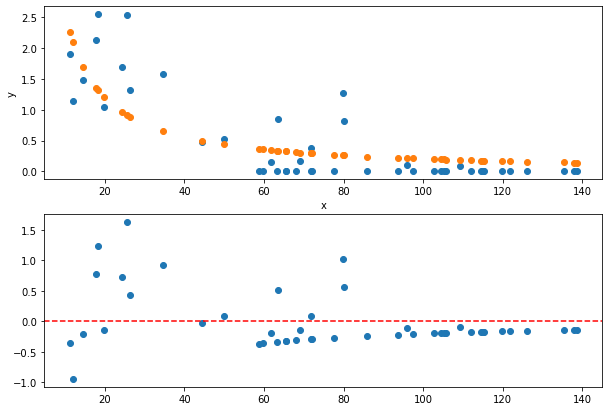

In [444]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xx[0], yy)
p0, a, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination  = np.median(sampler.results['samples'][:1000], axis = 0)
yy_model = model(xx, p0, a, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
plt.scatter(xx[0], yy_model)
#plt.xscale("log")
#plt.yscale("log")
plt.subplot(212)
plt.scatter(xx[0], yy - yy_model)
plt.axhline(0, linestyle = "--", c = "r")

## Test from toy model

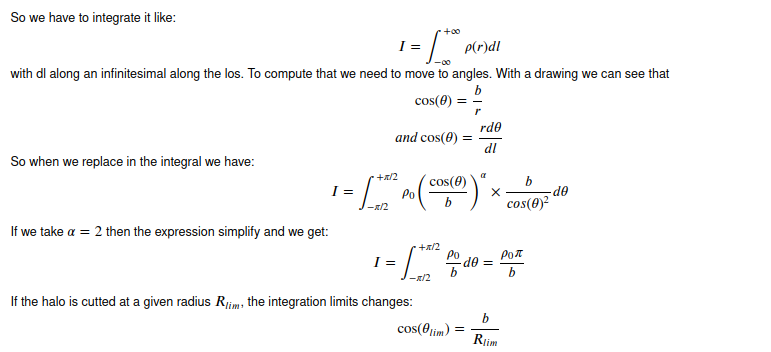

In [497]:
bb = np.linspace(10,150, 100)

def halo_model(bb, rho0, Rlim):
    K = bb/Rlim
    K[K>=1] = 0.999
    theta = np.arccos(K)
    print(len(theta))
    ww = rho0*2*theta/bb
    return ww

100


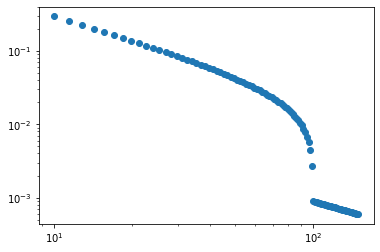

In [500]:
plt.scatter(bb, halo_model(bb, 1, 100))
plt.xscale("log")
plt.yscale("log")

In [511]:
xx = np.array(isol_snr3_good_runs_rot[["B_KPC", "Rvir", "Z", "logSFR", "alpha", "inclination"]])
xx = xx.T
yy = np.array(isol_snr3_good_runs_rot["REW_2796"])

In [512]:
def model(X, p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination):
    #W = p0 + X[0]*k_b + X[1]*k_M + X[2]*k_z + X[3]*k_sfr + X[4]*k_alpha + X[5]*k_inclination
    #W = p0*(X[0]/a)**(k_b)
    K = X[0]/Rlim
    K[K>=1] = 0.999
    theta = np.arccos(K)
    #print(len(theta))
    W = rho0*2*theta/X[0]
    return W


def log_likelihood(params):
    # unpack the current parameters:
    p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination = params

    # compute for each x point, where it should lie in y
    y_model = model(xx, p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
    # compute likelihood
    loglike = -0.5 * (((y_model - yy))**2).sum()

    return loglike

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -20 to +20
    params[0] = cube[0] * 40 - 20
    params[1] = cube[1] * 50+0.1
    params[2] = cube[2] * 200
    params[3] = cube[3] * 10 - 5
    params[4] = cube[4] * 10 - 5
    params[5] = cube[5] * 10 - 5
    params[6] = cube[6] * 10 - 5
    params[7] = cube[6] * 10 - 5
    return params

In [514]:
parameters = ['p0', 'rho0', 'Rlim', 'k_b', 'k_M', 'k_z', 'k_sfr', 'k_alpha', 'k_inclination']
sampler = ReactiveNestedSampler(parameters, log_likelihood, prior_transform)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=9+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88,

DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-276.27, Lmax=-4.97


DEBUG:ultranest:iteration=80, ncalls=883, regioncalls=3320, ndraw=40, logz=-183.73, remainder_fraction=100.0000%, Lmin=-176.78, Lmax=-4.97


DEBUG:ultranest:iteration=160, ncalls=978, regioncalls=7120, ndraw=40, logz=-135.54, remainder_fraction=100.0000%, Lmin=-128.92, Lmax=-4.97
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=197, ncalls=1025, regioncalls=9000, ndraw=40, logz=-113.42, remainder_fraction=100.0000%, Lmin=-106.54, Lmax=-4.97


DEBUG:ultranest:iteration=240, ncalls=1076, regioncalls=11040, ndraw=40, logz=-98.16, remainder_fraction=100.0000%, Lmin=-92.21, Lmax=-4.97


DEBUG:ultranest:iteration=320, ncalls=1192, regioncalls=15680, ndraw=40, logz=-73.99, remainder_fraction=100.0000%, Lmin=-68.17, Lmax=-4.97
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=358, ncalls=1247, regioncalls=17880, ndraw=40, logz=-64.27, remainder_fraction=100.0000%, Lmin=-58.56, Lmax=-4.97


DEBUG:ultranest:iteration=400, ncalls=1314, regioncalls=20560, ndraw=40, logz=-55.09, remainder_fraction=100.0000%, Lmin=-49.14, Lmax=-4.97


DEBUG:ultranest:iteration=480, ncalls=1447, regioncalls=25880, ndraw=40, logz=-40.53, remainder_fraction=100.0000%, Lmin=-35.46, Lmax=-4.97
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=537, ncalls=1532, regioncalls=29280, ndraw=40, logz=-33.80, remainder_fraction=100.0000%, Lmin=-28.77, Lmax=-4.97


DEBUG:ultranest:iteration=560, ncalls=1572, regioncalls=30880, ndraw=40, logz=-31.50, remainder_fraction=100.0000%, Lmin=-26.50, Lmax=-4.97


DEBUG:ultranest:iteration=635, ncalls=1707, regioncalls=36280, ndraw=40, logz=-24.25, remainder_fraction=100.0000%, Lmin=-19.35, Lmax=-4.97


DEBUG:ultranest:iteration=640, ncalls=1714, regioncalls=36560, ndraw=40, logz=-23.88, remainder_fraction=100.0000%, Lmin=-18.96, Lmax=-4.97
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=716, ncalls=1897, regioncalls=43880, ndraw=40, logz=-20.80, remainder_fraction=99.9998%, Lmin=-17.10, Lmax=-4.96


DEBUG:ultranest:iteration=720, ncalls=1901, regioncalls=44040, ndraw=40, logz=-20.72, remainder_fraction=99.9998%, Lmin=-17.05, Lmax=-4.96


DEBUG:ultranest:iteration=787, ncalls=2050, regioncalls=50000, ndraw=40, logz=-19.47, remainder_fraction=99.9992%, Lmin=-15.90, Lmax=-4.96


DEBUG:ultranest:iteration=800, ncalls=2080, regioncalls=51200, ndraw=40, logz=-19.27, remainder_fraction=99.9991%, Lmin=-15.80, Lmax=-4.96


DEBUG:ultranest:iteration=878, ncalls=2282, regioncalls=59280, ndraw=40, logz=-18.22, remainder_fraction=99.9972%, Lmin=-14.80, Lmax=-4.96


DEBUG:ultranest:iteration=880, ncalls=2287, regioncalls=59480, ndraw=40, logz=-18.20, remainder_fraction=99.9972%, Lmin=-14.79, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=907, ncalls=2350, regioncalls=62000, ndraw=40, logz=-17.89, remainder_fraction=99.9961%, Lmin=-14.63, Lmax=-4.96


DEBUG:ultranest:iteration=960, ncalls=2532, regioncalls=69280, ndraw=40, logz=-17.38, remainder_fraction=99.9935%, Lmin=-14.19, Lmax=-4.96


DEBUG:ultranest:iteration=1037, ncalls=2751, regioncalls=78040, ndraw=40, logz=-16.63, remainder_fraction=99.9858%, Lmin=-13.07, Lmax=-4.96


DEBUG:ultranest:iteration=1040, ncalls=2759, regioncalls=78360, ndraw=40, logz=-16.59, remainder_fraction=99.9853%, Lmin=-12.96, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1074, ncalls=2843, regioncalls=81720, ndraw=40, logz=-16.15, remainder_fraction=99.9769%, Lmin=-12.38, Lmax=-4.96


DEBUG:ultranest:iteration=1120, ncalls=2935, regioncalls=85400, ndraw=40, logz=-15.54, remainder_fraction=99.9566%, Lmin=-11.77, Lmax=-4.96


DEBUG:ultranest:iteration=1200, ncalls=3108, regioncalls=92320, ndraw=40, logz=-14.45, remainder_fraction=99.8728%, Lmin=-10.60, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1253, ncalls=3228, regioncalls=97120, ndraw=40, logz=-13.82, remainder_fraction=99.7610%, Lmin=-10.02, Lmax=-4.96


DEBUG:ultranest:iteration=1280, ncalls=3274, regioncalls=98960, ndraw=40, logz=-13.52, remainder_fraction=99.6772%, Lmin=-9.79, Lmax=-4.96


DEBUG:ultranest:iteration=1355, ncalls=3443, regioncalls=105720, ndraw=40, logz=-12.82, remainder_fraction=99.3613%, Lmin=-9.21, Lmax=-4.96


DEBUG:ultranest:iteration=1360, ncalls=3451, regioncalls=106040, ndraw=40, logz=-12.78, remainder_fraction=99.3326%, Lmin=-9.18, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1432, ncalls=3632, regioncalls=113280, ndraw=40, logz=-12.19, remainder_fraction=98.8078%, Lmin=-8.58, Lmax=-4.96


DEBUG:ultranest:iteration=1440, ncalls=3648, regioncalls=113920, ndraw=40, logz=-12.13, remainder_fraction=98.7356%, Lmin=-8.54, Lmax=-4.96


DEBUG:ultranest:iteration=1509, ncalls=3818, regioncalls=120720, ndraw=40, logz=-11.66, remainder_fraction=97.9941%, Lmin=-8.18, Lmax=-4.96


DEBUG:ultranest:iteration=1520, ncalls=3847, regioncalls=121880, ndraw=40, logz=-11.59, remainder_fraction=97.8493%, Lmin=-8.07, Lmax=-4.96


DEBUG:ultranest:iteration=1599, ncalls=4047, regioncalls=129880, ndraw=40, logz=-11.14, remainder_fraction=96.5749%, Lmin=-7.70, Lmax=-4.96


DEBUG:ultranest:iteration=1600, ncalls=4049, regioncalls=129960, ndraw=40, logz=-11.13, remainder_fraction=96.5537%, Lmin=-7.70, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1611, ncalls=4074, regioncalls=130960, ndraw=40, logz=-11.08, remainder_fraction=96.3448%, Lmin=-7.64, Lmax=-4.96


DEBUG:ultranest:iteration=1677, ncalls=4221, regioncalls=136840, ndraw=40, logz=-10.75, remainder_fraction=94.9479%, Lmin=-7.33, Lmax=-4.96


DEBUG:ultranest:iteration=1680, ncalls=4228, regioncalls=137120, ndraw=40, logz=-10.74, remainder_fraction=94.8849%, Lmin=-7.31, Lmax=-4.96


DEBUG:ultranest:iteration=1759, ncalls=4421, regioncalls=144840, ndraw=40, logz=-10.39, remainder_fraction=92.7021%, Lmin=-6.99, Lmax=-4.96


DEBUG:ultranest:iteration=1760, ncalls=4422, regioncalls=144880, ndraw=40, logz=-10.39, remainder_fraction=92.6686%, Lmin=-6.99, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1790, ncalls=4500, regioncalls=148000, ndraw=40, logz=-10.27, remainder_fraction=91.7033%, Lmin=-6.89, Lmax=-4.96


DEBUG:ultranest:iteration=1840, ncalls=4617, regioncalls=152680, ndraw=40, logz=-10.08, remainder_fraction=90.0396%, Lmin=-6.76, Lmax=-4.96


DEBUG:ultranest:iteration=1912, ncalls=4849, regioncalls=161960, ndraw=40, logz=-9.84, remainder_fraction=87.3544%, Lmin=-6.52, Lmax=-4.96


DEBUG:ultranest:iteration=1920, ncalls=4872, regioncalls=162880, ndraw=40, logz=-9.82, remainder_fraction=87.0506%, Lmin=-6.50, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1969, ncalls=5033, regioncalls=169320, ndraw=40, logz=-9.67, remainder_fraction=85.0006%, Lmin=-6.37, Lmax=-4.96


DEBUG:ultranest:iteration=2000, ncalls=5121, regioncalls=172840, ndraw=40, logz=-9.58, remainder_fraction=83.6548%, Lmin=-6.28, Lmax=-4.96


DEBUG:ultranest:iteration=2063, ncalls=5369, regioncalls=182760, ndraw=40, logz=-9.42, remainder_fraction=80.8372%, Lmin=-6.16, Lmax=-4.96


DEBUG:ultranest:iteration=2080, ncalls=5430, regioncalls=185200, ndraw=40, logz=-9.38, remainder_fraction=80.0749%, Lmin=-6.12, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2148, ncalls=5677, regioncalls=195120, ndraw=40, logz=-9.22, remainder_fraction=76.7594%, Lmin=-6.00, Lmax=-4.96


DEBUG:ultranest:iteration=2160, ncalls=5709, regioncalls=196400, ndraw=40, logz=-9.20, remainder_fraction=76.1542%, Lmin=-5.98, Lmax=-4.96


DEBUG:ultranest:iteration=2226, ncalls=5873, regioncalls=203000, ndraw=40, logz=-9.06, remainder_fraction=72.8195%, Lmin=-5.85, Lmax=-4.96


DEBUG:ultranest:iteration=2240, ncalls=5902, regioncalls=204160, ndraw=40, logz=-9.04, remainder_fraction=72.0740%, Lmin=-5.84, Lmax=-4.96


DEBUG:ultranest:iteration=2311, ncalls=6116, regioncalls=213000, ndraw=40, logz=-8.91, remainder_fraction=68.4000%, Lmin=-5.74, Lmax=-4.96


DEBUG:ultranest:iteration=2320, ncalls=6143, regioncalls=214120, ndraw=40, logz=-8.90, remainder_fraction=67.9318%, Lmin=-5.72, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2327, ncalls=6163, regioncalls=214920, ndraw=40, logz=-8.89, remainder_fraction=67.5626%, Lmin=-5.71, Lmax=-4.96


DEBUG:ultranest:iteration=2392, ncalls=6323, regioncalls=221440, ndraw=40, logz=-8.79, remainder_fraction=64.1572%, Lmin=-5.63, Lmax=-4.96


DEBUG:ultranest:iteration=2400, ncalls=6347, regioncalls=222400, ndraw=40, logz=-8.77, remainder_fraction=63.7255%, Lmin=-5.62, Lmax=-4.96


DEBUG:ultranest:iteration=2477, ncalls=6586, regioncalls=231960, ndraw=40, logz=-8.67, remainder_fraction=59.6458%, Lmin=-5.52, Lmax=-4.96


DEBUG:ultranest:iteration=2480, ncalls=6592, regioncalls=232200, ndraw=40, logz=-8.66, remainder_fraction=59.4752%, Lmin=-5.52, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2506, ncalls=6676, regioncalls=235560, ndraw=40, logz=-8.63, remainder_fraction=58.1227%, Lmin=-5.50, Lmax=-4.96


DEBUG:ultranest:iteration=2560, ncalls=6825, regioncalls=241720, ndraw=40, logz=-8.57, remainder_fraction=55.3321%, Lmin=-5.46, Lmax=-4.96


DEBUG:ultranest:iteration=2636, ncalls=7016, regioncalls=249560, ndraw=40, logz=-8.48, remainder_fraction=51.5336%, Lmin=-5.40, Lmax=-4.96


DEBUG:ultranest:iteration=2640, ncalls=7028, regioncalls=250040, ndraw=40, logz=-8.48, remainder_fraction=51.3345%, Lmin=-5.40, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2685, ncalls=7128, regioncalls=254040, ndraw=40, logz=-8.44, remainder_fraction=49.1092%, Lmin=-5.37, Lmax=-4.96


DEBUG:ultranest:iteration=2720, ncalls=7228, regioncalls=258680, ndraw=40, logz=-8.40, remainder_fraction=47.4536%, Lmin=-5.34, Lmax=-4.96


DEBUG:ultranest:iteration=2784, ncalls=7414, regioncalls=266520, ndraw=40, logz=-8.35, remainder_fraction=44.5159%, Lmin=-5.29, Lmax=-4.96


DEBUG:ultranest:iteration=2800, ncalls=7445, regioncalls=267840, ndraw=40, logz=-8.34, remainder_fraction=43.7949%, Lmin=-5.28, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2864, ncalls=7621, regioncalls=275400, ndraw=40, logz=-8.29, remainder_fraction=40.9937%, Lmin=-5.24, Lmax=-4.96


DEBUG:ultranest:iteration=2880, ncalls=7669, regioncalls=277400, ndraw=40, logz=-8.28, remainder_fraction=40.3098%, Lmin=-5.23, Lmax=-4.96


DEBUG:ultranest:iteration=2944, ncalls=7829, regioncalls=283800, ndraw=40, logz=-8.23, remainder_fraction=37.6598%, Lmin=-5.19, Lmax=-4.96


DEBUG:ultranest:iteration=2960, ncalls=7873, regioncalls=285600, ndraw=40, logz=-8.22, remainder_fraction=37.0069%, Lmin=-5.18, Lmax=-4.96


DEBUG:ultranest:iteration=3032, ncalls=8085, regioncalls=294800, ndraw=40, logz=-8.18, remainder_fraction=34.1674%, Lmin=-5.15, Lmax=-4.96


DEBUG:ultranest:iteration=3040, ncalls=8102, regioncalls=295480, ndraw=40, logz=-8.17, remainder_fraction=33.8649%, Lmin=-5.15, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3043, ncalls=8120, regioncalls=296200, ndraw=40, logz=-8.17, remainder_fraction=33.7551%, Lmin=-5.15, Lmax=-4.96


DEBUG:ultranest:iteration=3101, ncalls=8266, regioncalls=303080, ndraw=40, logz=-8.14, remainder_fraction=31.6230%, Lmin=-5.13, Lmax=-4.96


DEBUG:ultranest:iteration=3120, ncalls=8331, regioncalls=306680, ndraw=40, logz=-8.13, remainder_fraction=30.9373%, Lmin=-5.12, Lmax=-4.96


DEBUG:ultranest:iteration=3191, ncalls=8519, regioncalls=315800, ndraw=40, logz=-8.10, remainder_fraction=28.5231%, Lmin=-5.11, Lmax=-4.96


DEBUG:ultranest:iteration=3200, ncalls=8543, regioncalls=316920, ndraw=40, logz=-8.09, remainder_fraction=28.2210%, Lmin=-5.10, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3222, ncalls=8593, regioncalls=319640, ndraw=40, logz=-8.08, remainder_fraction=27.5085%, Lmin=-5.10, Lmax=-4.96


DEBUG:ultranest:iteration=3280, ncalls=8714, regioncalls=325040, ndraw=40, logz=-8.06, remainder_fraction=25.6983%, Lmin=-5.08, Lmax=-4.96


DEBUG:ultranest:iteration=3350, ncalls=8888, regioncalls=332760, ndraw=40, logz=-8.03, remainder_fraction=23.6630%, Lmin=-5.07, Lmax=-4.96


DEBUG:ultranest:iteration=3360, ncalls=8918, regioncalls=334160, ndraw=40, logz=-8.03, remainder_fraction=23.3873%, Lmin=-5.07, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3401, ncalls=9032, regioncalls=338760, ndraw=40, logz=-8.01, remainder_fraction=22.2787%, Lmin=-5.06, Lmax=-4.96


DEBUG:ultranest:iteration=3440, ncalls=9127, regioncalls=343120, ndraw=40, logz=-8.00, remainder_fraction=21.2660%, Lmin=-5.05, Lmax=-4.96


DEBUG:ultranest:iteration=3505, ncalls=9306, regioncalls=351080, ndraw=40, logz=-7.98, remainder_fraction=19.6704%, Lmin=-5.05, Lmax=-4.96


DEBUG:ultranest:iteration=3520, ncalls=9349, regioncalls=352920, ndraw=40, logz=-7.97, remainder_fraction=19.3195%, Lmin=-5.05, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3580, ncalls=9516, regioncalls=360360, ndraw=40, logz=-7.96, remainder_fraction=17.9780%, Lmin=-5.04, Lmax=-4.96


DEBUG:ultranest:iteration=3600, ncalls=9568, regioncalls=362440, ndraw=40, logz=-7.95, remainder_fraction=17.5483%, Lmin=-5.03, Lmax=-4.96


DEBUG:ultranest:iteration=3655, ncalls=9752, regioncalls=371080, ndraw=40, logz=-7.94, remainder_fraction=16.4194%, Lmin=-5.03, Lmax=-4.96


DEBUG:ultranest:iteration=3680, ncalls=9831, regioncalls=374680, ndraw=40, logz=-7.93, remainder_fraction=15.9269%, Lmin=-5.03, Lmax=-4.96


DEBUG:ultranest:iteration=3741, ncalls=10070, regioncalls=385240, ndraw=40, logz=-7.92, remainder_fraction=14.7892%, Lmin=-5.02, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3760, ncalls=10138, regioncalls=387960, ndraw=40, logz=-7.92, remainder_fraction=14.4527%, Lmin=-5.02, Lmax=-4.96


DEBUG:ultranest:iteration=3807, ncalls=10334, regioncalls=396320, ndraw=40, logz=-7.91, remainder_fraction=13.6515%, Lmin=-5.02, Lmax=-4.96


DEBUG:ultranest:iteration=3840, ncalls=10466, regioncalls=401960, ndraw=40, logz=-7.90, remainder_fraction=13.1126%, Lmin=-5.02, Lmax=-4.96


DEBUG:ultranest:iteration=3892, ncalls=10745, regioncalls=414480, ndraw=40, logz=-7.89, remainder_fraction=12.3065%, Lmin=-5.02, Lmax=-4.96


DEBUG:ultranest:iteration=3920, ncalls=10872, regioncalls=420360, ndraw=40, logz=-7.89, remainder_fraction=11.8931%, Lmin=-5.01, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3938, ncalls=10943, regioncalls=423600, ndraw=40, logz=-7.88, remainder_fraction=11.6341%, Lmin=-5.01, Lmax=-4.96


DEBUG:ultranest:iteration=3986, ncalls=11102, regioncalls=431640, ndraw=40, logz=-7.88, remainder_fraction=10.9703%, Lmin=-5.01, Lmax=-4.96


DEBUG:ultranest:iteration=4000, ncalls=11166, regioncalls=435040, ndraw=40, logz=-7.87, remainder_fraction=10.7845%, Lmin=-5.01, Lmax=-4.96


DEBUG:ultranest:iteration=4059, ncalls=11391, regioncalls=445400, ndraw=40, logz=-7.87, remainder_fraction=10.0333%, Lmin=-5.01, Lmax=-4.96


DEBUG:ultranest:iteration=4080, ncalls=11456, regioncalls=448560, ndraw=40, logz=-7.86, remainder_fraction=9.7785%, Lmin=-5.00, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4117, ncalls=11621, regioncalls=457200, ndraw=40, logz=-7.86, remainder_fraction=9.3449%, Lmin=-5.00, Lmax=-4.96


DEBUG:ultranest:iteration=4157, ncalls=11783, regioncalls=465960, ndraw=40, logz=-7.85, remainder_fraction=8.8986%, Lmin=-5.00, Lmax=-4.96


DEBUG:ultranest:iteration=4160, ncalls=11790, regioncalls=466360, ndraw=40, logz=-7.85, remainder_fraction=8.8658%, Lmin=-5.00, Lmax=-4.96


DEBUG:ultranest:iteration=4208, ncalls=11973, regioncalls=477280, ndraw=40, logz=-7.85, remainder_fraction=8.3573%, Lmin=-5.00, Lmax=-4.96


DEBUG:ultranest:iteration=4240, ncalls=12113, regioncalls=484640, ndraw=40, logz=-7.84, remainder_fraction=8.0359%, Lmin=-5.00, Lmax=-4.96


DEBUG:ultranest:iteration=4280, ncalls=12348, regioncalls=497840, ndraw=40, logz=-7.84, remainder_fraction=7.6499%, Lmin=-5.00, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4298, ncalls=12467, regioncalls=503200, ndraw=40, logz=-7.84, remainder_fraction=7.4829%, Lmin=-5.00, Lmax=-4.96


DEBUG:ultranest:iteration=4320, ncalls=12601, regioncalls=509920, ndraw=40, logz=-7.84, remainder_fraction=7.2830%, Lmin=-5.00, Lmax=-4.96


DEBUG:ultranest:iteration=4364, ncalls=12815, regioncalls=521240, ndraw=40, logz=-7.83, remainder_fraction=6.8992%, Lmin=-4.99, Lmax=-4.96


DEBUG:ultranest:iteration=4400, ncalls=13002, regioncalls=533320, ndraw=40, logz=-7.83, remainder_fraction=6.6002%, Lmin=-4.99, Lmax=-4.96


DEBUG:ultranest:iteration=4440, ncalls=13207, regioncalls=545560, ndraw=40, logz=-7.82, remainder_fraction=6.2823%, Lmin=-4.99, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4475, ncalls=13346, regioncalls=554000, ndraw=40, logz=-7.82, remainder_fraction=6.0174%, Lmin=-4.99, Lmax=-4.96


DEBUG:ultranest:iteration=4480, ncalls=13377, regioncalls=556400, ndraw=40, logz=-7.82, remainder_fraction=5.9804%, Lmin=-4.99, Lmax=-4.96


DEBUG:ultranest:iteration=4528, ncalls=13514, regioncalls=564680, ndraw=40, logz=-7.82, remainder_fraction=5.6364%, Lmin=-4.99, Lmax=-4.96


DEBUG:ultranest:iteration=4560, ncalls=13656, regioncalls=572120, ndraw=40, logz=-7.82, remainder_fraction=5.4184%, Lmin=-4.99, Lmax=-4.96


DEBUG:ultranest:iteration=4607, ncalls=13852, regioncalls=583600, ndraw=40, logz=-7.81, remainder_fraction=5.1133%, Lmin=-4.99, Lmax=-4.96


DEBUG:ultranest:iteration=4640, ncalls=13962, regioncalls=590240, ndraw=40, logz=-7.81, remainder_fraction=4.9089%, Lmin=-4.99, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4654, ncalls=14027, regioncalls=593760, ndraw=40, logz=-7.81, remainder_fraction=4.8248%, Lmin=-4.99, Lmax=-4.96


DEBUG:ultranest:iteration=4707, ncalls=14223, regioncalls=601600, ndraw=40, logz=-7.81, remainder_fraction=4.5187%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=4720, ncalls=14260, regioncalls=603080, ndraw=40, logz=-7.81, remainder_fraction=4.4467%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=4785, ncalls=14505, regioncalls=613080, ndraw=40, logz=-7.80, remainder_fraction=4.1034%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=4800, ncalls=14550, regioncalls=614920, ndraw=40, logz=-7.80, remainder_fraction=4.0278%, Lmin=-4.98, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4833, ncalls=14671, regioncalls=620200, ndraw=40, logz=-7.80, remainder_fraction=3.8664%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=4880, ncalls=14798, regioncalls=625800, ndraw=40, logz=-7.80, remainder_fraction=3.6478%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=4946, ncalls=15014, regioncalls=634520, ndraw=40, logz=-7.79, remainder_fraction=3.3613%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=4960, ncalls=15051, regioncalls=636000, ndraw=40, logz=-7.79, remainder_fraction=3.3035%, Lmin=-4.98, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5012, ncalls=15253, regioncalls=644560, ndraw=40, logz=-7.79, remainder_fraction=3.0972%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=5040, ncalls=15338, regioncalls=648680, ndraw=40, logz=-7.79, remainder_fraction=2.9915%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=5100, ncalls=15562, regioncalls=657880, ndraw=40, logz=-7.79, remainder_fraction=2.7767%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=5120, ncalls=15642, regioncalls=661080, ndraw=40, logz=-7.79, remainder_fraction=2.7085%, Lmin=-4.98, Lmax=-4.96


DEBUG:ultranest:iteration=5183, ncalls=15881, regioncalls=671120, ndraw=40, logz=-7.79, remainder_fraction=2.5045%, Lmin=-4.97, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5200, ncalls=15943, regioncalls=673720, ndraw=40, logz=-7.78, remainder_fraction=2.4522%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5248, ncalls=16143, regioncalls=682440, ndraw=40, logz=-7.78, remainder_fraction=2.3101%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5280, ncalls=16247, regioncalls=687000, ndraw=40, logz=-7.78, remainder_fraction=2.2200%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5345, ncalls=16497, regioncalls=697280, ndraw=40, logz=-7.78, remainder_fraction=2.0476%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5360, ncalls=16571, regioncalls=700240, ndraw=40, logz=-7.78, remainder_fraction=2.0097%, Lmin=-4.97, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5370, ncalls=16630, regioncalls=702680, ndraw=40, logz=-7.78, remainder_fraction=1.9849%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5418, ncalls=16828, regioncalls=711720, ndraw=40, logz=-7.78, remainder_fraction=1.8698%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5440, ncalls=16904, regioncalls=715120, ndraw=40, logz=-7.78, remainder_fraction=1.8192%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5491, ncalls=17163, regioncalls=727680, ndraw=40, logz=-7.78, remainder_fraction=1.7074%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5520, ncalls=17288, regioncalls=733600, ndraw=40, logz=-7.78, remainder_fraction=1.6468%, Lmin=-4.97, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5549, ncalls=17400, regioncalls=739840, ndraw=40, logz=-7.78, remainder_fraction=1.5884%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5600, ncalls=17563, regioncalls=747280, ndraw=40, logz=-7.78, remainder_fraction=1.4907%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5661, ncalls=17774, regioncalls=757040, ndraw=40, logz=-7.77, remainder_fraction=1.3816%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5680, ncalls=17830, regioncalls=759640, ndraw=40, logz=-7.77, remainder_fraction=1.3493%, Lmin=-4.97, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5728, ncalls=18057, regioncalls=771200, ndraw=40, logz=-7.77, remainder_fraction=1.2709%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5760, ncalls=18163, regioncalls=775520, ndraw=40, logz=-7.77, remainder_fraction=1.2212%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5817, ncalls=18356, regioncalls=784000, ndraw=40, logz=-7.77, remainder_fraction=1.1375%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5840, ncalls=18427, regioncalls=786840, ndraw=40, logz=-7.77, remainder_fraction=1.1053%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5904, ncalls=18642, regioncalls=795840, ndraw=40, logz=-7.77, remainder_fraction=1.0205%, Lmin=-4.97, Lmax=-4.96
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5907, ncalls=18665, regioncalls=796800, ndraw=40, logz=-7.77, remainder_fraction=1.0167%, Lmin=-4.97, Lmax=-4.96


DEBUG:ultranest:iteration=5920, ncalls=18709, regioncalls=798560, ndraw=40, logz=-7.77, remainder_fraction=1.0004%, Lmin=-4.97, Lmax=-4.96


[ultranest] Explored until L=-5  


INFO:ultranest:Explored until L=-5  


[ultranest] Likelihood function evaluations: 18709


INFO:ultranest:Likelihood function evaluations: 18709
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -7.771 +- 0.04506


INFO:ultranest:  logZ = -7.771 +- 0.04506


[ultranest] Effective samples strategy satisfied (ESS = 2804.5, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2804.5, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)


[ultranest]   logZ error budget: single: 0.05 bs:0.05 tail:0.01 total:0.05 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.05 bs:0.05 tail:0.01 total:0.05 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


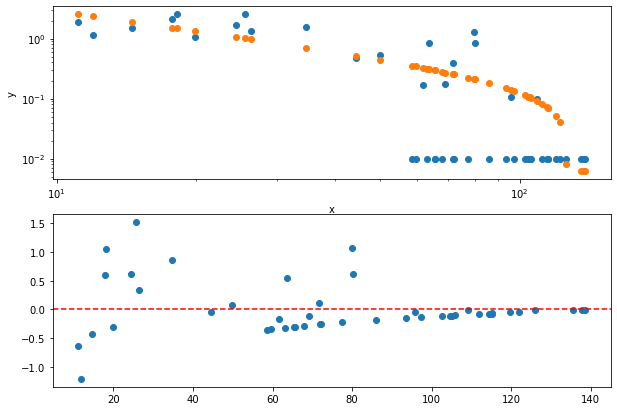

In [515]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xx[0], yy+0.01)
p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination  = np.median(sampler.results['samples'][:1000], axis = 0)
yy_model = model(xx, p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
plt.scatter(xx[0], yy_model)
plt.xscale("log")
plt.yscale("log")
plt.subplot(212)
plt.scatter(xx[0], yy - yy_model)
plt.axhline(0, linestyle = "--", c = "r")

In [516]:
def model(X, p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination):
    T = p0 + X[0]*k_b + X[1]*k_M + X[2]*k_z + X[3]*k_sfr + X[4]*k_alpha + X[5]*k_inclination
    #W = p0*(X[0]/a)**(k_b)
    K = X[0]/Rlim
    K[K>=1] = 0.999
    theta = np.arccos(K)
    #print(len(theta))
    W = rho0*2*theta/T
    return W


def log_likelihood(params):
    # unpack the current parameters:
    p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination = params

    # compute for each x point, where it should lie in y
    y_model = model(xx, p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
    # compute likelihood
    loglike = -0.5 * (((y_model - yy))**2).sum()

    return loglike

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -20 to +20
    params[0] = cube[0] * 40 - 20
    params[1] = cube[1] * 50+0.1
    params[2] = cube[2] * 200
    params[3] = cube[3] * 10 - 5
    params[4] = cube[4] * 10 - 5
    params[5] = cube[5] * 10 - 5
    params[6] = cube[6] * 10 - 5
    params[7] = cube[6] * 10 - 5
    return params

In [517]:
parameters = ['p0', 'rho0', 'Rlim', 'k_b', 'k_M', 'k_z', 'k_sfr', 'k_alpha', 'k_inclination']
sampler = ReactiveNestedSampler(parameters, log_likelihood, prior_transform)
result = sampler.run(min_num_live_points=800, dKL=np.inf, min_ess=100)

DEBUG:ultranest:ReactiveNestedSampler: dims=9+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 800 live points from prior ...


INFO:ultranest:Sampling 800 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=inf, frac_remain=0.01, Lepsilon=0.0010, min_ess=100
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=800, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 800.0), (inf, 800.0)]
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88,

DEBUG:ultranest:iteration=0, ncalls=801, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-576334.57, Lmax=-6.74


DEBUG:ultranest:iteration=67, ncalls=872, regioncalls=2880, ndraw=40, logz=-276.23, remainder_fraction=100.0000%, Lmin=-243.56, Lmax=-6.74


DEBUG:ultranest:iteration=80, ncalls=887, regioncalls=3480, ndraw=40, logz=-194.89, remainder_fraction=100.0000%, Lmin=-184.60, Lmax=-6.74


DEBUG:ultranest:iteration=160, ncalls=982, regioncalls=7280, ndraw=40, logz=-56.25, remainder_fraction=100.0000%, Lmin=-50.24, Lmax=-6.74
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=190, ncalls=1026, regioncalls=9040, ndraw=40, logz=-45.86, remainder_fraction=100.0000%, Lmin=-40.72, Lmax=-6.74


DEBUG:ultranest:iteration=240, ncalls=1086, regioncalls=11440, ndraw=40, logz=-33.21, remainder_fraction=100.0000%, Lmin=-28.26, Lmax=-6.74


DEBUG:ultranest:iteration=320, ncalls=1203, regioncalls=16120, ndraw=40, logz=-27.52, remainder_fraction=100.0000%, Lmin=-23.51, Lmax=-6.74
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=358, ncalls=1267, regioncalls=18680, ndraw=40, logz=-26.15, remainder_fraction=99.9999%, Lmin=-22.50, Lmax=-6.74


DEBUG:ultranest:iteration=400, ncalls=1328, regioncalls=21120, ndraw=40, logz=-24.92, remainder_fraction=99.9996%, Lmin=-21.46, Lmax=-6.74


DEBUG:ultranest:iteration=479, ncalls=1465, regioncalls=26600, ndraw=40, logz=-23.21, remainder_fraction=99.9978%, Lmin=-19.93, Lmax=-6.74


DEBUG:ultranest:iteration=480, ncalls=1467, regioncalls=26680, ndraw=40, logz=-23.19, remainder_fraction=99.9977%, Lmin=-19.93, Lmax=-6.74
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=537, ncalls=1584, regioncalls=31360, ndraw=40, logz=-22.27, remainder_fraction=99.9939%, Lmin=-19.25, Lmax=-6.74


DEBUG:ultranest:iteration=560, ncalls=1627, regioncalls=33080, ndraw=40, logz=-21.99, remainder_fraction=99.9916%, Lmin=-19.09, Lmax=-6.74


DEBUG:ultranest:iteration=630, ncalls=1782, regioncalls=39280, ndraw=40, logz=-21.31, remainder_fraction=99.9831%, Lmin=-18.64, Lmax=-6.74


DEBUG:ultranest:iteration=640, ncalls=1808, regioncalls=40320, ndraw=40, logz=-21.23, remainder_fraction=99.9838%, Lmin=-18.58, Lmax=-6.74
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([799,   1]))
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: S

DEBUG:ultranest:iteration=716, ncalls=1998, regioncalls=47920, ndraw=40, logz=-20.71, remainder_fraction=99.9710%, Lmin=-18.30, Lmax=-6.74


DEBUG:ultranest:iteration=720, ncalls=2013, regioncalls=48520, ndraw=40, logz=-20.69, remainder_fraction=99.9702%, Lmin=-18.28, Lmax=-6.74


DEBUG:ultranest:iteration=787, ncalls=2171, regioncalls=54840, ndraw=40, logz=-20.36, remainder_fraction=99.9576%, Lmin=-18.17, Lmax=-6.74


DEBUG:ultranest:iteration=800, ncalls=2201, regioncalls=56040, ndraw=40, logz=-20.31, remainder_fraction=99.9547%, Lmin=-18.15, Lmax=-6.74


DEBUG:ultranest:iteration=873, ncalls=2431, regioncalls=65240, ndraw=40, logz=-20.05, remainder_fraction=99.9365%, Lmin=-18.02, Lmax=-6.74


DEBUG:ultranest:iteration=880, ncalls=2461, regioncalls=66440, ndraw=40, logz=-20.03, remainder_fraction=99.9345%, Lmin=-18.00, Lmax=-6.74
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=904, ncalls=2535, regioncalls=69400, ndraw=40, logz=-19.96, remainder_fraction=99.9275%, Lmin=-17.93, Lmax=-6.74


DEBUG:ultranest:iteration=960, ncalls=2679, regioncalls=75160, ndraw=40, logz=-19.79, remainder_fraction=99.9189%, Lmin=-17.74, Lmax=-6.74


DEBUG:ultranest:iteration=1032, ncalls=2929, regioncalls=85160, ndraw=40, logz=-19.58, remainder_fraction=99.9109%, Lmin=-17.45, Lmax=-6.50


DEBUG:ultranest:iteration=1040, ncalls=2950, regioncalls=86000, ndraw=40, logz=-19.56, remainder_fraction=99.9081%, Lmin=-17.42, Lmax=-6.50
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1074, ncalls=3049, regioncalls=89960, ndraw=40, logz=-19.46, remainder_fraction=99.8957%, Lmin=-17.31, Lmax=-6.50


DEBUG:ultranest:iteration=1120, ncalls=3216, regioncalls=96640, ndraw=40, logz=-19.33, remainder_fraction=99.8795%, Lmin=-17.13, Lmax=-6.50


DEBUG:ultranest:iteration=1186, ncalls=3466, regioncalls=106640, ndraw=40, logz=-19.16, remainder_fraction=99.8597%, Lmin=-16.92, Lmax=-6.50


DEBUG:ultranest:iteration=1200, ncalls=3539, regioncalls=109560, ndraw=40, logz=-19.12, remainder_fraction=99.8626%, Lmin=-16.86, Lmax=-6.50
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1253, ncalls=3769, regioncalls=118760, ndraw=40, logz=-18.98, remainder_fraction=99.8547%, Lmin=-16.68, Lmax=-6.50


DEBUG:ultranest:iteration=1280, ncalls=3844, regioncalls=121760, ndraw=40, logz=-18.91, remainder_fraction=99.8702%, Lmin=-16.59, Lmax=-5.69


DEBUG:ultranest:iteration=1334, ncalls=4108, regioncalls=132320, ndraw=40, logz=-18.77, remainder_fraction=99.8641%, Lmin=-16.37, Lmax=-5.69


DEBUG:ultranest:iteration=1360, ncalls=4187, regioncalls=135480, ndraw=40, logz=-18.70, remainder_fraction=99.8511%, Lmin=-16.29, Lmax=-5.69


DEBUG:ultranest:iteration=1425, ncalls=4456, regioncalls=146240, ndraw=40, logz=-18.54, remainder_fraction=99.8136%, Lmin=-16.08, Lmax=-5.69
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([799,   1]))
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError:

DEBUG:ultranest:iteration=1440, ncalls=4510, regioncalls=148400, ndraw=40, logz=-18.50, remainder_fraction=99.8032%, Lmin=-16.03, Lmax=-5.69


DEBUG:ultranest:iteration=1486, ncalls=4762, regioncalls=158480, ndraw=40, logz=-18.40, remainder_fraction=99.7913%, Lmin=-15.92, Lmax=-5.69


DEBUG:ultranest:iteration=1520, ncalls=4898, regioncalls=163920, ndraw=40, logz=-18.32, remainder_fraction=99.7671%, Lmin=-15.80, Lmax=-5.69


DEBUG:ultranest:iteration=1576, ncalls=5202, regioncalls=176080, ndraw=40, logz=-18.19, remainder_fraction=99.7190%, Lmin=-15.66, Lmax=-5.69


DEBUG:ultranest:iteration=1600, ncalls=5341, regioncalls=181640, ndraw=40, logz=-18.14, remainder_fraction=99.6957%, Lmin=-15.61, Lmax=-5.69
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1611, ncalls=5380, regioncalls=183200, ndraw=40, logz=-18.12, remainder_fraction=99.6845%, Lmin=-15.59, Lmax=-5.69


DEBUG:ultranest:iteration=1664, ncalls=5639, regioncalls=193560, ndraw=40, logz=-18.01, remainder_fraction=99.6320%, Lmin=-15.45, Lmax=-5.69


DEBUG:ultranest:iteration=1680, ncalls=5713, regioncalls=196520, ndraw=40, logz=-17.98, remainder_fraction=99.6234%, Lmin=-15.41, Lmax=-5.69


DEBUG:ultranest:iteration=1742, ncalls=6052, regioncalls=210080, ndraw=40, logz=-17.86, remainder_fraction=99.5907%, Lmin=-15.27, Lmax=-5.69


DEBUG:ultranest:iteration=1760, ncalls=6163, regioncalls=214520, ndraw=40, logz=-17.82, remainder_fraction=99.5746%, Lmin=-15.22, Lmax=-5.69
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1790, ncalls=6370, regioncalls=222800, ndraw=40, logz=-17.77, remainder_fraction=99.5383%, Lmin=-15.14, Lmax=-5.69


DEBUG:ultranest:iteration=1839, ncalls=6659, regioncalls=234360, ndraw=40, logz=-17.68, remainder_fraction=99.4766%, Lmin=-15.00, Lmax=-5.69


DEBUG:ultranest:iteration=1840, ncalls=6660, regioncalls=234400, ndraw=40, logz=-17.68, remainder_fraction=99.4750%, Lmin=-15.00, Lmax=-5.69


DEBUG:ultranest:iteration=1894, ncalls=7039, regioncalls=249560, ndraw=40, logz=-17.58, remainder_fraction=99.4204%, Lmin=-14.85, Lmax=-5.69


DEBUG:ultranest:iteration=1920, ncalls=7176, regioncalls=255040, ndraw=40, logz=-17.53, remainder_fraction=99.4594%, Lmin=-14.77, Lmax=-5.36
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=1969, ncalls=7450, regioncalls=266000, ndraw=40, logz=-17.45, remainder_fraction=99.5280%, Lmin=-14.66, Lmax=-5.19


DEBUG:ultranest:iteration=2000, ncalls=7669, regioncalls=274760, ndraw=40, logz=-17.39, remainder_fraction=99.4888%, Lmin=-14.59, Lmax=-5.19


DEBUG:ultranest:iteration=2051, ncalls=8027, regioncalls=289080, ndraw=40, logz=-17.31, remainder_fraction=99.4295%, Lmin=-14.47, Lmax=-5.19


DEBUG:ultranest:iteration=2080, ncalls=8239, regioncalls=297560, ndraw=40, logz=-17.26, remainder_fraction=99.3837%, Lmin=-14.41, Lmax=-5.19


DEBUG:ultranest:iteration=2136, ncalls=8599, regioncalls=311960, ndraw=40, logz=-17.17, remainder_fraction=99.3055%, Lmin=-14.24, Lmax=-5.19
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2148, ncalls=8688, regioncalls=315520, ndraw=40, logz=-17.15, remainder_fraction=99.2828%, Lmin=-14.20, Lmax=-5.19


DEBUG:ultranest:iteration=2160, ncalls=8787, regioncalls=319480, ndraw=40, logz=-17.13, remainder_fraction=99.2580%, Lmin=-14.17, Lmax=-5.19


DEBUG:ultranest:iteration=2202, ncalls=9128, regioncalls=333120, ndraw=40, logz=-17.06, remainder_fraction=99.1780%, Lmin=-14.07, Lmax=-5.19


DEBUG:ultranest:iteration=2240, ncalls=9410, regioncalls=344400, ndraw=40, logz=-17.00, remainder_fraction=99.1042%, Lmin=-13.95, Lmax=-5.19


DEBUG:ultranest:iteration=2286, ncalls=9824, regioncalls=360960, ndraw=40, logz=-16.93, remainder_fraction=99.0164%, Lmin=-13.83, Lmax=-5.19


DEBUG:ultranest:iteration=2320, ncalls=10129, regioncalls=373160, ndraw=40, logz=-16.88, remainder_fraction=98.9778%, Lmin=-13.74, Lmax=-5.19
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2334, ncalls=10298, regioncalls=379920, ndraw=40, logz=-16.85, remainder_fraction=98.9647%, Lmin=-13.72, Lmax=-5.19


DEBUG:ultranest:iteration=2372, ncalls=10642, regioncalls=393680, ndraw=40, logz=-16.79, remainder_fraction=98.8665%, Lmin=-13.64, Lmax=-5.19


DEBUG:ultranest:iteration=2400, ncalls=10897, regioncalls=403880, ndraw=40, logz=-16.75, remainder_fraction=98.7858%, Lmin=-13.58, Lmax=-5.19


DEBUG:ultranest:iteration=2442, ncalls=11323, regioncalls=420920, ndraw=40, logz=-16.69, remainder_fraction=98.6883%, Lmin=-13.49, Lmax=-5.19


DEBUG:ultranest:iteration=2480, ncalls=11710, regioncalls=436400, ndraw=40, logz=-16.64, remainder_fraction=98.5959%, Lmin=-13.38, Lmax=-5.19
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2506, ncalls=12065, regioncalls=450600, ndraw=40, logz=-16.60, remainder_fraction=98.5330%, Lmin=-13.32, Lmax=-5.19


DEBUG:ultranest:iteration=2541, ncalls=12416, regioncalls=464640, ndraw=40, logz=-16.55, remainder_fraction=98.4707%, Lmin=-13.25, Lmax=-5.19


DEBUG:ultranest:iteration=2560, ncalls=12575, regioncalls=471000, ndraw=40, logz=-16.52, remainder_fraction=98.4235%, Lmin=-13.22, Lmax=-5.19


DEBUG:ultranest:iteration=2602, ncalls=13039, regioncalls=489560, ndraw=40, logz=-16.46, remainder_fraction=98.3890%, Lmin=-13.12, Lmax=-5.19


DEBUG:ultranest:iteration=2640, ncalls=13459, regioncalls=506360, ndraw=40, logz=-16.41, remainder_fraction=98.3806%, Lmin=-13.02, Lmax=-5.19


DEBUG:ultranest:iteration=2676, ncalls=13926, regioncalls=525040, ndraw=40, logz=-16.36, remainder_fraction=98.3490%, Lmin=-12.92, Lmax=-5.14
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2685, ncalls=14051, regioncalls=530040, ndraw=40, logz=-16.35, remainder_fraction=98.3159%, Lmin=-12.90, Lmax=-5.14


DEBUG:ultranest:iteration=2718, ncalls=14424, regioncalls=544960, ndraw=40, logz=-16.31, remainder_fraction=98.2116%, Lmin=-12.82, Lmax=-5.14


DEBUG:ultranest:iteration=2720, ncalls=14443, regioncalls=545720, ndraw=40, logz=-16.30, remainder_fraction=98.2031%, Lmin=-12.82, Lmax=-5.14


DEBUG:ultranest:iteration=2765, ncalls=14885, regioncalls=563400, ndraw=40, logz=-16.24, remainder_fraction=98.1281%, Lmin=-12.70, Lmax=-5.14


DEBUG:ultranest:iteration=2800, ncalls=15292, regioncalls=579680, ndraw=40, logz=-16.19, remainder_fraction=98.0445%, Lmin=-12.56, Lmax=-5.14


DEBUG:ultranest:iteration=2842, ncalls=15753, regioncalls=598120, ndraw=40, logz=-16.13, remainder_fraction=97.8427%, Lmin=-12.45, Lmax=-5.14
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=2864, ncalls=15995, regioncalls=607800, ndraw=40, logz=-16.10, remainder_fraction=97.7669%, Lmin=-12.39, Lmax=-5.14


DEBUG:ultranest:iteration=2880, ncalls=16205, regioncalls=616200, ndraw=40, logz=-16.08, remainder_fraction=97.6835%, Lmin=-12.36, Lmax=-5.14


DEBUG:ultranest:iteration=2926, ncalls=16566, regioncalls=630640, ndraw=40, logz=-16.02, remainder_fraction=97.6261%, Lmin=-12.29, Lmax=-4.72


DEBUG:ultranest:iteration=2960, ncalls=16810, regioncalls=640400, ndraw=40, logz=-15.97, remainder_fraction=97.5008%, Lmin=-12.18, Lmax=-4.72


DEBUG:ultranest:iteration=3001, ncalls=17274, regioncalls=658960, ndraw=40, logz=-15.91, remainder_fraction=97.5506%, Lmin=-12.09, Lmax=-4.72


DEBUG:ultranest:iteration=3040, ncalls=17743, regioncalls=677720, ndraw=40, logz=-15.86, remainder_fraction=97.3568%, Lmin=-12.02, Lmax=-4.72
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3053, ncalls=17909, regioncalls=684360, ndraw=40, logz=-15.85, remainder_fraction=97.2856%, Lmin=-11.99, Lmax=-4.72


DEBUG:ultranest:iteration=3088, ncalls=18320, regioncalls=700800, ndraw=40, logz=-15.80, remainder_fraction=97.2140%, Lmin=-11.90, Lmax=-4.72


DEBUG:ultranest:iteration=3120, ncalls=18650, regioncalls=714000, ndraw=40, logz=-15.76, remainder_fraction=97.0665%, Lmin=-11.82, Lmax=-4.72


DEBUG:ultranest:iteration=3161, ncalls=19138, regioncalls=733520, ndraw=40, logz=-15.71, remainder_fraction=96.9821%, Lmin=-11.73, Lmax=-4.72


DEBUG:ultranest:iteration=3200, ncalls=19586, regioncalls=751440, ndraw=40, logz=-15.66, remainder_fraction=96.7602%, Lmin=-11.63, Lmax=-4.72
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3222, ncalls=19869, regioncalls=762760, ndraw=40, logz=-15.63, remainder_fraction=96.6998%, Lmin=-11.58, Lmax=-4.72


DEBUG:ultranest:iteration=3252, ncalls=20286, regioncalls=779440, ndraw=40, logz=-15.59, remainder_fraction=96.5692%, Lmin=-11.52, Lmax=-4.72


DEBUG:ultranest:iteration=3280, ncalls=20555, regioncalls=790200, ndraw=40, logz=-15.55, remainder_fraction=96.4493%, Lmin=-11.45, Lmax=-4.72


DEBUG:ultranest:iteration=3321, ncalls=21017, regioncalls=808680, ndraw=40, logz=-15.50, remainder_fraction=96.1262%, Lmin=-11.36, Lmax=-4.72


DEBUG:ultranest:iteration=3354, ncalls=21526, regioncalls=829040, ndraw=40, logz=-15.46, remainder_fraction=95.9100%, Lmin=-11.27, Lmax=-4.72


DEBUG:ultranest:iteration=3360, ncalls=21577, regioncalls=831080, ndraw=40, logz=-15.45, remainder_fraction=95.8627%, Lmin=-11.26, Lmax=-4.72


DEBUG:ultranest:iteration=3397, ncalls=22092, regioncalls=851680, ndraw=40, logz=-15.41, remainder_fraction=95.7080%, Lmin=-11.18, Lmax=-4.72
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3408, ncalls=22240, regioncalls=857600, ndraw=40, logz=-15.40, remainder_fraction=95.5978%, Lmin=-11.14, Lmax=-4.72


DEBUG:ultranest:iteration=3440, ncalls=22658, regioncalls=874320, ndraw=40, logz=-15.36, remainder_fraction=95.5955%, Lmin=-11.06, Lmax=-4.27


DEBUG:ultranest:iteration=3476, ncalls=23134, regioncalls=893640, ndraw=40, logz=-15.31, remainder_fraction=95.3736%, Lmin=-10.96, Lmax=-4.27


DEBUG:ultranest:iteration=3508, ncalls=23656, regioncalls=914520, ndraw=40, logz=-15.27, remainder_fraction=95.1317%, Lmin=-10.87, Lmax=-4.27


DEBUG:ultranest:iteration=3520, ncalls=23807, regioncalls=920560, ndraw=40, logz=-15.25, remainder_fraction=95.1059%, Lmin=-10.84, Lmax=-4.27


DEBUG:ultranest:iteration=3552, ncalls=24358, regioncalls=942680, ndraw=40, logz=-15.21, remainder_fraction=94.9837%, Lmin=-10.74, Lmax=-4.27
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3580, ncalls=24743, regioncalls=958080, ndraw=40, logz=-15.18, remainder_fraction=94.9777%, Lmin=-10.68, Lmax=-4.27


DEBUG:ultranest:iteration=3600, ncalls=25084, regioncalls=972160, ndraw=40, logz=-15.15, remainder_fraction=94.7993%, Lmin=-10.64, Lmax=-4.27


DEBUG:ultranest:iteration=3633, ncalls=25552, regioncalls=991280, ndraw=40, logz=-15.11, remainder_fraction=94.8114%, Lmin=-10.56, Lmax=-4.27


DEBUG:ultranest:iteration=3657, ncalls=26071, regioncalls=1012720, ndraw=40, logz=-15.08, remainder_fraction=94.8176%, Lmin=-10.50, Lmax=-4.27


DEBUG:ultranest:iteration=3680, ncalls=26341, regioncalls=1023520, ndraw=40, logz=-15.05, remainder_fraction=94.5726%, Lmin=-10.44, Lmax=-4.27


DEBUG:ultranest:iteration=3713, ncalls=26897, regioncalls=1046160, ndraw=40, logz=-15.01, remainder_fraction=94.3017%, Lmin=-10.36, Lmax=-4.27


DEBUG:ultranest:iteration=3741, ncalls=27441, regioncalls=1067920, ndraw=40, logz=-14.97, remainder_fraction=94.0114%, Lmin=-10.30, Lmax=-4.27
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3759, ncalls=27875, regioncalls=1085800, ndraw=40, logz=-14.95, remainder_fraction=94.1573%, Lmin=-10.26, Lmax=-4.27


DEBUG:ultranest:iteration=3760, ncalls=27894, regioncalls=1086560, ndraw=40, logz=-14.95, remainder_fraction=94.1457%, Lmin=-10.26, Lmax=-4.27


DEBUG:ultranest:iteration=3792, ncalls=28264, regioncalls=1101840, ndraw=40, logz=-14.91, remainder_fraction=93.9148%, Lmin=-10.18, Lmax=-4.27


DEBUG:ultranest:iteration=3829, ncalls=28749, regioncalls=1121800, ndraw=40, logz=-14.87, remainder_fraction=93.6195%, Lmin=-10.09, Lmax=-4.27


DEBUG:ultranest:iteration=3840, ncalls=28948, regioncalls=1129760, ndraw=40, logz=-14.85, remainder_fraction=93.4743%, Lmin=-10.08, Lmax=-4.27


DEBUG:ultranest:iteration=3870, ncalls=29447, regioncalls=1150880, ndraw=40, logz=-14.82, remainder_fraction=93.2046%, Lmin=-10.02, Lmax=-4.27


DEBUG:ultranest:iteration=3899, ncalls=29974, regioncalls=1172360, ndraw=40, logz=-14.78, remainder_fraction=92.9713%, Lmin=-9.97, Lmax=-4.27


DEBUG:ultranest:iteration=3920, ncalls=30296, regioncalls=1186120, ndraw=40, logz=-14.76, remainder_fraction=92.8473%, Lmin=-9.91, Lmax=-4.27
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=3938, ncalls=30728, regioncalls=1204400, ndraw=40, logz=-14.74, remainder_fraction=92.7739%, Lmin=-9.87, Lmax=-4.27


DEBUG:ultranest:iteration=3952, ncalls=31129, regioncalls=1221600, ndraw=40, logz=-14.72, remainder_fraction=92.6741%, Lmin=-9.83, Lmax=-4.27


DEBUG:ultranest:iteration=3976, ncalls=31663, regioncalls=1243720, ndraw=40, logz=-14.69, remainder_fraction=92.4310%, Lmin=-9.79, Lmax=-4.27


DEBUG:ultranest:iteration=4000, ncalls=32109, regioncalls=1262240, ndraw=40, logz=-14.66, remainder_fraction=92.3036%, Lmin=-9.74, Lmax=-4.27


DEBUG:ultranest:iteration=4025, ncalls=32651, regioncalls=1285800, ndraw=40, logz=-14.63, remainder_fraction=92.0061%, Lmin=-9.69, Lmax=-4.27


DEBUG:ultranest:iteration=4055, ncalls=33163, regioncalls=1306720, ndraw=40, logz=-14.60, remainder_fraction=91.6316%, Lmin=-9.62, Lmax=-4.27


DEBUG:ultranest:iteration=4080, ncalls=33662, regioncalls=1327680, ndraw=40, logz=-14.57, remainder_fraction=91.4308%, Lmin=-9.53, Lmax=-4.27


DEBUG:ultranest:iteration=4109, ncalls=34176, regioncalls=1348840, ndraw=40, logz=-14.54, remainder_fraction=91.4450%, Lmin=-9.47, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4118, ncalls=34372, regioncalls=1357040, ndraw=40, logz=-14.53, remainder_fraction=91.3372%, Lmin=-9.45, Lmax=-3.54


DEBUG:ultranest:iteration=4139, ncalls=34809, regioncalls=1374960, ndraw=40, logz=-14.50, remainder_fraction=91.2271%, Lmin=-9.42, Lmax=-3.54


DEBUG:ultranest:iteration=4158, ncalls=35368, regioncalls=1398840, ndraw=40, logz=-14.48, remainder_fraction=90.9316%, Lmin=-9.37, Lmax=-3.54


DEBUG:ultranest:iteration=4160, ncalls=35406, regioncalls=1400360, ndraw=40, logz=-14.48, remainder_fraction=90.9031%, Lmin=-9.36, Lmax=-3.54


DEBUG:ultranest:iteration=4196, ncalls=35864, regioncalls=1419600, ndraw=40, logz=-14.44, remainder_fraction=90.5222%, Lmin=-9.27, Lmax=-3.54


DEBUG:ultranest:iteration=4221, ncalls=36360, regioncalls=1440760, ndraw=40, logz=-14.41, remainder_fraction=90.2858%, Lmin=-9.22, Lmax=-3.54


DEBUG:ultranest:iteration=4239, ncalls=36896, regioncalls=1463360, ndraw=40, logz=-14.39, remainder_fraction=90.0638%, Lmin=-9.19, Lmax=-3.54


DEBUG:ultranest:iteration=4240, ncalls=36916, regioncalls=1464160, ndraw=40, logz=-14.39, remainder_fraction=90.0435%, Lmin=-9.18, Lmax=-3.54


DEBUG:ultranest:iteration=4261, ncalls=37441, regioncalls=1486400, ndraw=40, logz=-14.36, remainder_fraction=89.9196%, Lmin=-9.13, Lmax=-3.54


DEBUG:ultranest:iteration=4283, ncalls=37906, regioncalls=1506680, ndraw=40, logz=-14.34, remainder_fraction=89.7774%, Lmin=-9.09, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4296, ncalls=38208, regioncalls=1519760, ndraw=40, logz=-14.32, remainder_fraction=89.5716%, Lmin=-9.07, Lmax=-3.54


DEBUG:ultranest:iteration=4314, ncalls=38598, regioncalls=1538600, ndraw=40, logz=-14.30, remainder_fraction=89.1935%, Lmin=-9.02, Lmax=-3.54


DEBUG:ultranest:iteration=4320, ncalls=38692, regioncalls=1543560, ndraw=40, logz=-14.30, remainder_fraction=89.2052%, Lmin=-9.01, Lmax=-3.54


DEBUG:ultranest:iteration=4338, ncalls=39109, regioncalls=1563680, ndraw=40, logz=-14.28, remainder_fraction=88.9518%, Lmin=-8.97, Lmax=-3.54


DEBUG:ultranest:iteration=4359, ncalls=39560, regioncalls=1584800, ndraw=40, logz=-14.25, remainder_fraction=88.6171%, Lmin=-8.92, Lmax=-3.54


DEBUG:ultranest:iteration=4379, ncalls=39964, regioncalls=1605480, ndraw=40, logz=-14.23, remainder_fraction=88.5071%, Lmin=-8.88, Lmax=-3.54


DEBUG:ultranest:iteration=4400, ncalls=40279, regioncalls=1619680, ndraw=40, logz=-14.21, remainder_fraction=88.3942%, Lmin=-8.83, Lmax=-3.54


DEBUG:ultranest:iteration=4422, ncalls=40680, regioncalls=1639000, ndraw=40, logz=-14.18, remainder_fraction=88.1733%, Lmin=-8.78, Lmax=-3.54


DEBUG:ultranest:iteration=4441, ncalls=41097, regioncalls=1660040, ndraw=40, logz=-14.16, remainder_fraction=87.8305%, Lmin=-8.73, Lmax=-3.54


DEBUG:ultranest:iteration=4471, ncalls=41514, regioncalls=1679160, ndraw=40, logz=-14.13, remainder_fraction=87.4807%, Lmin=-8.64, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4476, ncalls=41632, regioncalls=1686440, ndraw=40, logz=-14.12, remainder_fraction=87.3932%, Lmin=-8.62, Lmax=-3.54


DEBUG:ultranest:iteration=4480, ncalls=41694, regioncalls=1689960, ndraw=40, logz=-14.12, remainder_fraction=87.2945%, Lmin=-8.61, Lmax=-3.54


DEBUG:ultranest:iteration=4503, ncalls=42101, regioncalls=1709560, ndraw=40, logz=-14.09, remainder_fraction=86.8777%, Lmin=-8.56, Lmax=-3.54


DEBUG:ultranest:iteration=4516, ncalls=42593, regioncalls=1734960, ndraw=40, logz=-14.08, remainder_fraction=86.6629%, Lmin=-8.52, Lmax=-3.54


DEBUG:ultranest:iteration=4532, ncalls=43046, regioncalls=1756760, ndraw=40, logz=-14.06, remainder_fraction=86.2918%, Lmin=-8.49, Lmax=-3.54


DEBUG:ultranest:iteration=4553, ncalls=43409, regioncalls=1775840, ndraw=40, logz=-14.04, remainder_fraction=85.8994%, Lmin=-8.45, Lmax=-3.54


DEBUG:ultranest:iteration=4560, ncalls=43660, regioncalls=1789040, ndraw=40, logz=-14.03, remainder_fraction=85.8005%, Lmin=-8.44, Lmax=-3.54


DEBUG:ultranest:iteration=4574, ncalls=44090, regioncalls=1810720, ndraw=40, logz=-14.01, remainder_fraction=85.5281%, Lmin=-8.41, Lmax=-3.54


DEBUG:ultranest:iteration=4587, ncalls=44502, regioncalls=1832320, ndraw=40, logz=-14.00, remainder_fraction=85.2377%, Lmin=-8.39, Lmax=-3.54


DEBUG:ultranest:iteration=4607, ncalls=44840, regioncalls=1850680, ndraw=40, logz=-13.98, remainder_fraction=84.9888%, Lmin=-8.33, Lmax=-3.54


DEBUG:ultranest:iteration=4624, ncalls=45358, regioncalls=1877000, ndraw=40, logz=-13.96, remainder_fraction=84.6820%, Lmin=-8.30, Lmax=-3.54


DEBUG:ultranest:iteration=4640, ncalls=45588, regioncalls=1889280, ndraw=40, logz=-13.94, remainder_fraction=84.4205%, Lmin=-8.25, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4654, ncalls=45878, regioncalls=1905600, ndraw=40, logz=-13.92, remainder_fraction=84.1069%, Lmin=-8.23, Lmax=-3.54


DEBUG:ultranest:iteration=4670, ncalls=46183, regioncalls=1921960, ndraw=40, logz=-13.91, remainder_fraction=83.8881%, Lmin=-8.19, Lmax=-3.54


DEBUG:ultranest:iteration=4684, ncalls=46696, regioncalls=1948240, ndraw=40, logz=-13.89, remainder_fraction=83.5631%, Lmin=-8.18, Lmax=-3.54


DEBUG:ultranest:iteration=4699, ncalls=47098, regioncalls=1971000, ndraw=40, logz=-13.87, remainder_fraction=83.2060%, Lmin=-8.16, Lmax=-3.54


DEBUG:ultranest:iteration=4716, ncalls=47533, regioncalls=1994720, ndraw=40, logz=-13.86, remainder_fraction=82.9806%, Lmin=-8.13, Lmax=-3.54


DEBUG:ultranest:iteration=4720, ncalls=47691, regioncalls=2002720, ndraw=40, logz=-13.85, remainder_fraction=82.9345%, Lmin=-8.12, Lmax=-3.54


DEBUG:ultranest:iteration=4735, ncalls=48071, regioncalls=2022320, ndraw=40, logz=-13.84, remainder_fraction=82.6896%, Lmin=-8.09, Lmax=-3.54


DEBUG:ultranest:iteration=4751, ncalls=48459, regioncalls=2043320, ndraw=40, logz=-13.82, remainder_fraction=82.3184%, Lmin=-8.06, Lmax=-3.54


DEBUG:ultranest:iteration=4767, ncalls=48937, regioncalls=2067880, ndraw=40, logz=-13.80, remainder_fraction=81.9649%, Lmin=-8.02, Lmax=-3.54


DEBUG:ultranest:iteration=4777, ncalls=49302, regioncalls=2088360, ndraw=40, logz=-13.79, remainder_fraction=81.6505%, Lmin=-7.99, Lmax=-3.54


DEBUG:ultranest:iteration=4793, ncalls=49680, regioncalls=2108560, ndraw=40, logz=-13.78, remainder_fraction=81.2890%, Lmin=-7.96, Lmax=-3.54


DEBUG:ultranest:iteration=4800, ncalls=49911, regioncalls=2119600, ndraw=40, logz=-13.77, remainder_fraction=81.2121%, Lmin=-7.96, Lmax=-3.54


DEBUG:ultranest:iteration=4817, ncalls=50294, regioncalls=2139280, ndraw=40, logz=-13.75, remainder_fraction=80.8915%, Lmin=-7.93, Lmax=-3.54


DEBUG:ultranest:iteration=4828, ncalls=50727, regioncalls=2163360, ndraw=40, logz=-13.74, remainder_fraction=80.6814%, Lmin=-7.92, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=4833, ncalls=50833, regioncalls=2168840, ndraw=40, logz=-13.73, remainder_fraction=80.5812%, Lmin=-7.91, Lmax=-3.54


DEBUG:ultranest:iteration=4848, ncalls=51056, regioncalls=2183080, ndraw=40, logz=-13.72, remainder_fraction=80.1956%, Lmin=-7.89, Lmax=-3.54


DEBUG:ultranest:iteration=4873, ncalls=51354, regioncalls=2199680, ndraw=40, logz=-13.70, remainder_fraction=79.8473%, Lmin=-7.86, Lmax=-3.54


DEBUG:ultranest:iteration=4880, ncalls=51431, regioncalls=2204680, ndraw=40, logz=-13.69, remainder_fraction=79.8085%, Lmin=-7.84, Lmax=-3.54


DEBUG:ultranest:iteration=4896, ncalls=51713, regioncalls=2222040, ndraw=40, logz=-13.67, remainder_fraction=79.3608%, Lmin=-7.80, Lmax=-3.54


DEBUG:ultranest:iteration=4912, ncalls=51964, regioncalls=2239080, ndraw=40, logz=-13.66, remainder_fraction=79.3710%, Lmin=-7.78, Lmax=-3.54


DEBUG:ultranest:iteration=4934, ncalls=52319, regioncalls=2258480, ndraw=40, logz=-13.64, remainder_fraction=78.8470%, Lmin=-7.74, Lmax=-3.54


DEBUG:ultranest:iteration=4954, ncalls=52600, regioncalls=2275040, ndraw=40, logz=-13.62, remainder_fraction=78.3467%, Lmin=-7.71, Lmax=-3.54


DEBUG:ultranest:iteration=4960, ncalls=52669, regioncalls=2278960, ndraw=40, logz=-13.61, remainder_fraction=78.1637%, Lmin=-7.70, Lmax=-3.54


DEBUG:ultranest:iteration=4977, ncalls=53013, regioncalls=2298160, ndraw=40, logz=-13.60, remainder_fraction=77.8248%, Lmin=-7.67, Lmax=-3.54


DEBUG:ultranest:iteration=4998, ncalls=53264, regioncalls=2314200, ndraw=40, logz=-13.58, remainder_fraction=77.3431%, Lmin=-7.60, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5012, ncalls=53550, regioncalls=2332880, ndraw=40, logz=-13.56, remainder_fraction=77.2243%, Lmin=-7.57, Lmax=-3.54


DEBUG:ultranest:iteration=5027, ncalls=53792, regioncalls=2348800, ndraw=40, logz=-13.55, remainder_fraction=77.0021%, Lmin=-7.54, Lmax=-3.54


DEBUG:ultranest:iteration=5038, ncalls=54067, regioncalls=2366160, ndraw=40, logz=-13.54, remainder_fraction=76.6974%, Lmin=-7.52, Lmax=-3.54


DEBUG:ultranest:iteration=5040, ncalls=54098, regioncalls=2367880, ndraw=40, logz=-13.54, remainder_fraction=76.6440%, Lmin=-7.51, Lmax=-3.54


DEBUG:ultranest:iteration=5055, ncalls=54383, regioncalls=2386240, ndraw=40, logz=-13.52, remainder_fraction=76.2386%, Lmin=-7.47, Lmax=-3.54


DEBUG:ultranest:iteration=5068, ncalls=54664, regioncalls=2403920, ndraw=40, logz=-13.51, remainder_fraction=75.8389%, Lmin=-7.45, Lmax=-3.54


DEBUG:ultranest:iteration=5083, ncalls=54883, regioncalls=2420280, ndraw=40, logz=-13.50, remainder_fraction=75.5071%, Lmin=-7.43, Lmax=-3.54


DEBUG:ultranest:iteration=5094, ncalls=55153, regioncalls=2438760, ndraw=40, logz=-13.48, remainder_fraction=75.3399%, Lmin=-7.41, Lmax=-3.54


DEBUG:ultranest:iteration=5106, ncalls=55407, regioncalls=2456480, ndraw=40, logz=-13.47, remainder_fraction=75.0643%, Lmin=-7.39, Lmax=-3.54


DEBUG:ultranest:iteration=5120, ncalls=55648, regioncalls=2472560, ndraw=40, logz=-13.46, remainder_fraction=74.8574%, Lmin=-7.34, Lmax=-3.54


DEBUG:ultranest:iteration=5136, ncalls=55911, regioncalls=2491360, ndraw=40, logz=-13.45, remainder_fraction=74.5474%, Lmin=-7.31, Lmax=-3.54


DEBUG:ultranest:iteration=5148, ncalls=56177, regioncalls=2511160, ndraw=40, logz=-13.43, remainder_fraction=74.3458%, Lmin=-7.29, Lmax=-3.54


DEBUG:ultranest:iteration=5165, ncalls=56488, regioncalls=2530440, ndraw=40, logz=-13.42, remainder_fraction=73.9063%, Lmin=-7.27, Lmax=-3.54


DEBUG:ultranest:iteration=5180, ncalls=56800, regioncalls=2551400, ndraw=40, logz=-13.40, remainder_fraction=73.7645%, Lmin=-7.24, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5191, ncalls=57017, regioncalls=2569200, ndraw=40, logz=-13.39, remainder_fraction=73.5327%, Lmin=-7.21, Lmax=-3.54


DEBUG:ultranest:iteration=5200, ncalls=57069, regioncalls=2575080, ndraw=40, logz=-13.39, remainder_fraction=73.3696%, Lmin=-7.18, Lmax=-3.54


DEBUG:ultranest:iteration=5208, ncalls=57294, regioncalls=2596600, ndraw=40, logz=-13.38, remainder_fraction=73.3295%, Lmin=-7.16, Lmax=-3.54


DEBUG:ultranest:iteration=5219, ncalls=57464, regioncalls=2614200, ndraw=40, logz=-13.37, remainder_fraction=72.9370%, Lmin=-7.12, Lmax=-3.54


DEBUG:ultranest:iteration=5227, ncalls=57667, regioncalls=2632560, ndraw=40, logz=-13.36, remainder_fraction=72.6796%, Lmin=-7.10, Lmax=-3.54


DEBUG:ultranest:iteration=5234, ncalls=57852, regioncalls=2650840, ndraw=40, logz=-13.35, remainder_fraction=72.5516%, Lmin=-7.09, Lmax=-3.54


DEBUG:ultranest:iteration=5245, ncalls=58044, regioncalls=2668960, ndraw=40, logz=-13.34, remainder_fraction=72.1585%, Lmin=-7.08, Lmax=-3.54


DEBUG:ultranest:iteration=5259, ncalls=58230, regioncalls=2686000, ndraw=40, logz=-13.33, remainder_fraction=71.9430%, Lmin=-7.07, Lmax=-3.54


DEBUG:ultranest:iteration=5270, ncalls=58412, regioncalls=2703560, ndraw=40, logz=-13.32, remainder_fraction=71.6199%, Lmin=-7.05, Lmax=-3.54


DEBUG:ultranest:iteration=5280, ncalls=58603, regioncalls=2723280, ndraw=40, logz=-13.31, remainder_fraction=71.3617%, Lmin=-7.04, Lmax=-3.54


DEBUG:ultranest:iteration=5291, ncalls=58796, regioncalls=2742120, ndraw=40, logz=-13.30, remainder_fraction=71.0671%, Lmin=-7.00, Lmax=-3.54


DEBUG:ultranest:iteration=5301, ncalls=58949, regioncalls=2759000, ndraw=40, logz=-13.29, remainder_fraction=70.9794%, Lmin=-6.99, Lmax=-3.54


DEBUG:ultranest:iteration=5312, ncalls=59117, regioncalls=2776000, ndraw=40, logz=-13.28, remainder_fraction=70.6399%, Lmin=-6.98, Lmax=-3.54


DEBUG:ultranest:iteration=5321, ncalls=59304, regioncalls=2795040, ndraw=40, logz=-13.27, remainder_fraction=70.3281%, Lmin=-6.96, Lmax=-3.54


DEBUG:ultranest:iteration=5331, ncalls=59492, regioncalls=2813080, ndraw=40, logz=-13.27, remainder_fraction=69.9911%, Lmin=-6.95, Lmax=-3.54


DEBUG:ultranest:iteration=5343, ncalls=59686, regioncalls=2833640, ndraw=40, logz=-13.26, remainder_fraction=69.6086%, Lmin=-6.92, Lmax=-3.54


DEBUG:ultranest:iteration=5353, ncalls=59872, regioncalls=2852000, ndraw=40, logz=-13.25, remainder_fraction=69.3924%, Lmin=-6.91, Lmax=-3.54


DEBUG:ultranest:iteration=5360, ncalls=59956, regioncalls=2861080, ndraw=40, logz=-13.24, remainder_fraction=69.2866%, Lmin=-6.89, Lmax=-3.54


DEBUG:ultranest:iteration=5368, ncalls=60120, regioncalls=2880360, ndraw=40, logz=-13.23, remainder_fraction=69.1485%, Lmin=-6.88, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5370, ncalls=60129, regioncalls=2880880, ndraw=40, logz=-13.23, remainder_fraction=69.0842%, Lmin=-6.88, Lmax=-3.54


DEBUG:ultranest:iteration=5401, ncalls=60452, regioncalls=2894160, ndraw=40, logz=-13.21, remainder_fraction=68.1764%, Lmin=-6.84, Lmax=-3.54


DEBUG:ultranest:iteration=5437, ncalls=60866, regioncalls=2910960, ndraw=40, logz=-13.17, remainder_fraction=67.4001%, Lmin=-6.77, Lmax=-3.54


DEBUG:ultranest:iteration=5440, ncalls=60898, regioncalls=2912240, ndraw=40, logz=-13.17, remainder_fraction=67.2832%, Lmin=-6.77, Lmax=-3.54


DEBUG:ultranest:iteration=5473, ncalls=61222, regioncalls=2927840, ndraw=40, logz=-13.14, remainder_fraction=66.4431%, Lmin=-6.71, Lmax=-3.54


DEBUG:ultranest:iteration=5506, ncalls=61640, regioncalls=2944920, ndraw=40, logz=-13.12, remainder_fraction=65.6147%, Lmin=-6.66, Lmax=-3.54


DEBUG:ultranest:iteration=5520, ncalls=61838, regioncalls=2953200, ndraw=40, logz=-13.11, remainder_fraction=65.2018%, Lmin=-6.65, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5549, ncalls=62226, regioncalls=2969400, ndraw=40, logz=-13.08, remainder_fraction=64.3280%, Lmin=-6.61, Lmax=-3.54


DEBUG:ultranest:iteration=5570, ncalls=62550, regioncalls=2984240, ndraw=40, logz=-13.07, remainder_fraction=63.7047%, Lmin=-6.57, Lmax=-3.54


DEBUG:ultranest:iteration=5600, ncalls=62876, regioncalls=3000160, ndraw=40, logz=-13.04, remainder_fraction=62.6855%, Lmin=-6.53, Lmax=-3.54


DEBUG:ultranest:iteration=5629, ncalls=63206, regioncalls=3016080, ndraw=40, logz=-13.02, remainder_fraction=61.6200%, Lmin=-6.49, Lmax=-3.54


DEBUG:ultranest:iteration=5656, ncalls=63523, regioncalls=3031320, ndraw=40, logz=-13.00, remainder_fraction=60.9922%, Lmin=-6.45, Lmax=-3.54


DEBUG:ultranest:iteration=5678, ncalls=63925, regioncalls=3049960, ndraw=40, logz=-12.99, remainder_fraction=60.3437%, Lmin=-6.40, Lmax=-3.54


DEBUG:ultranest:iteration=5680, ncalls=64006, regioncalls=3053960, ndraw=40, logz=-12.98, remainder_fraction=60.3333%, Lmin=-6.40, Lmax=-3.54


DEBUG:ultranest:iteration=5700, ncalls=64354, regioncalls=3071400, ndraw=40, logz=-12.97, remainder_fraction=59.7978%, Lmin=-6.38, Lmax=-3.54


DEBUG:ultranest:iteration=5722, ncalls=64670, regioncalls=3087320, ndraw=40, logz=-12.95, remainder_fraction=59.1922%, Lmin=-6.35, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5734, ncalls=64785, regioncalls=3093360, ndraw=40, logz=-12.94, remainder_fraction=58.8020%, Lmin=-6.34, Lmax=-3.54


DEBUG:ultranest:iteration=5753, ncalls=65103, regioncalls=3108800, ndraw=40, logz=-12.93, remainder_fraction=58.0749%, Lmin=-6.31, Lmax=-3.54


DEBUG:ultranest:iteration=5760, ncalls=65236, regioncalls=3115760, ndraw=40, logz=-12.93, remainder_fraction=57.8120%, Lmin=-6.30, Lmax=-3.54


DEBUG:ultranest:iteration=5784, ncalls=65627, regioncalls=3133720, ndraw=40, logz=-12.91, remainder_fraction=57.1548%, Lmin=-6.27, Lmax=-3.54


DEBUG:ultranest:iteration=5805, ncalls=65997, regioncalls=3151360, ndraw=40, logz=-12.89, remainder_fraction=56.4494%, Lmin=-6.24, Lmax=-3.54


DEBUG:ultranest:iteration=5829, ncalls=66327, regioncalls=3168320, ndraw=40, logz=-12.88, remainder_fraction=55.8122%, Lmin=-6.20, Lmax=-3.54


DEBUG:ultranest:iteration=5840, ncalls=66477, regioncalls=3175920, ndraw=40, logz=-12.87, remainder_fraction=55.4808%, Lmin=-6.19, Lmax=-3.54


DEBUG:ultranest:iteration=5865, ncalls=66799, regioncalls=3192560, ndraw=40, logz=-12.85, remainder_fraction=54.8933%, Lmin=-6.16, Lmax=-3.54


DEBUG:ultranest:iteration=5886, ncalls=67132, regioncalls=3210760, ndraw=40, logz=-12.84, remainder_fraction=54.3648%, Lmin=-6.13, Lmax=-3.54


DEBUG:ultranest:iteration=5902, ncalls=67482, regioncalls=3229480, ndraw=40, logz=-12.83, remainder_fraction=53.8732%, Lmin=-6.11, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=5910, ncalls=67602, regioncalls=3236280, ndraw=40, logz=-12.82, remainder_fraction=53.6189%, Lmin=-6.10, Lmax=-3.54


DEBUG:ultranest:iteration=5920, ncalls=67723, regioncalls=3242200, ndraw=40, logz=-12.82, remainder_fraction=53.3101%, Lmin=-6.10, Lmax=-3.54


DEBUG:ultranest:iteration=5943, ncalls=68001, regioncalls=3257080, ndraw=40, logz=-12.80, remainder_fraction=52.5466%, Lmin=-6.07, Lmax=-3.54


DEBUG:ultranest:iteration=5962, ncalls=68302, regioncalls=3274440, ndraw=40, logz=-12.79, remainder_fraction=52.1728%, Lmin=-6.05, Lmax=-3.54


DEBUG:ultranest:iteration=5987, ncalls=68640, regioncalls=3291560, ndraw=40, logz=-12.78, remainder_fraction=51.4934%, Lmin=-6.01, Lmax=-3.54


DEBUG:ultranest:iteration=6000, ncalls=68963, regioncalls=3308600, ndraw=40, logz=-12.77, remainder_fraction=51.2023%, Lmin=-5.99, Lmax=-3.54


DEBUG:ultranest:iteration=6018, ncalls=69302, regioncalls=3325560, ndraw=40, logz=-12.76, remainder_fraction=50.6803%, Lmin=-5.96, Lmax=-3.54


DEBUG:ultranest:iteration=6037, ncalls=69632, regioncalls=3342880, ndraw=40, logz=-12.75, remainder_fraction=50.0128%, Lmin=-5.94, Lmax=-3.54


DEBUG:ultranest:iteration=6059, ncalls=69959, regioncalls=3361360, ndraw=40, logz=-12.73, remainder_fraction=49.3266%, Lmin=-5.92, Lmax=-3.54


DEBUG:ultranest:iteration=6075, ncalls=70266, regioncalls=3378600, ndraw=40, logz=-12.72, remainder_fraction=48.9267%, Lmin=-5.88, Lmax=-3.54


DEBUG:ultranest:iteration=6080, ncalls=70321, regioncalls=3382240, ndraw=40, logz=-12.72, remainder_fraction=48.7626%, Lmin=-5.88, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=6086, ncalls=70474, regioncalls=3390760, ndraw=40, logz=-12.72, remainder_fraction=48.5400%, Lmin=-5.88, Lmax=-3.54


DEBUG:ultranest:iteration=6113, ncalls=70779, regioncalls=3403720, ndraw=40, logz=-12.70, remainder_fraction=47.7145%, Lmin=-5.84, Lmax=-3.54


DEBUG:ultranest:iteration=6154, ncalls=71157, regioncalls=3418920, ndraw=40, logz=-12.68, remainder_fraction=46.5513%, Lmin=-5.79, Lmax=-3.54


DEBUG:ultranest:iteration=6160, ncalls=71219, regioncalls=3421400, ndraw=40, logz=-12.68, remainder_fraction=46.3999%, Lmin=-5.79, Lmax=-3.54


DEBUG:ultranest:iteration=6192, ncalls=71628, regioncalls=3437880, ndraw=40, logz=-12.66, remainder_fraction=45.5309%, Lmin=-5.76, Lmax=-3.54


DEBUG:ultranest:iteration=6227, ncalls=72029, regioncalls=3453960, ndraw=40, logz=-12.64, remainder_fraction=44.3831%, Lmin=-5.71, Lmax=-3.54


DEBUG:ultranest:iteration=6240, ncalls=72139, regioncalls=3458800, ndraw=40, logz=-12.63, remainder_fraction=43.9503%, Lmin=-5.70, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=6265, ncalls=72376, regioncalls=3468280, ndraw=40, logz=-12.62, remainder_fraction=43.1102%, Lmin=-5.67, Lmax=-3.54


DEBUG:ultranest:iteration=6293, ncalls=72682, regioncalls=3481080, ndraw=40, logz=-12.61, remainder_fraction=42.2469%, Lmin=-5.65, Lmax=-3.54


DEBUG:ultranest:iteration=6320, ncalls=72951, regioncalls=3491880, ndraw=40, logz=-12.59, remainder_fraction=41.6058%, Lmin=-5.62, Lmax=-3.54


DEBUG:ultranest:iteration=6347, ncalls=73403, regioncalls=3510080, ndraw=40, logz=-12.58, remainder_fraction=40.8528%, Lmin=-5.60, Lmax=-3.54


DEBUG:ultranest:iteration=6381, ncalls=73826, regioncalls=3527160, ndraw=40, logz=-12.56, remainder_fraction=39.8623%, Lmin=-5.57, Lmax=-3.54


DEBUG:ultranest:iteration=6400, ncalls=74120, regioncalls=3539200, ndraw=40, logz=-12.55, remainder_fraction=39.3876%, Lmin=-5.55, Lmax=-3.54


DEBUG:ultranest:iteration=6433, ncalls=74527, regioncalls=3555720, ndraw=40, logz=-12.54, remainder_fraction=38.5090%, Lmin=-5.52, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=6444, ncalls=74727, regioncalls=3563760, ndraw=40, logz=-12.53, remainder_fraction=38.2258%, Lmin=-5.51, Lmax=-3.54


DEBUG:ultranest:iteration=6472, ncalls=75065, regioncalls=3577280, ndraw=40, logz=-12.52, remainder_fraction=37.4996%, Lmin=-5.49, Lmax=-3.54


DEBUG:ultranest:iteration=6480, ncalls=75109, regioncalls=3579040, ndraw=40, logz=-12.52, remainder_fraction=37.2678%, Lmin=-5.48, Lmax=-3.54


DEBUG:ultranest:iteration=6523, ncalls=75494, regioncalls=3594440, ndraw=40, logz=-12.50, remainder_fraction=36.1345%, Lmin=-5.45, Lmax=-3.54


DEBUG:ultranest:iteration=6560, ncalls=75823, regioncalls=3607600, ndraw=40, logz=-12.48, remainder_fraction=35.1216%, Lmin=-5.40, Lmax=-3.54


DEBUG:ultranest:iteration=6591, ncalls=76252, regioncalls=3624760, ndraw=40, logz=-12.47, remainder_fraction=34.3515%, Lmin=-5.38, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=6623, ncalls=76670, regioncalls=3641600, ndraw=40, logz=-12.46, remainder_fraction=33.5433%, Lmin=-5.35, Lmax=-3.54


DEBUG:ultranest:iteration=6640, ncalls=76924, regioncalls=3651760, ndraw=40, logz=-12.45, remainder_fraction=33.1259%, Lmin=-5.33, Lmax=-3.54


DEBUG:ultranest:iteration=6676, ncalls=77284, regioncalls=3666160, ndraw=40, logz=-12.44, remainder_fraction=32.1875%, Lmin=-5.30, Lmax=-3.54


DEBUG:ultranest:iteration=6716, ncalls=77645, regioncalls=3680800, ndraw=40, logz=-12.42, remainder_fraction=31.1314%, Lmin=-5.27, Lmax=-3.54


DEBUG:ultranest:iteration=6720, ncalls=77757, regioncalls=3685280, ndraw=40, logz=-12.42, remainder_fraction=31.0603%, Lmin=-5.26, Lmax=-3.54


DEBUG:ultranest:iteration=6749, ncalls=78181, regioncalls=3702560, ndraw=40, logz=-12.41, remainder_fraction=30.3254%, Lmin=-5.24, Lmax=-3.54


DEBUG:ultranest:iteration=6783, ncalls=78570, regioncalls=3718480, ndraw=40, logz=-12.40, remainder_fraction=29.5345%, Lmin=-5.22, Lmax=-3.54


DEBUG:ultranest:iteration=6800, ncalls=78735, regioncalls=3725280, ndraw=40, logz=-12.40, remainder_fraction=29.1602%, Lmin=-5.20, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=6802, ncalls=78748, regioncalls=3725880, ndraw=40, logz=-12.39, remainder_fraction=29.0976%, Lmin=-5.20, Lmax=-3.54


DEBUG:ultranest:iteration=6832, ncalls=79041, regioncalls=3737800, ndraw=40, logz=-12.38, remainder_fraction=28.5196%, Lmin=-5.18, Lmax=-3.54


DEBUG:ultranest:iteration=6875, ncalls=79381, regioncalls=3751560, ndraw=40, logz=-12.37, remainder_fraction=27.5485%, Lmin=-5.15, Lmax=-3.54


DEBUG:ultranest:iteration=6880, ncalls=79431, regioncalls=3753560, ndraw=40, logz=-12.37, remainder_fraction=27.4341%, Lmin=-5.15, Lmax=-3.54


DEBUG:ultranest:iteration=6920, ncalls=79782, regioncalls=3767600, ndraw=40, logz=-12.36, remainder_fraction=26.5409%, Lmin=-5.13, Lmax=-3.54


DEBUG:ultranest:iteration=6952, ncalls=80181, regioncalls=3783840, ndraw=40, logz=-12.35, remainder_fraction=25.8605%, Lmin=-5.11, Lmax=-3.54


DEBUG:ultranest:iteration=6960, ncalls=80252, regioncalls=3786760, ndraw=40, logz=-12.34, remainder_fraction=25.6888%, Lmin=-5.10, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=6981, ncalls=80412, regioncalls=3793160, ndraw=40, logz=-12.34, remainder_fraction=25.2263%, Lmin=-5.09, Lmax=-3.54


DEBUG:ultranest:iteration=7006, ncalls=80748, regioncalls=3807080, ndraw=40, logz=-12.33, remainder_fraction=24.6514%, Lmin=-5.07, Lmax=-3.54


DEBUG:ultranest:iteration=7040, ncalls=81058, regioncalls=3819720, ndraw=40, logz=-12.32, remainder_fraction=23.9353%, Lmin=-5.05, Lmax=-3.54


DEBUG:ultranest:iteration=7077, ncalls=81437, regioncalls=3835280, ndraw=40, logz=-12.31, remainder_fraction=23.1998%, Lmin=-5.03, Lmax=-3.54


DEBUG:ultranest:iteration=7106, ncalls=81832, regioncalls=3851840, ndraw=40, logz=-12.31, remainder_fraction=22.6179%, Lmin=-5.02, Lmax=-3.54


DEBUG:ultranest:iteration=7120, ncalls=81978, regioncalls=3857680, ndraw=40, logz=-12.30, remainder_fraction=22.3604%, Lmin=-5.01, Lmax=-3.54


DEBUG:ultranest:iteration=7147, ncalls=82406, regioncalls=3875080, ndraw=40, logz=-12.29, remainder_fraction=21.8195%, Lmin=-4.99, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=7160, ncalls=82521, regioncalls=3879720, ndraw=40, logz=-12.29, remainder_fraction=21.5966%, Lmin=-4.98, Lmax=-3.54


DEBUG:ultranest:iteration=7184, ncalls=82841, regioncalls=3892520, ndraw=40, logz=-12.29, remainder_fraction=21.1151%, Lmin=-4.97, Lmax=-3.54


DEBUG:ultranest:iteration=7200, ncalls=83003, regioncalls=3899040, ndraw=40, logz=-12.28, remainder_fraction=20.8171%, Lmin=-4.96, Lmax=-3.54


DEBUG:ultranest:iteration=7232, ncalls=83405, regioncalls=3915320, ndraw=40, logz=-12.27, remainder_fraction=20.2001%, Lmin=-4.95, Lmax=-3.54


DEBUG:ultranest:iteration=7270, ncalls=83773, regioncalls=3930040, ndraw=40, logz=-12.27, remainder_fraction=19.5406%, Lmin=-4.93, Lmax=-3.54


DEBUG:ultranest:iteration=7280, ncalls=83824, regioncalls=3932080, ndraw=40, logz=-12.26, remainder_fraction=19.3597%, Lmin=-4.92, Lmax=-3.54


DEBUG:ultranest:iteration=7316, ncalls=84192, regioncalls=3947040, ndraw=40, logz=-12.26, remainder_fraction=18.7577%, Lmin=-4.89, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=7339, ncalls=84461, regioncalls=3958000, ndraw=40, logz=-12.25, remainder_fraction=18.3767%, Lmin=-4.87, Lmax=-3.54


DEBUG:ultranest:iteration=7360, ncalls=84625, regioncalls=3964560, ndraw=40, logz=-12.25, remainder_fraction=18.0046%, Lmin=-4.86, Lmax=-3.54


DEBUG:ultranest:iteration=7400, ncalls=84944, regioncalls=3977320, ndraw=40, logz=-12.24, remainder_fraction=17.3639%, Lmin=-4.85, Lmax=-3.54


DEBUG:ultranest:iteration=7436, ncalls=85339, regioncalls=3993120, ndraw=40, logz=-12.23, remainder_fraction=16.7562%, Lmin=-4.82, Lmax=-3.54


DEBUG:ultranest:iteration=7440, ncalls=85366, regioncalls=3994200, ndraw=40, logz=-12.23, remainder_fraction=16.6959%, Lmin=-4.82, Lmax=-3.54


DEBUG:ultranest:iteration=7477, ncalls=85750, regioncalls=4009560, ndraw=40, logz=-12.22, remainder_fraction=16.1042%, Lmin=-4.81, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=7518, ncalls=86096, regioncalls=4023520, ndraw=40, logz=-12.22, remainder_fraction=15.4829%, Lmin=-4.79, Lmax=-3.54


DEBUG:ultranest:iteration=7520, ncalls=86107, regioncalls=4023960, ndraw=40, logz=-12.22, remainder_fraction=15.4617%, Lmin=-4.78, Lmax=-3.54


DEBUG:ultranest:iteration=7550, ncalls=86410, regioncalls=4036080, ndraw=40, logz=-12.21, remainder_fraction=15.0101%, Lmin=-4.77, Lmax=-3.54


DEBUG:ultranest:iteration=7589, ncalls=86773, regioncalls=4050600, ndraw=40, logz=-12.21, remainder_fraction=14.4767%, Lmin=-4.75, Lmax=-3.54


DEBUG:ultranest:iteration=7600, ncalls=86862, regioncalls=4054160, ndraw=40, logz=-12.20, remainder_fraction=14.3224%, Lmin=-4.75, Lmax=-3.54


DEBUG:ultranest:iteration=7636, ncalls=87244, regioncalls=4069480, ndraw=40, logz=-12.20, remainder_fraction=13.8232%, Lmin=-4.73, Lmax=-3.54


DEBUG:ultranest:iteration=7671, ncalls=87604, regioncalls=4083880, ndraw=40, logz=-12.19, remainder_fraction=13.3522%, Lmin=-4.72, Lmax=-3.54


DEBUG:ultranest:iteration=7680, ncalls=87735, regioncalls=4089360, ndraw=40, logz=-12.19, remainder_fraction=13.2351%, Lmin=-4.71, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=7697, ncalls=87903, regioncalls=4096080, ndraw=40, logz=-12.19, remainder_fraction=13.0167%, Lmin=-4.71, Lmax=-3.54


DEBUG:ultranest:iteration=7720, ncalls=88249, regioncalls=4109920, ndraw=40, logz=-12.19, remainder_fraction=12.7452%, Lmin=-4.69, Lmax=-3.54


DEBUG:ultranest:iteration=7755, ncalls=88655, regioncalls=4126160, ndraw=40, logz=-12.18, remainder_fraction=12.3254%, Lmin=-4.68, Lmax=-3.54


DEBUG:ultranest:iteration=7760, ncalls=88673, regioncalls=4126880, ndraw=40, logz=-12.18, remainder_fraction=12.2723%, Lmin=-4.68, Lmax=-3.54


DEBUG:ultranest:iteration=7799, ncalls=89027, regioncalls=4141040, ndraw=40, logz=-12.17, remainder_fraction=11.8462%, Lmin=-4.67, Lmax=-3.54


DEBUG:ultranest:iteration=7840, ncalls=89373, regioncalls=4154920, ndraw=40, logz=-12.17, remainder_fraction=11.3671%, Lmin=-4.66, Lmax=-3.54


DEBUG:ultranest:iteration=7871, ncalls=89818, regioncalls=4172720, ndraw=40, logz=-12.17, remainder_fraction=11.0333%, Lmin=-4.64, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=7876, ncalls=89920, regioncalls=4177040, ndraw=40, logz=-12.16, remainder_fraction=10.9824%, Lmin=-4.64, Lmax=-3.54


DEBUG:ultranest:iteration=7908, ncalls=90220, regioncalls=4189040, ndraw=40, logz=-12.16, remainder_fraction=10.6283%, Lmin=-4.63, Lmax=-3.54


DEBUG:ultranest:iteration=7920, ncalls=90342, regioncalls=4193920, ndraw=40, logz=-12.16, remainder_fraction=10.4963%, Lmin=-4.62, Lmax=-3.54


DEBUG:ultranest:iteration=7952, ncalls=90772, regioncalls=4211120, ndraw=40, logz=-12.16, remainder_fraction=10.1649%, Lmin=-4.62, Lmax=-3.54


DEBUG:ultranest:iteration=7985, ncalls=91209, regioncalls=4228600, ndraw=40, logz=-12.15, remainder_fraction=9.8253%, Lmin=-4.61, Lmax=-3.54


DEBUG:ultranest:iteration=8000, ncalls=91311, regioncalls=4232680, ndraw=40, logz=-12.15, remainder_fraction=9.6677%, Lmin=-4.60, Lmax=-3.54


DEBUG:ultranest:iteration=8028, ncalls=91733, regioncalls=4249560, ndraw=40, logz=-12.15, remainder_fraction=9.3782%, Lmin=-4.59, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=8055, ncalls=91998, regioncalls=4260320, ndraw=40, logz=-12.14, remainder_fraction=9.1227%, Lmin=-4.59, Lmax=-3.54


DEBUG:ultranest:iteration=8080, ncalls=92334, regioncalls=4273760, ndraw=40, logz=-12.14, remainder_fraction=8.8959%, Lmin=-4.57, Lmax=-3.54


DEBUG:ultranest:iteration=8109, ncalls=92754, regioncalls=4290720, ndraw=40, logz=-12.14, remainder_fraction=8.6632%, Lmin=-4.56, Lmax=-3.54


DEBUG:ultranest:iteration=8138, ncalls=93172, regioncalls=4307440, ndraw=40, logz=-12.14, remainder_fraction=8.4019%, Lmin=-4.55, Lmax=-3.54


DEBUG:ultranest:iteration=8160, ncalls=93458, regioncalls=4318880, ndraw=40, logz=-12.13, remainder_fraction=8.2144%, Lmin=-4.55, Lmax=-3.54


DEBUG:ultranest:iteration=8181, ncalls=93907, regioncalls=4337200, ndraw=40, logz=-12.13, remainder_fraction=8.0313%, Lmin=-4.54, Lmax=-3.54


DEBUG:ultranest:iteration=8210, ncalls=94344, regioncalls=4354920, ndraw=40, logz=-12.13, remainder_fraction=7.7950%, Lmin=-4.54, Lmax=-3.54
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=8234, ncalls=94785, regioncalls=4373000, ndraw=40, logz=-12.13, remainder_fraction=7.6129%, Lmin=-4.53, Lmax=-3.54


DEBUG:ultranest:iteration=8240, ncalls=94853, regioncalls=4375720, ndraw=40, logz=-12.13, remainder_fraction=7.5647%, Lmin=-4.53, Lmax=-3.54


DEBUG:ultranest:iteration=8269, ncalls=95184, regioncalls=4388960, ndraw=40, logz=-12.13, remainder_fraction=7.3468%, Lmin=-4.52, Lmax=-3.54


DEBUG:ultranest:iteration=8301, ncalls=95584, regioncalls=4404960, ndraw=40, logz=-12.12, remainder_fraction=7.1293%, Lmin=-4.51, Lmax=-3.54


DEBUG:ultranest:iteration=8320, ncalls=95787, regioncalls=4413080, ndraw=40, logz=-12.12, remainder_fraction=7.0049%, Lmin=-4.50, Lmax=-3.45


DEBUG:ultranest:iteration=8352, ncalls=96186, regioncalls=4429040, ndraw=40, logz=-12.12, remainder_fraction=6.7761%, Lmin=-4.49, Lmax=-3.45


DEBUG:ultranest:iteration=8378, ncalls=96629, regioncalls=4446760, ndraw=40, logz=-12.12, remainder_fraction=6.5887%, Lmin=-4.48, Lmax=-3.45


DEBUG:ultranest:iteration=8400, ncalls=97040, regioncalls=4463200, ndraw=40, logz=-12.12, remainder_fraction=6.4341%, Lmin=-4.48, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=8413, ncalls=97296, regioncalls=4473480, ndraw=40, logz=-12.11, remainder_fraction=6.3522%, Lmin=-4.47, Lmax=-3.45


DEBUG:ultranest:iteration=8444, ncalls=97558, regioncalls=4484000, ndraw=40, logz=-12.11, remainder_fraction=6.1511%, Lmin=-4.46, Lmax=-3.45


DEBUG:ultranest:iteration=8480, ncalls=97877, regioncalls=4496760, ndraw=40, logz=-12.11, remainder_fraction=5.9233%, Lmin=-4.45, Lmax=-3.45


DEBUG:ultranest:iteration=8510, ncalls=98288, regioncalls=4513200, ndraw=40, logz=-12.11, remainder_fraction=5.7355%, Lmin=-4.45, Lmax=-3.45


DEBUG:ultranest:iteration=8539, ncalls=98716, regioncalls=4530320, ndraw=40, logz=-12.11, remainder_fraction=5.5617%, Lmin=-4.44, Lmax=-3.45


DEBUG:ultranest:iteration=8560, ncalls=98987, regioncalls=4541160, ndraw=40, logz=-12.10, remainder_fraction=5.4415%, Lmin=-4.43, Lmax=-3.45


DEBUG:ultranest:iteration=8590, ncalls=99385, regioncalls=4557160, ndraw=40, logz=-12.10, remainder_fraction=5.2914%, Lmin=-4.42, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=8602, ncalls=99535, regioncalls=4563160, ndraw=40, logz=-12.10, remainder_fraction=5.2240%, Lmin=-4.42, Lmax=-3.45


DEBUG:ultranest:iteration=8623, ncalls=99910, regioncalls=4578160, ndraw=40, logz=-12.10, remainder_fraction=5.1113%, Lmin=-4.42, Lmax=-3.45


DEBUG:ultranest:iteration=8640, ncalls=100138, regioncalls=4587280, ndraw=40, logz=-12.10, remainder_fraction=5.0194%, Lmin=-4.41, Lmax=-3.45


DEBUG:ultranest:iteration=8667, ncalls=100541, regioncalls=4603520, ndraw=40, logz=-12.10, remainder_fraction=4.8832%, Lmin=-4.40, Lmax=-3.45


DEBUG:ultranest:iteration=8692, ncalls=100973, regioncalls=4620800, ndraw=40, logz=-12.10, remainder_fraction=4.7572%, Lmin=-4.40, Lmax=-3.45


DEBUG:ultranest:iteration=8720, ncalls=101233, regioncalls=4631200, ndraw=40, logz=-12.10, remainder_fraction=4.6217%, Lmin=-4.39, Lmax=-3.45


DEBUG:ultranest:iteration=8749, ncalls=101637, regioncalls=4647360, ndraw=40, logz=-12.09, remainder_fraction=4.4779%, Lmin=-4.38, Lmax=-3.45


DEBUG:ultranest:iteration=8769, ncalls=102069, regioncalls=4664840, ndraw=40, logz=-12.09, remainder_fraction=4.3837%, Lmin=-4.38, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=8779, ncalls=102203, regioncalls=4670200, ndraw=40, logz=-12.09, remainder_fraction=4.3359%, Lmin=-4.38, Lmax=-3.45


DEBUG:ultranest:iteration=8800, ncalls=102479, regioncalls=4681240, ndraw=40, logz=-12.09, remainder_fraction=4.2374%, Lmin=-4.37, Lmax=-3.45


DEBUG:ultranest:iteration=8827, ncalls=102892, regioncalls=4697760, ndraw=40, logz=-12.09, remainder_fraction=4.1176%, Lmin=-4.36, Lmax=-3.45


DEBUG:ultranest:iteration=8846, ncalls=103341, regioncalls=4715720, ndraw=40, logz=-12.09, remainder_fraction=4.0376%, Lmin=-4.36, Lmax=-3.45


DEBUG:ultranest:iteration=8874, ncalls=103741, regioncalls=4731720, ndraw=40, logz=-12.09, remainder_fraction=3.9145%, Lmin=-4.35, Lmax=-3.45


DEBUG:ultranest:iteration=8880, ncalls=103869, regioncalls=4736840, ndraw=40, logz=-12.09, remainder_fraction=3.8911%, Lmin=-4.35, Lmax=-3.45


DEBUG:ultranest:iteration=8901, ncalls=104356, regioncalls=4756320, ndraw=40, logz=-12.09, remainder_fraction=3.8015%, Lmin=-4.35, Lmax=-3.45


DEBUG:ultranest:iteration=8935, ncalls=104752, regioncalls=4772160, ndraw=40, logz=-12.09, remainder_fraction=3.6678%, Lmin=-4.34, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=8950, ncalls=105064, regioncalls=4784880, ndraw=40, logz=-12.09, remainder_fraction=3.6092%, Lmin=-4.34, Lmax=-3.45


DEBUG:ultranest:iteration=8960, ncalls=105252, regioncalls=4792400, ndraw=40, logz=-12.08, remainder_fraction=3.5713%, Lmin=-4.34, Lmax=-3.45


DEBUG:ultranest:iteration=8984, ncalls=105632, regioncalls=4807600, ndraw=40, logz=-12.08, remainder_fraction=3.4837%, Lmin=-4.33, Lmax=-3.45


DEBUG:ultranest:iteration=9005, ncalls=106072, regioncalls=4825200, ndraw=40, logz=-12.08, remainder_fraction=3.4039%, Lmin=-4.33, Lmax=-3.45


DEBUG:ultranest:iteration=9030, ncalls=106489, regioncalls=4841880, ndraw=40, logz=-12.08, remainder_fraction=3.3140%, Lmin=-4.32, Lmax=-3.45


DEBUG:ultranest:iteration=9040, ncalls=106683, regioncalls=4849640, ndraw=40, logz=-12.08, remainder_fraction=3.2776%, Lmin=-4.32, Lmax=-3.45


DEBUG:ultranest:iteration=9077, ncalls=107091, regioncalls=4866040, ndraw=40, logz=-12.08, remainder_fraction=3.1504%, Lmin=-4.31, Lmax=-3.45


DEBUG:ultranest:iteration=9103, ncalls=107516, regioncalls=4883240, ndraw=40, logz=-12.08, remainder_fraction=3.0633%, Lmin=-4.31, Lmax=-3.45


DEBUG:ultranest:iteration=9120, ncalls=107988, regioncalls=4902120, ndraw=40, logz=-12.08, remainder_fraction=3.0056%, Lmin=-4.30, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=9129, ncalls=108108, regioncalls=4906960, ndraw=40, logz=-12.08, remainder_fraction=2.9767%, Lmin=-4.30, Lmax=-3.45


DEBUG:ultranest:iteration=9138, ncalls=108316, regioncalls=4916880, ndraw=40, logz=-12.08, remainder_fraction=2.9467%, Lmin=-4.30, Lmax=-3.45


DEBUG:ultranest:iteration=9154, ncalls=108712, regioncalls=4933520, ndraw=40, logz=-12.08, remainder_fraction=2.8955%, Lmin=-4.30, Lmax=-3.45


DEBUG:ultranest:iteration=9171, ncalls=109085, regioncalls=4950120, ndraw=40, logz=-12.08, remainder_fraction=2.8403%, Lmin=-4.29, Lmax=-3.45


DEBUG:ultranest:iteration=9186, ncalls=109441, regioncalls=4966000, ndraw=40, logz=-12.08, remainder_fraction=2.7939%, Lmin=-4.29, Lmax=-3.45


DEBUG:ultranest:iteration=9200, ncalls=109653, regioncalls=4974920, ndraw=40, logz=-12.08, remainder_fraction=2.7507%, Lmin=-4.29, Lmax=-3.45


DEBUG:ultranest:iteration=9226, ncalls=110004, regioncalls=4989760, ndraw=40, logz=-12.08, remainder_fraction=2.6740%, Lmin=-4.28, Lmax=-3.45


DEBUG:ultranest:iteration=9245, ncalls=110532, regioncalls=5011680, ndraw=40, logz=-12.08, remainder_fraction=2.6166%, Lmin=-4.28, Lmax=-3.45


DEBUG:ultranest:iteration=9263, ncalls=110819, regioncalls=5024760, ndraw=40, logz=-12.07, remainder_fraction=2.5638%, Lmin=-4.27, Lmax=-3.45


DEBUG:ultranest:iteration=9280, ncalls=111100, regioncalls=5037040, ndraw=40, logz=-12.07, remainder_fraction=2.5190%, Lmin=-4.27, Lmax=-3.45


DEBUG:ultranest:iteration=9301, ncalls=111470, regioncalls=5052640, ndraw=40, logz=-12.07, remainder_fraction=2.4621%, Lmin=-4.26, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=9309, ncalls=111595, regioncalls=5058120, ndraw=40, logz=-12.07, remainder_fraction=2.4409%, Lmin=-4.26, Lmax=-3.45


DEBUG:ultranest:iteration=9322, ncalls=111801, regioncalls=5068120, ndraw=40, logz=-12.07, remainder_fraction=2.4058%, Lmin=-4.26, Lmax=-3.45


DEBUG:ultranest:iteration=9342, ncalls=112160, regioncalls=5083640, ndraw=40, logz=-12.07, remainder_fraction=2.3606%, Lmin=-4.26, Lmax=-3.45


DEBUG:ultranest:iteration=9360, ncalls=112469, regioncalls=5096120, ndraw=40, logz=-12.07, remainder_fraction=2.3144%, Lmin=-4.25, Lmax=-3.45


DEBUG:ultranest:iteration=9387, ncalls=112791, regioncalls=5109720, ndraw=40, logz=-12.07, remainder_fraction=2.2488%, Lmin=-4.25, Lmax=-3.45


DEBUG:ultranest:iteration=9403, ncalls=113086, regioncalls=5123360, ndraw=40, logz=-12.07, remainder_fraction=2.2091%, Lmin=-4.24, Lmax=-3.45


DEBUG:ultranest:iteration=9416, ncalls=113441, regioncalls=5139360, ndraw=40, logz=-12.07, remainder_fraction=2.1758%, Lmin=-4.24, Lmax=-3.45


DEBUG:ultranest:iteration=9427, ncalls=113813, regioncalls=5155800, ndraw=40, logz=-12.07, remainder_fraction=2.1508%, Lmin=-4.24, Lmax=-3.45


DEBUG:ultranest:iteration=9440, ncalls=114144, regioncalls=5170360, ndraw=40, logz=-12.07, remainder_fraction=2.1210%, Lmin=-4.23, Lmax=-3.45


DEBUG:ultranest:iteration=9455, ncalls=114514, regioncalls=5186520, ndraw=40, logz=-12.07, remainder_fraction=2.0860%, Lmin=-4.23, Lmax=-3.45


DEBUG:ultranest:iteration=9474, ncalls=114872, regioncalls=5202880, ndraw=40, logz=-12.07, remainder_fraction=2.0429%, Lmin=-4.23, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=9487, ncalls=115269, regioncalls=5219840, ndraw=40, logz=-12.07, remainder_fraction=2.0146%, Lmin=-4.23, Lmax=-3.45


DEBUG:ultranest:iteration=9502, ncalls=115584, regioncalls=5233920, ndraw=40, logz=-12.07, remainder_fraction=1.9819%, Lmin=-4.22, Lmax=-3.45


DEBUG:ultranest:iteration=9520, ncalls=115899, regioncalls=5247200, ndraw=40, logz=-12.07, remainder_fraction=1.9441%, Lmin=-4.22, Lmax=-3.45


DEBUG:ultranest:iteration=9534, ncalls=116363, regioncalls=5267560, ndraw=40, logz=-12.07, remainder_fraction=1.9147%, Lmin=-4.22, Lmax=-3.45


DEBUG:ultranest:iteration=9550, ncalls=116762, regioncalls=5285720, ndraw=40, logz=-12.07, remainder_fraction=1.8847%, Lmin=-4.21, Lmax=-3.45


DEBUG:ultranest:iteration=9568, ncalls=117142, regioncalls=5302440, ndraw=40, logz=-12.07, remainder_fraction=1.8465%, Lmin=-4.21, Lmax=-3.45


DEBUG:ultranest:iteration=9587, ncalls=117487, regioncalls=5318000, ndraw=40, logz=-12.07, remainder_fraction=1.8131%, Lmin=-4.21, Lmax=-3.45


DEBUG:ultranest:iteration=9600, ncalls=117638, regioncalls=5324880, ndraw=40, logz=-12.07, remainder_fraction=1.7890%, Lmin=-4.20, Lmax=-3.45


DEBUG:ultranest:iteration=9614, ncalls=118017, regioncalls=5342720, ndraw=40, logz=-12.07, remainder_fraction=1.7616%, Lmin=-4.20, Lmax=-3.45


DEBUG:ultranest:iteration=9635, ncalls=118371, regioncalls=5358760, ndraw=40, logz=-12.07, remainder_fraction=1.7226%, Lmin=-4.20, Lmax=-3.45


DEBUG:ultranest:iteration=9650, ncalls=118773, regioncalls=5376200, ndraw=40, logz=-12.07, remainder_fraction=1.6946%, Lmin=-4.20, Lmax=-3.45


DEBUG:ultranest:iteration=9660, ncalls=119198, regioncalls=5395080, ndraw=40, logz=-12.07, remainder_fraction=1.6757%, Lmin=-4.19, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=9666, ncalls=119318, regioncalls=5401000, ndraw=40, logz=-12.07, remainder_fraction=1.6639%, Lmin=-4.19, Lmax=-3.45


DEBUG:ultranest:iteration=9676, ncalls=119585, regioncalls=5412920, ndraw=40, logz=-12.06, remainder_fraction=1.6463%, Lmin=-4.19, Lmax=-3.45


DEBUG:ultranest:iteration=9680, ncalls=119651, regioncalls=5416360, ndraw=40, logz=-12.06, remainder_fraction=1.6390%, Lmin=-4.19, Lmax=-3.45


DEBUG:ultranest:iteration=9693, ncalls=120073, regioncalls=5434440, ndraw=40, logz=-12.06, remainder_fraction=1.6155%, Lmin=-4.19, Lmax=-3.45


DEBUG:ultranest:iteration=9707, ncalls=120467, regioncalls=5451800, ndraw=40, logz=-12.06, remainder_fraction=1.5900%, Lmin=-4.18, Lmax=-3.45


DEBUG:ultranest:iteration=9722, ncalls=120837, regioncalls=5468120, ndraw=40, logz=-12.06, remainder_fraction=1.5641%, Lmin=-4.18, Lmax=-3.45


DEBUG:ultranest:iteration=9730, ncalls=121179, regioncalls=5484080, ndraw=40, logz=-12.06, remainder_fraction=1.5501%, Lmin=-4.18, Lmax=-3.45


DEBUG:ultranest:iteration=9737, ncalls=121516, regioncalls=5499840, ndraw=40, logz=-12.06, remainder_fraction=1.5373%, Lmin=-4.18, Lmax=-3.45


DEBUG:ultranest:iteration=9750, ncalls=121858, regioncalls=5515560, ndraw=40, logz=-12.06, remainder_fraction=1.5149%, Lmin=-4.18, Lmax=-3.45


DEBUG:ultranest:iteration=9760, ncalls=122235, regioncalls=5532040, ndraw=40, logz=-12.06, remainder_fraction=1.4983%, Lmin=-4.17, Lmax=-3.45


DEBUG:ultranest:iteration=9774, ncalls=122564, regioncalls=5547640, ndraw=40, logz=-12.06, remainder_fraction=1.4749%, Lmin=-4.17, Lmax=-3.45


DEBUG:ultranest:iteration=9785, ncalls=122995, regioncalls=5567560, ndraw=40, logz=-12.06, remainder_fraction=1.4572%, Lmin=-4.17, Lmax=-3.45


DEBUG:ultranest:iteration=9798, ncalls=123337, regioncalls=5582800, ndraw=40, logz=-12.06, remainder_fraction=1.4381%, Lmin=-4.17, Lmax=-3.45


DEBUG:ultranest:iteration=9807, ncalls=123723, regioncalls=5600520, ndraw=40, logz=-12.06, remainder_fraction=1.4241%, Lmin=-4.16, Lmax=-3.45


DEBUG:ultranest:iteration=9816, ncalls=124052, regioncalls=5616520, ndraw=40, logz=-12.06, remainder_fraction=1.4096%, Lmin=-4.16, Lmax=-3.45


DEBUG:ultranest:iteration=9826, ncalls=124441, regioncalls=5633720, ndraw=40, logz=-12.06, remainder_fraction=1.3937%, Lmin=-4.16, Lmax=-3.45


DEBUG:ultranest:iteration=9837, ncalls=124819, regioncalls=5650640, ndraw=40, logz=-12.06, remainder_fraction=1.3767%, Lmin=-4.16, Lmax=-3.45


DEBUG:ultranest:iteration=9840, ncalls=124906, regioncalls=5654680, ndraw=40, logz=-12.06, remainder_fraction=1.3727%, Lmin=-4.16, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=9845, ncalls=125125, regioncalls=5664720, ndraw=40, logz=-12.06, remainder_fraction=1.3651%, Lmin=-4.16, Lmax=-3.45


DEBUG:ultranest:iteration=9857, ncalls=125403, regioncalls=5678240, ndraw=40, logz=-12.06, remainder_fraction=1.3469%, Lmin=-4.16, Lmax=-3.45


DEBUG:ultranest:iteration=9868, ncalls=125806, regioncalls=5697680, ndraw=40, logz=-12.06, remainder_fraction=1.3302%, Lmin=-4.15, Lmax=-3.45


DEBUG:ultranest:iteration=9876, ncalls=126249, regioncalls=5718480, ndraw=40, logz=-12.06, remainder_fraction=1.3185%, Lmin=-4.15, Lmax=-3.45


DEBUG:ultranest:iteration=9889, ncalls=126604, regioncalls=5734480, ndraw=40, logz=-12.06, remainder_fraction=1.2995%, Lmin=-4.15, Lmax=-3.45


DEBUG:ultranest:iteration=9902, ncalls=126924, regioncalls=5749160, ndraw=40, logz=-12.06, remainder_fraction=1.2810%, Lmin=-4.15, Lmax=-3.45


DEBUG:ultranest:iteration=9911, ncalls=127332, regioncalls=5767640, ndraw=40, logz=-12.06, remainder_fraction=1.2674%, Lmin=-4.15, Lmax=-3.45


DEBUG:ultranest:iteration=9920, ncalls=127499, regioncalls=5775480, ndraw=40, logz=-12.06, remainder_fraction=1.2545%, Lmin=-4.15, Lmax=-3.45


DEBUG:ultranest:iteration=9937, ncalls=127858, regioncalls=5792400, ndraw=40, logz=-12.06, remainder_fraction=1.2320%, Lmin=-4.14, Lmax=-3.45


DEBUG:ultranest:iteration=9944, ncalls=128315, regioncalls=5812560, ndraw=40, logz=-12.06, remainder_fraction=1.2226%, Lmin=-4.14, Lmax=-3.45


DEBUG:ultranest:iteration=9952, ncalls=128651, regioncalls=5829080, ndraw=40, logz=-12.06, remainder_fraction=1.2118%, Lmin=-4.14, Lmax=-3.45


DEBUG:ultranest:iteration=9959, ncalls=129045, regioncalls=5847440, ndraw=40, logz=-12.06, remainder_fraction=1.2026%, Lmin=-4.14, Lmax=-3.45


DEBUG:ultranest:iteration=9973, ncalls=129311, regioncalls=5860800, ndraw=40, logz=-12.06, remainder_fraction=1.1833%, Lmin=-4.14, Lmax=-3.45


DEBUG:ultranest:iteration=9983, ncalls=129666, regioncalls=5877800, ndraw=40, logz=-12.06, remainder_fraction=1.1701%, Lmin=-4.14, Lmax=-3.45


DEBUG:ultranest:iteration=9990, ncalls=130013, regioncalls=5893720, ndraw=40, logz=-12.06, remainder_fraction=1.1616%, Lmin=-4.14, Lmax=-3.45


DEBUG:ultranest:iteration=10000, ncalls=130206, regioncalls=5902880, ndraw=40, logz=-12.06, remainder_fraction=1.1482%, Lmin=-4.13, Lmax=-3.45


DEBUG:ultranest:iteration=10015, ncalls=130524, regioncalls=5918400, ndraw=40, logz=-12.06, remainder_fraction=1.1291%, Lmin=-4.13, Lmax=-3.45
DEBUG:ultranest:not updating t-ellipsoid
Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/ultranest/integrator.py", line 2124, in _update_region
    f = tregion.compute_enlargement(
  File "ultranest/mlfriends.pyx", line 1396, in ultranest.mlfriends.WrappingEllipsoid.compute_enlargement
  File "<__array_function__ internals>", line 180, in inv
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 545, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 88, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


DEBUG:ultranest:iteration=10024, ncalls=130868, regioncalls=5934000, ndraw=40, logz=-12.06, remainder_fraction=1.1179%, Lmin=-4.13, Lmax=-3.45


DEBUG:ultranest:iteration=10028, ncalls=131138, regioncalls=5948160, ndraw=40, logz=-12.06, remainder_fraction=1.1127%, Lmin=-4.13, Lmax=-3.45


DEBUG:ultranest:iteration=10035, ncalls=131524, regioncalls=5968040, ndraw=40, logz=-12.06, remainder_fraction=1.1042%, Lmin=-4.13, Lmax=-3.45


DEBUG:ultranest:iteration=10041, ncalls=131853, regioncalls=5984240, ndraw=40, logz=-12.06, remainder_fraction=1.0973%, Lmin=-4.13, Lmax=-3.45


DEBUG:ultranest:iteration=10047, ncalls=132176, regioncalls=6000720, ndraw=40, logz=-12.06, remainder_fraction=1.0893%, Lmin=-4.13, Lmax=-3.45


DEBUG:ultranest:iteration=10060, ncalls=132509, regioncalls=6017160, ndraw=40, logz=-12.06, remainder_fraction=1.0736%, Lmin=-4.12, Lmax=-3.45


DEBUG:ultranest:iteration=10069, ncalls=132862, regioncalls=6034920, ndraw=40, logz=-12.06, remainder_fraction=1.0627%, Lmin=-4.12, Lmax=-3.45


DEBUG:ultranest:iteration=10077, ncalls=133186, regioncalls=6050240, ndraw=40, logz=-12.06, remainder_fraction=1.0535%, Lmin=-4.12, Lmax=-3.45


DEBUG:ultranest:iteration=10080, ncalls=133359, regioncalls=6058080, ndraw=40, logz=-12.06, remainder_fraction=1.0498%, Lmin=-4.12, Lmax=-3.45


DEBUG:ultranest:iteration=10089, ncalls=133701, regioncalls=6073880, ndraw=40, logz=-12.06, remainder_fraction=1.0396%, Lmin=-4.12, Lmax=-3.45


DEBUG:ultranest:iteration=10099, ncalls=134050, regioncalls=6090720, ndraw=40, logz=-12.06, remainder_fraction=1.0277%, Lmin=-4.11, Lmax=-3.45


DEBUG:ultranest:iteration=10109, ncalls=134372, regioncalls=6106640, ndraw=40, logz=-12.06, remainder_fraction=1.0165%, Lmin=-4.11, Lmax=-3.45


DEBUG:ultranest:iteration=10115, ncalls=134705, regioncalls=6122600, ndraw=40, logz=-12.06, remainder_fraction=1.0098%, Lmin=-4.11, Lmax=-3.45


DEBUG:ultranest:iteration=10122, ncalls=135089, regioncalls=6140760, ndraw=40, logz=-12.06, remainder_fraction=1.0027%, Lmin=-4.11, Lmax=-3.45


[ultranest] Explored until L=-3  


INFO:ultranest:Explored until L=-3  


[ultranest] Likelihood function evaluations: 135113


INFO:ultranest:Likelihood function evaluations: 135113
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -12.05 +- 0.06705


INFO:ultranest:  logZ = -12.05 +- 0.06705


[ultranest] Effective samples strategy satisfied (ESS = 5036.4, need >100)


INFO:ultranest:Effective samples strategy satisfied (ESS = 5036.4, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <inf nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)


[ultranest]   logZ error budget: single: 0.08 bs:0.07 tail:0.01 total:0.07 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.08 bs:0.07 tail:0.01 total:0.07 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


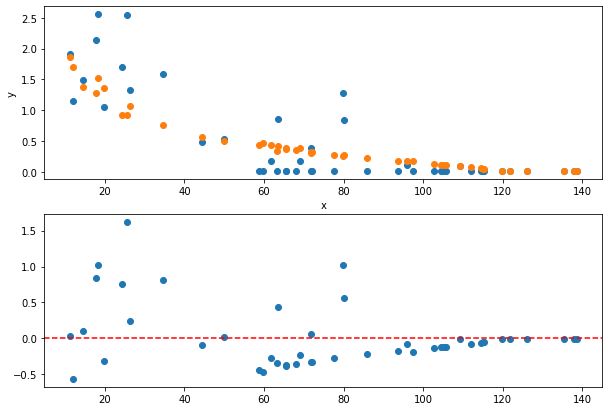

In [519]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xx[0], yy+0.01)
p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination  = np.median(sampler.results['samples'][:1000], axis = 0)
yy_model = model(xx, p0, rho0, Rlim, k_b, k_M, k_z, k_sfr, k_alpha, k_inclination)
plt.scatter(xx[0], yy_model)
#plt.xscale("log")
#plt.yscale("log")
plt.subplot(212)
plt.scatter(xx[0], yy - yy_model)
plt.axhline(0, linestyle = "--", c = "r")

# Catalog case by case

/tmp/ipykernel_581925/3311550652.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (7,7))


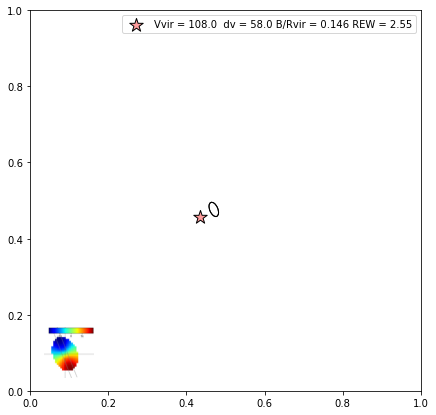

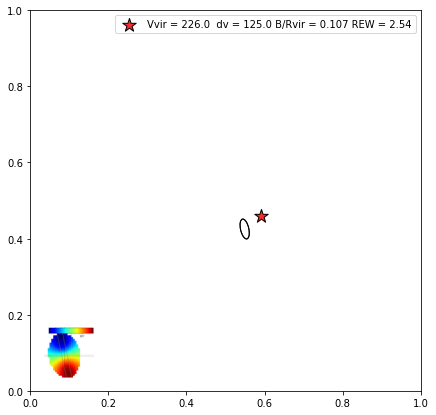

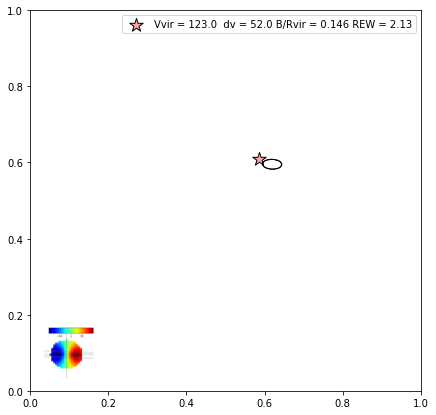

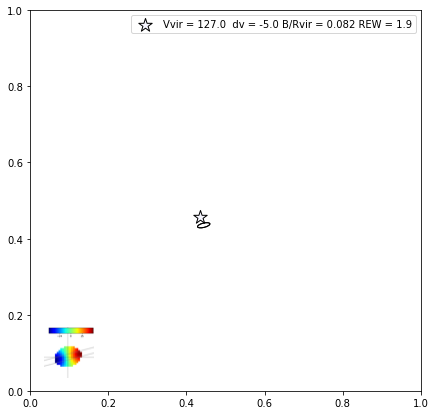

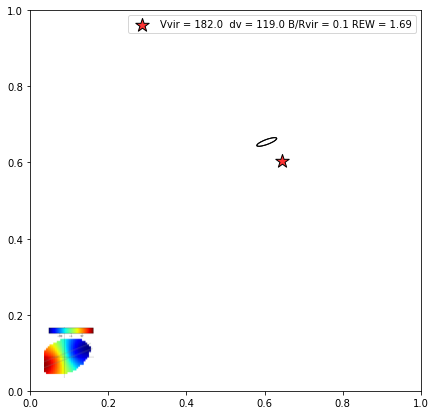

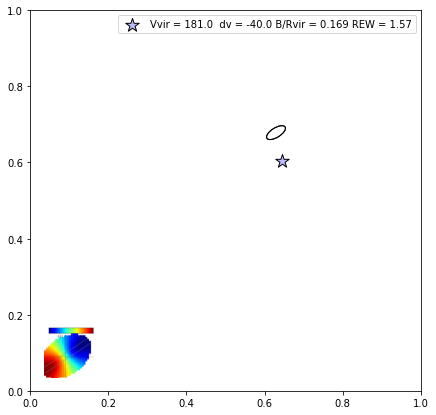

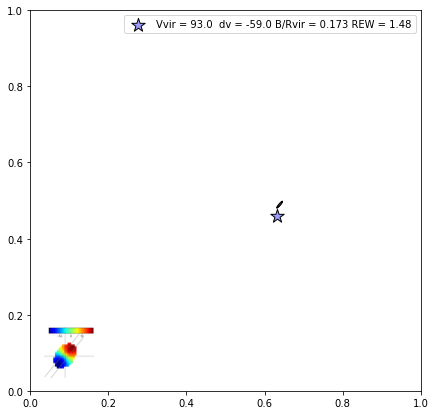

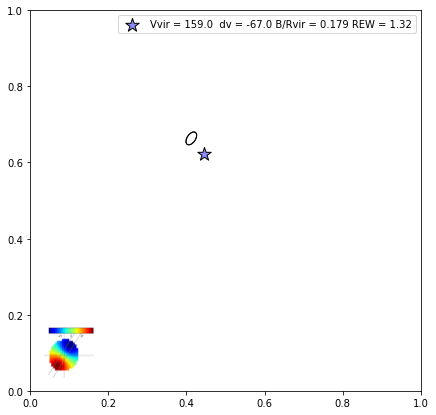

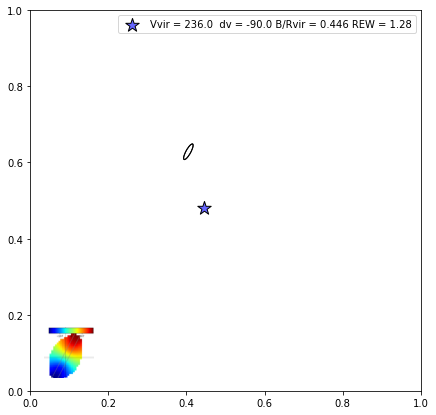

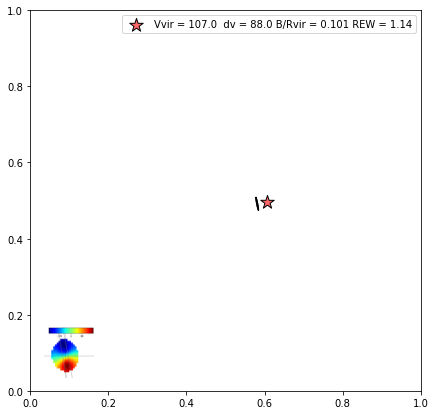

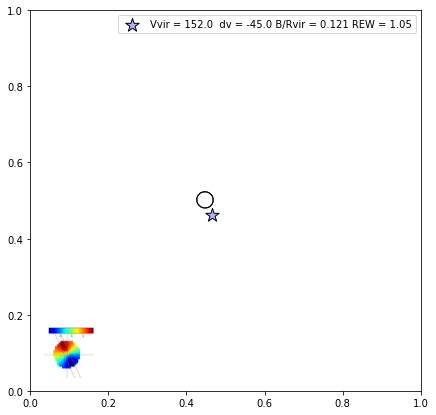

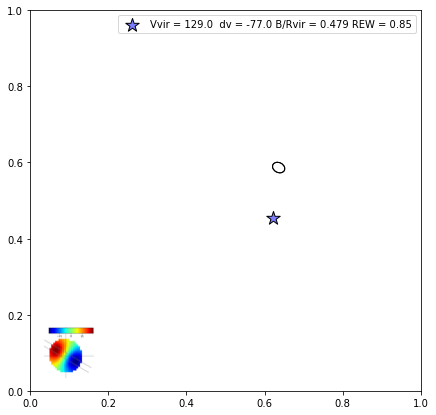

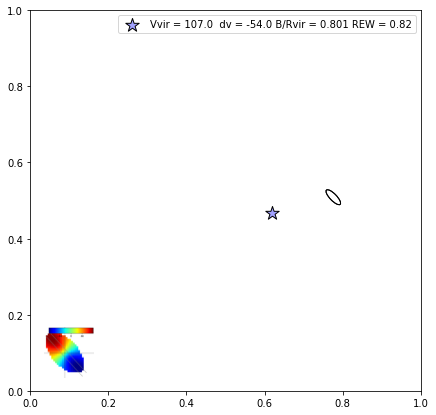

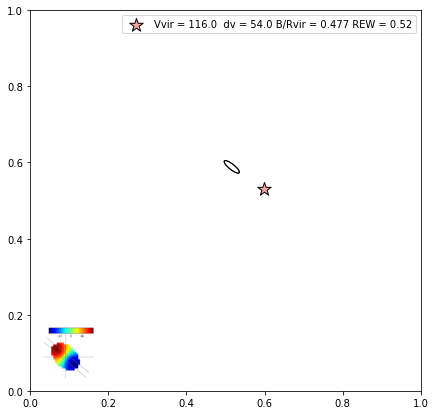

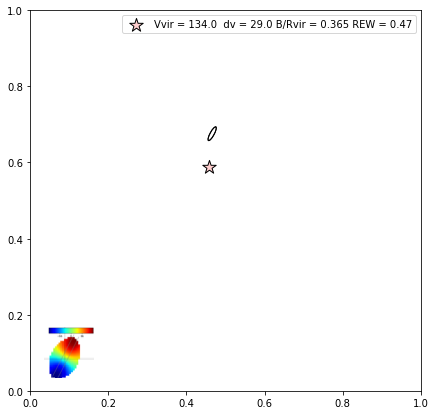

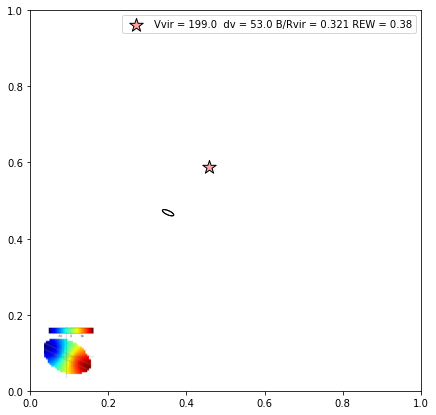

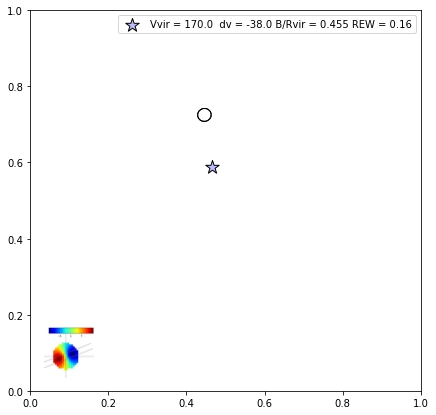

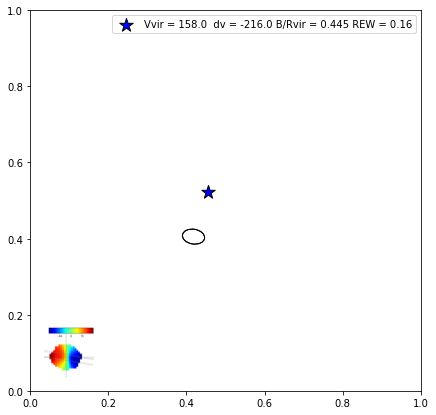

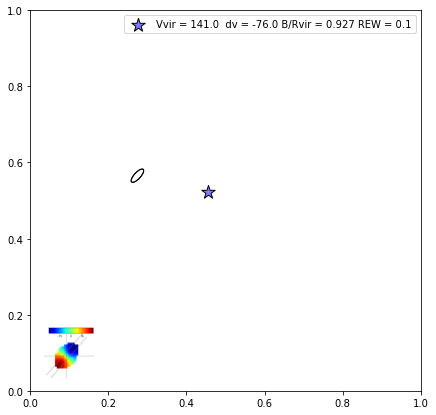

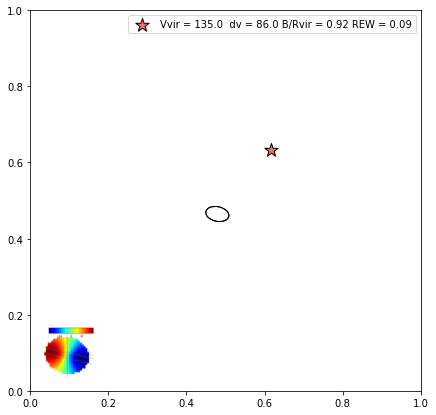

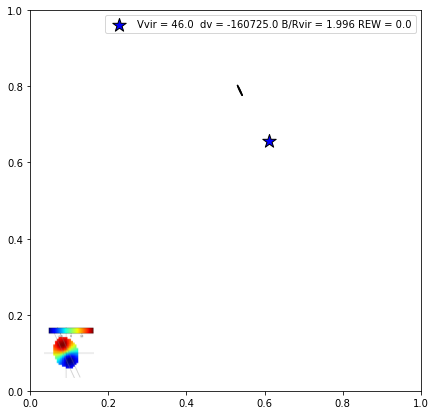

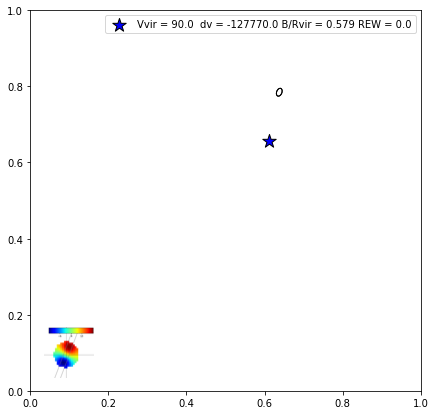

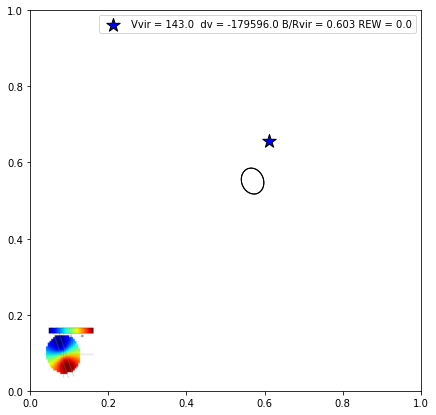

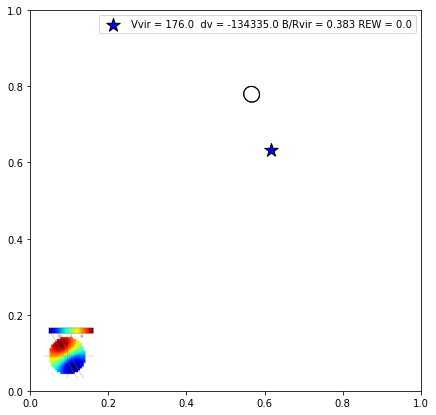

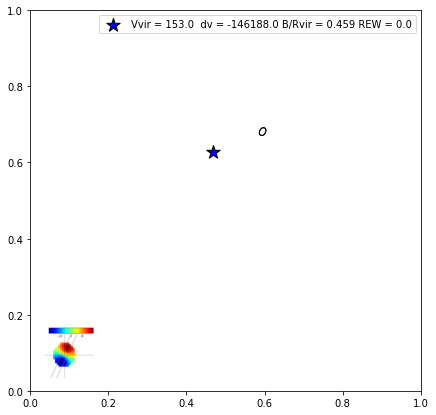

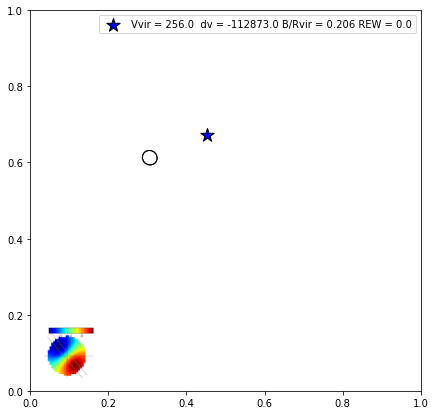

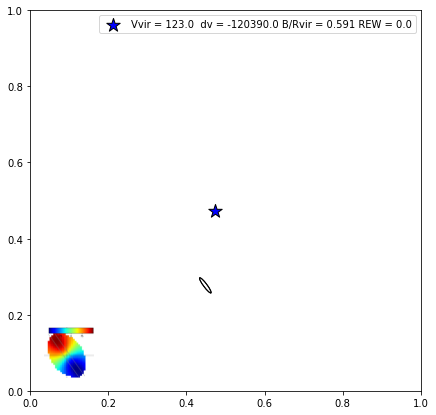

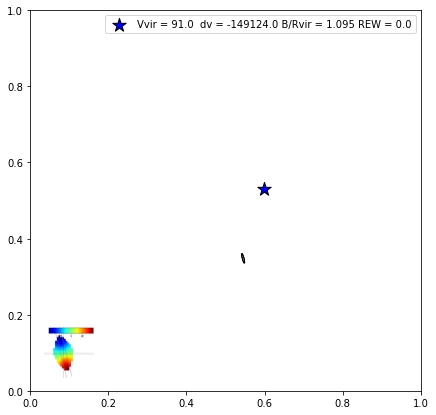

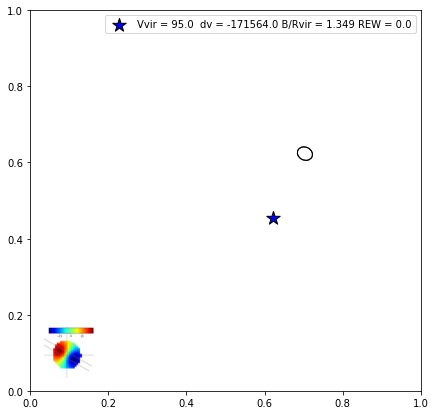

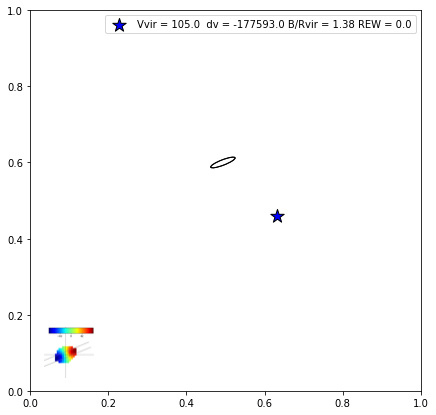

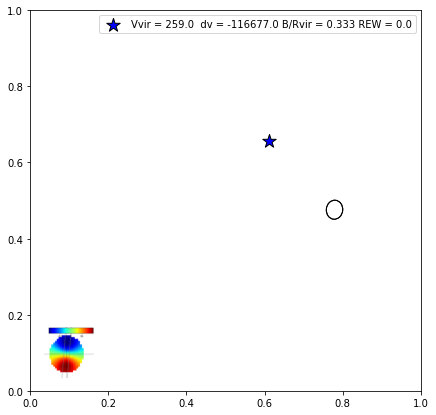

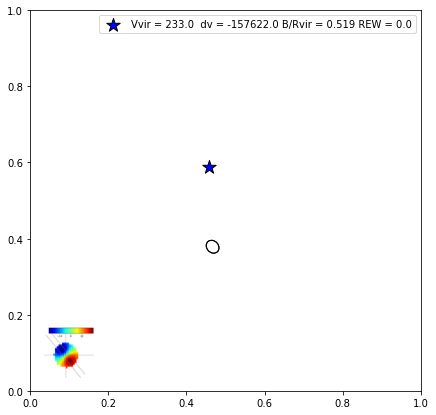

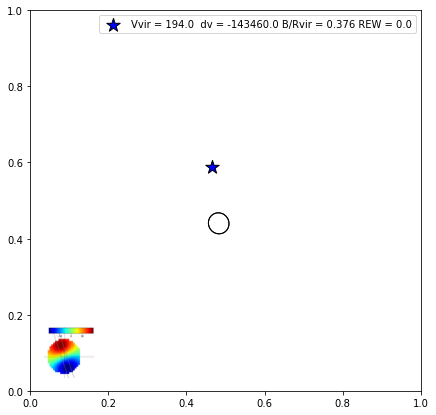

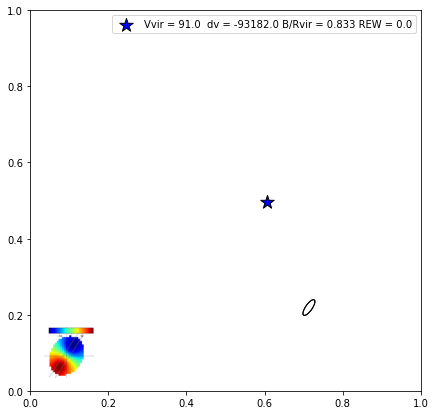

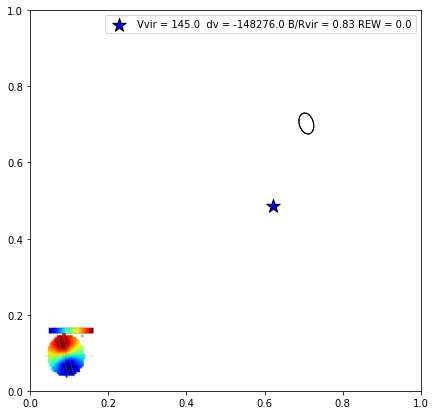

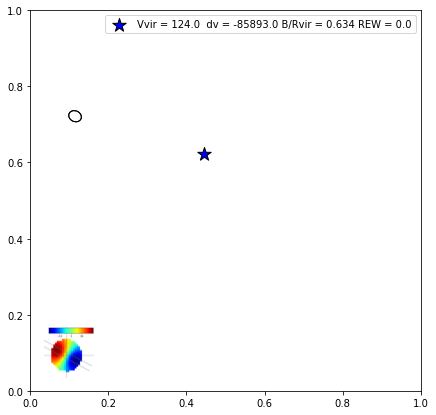

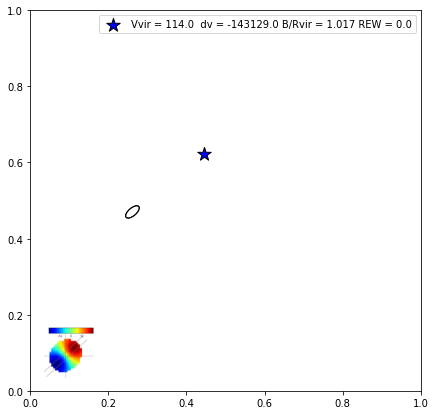

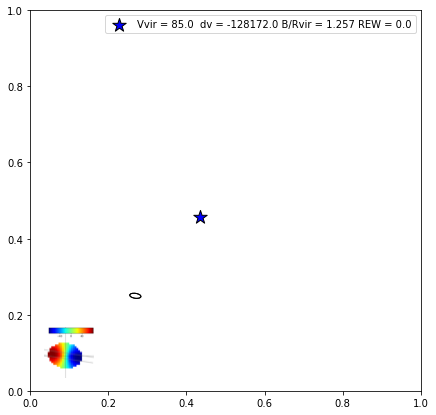

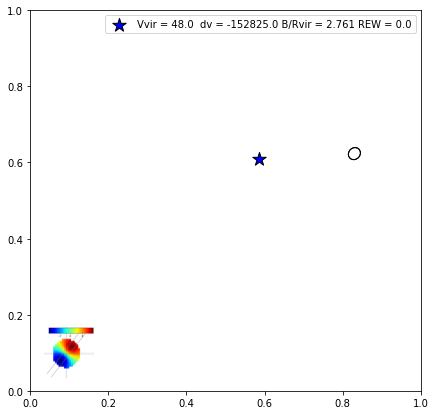

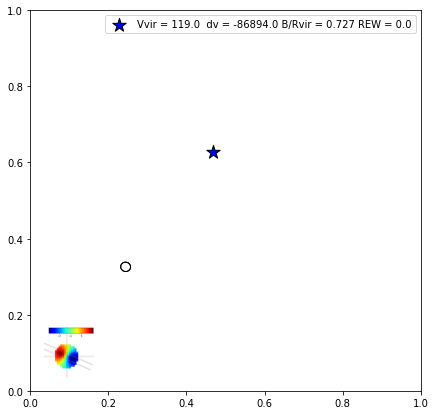

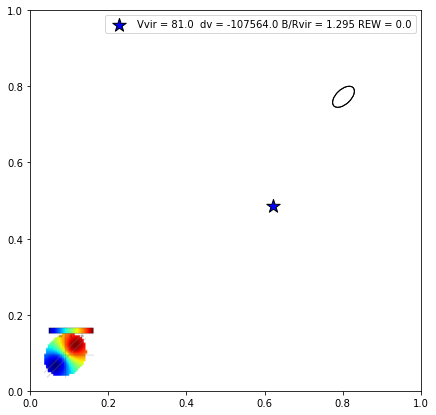

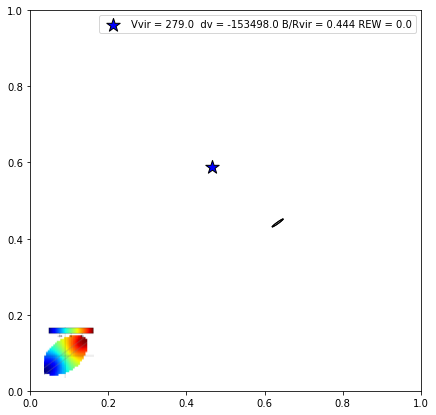

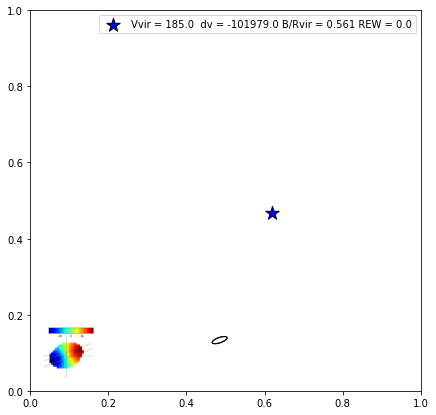

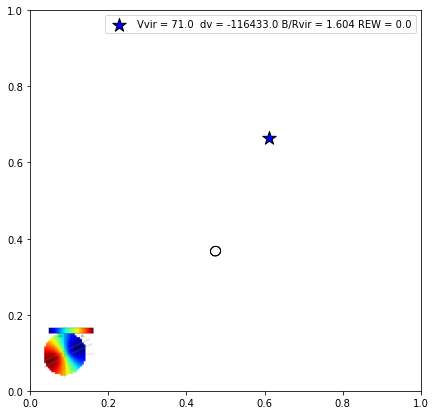

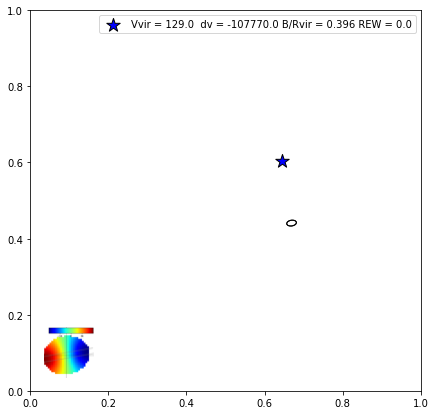

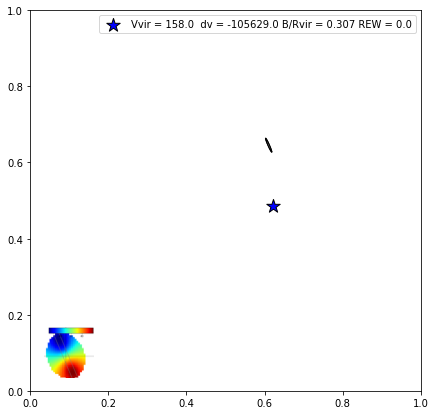

In [354]:
dir = "/muse/MG2QSO/private/production_dr2/"
isol_snr3_good_runs_rot = isol_snr3_good_runs_rot.sort_values(by=["REW_2796"], ascending = False)
for i, r in isol_snr3_good_runs_rot.iterrows():
    field_id = r["field_id"]
    src_id = r["ID"] 
    run_name = r["run_name"]
    z_src = r["Z"]
    REW2796 =r["REW_2796"]
    B_KPC = r["B_KPC"]
    incl = r["inclination"]
    alpha = r["alpha"]
    pa = r["pa"]
    radius = r["radius"]
    snr_eff = r["snr_eff"]
    #score = r["galpak_score"]
    #score_auto = r["score_auto"]
    #primary = r["primary"]
    primary_auto = r["primary_auto"]
    isolated_auto = r["isolated_auto"]
    mass = r["sed_logMass"]
    logSFR = np.log10(r["SFR_gilbank"])
    z = r["Z"]
    
    
    ymin = 0
    ymax = 300
    xmin = 0
    xmax = 300
    massmin = 9
    massmax = 12
    ss_min = 0.02
    ss_max = 0.1
    vmin = -0.5
    vmax = 1.2
    
    field_cube_path = dir + field_id +"/" + field_id +"_dr2_zap.fits"
    cube = Cube(field_cube_path)
    #ima_wli = cube.sum(axis=0)
    
    pixcoord = cube.wcs.sky2pix([r["DEC"], r["RA"]])[0]
    decpix = pixcoord[0]
    rapix = pixcoord[1]
    qso_pixcoord = cube.wcs.sky2pix([r["dec_qso"], r["ra_qso"]])[0]
    qso_decpix = qso_pixcoord[0]
    qso_rapix = qso_pixcoord[1]
    
    xx = (rapix - xmin)/(xmax - xmin)
    yy = (decpix - ymin)/(ymax - ymin)
    qso_xx = (qso_rapix - xmin)/(xmax - xmin)
    qso_yy = (qso_decpix - ymin)/(ymax - ymin)
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    #w = 20
    #h = 10
    
    #plt.figure(figsize = (7,7))

    
    fig, ax = plt.subplots(figsize = (7,7))
    #print(r["Z"], r["z_absorption"])
    dv = const.c.value*(r["z_absorption"] - r["Z"])/(1+r["Z"])/1e3
    Brvir = np.round(r["B_KPC"]/r["Rvir"], 3)
    label = "Vvir = " + str(np.round(r["virial_velocity"])) + "  dv = "+ str(np.round(dv))+ " B/Rvir = "+str(Brvir) + \
    " REW = " +str(np.round(r["REW_2796"],2))
    ax.scatter(qso_xx, qso_yy, marker = "*", c = dv, cmap = "bwr", vmin = -150, vmax = 150, s = 200, label = label,\
              edgecolor = "black")
    
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=pa+90,fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
        #plt.scatter(xx, yy)
    else:
        ax.scatter(xx, yy)
    
    run_dir = "/muse/MG2QSO/private/analysis/galpak_dr2/"
    run_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+str(run_name)+"/"
    img = Image.open(run_path + "run_obs_maps.png")
    img = img.crop((500, 80, 700 , 280))
    img.thumbnail((50, 50))  # Redimensionnement de l'image
    imagebox = OffsetImage(img)
    
    ab = AnnotationBbox(imagebox, (0.1, 0.1), frameon=False)
    ax.add_artist(ab)
    label = "pa = " + str(np.round(r["pa"])) + "\n"+\
            "alpha = "+ str(np.round(r["alpha"]))
    
    #plt.patches.Ellipse((rapix, decpix),10, 3)
    #matplotlib.patches.Ellipse((rapix, decpix),10, 3)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.legend()
    

In [ ]:
N = len(isol_9_abs)
p_size = N*5
fig = plt.figure(figsize = (18,p_size))
k = 1

name = "isolated_abs_UVES_catalog.pdf"
pdf = matplotlib.backends.backend_pdf.PdfPages(name)

for i, g in isol_9_abs.iterrows():
    file_name = "/home/mcherrey/ownCloud/git_groups/Phd_groups/uves_data/j"+g["field_id"][1:]+".dat"
    uves = pd.read_csv(file_name, delim_whitespace = True, names = ["lambda", "flux_norm", "flux", "C", "continuum"], index_col = False)
    uves["z_abs"] = uves["lambda"]/2796.352 - 1
    uves["delta_v"] = (uves["z_abs"] - g["Z"])*const.c.to(u.km/u.s).value/(1+g["Z"])

    fig = plt.figure(figsize = (18,5))
    #---------------
    plt.subplot(1,3,1)
    plt.scatter(isol_snr3_good_runs_abs["B_KPC"]/isol_snr3_good_runs_abs["Rvir"], isol_snr3_good_runs_abs["REW_2796"],\
             label = "with good runs and snreff > 3", zorder = 3, c = "gray")
    plt.scatter(isol_snr3_good_runs_noabs["B_KPC"]/isol_snr3_good_runs_noabs["Rvir"],\
            isol_snr3_good_runs_noabs["detection_limit_p75"], marker = "$\downarrow$", c = "gray")
    if g["ID"] in (isol_snr3_good_runs_abs["ID"].tolist()):
        plt.scatter(g["B_KPC"]/g["Rvir"], g["REW_2796"],\
             label = "with good runs and snreff > 3", zorder = 3, c = "r")
        
    
    #------------------
    
    
    plt.subplot(1,3,2)
    title = g["field_id"] + " "+str(g["ID"]) +" log(Mvir)=" +str(np.round(g["log_Mvir"],2))+\
    " log(SFR) = " + str(np.round(np.log10(g["SFR_gilbank"]),2)) + " S/Neff = " + str(np.round(g["snr_eff"]))
    plt.title(title)
    dv = 0.5e6
    #for i, g2 in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - g["Z"]) < dz
    k2 = R_all["field_id"] == g["field_id"]
    K = R_all[k1 & k2]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(g["REW_2796"], bmin, bmax, color = "red", linewidth = 0.6)
    plt.scatter(K["B_KPC"], np.ones(len(K))*(g["REW_2796"]), marker = ".", c = "red", zorder = 2)

    
    plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'gray',\
                     label = "isolated logM*>9", zorder = 2)
    plt.scatter(g["B_KPC"], g["REW_2796"], c = 'red',\
                     label = "isolated logM*>9", zorder = 3)

    plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "gray",\
                 marker = "$\downarrow$")
    plt.xlim((1, 200))
    plt.xlabel("B_KPC", size = 14)
    plt.ylabel("REW 2796", size = 14)
    
    plt.subplot(1,3,3)
    dv = 1.2e6
    dz = dv*(1+g["Z"])/const.c.value 
    k1 = np.abs(R_all["Z"] - g["Z"]) < dz
    k2 = R_all["field_id"] == g["field_id"]
    #k3 = R_all["B_KPC"] <= g2["B_KPC"]
    #k4 = R_all["ID"] != g["ID"]
    K = R_all[k1 & k2]
    K["vlos"] = const.c.value*(K["Z"] - g["Z"])/(1+g["Z"])/1e3
    plt.plot(uves["delta_v"], uves["flux_norm"], color = "red", linewidth = 0.5)
    plt.axvline(0, color = "lightgreen")
    plt.axvline(const.c.value*(g["z_absorption"] - g["Z"])/(1+g["Z"])/1e3, color = "pink", linestyle = "dotted")
    h = (300 - K["B_KPC"])/300
    plt.vlines(np.array(K["vlos"]), 0.5-h/2, 0.5+h/2, color = "blue")
    plt.xlabel("$\Delta v$ [km/s]")
    plt.ylabel("Norm flux")
    plt.ylim((-0.2,1.5))
    plt.xlim((-1200,1200))
    k += 1
    pdf.savefig(fig)
    
pdf.close()

In [561]:
isol_snr3[["ID", "snr_eff"]].head(20)

ID    snr_eff
74   11097  11.787067
94   11117  15.595028
98   11121   7.677074
100  11123  15.592190
225  12103   4.176094
230  12108   9.531053
294  13063   8.752755
354  13128  11.330263
355  13129   7.078941
439  14112   5.289118
453  14127   8.651319
474  14148  10.881895
509  15040   7.493241
577  16063   4.290501
578  16064  11.095253
583  16070   9.143446
588  16076   6.944786
591  16079   6.311240
673  17066   7.576954
675  17068  12.351898